In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import geojson
import xarray
import rasterio
import firedrake
from firedrake import Constant, sqrt, exp, ln, max_value, inner, grad, dx
import icepack

Load in the glacier outline and make a mesh.

In [2]:
name = "mystery-glacier"

with open(f"{name}.geojson", "r") as outline_file:
    outline = geojson.load(outline_file)

geometry = icepack.meshing.collection_to_geo(outline)
with open(f"{name}.geo", "w") as geometry_file:
    geometry_file.write(geometry.get_code())

command = f"gmsh -2 -format msh2 -v 0 -o {name}.msh {name}.geo"
subprocess.run(command.split())

mesh = firedrake.Mesh(f"{name}.msh")

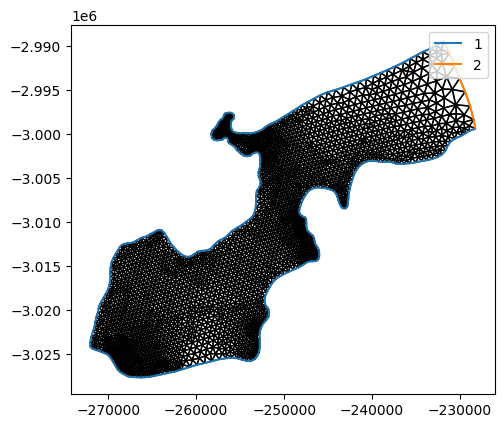

In [3]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(mesh, boundary_kw={"colors": ["tab:blue", "tab:orange"]}, axes=ax)
ax.legend();

Make some function spaces.

In [4]:
cg1 = firedrake.FiniteElement("CG", "triangle", 1)
dg0 = firedrake.FiniteElement("DG", "triangle", 0)

Q = firedrake.FunctionSpace(mesh, cg1)
V = firedrake.VectorFunctionSpace(mesh, cg1)

Load in the bed elevation and the ice thickness.
There's a single point where the ice thickness is zero, so clamp it below at 10m.

In [5]:
bedmachine_filename = icepack.datasets.fetch_bedmachine_greenland()
bedmachine = xarray.open_dataset(bedmachine_filename)

b = icepack.interpolate(bedmachine["bed"], Q)

h_obs = icepack.interpolate(bedmachine["thickness"], Q)
h_min = Constant(10.0)
h = firedrake.Function(Q).interpolate(max_value(h_min, h_obs))

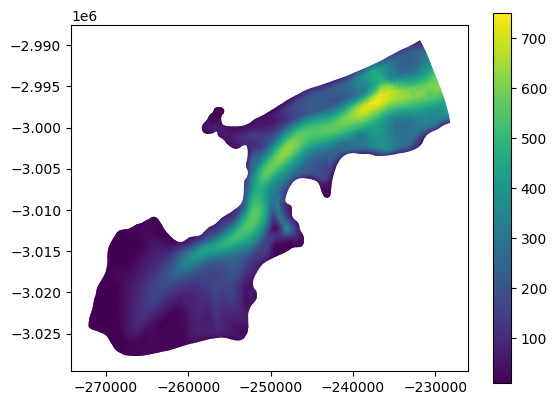

In [6]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(h, axes=ax)
fig.colorbar(colors);

In [7]:
s = firedrake.Function(Q).interpolate(b + h)

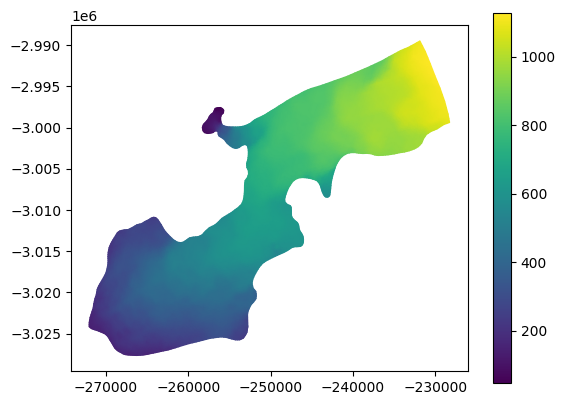

In [8]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(s, axes=ax)
fig.colorbar(colors);

Compute the driving stress, but apply a smoothing kernel to it with a smoothing length of 1km.

In [9]:
from icepack.constants import ice_density, gravity
ρ = Constant(ice_density)
g = Constant(gravity)
τ_d = firedrake.Function(V)

δτ = τ_d + ρ * g * h * grad(s)
α = Constant(1e3)
J = 0.5 * (inner(δτ, δτ) + α**2 * inner(grad(τ_d), grad(τ_d))) * dx
F = firedrake.derivative(J, τ_d)
firedrake.solve(F == 0, τ_d)

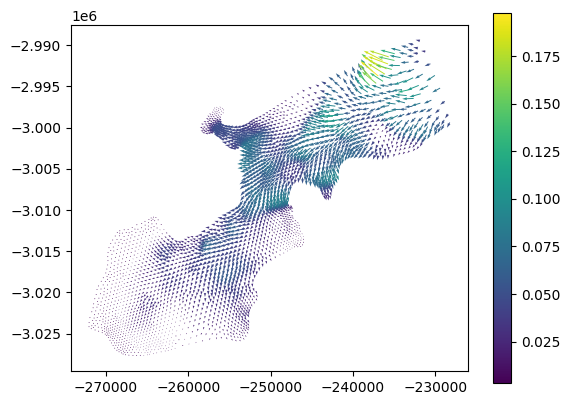

In [10]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.quiver(τ_d, axes=ax)
fig.colorbar(colors);

Load in the velocities.

In [11]:
velocity_filenames = icepack.datasets.fetch_measures_greenland()
vx_filename = [f for f in velocity_filenames if "vx" in f][0]
vy_filename = [f for f in velocity_filenames if "vy" in f][0]
ex_filename = [f for f in velocity_filenames if "ex" in f][0]
ey_filename = [f for f in velocity_filenames if "ey" in f][0]

In [12]:
with (rasterio.open(vx_filename, "r") as vx_file,
    rasterio.open(vy_filename, "r") as vy_file):
    u_obs = icepack.interpolate((vx_file, vy_file), V)

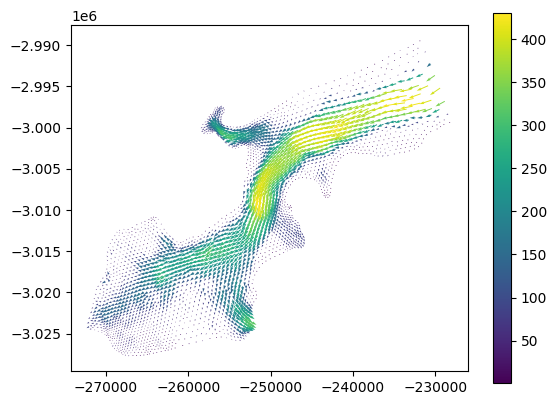

In [13]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.quiver(u_obs, axes=ax)
fig.colorbar(colors);

In [14]:
u_obs.dat.data_ro.max()

286.94508791972873

Here we're creating the statistical *precision* $P$, which is the inverse of the standard deviation.
There are some points in the domain where the velocity data is missing and thus has zero statistical precision.
Representing zero precision is fine, but if we were to use the standard deviation $\sigma$ instead, we'd have to accept infinite values of $\sigma$.

In [15]:
with rasterio.open(ex_filename, "r") as ex_file:
    σx = icepack.interpolate(ex_file, Q)

with rasterio.open(ey_filename, "r") as ey_file:
    σy = icepack.interpolate(ey_file, Q)

In [16]:
expr = 1 / sqrt(σx**2 + σy**2)
P = firedrake.Function(Q).interpolate(expr)

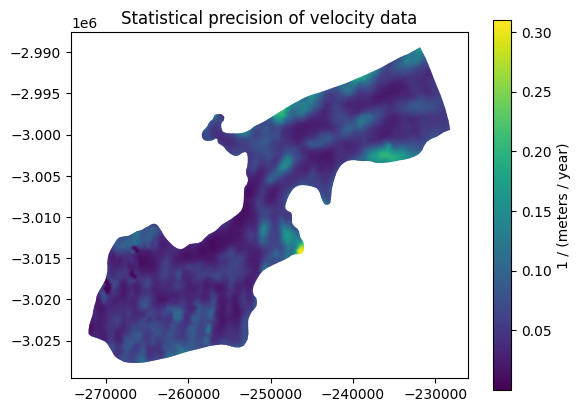

In [17]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_title("Statistical precision of velocity data")
colors = firedrake.tripcolor(P, axes=ax)
fig.colorbar(colors, label="1 / (meters / year)");

Here we're making a guess that the friction coefficient is sufficient to make basal resistance take up half the driving stress.
The sliding law is
$$\tau_b = -C|u|^{\frac{1}{m} - 1}u,$$
where $\tau_b$ is the basal shear stress, so if we want to make $|\tau_b| = f|\tau_d|$ for some fraction $f$, then
$$C = f|\tau_d| / |u|^{\frac{1}{m}}.$$
Rather than interpolate the expression directly, we're applying a smoothing kernel again.

In [18]:
from icepack.constants import weertman_sliding_law
m = Constant(weertman_sliding_law)
frac = Constant(0.8) #0.8
C_obs = frac * sqrt(inner(τ_d, τ_d)) / sqrt(inner(u_obs, u_obs)) ** (1 / m)
C = firedrake.Function(Q)

J = 0.5 * ((C - C_obs)**2 + α**2 * inner(grad(C), grad(C))) * dx
F = firedrake.derivative(J, C)
firedrake.solve(F == 0, C)

In [19]:
C.dat.data_ro.min(), C.dat.data_ro.max()

(0.000815545689970178, 0.046562072908543174)

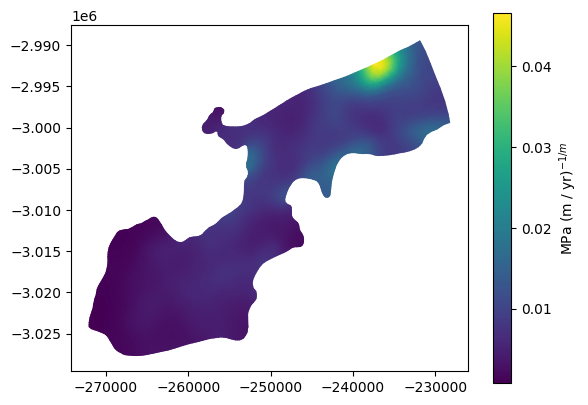

In [20]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(C, axes=ax)
fig.colorbar(colors, label="MPa (m / yr)${}^{-1/m}$");

We'll want to parameterize the sliding law in terms of the logarithm of the friction instead in order to make sure that it's positive.

In [21]:
area = firedrake.assemble(Constant(1) * dx(mesh))
C_avg = firedrake.assemble(C * dx) / area
print(f"Average friction coefficient: {1e3 * C_avg:.3f} kPa / (meters / year)^(1 / m)")

Average friction coefficient: 7.411 kPa / (meters / year)^(1 / m)


In [22]:
q = firedrake.Function(Q).interpolate(ln(C / C_avg))

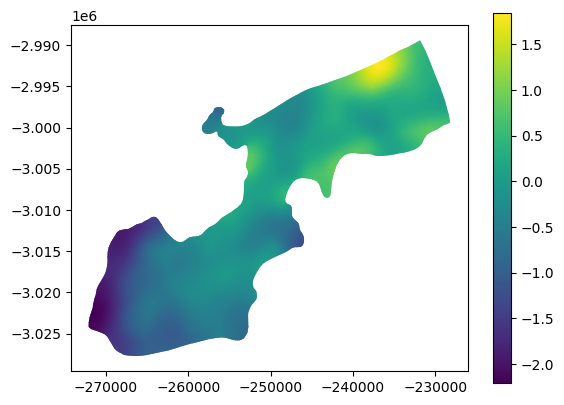

In [23]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(q, axes=ax)
fig.colorbar(colors);

Because I've messed this up once already, a bit of sanity checking.

In [24]:
firedrake.norm(C - C_avg * exp(q)) / firedrake.norm(C)

0.005003708305354065

We'll take the ice fluidity (the pre-factor in Glen's flow law) to be a constant -5C.
This is probably wrong, might want to check on that.

In [25]:
T = Constant(272.0) #268
CS = firedrake.FunctionSpace(mesh, "R", 0)
A = firedrake.Function(CS)
A.assign(icepack.rate_factor(T))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fffb37a4af0>, FiniteElement('Real', triangle, 0), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 2)), 104)

Now let's compute the ice velocity consistent with these assumptions by solving the momentum balance equation.

In [26]:
def friction(**kwargs):
    u = kwargs["velocity"]
    q = kwargs["log_friction"]
    return m / (m + 1) * C_avg * exp(q) * inner(u, u)**((m + 1) / (2 * m))

model = icepack.models.IceStream(friction=friction)
opts = {"dirichlet_ids": [1, 2]}
solver = icepack.solvers.FlowSolver(model, **opts)
u = solver.diagnostic_solve(
    velocity=u_obs, thickness=h, surface=s, fluidity=A, log_friction=q
)

We get a slightly faster ice velocity than observed but not too far off.
Try playing around with the fluidity or the shear stress fraction above to make this more sensible.

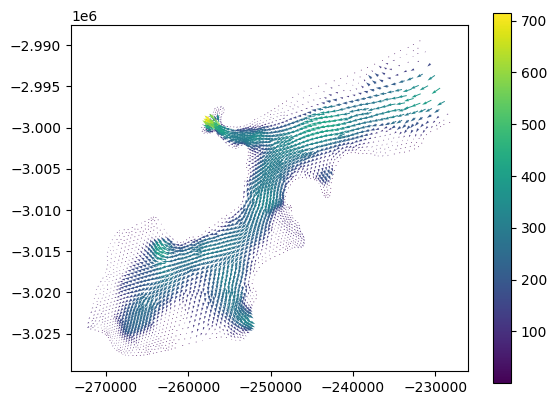

In [27]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.quiver(u, axes=ax)
fig.colorbar(colors);

In [28]:
def simulation(q):
    return solver.diagnostic_solve(
        velocity=u_obs, thickness=h, surface=s, fluidity=A, log_friction=q
    )

def loss_functional(u):
    return 0.5 * P * inner(u - u_obs, u - u_obs) * dx

λ = Constant(1000.0)
def regularization(q):
    return 0.5 * λ**2 * inner(grad(q), grad(q)) * dx

In [29]:
problem = icepack.statistics.StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=q,
)

estimator = icepack.statistics.MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-1,
    max_iterations=40,
)

q = estimator.solve()


Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     7.886904e+10   3.127030e+07                  1.838277e+03   
  1     4.411793e+10   1.245560e+07   1.838277e+03   4.595693e+03   3         2         0         1         3         
  2     1.895923e+10   8.286391e+06   4.595693e+03   1.148923e+04   4         3         0         3         3         
  3     1.895923e+10   8.286391e+06   1.148923e+04   7.180770e+02   5         3         2         7         3         
  4     1.588615e+10   2.378564e+06   7.180770e+02   1.795192e+03   6         4         0         2         3         
  5     1.353886e+10   3.357414e+06   1.795192e+03   4.487981e+03   7         5         0         1         3         
  6     1.024969e+10   1.838617e+06   4.487981e+03   1.121995e+04   8         6         0         6         3         
  7     1.024969e+10   1.838617e+06   1.121995e+04   7.012471e+0

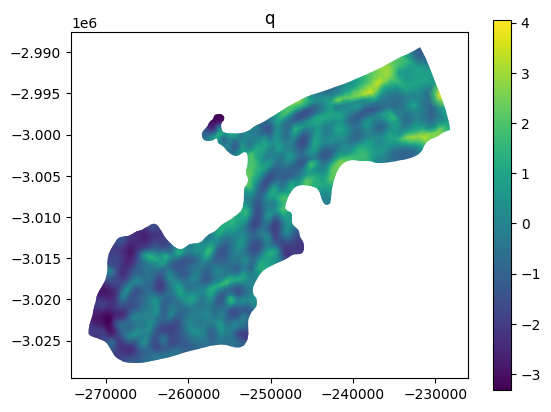

In [30]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(q, axes=ax)
fig.colorbar(colors)
ax.set_title('q');

In [31]:
u = solver.diagnostic_solve(
    velocity=u_obs, thickness=h, surface=s, fluidity=A, log_friction=q
)

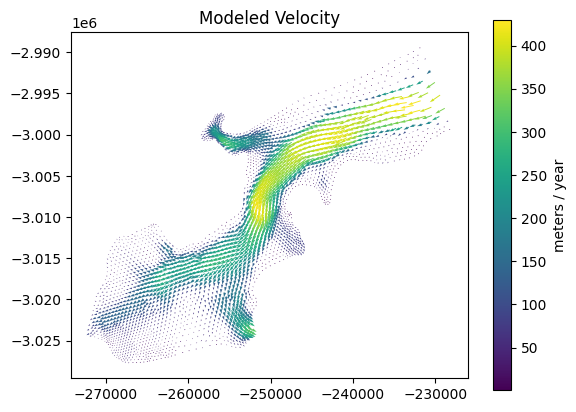

In [32]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.quiver(u, axes=ax)
fig.colorbar(colors, label="meters / year")
ax.set_title('Modeled Velocity');

In [33]:
expr = C_avg * exp(q) * sqrt(inner(u, u))**(1 / m)
τ_b = firedrake.Function(Q).interpolate(expr)

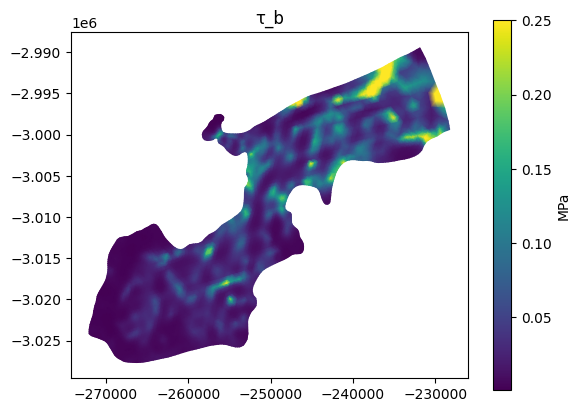

In [34]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(τ_b, vmax=0.25, axes=ax)
fig.colorbar(colors, label="MPa")
ax.set_title('τ_b');

In [35]:
expr = C_avg * exp(q) * sqrt(inner(u, u)) ** (1 / m) / sqrt(inner(τ_d, τ_d))
stress_ratio = firedrake.Function(Q).interpolate(expr)

In [36]:
τ_d.dat.data_ro.max()

0.12628698495008342

In [37]:
stress_ratio.dat.data_ro.min(), stress_ratio.dat.data_ro.max()

(0.07810502083204916, 40.43802164321094)

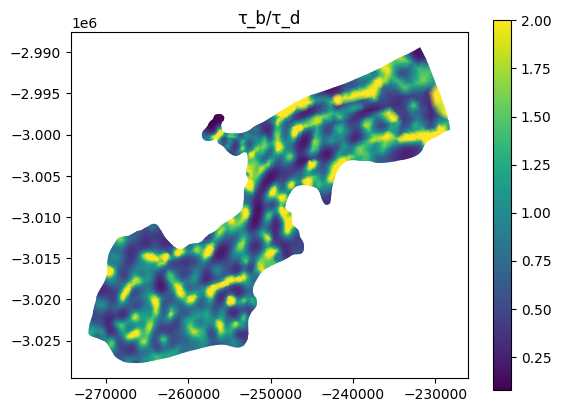

In [38]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(stress_ratio, vmax=2.0, axes=ax)
fig.colorbar(colors)
ax.set_title('τ_b/τ_d');

In [39]:
from firedrake import assemble, Constant, inner, grad, dx

area = assemble(Constant(1) * dx(mesh))
u_avg = assemble(sqrt(inner(u, u)) * dx) / area
τ_avg = assemble(sqrt(inner(τ_d, τ_d)) * dx) / area

# Extrapolating to larger domain (ice free zone for terminus)
## From extrapolate.py by Dan

In [40]:
u_input = u
q_input = q
friction_input = τ_b

τ_avg = τ_avg # Dumb but for consistency
u_avg = u_avg

Δ = firedrake.FunctionSpace(mesh, "DG", 0)
μ = firedrake.interpolate(Constant(1), Δ)

/home/firedrake/firedrake/src/firedrake/firedrake/interpolation.py:385: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


In [41]:
name = "mystery_glacier_large"

with open(f"{name}.geojson", "r") as outline_file:
    outline = geojson.load(outline_file)

geometry = icepack.meshing.collection_to_geo(outline)
with open(f"{name}.geo", "w") as geometry_file:
    geometry_file.write(geometry.get_code())

command = f"gmsh -2 -format msh2 -v 0 -o {name}.msh {name}.geo"
subprocess.run(command.split())

initial_mesh = firedrake.Mesh("mystery_glacier_large.msh")
mesh_hierarchy = firedrake.MeshHierarchy(initial_mesh, 1, 2)
mesh = mesh_hierarchy[-1]

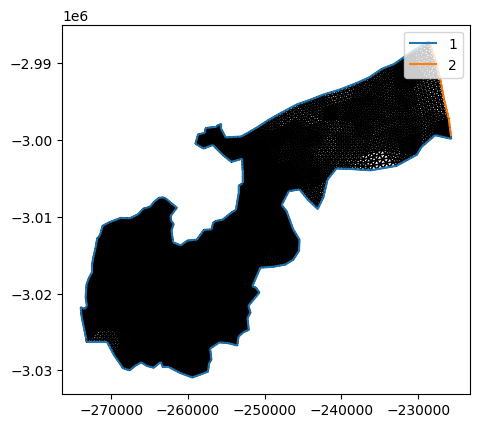

In [42]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(mesh, boundary_kw={"colors": ["tab:blue", "tab:orange"]}, axes=ax)
ax.legend();

In [43]:
# New function Spaces from new mesh
Q = firedrake.FunctionSpace(mesh, "CG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1)

In [44]:
# Project the mask, log-fluidity, and velocity onto the larger mesh. The
# regions with no data will be extrapolated by zero.
Δ = firedrake.FunctionSpace(mesh, "DG", 0)
μ = firedrake.project(μ, Δ)

In [45]:
Eq = firedrake.project(q_input, Q)
Eu = firedrake.project(u_input, V)
Efrict = firedrake.project(friction_input, Q)

q = Eq.copy(deepcopy=True)
u = Eu.copy(deepcopy=True)
τ_b = Efrict.copy(deepcopy=True) 

α = Constant(5e2)

In [46]:
# Extrapolate Velocity
bc_ids = [1, 2]
bc = firedrake.DirichletBC(V, Eu, bc_ids)
J = 0.5 * (μ * inner(u - Eu, u - Eu) + α**2 * inner(grad(u), grad(u))) * dx
F = firedrake.derivative(J, u)
firedrake.solve(F == 0, u, bc)

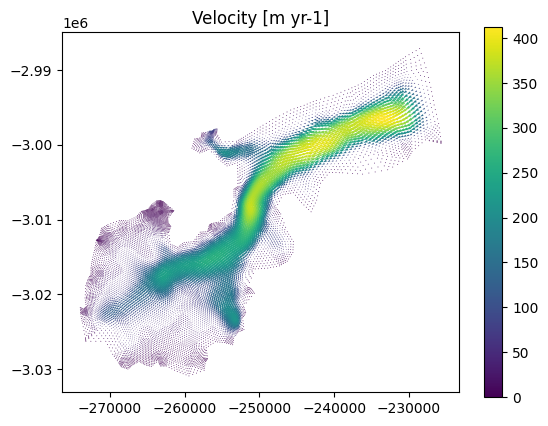

In [47]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.quiver(u, axes=ax)
fig.colorbar(colors)
ax.set_title('Velocity [m yr-1]');

In [48]:
# Extrapolate friction coef.
bc = firedrake.DirichletBC(Q, Eq, bc_ids)
J = 0.5 * (μ * inner(q - Eq, q - Eq) + α**2 * inner(grad(q), grad(q))) * dx
F = firedrake.derivative(J, q)
firedrake.solve(F == 0, q, bc)

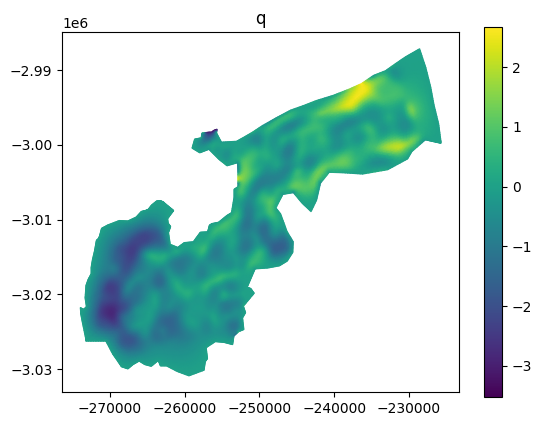

In [49]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(q, axes=ax)
fig.colorbar(colors)
ax.set_title('q');

In [50]:
bedmachine = xarray.open_dataset(icepack.datasets.fetch_bedmachine_greenland())
h_obs = icepack.interpolate(bedmachine["thickness"], Q)

In [51]:
# Extrapolate thickness 
h = h_obs.copy(deepcopy=True)
λ = Constant(2e3)
J = 0.5 * ((h - h_obs)**2 + λ**2 * inner(grad(h), grad(h))) * dx
F = firedrake.derivative(J, h)
firedrake.solve(F == 0, h)

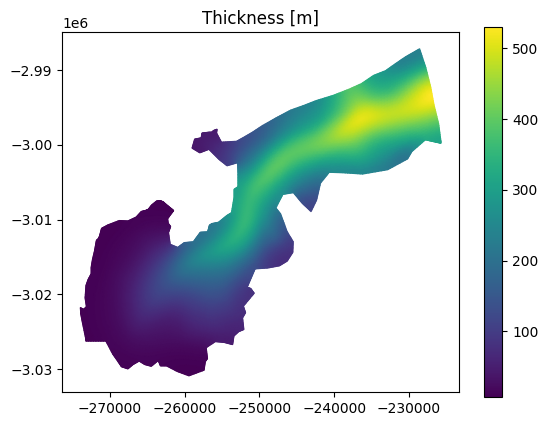

In [52]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(h, axes=ax)
fig.colorbar(colors)
ax.set_title('Thickness [m]');

In [53]:
# Extrapolate basal friction
bc = firedrake.DirichletBC(Q, Efrict, bc_ids)
J = 0.5 * (μ * inner(τ_b - Efrict, τ_b - Efrict) + α**2 * inner(grad(τ_b), grad(τ_b))) * dx
F = firedrake.derivative(J, τ_b)
firedrake.solve(F == 0, τ_b, bc)

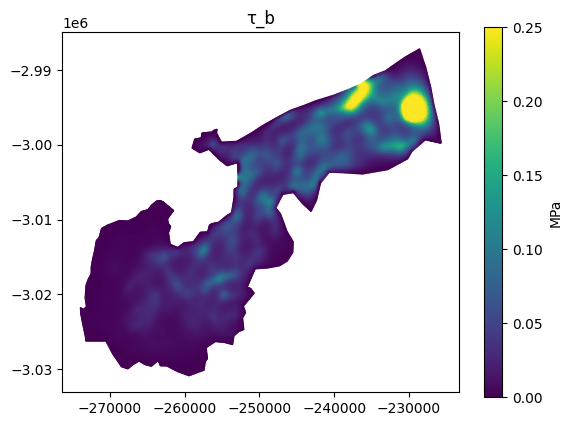

In [54]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(τ_b, vmin = 0, vmax = 0.25, axes=ax)
fig.colorbar(colors, label="MPa")
ax.set_title('τ_b');

# Time Dependent Foward Modeling
## From simulate.py by Dan

- tweak vals for SMB

In [55]:
import argparse
import subprocess
import tqdm
import numpy as np
from numpy import pi as π
import xarray
import firedrake
from firedrake import assemble, Constant, exp, max_value, inner, grad, dx, ds, dS
import icepack
from icepack2.constants import (
    glen_flow_law as n,
    weertman_sliding_law as m,
    ice_density as ρ_I,
    water_density as ρ_W,
)
from icepack2 import model

## Start by showing where we initialize our run

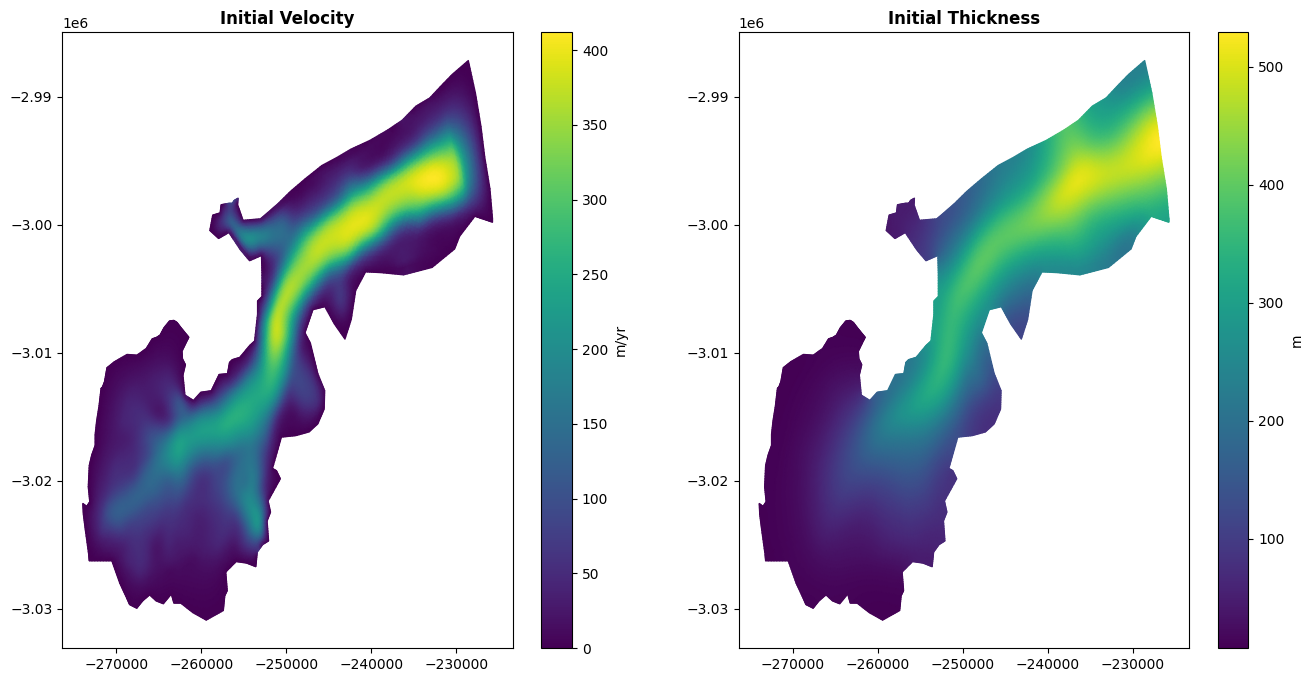

In [56]:
# Initial Conditions 
fig, ax = plt.subplots(1, 2, figsize = [16, 8])

ax[0].set_title('Initial Velocity', fontweight = 'bold')
arrows = firedrake.tripcolor(u, axes=ax[0])#vmax = 15)
fig.colorbar(arrows, label="m/yr")

ax[1].set_title('Initial Thickness', fontweight = 'bold')
colors = firedrake.tripcolor(h, axes=ax[1])
fig.colorbar(colors, label = 'm')

In [57]:
timesteps_per_year = 1
final_time = 5000
calving = False # When running to sealevel
melt_rate = 3e3
mask_smoothing_length = 5e3
snes_max_it = 200
snes_rtol = 1e-5

In [58]:
Q = firedrake.FunctionSpace(mesh, "CG", 2) # Changed from 1
Δ = firedrake.FunctionSpace(mesh, "DG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1) # Changed from 1
Σ = firedrake.TensorFunctionSpace(mesh, "DG", 0, symmetry=True)
T = firedrake.VectorFunctionSpace(mesh, "DG", 0)
Z = V * Σ * T

In [59]:
u_in = firedrake.project(u, V)
q = firedrake.project(q, Q)

z = firedrake.Function(Z)
z.sub(0).assign(u_in)

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fffb37e02e0>, VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), name=None, index=0, component=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 79008)), 110498)

In [60]:
# Read the thickness and bed data
bedmachine = xarray.open_dataset(icepack.datasets.fetch_bedmachine_greenland())
b = icepack.interpolate(bedmachine["bed"], Q)
h = firedrake.project(h, Δ)
s = firedrake.project(max_value(b + h, (1 - ρ_I / ρ_W) * h), Δ)

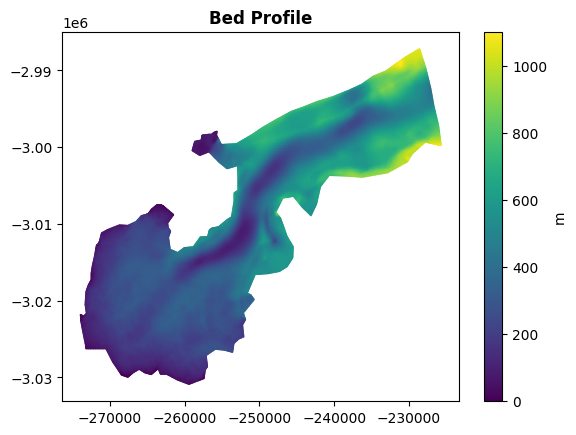

In [61]:
fig, ax = plt.subplots()
ax.set_title('Bed Profile', fontweight = 'bold')
arrows = firedrake.tripcolor(b, axes=ax)#vmax = 15)
fig.colorbar(arrows, label="m")

In [62]:
# Set up the momentum balance equation and solve
A = icepack.rate_factor(Constant(272.0))
τ_c = τ_avg
u_c = u_avg
ε_c = Constant(A * τ_c ** n)

print(f"τ_c: {1000 * float(τ_c):.1f} kPa")
print(f"ε_c: {1000 * float(ε_c):.1f} (m / yr) / km")
print(f"u_c: {float(u_c):.1f} m / yr")

τ_c: 42.7 kPa
ε_c: 9.6 (m / yr) / km
u_c: 147.9 m / yr


In [63]:
fns = [
    model.viscous_power,
    model.friction_power,
    #model.calving_terminus,
    model.momentum_balance,
]

In [64]:
u, M, τ = firedrake.split(z)
fields = {
    "velocity": u,
    "membrane_stress": M,
    "basal_stress": τ,
    "thickness": h,
    "surface": s,
}

In [65]:
h_min = Constant(1e-3)
rfields = {
    "velocity": u,
    "membrane_stress": M,
    "basal_stress": τ,
    "thickness": max_value(h_min, h),
    "surface": s,
}

In [66]:
rheology = {
    "flow_law_exponent": n,
    "flow_law_coefficient": ε_c / τ_c**n,
    "sliding_exponent": m,
    "sliding_coefficient": u_c / τ_c**m * exp(m * q),
}

In [67]:
linear_rheology = {
    "flow_law_exponent": 1,
    "flow_law_coefficient": ε_c / τ_c,
    "sliding_exponent": 1,
    "sliding_coefficient": u_c / τ_c * exp(q),
}

In [68]:
L_1 = sum(fn(**rfields, **linear_rheology) for fn in fns)
F_1 = firedrake.derivative(L_1, z)
J_1 = firedrake.derivative(F_1, z)

In [69]:
L = sum(fn(**fields, **rheology) for fn in fns)
F = firedrake.derivative(L, z)

In [70]:
L_r = sum(fn(**rfields, **rheology) for fn in fns)
F_r = firedrake.derivative(L_r, z)
J_r = firedrake.derivative(F_r, z)
α = firedrake.Constant(0.0)
J = J_r + α * J_1

In [71]:
inflow_ids = [1]
bc_in = firedrake.DirichletBC(Z.sub(0), u_in, inflow_ids)
outflow_ids = [2]
bc_out = firedrake.DirichletBC(Z.sub(0), Constant((0.0, 0.0)), outflow_ids)
bcs = [bc_in, bc_out]

In [72]:
qdegree = int(max(m, n)) + 2
problem_params = {
    "form_compiler_parameters": {"quadrature_degree": qdegree},
    "bcs": bcs,
}
solver_params = {
    "solver_parameters": {
        "snes_monitor": None,
        #"snes_converged_reason": None,
        "snes_stol": 0.0,
        "snes_rtol": 1e-6,
        "snes_linesearch_type": "nleqerr",
        "snes_max_it": 200,
        "snes_divergence_tolerance": -1,
        "snes_type": "newtonls",
        "ksp_type": "gmres",
        "pc_type": "lu",
        # If the linear solver crashes, try "umfpack" instead of "mumps"
        "pc_factor_mat_solver_type": "mumps",
    },
}
firedrake.solve(F_1 == 0, z, **problem_params, **solver_params)

  0 SNES Function norm 1.106534555302e+09
  1 SNES Function norm 7.825465275319e-07


In [73]:
u_problem = firedrake.NonlinearVariationalProblem(F, z, J=J, **problem_params)
u_solver = firedrake.NonlinearVariationalSolver(u_problem, **solver_params)
u_solver.solve()

  0 SNES Function norm 4.151814385721e+10
  1 SNES Function norm 7.027232264379e+31
  2 SNES Function norm 6.433000772148e+31
  3 SNES Function norm 5.461425569560e+31
  4 SNES Function norm 1.618200168758e+31
  5 SNES Function norm 4.794667166692e+30
  6 SNES Function norm 1.420642123464e+30
  7 SNES Function norm 4.209309995450e+29
  8 SNES Function norm 1.247202961615e+29
  9 SNES Function norm 3.695416182562e+28
 10 SNES Function norm 1.094938128167e+28
 11 SNES Function norm 3.244261120493e+27
 12 SNES Function norm 9.612625542203e+26
 13 SNES Function norm 2.848185345838e+26
 14 SNES Function norm 8.439067691371e+25
 15 SNES Function norm 2.500464501147e+25
 16 SNES Function norm 7.408783707102e+24
 17 SNES Function norm 2.195195172475e+24
 18 SNES Function norm 6.504281992518e+23
 19 SNES Function norm 1.927194664450e+23
 20 SNES Function norm 5.710206413184e+22
 21 SNES Function norm 1.691913011314e+22
 22 SNES Function norm 5.013075589078e+21
 23 SNES Function norm 1.485355730

### SMB ~= a_0 + (da_ds * s)

In [74]:
da_ds_val = 2.25 * 1e-3 #2.25
da_ds = Constant(da_ds_val)
    
a_val = 0.0
a_0 = Constant(a_val) #-2.3

ela = a_val / da_ds_val
print(ela)

smb = 0.917 * (a_0 + da_ds * s)

0.0


In [75]:
# SMB Plot
# Inputs
z_max = s.dat.data_ro.max()
z_min = s.dat.data_ro.min()
z_vals = np.arange(z_min, z_max, 1)

x_coords = np.arange(0, len(z_vals), 1) # Dummy values of ~ len 10km for plotting
s_vals = 0.917 * (a_val + da_ds_val * z_vals)

print(z_min)
print(z_max)

7.946485986344199
1397.7195416600473


Text(0.5, 0, 'X position [m]')

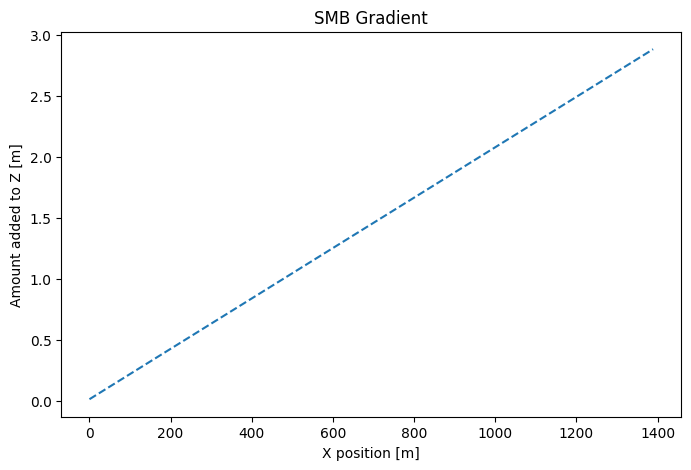

In [76]:
plt.figure(figsize = (8,5))
plt.plot(x_coords, s_vals, '--')
plt.title('SMB Gradient')
plt.ylabel('Amount added to Z [m]')
plt.xlabel('X position [m]')

## At this pt, our glacier has a response time that we can calculate
### τ = h / b_t

In [77]:
response_time = h.dat.data_ro.mean() / a_val
print(f'Response time is ~{response_time:.2f} years')
print(f"Current run is for ~ {final_time / response_time:.2f} τ's")

Response time is ~inf years
Current run is for ~ 0.00 τ's


/tmp/ipykernel_1901/2856365538.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  response_time = h.dat.data_ro.mean() / a_val


In [78]:
# Create a solver for a smooth ice mask field
if calving == True:
    α = Constant(args.mask_smoothing_length)
    μ = firedrake.Function(Q)
    χ = firedrake.conditional(h > 0, 1, 0)
    J = 0.5 * ((μ - χ)**2 + α**2 * inner(grad(μ), grad(μ))) * dx
    bcs = [
        firedrake.DirichletBC(Q, Constant(1.0), (1,)),
        firedrake.DirichletBC(Q, Constant(0.0), (3,)),
    ]
    F = firedrake.derivative(J, μ)
    μ_problem = firedrake.NonlinearVariationalProblem(F, μ, bcs)
    μ_solver = firedrake.NonlinearVariationalSolver(μ_problem)
    μ_solver.solve()

In [79]:
# Create the accumulation/ablation function, which is a sum of SMB and calving
# losses (if any)
t = Constant(0.0)
if calving == True:
    m = Constant(args.melt_rate)  # melt rate in m/yr
    φ = firedrake.min_value(0, firedrake.cos(2 * π * t))
    calving = m * (1 - μ) * φ
    a = smb + calving
else:
    a = smb

In [80]:
# Set up the mass balance equation
h_n = h.copy(deepcopy=True)
h0 = h.copy(deepcopy=True)
φ = firedrake.TestFunction(h.function_space())
dt = Constant(1.0 / 96)
flux_cells = ((h - h_n) / dt * φ - inner(h * u, grad(φ)) - a * φ) * dx
ν = firedrake.FacetNormal(mesh)
f = h * max_value(0, inner(u, ν))
flux_facets = (f("+") - f("-")) * (φ("+") - φ("-")) * dS
flux_in = h0 * firedrake.min_value(0, inner(u, ν)) * φ * ds
flux_out = h * max_value(0, inner(u, ν)) * φ * ds
G = flux_cells + flux_facets + flux_in + flux_out
h_problem = firedrake.NonlinearVariationalProblem(G, h)
h_solver = firedrake.NonlinearVariationalSolver(h_problem)

In [ ]:
# Run the simulation
num_steps = int(final_time * timesteps_per_year) + 1

dh_max = np.zeros(num_steps) * np.nan
hs = [h.copy(deepcopy=True)]
h_c = Constant(5.0)

with firedrake.CheckpointFile('mystery-glacier-simulation.h5', "w") as chk:
    u, M, τ = z.subfunctions
    chk.save_function(h, name="thickness", idx=0)
    chk.save_function(u, name="velocity", idx=0)
    chk.save_function(M, name="membrane_stress", idx=0)
    chk.save_function(τ, name="basal_stress", idx=0)
    if calving == True:
        chk.save_function(μ, name="ice_mask", idx=0)

    timesteps = np.linspace(0.0, final_time, num_steps)
    for step in tqdm.trange(num_steps):
        t.assign(t + dt)
        if calving == True:
            μ_solver.solve()
 
        h_solver.solve()
        h.interpolate(firedrake.conditional(h < h_c, 0, h))
        h_n.assign(h)
        hs.append(h.copy(deepcopy=True))
        dh_max[step] = h.dat.data_ro.max()
        
        s.interpolate(max_value(b + h, (1 - ρ_I / ρ_W) * h))
        u_solver.solve()

        # Save the results to disk
        u, M, τ = z.subfunctions
        chk.save_function(h, name="thickness", idx=step + 1)
        chk.save_function(u, name="velocity", idx=step + 1)
        chk.save_function(M, name="membrane_stress", idx=step + 1)
        chk.save_function(τ, name="basal_stress", idx=step + 1)
        if calving == True:
            chk.save_function(μ, name="ice_mask", idx=step + 1)

    chk.save_function(q, name="log_friction")
    chk.h5pyfile.attrs["mean_stress"] = τ_c
    chk.h5pyfile.attrs["mean_speed"] = u_c
    chk.h5pyfile.create_dataset("timesteps", data=timesteps)

  0%|                                                  | 0/5001 [00:00<?, ?it/s]

  0 SNES Function norm 1.036639164264e+06
  1 SNES Function norm 1.138852427006e+10
  2 SNES Function norm 1.546501560455e+09
  3 SNES Function norm 4.263035651807e+08
  4 SNES Function norm 1.027266311254e+08
  5 SNES Function norm 1.677850798841e+07
  6 SNES Function norm 1.829888718286e+06
  7 SNES Function norm 1.600430511464e+05
  8 SNES Function norm 2.257163882559e+03


  0%|                                        | 1/5001 [00:05<7:49:04,  5.63s/it]

  9 SNES Function norm 6.421160379274e-01
  0 SNES Function norm 3.343772025407e+05
  1 SNES Function norm 5.405000021154e+08
  2 SNES Function norm 8.382337979208e+06
  3 SNES Function norm 1.596339371741e+06
  4 SNES Function norm 2.045921191830e+05
  5 SNES Function norm 6.660724986413e+03
  6 SNES Function norm 8.945056088060e+00


  0%|                                        | 2/5001 [00:07<4:42:38,  3.39s/it]

  7 SNES Function norm 1.675048578992e-05
  0 SNES Function norm 1.821662596829e+05
  1 SNES Function norm 1.953793662992e+08
  2 SNES Function norm 1.186539412491e+06
  3 SNES Function norm 1.298854383515e+05
  4 SNES Function norm 3.334357066852e+03
  5 SNES Function norm 2.780130652862e+00


  0%|                                        | 3/5001 [00:08<3:31:01,  2.53s/it]

  6 SNES Function norm 2.942573440984e-06
  0 SNES Function norm 1.302408681838e+05
  1 SNES Function norm 1.012002135893e+08
  2 SNES Function norm 3.521398038185e+05
  3 SNES Function norm 3.273906334023e+04
  4 SNES Function norm 6.361149199336e+02
  5 SNES Function norm 2.704393295744e-01


  0%|                                        | 4/5001 [00:10<2:57:28,  2.13s/it]

  6 SNES Function norm 1.758190961894e-06
  0 SNES Function norm 1.018584348210e+05
  1 SNES Function norm 6.025918953953e+07
  2 SNES Function norm 8.878147423434e+04
  3 SNES Function norm 1.000009287509e+03
  4 SNES Function norm 2.469416026312e-01


  0%|                                        | 5/5001 [00:11<2:32:45,  1.83s/it]

  5 SNES Function norm 1.504512082144e-06
  0 SNES Function norm 8.355153098799e+04
  1 SNES Function norm 3.908620425746e+07
  2 SNES Function norm 2.816734234950e+04
  3 SNES Function norm 8.654014812545e+01


  0%|                                        | 6/5001 [00:12<2:13:02,  1.60s/it]

  4 SNES Function norm 2.537369576369e-03
  0 SNES Function norm 7.063347152514e+04
  1 SNES Function norm 2.690541435196e+07
  2 SNES Function norm 1.462795732072e+04
  3 SNES Function norm 8.810535527709e+01


  0%|                                        | 7/5001 [00:13<1:58:38,  1.43s/it]

  4 SNES Function norm 2.740524174607e-03
  0 SNES Function norm 6.099887776693e+04
  1 SNES Function norm 1.935590323346e+07
  2 SNES Function norm 8.509992816452e+03
  3 SNES Function norm 3.463611752229e+01


  0%|                                        | 8/5001 [00:15<1:49:28,  1.32s/it]

  4 SNES Function norm 1.641473288893e-03
  0 SNES Function norm 5.353168186103e+04
  1 SNES Function norm 1.441100214145e+07
  2 SNES Function norm 4.971674307306e+03
  3 SNES Function norm 9.983853244964e+00


  0%|                                        | 9/5001 [00:16<1:44:20,  1.25s/it]

  4 SNES Function norm 1.587232127620e-04
  0 SNES Function norm 4.757613036289e+04
  1 SNES Function norm 1.102888916263e+07
  2 SNES Function norm 4.846484591449e+03
  3 SNES Function norm 1.105359843749e+01


  0%|                                       | 10/5001 [00:17<1:40:27,  1.21s/it]

  4 SNES Function norm 2.521361688803e-04
  0 SNES Function norm 4.271838813985e+04
  1 SNES Function norm 8.633845281055e+06
  2 SNES Function norm 5.818886699814e+03
  3 SNES Function norm 1.554280055847e+01


  0%|                                       | 11/5001 [00:18<1:37:30,  1.17s/it]

  4 SNES Function norm 1.248224249258e-04
  0 SNES Function norm 3.868508727324e+04
  1 SNES Function norm 6.888954447922e+06
  2 SNES Function norm 6.854833709843e+03
  3 SNES Function norm 1.609763761584e+01


  0%|                                       | 12/5001 [00:19<1:37:20,  1.17s/it]

  4 SNES Function norm 1.199747838375e-04
  0 SNES Function norm 3.528740730266e+04
  1 SNES Function norm 5.587176775226e+06
  2 SNES Function norm 1.462342732798e+04
  3 SNES Function norm 1.700739160999e+02


  0%|                                       | 13/5001 [00:20<1:36:39,  1.16s/it]

  4 SNES Function norm 2.840830267237e-02
  0 SNES Function norm 3.238898698338e+04
  1 SNES Function norm 4.600631550505e+06
  2 SNES Function norm 2.358616959587e+05
  3 SNES Function norm 4.047790720978e+04
  4 SNES Function norm 2.195595022717e+03
  5 SNES Function norm 7.570507735456e+00


  0%|                                       | 14/5001 [00:22<1:46:03,  1.28s/it]

  6 SNES Function norm 8.997680693872e-05
  0 SNES Function norm 2.988755855124e+04
  1 SNES Function norm 4.167578123818e+06
  2 SNES Function norm 3.693923431688e+05
  3 SNES Function norm 4.324992840106e+04
  4 SNES Function norm 9.789896888292e+02
  5 SNES Function norm 5.673527872835e-01


  0%|                                       | 15/5001 [00:23<1:53:15,  1.36s/it]

  6 SNES Function norm 7.755897804782e-07
  0 SNES Function norm 2.770950638584e+04
  1 SNES Function norm 3.217928800311e+06
  2 SNES Function norm 1.025323698862e+04
  3 SNES Function norm 3.586221814118e+01


  0%|                                       | 16/5001 [00:24<1:46:35,  1.28s/it]

  4 SNES Function norm 4.796830720009e-04
  0 SNES Function norm 2.579874437465e+04
  1 SNES Function norm 2.729303963111e+06
  2 SNES Function norm 1.746890406923e+03
  3 SNES Function norm 7.268702346097e-01


  0%|▏                                      | 17/5001 [00:25<1:41:29,  1.22s/it]

  4 SNES Function norm 7.227063316081e-07
  0 SNES Function norm 2.410967500905e+04
  1 SNES Function norm 2.336895064079e+06
  2 SNES Function norm 6.850927574869e+02
  3 SNES Function norm 8.042255390208e-02


  0%|▏                                      | 18/5001 [00:27<1:38:52,  1.19s/it]

  4 SNES Function norm 6.786095065129e-07
  0 SNES Function norm 2.260701131708e+04
  1 SNES Function norm 2.016562678001e+06
  2 SNES Function norm 6.826369081817e+02
  3 SNES Function norm 1.334049932451e-01


  0%|▏                                      | 19/5001 [00:28<1:36:31,  1.16s/it]

  4 SNES Function norm 6.681814090140e-07
  0 SNES Function norm 2.126198270427e+04
  1 SNES Function norm 1.752399372113e+06
  2 SNES Function norm 1.153255514235e+03
  3 SNES Function norm 5.604620906795e-01


  0%|▏                                      | 20/5001 [00:29<1:34:53,  1.14s/it]

  4 SNES Function norm 6.492254549433e-07
  0 SNES Function norm 2.005171271095e+04
  1 SNES Function norm 1.532712688408e+06
  2 SNES Function norm 2.091636640282e+03
  3 SNES Function norm 2.415456355315e+00


  0%|▏                                      | 21/5001 [00:30<1:33:54,  1.13s/it]

  4 SNES Function norm 3.228804698058e-06
  0 SNES Function norm 1.895789079056e+04
  1 SNES Function norm 1.348753379823e+06
  2 SNES Function norm 3.348268921617e+03
  3 SNES Function norm 7.404210179927e+00


  0%|▏                                      | 22/5001 [00:31<1:32:36,  1.12s/it]

  4 SNES Function norm 3.632415991438e-05
  0 SNES Function norm 1.796521195600e+04
  1 SNES Function norm 1.194089427524e+06
  2 SNES Function norm 4.135409050133e+03
  3 SNES Function norm 9.029017195184e+00


  0%|▏                                      | 23/5001 [00:32<1:31:40,  1.10s/it]

  4 SNES Function norm 5.095312630577e-05
  0 SNES Function norm 1.706071121663e+04
  1 SNES Function norm 1.062164094338e+06
  2 SNES Function norm 4.241521715051e+03
  3 SNES Function norm 7.634474559603e+00


  0%|▏                                      | 24/5001 [00:33<1:31:35,  1.10s/it]

  4 SNES Function norm 2.870774454566e-05
  0 SNES Function norm 1.623345979625e+04
  1 SNES Function norm 9.464333469622e+05
  2 SNES Function norm 2.772684359066e+03
  3 SNES Function norm 3.771785497485e+00


  0%|▏                                      | 25/5001 [00:34<1:30:39,  1.09s/it]

  4 SNES Function norm 7.574859832252e-06
  0 SNES Function norm 1.547438588257e+04
  1 SNES Function norm 8.464678270252e+05
  2 SNES Function norm 1.246185707279e+03
  3 SNES Function norm 7.129564600996e-01


  1%|▏                                      | 26/5001 [00:35<1:30:07,  1.09s/it]

  4 SNES Function norm 6.005526056690e-07
  0 SNES Function norm 1.477567093731e+04
  1 SNES Function norm 7.605909010158e+05
  2 SNES Function norm 5.227099012919e+02
  3 SNES Function norm 1.114437306547e-01


  1%|▏                                      | 27/5001 [00:36<1:29:47,  1.08s/it]

  4 SNES Function norm 5.409675935313e-07
  0 SNES Function norm 1.413080105349e+04
  1 SNES Function norm 6.862000656784e+05
  2 SNES Function norm 2.341150948728e+02
  3 SNES Function norm 1.970002591790e-02


  1%|▏                                      | 28/5001 [00:37<1:29:54,  1.08s/it]

  4 SNES Function norm 5.369485596940e-07
  0 SNES Function norm 1.353409680665e+04
  1 SNES Function norm 6.212802278253e+05
  2 SNES Function norm 1.163981235853e+02


  1%|▏                                      | 29/5001 [00:38<1:24:12,  1.02s/it]

  3 SNES Function norm 4.207437332717e-03
  0 SNES Function norm 1.298068622647e+04
  1 SNES Function norm 5.643126477016e+05
  2 SNES Function norm 6.537743069442e+01


  1%|▏                                      | 30/5001 [00:39<1:20:12,  1.03it/s]

  3 SNES Function norm 1.076663144660e-03
  0 SNES Function norm 1.246623172307e+04
  1 SNES Function norm 5.140969689946e+05
  2 SNES Function norm 4.221784487761e+01


  1%|▏                                      | 31/5001 [00:40<1:17:16,  1.07it/s]

  3 SNES Function norm 3.265910223235e-04
  0 SNES Function norm 1.198695948415e+04
  1 SNES Function norm 4.696556947828e+05
  2 SNES Function norm 3.138574307735e+01


  1%|▏                                      | 32/5001 [00:41<1:15:32,  1.10it/s]

  3 SNES Function norm 1.320198084701e-04
  0 SNES Function norm 1.153949933672e+04
  1 SNES Function norm 4.301852813746e+05
  2 SNES Function norm 2.606541631036e+01


  1%|▎                                      | 33/5001 [00:42<1:14:08,  1.12it/s]

  3 SNES Function norm 8.776195997395e-05
  0 SNES Function norm 1.112098021701e+04
  1 SNES Function norm 3.950108965185e+05
  2 SNES Function norm 2.321345607573e+01


  1%|▎                                      | 34/5001 [00:43<1:13:37,  1.12it/s]

  3 SNES Function norm 8.290078106146e-05
  0 SNES Function norm 1.072889643236e+04
  1 SNES Function norm 3.635672584220e+05
  2 SNES Function norm 2.147876507187e+01


  1%|▎                                      | 35/5001 [00:43<1:12:41,  1.14it/s]

  3 SNES Function norm 1.096780278835e-04
  0 SNES Function norm 1.036079349285e+04
  1 SNES Function norm 3.353731274869e+05
  2 SNES Function norm 2.023669745650e+01


  1%|▎                                      | 36/5001 [00:44<1:11:52,  1.15it/s]

  3 SNES Function norm 1.694902128442e-04
  0 SNES Function norm 1.001463168888e+04
  1 SNES Function norm 3.100212474312e+05
  2 SNES Function norm 1.921039849911e+01


  1%|▎                                      | 37/5001 [00:45<1:11:21,  1.16it/s]

  3 SNES Function norm 2.492331631940e-04
  0 SNES Function norm 9.688724617132e+03
  1 SNES Function norm 2.871642652358e+05
  2 SNES Function norm 1.832268581577e+01


  1%|▎                                      | 38/5001 [00:46<1:11:29,  1.16it/s]

  3 SNES Function norm 3.263416551113e-04
  0 SNES Function norm 9.381485041771e+03
  1 SNES Function norm 2.665034422336e+05
  2 SNES Function norm 1.758706204127e+01


  1%|▎                                      | 39/5001 [00:47<1:11:47,  1.15it/s]

  3 SNES Function norm 3.793833806368e-04
  0 SNES Function norm 9.091435000675e+03
  1 SNES Function norm 2.477826321545e+05
  2 SNES Function norm 1.702167806691e+01


  1%|▎                                      | 40/5001 [00:48<1:11:30,  1.16it/s]

  3 SNES Function norm 4.023102056700e-04
  0 SNES Function norm 8.817152477931e+03
  1 SNES Function norm 2.307796324240e+05
  2 SNES Function norm 1.662419782327e+01


  1%|▎                                      | 41/5001 [00:49<1:11:27,  1.16it/s]

  3 SNES Function norm 3.922551650385e-04
  0 SNES Function norm 8.557384805883e+03
  1 SNES Function norm 2.153013397041e+05
  2 SNES Function norm 1.640413309425e+01


  1%|▎                                      | 42/5001 [00:49<1:11:16,  1.16it/s]

  3 SNES Function norm 3.396701769187e-04
  0 SNES Function norm 8.311031914303e+03
  1 SNES Function norm 2.011814709202e+05
  2 SNES Function norm 1.639076826830e+01


  1%|▎                                      | 43/5001 [00:50<1:11:08,  1.16it/s]

  3 SNES Function norm 2.580659993693e-04
  0 SNES Function norm 8.077196273739e+03
  1 SNES Function norm 1.882750262325e+05
  2 SNES Function norm 1.657755856149e+01


  1%|▎                                      | 44/5001 [00:51<1:11:09,  1.16it/s]

  3 SNES Function norm 1.850213342947e-04
  0 SNES Function norm 7.854953015627e+03
  1 SNES Function norm 1.764545017109e+05
  2 SNES Function norm 1.687392386727e+01


  1%|▎                                      | 45/5001 [00:52<1:11:12,  1.16it/s]

  3 SNES Function norm 1.500100627749e-04
  0 SNES Function norm 7.643404766204e+03
  1 SNES Function norm 1.656069649800e+05
  2 SNES Function norm 1.712280062197e+01


  1%|▎                                      | 46/5001 [00:53<1:10:53,  1.16it/s]

  3 SNES Function norm 1.481113921949e-04
  0 SNES Function norm 7.441942940669e+03
  1 SNES Function norm 1.556344149604e+05
  2 SNES Function norm 1.716502497612e+01


  1%|▎                                      | 47/5001 [00:54<1:11:41,  1.15it/s]

  3 SNES Function norm 1.527194526716e-04
  0 SNES Function norm 7.249852984470e+03
  1 SNES Function norm 1.464498744616e+05
  2 SNES Function norm 1.691485129434e+01


  1%|▎                                      | 48/5001 [00:55<1:11:36,  1.15it/s]

  3 SNES Function norm 1.476640477021e-04
  0 SNES Function norm 7.066626573715e+03
  1 SNES Function norm 1.379766971780e+05
  2 SNES Function norm 1.640608757351e+01


  1%|▍                                      | 49/5001 [00:56<1:11:16,  1.16it/s]

  3 SNES Function norm 1.312307328444e-04
  0 SNES Function norm 6.891669237734e+03
  1 SNES Function norm 1.301468166388e+05
  2 SNES Function norm 1.577238859432e+01


  1%|▍                                      | 50/5001 [00:56<1:11:04,  1.16it/s]

  3 SNES Function norm 1.117819314038e-04
  0 SNES Function norm 6.724444988085e+03
  1 SNES Function norm 1.228995920478e+05
  2 SNES Function norm 1.513868668423e+01


  1%|▍                                      | 51/5001 [00:57<1:11:08,  1.16it/s]

  3 SNES Function norm 1.013211017045e-04
  0 SNES Function norm 6.564488873185e+03
  1 SNES Function norm 1.161814519783e+05
  2 SNES Function norm 1.451092449031e+01


  1%|▍                                      | 52/5001 [00:58<1:11:25,  1.15it/s]

  3 SNES Function norm 1.031902043466e-04
  0 SNES Function norm 6.411345182750e+03
  1 SNES Function norm 1.099450500035e+05
  2 SNES Function norm 1.378511883130e+01


  1%|▍                                      | 53/5001 [00:59<1:10:59,  1.16it/s]

  3 SNES Function norm 1.083497558283e-04
  0 SNES Function norm 6.264581933043e+03
  1 SNES Function norm 1.041481488596e+05
  2 SNES Function norm 1.285878807588e+01


  1%|▍                                      | 54/5001 [01:00<1:10:37,  1.17it/s]

  3 SNES Function norm 1.092117615916e-04
  0 SNES Function norm 6.123825048248e+03
  1 SNES Function norm 9.875317741115e+04
  2 SNES Function norm 1.172255199941e+01


  1%|▍                                      | 55/5001 [01:01<1:10:23,  1.17it/s]

  3 SNES Function norm 1.075252648951e-04
  0 SNES Function norm 5.988712015684e+03
  1 SNES Function norm 9.372652988923e+04
  2 SNES Function norm 1.045844685115e+01


  1%|▍                                      | 56/5001 [01:02<1:10:59,  1.16it/s]

  3 SNES Function norm 1.088427649037e-04
  0 SNES Function norm 5.858962061652e+03
  1 SNES Function norm 8.903805299726e+04
  2 SNES Function norm 9.188162941727e+00


  1%|▍                                      | 57/5001 [01:02<1:10:58,  1.16it/s]

  3 SNES Function norm 1.081394088358e-04
  0 SNES Function norm 5.734261643715e+03
  1 SNES Function norm 8.465987586269e+04
  2 SNES Function norm 8.025668902665e+00


  1%|▍                                      | 58/5001 [01:03<1:10:36,  1.17it/s]

  3 SNES Function norm 9.934350544203e-05
  0 SNES Function norm 5.614341585498e+03
  1 SNES Function norm 8.056689977079e+04
  2 SNES Function norm 7.060321803861e+00


  1%|▍                                      | 59/5001 [01:04<1:10:31,  1.17it/s]

  3 SNES Function norm 9.604750408763e-05
  0 SNES Function norm 5.498927096843e+03
  1 SNES Function norm 7.673617168196e+04
  2 SNES Function norm 6.336101611851e+00


  1%|▍                                      | 60/5001 [01:05<1:10:19,  1.17it/s]

  3 SNES Function norm 1.138166579802e-04
  0 SNES Function norm 5.387787119973e+03
  1 SNES Function norm 7.314666647179e+04
  2 SNES Function norm 5.827849566148e+00


  1%|▍                                      | 61/5001 [01:06<1:10:17,  1.17it/s]

  3 SNES Function norm 1.487585029349e-04
  0 SNES Function norm 5.280683402583e+03
  1 SNES Function norm 6.977938689779e+04
  2 SNES Function norm 5.433720494591e+00


  1%|▍                                      | 62/5001 [01:07<1:10:19,  1.17it/s]

  3 SNES Function norm 1.737648415549e-04
  0 SNES Function norm 5.177451046192e+03
  1 SNES Function norm 6.661743389413e+04
  2 SNES Function norm 5.054637889505e+00


  1%|▍                                      | 63/5001 [01:08<1:10:26,  1.17it/s]

  3 SNES Function norm 1.639194982938e-04
  0 SNES Function norm 5.077871965389e+03
  1 SNES Function norm 6.364554692346e+04
  2 SNES Function norm 4.717364278920e+00


  1%|▍                                      | 64/5001 [01:08<1:10:56,  1.16it/s]

  3 SNES Function norm 1.392073201862e-04
  0 SNES Function norm 4.981780437344e+03
  1 SNES Function norm 6.084997674077e+04
  2 SNES Function norm 4.479331484142e+00


  1%|▌                                      | 65/5001 [01:09<1:12:15,  1.14it/s]

  3 SNES Function norm 1.525439842614e-04
  0 SNES Function norm 4.889001727739e+03
  1 SNES Function norm 5.821829457199e+04
  2 SNES Function norm 4.195479413221e+00


  1%|▌                                      | 66/5001 [01:10<1:12:34,  1.13it/s]

  3 SNES Function norm 1.687149263002e-04
  0 SNES Function norm 4.799349967830e+03
  1 SNES Function norm 5.573903564336e+04
  2 SNES Function norm 3.700402504454e+00


  1%|▌                                      | 67/5001 [01:11<1:12:18,  1.14it/s]

  3 SNES Function norm 1.389918589689e-04
  0 SNES Function norm 4.712681050209e+03
  1 SNES Function norm 5.340175032402e+04
  2 SNES Function norm 3.075044229851e+00


  1%|▌                                      | 68/5001 [01:12<1:11:58,  1.14it/s]

  3 SNES Function norm 8.502536072984e-05
  0 SNES Function norm 4.628838174711e+03
  1 SNES Function norm 5.119627639274e+04
  2 SNES Function norm 2.525606702405e+00


  1%|▌                                      | 69/5001 [01:13<1:11:44,  1.15it/s]

  3 SNES Function norm 4.153214255537e-05
  0 SNES Function norm 4.547694902948e+03
  1 SNES Function norm 4.911291663870e+04
  2 SNES Function norm 2.174915915776e+00


  1%|▌                                      | 70/5001 [01:14<1:11:03,  1.16it/s]

  3 SNES Function norm 1.752005511873e-05
  0 SNES Function norm 4.469121456232e+03
  1 SNES Function norm 4.714280026139e+04
  2 SNES Function norm 1.999258416278e+00


  1%|▌                                      | 71/5001 [01:15<1:10:35,  1.16it/s]

  3 SNES Function norm 6.880102618063e-06
  0 SNES Function norm 4.392961275528e+03
  1 SNES Function norm 4.527770613315e+04
  2 SNES Function norm 1.905981135100e+00


  1%|▌                                      | 72/5001 [01:15<1:10:40,  1.16it/s]

  3 SNES Function norm 2.890452073399e-06
  0 SNES Function norm 4.319134893326e+03
  1 SNES Function norm 4.351058105928e+04
  2 SNES Function norm 1.824711196254e+00


  1%|▌                                      | 73/5001 [01:16<1:12:50,  1.13it/s]

  3 SNES Function norm 1.726222111793e-06
  0 SNES Function norm 4.247548779687e+03
  1 SNES Function norm 4.183504658743e+04
  2 SNES Function norm 1.728312051620e+00


  1%|▌                                      | 74/5001 [01:17<1:13:16,  1.12it/s]

  3 SNES Function norm 1.405974897204e-06
  0 SNES Function norm 4.178073504053e+03
  1 SNES Function norm 4.024518258132e+04
  2 SNES Function norm 1.615815685620e+00


  1%|▌                                      | 75/5001 [01:18<1:13:17,  1.12it/s]

  3 SNES Function norm 1.198831441974e-06
  0 SNES Function norm 4.110555699831e+03
  1 SNES Function norm 3.873568279385e+04
  2 SNES Function norm 1.496074052626e+00


  2%|▌                                      | 76/5001 [01:19<1:13:46,  1.11it/s]

  3 SNES Function norm 1.002734821593e-06
  0 SNES Function norm 4.044978177733e+03
  1 SNES Function norm 3.730167506244e+04
  2 SNES Function norm 1.378231512171e+00


  2%|▌                                      | 77/5001 [01:20<1:13:43,  1.11it/s]

  3 SNES Function norm 8.262378019454e-07
  0 SNES Function norm 3.981266366876e+03
  1 SNES Function norm 3.593855753304e+04
  2 SNES Function norm 1.268889532255e+00


  2%|▌                                      | 78/5001 [01:21<1:12:28,  1.13it/s]

  3 SNES Function norm 6.780532300859e-07
  0 SNES Function norm 3.919334299572e+03
  1 SNES Function norm 3.464205017363e+04
  2 SNES Function norm 1.171861598544e+00


  2%|▌                                      | 79/5001 [01:22<1:11:48,  1.14it/s]

  3 SNES Function norm 5.695668323738e-07
  0 SNES Function norm 3.859094535298e+03
  1 SNES Function norm 3.340821196460e+04
  2 SNES Function norm 1.088685104933e+00


  2%|▌                                      | 80/5001 [01:23<1:11:36,  1.15it/s]

  3 SNES Function norm 4.927099301336e-07
  0 SNES Function norm 3.800479100857e+03
  1 SNES Function norm 3.223328562017e+04
  2 SNES Function norm 1.019063991666e+00


  2%|▋                                      | 81/5001 [01:23<1:12:08,  1.14it/s]

  3 SNES Function norm 4.446535588871e-07
  0 SNES Function norm 3.743446304738e+03
  1 SNES Function norm 3.111384041388e+04
  2 SNES Function norm 9.612911325091e-01


  2%|▋                                      | 82/5001 [01:24<1:11:58,  1.14it/s]

  3 SNES Function norm 4.118239404319e-07
  0 SNES Function norm 3.687928736812e+03
  1 SNES Function norm 3.004665631958e+04
  2 SNES Function norm 9.128157333277e-01


  2%|▋                                      | 83/5001 [01:25<1:11:23,  1.15it/s]

  3 SNES Function norm 3.974705372420e-07
  0 SNES Function norm 3.633866761017e+03
  1 SNES Function norm 2.902870157523e+04
  2 SNES Function norm 8.710029864176e-01


  2%|▋                                      | 84/5001 [01:26<1:11:25,  1.15it/s]

  3 SNES Function norm 3.980650966869e-07
  0 SNES Function norm 3.581178080665e+03
  1 SNES Function norm 2.805707677744e+04
  2 SNES Function norm 8.337652155705e-01


  2%|▋                                      | 85/5001 [01:27<1:11:23,  1.15it/s]

  3 SNES Function norm 3.919696107384e-07
  0 SNES Function norm 3.529815984969e+03
  1 SNES Function norm 2.712919856922e+04
  2 SNES Function norm 7.997128189848e-01


  2%|▋                                      | 86/5001 [01:28<1:11:18,  1.15it/s]

  3 SNES Function norm 3.820194369745e-07
  0 SNES Function norm 3.479746338139e+03
  1 SNES Function norm 2.624267094909e+04
  2 SNES Function norm 7.681005142590e-01


  2%|▋                                      | 87/5001 [01:29<1:10:55,  1.15it/s]

  3 SNES Function norm 3.758863698456e-07
  0 SNES Function norm 3.430911420208e+03
  1 SNES Function norm 2.539517470281e+04
  2 SNES Function norm 7.386198292822e-01


  2%|▋                                      | 88/5001 [01:29<1:10:56,  1.15it/s]

  3 SNES Function norm 3.652682207105e-07
  0 SNES Function norm 3.383259912046e+03
  1 SNES Function norm 2.458455930029e+04
  2 SNES Function norm 7.111699510739e-01


  2%|▋                                      | 89/5001 [01:30<1:10:55,  1.15it/s]

  3 SNES Function norm 3.484909423542e-07
  0 SNES Function norm 3.336761567394e+03
  1 SNES Function norm 2.380884358150e+04
  2 SNES Function norm 6.859318601153e-01


  2%|▋                                      | 90/5001 [01:31<1:10:40,  1.16it/s]

  3 SNES Function norm 3.362232851354e-07
  0 SNES Function norm 3.291378498981e+03
  1 SNES Function norm 2.306615965913e+04
  2 SNES Function norm 6.631371676876e-01


  2%|▋                                      | 91/5001 [01:32<1:10:58,  1.15it/s]

  3 SNES Function norm 3.243201583791e-07
  0 SNES Function norm 3.247061624814e+03
  1 SNES Function norm 2.235476377933e+04
  2 SNES Function norm 6.430555878411e-01


  2%|▋                                      | 92/5001 [01:33<1:10:45,  1.16it/s]

  3 SNES Function norm 3.251088353444e-07
  0 SNES Function norm 3.203778034362e+03
  1 SNES Function norm 2.167300529710e+04
  2 SNES Function norm 6.260598838543e-01


  2%|▋                                      | 93/5001 [01:34<1:10:28,  1.16it/s]

  3 SNES Function norm 3.433214944975e-07
  0 SNES Function norm 3.161479066973e+03
  1 SNES Function norm 2.101930414931e+04
  2 SNES Function norm 6.127398889133e-01


  2%|▋                                      | 94/5001 [01:35<1:10:24,  1.16it/s]

  3 SNES Function norm 3.733611482373e-06
  0 SNES Function norm 3.120146210444e+03
  1 SNES Function norm 2.039228174397e+04
  2 SNES Function norm 6.044892419905e-01


  2%|▋                                      | 95/5001 [01:35<1:10:16,  1.16it/s]

  3 SNES Function norm 2.528213327367e-05
  0 SNES Function norm 3.079753301165e+03
  1 SNES Function norm 1.979059068118e+04
  2 SNES Function norm 6.035105768284e-01


  2%|▋                                      | 96/5001 [01:36<1:10:19,  1.16it/s]

  3 SNES Function norm 6.542918627651e-05
  0 SNES Function norm 3.040270187531e+03
  1 SNES Function norm 1.921296517901e+04
  2 SNES Function norm 6.138700804111e-01


  2%|▊                                      | 97/5001 [01:37<1:10:15,  1.16it/s]

  3 SNES Function norm 1.232349800016e-04
  0 SNES Function norm 3.001664514743e+03
  1 SNES Function norm 1.865820694604e+04
  2 SNES Function norm 6.430005103061e-01


  2%|▊                                      | 98/5001 [01:38<1:10:42,  1.16it/s]

  3 SNES Function norm 1.975989301089e-04
  0 SNES Function norm 2.963901095163e+03
  1 SNES Function norm 1.812520287053e+04
  2 SNES Function norm 7.048085474852e-01


  2%|▊                                      | 99/5001 [01:39<1:10:49,  1.15it/s]

  3 SNES Function norm 2.873421125572e-04
  0 SNES Function norm 2.926961410388e+03
  1 SNES Function norm 1.761288775295e+04
  2 SNES Function norm 8.244063862393e-01


  2%|▊                                     | 100/5001 [01:40<1:10:29,  1.16it/s]

  3 SNES Function norm 3.916974442992e-04
  0 SNES Function norm 2.890824458130e+03
  1 SNES Function norm 1.712025750583e+04
  2 SNES Function norm 1.031987855262e+00


  2%|▊                                     | 101/5001 [01:41<1:10:27,  1.16it/s]

  3 SNES Function norm 5.126266046947e-04
  0 SNES Function norm 2.855469016415e+03
  1 SNES Function norm 1.664637117540e+04
  2 SNES Function norm 1.326559437708e+00


  2%|▊                                     | 102/5001 [01:42<1:10:14,  1.16it/s]

  3 SNES Function norm 6.595084788028e-04
  0 SNES Function norm 2.820866240501e+03
  1 SNES Function norm 1.619034699564e+04
  2 SNES Function norm 1.665563589842e+00


  2%|▊                                     | 103/5001 [01:42<1:10:45,  1.15it/s]

  3 SNES Function norm 8.415800256399e-04
  0 SNES Function norm 2.786994002573e+03
  1 SNES Function norm 1.575143411270e+04
  2 SNES Function norm 2.036827804544e+00


  2%|▊                                     | 104/5001 [01:43<1:10:55,  1.15it/s]

  3 SNES Function norm 1.042939804019e-03
  0 SNES Function norm 2.753824594463e+03
  1 SNES Function norm 1.532890603776e+04
  2 SNES Function norm 2.377046410924e+00


  2%|▊                                     | 105/5001 [01:44<1:10:46,  1.15it/s]

  3 SNES Function norm 1.234025676386e-03
  0 SNES Function norm 2.721339687627e+03
  1 SNES Function norm 1.492187201011e+04
  2 SNES Function norm 2.407616893916e+00


  2%|▊                                     | 106/5001 [01:45<1:10:30,  1.16it/s]

  3 SNES Function norm 1.351002379886e-03
  0 SNES Function norm 2.689521695848e+03
  1 SNES Function norm 1.452948143651e+04
  2 SNES Function norm 2.075947275468e+00


  2%|▊                                     | 107/5001 [01:46<1:10:31,  1.16it/s]

  3 SNES Function norm 1.420420796519e-03
  0 SNES Function norm 2.658347191599e+03
  1 SNES Function norm 1.415107804812e+04
  2 SNES Function norm 1.714769937080e+00


  2%|▊                                     | 108/5001 [01:47<1:10:57,  1.15it/s]

  3 SNES Function norm 1.538670187381e-03
  0 SNES Function norm 2.627795850277e+03
  1 SNES Function norm 1.378608324944e+04
  2 SNES Function norm 1.600681900139e+00


  2%|▊                                     | 109/5001 [01:48<1:10:45,  1.15it/s]

  3 SNES Function norm 1.689123094286e-03
  0 SNES Function norm 2.597861169817e+03
  1 SNES Function norm 1.343394957199e+04
  2 SNES Function norm 1.812966613381e+00


  2%|▊                                     | 110/5001 [01:48<1:10:25,  1.16it/s]

  3 SNES Function norm 1.872402140800e-03
  0 SNES Function norm 2.568524865520e+03
  1 SNES Function norm 1.309412630712e+04
  2 SNES Function norm 2.294493554250e+00


  2%|▊                                     | 111/5001 [01:49<1:10:06,  1.16it/s]

  3 SNES Function norm 2.117922269685e-03
  0 SNES Function norm 2.539774473037e+03
  1 SNES Function norm 1.276613164875e+04
  2 SNES Function norm 2.898458939690e+00


  2%|▊                                     | 112/5001 [01:50<1:10:02,  1.16it/s]

  3 SNES Function norm 2.481606363826e-03
  0 SNES Function norm 2.529414153004e+03
  1 SNES Function norm 1.325280049377e+04
  2 SNES Function norm 1.891462878168e+01
  3 SNES Function norm 6.360305605759e-01
  4 SNES Function norm 2.177455139333e-02


  2%|▊                                     | 113/5001 [01:51<1:20:33,  1.01it/s]

  5 SNES Function norm 7.454516358387e-04
  0 SNES Function norm 2.483936010803e+03
  1 SNES Function norm 1.214456852039e+04
  2 SNES Function norm 3.672630705760e+00
  3 SNES Function norm 1.920781668017e-02


  2%|▊                                     | 114/5001 [01:53<1:22:52,  1.02s/it]

  4 SNES Function norm 6.559289093713e-04
  0 SNES Function norm 2.456839032828e+03
  1 SNES Function norm 1.184946950819e+04
  2 SNES Function norm 3.536767293582e+00
  3 SNES Function norm 1.853150197308e-02


  2%|▊                                     | 115/5001 [01:54<1:24:33,  1.04s/it]

  4 SNES Function norm 6.333426707573e-04
  0 SNES Function norm 2.430269347859e+03
  1 SNES Function norm 1.156390193080e+04
  2 SNES Function norm 2.910075482205e+00
  3 SNES Function norm 1.786497049360e-02


  2%|▉                                     | 116/5001 [01:55<1:25:30,  1.05s/it]

  4 SNES Function norm 6.111195949745e-04
  0 SNES Function norm 2.404213576369e+03
  1 SNES Function norm 1.128756777659e+04
  2 SNES Function norm 2.144327825636e+00
  3 SNES Function norm 1.721855539994e-02


  2%|▉                                     | 117/5001 [01:56<1:26:05,  1.06s/it]

  4 SNES Function norm 5.892462232531e-04
  0 SNES Function norm 2.378660445153e+03
  1 SNES Function norm 1.102031674248e+04
  2 SNES Function norm 1.701200789060e+00
  3 SNES Function norm 1.659373769452e-02


  2%|▉                                     | 118/5001 [01:57<1:26:53,  1.07s/it]

  4 SNES Function norm 5.678562871411e-04
  0 SNES Function norm 2.353599050470e+03
  1 SNES Function norm 1.076188645699e+04
  2 SNES Function norm 1.926749780951e+00
  3 SNES Function norm 1.598505435460e-02


  2%|▉                                     | 119/5001 [01:58<1:27:06,  1.07s/it]

  4 SNES Function norm 5.468175998920e-04
  0 SNES Function norm 2.329017489297e+03
  1 SNES Function norm 1.051198834218e+04
  2 SNES Function norm 3.375569636253e+00
  3 SNES Function norm 1.550324286592e-02


  2%|▉                                     | 120/5001 [01:59<1:27:12,  1.07s/it]

  4 SNES Function norm 5.261109054570e-04
  0 SNES Function norm 2.304902109479e+03
  1 SNES Function norm 1.027028538702e+04
  2 SNES Function norm 6.511990529965e+00
  3 SNES Function norm 1.792161786722e-02


  2%|▉                                     | 121/5001 [02:00<1:27:07,  1.07s/it]

  4 SNES Function norm 5.056332810131e-04
  0 SNES Function norm 2.281242686569e+03
  1 SNES Function norm 1.003597525531e+04
  2 SNES Function norm 1.066529864095e+01
  3 SNES Function norm 4.210369210483e-02


  2%|▉                                     | 122/5001 [02:01<1:27:05,  1.07s/it]

  4 SNES Function norm 4.854603527440e-04
  0 SNES Function norm 2.258021928272e+03
  1 SNES Function norm 9.811566588984e+03
  2 SNES Function norm 1.611053288005e+01
  3 SNES Function norm 6.419683972654e-02


  2%|▉                                     | 123/5001 [02:02<1:27:09,  1.07s/it]

  4 SNES Function norm 4.656486719655e-04
  0 SNES Function norm 2.235235303130e+03
  1 SNES Function norm 9.595338310552e+03
  2 SNES Function norm 1.637084556202e+01
  3 SNES Function norm 4.086428306612e-02


  2%|▉                                     | 124/5001 [02:03<1:27:20,  1.07s/it]

  4 SNES Function norm 4.462119985819e-04
  0 SNES Function norm 2.212873168324e+03
  1 SNES Function norm 9.380246881478e+03
  2 SNES Function norm 7.293953839390e+00
  3 SNES Function norm 1.397976767607e-02


  2%|▉                                     | 125/5001 [02:04<1:27:09,  1.07s/it]

  4 SNES Function norm 4.271669026845e-04
  0 SNES Function norm 2.190924275357e+03
  1 SNES Function norm 9.172775243429e+03
  2 SNES Function norm 2.865807700293e+00
  3 SNES Function norm 1.197818524774e-02


  3%|▉                                     | 126/5001 [02:05<1:27:18,  1.07s/it]

  4 SNES Function norm 4.085217157762e-04
  0 SNES Function norm 2.169377600712e+03
  1 SNES Function norm 8.972736693697e+03
  2 SNES Function norm 1.506337157266e+00
  3 SNES Function norm 1.143076911999e-02


  3%|▉                                     | 127/5001 [02:07<1:27:25,  1.08s/it]

  4 SNES Function norm 3.902974573117e-04
  0 SNES Function norm 2.148226449728e+03
  1 SNES Function norm 8.779328327426e+03
  2 SNES Function norm 1.219616646888e+00
  3 SNES Function norm 1.091486372921e-02


  3%|▉                                     | 128/5001 [02:08<1:27:39,  1.08s/it]

  4 SNES Function norm 3.725121851828e-04
  0 SNES Function norm 2.127454981341e+03
  1 SNES Function norm 8.591968016773e+03
  2 SNES Function norm 1.253258768704e+00
  3 SNES Function norm 1.041352707568e-02


  3%|▉                                     | 129/5001 [02:09<1:29:11,  1.10s/it]

  4 SNES Function norm 3.551823382046e-04
  0 SNES Function norm 2.107058219032e+03
  1 SNES Function norm 8.410214530575e+03
  2 SNES Function norm 1.181635583488e+00
  3 SNES Function norm 9.925173701559e-03


  3%|▉                                     | 130/5001 [02:10<1:28:51,  1.09s/it]

  4 SNES Function norm 3.383032947806e-04
  0 SNES Function norm 2.087022431114e+03
  1 SNES Function norm 8.233832902632e+03
  2 SNES Function norm 9.896914903571e-01
  3 SNES Function norm 9.444486276432e-03


  3%|▉                                     | 131/5001 [02:11<1:28:50,  1.09s/it]

  4 SNES Function norm 3.216831022624e-04
  0 SNES Function norm 2.067340741849e+03
  1 SNES Function norm 8.062704543561e+03
  2 SNES Function norm 9.338822541465e-01
  3 SNES Function norm 8.986594343318e-03


  3%|█                                     | 132/5001 [02:12<1:28:18,  1.09s/it]

  4 SNES Function norm 3.055760906805e-04
  0 SNES Function norm 2.048009988568e+03
  1 SNES Function norm 7.896680240821e+03
  2 SNES Function norm 1.439739632332e+00
  3 SNES Function norm 9.131648262128e-03


  3%|█                                     | 133/5001 [02:13<1:27:52,  1.08s/it]

  4 SNES Function norm 2.899969724897e-04
  0 SNES Function norm 2.029017882960e+03
  1 SNES Function norm 7.735499960317e+03
  2 SNES Function norm 1.005059006797e+00
  3 SNES Function norm 8.248163893570e-03


  3%|█                                     | 134/5001 [02:14<1:28:05,  1.09s/it]

  4 SNES Function norm 2.749558273088e-04
  0 SNES Function norm 2.010363607781e+03
  1 SNES Function norm 7.579463266526e+03
  2 SNES Function norm 5.363800292664e+00
  3 SNES Function norm 3.745147956402e-02


  3%|█                                     | 135/5001 [02:15<1:27:48,  1.08s/it]

  4 SNES Function norm 2.604665340915e-04
  0 SNES Function norm 1.992041926756e+03
  1 SNES Function norm 7.427734896286e+03
  2 SNES Function norm 2.236551814541e+00
  3 SNES Function norm 8.549362834938e-03


  3%|█                                     | 136/5001 [02:16<1:27:54,  1.08s/it]

  4 SNES Function norm 2.465193924888e-04
  0 SNES Function norm 1.974042642360e+03
  1 SNES Function norm 7.280444878657e+03
  2 SNES Function norm 9.996930742163e-01
  3 SNES Function norm 6.905099417815e-03


  3%|█                                     | 137/5001 [02:17<1:28:21,  1.09s/it]

  4 SNES Function norm 2.331353286984e-04
  0 SNES Function norm 1.956358748948e+03
  1 SNES Function norm 7.137502959624e+03
  2 SNES Function norm 9.593474416027e-01
  3 SNES Function norm 6.533240476019e-03


  3%|█                                     | 138/5001 [02:19<1:28:36,  1.09s/it]

  4 SNES Function norm 2.203092532829e-04
  0 SNES Function norm 1.938979965184e+03
  1 SNES Function norm 6.998771609781e+03
  2 SNES Function norm 1.084642627022e+00
  3 SNES Function norm 6.183192540927e-03


  3%|█                                     | 139/5001 [02:20<1:28:54,  1.10s/it]

  4 SNES Function norm 2.080393562914e-04
  0 SNES Function norm 1.921901909206e+03
  1 SNES Function norm 6.864161949946e+03
  2 SNES Function norm 1.205381297613e+00
  3 SNES Function norm 5.849872718866e-03


  3%|█                                     | 140/5001 [02:21<1:28:38,  1.09s/it]

  4 SNES Function norm 1.963278684649e-04
  0 SNES Function norm 1.905117913680e+03
  1 SNES Function norm 6.733562131788e+03
  2 SNES Function norm 1.266412580719e+00
  3 SNES Function norm 5.532873974251e-03


  3%|█                                     | 141/5001 [02:22<1:28:21,  1.09s/it]

  4 SNES Function norm 1.851633259662e-04
  0 SNES Function norm 1.888620520123e+03
  1 SNES Function norm 6.606790884510e+03
  2 SNES Function norm 1.250313628730e+00
  3 SNES Function norm 5.231928882679e-03


  3%|█                                     | 142/5001 [02:23<1:28:05,  1.09s/it]

  4 SNES Function norm 1.745421533123e-04
  0 SNES Function norm 1.872402374010e+03
  1 SNES Function norm 6.483620587234e+03
  2 SNES Function norm 1.166180660610e+00
  3 SNES Function norm 4.946877441937e-03


  3%|█                                     | 143/5001 [02:24<1:27:38,  1.08s/it]

  4 SNES Function norm 1.644519917289e-04
  0 SNES Function norm 1.856458987122e+03
  1 SNES Function norm 6.363853331834e+03
  2 SNES Function norm 1.031714494954e+00
  3 SNES Function norm 4.677420245731e-03


  3%|█                                     | 144/5001 [02:25<1:27:25,  1.08s/it]

  4 SNES Function norm 1.548801939105e-04
  0 SNES Function norm 1.840781588918e+03
  1 SNES Function norm 6.247364132670e+03
  2 SNES Function norm 8.725578046111e-01
  3 SNES Function norm 4.423248732058e-03


  3%|█                                     | 145/5001 [02:26<1:27:42,  1.08s/it]

  4 SNES Function norm 1.458158448235e-04
  0 SNES Function norm 1.825366047844e+03
  1 SNES Function norm 6.134077811649e+03
  2 SNES Function norm 7.206040440420e-01
  3 SNES Function norm 4.183949957627e-03


  3%|█                                     | 146/5001 [02:27<1:28:02,  1.09s/it]

  4 SNES Function norm 1.372471215450e-04
  0 SNES Function norm 1.810205499481e+03
  1 SNES Function norm 6.023930416788e+03
  2 SNES Function norm 6.039603013151e-01
  3 SNES Function norm 3.959091614314e-03


  3%|█                                     | 147/5001 [02:28<1:29:02,  1.10s/it]

  4 SNES Function norm 1.291578835548e-04
  0 SNES Function norm 1.795292380758e+03
  1 SNES Function norm 5.916846070983e+03
  2 SNES Function norm 5.399708259160e-01
  3 SNES Function norm 3.748240039172e-03


  3%|█                                     | 148/5001 [02:30<1:29:04,  1.10s/it]

  4 SNES Function norm 1.215366015433e-04
  0 SNES Function norm 1.780620108995e+03
  1 SNES Function norm 5.812737127018e+03
  2 SNES Function norm 5.298511860324e-01
  3 SNES Function norm 3.551002613040e-03


  3%|█▏                                    | 149/5001 [02:31<1:28:43,  1.10s/it]

  4 SNES Function norm 1.143709163374e-04
  0 SNES Function norm 1.766179932661e+03
  1 SNES Function norm 5.711516005250e+03
  2 SNES Function norm 5.558890883720e-01
  3 SNES Function norm 3.367023419724e-03


  3%|█▏                                    | 150/5001 [02:32<1:28:51,  1.10s/it]

  4 SNES Function norm 1.076484818939e-04
  0 SNES Function norm 1.751971022004e+03
  1 SNES Function norm 5.613104377995e+03
  2 SNES Function norm 5.926173166330e-01
  3 SNES Function norm 3.196115307233e-03


  3%|█▏                                    | 151/5001 [02:33<1:28:33,  1.10s/it]

  4 SNES Function norm 1.013653547240e-04
  0 SNES Function norm 1.737989435288e+03
  1 SNES Function norm 5.517437725681e+03
  2 SNES Function norm 6.289568891073e-01
  3 SNES Function norm 3.037912147782e-03


  3%|█▏                                    | 152/5001 [02:34<1:28:10,  1.09s/it]

  4 SNES Function norm 9.551220615780e-05
  0 SNES Function norm 1.724229794954e+03
  1 SNES Function norm 5.424444820146e+03
  2 SNES Function norm 6.805380211960e-01
  3 SNES Function norm 2.892278199736e-03


  3%|█▏                                    | 153/5001 [02:35<1:27:37,  1.08s/it]

  4 SNES Function norm 9.009150906432e-05
  0 SNES Function norm 1.710687358064e+03
  1 SNES Function norm 5.334026937272e+03
  2 SNES Function norm 7.578186555804e-01
  3 SNES Function norm 2.759212701797e-03


  3%|█▏                                    | 154/5001 [02:36<1:27:15,  1.08s/it]

  4 SNES Function norm 8.510443674630e-05
  0 SNES Function norm 1.697357316376e+03
  1 SNES Function norm 5.246066604379e+03
  2 SNES Function norm 8.305237107816e-01
  3 SNES Function norm 2.638701801945e-03


  3%|█▏                                    | 155/5001 [02:37<1:27:38,  1.09s/it]

  4 SNES Function norm 8.055835344051e-05
  0 SNES Function norm 1.684234786285e+03
  1 SNES Function norm 5.160473670646e+03
  2 SNES Function norm 8.667836793753e-01
  3 SNES Function norm 2.530756667747e-03


  3%|█▏                                    | 156/5001 [02:38<1:27:32,  1.08s/it]

  4 SNES Function norm 7.646411024845e-05
  0 SNES Function norm 1.671315082850e+03
  1 SNES Function norm 5.077205288170e+03
  2 SNES Function norm 8.708936765249e-01
  3 SNES Function norm 2.435477761681e-03


  3%|█▏                                    | 157/5001 [02:39<1:27:15,  1.08s/it]

  4 SNES Function norm 7.283793592062e-05
  0 SNES Function norm 1.658593550051e+03
  1 SNES Function norm 4.996236238225e+03
  2 SNES Function norm 8.708991537944e-01
  3 SNES Function norm 2.352969038169e-03


  3%|█▏                                    | 158/5001 [02:40<1:27:17,  1.08s/it]

  4 SNES Function norm 6.969921461713e-05
  0 SNES Function norm 1.646064467308e+03
  1 SNES Function norm 4.917503832564e+03
  2 SNES Function norm 8.981937092935e-01
  3 SNES Function norm 2.283600648961e-03


  3%|█▏                                    | 159/5001 [02:41<1:27:29,  1.08s/it]

  4 SNES Function norm 6.706115412092e-05
  0 SNES Function norm 1.633724987954e+03
  1 SNES Function norm 4.840876524147e+03
  2 SNES Function norm 9.503533959013e-01
  3 SNES Function norm 2.227909427719e-03


  3%|█▏                                    | 160/5001 [02:43<1:27:13,  1.08s/it]

  4 SNES Function norm 6.494907362162e-05
  0 SNES Function norm 1.621570588376e+03
  1 SNES Function norm 4.766189392856e+03
  2 SNES Function norm 9.718878485124e-01
  3 SNES Function norm 2.185572424828e-03


  3%|█▏                                    | 161/5001 [02:44<1:27:26,  1.08s/it]

  4 SNES Function norm 6.337197321954e-05
  0 SNES Function norm 1.609596842179e+03
  1 SNES Function norm 4.693323773242e+03
  2 SNES Function norm 9.290472537982e-01
  3 SNES Function norm 2.155877819673e-03


  3%|█▏                                    | 162/5001 [02:45<1:27:04,  1.08s/it]

  4 SNES Function norm 6.233634991383e-05
  0 SNES Function norm 1.636110589039e+03
  1 SNES Function norm 2.232470627464e+04
  2 SNES Function norm 1.320362754308e+02
  3 SNES Function norm 4.213459397950e+00
  4 SNES Function norm 1.442736035295e-01
  5 SNES Function norm 4.939995825577e-03


  3%|█▏                                    | 163/5001 [02:46<1:37:28,  1.21s/it]

  6 SNES Function norm 1.691473823168e-04
  0 SNES Function norm 1.586269862409e+03
  1 SNES Function norm 4.552624429395e+03
  2 SNES Function norm 8.185946196460e-01
  3 SNES Function norm 2.299544481215e-03


  3%|█▏                                    | 164/5001 [02:47<1:34:48,  1.18s/it]

  4 SNES Function norm 6.839841329425e-05
  0 SNES Function norm 1.574806578769e+03
  1 SNES Function norm 4.484998444467e+03
  2 SNES Function norm 8.497185873683e-01
  3 SNES Function norm 2.319844133273e-03


  3%|█▎                                    | 165/5001 [02:48<1:32:27,  1.15s/it]

  4 SNES Function norm 6.930444375787e-05
  0 SNES Function norm 1.563505592760e+03
  1 SNES Function norm 4.419079827605e+03
  2 SNES Function norm 9.196915007908e-01
  3 SNES Function norm 2.348500971971e-03


  3%|█▎                                    | 166/5001 [02:49<1:31:00,  1.13s/it]

  4 SNES Function norm 7.053011408462e-05
  0 SNES Function norm 1.552366327479e+03
  1 SNES Function norm 4.354848512268e+03
  2 SNES Function norm 9.812756201266e-01
  3 SNES Function norm 2.383795108599e-03


  3%|█▎                                    | 167/5001 [02:51<1:29:48,  1.11s/it]

  4 SNES Function norm 7.204981406238e-05
  0 SNES Function norm 1.541385942870e+03
  1 SNES Function norm 4.292233498489e+03
  2 SNES Function norm 1.000098708570e+00
  3 SNES Function norm 2.425825099475e-03


  3%|█▎                                    | 168/5001 [02:52<1:29:36,  1.11s/it]

  4 SNES Function norm 7.383376901103e-05
  0 SNES Function norm 1.530560173921e+03
  1 SNES Function norm 4.231092148326e+03
  2 SNES Function norm 9.303523408901e-01
  3 SNES Function norm 2.473226485946e-03


  3%|█▎                                    | 169/5001 [02:53<1:29:24,  1.11s/it]

  4 SNES Function norm 7.584768308121e-05
  0 SNES Function norm 1.519886077741e+03
  1 SNES Function norm 4.171290256675e+03
  2 SNES Function norm 7.885613721052e-01
  3 SNES Function norm 2.526018059122e-03


  3%|█▎                                    | 170/5001 [02:54<1:28:34,  1.10s/it]

  4 SNES Function norm 7.806229168172e-05
  0 SNES Function norm 1.509360420328e+03
  1 SNES Function norm 4.112741994093e+03
  2 SNES Function norm 6.423195643749e-01
  3 SNES Function norm 2.584613786295e-03


  3%|█▎                                    | 171/5001 [02:55<1:27:51,  1.09s/it]

  4 SNES Function norm 8.044241159918e-05
  0 SNES Function norm 1.498980038002e+03
  1 SNES Function norm 4.055393041043e+03
  2 SNES Function norm 5.258598339866e-01
  3 SNES Function norm 2.647874942939e-03


  3%|█▎                                    | 172/5001 [02:56<1:27:48,  1.09s/it]

  4 SNES Function norm 8.295657437279e-05
  0 SNES Function norm 1.488739682819e+03
  1 SNES Function norm 3.999208543885e+03
  2 SNES Function norm 4.377202873702e-01
  3 SNES Function norm 2.714677290612e-03


  3%|█▎                                    | 173/5001 [02:57<1:27:43,  1.09s/it]

  4 SNES Function norm 8.558176822471e-05
  0 SNES Function norm 1.478635077426e+03
  1 SNES Function norm 3.944166543999e+03
  2 SNES Function norm 3.700797864188e-01
  3 SNES Function norm 2.784211000183e-03


  3%|█▎                                    | 174/5001 [02:58<1:27:28,  1.09s/it]

  4 SNES Function norm 8.828391391703e-05
  0 SNES Function norm 1.468664929482e+03
  1 SNES Function norm 3.890250592258e+03
  2 SNES Function norm 3.187094912173e-01
  3 SNES Function norm 2.855763907278e-03


  3%|█▎                                    | 175/5001 [02:59<1:27:02,  1.08s/it]

  4 SNES Function norm 9.104122075618e-05
  0 SNES Function norm 1.458827466163e+03
  1 SNES Function norm 3.837445485707e+03
  2 SNES Function norm 2.812446673320e-01
  3 SNES Function norm 2.928702085196e-03


  4%|█▎                                    | 176/5001 [03:00<1:26:40,  1.08s/it]

  4 SNES Function norm 9.382818585608e-05
  0 SNES Function norm 1.449120084210e+03
  1 SNES Function norm 3.785733207210e+03
  2 SNES Function norm 2.552879675180e-01
  3 SNES Function norm 3.002428262520e-03


  4%|█▎                                    | 177/5001 [03:01<1:26:45,  1.08s/it]

  4 SNES Function norm 9.662661529624e-05
  0 SNES Function norm 1.439540621375e+03
  1 SNES Function norm 3.735098476155e+03
  2 SNES Function norm 2.383028253510e-01
  3 SNES Function norm 3.076401957180e-03


  4%|█▎                                    | 178/5001 [03:02<1:26:45,  1.08s/it]

  4 SNES Function norm 9.941531514258e-05
  0 SNES Function norm 1.430086387043e+03
  1 SNES Function norm 3.685525969920e+03
  2 SNES Function norm 2.283071714654e-01
  3 SNES Function norm 3.150123332532e-03


  4%|█▎                                    | 179/5001 [03:04<1:26:36,  1.08s/it]

  4 SNES Function norm 1.021780652209e-04
  0 SNES Function norm 1.420755203928e+03
  1 SNES Function norm 3.637001554148e+03
  2 SNES Function norm 2.250539458301e-01
  3 SNES Function norm 3.223133151192e-03


  4%|█▎                                    | 180/5001 [03:05<1:26:23,  1.08s/it]

  4 SNES Function norm 1.048992801121e-04
  0 SNES Function norm 1.411545061307e+03
  1 SNES Function norm 3.589511863012e+03
  2 SNES Function norm 2.332779476925e-01
  3 SNES Function norm 3.295025999131e-03


  4%|█▍                                    | 181/5001 [03:06<1:26:16,  1.07s/it]

  4 SNES Function norm 1.075679920956e-04
  0 SNES Function norm 1.438398133460e+03
  1 SNES Function norm 1.286011802835e+04
  2 SNES Function norm 8.335503541879e+01
  3 SNES Function norm 2.626865404249e+00
  4 SNES Function norm 8.994180652463e-02
  5 SNES Function norm 3.079416058253e-03


  4%|█▍                                    | 182/5001 [03:07<1:36:48,  1.21s/it]

  6 SNES Function norm 1.054328732515e-04
  0 SNES Function norm 1.393429464863e+03
  1 SNES Function norm 3.497552163397e+03
  2 SNES Function norm 4.363314464033e-01
  3 SNES Function norm 4.118160967396e-03


  4%|█▍                                    | 183/5001 [03:08<1:33:58,  1.17s/it]

  4 SNES Function norm 1.369498589486e-04
  0 SNES Function norm 1.384566558288e+03
  1 SNES Function norm 3.453125141291e+03
  2 SNES Function norm 9.687837024092e-01
  3 SNES Function norm 4.174886356219e-03


  4%|█▍                                    | 184/5001 [03:09<1:31:32,  1.14s/it]

  4 SNES Function norm 1.379298831387e-04
  0 SNES Function norm 1.375814785381e+03
  1 SNES Function norm 3.409724241411e+03
  2 SNES Function norm 2.693667946143e+00
  3 SNES Function norm 8.345646945614e-03


  4%|█▍                                    | 185/5001 [03:10<1:29:54,  1.12s/it]

  4 SNES Function norm 1.388970265962e-04
  0 SNES Function norm 1.367170846412e+03
  1 SNES Function norm 3.366922365840e+03
  2 SNES Function norm 3.085792274234e+00
  3 SNES Function norm 1.677251050484e-02


  4%|█▍                                    | 186/5001 [03:11<1:29:21,  1.11s/it]

  4 SNES Function norm 1.398406421774e-04
  0 SNES Function norm 1.358631808022e+03
  1 SNES Function norm 3.328097827754e+03
  2 SNES Function norm 1.531919605973e+01
  3 SNES Function norm 1.915095646910e-01


  4%|█▍                                    | 187/5001 [03:13<1:28:36,  1.10s/it]

  4 SNES Function norm 1.450050060158e-04
  0 SNES Function norm 1.350196853828e+03
  1 SNES Function norm 3.286790749657e+03
  2 SNES Function norm 6.195484658544e+00
  3 SNES Function norm 2.240462741383e-02


  4%|█▍                                    | 188/5001 [03:14<1:27:52,  1.10s/it]

  4 SNES Function norm 1.416160460504e-04
  0 SNES Function norm 1.341864732124e+03
  1 SNES Function norm 3.246298680834e+03
  2 SNES Function norm 1.465626665008e+00
  3 SNES Function norm 4.334356466625e-03


  4%|█▍                                    | 189/5001 [03:15<1:27:12,  1.09s/it]

  4 SNES Function norm 1.424335728063e-04
  0 SNES Function norm 1.333633397127e+03
  1 SNES Function norm 3.207633756856e+03
  2 SNES Function norm 5.789643833036e-01
  3 SNES Function norm 4.287047599903e-03


  4%|█▍                                    | 190/5001 [03:16<1:26:57,  1.08s/it]

  4 SNES Function norm 1.431933048165e-04
  0 SNES Function norm 1.325500907391e+03
  1 SNES Function norm 3.170060984250e+03
  2 SNES Function norm 3.475797656448e-01
  3 SNES Function norm 4.305447333693e-03


  4%|█▍                                    | 191/5001 [03:17<1:29:06,  1.11s/it]

  4 SNES Function norm 1.438969543870e-04
  0 SNES Function norm 1.317465263693e+03
  1 SNES Function norm 3.133451501228e+03
  2 SNES Function norm 2.814146558634e-01
  3 SNES Function norm 4.322649022024e-03


  4%|█▍                                    | 192/5001 [03:18<1:28:57,  1.11s/it]

  4 SNES Function norm 1.445352911591e-04
  0 SNES Function norm 1.309524151643e+03
  1 SNES Function norm 3.097764060795e+03
  2 SNES Function norm 2.655312361208e-01
  3 SNES Function norm 4.337967342063e-03


  4%|█▍                                    | 193/5001 [03:19<1:29:14,  1.11s/it]

  4 SNES Function norm 1.451047330282e-04
  0 SNES Function norm 1.301675970745e+03
  1 SNES Function norm 3.062983872465e+03
  2 SNES Function norm 2.697744860067e-01
  3 SNES Function norm 4.351235862114e-03


  4%|█▍                                    | 194/5001 [03:20<1:29:13,  1.11s/it]

  4 SNES Function norm 1.455989883123e-04
  0 SNES Function norm 1.293918951505e+03
  1 SNES Function norm 3.029103093528e+03
  2 SNES Function norm 2.891776119831e-01
  3 SNES Function norm 4.362366787007e-03


  4%|█▍                                    | 195/5001 [03:21<1:28:27,  1.10s/it]

  4 SNES Function norm 1.460222966859e-04
  0 SNES Function norm 1.286250777576e+03
  1 SNES Function norm 2.996089439506e+03
  2 SNES Function norm 3.379215656352e-01
  3 SNES Function norm 4.371455176420e-03


  4%|█▍                                    | 196/5001 [03:23<1:28:23,  1.10s/it]

  4 SNES Function norm 1.463696843629e-04
  0 SNES Function norm 1.278669946704e+03
  1 SNES Function norm 2.963870143798e+03
  2 SNES Function norm 4.609380332139e-01
  3 SNES Function norm 4.378706338119e-03


  4%|█▍                                    | 197/5001 [03:24<1:27:53,  1.10s/it]

  4 SNES Function norm 1.466414583063e-04
  0 SNES Function norm 1.271173829137e+03
  1 SNES Function norm 2.932361024132e+03
  2 SNES Function norm 7.356453598169e-01
  3 SNES Function norm 4.387739701634e-03


  4%|█▌                                    | 198/5001 [03:25<1:27:22,  1.09s/it]

  4 SNES Function norm 1.468409834138e-04
  0 SNES Function norm 1.263760673987e+03
  1 SNES Function norm 2.901495305312e+03
  2 SNES Function norm 1.211821488397e+00
  3 SNES Function norm 4.438008348532e-03


  4%|█▌                                    | 199/5001 [03:26<1:27:04,  1.09s/it]

  4 SNES Function norm 1.469629683290e-04
  0 SNES Function norm 1.256429757061e+03
  1 SNES Function norm 2.871242964299e+03
  2 SNES Function norm 1.813199744147e+00
  3 SNES Function norm 4.700614974440e-03


  4%|█▌                                    | 200/5001 [03:27<1:27:11,  1.09s/it]

  4 SNES Function norm 1.470125459204e-04
  0 SNES Function norm 1.249179490853e+03
  1 SNES Function norm 2.841734654191e+03
  2 SNES Function norm 2.465016719360e+00
  3 SNES Function norm 5.234003798382e-03


  4%|█▌                                    | 201/5001 [03:28<1:27:14,  1.09s/it]

  4 SNES Function norm 1.469901589909e-04
  0 SNES Function norm 1.242008287291e+03
  1 SNES Function norm 2.812990433269e+03
  2 SNES Function norm 2.806139736523e+00
  3 SNES Function norm 5.326839990121e-03


  4%|█▌                                    | 202/5001 [03:29<1:26:45,  1.08s/it]

  4 SNES Function norm 1.468971388150e-04
  0 SNES Function norm 1.234914288148e+03
  1 SNES Function norm 2.784521911398e+03
  2 SNES Function norm 2.278474821805e+00
  3 SNES Function norm 4.733012652868e-03


  4%|█▌                                    | 203/5001 [03:30<1:26:19,  1.08s/it]

  4 SNES Function norm 1.467383352163e-04
  0 SNES Function norm 1.227895998102e+03
  1 SNES Function norm 2.756352654616e+03
  2 SNES Function norm 1.416357769115e+00
  3 SNES Function norm 4.411891572055e-03


  4%|█▌                                    | 204/5001 [03:31<1:26:09,  1.08s/it]

  4 SNES Function norm 1.465119081992e-04
  0 SNES Function norm 1.220951809511e+03
  1 SNES Function norm 2.728808257578e+03
  2 SNES Function norm 8.020470577665e-01
  3 SNES Function norm 4.363643492957e-03


  4%|█▌                                    | 205/5001 [03:32<1:26:07,  1.08s/it]

  4 SNES Function norm 1.462244101474e-04
  0 SNES Function norm 1.214079844608e+03
  1 SNES Function norm 2.702016989865e+03
  2 SNES Function norm 4.868417758316e-01
  3 SNES Function norm 4.350475950262e-03


  4%|█▌                                    | 206/5001 [03:33<1:26:16,  1.08s/it]

  4 SNES Function norm 1.458771656989e-04
  0 SNES Function norm 1.207278365863e+03
  1 SNES Function norm 2.675992232903e+03
  2 SNES Function norm 3.541804639564e-01
  3 SNES Function norm 4.338161145308e-03


  4%|█▌                                    | 207/5001 [03:34<1:26:06,  1.08s/it]

  4 SNES Function norm 1.454741756946e-04
  0 SNES Function norm 1.200544570998e+03
  1 SNES Function norm 2.650675288070e+03
  2 SNES Function norm 3.108299807350e-01
  3 SNES Function norm 4.324508017355e-03


  4%|█▌                                    | 208/5001 [03:35<1:26:44,  1.09s/it]

  4 SNES Function norm 1.450180763319e-04
  0 SNES Function norm 1.193876587319e+03
  1 SNES Function norm 2.625930594115e+03
  2 SNES Function norm 3.055933899094e-01
  3 SNES Function norm 4.309480175775e-03


  4%|█▌                                    | 209/5001 [03:37<1:26:30,  1.08s/it]

  4 SNES Function norm 1.445149206645e-04
  0 SNES Function norm 1.187272729181e+03
  1 SNES Function norm 2.601577511436e+03
  2 SNES Function norm 3.133403046502e-01
  3 SNES Function norm 4.293164490099e-03


  4%|█▌                                    | 210/5001 [03:38<1:32:16,  1.16s/it]

  4 SNES Function norm 1.439671915810e-04
  0 SNES Function norm 1.180731734267e+03
  1 SNES Function norm 2.577451226119e+03
  2 SNES Function norm 3.207147074037e-01
  3 SNES Function norm 4.275659804000e-03


  4%|█▌                                    | 211/5001 [03:39<1:31:53,  1.15s/it]

  4 SNES Function norm 1.433777567409e-04
  0 SNES Function norm 1.174251783129e+03
  1 SNES Function norm 2.553449847839e+03
  2 SNES Function norm 3.213237890959e-01
  3 SNES Function norm 4.257079417619e-03


  4%|█▌                                    | 212/5001 [03:40<1:30:35,  1.13s/it]

  4 SNES Function norm 1.427497887942e-04
  0 SNES Function norm 1.167831121123e+03
  1 SNES Function norm 2.529543871915e+03
  2 SNES Function norm 3.140871375916e-01
  3 SNES Function norm 4.237527559292e-03


  4%|█▌                                    | 213/5001 [03:41<1:29:21,  1.12s/it]

  4 SNES Function norm 1.420881804055e-04
  0 SNES Function norm 1.161467971745e+03
  1 SNES Function norm 2.505756101959e+03
  2 SNES Function norm 3.010107804523e-01
  3 SNES Function norm 4.217115941038e-03


  4%|█▋                                    | 214/5001 [03:42<1:28:53,  1.11s/it]

  4 SNES Function norm 1.413974711912e-04
  0 SNES Function norm 1.155160678872e+03
  1 SNES Function norm 2.482133464348e+03
  2 SNES Function norm 2.849347490135e-01
  3 SNES Function norm 4.195951380325e-03


  4%|█▋                                    | 215/5001 [03:43<1:28:20,  1.11s/it]

  4 SNES Function norm 1.406806673097e-04
  0 SNES Function norm 1.148907935731e+03
  1 SNES Function norm 2.458725487174e+03
  2 SNES Function norm 2.681847506786e-01
  3 SNES Function norm 4.174144983139e-03


  4%|█▋                                    | 216/5001 [03:44<1:28:03,  1.10s/it]

  4 SNES Function norm 1.399419909799e-04
  0 SNES Function norm 1.142709126551e+03
  1 SNES Function norm 2.435573302198e+03
  2 SNES Function norm 2.521940198506e-01
  3 SNES Function norm 4.151800192624e-03


  4%|█▋                                    | 217/5001 [03:46<1:27:45,  1.10s/it]

  4 SNES Function norm 1.391836505143e-04
  0 SNES Function norm 1.136563154829e+03
  1 SNES Function norm 2.412706633992e+03
  2 SNES Function norm 2.376714253544e-01
  3 SNES Function norm 4.129023565877e-03


  4%|█▋                                    | 218/5001 [03:47<1:34:07,  1.18s/it]

  4 SNES Function norm 1.384107440020e-04
  0 SNES Function norm 1.130467955819e+03
  1 SNES Function norm 2.390144934026e+03
  2 SNES Function norm 2.249002655936e-01
  3 SNES Function norm 4.105917026561e-03


  4%|█▋                                    | 219/5001 [03:48<1:32:20,  1.16s/it]

  4 SNES Function norm 1.376271513240e-04
  0 SNES Function norm 1.124422635170e+03
  1 SNES Function norm 2.367899793639e+03
  2 SNES Function norm 2.139606200843e-01
  3 SNES Function norm 4.082578860369e-03


  4%|█▋                                    | 220/5001 [03:49<1:30:39,  1.14s/it]

  4 SNES Function norm 1.368370539861e-04
  0 SNES Function norm 1.118426758340e+03
  1 SNES Function norm 2.345977210223e+03
  2 SNES Function norm 2.048428230464e-01
  3 SNES Function norm 4.059109190044e-03


  4%|█▋                                    | 221/5001 [03:50<1:29:33,  1.12s/it]

  4 SNES Function norm 1.360414188412e-04
  0 SNES Function norm 1.112479456464e+03
  1 SNES Function norm 2.324379597817e+03
  2 SNES Function norm 1.974883215059e-01
  3 SNES Function norm 4.035602436863e-03


  4%|█▋                                    | 222/5001 [03:51<1:28:25,  1.11s/it]

  4 SNES Function norm 1.352462100441e-04
  0 SNES Function norm 1.106579356582e+03
  1 SNES Function norm 2.303106995687e+03
  2 SNES Function norm 1.917989862662e-01
  3 SNES Function norm 4.012153351868e-03


  4%|█▋                                    | 223/5001 [03:52<1:27:49,  1.10s/it]

  4 SNES Function norm 1.344530836244e-04
  0 SNES Function norm 1.148339238624e+03
  1 SNES Function norm 8.496243142521e+03
  2 SNES Function norm 6.440374909879e+01
  3 SNES Function norm 2.203937430329e+00
  4 SNES Function norm 7.545510082265e-02
  5 SNES Function norm 2.583146495323e-03


  4%|█▋                                    | 224/5001 [03:54<1:37:29,  1.22s/it]

  6 SNES Function norm 8.843169919245e-05
  0 SNES Function norm 1.095101083758e+03
  1 SNES Function norm 2.261306076894e+03
  2 SNES Function norm 1.865326684632e-01
  3 SNES Function norm 4.183392995840e-03


  4%|█▋                                    | 225/5001 [03:55<1:33:44,  1.18s/it]

  4 SNES Function norm 1.422271869736e-04
  0 SNES Function norm 1.089329170875e+03
  1 SNES Function norm 2.241001982750e+03
  2 SNES Function norm 1.848520328305e-01
  3 SNES Function norm 4.158114358337e-03


  5%|█▋                                    | 226/5001 [03:56<1:31:23,  1.15s/it]

  4 SNES Function norm 1.413516784809e-04
  0 SNES Function norm 1.083601919404e+03
  1 SNES Function norm 2.221011479310e+03
  2 SNES Function norm 1.840451243344e-01
  3 SNES Function norm 4.133106360502e-03


  5%|█▋                                    | 227/5001 [03:57<1:29:44,  1.13s/it]

  4 SNES Function norm 1.404871785633e-04
  0 SNES Function norm 1.077918443070e+03
  1 SNES Function norm 2.201330057070e+03
  2 SNES Function norm 1.838558194772e-01
  3 SNES Function norm 4.108451316266e-03


  5%|█▋                                    | 228/5001 [03:58<1:28:26,  1.11s/it]

  4 SNES Function norm 1.396344138403e-04
  0 SNES Function norm 1.072278108217e+03
  1 SNES Function norm 2.181951107564e+03
  2 SNES Function norm 1.840254329743e-01
  3 SNES Function norm 4.084218393100e-03


  5%|█▋                                    | 229/5001 [03:59<1:27:31,  1.10s/it]

  4 SNES Function norm 1.387974523502e-04
  0 SNES Function norm 1.066677520637e+03
  1 SNES Function norm 2.162865789998e+03
  2 SNES Function norm 1.842966339684e-01
  3 SNES Function norm 4.060482594289e-03


  5%|█▋                                    | 230/5001 [04:00<1:26:46,  1.09s/it]

  4 SNES Function norm 1.379784756988e-04
  0 SNES Function norm 1.061118466516e+03
  1 SNES Function norm 2.144062756896e+03
  2 SNES Function norm 1.844181054340e-01
  3 SNES Function norm 4.037308060125e-03


  5%|█▊                                    | 231/5001 [04:01<1:26:51,  1.09s/it]

  4 SNES Function norm 1.371775291337e-04
  0 SNES Function norm 1.055599684697e+03
  1 SNES Function norm 2.125527775892e+03
  2 SNES Function norm 1.841506253775e-01
  3 SNES Function norm 4.014748005016e-03


  5%|█▊                                    | 232/5001 [04:03<1:26:54,  1.09s/it]

  4 SNES Function norm 1.364020437134e-04
  0 SNES Function norm 1.050121424478e+03
  1 SNES Function norm 2.107245143480e+03
  2 SNES Function norm 1.832974251170e-01
  3 SNES Function norm 3.992864804648e-03


  5%|█▊                                    | 233/5001 [04:04<1:26:39,  1.09s/it]

  4 SNES Function norm 1.356485605444e-04
  0 SNES Function norm 1.044683063479e+03
  1 SNES Function norm 2.089197246814e+03
  2 SNES Function norm 1.817556877819e-01
  3 SNES Function norm 3.971709351411e-03


  5%|█▊                                    | 234/5001 [04:05<1:26:05,  1.08s/it]

  4 SNES Function norm 1.349212776391e-04
  0 SNES Function norm 1.039283954331e+03
  1 SNES Function norm 2.071365958421e+03
  2 SNES Function norm 1.795765886671e-01
  3 SNES Function norm 3.951348617053e-03


  5%|█▊                                    | 235/5001 [04:06<1:25:44,  1.08s/it]

  4 SNES Function norm 1.342206982683e-04
  0 SNES Function norm 1.033923383436e+03
  1 SNES Function norm 2.053734227169e+03
  2 SNES Function norm 1.770115953352e-01
  3 SNES Function norm 3.931825250868e-03


  5%|█▊                                    | 236/5001 [04:07<1:25:42,  1.08s/it]

  4 SNES Function norm 1.335502640361e-04
  0 SNES Function norm 1.028600611604e+03
  1 SNES Function norm 2.036286289457e+03
  2 SNES Function norm 1.745342385503e-01
  3 SNES Function norm 3.913187766803e-03


  5%|█▊                                    | 237/5001 [04:08<1:25:34,  1.08s/it]

  4 SNES Function norm 1.329113502833e-04
  0 SNES Function norm 1.023315467135e+03
  1 SNES Function norm 2.019009364262e+03
  2 SNES Function norm 1.728297495078e-01
  3 SNES Function norm 3.895465434146e-03


  5%|█▊                                    | 238/5001 [04:09<1:25:42,  1.08s/it]

  4 SNES Function norm 1.323046869903e-04
  0 SNES Function norm 1.018067504804e+03
  1 SNES Function norm 2.001894457522e+03
  2 SNES Function norm 1.727569746251e-01
  3 SNES Function norm 3.878696423783e-03


  5%|█▊                                    | 239/5001 [04:10<1:25:34,  1.08s/it]

  4 SNES Function norm 1.317295618728e-04
  0 SNES Function norm 1.012855985946e+03
  1 SNES Function norm 1.984936795253e+03
  2 SNES Function norm 1.752594056141e-01
  3 SNES Function norm 3.862913714097e-03


  5%|█▊                                    | 240/5001 [04:11<1:25:24,  1.08s/it]

  4 SNES Function norm 1.311901143029e-04
  0 SNES Function norm 1.007680337941e+03
  1 SNES Function norm 1.968135899826e+03
  2 SNES Function norm 1.812012069425e-01
  3 SNES Function norm 3.848151319624e-03


  5%|█▊                                    | 241/5001 [04:12<1:25:17,  1.08s/it]

  4 SNES Function norm 1.306860979965e-04
  0 SNES Function norm 1.002540124293e+03
  1 SNES Function norm 1.951495574870e+03
  2 SNES Function norm 1.911214701959e-01
  3 SNES Function norm 3.834437190729e-03


  5%|█▊                                    | 242/5001 [04:13<1:25:15,  1.07s/it]

  4 SNES Function norm 1.302200843858e-04
  0 SNES Function norm 9.974347582903e+02
  1 SNES Function norm 1.935023611483e+03
  2 SNES Function norm 2.049657646926e-01
  3 SNES Function norm 3.821798029881e-03


  5%|█▊                                    | 243/5001 [04:14<1:25:04,  1.07s/it]

  4 SNES Function norm 1.297892740770e-04
  0 SNES Function norm 9.923636246787e+02
  1 SNES Function norm 1.918731067895e+03
  2 SNES Function norm 2.219150180905e-01
  3 SNES Function norm 3.810257012670e-03


  5%|█▊                                    | 244/5001 [04:15<1:24:56,  1.07s/it]

  4 SNES Function norm 1.293963483324e-04
  0 SNES Function norm 9.873262701550e+02
  1 SNES Function norm 1.902631283060e+03
  2 SNES Function norm 2.404385603393e-01
  3 SNES Function norm 3.799830549761e-03


  5%|█▊                                    | 245/5001 [04:17<1:25:02,  1.07s/it]

  4 SNES Function norm 1.290448694852e-04
  0 SNES Function norm 9.823225154862e+02
  1 SNES Function norm 1.886738307136e+03
  2 SNES Function norm 2.586564842983e-01
  3 SNES Function norm 3.790543769251e-03


  5%|█▊                                    | 246/5001 [04:18<1:25:16,  1.08s/it]

  4 SNES Function norm 1.287318897112e-04
  0 SNES Function norm 9.773521037225e+02
  1 SNES Function norm 1.871064377746e+03
  2 SNES Function norm 2.749929110581e-01
  3 SNES Function norm 3.782403053664e-03


  5%|█▉                                    | 247/5001 [04:19<1:25:06,  1.07s/it]

  4 SNES Function norm 1.284599029930e-04
  0 SNES Function norm 9.724143559638e+02
  1 SNES Function norm 1.855615927001e+03
  2 SNES Function norm 2.888475697826e-01
  3 SNES Function norm 3.775421407620e-03


  5%|█▉                                    | 248/5001 [04:20<1:25:03,  1.07s/it]

  4 SNES Function norm 1.282264204150e-04
  0 SNES Function norm 9.675092124743e+02
  1 SNES Function norm 1.840390344371e+03
  2 SNES Function norm 3.007011949806e-01
  3 SNES Function norm 3.769606419656e-03


  5%|█▉                                    | 249/5001 [04:21<1:25:45,  1.08s/it]

  4 SNES Function norm 1.280343695731e-04
  0 SNES Function norm 9.626364983160e+02
  1 SNES Function norm 1.825375072626e+03
  2 SNES Function norm 3.112577937872e-01
  3 SNES Function norm 3.764961243460e-03


  5%|█▉                                    | 250/5001 [04:22<1:25:48,  1.08s/it]

  4 SNES Function norm 1.278826090026e-04
  0 SNES Function norm 9.577962932334e+02
  1 SNES Function norm 1.810550483974e+03
  2 SNES Function norm 3.203011744917e-01
  3 SNES Function norm 3.761480444037e-03


  5%|█▉                                    | 251/5001 [04:23<1:26:23,  1.09s/it]

  4 SNES Function norm 1.277706349164e-04
  0 SNES Function norm 9.529882740287e+02
  1 SNES Function norm 1.795895538600e+03
  2 SNES Function norm 3.266365604877e-01
  3 SNES Function norm 3.759165515584e-03


  5%|█▉                                    | 252/5001 [04:24<1:26:31,  1.09s/it]

  4 SNES Function norm 1.277009647996e-04
  0 SNES Function norm 9.482125347561e+02
  1 SNES Function norm 1.781393856754e+03
  2 SNES Function norm 3.292573827943e-01
  3 SNES Function norm 3.758017041651e-03


  5%|█▉                                    | 253/5001 [04:25<1:26:17,  1.09s/it]

  4 SNES Function norm 1.276707614571e-04
  0 SNES Function norm 9.499562036990e+02
  1 SNES Function norm 2.051524641213e+03
  2 SNES Function norm 2.829103487764e+00
  3 SNES Function norm 9.627251854152e-02
  4 SNES Function norm 3.296500155166e-03


  5%|█▉                                    | 254/5001 [04:27<1:31:28,  1.16s/it]

  5 SNES Function norm 1.128774947477e-04
  0 SNES Function norm 9.387616222685e+02
  1 SNES Function norm 1.753016057375e+03
  2 SNES Function norm 3.259230069501e-01
  3 SNES Function norm 3.851563251399e-03


  5%|█▉                                    | 255/5001 [04:28<1:30:39,  1.15s/it]

  4 SNES Function norm 1.309152574271e-04
  0 SNES Function norm 9.340826983877e+02
  1 SNES Function norm 1.738916961905e+03
  2 SNES Function norm 3.210845061015e-01
  3 SNES Function norm 3.849160640838e-03


  5%|█▉                                    | 256/5001 [04:29<1:29:03,  1.13s/it]

  4 SNES Function norm 1.308429434618e-04
  0 SNES Function norm 9.294359234226e+02
  1 SNES Function norm 1.724928529042e+03
  2 SNES Function norm 3.149591673984e-01
  3 SNES Function norm 3.847955366418e-03


  5%|█▉                                    | 257/5001 [04:30<1:28:46,  1.12s/it]

  4 SNES Function norm 1.308112915451e-04
  0 SNES Function norm 9.248212609144e+02
  1 SNES Function norm 1.711030207637e+03
  2 SNES Function norm 3.067772949158e-01
  3 SNES Function norm 3.847934911945e-03


  5%|█▉                                    | 258/5001 [04:31<1:28:40,  1.12s/it]

  4 SNES Function norm 1.308194184715e-04
  0 SNES Function norm 9.202387789250e+02
  1 SNES Function norm 1.697200002756e+03
  2 SNES Function norm 2.955292340254e-01
  3 SNES Function norm 3.849078876623e-03


  5%|█▉                                    | 259/5001 [04:32<1:27:55,  1.11s/it]

  4 SNES Function norm 1.308700418864e-04
  0 SNES Function norm 9.162168329139e+02
  1 SNES Function norm 1.683794268193e+03
  2 SNES Function norm 2.807409411470e-01
  3 SNES Function norm 3.852278749381e-03


  5%|█▉                                    | 260/5001 [04:33<1:27:02,  1.10s/it]

  4 SNES Function norm 1.309892659918e-04
  0 SNES Function norm 9.111702283125e+02
  1 SNES Function norm 1.669672723332e+03
  2 SNES Function norm 2.627063422938e-01
  3 SNES Function norm 3.854763965363e-03


  5%|█▉                                    | 261/5001 [04:34<1:26:24,  1.09s/it]

  4 SNES Function norm 1.310855767143e-04
  0 SNES Function norm 9.066849700692e+02
  1 SNES Function norm 1.655955429403e+03
  2 SNES Function norm 2.426485392286e-01
  3 SNES Function norm 3.859325855159e-03


  5%|█▉                                    | 262/5001 [04:35<1:25:56,  1.09s/it]

  4 SNES Function norm 1.312538796460e-04
  0 SNES Function norm 9.022324476279e+02
  1 SNES Function norm 1.642263107052e+03
  2 SNES Function norm 2.220435649411e-01
  3 SNES Function norm 3.864960477918e-03


  5%|█▉                                    | 263/5001 [04:36<1:25:41,  1.09s/it]

  4 SNES Function norm 1.314579666513e-04
  0 SNES Function norm 9.084392086258e+02
  1 SNES Function norm 2.032721574973e+03
  2 SNES Function norm 2.021555675629e+01
  3 SNES Function norm 1.073506872309e+00
  4 SNES Function norm 5.899427397451e-02
  5 SNES Function norm 3.291629082309e-03


  5%|██                                    | 264/5001 [04:38<1:35:51,  1.21s/it]

  6 SNES Function norm 1.847542958778e-04
  0 SNES Function norm 8.944431055579e+02
  1 SNES Function norm 1.615531170616e+03
  2 SNES Function norm 4.357251090203e-01
  3 SNES Function norm 2.262563442366e-02
  4 SNES Function norm 1.267626169140e-03


  5%|██                                    | 265/5001 [04:39<1:37:40,  1.24s/it]

  5 SNES Function norm 7.148131725747e-05
  0 SNES Function norm 8.954770644573e+02
  1 SNES Function norm 1.616310415203e+03
  2 SNES Function norm 4.326111045983e-01
  3 SNES Function norm 2.267081137354e-02
  4 SNES Function norm 1.310294498917e-03


  5%|██                                    | 266/5001 [04:40<1:38:52,  1.25s/it]

  5 SNES Function norm 8.261990915550e-05
  0 SNES Function norm 8.852501150388e+02
  1 SNES Function norm 1.588237579351e+03
  2 SNES Function norm 4.172435725708e-01
  3 SNES Function norm 2.238258033322e-02
  4 SNES Function norm 1.265346472529e-03


  5%|██                                    | 267/5001 [04:42<1:39:57,  1.27s/it]

  5 SNES Function norm 7.202116620966e-05
  0 SNES Function norm 8.809801462217e+02
  1 SNES Function norm 1.574749733103e+03
  2 SNES Function norm 4.098546488697e-01
  3 SNES Function norm 2.225058846872e-02
  4 SNES Function norm 1.263389075374e-03


  5%|██                                    | 268/5001 [04:43<1:41:01,  1.28s/it]

  5 SNES Function norm 7.223385778653e-05
  0 SNES Function norm 8.768030810271e+02
  1 SNES Function norm 1.561007812125e+03
  2 SNES Function norm 4.032516724615e-01
  3 SNES Function norm 2.211047005797e-02
  4 SNES Function norm 1.261192840741e-03


  5%|██                                    | 269/5001 [04:44<1:42:28,  1.30s/it]

  5 SNES Function norm 7.252666234935e-05
  0 SNES Function norm 8.719660320316e+02
  1 SNES Function norm 1.547328342472e+03
  2 SNES Function norm 3.971713524677e-01
  3 SNES Function norm 2.195164822730e-02
  4 SNES Function norm 1.257017953889e-03


  5%|██                                    | 270/5001 [04:46<1:42:40,  1.30s/it]

  5 SNES Function norm 7.250756134197e-05
  0 SNES Function norm 8.726492038348e+02
  1 SNES Function norm 1.543162567855e+03
  2 SNES Function norm 4.051092668293e-01
  3 SNES Function norm 2.184262519108e-02
  4 SNES Function norm 1.269331687787e-03


  5%|██                                    | 271/5001 [04:47<1:42:55,  1.31s/it]

  5 SNES Function norm 7.686818795146e-05
  0 SNES Function norm 8.641639429330e+02
  1 SNES Function norm 1.520821619234e+03
  2 SNES Function norm 3.861777290952e-01
  3 SNES Function norm 2.160757292697e-02
  4 SNES Function norm 1.247403798562e-03


  5%|██                                    | 272/5001 [04:48<1:43:14,  1.31s/it]

  5 SNES Function norm 7.257063778710e-05
  0 SNES Function norm 8.596752236423e+02
  1 SNES Function norm 1.507451386676e+03
  2 SNES Function norm 3.813384878064e-01
  3 SNES Function norm 2.144157388206e-02
  4 SNES Function norm 1.242711367520e-03


  5%|██                                    | 273/5001 [04:50<1:42:45,  1.30s/it]

  5 SNES Function norm 7.259982735663e-05
  0 SNES Function norm 8.554078747389e+02
  1 SNES Function norm 1.494118350947e+03
  2 SNES Function norm 3.760487928491e-01
  3 SNES Function norm 2.123339800222e-02
  4 SNES Function norm 1.235375228659e-03


  5%|██                                    | 274/5001 [04:51<1:42:34,  1.30s/it]

  5 SNES Function norm 7.246745921898e-05
  0 SNES Function norm 8.513511339164e+02
  1 SNES Function norm 1.480950882926e+03
  2 SNES Function norm 3.711254154753e-01
  3 SNES Function norm 2.103491430561e-02
  4 SNES Function norm 1.228447845588e-03


  5%|██                                    | 275/5001 [04:52<1:42:37,  1.30s/it]

  5 SNES Function norm 7.235239021422e-05
  0 SNES Function norm 8.523594991233e+02
  1 SNES Function norm 1.472661625728e+03
  2 SNES Function norm 3.713981436087e-01
  3 SNES Function norm 2.083022938211e-02
  4 SNES Function norm 1.220987022027e-03


  6%|██                                    | 276/5001 [04:54<1:42:33,  1.30s/it]

  5 SNES Function norm 7.219893237358e-05
  0 SNES Function norm 8.434277602333e+02
  1 SNES Function norm 1.454875431126e+03
  2 SNES Function norm 3.616321561759e-01
  3 SNES Function norm 2.063197852636e-02
  4 SNES Function norm 1.213753422807e-03


  6%|██                                    | 277/5001 [04:55<1:42:09,  1.30s/it]

  5 SNES Function norm 7.205233759163e-05
  0 SNES Function norm 8.399311482529e+02
  1 SNES Function norm 1.441937052905e+03
  2 SNES Function norm 3.566982226336e-01
  3 SNES Function norm 2.040524631699e-02
  4 SNES Function norm 1.204584994803e-03


  6%|██                                    | 278/5001 [04:56<1:42:22,  1.30s/it]

  5 SNES Function norm 7.178189050939e-05
  0 SNES Function norm 8.354529459887e+02
  1 SNES Function norm 1.428825972587e+03
  2 SNES Function norm 3.519301575015e-01
  3 SNES Function norm 2.018588878885e-02
  4 SNES Function norm 1.195744541214e-03


  6%|██                                    | 279/5001 [04:57<1:42:37,  1.30s/it]

  5 SNES Function norm 7.152484265645e-05
  0 SNES Function norm 8.315603787527e+02
  1 SNES Function norm 1.415930621899e+03
  2 SNES Function norm 3.471850841214e-01
  3 SNES Function norm 1.996218828688e-02
  4 SNES Function norm 1.186475143639e-03


  6%|██▏                                   | 280/5001 [04:59<1:42:21,  1.30s/it]

  5 SNES Function norm 7.123476259085e-05
  0 SNES Function norm 8.277003852604e+02
  1 SNES Function norm 1.403090825988e+03
  2 SNES Function norm 3.424636374456e-01
  3 SNES Function norm 1.973506043962e-02
  4 SNES Function norm 1.176832021982e-03


  6%|██▏                                   | 281/5001 [05:00<1:42:14,  1.30s/it]

  5 SNES Function norm 7.091467098529e-05
  0 SNES Function norm 8.238729304570e+02
  1 SNES Function norm 1.390307651891e+03
  2 SNES Function norm 3.377680111069e-01
  3 SNES Function norm 1.950496885987e-02
  4 SNES Function norm 1.166843129013e-03


  6%|██▏                                   | 282/5001 [05:01<1:42:33,  1.30s/it]

  5 SNES Function norm 7.056620472011e-05
  0 SNES Function norm 8.200777246805e+02
  1 SNES Function norm 1.377582434894e+03
  2 SNES Function norm 3.331015953490e-01
  3 SNES Function norm 1.927236614686e-02
  4 SNES Function norm 1.156536245064e-03


  6%|██▏                                   | 283/5001 [05:03<1:42:54,  1.31s/it]

  5 SNES Function norm 7.019106389935e-05
  0 SNES Function norm 8.557105116490e+02
  1 SNES Function norm 5.792502361623e+03
  2 SNES Function norm 7.446529286598e+01
  3 SNES Function norm 2.552973934091e+00
  4 SNES Function norm 8.741143561155e-02
  5 SNES Function norm 2.993042827361e-03


  6%|██▏                                   | 284/5001 [05:04<1:47:39,  1.37s/it]

  6 SNES Function norm 1.025260757673e-04
  0 SNES Function norm 8.126823375487e+02
  1 SNES Function norm 1.352254356098e+03
  2 SNES Function norm 3.232109993149e-01
  3 SNES Function norm 1.879856091302e-02
  4 SNES Function norm 1.135092923483e-03


  6%|██▏                                   | 285/5001 [05:05<1:45:42,  1.34s/it]

  5 SNES Function norm 6.936705446264e-05
  0 SNES Function norm 8.089799489681e+02
  1 SNES Function norm 1.339714108326e+03
  2 SNES Function norm 3.186580494079e-01
  3 SNES Function norm 1.856081952138e-02
  4 SNES Function norm 1.123985742845e-03


  6%|██▏                                   | 286/5001 [05:07<1:44:31,  1.33s/it]

  5 SNES Function norm 6.892028792092e-05
  0 SNES Function norm 8.053096353402e+02
  1 SNES Function norm 1.327238708822e+03
  2 SNES Function norm 3.141504511481e-01
  3 SNES Function norm 1.832212081708e-02
  4 SNES Function norm 1.112658924892e-03


  6%|██▏                                   | 287/5001 [05:08<1:44:10,  1.33s/it]

  5 SNES Function norm 6.845245155960e-05
  0 SNES Function norm 8.016709995482e+02
  1 SNES Function norm 1.314829546640e+03
  2 SNES Function norm 3.096922843170e-01
  3 SNES Function norm 1.808281083711e-02
  4 SNES Function norm 1.101135574947e-03


  6%|██▏                                   | 288/5001 [05:09<1:43:35,  1.32s/it]

  5 SNES Function norm 6.796499728547e-05
  0 SNES Function norm 7.980639429559e+02
  1 SNES Function norm 1.302488226040e+03
  2 SNES Function norm 3.052871181176e-01
  3 SNES Function norm 1.784320072124e-02
  4 SNES Function norm 1.089436449997e-03


  6%|██▏                                   | 289/5001 [05:11<1:43:06,  1.31s/it]

  5 SNES Function norm 6.745916069621e-05
  0 SNES Function norm 7.944881660844e+02
  1 SNES Function norm 1.290216246039e+03
  2 SNES Function norm 3.009382676327e-01
  3 SNES Function norm 1.760358170884e-02
  4 SNES Function norm 1.077581543098e-03


  6%|██▏                                   | 290/5001 [05:12<1:43:01,  1.31s/it]

  5 SNES Function norm 6.693627877047e-05
  0 SNES Function norm 7.909435797246e+02
  1 SNES Function norm 1.278015091333e+03
  2 SNES Function norm 2.966487713794e-01
  3 SNES Function norm 1.736422596792e-02
  4 SNES Function norm 1.065589835964e-03


  6%|██▏                                   | 291/5001 [05:13<1:42:27,  1.31s/it]

  5 SNES Function norm 6.639716447507e-05
  0 SNES Function norm 7.880857212286e+02
  1 SNES Function norm 1.266138084815e+03
  2 SNES Function norm 2.924278453267e-01
  3 SNES Function norm 1.712536325387e-02
  4 SNES Function norm 1.053574386170e-03


  6%|██▏                                   | 292/5001 [05:15<1:42:04,  1.30s/it]

  5 SNES Function norm 6.587252214660e-05
  0 SNES Function norm 7.839472354393e+02
  1 SNES Function norm 1.253830529547e+03
  2 SNES Function norm 2.882584016970e-01
  3 SNES Function norm 1.688728024969e-02
  4 SNES Function norm 1.041265049990e-03


  6%|██▏                                   | 293/5001 [05:16<1:41:45,  1.30s/it]

  5 SNES Function norm 6.527581413901e-05
  0 SNES Function norm 7.804948956016e+02
  1 SNES Function norm 1.241849396119e+03
  2 SNES Function norm 2.841626534418e-01
  3 SNES Function norm 1.665017298444e-02
  4 SNES Function norm 1.028966591509e-03


  6%|██▏                                   | 294/5001 [05:17<1:43:58,  1.33s/it]

  5 SNES Function norm 6.469555642879e-05
  0 SNES Function norm 7.770726655653e+02
  1 SNES Function norm 1.229943759895e+03
  2 SNES Function norm 2.801359592718e-01
  3 SNES Function norm 1.641424860883e-02
  4 SNES Function norm 1.016597483605e-03


  6%|██▏                                   | 295/5001 [05:19<1:43:57,  1.33s/it]

  5 SNES Function norm 6.410369008889e-05
  0 SNES Function norm 7.736787356754e+02
  1 SNES Function norm 1.218114539132e+03
  2 SNES Function norm 2.761802571780e-01
  3 SNES Function norm 1.617969967787e-02
  4 SNES Function norm 1.004172524656e-03


  6%|██▏                                   | 296/5001 [05:20<1:44:10,  1.33s/it]

  5 SNES Function norm 6.350114119337e-05
  0 SNES Function norm 7.703141869445e+02
  1 SNES Function norm 1.206362415447e+03
  2 SNES Function norm 2.722973170694e-01
  3 SNES Function norm 1.594670528858e-02
  4 SNES Function norm 9.917052572460e-04


  6%|██▎                                   | 297/5001 [05:21<1:44:01,  1.33s/it]

  5 SNES Function norm 6.288881780601e-05
  0 SNES Function norm 7.669791274409e+02
  1 SNES Function norm 1.194688207157e+03
  2 SNES Function norm 2.684887840303e-01
  3 SNES Function norm 1.571543431440e-02
  4 SNES Function norm 9.792083335323e-04


  6%|██▎                                   | 298/5001 [05:23<1:43:52,  1.33s/it]

  5 SNES Function norm 6.226770289922e-05
  0 SNES Function norm 7.636733296098e+02
  1 SNES Function norm 1.183092534537e+03
  2 SNES Function norm 2.647561935110e-01
  3 SNES Function norm 1.548604347578e-02
  4 SNES Function norm 9.666949211882e-04


  6%|██▎                                   | 299/5001 [05:24<1:43:25,  1.32s/it]

  5 SNES Function norm 6.163848314740e-05
  0 SNES Function norm 7.603962219633e+02
  1 SNES Function norm 1.171575825216e+03
  2 SNES Function norm 2.611009744262e-01
  3 SNES Function norm 1.525868079572e-02
  4 SNES Function norm 9.541759945696e-04


  6%|██▎                                   | 300/5001 [05:25<1:42:47,  1.31s/it]

  5 SNES Function norm 6.100231487491e-05
  0 SNES Function norm 7.571474164443e+02
  1 SNES Function norm 1.160138695423e+03
  2 SNES Function norm 2.575244623634e-01
  3 SNES Function norm 1.503348378543e-02
  4 SNES Function norm 9.416635253832e-04


  6%|██▎                                   | 301/5001 [05:26<1:42:27,  1.31s/it]

  5 SNES Function norm 6.035959248659e-05
  0 SNES Function norm 7.539268473927e+02
  1 SNES Function norm 1.148781590694e+03
  2 SNES Function norm 2.540278895320e-01
  3 SNES Function norm 1.481058457413e-02
  4 SNES Function norm 9.291675815008e-04


  6%|██▎                                   | 302/5001 [05:28<1:42:17,  1.31s/it]

  5 SNES Function norm 5.971123650103e-05
  0 SNES Function norm 7.507342104182e+02
  1 SNES Function norm 1.137504915203e+03
  2 SNES Function norm 2.506123926115e-01
  3 SNES Function norm 1.459010588161e-02
  4 SNES Function norm 9.166982119773e-04


  6%|██▎                                   | 303/5001 [05:29<1:41:56,  1.30s/it]

  5 SNES Function norm 5.905818087420e-05
  0 SNES Function norm 7.475677752609e+02
  1 SNES Function norm 1.126308771843e+03
  2 SNES Function norm 2.472790009416e-01
  3 SNES Function norm 1.437216422766e-02
  4 SNES Function norm 9.042652718814e-04


  6%|██▎                                   | 304/5001 [05:30<1:41:30,  1.30s/it]

  5 SNES Function norm 5.840101002315e-05
  0 SNES Function norm 7.444281866614e+02
  1 SNES Function norm 1.115193894795e+03
  2 SNES Function norm 2.440286074183e-01
  3 SNES Function norm 1.415687213371e-02
  4 SNES Function norm 8.918779992723e-04


  6%|██▎                                   | 305/5001 [05:32<1:41:14,  1.29s/it]

  5 SNES Function norm 5.774021650947e-05
  0 SNES Function norm 7.419310609743e+02
  1 SNES Function norm 1.104416600719e+03
  2 SNES Function norm 2.408717084851e-01
  3 SNES Function norm 1.394384969822e-02
  4 SNES Function norm 8.795091422581e-04


  6%|██▎                                   | 306/5001 [05:33<1:41:15,  1.29s/it]

  5 SNES Function norm 5.707434081372e-05
  0 SNES Function norm 7.382296899383e+02
  1 SNES Function norm 1.093208909930e+03
  2 SNES Function norm 2.377795330435e-01
  3 SNES Function norm 1.373464393849e-02
  4 SNES Function norm 8.672743915174e-04


  6%|██▎                                   | 307/5001 [05:34<1:41:00,  1.29s/it]

  5 SNES Function norm 5.641083310381e-05
  0 SNES Function norm 7.351697027057e+02
  1 SNES Function norm 1.082340197656e+03
  2 SNES Function norm 2.347817752925e-01
  3 SNES Function norm 1.352791998718e-02
  4 SNES Function norm 8.550747747852e-04


  6%|██▎                                   | 308/5001 [05:35<1:40:50,  1.29s/it]

  5 SNES Function norm 5.574382510906e-05
  0 SNES Function norm 7.321355636252e+02
  1 SNES Function norm 1.071554356838e+03
  2 SNES Function norm 2.318687494156e-01
  3 SNES Function norm 1.332424817049e-02
  4 SNES Function norm 8.429542247838e-04


  6%|██▎                                   | 309/5001 [05:37<1:40:43,  1.29s/it]

  5 SNES Function norm 5.507549828039e-05
  0 SNES Function norm 7.291271320376e+02
  1 SNES Function norm 1.060851861613e+03
  2 SNES Function norm 2.290403689256e-01
  3 SNES Function norm 1.312372404267e-02
  4 SNES Function norm 8.309192268185e-04


  6%|██▎                                   | 310/5001 [05:38<1:40:45,  1.29s/it]

  5 SNES Function norm 5.440715283671e-05
  0 SNES Function norm 7.261439855186e+02
  1 SNES Function norm 1.050233198757e+03
  2 SNES Function norm 2.262963842570e-01
  3 SNES Function norm 1.292643931368e-02
  4 SNES Function norm 8.189779518305e-04


  6%|██▎                                   | 311/5001 [05:39<1:40:46,  1.29s/it]

  5 SNES Function norm 5.373889991712e-05
  0 SNES Function norm 7.231859227395e+02
  1 SNES Function norm 1.039699186470e+03
  2 SNES Function norm 2.236365146876e-01
  3 SNES Function norm 1.273248750749e-02
  4 SNES Function norm 8.071371350464e-04


  6%|██▎                                   | 312/5001 [05:41<1:40:38,  1.29s/it]

  5 SNES Function norm 5.307121509890e-05
  0 SNES Function norm 7.232096184314e+02
  1 SNES Function norm 1.030986012073e+03
  2 SNES Function norm 2.212187597660e-01
  3 SNES Function norm 1.254400526796e-02
  4 SNES Function norm 7.954235415848e-04


  6%|██▍                                   | 313/5001 [05:42<1:40:54,  1.29s/it]

  5 SNES Function norm 5.240405667685e-05
  0 SNES Function norm 7.173427304677e+02
  1 SNES Function norm 1.018890738125e+03
  2 SNES Function norm 2.185697150623e-01
  3 SNES Function norm 1.235492334417e-02
  4 SNES Function norm 7.837800623935e-04


  6%|██▍                                   | 314/5001 [05:43<1:40:46,  1.29s/it]

  5 SNES Function norm 5.174024331369e-05
  0 SNES Function norm 7.162511153318e+02
  1 SNES Function norm 1.020107578671e+03
  2 SNES Function norm 6.626589094417e-01
  3 SNES Function norm 3.062743358264e-02
  4 SNES Function norm 1.735629309407e-03


  6%|██▍                                   | 315/5001 [05:45<1:40:51,  1.29s/it]

  5 SNES Function norm 1.103246463144e-04
  0 SNES Function norm 7.735374109949e+02
  1 SNES Function norm 1.085809454686e+04
  2 SNES Function norm 3.560171847165e+02
  3 SNES Function norm 4.132465741021e+01
  4 SNES Function norm 5.015655672440e+00
  5 SNES Function norm 6.103819101454e-01
  6 SNES Function norm 7.428875010719e-02
  7 SNES Function norm 9.041551331164e-03
  8 SNES Function norm 1.100429194427e-03


  6%|██▍                                   | 316/5001 [05:47<2:02:11,  1.56s/it]

  9 SNES Function norm 1.339310890652e-04
  0 SNES Function norm 7.095323930522e+02
  1 SNES Function norm 9.892762292560e+02
  2 SNES Function norm 3.705892807754e-01
  3 SNES Function norm 4.072355800831e-02
  4 SNES Function norm 4.912093466619e-03


  6%|██▍                                   | 317/5001 [05:48<1:56:37,  1.49s/it]

  5 SNES Function norm 5.974186650384e-04
  0 SNES Function norm 7.059555063040e+02
  1 SNES Function norm 9.782968947573e+02
  2 SNES Function norm 3.613776372525e-01
  3 SNES Function norm 3.951487415293e-02
  4 SNES Function norm 4.763946837667e-03


  6%|██▍                                   | 318/5001 [05:49<1:51:49,  1.43s/it]

  5 SNES Function norm 5.793774542260e-04
  0 SNES Function norm 7.031612302175e+02
  1 SNES Function norm 9.683795301398e+02
  2 SNES Function norm 3.520430346238e-01
  3 SNES Function norm 3.826033217685e-02
  4 SNES Function norm 4.609866723289e-03


  6%|██▍                                   | 319/5001 [05:51<1:48:33,  1.39s/it]

  5 SNES Function norm 5.606106480553e-04
  0 SNES Function norm 7.045649259501e+02
  1 SNES Function norm 9.608421523414e+02
  2 SNES Function norm 3.433959946301e-01
  3 SNES Function norm 3.705600374209e-02
  4 SNES Function norm 4.461813730063e-03


  6%|██▍                                   | 320/5001 [05:52<1:46:14,  1.36s/it]

  5 SNES Function norm 5.425768047309e-04
  0 SNES Function norm 6.987854741676e+02
  1 SNES Function norm 9.491838962585e+02
  2 SNES Function norm 3.345585846261e-01
  3 SNES Function norm 3.588310208413e-02
  4 SNES Function norm 4.317589922851e-03


  6%|██▍                                   | 321/5001 [05:53<1:44:23,  1.34s/it]

  5 SNES Function norm 5.250085267954e-04
  0 SNES Function norm 6.949142415659e+02
  1 SNES Function norm 9.392132658773e+02
  2 SNES Function norm 3.263814751352e-01
  3 SNES Function norm 3.476036916010e-02
  4 SNES Function norm 4.179395617025e-03


  6%|██▍                                   | 322/5001 [05:55<1:43:33,  1.33s/it]

  5 SNES Function norm 5.081737127325e-04
  0 SNES Function norm 6.922086754261e+02
  1 SNES Function norm 9.296858851240e+02
  2 SNES Function norm 3.185881684334e-01
  3 SNES Function norm 3.367805688638e-02
  4 SNES Function norm 4.046046067532e-03


  6%|██▍                                   | 323/5001 [05:56<1:42:56,  1.32s/it]

  5 SNES Function norm 4.919276761595e-04
  0 SNES Function norm 6.900570257122e+02
  1 SNES Function norm 9.215883271309e+02
  2 SNES Function norm 3.141196241506e-01
  3 SNES Function norm 3.264796501748e-02
  4 SNES Function norm 3.915048953949e-03


  6%|██▍                                   | 324/5001 [05:57<1:42:42,  1.32s/it]

  5 SNES Function norm 4.759287601221e-04
  0 SNES Function norm 6.868615906909e+02
  1 SNES Function norm 9.109274553342e+02
  2 SNES Function norm 3.040862516864e-01
  3 SNES Function norm 3.163100971227e-02
  4 SNES Function norm 3.793430120855e-03


  6%|██▍                                   | 325/5001 [05:58<1:42:16,  1.31s/it]

  5 SNES Function norm 4.611474551884e-04
  0 SNES Function norm 6.842196174577e+02
  1 SNES Function norm 9.016954217995e+02
  2 SNES Function norm 2.973803667885e-01
  3 SNES Function norm 3.066587870964e-02
  4 SNES Function norm 3.674101811223e-03


  7%|██▍                                   | 326/5001 [06:00<1:41:51,  1.31s/it]

  5 SNES Function norm 4.466055319119e-04
  0 SNES Function norm 6.815983070051e+02
  1 SNES Function norm 8.925588059211e+02
  2 SNES Function norm 2.910248614910e-01
  3 SNES Function norm 2.973744355468e-02
  4 SNES Function norm 3.559144079440e-03


  7%|██▍                                   | 327/5001 [06:01<1:41:43,  1.31s/it]

  5 SNES Function norm 4.325946526354e-04
  0 SNES Function norm 6.789963963011e+02
  1 SNES Function norm 8.835145550857e+02
  2 SNES Function norm 2.850145792778e-01
  3 SNES Function norm 2.884459386095e-02
  4 SNES Function norm 3.448413533083e-03


  7%|██▍                                   | 328/5001 [06:02<1:41:30,  1.30s/it]

  5 SNES Function norm 4.190972016042e-04
  0 SNES Function norm 6.764132649872e+02
  1 SNES Function norm 8.745602787459e+02
  2 SNES Function norm 2.793438302387e-01
  3 SNES Function norm 2.798624230959e-02
  4 SNES Function norm 3.341768606349e-03


  7%|██▍                                   | 329/5001 [06:04<1:41:07,  1.30s/it]

  5 SNES Function norm 4.060958220686e-04
  0 SNES Function norm 6.738503456860e+02
  1 SNES Function norm 8.656943072571e+02
  2 SNES Function norm 2.740049715524e-01
  3 SNES Function norm 2.716119461174e-02
  4 SNES Function norm 3.239054684709e-03


  7%|██▌                                   | 330/5001 [06:05<1:40:51,  1.30s/it]

  5 SNES Function norm 3.935717041303e-04
  0 SNES Function norm 6.713071537891e+02
  1 SNES Function norm 8.569159452832e+02
  2 SNES Function norm 2.689896202728e-01
  3 SNES Function norm 2.636832618941e-02
  4 SNES Function norm 3.140125753872e-03


  7%|██▌                                   | 331/5001 [06:06<1:40:44,  1.29s/it]

  5 SNES Function norm 3.815068003408e-04
  0 SNES Function norm 6.687827665559e+02
  1 SNES Function norm 8.482252854274e+02
  2 SNES Function norm 2.642925189058e-01
  3 SNES Function norm 2.560687447912e-02
  4 SNES Function norm 3.044878847924e-03


  7%|██▌                                   | 332/5001 [06:08<1:41:32,  1.30s/it]

  5 SNES Function norm 3.698886902336e-04
  0 SNES Function norm 6.662772895171e+02
  1 SNES Function norm 8.396235089475e+02
  2 SNES Function norm 2.599072226796e-01
  3 SNES Function norm 2.487585633990e-02
  4 SNES Function norm 2.953184063757e-03


  7%|██▌                                   | 333/5001 [06:09<1:41:03,  1.30s/it]

  5 SNES Function norm 3.587012565967e-04
  0 SNES Function norm 6.643965431315e+02
  1 SNES Function norm 8.318839960741e+02
  2 SNES Function norm 2.565806020741e-01
  3 SNES Function norm 2.432747914700e-02
  4 SNES Function norm 2.884440135339e-03


  7%|██▌                                   | 334/5001 [06:10<1:40:39,  1.29s/it]

  5 SNES Function norm 3.503194408738e-04
  0 SNES Function norm 6.613254526519e+02
  1 SNES Function norm 8.227010906708e+02
  2 SNES Function norm 2.520553900228e-01
  3 SNES Function norm 2.350214820201e-02
  4 SNES Function norm 2.780055105989e-03


  7%|██▌                                   | 335/5001 [06:11<1:40:23,  1.29s/it]

  5 SNES Function norm 3.375702541519e-04
  0 SNES Function norm 6.588755553615e+02
  1 SNES Function norm 8.143811037864e+02
  2 SNES Function norm 2.485784121251e-01
  3 SNES Function norm 2.285664208624e-02
  4 SNES Function norm 2.698248850496e-03


  7%|██▌                                   | 336/5001 [06:13<1:40:33,  1.29s/it]

  5 SNES Function norm 3.275809196506e-04
  0 SNES Function norm 6.564436398210e+02
  1 SNES Function norm 8.061608155131e+02
  2 SNES Function norm 2.453998596271e-01
  3 SNES Function norm 2.223798216912e-02
  4 SNES Function norm 2.619515363458e-03


  7%|██▌                                   | 337/5001 [06:14<1:40:11,  1.29s/it]

  5 SNES Function norm 3.179635751078e-04
  0 SNES Function norm 6.540294671470e+02
  1 SNES Function norm 7.980430177190e+02
  2 SNES Function norm 2.425173404891e-01
  3 SNES Function norm 2.164533055278e-02
  4 SNES Function norm 2.543741548957e-03


  7%|██▌                                   | 338/5001 [06:15<1:39:58,  1.29s/it]

  5 SNES Function norm 3.087043450899e-04
  0 SNES Function norm 6.516327341961e+02
  1 SNES Function norm 7.900301810170e+02
  2 SNES Function norm 2.399281395079e-01
  3 SNES Function norm 2.107787927937e-02
  4 SNES Function norm 2.470818590512e-03


  7%|██▌                                   | 339/5001 [06:17<1:57:17,  1.51s/it]

  5 SNES Function norm 2.997896908260e-04
  0 SNES Function norm 6.528500912100e+02
  1 SNES Function norm 7.855657428911e+02
  2 SNES Function norm 2.382878148303e-01
  3 SNES Function norm 2.063067586727e-02
  4 SNES Function norm 2.412795371194e-03


  7%|██▌                                   | 340/5001 [06:20<2:28:02,  1.91s/it]

  5 SNES Function norm 2.926938152726e-04
  0 SNES Function norm 6.468906223569e+02
  1 SNES Function norm 7.743327731663e+02
  2 SNES Function norm 2.356160117058e-01
  3 SNES Function norm 2.001548049153e-02
  4 SNES Function norm 2.333108596521e-03


  7%|██▌                                   | 341/5001 [06:22<2:19:41,  1.80s/it]

  5 SNES Function norm 2.829432269002e-04
  0 SNES Function norm 6.445447948060e+02
  1 SNES Function norm 7.666467377369e+02
  2 SNES Function norm 2.338900899093e-01
  3 SNES Function norm 1.951913839626e-02
  4 SNES Function norm 2.268132469187e-03


  7%|██▌                                   | 342/5001 [06:23<2:12:14,  1.70s/it]

  5 SNES Function norm 2.749880667602e-04
  0 SNES Function norm 6.422153037734e+02
  1 SNES Function norm 7.590721370218e+02
  2 SNES Function norm 2.324510440358e-01
  3 SNES Function norm 1.904505164803e-02
  4 SNES Function norm 2.205609530427e-03


  7%|██▌                                   | 343/5001 [06:25<2:04:48,  1.61s/it]

  5 SNES Function norm 2.673287729049e-04
  0 SNES Function norm 6.399019366228e+02
  1 SNES Function norm 7.516100485603e+02
  2 SNES Function norm 2.313029384803e-01
  3 SNES Function norm 1.859253271751e-02
  4 SNES Function norm 2.145447735617e-03


  7%|██▌                                   | 344/5001 [06:26<1:58:00,  1.52s/it]

  5 SNES Function norm 2.599538174248e-04
  0 SNES Function norm 6.376044513519e+02
  1 SNES Function norm 7.442614298316e+02
  2 SNES Function norm 2.304547694022e-01
  3 SNES Function norm 1.816091600970e-02
  4 SNES Function norm 2.087558119469e-03


  7%|██▌                                   | 345/5001 [06:27<1:52:58,  1.46s/it]

  5 SNES Function norm 2.528522792947e-04
  0 SNES Function norm 6.353226725238e+02
  1 SNES Function norm 7.370271891900e+02
  2 SNES Function norm 2.299220597382e-01
  3 SNES Function norm 1.774955260678e-02
  4 SNES Function norm 2.031855052593e-03


  7%|██▋                                   | 346/5001 [06:28<1:49:24,  1.41s/it]

  5 SNES Function norm 2.460137297770e-04
  0 SNES Function norm 6.330562347331e+02
  1 SNES Function norm 7.299082173002e+02
  2 SNES Function norm 2.297283329740e-01
  3 SNES Function norm 1.735781304303e-02
  4 SNES Function norm 1.978256175386e-03


  7%|██▋                                   | 347/5001 [06:30<1:47:15,  1.38s/it]

  5 SNES Function norm 2.394279057164e-04
  0 SNES Function norm 6.313014983721e+02
  1 SNES Function norm 7.235481445256e+02
  2 SNES Function norm 2.298535364135e-01
  3 SNES Function norm 1.700195731262e-02
  4 SNES Function norm 1.929158369331e-03


  7%|██▋                                   | 348/5001 [06:31<1:44:57,  1.35s/it]

  5 SNES Function norm 2.333908748789e-04
  0 SNES Function norm 6.285726974334e+02
  1 SNES Function norm 7.160309389547e+02
  2 SNES Function norm 2.304832579693e-01
  3 SNES Function norm 1.662781081222e-02
  4 SNES Function norm 1.876663906984e-03


  7%|██▋                                   | 349/5001 [06:32<1:43:07,  1.33s/it]

  5 SNES Function norm 2.269277513010e-04
  0 SNES Function norm 6.263506936401e+02
  1 SNES Function norm 7.092631476475e+02
  2 SNES Function norm 2.315282753213e-01
  3 SNES Function norm 1.629104383402e-02
  4 SNES Function norm 1.828871713326e-03


  7%|██▋                                   | 350/5001 [06:34<1:42:09,  1.32s/it]

  5 SNES Function norm 2.210379568867e-04
  0 SNES Function norm 6.241428403305e+02
  1 SNES Function norm 7.026134360866e+02
  2 SNES Function norm 2.330685734784e-01
  3 SNES Function norm 1.597151801130e-02
  4 SNES Function norm 1.782880768290e-03


  7%|██▋                                   | 351/5001 [06:35<1:41:18,  1.31s/it]

  5 SNES Function norm 2.153636697601e-04
  0 SNES Function norm 6.219489999385e+02
  1 SNES Function norm 6.960816633851e+02
  2 SNES Function norm 2.351236790306e-01
  3 SNES Function norm 1.566874273411e-02
  4 SNES Function norm 1.738633156755e-03


  7%|██▋                                   | 352/5001 [06:36<1:40:47,  1.30s/it]

  5 SNES Function norm 2.098977126992e-04
  0 SNES Function norm 6.197690056836e+02
  1 SNES Function norm 6.896669238110e+02
  2 SNES Function norm 2.376737556203e-01
  3 SNES Function norm 1.538227154997e-02
  4 SNES Function norm 1.696077482308e-03


  7%|██▋                                   | 353/5001 [06:37<1:40:11,  1.29s/it]

  5 SNES Function norm 2.046339133017e-04
  0 SNES Function norm 6.176022840993e+02
  1 SNES Function norm 6.833675558038e+02
  2 SNES Function norm 2.406415015713e-01
  3 SNES Function norm 1.511142924123e-02
  4 SNES Function norm 1.655132535892e-03


  7%|██▋                                   | 354/5001 [06:39<1:39:50,  1.29s/it]

  5 SNES Function norm 1.995621037161e-04
  0 SNES Function norm 6.159808358579e+02
  1 SNES Function norm 6.783935911639e+02
  2 SNES Function norm 2.693533399060e-01
  3 SNES Function norm 2.038532644503e-02
  4 SNES Function norm 2.345849369325e-03


  7%|██▋                                   | 355/5001 [06:40<1:39:44,  1.29s/it]

  5 SNES Function norm 2.842724093003e-04
  0 SNES Function norm 6.133065914158e+02
  1 SNES Function norm 6.710998938434e+02
  2 SNES Function norm 2.474453553624e-01
  3 SNES Function norm 1.467937955984e-02
  4 SNES Function norm 1.586925380412e-03


  7%|██▋                                   | 356/5001 [06:41<1:39:36,  1.29s/it]

  5 SNES Function norm 1.910871012709e-04
  0 SNES Function norm 6.111783267394e+02
  1 SNES Function norm 6.651160238645e+02
  2 SNES Function norm 2.507851362560e-01
  3 SNES Function norm 1.445624949714e-02
  4 SNES Function norm 1.551093973524e-03


  7%|██▋                                   | 357/5001 [06:43<1:39:25,  1.28s/it]

  5 SNES Function norm 1.866274951895e-04
  0 SNES Function norm 6.090627035321e+02
  1 SNES Function norm 6.592180154970e+02
  2 SNES Function norm 2.540448461150e-01
  3 SNES Function norm 1.424686616463e-02
  4 SNES Function norm 1.516686808178e-03


  7%|██▋                                   | 358/5001 [06:44<1:39:32,  1.29s/it]

  5 SNES Function norm 1.823375224029e-04
  0 SNES Function norm 6.069595901172e+02
  1 SNES Function norm 6.533914829522e+02
  2 SNES Function norm 2.572735337580e-01
  3 SNES Function norm 1.405070446862e-02
  4 SNES Function norm 1.483651547582e-03


  7%|██▋                                   | 359/5001 [06:45<1:39:26,  1.29s/it]

  5 SNES Function norm 1.782106391995e-04
  0 SNES Function norm 6.048687946620e+02
  1 SNES Function norm 6.476201692672e+02
  2 SNES Function norm 2.605387348938e-01
  3 SNES Function norm 1.386724505710e-02
  4 SNES Function norm 1.451936756256e-03


  7%|██▋                                   | 360/5001 [06:46<1:39:24,  1.29s/it]

  5 SNES Function norm 1.742404973413e-04
  0 SNES Function norm 6.027900986804e+02
  1 SNES Function norm 6.418881001837e+02
  2 SNES Function norm 2.637814758948e-01
  3 SNES Function norm 1.369598695969e-02
  4 SNES Function norm 1.421494672749e-03


  7%|██▋                                   | 361/5001 [06:48<1:39:47,  1.29s/it]

  5 SNES Function norm 1.704214842507e-04
  0 SNES Function norm 6.007231996104e+02
  1 SNES Function norm 6.361820189918e+02
  2 SNES Function norm 2.667286223597e-01
  3 SNES Function norm 1.353644803654e-02
  4 SNES Function norm 1.392281256727e-03


  7%|██▊                                   | 362/5001 [06:49<1:39:56,  1.29s/it]

  5 SNES Function norm 1.667483433875e-04
  0 SNES Function norm 5.986679695672e+02
  1 SNES Function norm 6.304938421298e+02
  2 SNES Function norm 2.689664972606e-01
  3 SNES Function norm 1.338812280541e-02
  4 SNES Function norm 1.364250132179e-03


  7%|██▊                                   | 363/5001 [06:50<1:39:34,  1.29s/it]

  5 SNES Function norm 1.632153752800e-04
  0 SNES Function norm 5.966243270126e+02
  1 SNES Function norm 6.248218729662e+02
  2 SNES Function norm 2.701452298255e-01
  3 SNES Function norm 1.325051925954e-02
  4 SNES Function norm 1.337357575511e-03


  7%|██▊                                   | 364/5001 [06:52<1:39:40,  1.29s/it]

  5 SNES Function norm 1.598173377055e-04
  0 SNES Function norm 5.945909123026e+02
  1 SNES Function norm 6.191696902359e+02
  2 SNES Function norm 2.701527220911e-01
  3 SNES Function norm 1.312287114911e-02
  4 SNES Function norm 1.311558640704e-03


  7%|██▊                                   | 365/5001 [06:53<1:39:41,  1.29s/it]

  5 SNES Function norm 1.565493447726e-04
  0 SNES Function norm 5.925685669836e+02
  1 SNES Function norm 6.135451619047e+02
  2 SNES Function norm 2.691785089194e-01
  3 SNES Function norm 1.300467764725e-02
  4 SNES Function norm 1.286820717172e-03


  7%|██▊                                   | 366/5001 [06:54<1:40:04,  1.30s/it]

  5 SNES Function norm 1.534075571142e-04
  0 SNES Function norm 5.940978440413e+02
  1 SNES Function norm 6.129071098420e+02
  2 SNES Function norm 2.664309003154e-01
  3 SNES Function norm 1.289422915347e-02
  4 SNES Function norm 1.262920219955e-03


  7%|██▊                                   | 367/5001 [06:56<1:39:52,  1.29s/it]

  5 SNES Function norm 1.503645094138e-04
  0 SNES Function norm 5.885574528413e+02
  1 SNES Function norm 6.024201190195e+02
  2 SNES Function norm 2.658900601309e-01
  3 SNES Function norm 1.279560129294e-02
  4 SNES Function norm 1.240379764396e-03


  7%|██▊                                   | 368/5001 [06:57<1:39:45,  1.29s/it]

  5 SNES Function norm 1.474842131183e-04
  0 SNES Function norm 5.865677594282e+02
  1 SNES Function norm 5.969357514472e+02
  2 SNES Function norm 2.644053175689e-01
  3 SNES Function norm 1.270377348100e-02
  4 SNES Function norm 1.218600637866e-03


  7%|██▊                                   | 369/5001 [06:58<1:39:42,  1.29s/it]

  5 SNES Function norm 1.446936106511e-04
  0 SNES Function norm 5.845881760123e+02
  1 SNES Function norm 5.915102080832e+02
  2 SNES Function norm 2.633360095012e-01
  3 SNES Function norm 1.261947626822e-02
  4 SNES Function norm 1.197684737195e-03


  7%|██▊                                   | 370/5001 [06:59<1:39:40,  1.29s/it]

  5 SNES Function norm 1.420053568447e-04
  0 SNES Function norm 5.826187624240e+02
  1 SNES Function norm 5.861468422849e+02
  2 SNES Function norm 2.627770550150e-01
  3 SNES Function norm 1.254234329202e-02
  4 SNES Function norm 1.177598808571e-03


  7%|██▊                                   | 371/5001 [07:01<1:39:31,  1.29s/it]

  5 SNES Function norm 1.394153738730e-04
  0 SNES Function norm 5.806598538328e+02
  1 SNES Function norm 5.808472581134e+02
  2 SNES Function norm 2.627326035233e-01
  3 SNES Function norm 1.247295003936e-02
  4 SNES Function norm 1.158454926757e-03


  7%|██▊                                   | 372/5001 [07:02<1:39:07,  1.28s/it]

  5 SNES Function norm 1.369379987057e-04
  0 SNES Function norm 5.787113916228e+02
  1 SNES Function norm 5.756115746342e+02
  2 SNES Function norm 2.631370517900e-01
  3 SNES Function norm 1.241069350260e-02
  4 SNES Function norm 1.140226850819e-03


  7%|██▊                                   | 373/5001 [07:03<1:39:06,  1.28s/it]

  5 SNES Function norm 1.345704144427e-04
  0 SNES Function norm 5.767731366028e+02
  1 SNES Function norm 5.704390626314e+02
  2 SNES Function norm 2.639134961142e-01
  3 SNES Function norm 1.235441019704e-02
  4 SNES Function norm 1.122743613523e-03


  7%|██▊                                   | 374/5001 [07:04<1:39:02,  1.28s/it]

  5 SNES Function norm 1.322914579110e-04
  0 SNES Function norm 5.748450564733e+02
  1 SNES Function norm 5.653284603292e+02
  2 SNES Function norm 2.649797044341e-01
  3 SNES Function norm 1.230345866777e-02
  4 SNES Function norm 1.105933494594e-03


  7%|██▊                                   | 375/5001 [07:06<1:39:01,  1.28s/it]

  5 SNES Function norm 1.300925503158e-04
  0 SNES Function norm 5.729269808675e+02
  1 SNES Function norm 5.602784633041e+02
  2 SNES Function norm 2.662624441663e-01
  3 SNES Function norm 1.225742678859e-02
  4 SNES Function norm 1.089762192778e-03


  8%|██▊                                   | 376/5001 [07:07<1:39:15,  1.29s/it]

  5 SNES Function norm 1.279694282637e-04
  0 SNES Function norm 5.710189834655e+02
  1 SNES Function norm 5.552878757222e+02
  2 SNES Function norm 2.677007190978e-01
  3 SNES Function norm 1.221591007174e-02
  4 SNES Function norm 1.074194623065e-03


  8%|██▊                                   | 377/5001 [07:08<1:39:50,  1.30s/it]

  5 SNES Function norm 1.259181974718e-04
  0 SNES Function norm 5.691209325592e+02
  1 SNES Function norm 5.503556862134e+02
  2 SNES Function norm 2.692458765719e-01
  3 SNES Function norm 1.217851096620e-02
  4 SNES Function norm 1.059196824388e-03


  8%|██▊                                   | 378/5001 [07:10<1:40:01,  1.30s/it]

  5 SNES Function norm 1.239349210182e-04
  0 SNES Function norm 5.672328064784e+02
  1 SNES Function norm 5.454811033871e+02
  2 SNES Function norm 2.708600324081e-01
  3 SNES Function norm 1.214483689908e-02
  4 SNES Function norm 1.044735000336e-03


  8%|██▉                                   | 379/5001 [07:11<1:39:30,  1.29s/it]

  5 SNES Function norm 1.220155339120e-04
  0 SNES Function norm 5.653546173347e+02
  1 SNES Function norm 5.406636042953e+02
  2 SNES Function norm 2.725139926463e-01
  3 SNES Function norm 1.211450545246e-02
  4 SNES Function norm 1.030776115704e-03


  8%|██▉                                   | 380/5001 [07:12<1:39:16,  1.29s/it]

  5 SNES Function norm 1.201562020345e-04
  0 SNES Function norm 5.634864105902e+02
  1 SNES Function norm 5.359029371889e+02
  2 SNES Function norm 2.741852822475e-01
  3 SNES Function norm 1.208714990956e-02
  4 SNES Function norm 1.017288798651e-03


  8%|██▉                                   | 381/5001 [07:14<1:39:09,  1.29s/it]

  5 SNES Function norm 1.183534583968e-04
  0 SNES Function norm 5.619006664785e+02
  1 SNES Function norm 5.318465418496e+02
  2 SNES Function norm 2.744799942040e-01
  3 SNES Function norm 1.183146202647e-02
  4 SNES Function norm 9.661155246917e-04


  8%|██▉                                   | 382/5001 [07:15<1:39:01,  1.29s/it]

  5 SNES Function norm 1.117549324955e-04
  0 SNES Function norm 5.597835810972e+02
  1 SNES Function norm 5.265712211685e+02
  2 SNES Function norm 2.769534194541e-01
  3 SNES Function norm 1.186343453134e-02
  4 SNES Function norm 9.597346847051e-04


  8%|██▉                                   | 383/5001 [07:16<1:39:00,  1.29s/it]

  5 SNES Function norm 1.108131271306e-04
  0 SNES Function norm 5.579469028234e+02
  1 SNES Function norm 5.219838298460e+02
  2 SNES Function norm 2.785919200337e-01
  3 SNES Function norm 1.184375804533e-02
  4 SNES Function norm 9.472892978566e-04


  8%|██▉                                   | 384/5001 [07:17<1:40:12,  1.30s/it]

  5 SNES Function norm 1.091251140433e-04
  0 SNES Function norm 5.561203318221e+02
  1 SNES Function norm 5.174543057201e+02
  2 SNES Function norm 2.801977922705e-01
  3 SNES Function norm 1.182631048280e-02
  4 SNES Function norm 9.353204113560e-04


  8%|██▉                                   | 385/5001 [07:19<1:40:44,  1.31s/it]

  5 SNES Function norm 1.074954933989e-04
  0 SNES Function norm 5.543038882291e+02
  1 SNES Function norm 5.129832264147e+02
  2 SNES Function norm 2.817631730959e-01
  3 SNES Function norm 1.181076338390e-02
  4 SNES Function norm 9.238048129998e-04


  8%|██▉                                   | 386/5001 [07:20<1:40:43,  1.31s/it]

  5 SNES Function norm 1.059219686106e-04
  0 SNES Function norm 5.524975513667e+02
  1 SNES Function norm 5.085712319754e+02
  2 SNES Function norm 2.832809659496e-01
  3 SNES Function norm 1.179681475105e-02
  4 SNES Function norm 9.127241870173e-04


  8%|██▉                                   | 387/5001 [07:21<1:40:45,  1.31s/it]

  5 SNES Function norm 1.044024865302e-04
  0 SNES Function norm 5.507014757498e+02
  1 SNES Function norm 5.042192178468e+02
  2 SNES Function norm 2.847488843242e-01
  3 SNES Function norm 1.178428172320e-02
  4 SNES Function norm 9.020623484619e-04


  8%|██▉                                   | 388/5001 [07:23<1:40:30,  1.31s/it]

  5 SNES Function norm 1.029356075793e-04
  0 SNES Function norm 5.489157943128e+02
  1 SNES Function norm 4.999280036138e+02
  2 SNES Function norm 2.861652646130e-01
  3 SNES Function norm 1.177299080570e-02
  4 SNES Function norm 8.918031943706e-04


  8%|██▉                                   | 389/5001 [07:24<1:40:10,  1.30s/it]

  5 SNES Function norm 1.015192936142e-04
  0 SNES Function norm 5.471403853309e+02
  1 SNES Function norm 4.956981309841e+02
  2 SNES Function norm 2.875168636886e-01
  3 SNES Function norm 1.176242547524e-02
  4 SNES Function norm 8.819232024645e-04


  8%|██▉                                   | 390/5001 [07:25<1:39:44,  1.30s/it]

  5 SNES Function norm 1.001517342239e-04
  0 SNES Function norm 5.449106297708e+02
  1 SNES Function norm 4.909665540067e+02
  2 SNES Function norm 2.931444834925e-01
  3 SNES Function norm 1.184090823691e-02
  4 SNES Function norm 8.663625921538e-04


  8%|██▉                                   | 391/5001 [07:27<1:39:43,  1.30s/it]

  5 SNES Function norm 9.779240529254e-05
  0 SNES Function norm 5.436299213501e+02
  1 SNES Function norm 4.874431053711e+02
  2 SNES Function norm 2.972222268176e-01
  3 SNES Function norm 1.195050904674e-02
  4 SNES Function norm 8.662557496906e-04


  8%|██▉                                   | 392/5001 [07:28<1:39:35,  1.30s/it]

  5 SNES Function norm 9.754540571551e-05
  0 SNES Function norm 5.418855546241e+02
  1 SNES Function norm 4.834017619710e+02
  2 SNES Function norm 2.989095784088e-01
  3 SNES Function norm 1.195785613804e-02
  4 SNES Function norm 8.577263603610e-04


  8%|██▉                                   | 393/5001 [07:29<1:39:16,  1.29s/it]

  5 SNES Function norm 9.631720941532e-05
  0 SNES Function norm 5.395196432109e+02
  1 SNES Function norm 4.786689115543e+02
  2 SNES Function norm 2.949177492080e-01
  3 SNES Function norm 1.175787021229e-02
  4 SNES Function norm 8.372647246247e-04


  8%|██▉                                   | 394/5001 [07:30<1:39:22,  1.29s/it]

  5 SNES Function norm 9.383506020754e-05
  0 SNES Function norm 5.384537290575e+02
  1 SNES Function norm 4.755599598586e+02
  2 SNES Function norm 3.058702659230e-01
  3 SNES Function norm 1.208508473573e-02
  4 SNES Function norm 8.434313736162e-04


  8%|███                                   | 395/5001 [07:32<1:39:14,  1.29s/it]

  5 SNES Function norm 9.399544766820e-05
  0 SNES Function norm 5.367406123283e+02
  1 SNES Function norm 4.717123639876e+02
  2 SNES Function norm 3.075574025630e-01
  3 SNES Function norm 1.209928039529e-02
  4 SNES Function norm 8.359752550509e-04


  8%|███                                   | 396/5001 [07:33<1:39:33,  1.30s/it]

  5 SNES Function norm 9.289251224123e-05
  0 SNES Function norm 5.347325225470e+02
  1 SNES Function norm 4.675919664576e+02
  2 SNES Function norm 3.113770495546e-01
  3 SNES Function norm 1.214753281144e-02
  4 SNES Function norm 8.224732017634e-04


  8%|███                                   | 397/5001 [07:34<1:39:22,  1.30s/it]

  5 SNES Function norm 9.083379933471e-05
  0 SNES Function norm 5.333458090830e+02
  1 SNES Function norm 4.642165859346e+02
  2 SNES Function norm 3.109969584376e-01
  3 SNES Function norm 1.213336148603e-02
  4 SNES Function norm 8.216029120816e-04


  8%|███                                   | 398/5001 [07:36<1:39:08,  1.29s/it]

  5 SNES Function norm 9.074070034452e-05
  0 SNES Function norm 5.311849632317e+02
  1 SNES Function norm 4.600076433647e+02
  2 SNES Function norm 3.051609288852e-01
  3 SNES Function norm 1.188099876954e-02
  4 SNES Function norm 8.003536697514e-04


  8%|███                                   | 399/5001 [07:37<1:39:08,  1.29s/it]

  5 SNES Function norm 8.825072819079e-05
  0 SNES Function norm 5.300248491881e+02
  1 SNES Function norm 4.570314918682e+02
  2 SNES Function norm 3.182340807071e-01
  3 SNES Function norm 1.229162842497e-02
  4 SNES Function norm 8.109531635264e-04


  8%|███                                   | 400/5001 [07:38<1:39:08,  1.29s/it]

  5 SNES Function norm 8.881894715370e-05
  0 SNES Function norm 5.283650147315e+02
  1 SNES Function norm 4.535143736141e+02
  2 SNES Function norm 3.198240586821e-01
  3 SNES Function norm 1.231194191597e-02
  4 SNES Function norm 8.049685705986e-04


  8%|███                                   | 401/5001 [07:40<1:39:05,  1.29s/it]

  5 SNES Function norm 8.789502309690e-05
  0 SNES Function norm 5.267159096525e+02
  1 SNES Function norm 4.500639735576e+02
  2 SNES Function norm 3.213662667768e-01
  3 SNES Function norm 1.233221139214e-02
  4 SNES Function norm 7.992149578824e-04


  8%|███                                   | 402/5001 [07:41<1:39:03,  1.29s/it]

  5 SNES Function norm 8.700191355468e-05
  0 SNES Function norm 5.250775754575e+02
  1 SNES Function norm 4.466802687545e+02
  2 SNES Function norm 3.228604590281e-01
  3 SNES Function norm 1.235234244877e-02
  4 SNES Function norm 7.936813879882e-04


  8%|███                                   | 403/5001 [07:42<1:39:13,  1.29s/it]

  5 SNES Function norm 8.613824120379e-05
  0 SNES Function norm 5.234498446303e+02
  1 SNES Function norm 4.433631092375e+02
  2 SNES Function norm 3.243052558751e-01
  3 SNES Function norm 1.237221133887e-02
  4 SNES Function norm 7.883560680961e-04


  8%|███                                   | 404/5001 [07:43<1:38:56,  1.29s/it]

  5 SNES Function norm 8.530292816478e-05
  0 SNES Function norm 5.218322543396e+02
  1 SNES Function norm 4.401121840821e+02
  2 SNES Function norm 3.257035447482e-01
  3 SNES Function norm 1.239182655167e-02
  4 SNES Function norm 7.832300201714e-04


  8%|███                                   | 405/5001 [07:45<1:39:02,  1.29s/it]

  5 SNES Function norm 8.449481455229e-05
  0 SNES Function norm 5.202255606396e+02
  1 SNES Function norm 4.369271274393e+02
  2 SNES Function norm 3.270563805514e-01
  3 SNES Function norm 1.241114778799e-02
  4 SNES Function norm 7.782925938434e-04


  8%|███                                   | 406/5001 [07:46<1:38:45,  1.29s/it]

  5 SNES Function norm 8.371277011769e-05
  0 SNES Function norm 5.186296943678e+02
  1 SNES Function norm 4.338072934252e+02
  2 SNES Function norm 3.283650172366e-01
  3 SNES Function norm 1.243015027317e-02
  4 SNES Function norm 7.735372067400e-04


  8%|███                                   | 407/5001 [07:47<1:39:17,  1.30s/it]

  5 SNES Function norm 8.295592033204e-05
  0 SNES Function norm 5.170444157701e+02
  1 SNES Function norm 4.307519004905e+02
  2 SNES Function norm 3.296314120630e-01
  3 SNES Function norm 1.244882627221e-02
  4 SNES Function norm 7.689542380558e-04


  8%|███                                   | 408/5001 [07:49<1:39:29,  1.30s/it]

  5 SNES Function norm 8.222275277455e-05
  0 SNES Function norm 5.154700078502e+02
  1 SNES Function norm 4.277598334272e+02
  2 SNES Function norm 3.308578556816e-01
  3 SNES Function norm 1.246718514025e-02
  4 SNES Function norm 7.645350932831e-04


  8%|███                                   | 409/5001 [07:50<1:39:11,  1.30s/it]

  5 SNES Function norm 8.151269559447e-05
  0 SNES Function norm 5.139064536156e+02
  1 SNES Function norm 4.248297641552e+02
  2 SNES Function norm 3.320469736598e-01
  3 SNES Function norm 1.248525398204e-02
  4 SNES Function norm 7.602723111421e-04


  8%|███                                   | 410/5001 [07:51<1:39:06,  1.30s/it]

  5 SNES Function norm 8.082448677122e-05
  0 SNES Function norm 5.123537700560e+02
  1 SNES Function norm 4.219601322734e+02
  2 SNES Function norm 3.332017602860e-01
  3 SNES Function norm 1.250307435265e-02
  4 SNES Function norm 7.561601555138e-04


  8%|███                                   | 411/5001 [07:52<1:38:55,  1.29s/it]

  5 SNES Function norm 8.015735455595e-05
  0 SNES Function norm 5.108119430230e+02
  1 SNES Function norm 4.191491688008e+02
  2 SNES Function norm 3.343251826669e-01
  3 SNES Function norm 1.252069377180e-02
  4 SNES Function norm 7.521924255281e-04


  8%|███▏                                  | 412/5001 [07:54<1:43:24,  1.35s/it]

  5 SNES Function norm 7.951005808943e-05
  0 SNES Function norm 5.092805601447e+02
  1 SNES Function norm 4.163945032001e+02
  2 SNES Function norm 3.353830149421e-01
  3 SNES Function norm 1.253704577324e-02
  4 SNES Function norm 7.483533390487e-04


  8%|███▏                                  | 413/5001 [07:55<1:42:40,  1.34s/it]

  5 SNES Function norm 7.888387617113e-05
  0 SNES Function norm 5.077595798364e+02
  1 SNES Function norm 4.136940636707e+02
  2 SNES Function norm 3.364272177362e-01
  3 SNES Function norm 1.255388535543e-02
  4 SNES Function norm 7.447135982129e-04


  8%|███▏                                  | 414/5001 [07:57<1:41:42,  1.33s/it]

  5 SNES Function norm 7.828459140919e-05
  0 SNES Function norm 5.062489599532e+02
  1 SNES Function norm 4.110457893277e+02
  2 SNES Function norm 3.374623956379e-01
  3 SNES Function norm 1.257129461680e-02
  4 SNES Function norm 7.412632181742e-04


  8%|███▏                                  | 415/5001 [07:58<1:41:31,  1.33s/it]

  5 SNES Function norm 7.771026155168e-05
  0 SNES Function norm 5.047489337463e+02
  1 SNES Function norm 4.084473117710e+02
  2 SNES Function norm 3.384815242465e-01
  3 SNES Function norm 1.258882484611e-02
  4 SNES Function norm 7.379385313820e-04


  8%|███▏                                  | 416/5001 [07:59<1:44:58,  1.37s/it]

  5 SNES Function norm 7.715318034074e-05
  0 SNES Function norm 5.032595526038e+02
  1 SNES Function norm 4.058962691508e+02
  2 SNES Function norm 3.394897077853e-01
  3 SNES Function norm 1.260660546991e-02
  4 SNES Function norm 7.347364573039e-04


  8%|███▏                                  | 417/5001 [08:01<1:44:16,  1.36s/it]

  5 SNES Function norm 7.661238380073e-05
  0 SNES Function norm 5.017809019594e+02
  1 SNES Function norm 4.033903152519e+02
  2 SNES Function norm 3.404923566425e-01
  3 SNES Function norm 1.262477829169e-02
  4 SNES Function norm 7.316545610661e-04


  8%|███▏                                  | 418/5001 [08:02<1:42:43,  1.34s/it]

  5 SNES Function norm 7.608715753366e-05
  0 SNES Function norm 5.003125776254e+02
  1 SNES Function norm 4.009271941969e+02
  2 SNES Function norm 3.414951538483e-01
  3 SNES Function norm 1.264349455381e-02
  4 SNES Function norm 7.286911758877e-04


  8%|███▏                                  | 419/5001 [08:03<1:41:24,  1.33s/it]

  5 SNES Function norm 7.557687852178e-05
  0 SNES Function norm 4.988546794765e+02
  1 SNES Function norm 3.985045687848e+02
  2 SNES Function norm 3.425040095590e-01
  3 SNES Function norm 1.266291629207e-02
  4 SNES Function norm 7.258444992358e-04


  8%|███▏                                  | 420/5001 [08:05<1:41:19,  1.33s/it]

  5 SNES Function norm 7.508091819534e-05
  0 SNES Function norm 4.974070750947e+02
  1 SNES Function norm 3.961202954697e+02
  2 SNES Function norm 3.435250137294e-01
  3 SNES Function norm 1.268321160992e-02
  4 SNES Function norm 7.231137003287e-04


  8%|███▏                                  | 421/5001 [08:06<1:41:23,  1.33s/it]

  5 SNES Function norm 7.459863742651e-05
  0 SNES Function norm 4.959695471630e+02
  1 SNES Function norm 3.937719744077e+02
  2 SNES Function norm 3.445664112907e-01
  3 SNES Function norm 1.270462658174e-02
  4 SNES Function norm 7.205009702645e-04


  8%|███▏                                  | 422/5001 [08:07<1:41:18,  1.33s/it]

  5 SNES Function norm 7.412972780848e-05
  0 SNES Function norm 4.945413233201e+02
  1 SNES Function norm 3.914563191814e+02
  2 SNES Function norm 3.456411526524e-01
  3 SNES Function norm 1.272757466166e-02
  4 SNES Function norm 7.180166594246e-04


  8%|███▏                                  | 423/5001 [08:09<1:40:55,  1.32s/it]

  5 SNES Function norm 7.367466436697e-05
  0 SNES Function norm 4.946600434946e+02
  1 SNES Function norm 3.895336817776e+02
  2 SNES Function norm 3.467845061655e-01
  3 SNES Function norm 1.275371533973e-02
  4 SNES Function norm 7.157981625729e-04


  8%|███▏                                  | 424/5001 [08:10<1:41:26,  1.33s/it]

  5 SNES Function norm 7.324978549615e-05
  0 SNES Function norm 4.917118571312e+02
  1 SNES Function norm 3.869302548534e+02
  2 SNES Function norm 3.478985599068e-01
  3 SNES Function norm 1.277814473128e-02
  4 SNES Function norm 7.134085925509e-04


  8%|███▏                                  | 425/5001 [08:11<1:41:03,  1.33s/it]

  5 SNES Function norm 7.280195993863e-05
  0 SNES Function norm 4.903134504319e+02
  1 SNES Function norm 3.847077051112e+02
  2 SNES Function norm 3.490850711815e-01
  3 SNES Function norm 1.280588236287e-02
  4 SNES Function norm 7.112728794193e-04


  9%|███▏                                  | 426/5001 [08:13<1:42:10,  1.34s/it]

  5 SNES Function norm 7.238199513800e-05
  0 SNES Function norm 4.889247829776e+02
  1 SNES Function norm 3.825132189195e+02
  2 SNES Function norm 3.503214342647e-01
  3 SNES Function norm 1.283558690233e-02
  4 SNES Function norm 7.092544520237e-04


  9%|███▏                                  | 427/5001 [08:14<1:42:03,  1.34s/it]

  5 SNES Function norm 7.197279406945e-05
  0 SNES Function norm 4.875457798691e+02
  1 SNES Function norm 3.803456018964e+02
  2 SNES Function norm 3.516127238234e-01
  3 SNES Function norm 1.286740662046e-02
  4 SNES Function norm 7.073540509149e-04


  9%|███▎                                  | 428/5001 [08:15<1:41:37,  1.33s/it]

  5 SNES Function norm 7.157393028363e-05
  0 SNES Function norm 4.861762554738e+02
  1 SNES Function norm 3.782037177585e+02
  2 SNES Function norm 3.529643496824e-01
  3 SNES Function norm 1.290150366368e-02
  4 SNES Function norm 7.055721196506e-04


  9%|███▎                                  | 429/5001 [08:17<1:40:34,  1.32s/it]

  5 SNES Function norm 7.118536749243e-05
  0 SNES Function norm 4.848162050064e+02
  1 SNES Function norm 3.760865666225e+02
  2 SNES Function norm 3.543813713768e-01
  3 SNES Function norm 1.293803019764e-02
  4 SNES Function norm 7.039102957701e-04


  9%|███▎                                  | 430/5001 [08:18<1:40:15,  1.32s/it]

  5 SNES Function norm 7.080606345006e-05
  0 SNES Function norm 4.834655389428e+02
  1 SNES Function norm 3.739932391425e+02
  2 SNES Function norm 3.558684513107e-01
  3 SNES Function norm 1.297712750445e-02
  4 SNES Function norm 7.023686771208e-04


  9%|███▎                                  | 431/5001 [08:19<1:39:51,  1.31s/it]

  5 SNES Function norm 7.043626807672e-05
  0 SNES Function norm 4.821241147837e+02
  1 SNES Function norm 3.719229293747e+02
  2 SNES Function norm 3.574298068967e-01
  3 SNES Function norm 1.301892320287e-02
  4 SNES Function norm 7.009492269463e-04


  9%|███▎                                  | 432/5001 [08:20<1:39:36,  1.31s/it]

  5 SNES Function norm 7.007526957833e-05
  0 SNES Function norm 4.862901022911e+02
  1 SNES Function norm 6.362218421751e+02
  2 SNES Function norm 1.597110632545e+01
  3 SNES Function norm 1.715910310634e+00
  4 SNES Function norm 2.064835539383e-01
  5 SNES Function norm 2.510679914637e-02
  6 SNES Function norm 3.055336442084e-03


  9%|███▎                                  | 433/5001 [08:22<1:54:31,  1.50s/it]

  7 SNES Function norm 3.718393870179e-04
  0 SNES Function norm 4.794729095264e+02
  1 SNES Function norm 3.678301244585e+02
  2 SNES Function norm 3.608429980305e-01
  3 SNES Function norm 1.314078857678e-02
  4 SNES Function norm 7.068016371827e-04


  9%|███▎                                  | 434/5001 [08:24<1:51:07,  1.46s/it]

  5 SNES Function norm 7.061662705163e-05
  0 SNES Function norm 4.781581510437e+02
  1 SNES Function norm 3.658246319272e+02
  2 SNES Function norm 3.626409691804e-01
  3 SNES Function norm 1.319292428941e-02
  4 SNES Function norm 7.063378016770e-04


  9%|███▎                                  | 435/5001 [08:25<1:47:30,  1.41s/it]

  5 SNES Function norm 7.037314098601e-05
  0 SNES Function norm 4.768522295863e+02
  1 SNES Function norm 3.638396340959e+02
  2 SNES Function norm 3.645259012038e-01
  3 SNES Function norm 1.324810389013e-02
  4 SNES Function norm 7.059912243294e-04


  9%|███▎                                  | 436/5001 [08:26<1:45:04,  1.38s/it]

  5 SNES Function norm 7.013709933541e-05
  0 SNES Function norm 4.755549512723e+02
  1 SNES Function norm 3.618746443186e+02
  2 SNES Function norm 3.664991167399e-01
  3 SNES Function norm 1.330631961926e-02
  4 SNES Function norm 7.057464574362e-04


  9%|███▎                                  | 437/5001 [08:28<1:45:49,  1.39s/it]

  5 SNES Function norm 6.990598674711e-05
  0 SNES Function norm 4.742663590336e+02
  1 SNES Function norm 3.599292724688e+02
  2 SNES Function norm 3.685614891003e-01
  3 SNES Function norm 1.336759858096e-02
  4 SNES Function norm 7.056042092789e-04


  9%|███▎                                  | 438/5001 [08:29<1:45:56,  1.39s/it]

  5 SNES Function norm 6.967969847340e-05
  0 SNES Function norm 4.743750176851e+02
  1 SNES Function norm 3.599794089889e+02
  2 SNES Function norm 3.709606085861e-01
  3 SNES Function norm 1.352417149518e-02
  4 SNES Function norm 7.310045793888e-04


  9%|███▎                                  | 439/5001 [08:31<1:45:11,  1.38s/it]

  5 SNES Function norm 7.325516325126e-05
  0 SNES Function norm 4.717274044219e+02
  1 SNES Function norm 3.561277450945e+02
  2 SNES Function norm 3.729908246905e-01
  3 SNES Function norm 1.351698245122e-02
  4 SNES Function norm 7.106702093766e-04


  9%|███▎                                  | 440/5001 [08:32<1:44:18,  1.37s/it]

  5 SNES Function norm 7.000270783162e-05
  0 SNES Function norm 4.704646658554e+02
  1 SNES Function norm 3.542367281405e+02
  2 SNES Function norm 3.753235510247e-01
  3 SNES Function norm 1.358813960908e-02
  4 SNES Function norm 7.110384650663e-04


  9%|███▎                                  | 441/5001 [08:33<1:42:14,  1.35s/it]

  5 SNES Function norm 6.982306759068e-05
  0 SNES Function norm 4.687543326713e+02
  1 SNES Function norm 3.518877597800e+02
  2 SNES Function norm 3.811487435052e-01
  3 SNES Function norm 1.373369907860e-02
  4 SNES Function norm 7.018900115781e-04


  9%|███▎                                  | 442/5001 [08:34<1:40:59,  1.33s/it]

  5 SNES Function norm 6.782074387938e-05
  0 SNES Function norm 4.679718868316e+02
  1 SNES Function norm 3.505255321167e+02
  2 SNES Function norm 3.807013946831e-01
  3 SNES Function norm 1.421265889176e-02
  4 SNES Function norm 8.443738878666e-04


  9%|███▎                                  | 443/5001 [08:36<1:41:44,  1.34s/it]

  5 SNES Function norm 8.885580946099e-05
  0 SNES Function norm 4.684571696584e+02
  1 SNES Function norm 3.555209962269e+02
  2 SNES Function norm 3.836901263199e-01
  3 SNES Function norm 1.426114133877e-02
  4 SNES Function norm 8.379830293298e-04


  9%|███▎                                  | 444/5001 [08:37<1:43:20,  1.36s/it]

  5 SNES Function norm 8.774604673500e-05
  0 SNES Function norm 4.655116907148e+02
  1 SNES Function norm 3.469656778796e+02
  2 SNES Function norm 3.861504635250e-01
  3 SNES Function norm 1.435905125651e-02
  4 SNES Function norm 8.410134023407e-04


  9%|███▍                                  | 445/5001 [08:39<1:41:57,  1.34s/it]

  5 SNES Function norm 8.793322329396e-05
  0 SNES Function norm 4.642887561455e+02
  1 SNES Function norm 3.451637507975e+02
  2 SNES Function norm 3.888887436274e-01
  3 SNES Function norm 1.443276928074e-02
  4 SNES Function norm 8.392889997195e-04


  9%|███▍                                  | 446/5001 [08:40<1:42:12,  1.35s/it]

  5 SNES Function norm 8.745924228097e-05
  0 SNES Function norm 4.630733496426e+02
  1 SNES Function norm 3.433805416139e+02
  2 SNES Function norm 3.917017942633e-01
  3 SNES Function norm 1.450891975606e-02
  4 SNES Function norm 8.375788802042e-04


  9%|███▍                                  | 447/5001 [08:41<1:42:17,  1.35s/it]

  5 SNES Function norm 8.697726068056e-05
  0 SNES Function norm 4.618655317695e+02
  1 SNES Function norm 3.416162950246e+02
  2 SNES Function norm 3.945857285132e-01
  3 SNES Function norm 1.458739073517e-02
  4 SNES Function norm 8.358817342152e-04


  9%|███▍                                  | 448/5001 [08:43<1:41:02,  1.33s/it]

  5 SNES Function norm 8.648717491498e-05
  0 SNES Function norm 4.601793773235e+02
  1 SNES Function norm 3.393687586639e+02
  2 SNES Function norm 3.965088274433e-01
  3 SNES Function norm 1.420559456129e-02
  4 SNES Function norm 7.043993247851e-04


  9%|███▍                                  | 449/5001 [08:44<1:41:36,  1.34s/it]

  5 SNES Function norm 6.653701452931e-05
  0 SNES Function norm 4.594944814583e+02
  1 SNES Function norm 3.381852518247e+02
  2 SNES Function norm 3.991811588519e-01
  3 SNES Function norm 1.432972467043e-02
  4 SNES Function norm 7.182718868915e-04


  9%|███▍                                  | 450/5001 [08:45<1:42:55,  1.36s/it]

  5 SNES Function norm 6.841874233973e-05
  0 SNES Function norm 4.583084516801e+02
  1 SNES Function norm 3.364805014575e+02
  2 SNES Function norm 4.023192056686e-01
  3 SNES Function norm 1.442893959230e-02
  4 SNES Function norm 7.196613792673e-04


  9%|███▍                                  | 451/5001 [08:47<1:42:12,  1.35s/it]

  5 SNES Function norm 6.829002498314e-05
  0 SNES Function norm 4.571296466433e+02
  1 SNES Function norm 3.347969090100e+02
  2 SNES Function norm 4.055111528261e-01
  3 SNES Function norm 1.453009035451e-02
  4 SNES Function norm 7.211334030268e-04


  9%|███▍                                  | 452/5001 [08:48<1:41:53,  1.34s/it]

  5 SNES Function norm 6.816591966134e-05
  0 SNES Function norm 4.559578539239e+02
  1 SNES Function norm 3.331343031879e+02
  2 SNES Function norm 4.087512748744e-01
  3 SNES Function norm 1.463298767709e-02
  4 SNES Function norm 7.226844532127e-04


  9%|███▍                                  | 453/5001 [08:49<1:41:42,  1.34s/it]

  5 SNES Function norm 6.804630081228e-05
  0 SNES Function norm 4.547930396251e+02
  1 SNES Function norm 3.314942806884e+02
  2 SNES Function norm 4.120332972846e-01
  3 SNES Function norm 1.473742924210e-02
  4 SNES Function norm 7.243116790004e-04


  9%|███▍                                  | 454/5001 [08:51<1:40:40,  1.33s/it]

  5 SNES Function norm 6.793154953848e-05
  0 SNES Function norm 4.536350836126e+02
  1 SNES Function norm 3.298777666379e+02
  2 SNES Function norm 4.153525812723e-01
  3 SNES Function norm 1.484326436725e-02
  4 SNES Function norm 7.260129743331e-04


  9%|███▍                                  | 455/5001 [08:52<1:40:53,  1.33s/it]

  5 SNES Function norm 6.782171493817e-05
  0 SNES Function norm 4.524837968618e+02
  1 SNES Function norm 3.282856018269e+02
  2 SNES Function norm 4.187030663661e-01
  3 SNES Function norm 1.495029458722e-02
  4 SNES Function norm 7.277852056906e-04


  9%|███▍                                  | 456/5001 [08:53<1:40:30,  1.33s/it]

  5 SNES Function norm 6.771727289350e-05
  0 SNES Function norm 4.524854816550e+02
  1 SNES Function norm 3.411681370812e+02
  2 SNES Function norm 3.463411079561e+00
  3 SNES Function norm 3.993616408372e-01
  4 SNES Function norm 4.838589391203e-02
  5 SNES Function norm 5.886733240120e-03
  6 SNES Function norm 7.164285310531e-04


  9%|███▍                                  | 457/5001 [08:55<1:49:29,  1.45s/it]

  7 SNES Function norm 8.719334996369e-05
  0 SNES Function norm 4.501991428223e+02
  1 SNES Function norm 3.251828771521e+02
  2 SNES Function norm 4.260759392717e-01
  3 SNES Function norm 1.538768776511e-02
  4 SNES Function norm 7.960873360418e-04


  9%|███▍                                  | 458/5001 [08:56<1:46:43,  1.41s/it]

  5 SNES Function norm 7.759066424781e-05
  0 SNES Function norm 4.490679489922e+02
  1 SNES Function norm 3.236682700317e+02
  2 SNES Function norm 4.294749837082e-01
  3 SNES Function norm 1.549328375977e-02
  4 SNES Function norm 7.972259385036e-04


  9%|███▍                                  | 459/5001 [08:58<1:44:57,  1.39s/it]

  5 SNES Function norm 7.741244771888e-05
  0 SNES Function norm 4.479431255973e+02
  1 SNES Function norm 3.221801198651e+02
  2 SNES Function norm 4.328787625399e-01
  3 SNES Function norm 1.559929108390e-02
  4 SNES Function norm 7.984311209104e-04


  9%|███▍                                  | 460/5001 [08:59<1:42:54,  1.36s/it]

  5 SNES Function norm 7.724136714736e-05
  0 SNES Function norm 4.468245157147e+02
  1 SNES Function norm 3.207183318704e+02
  2 SNES Function norm 4.362804643971e-01
  3 SNES Function norm 1.570549909291e-02
  4 SNES Function norm 7.997026222712e-04


  9%|███▌                                  | 461/5001 [09:00<1:42:30,  1.35s/it]

  5 SNES Function norm 7.707780999137e-05
  0 SNES Function norm 4.457119613774e+02
  1 SNES Function norm 3.192825009378e+02
  2 SNES Function norm 4.396740638139e-01
  3 SNES Function norm 1.581176877996e-02
  4 SNES Function norm 8.010545694175e-04


  9%|███▌                                  | 462/5001 [09:02<1:41:42,  1.34s/it]

  5 SNES Function norm 7.692495419440e-05
  0 SNES Function norm 4.446051890551e+02
  1 SNES Function norm 3.178718518369e+02
  2 SNES Function norm 4.430537481748e-01
  3 SNES Function norm 1.591797585763e-02
  4 SNES Function norm 8.025037388144e-04


  9%|███▌                                  | 463/5001 [09:03<1:40:39,  1.33s/it]

  5 SNES Function norm 7.678598470847e-05
  0 SNES Function norm 4.435044149587e+02
  1 SNES Function norm 3.164853706068e+02
  2 SNES Function norm 4.464105525700e-01
  3 SNES Function norm 1.602372337759e-02
  4 SNES Function norm 8.040105634392e-04


  9%|███▌                                  | 464/5001 [09:04<1:40:19,  1.33s/it]

  5 SNES Function norm 7.665603037706e-05
  0 SNES Function norm 4.424095412083e+02
  1 SNES Function norm 3.151216178027e+02
  2 SNES Function norm 4.497374839838e-01
  3 SNES Function norm 1.612879967901e-02
  4 SNES Function norm 8.055742258087e-04


  9%|███▌                                  | 465/5001 [09:06<1:39:27,  1.32s/it]

  5 SNES Function norm 7.653594115653e-05
  0 SNES Function norm 4.413204644336e+02
  1 SNES Function norm 3.137788503003e+02
  2 SNES Function norm 4.530276311764e-01
  3 SNES Function norm 1.623299989716e-02
  4 SNES Function norm 8.071946002254e-04


  9%|███▌                                  | 466/5001 [09:07<1:38:53,  1.31s/it]

  5 SNES Function norm 7.642636793943e-05
  0 SNES Function norm 4.402370976826e+02
  1 SNES Function norm 3.124550349965e+02
  2 SNES Function norm 4.562742187660e-01
  3 SNES Function norm 1.633612548708e-02
  4 SNES Function norm 8.088721215113e-04


  9%|███▌                                  | 467/5001 [09:08<1:38:56,  1.31s/it]

  5 SNES Function norm 7.632840907961e-05
  0 SNES Function norm 4.391594366950e+02
  1 SNES Function norm 3.111478940964e+02
  2 SNES Function norm 4.594706563476e-01
  3 SNES Function norm 1.643798694104e-02
  4 SNES Function norm 8.106077864770e-04


  9%|███▌                                  | 468/5001 [09:09<1:38:32,  1.30s/it]

  5 SNES Function norm 7.624328502932e-05
  0 SNES Function norm 4.380873959431e+02
  1 SNES Function norm 3.098549530538e+02
  2 SNES Function norm 4.626105889912e-01
  3 SNES Function norm 1.653840471361e-02
  4 SNES Function norm 8.124043135053e-04


  9%|███▌                                  | 469/5001 [09:11<1:38:11,  1.30s/it]

  5 SNES Function norm 7.617189310404e-05
  0 SNES Function norm 4.370209854941e+02
  1 SNES Function norm 3.085735731311e+02
  2 SNES Function norm 4.656842499425e-01
  3 SNES Function norm 1.663708485769e-02
  4 SNES Function norm 8.142598729621e-04


  9%|███▌                                  | 470/5001 [09:12<1:38:12,  1.30s/it]

  5 SNES Function norm 7.611566199458e-05
  0 SNES Function norm 4.359599417493e+02
  1 SNES Function norm 3.073010307918e+02
  2 SNES Function norm 4.686890012208e-01
  3 SNES Function norm 1.673397662141e-02
  4 SNES Function norm 8.161823508184e-04


  9%|███▌                                  | 471/5001 [09:13<1:38:09,  1.30s/it]

  5 SNES Function norm 7.607616547077e-05
  0 SNES Function norm 4.349042496748e+02
  1 SNES Function norm 3.060345724079e+02
  2 SNES Function norm 4.716201542989e-01
  3 SNES Function norm 1.682895991705e-02
  4 SNES Function norm 8.181778711118e-04


  9%|███▌                                  | 472/5001 [09:15<1:37:47,  1.30s/it]

  5 SNES Function norm 7.605527736709e-05
  0 SNES Function norm 4.338535922955e+02
  1 SNES Function norm 3.047714389151e+02
  2 SNES Function norm 4.744727104372e-01
  3 SNES Function norm 1.692190458615e-02
  4 SNES Function norm 8.202534116651e-04


  9%|███▌                                  | 473/5001 [09:16<1:37:37,  1.29s/it]

  5 SNES Function norm 7.605474241058e-05
  0 SNES Function norm 4.328082122740e+02
  1 SNES Function norm 3.035091826204e+02
  2 SNES Function norm 4.772420858333e-01
  3 SNES Function norm 1.701269636703e-02
  4 SNES Function norm 8.224168566927e-04


  9%|███▌                                  | 474/5001 [09:17<1:37:40,  1.29s/it]

  5 SNES Function norm 7.607677543489e-05
  0 SNES Function norm 4.317680725820e+02
  1 SNES Function norm 3.022454775130e+02
  2 SNES Function norm 4.799241319989e-01
  3 SNES Function norm 1.710123531830e-02
  4 SNES Function norm 8.246787505855e-04


  9%|███▌                                  | 475/5001 [09:19<1:39:40,  1.32s/it]

  5 SNES Function norm 7.612362766981e-05
  0 SNES Function norm 4.307331169526e+02
  1 SNES Function norm 3.009782929634e+02
  2 SNES Function norm 4.825151466774e-01
  3 SNES Function norm 1.718743822220e-02
  4 SNES Function norm 8.270506793937e-04


 10%|███▌                                  | 476/5001 [09:20<1:41:43,  1.35s/it]

  5 SNES Function norm 7.619816339158e-05
  0 SNES Function norm 4.297032917486e+02
  1 SNES Function norm 2.997059665474e+02
  2 SNES Function norm 4.850118786104e-01
  3 SNES Function norm 1.727123900916e-02
  4 SNES Function norm 8.295470364538e-04


 10%|███▌                                  | 477/5001 [09:21<1:44:40,  1.39s/it]

  5 SNES Function norm 7.630311261641e-05
  0 SNES Function norm 4.286784239936e+02
  1 SNES Function norm 2.984272678014e+02
  2 SNES Function norm 4.874115254931e-01
  3 SNES Function norm 1.735258999497e-02
  4 SNES Function norm 8.321840501841e-04


 10%|███▋                                  | 478/5001 [09:23<1:45:08,  1.39s/it]

  5 SNES Function norm 7.644193848886e-05
  0 SNES Function norm 4.276585798839e+02
  1 SNES Function norm 2.971414571219e+02
  2 SNES Function norm 4.897117269955e-01
  3 SNES Function norm 1.743146272406e-02
  4 SNES Function norm 8.349813723679e-04


 10%|███▋                                  | 479/5001 [09:24<1:44:23,  1.39s/it]

  5 SNES Function norm 7.661806181008e-05
  0 SNES Function norm 4.266441129759e+02
  1 SNES Function norm 2.958488530502e+02
  2 SNES Function norm 4.919117032388e-01
  3 SNES Function norm 1.750789789955e-02
  4 SNES Function norm 8.379665401161e-04


 10%|███▋                                  | 480/5001 [09:26<1:42:31,  1.36s/it]

  5 SNES Function norm 7.683646247555e-05
  0 SNES Function norm 4.256351342456e+02
  1 SNES Function norm 2.945498468004e+02
  2 SNES Function norm 4.940106190846e-01
  3 SNES Function norm 1.758193064158e-02
  4 SNES Function norm 8.411660537173e-04


 10%|███▋                                  | 481/5001 [09:27<1:42:26,  1.36s/it]

  5 SNES Function norm 7.710183902292e-05
  0 SNES Function norm 4.246309583536e+02
  1 SNES Function norm 2.932443529290e+02
  2 SNES Function norm 4.960057599328e-01
  3 SNES Function norm 1.765352530449e-02
  4 SNES Function norm 8.445981016873e-04


 10%|███▋                                  | 482/5001 [09:28<1:40:55,  1.34s/it]

  5 SNES Function norm 7.741730343954e-05
  0 SNES Function norm 4.236315505360e+02
  1 SNES Function norm 2.919335918666e+02
  2 SNES Function norm 4.978964153063e-01
  3 SNES Function norm 1.772274084614e-02
  4 SNES Function norm 8.482946197115e-04


 10%|███▋                                  | 483/5001 [09:30<1:41:07,  1.34s/it]

  5 SNES Function norm 7.778836210198e-05
  0 SNES Function norm 4.226369167029e+02
  1 SNES Function norm 2.906192054053e+02
  2 SNES Function norm 4.996822524464e-01
  3 SNES Function norm 1.778966296991e-02
  4 SNES Function norm 8.522909262198e-04


 10%|███▋                                  | 484/5001 [09:31<1:41:51,  1.35s/it]

  5 SNES Function norm 7.822064567408e-05
  0 SNES Function norm 4.216469996023e+02
  1 SNES Function norm 2.893031854817e+02
  2 SNES Function norm 5.013633084228e-01
  3 SNES Function norm 1.785440480196e-02
  4 SNES Function norm 8.566267460513e-04


 10%|███▋                                  | 485/5001 [09:32<1:40:35,  1.34s/it]

  5 SNES Function norm 7.872060613814e-05
  0 SNES Function norm 4.206617478251e+02
  1 SNES Function norm 2.879877798134e+02
  2 SNES Function norm 5.029399936343e-01
  3 SNES Function norm 1.791710731089e-02
  4 SNES Function norm 8.613463330730e-04


 10%|███▋                                  | 486/5001 [09:34<1:40:54,  1.34s/it]

  5 SNES Function norm 7.929500992885e-05
  0 SNES Function norm 4.196811684577e+02
  1 SNES Function norm 2.866753947591e+02
  2 SNES Function norm 5.044130921508e-01
  3 SNES Function norm 1.797794401566e-02
  4 SNES Function norm 8.664979645765e-04


 10%|███▋                                  | 487/5001 [09:35<1:41:26,  1.35s/it]

  5 SNES Function norm 7.995099113639e-05
  0 SNES Function norm 4.187052764451e+02
  1 SNES Function norm 2.853684865771e+02
  2 SNES Function norm 5.057841214033e-01
  3 SNES Function norm 1.803712857662e-02
  4 SNES Function norm 8.721346897597e-04


 10%|███▋                                  | 488/5001 [09:36<1:41:47,  1.35s/it]

  5 SNES Function norm 8.069641998475e-05
  0 SNES Function norm 4.177340116910e+02
  1 SNES Function norm 2.840694861623e+02
  2 SNES Function norm 5.070526837779e-01
  3 SNES Function norm 1.809484840472e-02
  4 SNES Function norm 8.783169847713e-04


 10%|███▋                                  | 489/5001 [09:38<1:42:16,  1.36s/it]

  5 SNES Function norm 8.154024292887e-05
  0 SNES Function norm 4.167672966404e+02
  1 SNES Function norm 2.827807247336e+02
  2 SNES Function norm 5.082178331760e-01
  3 SNES Function norm 1.815129350771e-02
  4 SNES Function norm 8.851093044263e-04


 10%|███▋                                  | 490/5001 [09:39<1:42:27,  1.36s/it]

  5 SNES Function norm 8.249175742751e-05
  0 SNES Function norm 4.158051717323e+02
  1 SNES Function norm 2.815041611027e+02
  2 SNES Function norm 5.092846902324e-01
  3 SNES Function norm 1.820684859224e-02
  4 SNES Function norm 8.925758573782e-04


 10%|███▋                                  | 491/5001 [09:40<1:41:34,  1.35s/it]

  5 SNES Function norm 8.355908780406e-05
  0 SNES Function norm 4.148476285804e+02
  1 SNES Function norm 2.802415710539e+02
  2 SNES Function norm 5.102561433234e-01
  3 SNES Function norm 1.826186990510e-02
  4 SNES Function norm 9.007899695855e-04


 10%|███▋                                  | 492/5001 [09:42<1:42:07,  1.36s/it]

  5 SNES Function norm 8.475214535940e-05
  0 SNES Function norm 4.138946058720e+02
  1 SNES Function norm 2.789944109329e+02
  2 SNES Function norm 5.111356257108e-01
  3 SNES Function norm 1.831675894159e-02
  4 SNES Function norm 9.098306271393e-04


 10%|███▋                                  | 493/5001 [09:43<1:41:48,  1.35s/it]

  5 SNES Function norm 8.608074637363e-05
  0 SNES Function norm 4.129460793462e+02
  1 SNES Function norm 2.777637999963e+02
  2 SNES Function norm 5.119271518415e-01
  3 SNES Function norm 1.837196463191e-02
  4 SNES Function norm 9.197817783577e-04


 10%|███▊                                  | 494/5001 [09:44<1:40:13,  1.33s/it]

  5 SNES Function norm 8.755539053369e-05
  0 SNES Function norm 4.120018515204e+02
  1 SNES Function norm 2.765505210511e+02
  2 SNES Function norm 5.126353183930e-01
  3 SNES Function norm 1.842798684485e-02
  4 SNES Function norm 9.307322994335e-04


 10%|███▊                                  | 495/5001 [09:46<1:39:42,  1.33s/it]

  5 SNES Function norm 8.918672984814e-05
  0 SNES Function norm 4.110617927392e+02
  1 SNES Function norm 2.753547601178e+02
  2 SNES Function norm 5.132654004958e-01
  3 SNES Function norm 1.848537971909e-02
  4 SNES Function norm 9.427760203381e-04


 10%|███▊                                  | 496/5001 [09:47<1:39:03,  1.32s/it]

  5 SNES Function norm 9.098570063815e-05
  0 SNES Function norm 4.101262024781e+02
  1 SNES Function norm 2.741769057821e+02
  2 SNES Function norm 5.138234103796e-01
  3 SNES Function norm 1.854475551495e-02
  4 SNES Function norm 9.560113419610e-04


 10%|███▊                                  | 497/5001 [09:48<1:38:19,  1.31s/it]

  5 SNES Function norm 9.296325693335e-05
  0 SNES Function norm 4.091951593987e+02
  1 SNES Function norm 2.730168558693e+02
  2 SNES Function norm 5.143160487380e-01
  3 SNES Function norm 1.860678667550e-02
  4 SNES Function norm 9.705409876614e-04


 10%|███▊                                  | 498/5001 [09:50<1:38:01,  1.31s/it]

  5 SNES Function norm 9.513077312765e-05
  0 SNES Function norm 4.082686647605e+02
  1 SNES Function norm 2.718742462644e+02
  2 SNES Function norm 5.147507799868e-01
  3 SNES Function norm 1.867220951839e-02
  4 SNES Function norm 9.864719813071e-04


 10%|███▊                                  | 499/5001 [09:51<1:38:56,  1.32s/it]

  5 SNES Function norm 9.749963583572e-05
  0 SNES Function norm 4.073467115862e+02
  1 SNES Function norm 2.707485204899e+02
  2 SNES Function norm 5.151358708314e-01
  3 SNES Function norm 1.874182799817e-02
  4 SNES Function norm 1.003915330536e-03


 10%|███▊                                  | 500/5001 [09:52<1:38:30,  1.31s/it]

  5 SNES Function norm 1.000810827531e-04
  0 SNES Function norm 4.064293254206e+02
  1 SNES Function norm 2.696389592529e+02
  2 SNES Function norm 5.154804255794e-01
  3 SNES Function norm 1.881652337564e-02
  4 SNES Function norm 1.022986876851e-03


 10%|███▊                                  | 501/5001 [09:54<1:38:08,  1.31s/it]

  5 SNES Function norm 1.028872421448e-04
  0 SNES Function norm 4.055164077359e+02
  1 SNES Function norm 2.685447832685e+02
  2 SNES Function norm 5.157944332427e-01
  3 SNES Function norm 1.889723887442e-02
  4 SNES Function norm 1.043802806211e-03


 10%|███▊                                  | 502/5001 [09:55<1:37:47,  1.30s/it]

  5 SNES Function norm 1.059291714620e-04
  0 SNES Function norm 4.046077224978e+02
  1 SNES Function norm 2.674651573303e+02
  2 SNES Function norm 5.160888067456e-01
  3 SNES Function norm 1.898500180809e-02
  4 SNES Function norm 1.066483088831e-03


 10%|███▊                                  | 503/5001 [09:56<1:37:13,  1.30s/it]

  5 SNES Function norm 1.092187354617e-04
  0 SNES Function norm 4.037035785153e+02
  1 SNES Function norm 2.663990768898e+02
  2 SNES Function norm 5.163754255568e-01
  3 SNES Function norm 1.908091937432e-02
  4 SNES Function norm 1.091150547022e-03


 10%|███▊                                  | 504/5001 [09:57<1:37:03,  1.29s/it]

  5 SNES Function norm 1.127676257444e-04
  0 SNES Function norm 4.028039313716e+02
  1 SNES Function norm 2.653455944701e+02
  2 SNES Function norm 5.166671787004e-01
  3 SNES Function norm 1.918618232551e-02
  4 SNES Function norm 1.117930297175e-03


 10%|███▊                                  | 505/5001 [09:59<1:37:09,  1.30s/it]

  5 SNES Function norm 1.165878271214e-04
  0 SNES Function norm 4.019087653599e+02
  1 SNES Function norm 2.643037710044e+02
  2 SNES Function norm 5.169780123146e-01
  3 SNES Function norm 1.930206748826e-02
  4 SNES Function norm 1.146949845865e-03


 10%|███▊                                  | 506/5001 [10:00<1:37:11,  1.30s/it]

  5 SNES Function norm 1.206912713912e-04
  0 SNES Function norm 4.010180583113e+02
  1 SNES Function norm 2.632727036475e+02
  2 SNES Function norm 5.173229641693e-01
  3 SNES Function norm 1.942993816843e-02
  4 SNES Function norm 1.178337412182e-03


 10%|███▊                                  | 507/5001 [10:01<1:37:17,  1.30s/it]

  5 SNES Function norm 1.250903962797e-04
  0 SNES Function norm 4.001318525365e+02
  1 SNES Function norm 2.622515297143e+02
  2 SNES Function norm 5.177182103250e-01
  3 SNES Function norm 1.957124547409e-02
  4 SNES Function norm 1.212224090475e-03


 10%|███▊                                  | 508/5001 [10:03<1:37:21,  1.30s/it]

  5 SNES Function norm 1.297974952941e-04
  0 SNES Function norm 3.992498226059e+02
  1 SNES Function norm 2.612395019614e+02
  2 SNES Function norm 5.181811067769e-01
  3 SNES Function norm 1.972752896322e-02
  4 SNES Function norm 1.248741767176e-03


 10%|███▊                                  | 509/5001 [10:04<1:36:52,  1.29s/it]

  5 SNES Function norm 1.348255525854e-04
  0 SNES Function norm 3.983722001747e+02
  1 SNES Function norm 2.602358132945e+02
  2 SNES Function norm 5.187302196961e-01
  3 SNES Function norm 1.990041467629e-02
  4 SNES Function norm 1.288024189322e-03


 10%|███▉                                  | 510/5001 [10:05<1:37:46,  1.31s/it]

  5 SNES Function norm 1.401875658819e-04
  0 SNES Function norm 3.974990752774e+02
  1 SNES Function norm 2.592397238998e+02
  2 SNES Function norm 5.193853551399e-01
  3 SNES Function norm 2.009161361001e-02
  4 SNES Function norm 1.330206766951e-03


 10%|███▉                                  | 511/5001 [10:07<1:38:04,  1.31s/it]

  5 SNES Function norm 1.458971605034e-04
  0 SNES Function norm 3.966304366570e+02
  1 SNES Function norm 2.582505770864e+02
  2 SNES Function norm 5.201675870018e-01
  3 SNES Function norm 2.030291913965e-02
  4 SNES Function norm 1.375426820816e-03


 10%|███▉                                  | 512/5001 [10:08<1:37:44,  1.31s/it]

  5 SNES Function norm 1.519680624010e-04
  0 SNES Function norm 3.957662350861e+02
  1 SNES Function norm 2.572677682670e+02
  2 SNES Function norm 5.210992678050e-01
  3 SNES Function norm 2.053620128308e-02
  4 SNES Function norm 1.423823344807e-03


 10%|███▉                                  | 513/5001 [10:09<1:38:00,  1.31s/it]

  5 SNES Function norm 1.584148813914e-04
  0 SNES Function norm 3.949064638694e+02
  1 SNES Function norm 2.562907619210e+02
  2 SNES Function norm 5.222040361729e-01
  3 SNES Function norm 2.079340235446e-02
  4 SNES Function norm 1.475537579469e-03


 10%|███▉                                  | 514/5001 [10:10<1:37:45,  1.31s/it]

  5 SNES Function norm 1.652524429271e-04
  0 SNES Function norm 3.940510378515e+02
  1 SNES Function norm 2.553188233657e+02
  2 SNES Function norm 5.235099643731e-01
  3 SNES Function norm 2.107651011552e-02
  4 SNES Function norm 1.530690120228e-03


 10%|███▉                                  | 515/5001 [10:12<1:37:21,  1.30s/it]

  5 SNES Function norm 1.724930807194e-04
  0 SNES Function norm 3.931990068067e+02
  1 SNES Function norm 2.543488467678e+02
  2 SNES Function norm 5.250795505410e-01
  3 SNES Function norm 2.138718547774e-02
  4 SNES Function norm 1.589134125386e-03


 10%|███▉                                  | 516/5001 [10:13<1:37:18,  1.30s/it]

  5 SNES Function norm 1.801123699154e-04
  0 SNES Function norm 3.923511478547e+02
  1 SNES Function norm 2.533831934929e+02
  2 SNES Function norm 5.269088446269e-01
  3 SNES Function norm 2.172748669771e-02
  4 SNES Function norm 1.651210255730e-03


 10%|███▉                                  | 517/5001 [10:14<1:37:01,  1.30s/it]

  5 SNES Function norm 1.881546645427e-04
  0 SNES Function norm 3.915074280336e+02
  1 SNES Function norm 2.524214766762e+02
  2 SNES Function norm 5.290275250697e-01
  3 SNES Function norm 2.209944406708e-02
  4 SNES Function norm 1.717050934018e-03


 10%|███▉                                  | 518/5001 [10:16<1:36:55,  1.30s/it]

  5 SNES Function norm 1.966349438111e-04
  0 SNES Function norm 3.906679627330e+02
  1 SNES Function norm 2.514633537504e+02
  2 SNES Function norm 5.314666660348e-01
  3 SNES Function norm 2.250510871791e-02
  4 SNES Function norm 1.786790254594e-03


 10%|███▉                                  | 519/5001 [10:17<1:36:57,  1.30s/it]

  5 SNES Function norm 2.055685251498e-04
  0 SNES Function norm 3.898327351014e+02
  1 SNES Function norm 2.505085560042e+02
  2 SNES Function norm 5.342588504588e-01
  3 SNES Function norm 2.294654773137e-02
  4 SNES Function norm 1.860564931296e-03


 10%|███▉                                  | 520/5001 [10:18<1:42:24,  1.37s/it]

  5 SNES Function norm 2.149713287433e-04
  0 SNES Function norm 3.890017049653e+02
  1 SNES Function norm 2.495568569662e+02
  2 SNES Function norm 5.374383825112e-01
  3 SNES Function norm 2.342584358593e-02
  4 SNES Function norm 1.938515631793e-03


 10%|███▉                                  | 521/5001 [10:20<1:42:00,  1.37s/it]

  5 SNES Function norm 2.248600069919e-04
  0 SNES Function norm 3.881748394815e+02
  1 SNES Function norm 2.486080728246e+02
  2 SNES Function norm 5.410416444057e-01
  3 SNES Function norm 2.394509932054e-02
  4 SNES Function norm 2.020786672431e-03


 10%|███▉                                  | 522/5001 [10:21<1:41:42,  1.36s/it]

  5 SNES Function norm 2.352517148434e-04
  0 SNES Function norm 3.873521540620e+02
  1 SNES Function norm 2.476620634770e+02
  2 SNES Function norm 5.451076676979e-01
  3 SNES Function norm 2.450644885355e-02
  4 SNES Function norm 2.107527395099e-03


 10%|███▉                                  | 523/5001 [10:23<1:43:39,  1.39s/it]

  5 SNES Function norm 2.461643922853e-04
  0 SNES Function norm 3.865335517636e+02
  1 SNES Function norm 2.467187277129e+02
  2 SNES Function norm 5.496789872507e-01
  3 SNES Function norm 2.511207644338e-02
  4 SNES Function norm 2.198893454138e-03


 10%|███▉                                  | 524/5001 [10:24<1:44:02,  1.39s/it]

  5 SNES Function norm 2.576167048387e-04
  0 SNES Function norm 3.857190700977e+02
  1 SNES Function norm 2.457780058250e+02
  2 SNES Function norm 5.548028653201e-01
  3 SNES Function norm 2.576424481397e-02
  4 SNES Function norm 2.295047633916e-03


 10%|███▉                                  | 525/5001 [10:25<1:42:15,  1.37s/it]

  5 SNES Function norm 2.696282421959e-04
  0 SNES Function norm 3.849086435512e+02
  1 SNES Function norm 2.448398839653e+02
  2 SNES Function norm 5.605329722675e-01
  3 SNES Function norm 2.646533611031e-02
  4 SNES Function norm 2.396161272492e-03


 11%|███▉                                  | 526/5001 [10:27<1:41:14,  1.36s/it]

  5 SNES Function norm 2.822198524403e-04
  0 SNES Function norm 3.841022820086e+02
  1 SNES Function norm 2.439044051265e+02
  2 SNES Function norm 5.669315983151e-01
  3 SNES Function norm 2.721790343341e-02
  4 SNES Function norm 2.502416663314e-03


 11%|████                                  | 527/5001 [10:28<1:41:20,  1.36s/it]

  5 SNES Function norm 2.954130124715e-04
  0 SNES Function norm 3.832999573688e+02
  1 SNES Function norm 2.429716766808e+02
  2 SNES Function norm 5.740724448980e-01
  3 SNES Function norm 2.802473506070e-02
  4 SNES Function norm 2.614008404932e-03


 11%|████                                  | 528/5001 [10:29<1:40:34,  1.35s/it]

  5 SNES Function norm 3.092310339336e-04
  0 SNES Function norm 3.825016880060e+02
  1 SNES Function norm 2.420418996080e+02
  2 SNES Function norm 5.820439701205e-01
  3 SNES Function norm 2.888893093731e-02
  4 SNES Function norm 2.731146140735e-03


 11%|████                                  | 529/5001 [10:31<1:41:37,  1.36s/it]

  5 SNES Function norm 3.236985431595e-04
  0 SNES Function norm 3.817074341452e+02
  1 SNES Function norm 2.411153483789e+02
  2 SNES Function norm 5.909531700849e-01
  3 SNES Function norm 2.981398424294e-02
  4 SNES Function norm 2.854057046152e-03


 11%|████                                  | 530/5001 [10:32<1:42:20,  1.37s/it]

  5 SNES Function norm 3.388418310795e-04
  0 SNES Function norm 3.809169661433e+02
  1 SNES Function norm 2.401923896983e+02
  2 SNES Function norm 6.009295086946e-01
  3 SNES Function norm 3.080386756634e-02
  4 SNES Function norm 2.982988624036e-03


 11%|████                                  | 531/5001 [10:33<1:41:06,  1.36s/it]

  5 SNES Function norm 3.546893975932e-04
  0 SNES Function norm 3.801300468182e+02
  1 SNES Function norm 2.392735670079e+02
  2 SNES Function norm 6.121283588283e-01
  3 SNES Function norm 3.186310406018e-02
  4 SNES Function norm 3.118211389009e-03


 11%|████                                  | 532/5001 [10:35<1:40:32,  1.35s/it]

  5 SNES Function norm 3.712718725098e-04
  0 SNES Function norm 3.793468381490e+02
  1 SNES Function norm 2.383595563414e+02
  2 SNES Function norm 6.247338454757e-01
  3 SNES Function norm 3.299683318648e-02
  4 SNES Function norm 3.260022346314e-03
  5 SNES Function norm 3.886225213721e-04


 11%|████                                  | 533/5001 [10:36<1:45:05,  1.41s/it]

  6 SNES Function norm 4.722697639358e-05
  0 SNES Function norm 3.785675464691e+02
  1 SNES Function norm 2.374511476121e+02
  2 SNES Function norm 6.389570924433e-01
  3 SNES Function norm 3.421028209932e-02
  4 SNES Function norm 3.408666566840e-03
  5 SNES Function norm 4.067676750857e-04


 11%|████                                  | 534/5001 [10:38<1:48:29,  1.46s/it]

  6 SNES Function norm 4.943608895933e-05
  0 SNES Function norm 3.777920864229e+02
  1 SNES Function norm 2.365488462429e+02
  2 SNES Function norm 6.550262449562e-01
  3 SNES Function norm 3.550975301839e-02
  4 SNES Function norm 3.564528876850e-03
  5 SNES Function norm 4.257506238176e-04


 11%|████                                  | 535/5001 [10:39<1:50:36,  1.49s/it]

  6 SNES Function norm 5.174676408744e-05
  0 SNES Function norm 3.770195822300e+02
  1 SNES Function norm 2.356481805960e+02
  2 SNES Function norm 6.730162872352e-01
  3 SNES Function norm 3.688854185397e-02
  4 SNES Function norm 3.726430607373e-03
  5 SNES Function norm 4.454243011582e-04


 11%|████                                  | 536/5001 [10:41<1:51:48,  1.50s/it]

  6 SNES Function norm 5.414108479607e-05
  0 SNES Function norm 3.762504064983e+02
  1 SNES Function norm 2.347561939717e+02
  2 SNES Function norm 6.933285307928e-01
  3 SNES Function norm 3.836516525228e-02
  4 SNES Function norm 3.896176006213e-03
  5 SNES Function norm 4.660043326855e-04


 11%|████                                  | 537/5001 [10:43<1:52:49,  1.52s/it]

  6 SNES Function norm 5.664520918296e-05
  0 SNES Function norm 3.754845735458e+02
  1 SNES Function norm 2.338742666391e+02
  2 SNES Function norm 7.161993677803e-01
  3 SNES Function norm 3.994618313795e-02
  4 SNES Function norm 4.074187314333e-03
  5 SNES Function norm 4.875385410913e-04


 11%|████                                  | 538/5001 [10:44<1:53:29,  1.53s/it]

  6 SNES Function norm 5.926494781596e-05
  0 SNES Function norm 3.747195018866e+02
  1 SNES Function norm 2.329978627775e+02
  2 SNES Function norm 7.418744923945e-01
  3 SNES Function norm 4.160734656244e-02
  4 SNES Function norm 4.256035483102e-03
  5 SNES Function norm 5.094703626131e-04


 11%|████                                  | 539/5001 [10:46<1:53:09,  1.52s/it]

  6 SNES Function norm 6.193243382838e-05
  0 SNES Function norm 3.739567567039e+02
  1 SNES Function norm 2.321324904740e+02
  2 SNES Function norm 7.704663456695e-01
  3 SNES Function norm 4.336902500742e-02
  4 SNES Function norm 4.444681066279e-03
  5 SNES Function norm 5.321670155923e-04


 11%|████                                  | 540/5001 [10:47<1:53:34,  1.53s/it]

  6 SNES Function norm 6.469235370820e-05
  0 SNES Function norm 3.731970934070e+02
  1 SNES Function norm 2.312814826707e+02
  2 SNES Function norm 8.020123332172e-01
  3 SNES Function norm 4.524231162949e-02
  4 SNES Function norm 4.641804992649e-03
  5 SNES Function norm 5.558375841385e-04


 11%|████                                  | 541/5001 [10:49<1:54:50,  1.54s/it]

  6 SNES Function norm 6.757026311386e-05
  0 SNES Function norm 3.724403905286e+02
  1 SNES Function norm 2.304460639192e+02
  2 SNES Function norm 8.364470054980e-01
  3 SNES Function norm 4.722812344377e-02
  4 SNES Function norm 4.847778449958e-03
  5 SNES Function norm 5.805305488849e-04


 11%|████                                  | 542/5001 [10:50<1:54:58,  1.55s/it]

  6 SNES Function norm 7.057205941081e-05
  0 SNES Function norm 3.716866587481e+02
  1 SNES Function norm 2.296271254067e+02
  2 SNES Function norm 8.735684647234e-01
  3 SNES Function norm 4.932482903416e-02
  4 SNES Function norm 5.062965758167e-03
  5 SNES Function norm 6.062968379379e-04


 11%|████▏                                 | 543/5001 [10:52<1:54:34,  1.54s/it]

  6 SNES Function norm 7.370398968806e-05
  0 SNES Function norm 3.709358792672e+02
  1 SNES Function norm 2.288250536642e+02
  2 SNES Function norm 9.130335262770e-01
  3 SNES Function norm 5.152807541467e-02
  4 SNES Function norm 5.287720384348e-03
  5 SNES Function norm 6.331897986015e-04


 11%|████▏                                 | 544/5001 [10:53<1:54:33,  1.54s/it]

  6 SNES Function norm 7.697270715428e-05
  0 SNES Function norm 3.701877301383e+02
  1 SNES Function norm 2.280395916506e+02
  2 SNES Function norm 9.543613129607e-01
  3 SNES Function norm 5.383078639996e-02
  4 SNES Function norm 5.522383012199e-03
  5 SNES Function norm 6.612649718085e-04


 11%|████▏                                 | 545/5001 [10:55<1:54:26,  1.54s/it]

  6 SNES Function norm 8.038503560307e-05
  0 SNES Function norm 3.694423020521e+02
  1 SNES Function norm 2.272697330284e+02
  2 SNES Function norm 9.969483885336e-01
  3 SNES Function norm 5.622343135237e-02
  4 SNES Function norm 5.767282774109e-03
  5 SNES Function norm 6.905797385832e-04


 11%|████▏                                 | 546/5001 [10:56<1:54:13,  1.54s/it]

  6 SNES Function norm 8.394822738403e-05
  0 SNES Function norm 3.686997481132e+02
  1 SNES Function norm 2.265136886003e+02
  2 SNES Function norm 1.040094130013e+00
  3 SNES Function norm 5.869456491535e-02
  4 SNES Function norm 6.022742678177e-03
  5 SNES Function norm 7.211934470437e-04


 11%|████▏                                 | 547/5001 [10:58<1:53:53,  1.53s/it]

  6 SNES Function norm 8.766960261424e-05
  0 SNES Function norm 3.679600472848e+02
  1 SNES Function norm 2.257688999177e+02
  2 SNES Function norm 1.083033948721e+00
  3 SNES Function norm 6.123160661435e-02
  4 SNES Function norm 6.289088737183e-03
  5 SNES Function norm 7.531673110636e-04


 11%|████▏                                 | 548/5001 [10:59<1:53:50,  1.53s/it]

  6 SNES Function norm 9.155684034508e-05
  0 SNES Function norm 3.672231734160e+02
  1 SNES Function norm 2.250321167805e+02
  2 SNES Function norm 1.124977346650e+00
  3 SNES Function norm 6.382179544472e-02
  4 SNES Function norm 6.566662029740e-03
  5 SNES Function norm 7.865646780522e-04


 11%|████▏                                 | 549/5001 [11:01<1:53:28,  1.53s/it]

  6 SNES Function norm 9.561795841961e-05
  0 SNES Function norm 3.664890964566e+02
  1 SNES Function norm 2.242995441403e+02
  2 SNES Function norm 1.165147655394e+00
  3 SNES Function norm 6.645323364904e-02
  4 SNES Function norm 6.855833562664e-03
  5 SNES Function norm 8.214513772581e-04


 11%|████▏                                 | 550/5001 [11:03<1:53:26,  1.53s/it]

  6 SNES Function norm 9.986106001739e-05
  0 SNES Function norm 3.657578110933e+02
  1 SNES Function norm 2.235670400134e+02
  2 SNES Function norm 1.202820531443e+00
  3 SNES Function norm 6.911592577735e-02
  4 SNES Function norm 7.157019303498e-03
  5 SNES Function norm 8.578960463077e-04


 11%|████▏                                 | 551/5001 [11:04<1:53:11,  1.53s/it]

  6 SNES Function norm 1.042946990218e-04
  0 SNES Function norm 3.650292880923e+02
  1 SNES Function norm 2.228303672029e+02
  2 SNES Function norm 1.237358763651e+00
  3 SNES Function norm 7.180272108848e-02
  4 SNES Function norm 7.470694980258e-03
  5 SNES Function norm 8.959707714269e-04


 11%|████▏                                 | 552/5001 [11:06<1:53:06,  1.53s/it]

  6 SNES Function norm 1.089278286886e-04
  0 SNES Function norm 3.643034584199e+02
  1 SNES Function norm 2.220854316484e+02
  2 SNES Function norm 1.268241581050e+00
  3 SNES Function norm 7.451008141058e-02
  4 SNES Function norm 7.797408689729e-03
  5 SNES Function norm 9.357516309807e-04


 11%|████▏                                 | 553/5001 [11:07<1:53:02,  1.52s/it]

  6 SNES Function norm 1.137697615215e-04
  0 SNES Function norm 3.635802630637e+02
  1 SNES Function norm 2.213285306432e+02
  2 SNES Function norm 1.295087291219e+00
  3 SNES Function norm 7.723861820963e-02
  4 SNES Function norm 8.137790587702e-03
  5 SNES Function norm 9.773194175886e-04


 11%|████▏                                 | 554/5001 [11:09<1:53:27,  1.53s/it]

  6 SNES Function norm 1.188303658342e-04
  0 SNES Function norm 3.628597434823e+02
  1 SNES Function norm 2.205565824737e+02
  2 SNES Function norm 1.317668684298e+00
  3 SNES Function norm 7.999336365047e-02
  4 SNES Function norm 8.492558971948e-03
  5 SNES Function norm 1.020760122449e-03


 11%|████▏                                 | 555/5001 [11:10<1:53:32,  1.53s/it]

  6 SNES Function norm 1.241201110652e-04
  0 SNES Function norm 3.621419028265e+02
  1 SNES Function norm 2.197672632972e+02
  2 SNES Function norm 1.335921139390e+00
  3 SNES Function norm 8.278376778488e-02
  4 SNES Function norm 8.862522604048e-03
  5 SNES Function norm 1.066165570365e-03


 11%|████▏                                 | 556/5001 [11:12<1:55:51,  1.56s/it]

  6 SNES Function norm 1.296500955724e-04
  0 SNES Function norm 3.614266884524e+02
  1 SNES Function norm 2.189591286436e+02
  2 SNES Function norm 1.349943732394e+00
  3 SNES Function norm 8.562343544713e-02
  4 SNES Function norm 9.248579753329e-03
  5 SNES Function norm 1.113633915976e-03


 11%|████▏                                 | 557/5001 [11:13<1:55:15,  1.56s/it]

  6 SNES Function norm 1.354321700019e-04
  0 SNES Function norm 3.607140934543e+02
  1 SNES Function norm 2.181316675404e+02
  2 SNES Function norm 1.359993898514e+00
  3 SNES Function norm 8.852963429745e-02
  4 SNES Function norm 9.651714018989e-03
  5 SNES Function norm 1.163270146318e-03


 11%|████▏                                 | 558/5001 [11:15<1:54:44,  1.55s/it]

  6 SNES Function norm 1.414789144784e-04
  0 SNES Function norm 3.600040733017e+02
  1 SNES Function norm 2.172852620113e+02
  2 SNES Function norm 1.366476349141e+00
  3 SNES Function norm 9.152262635669e-02
  4 SNES Function norm 1.007298878382e-02
  5 SNES Function norm 1.215186432840e-03


 11%|████▏                                 | 559/5001 [11:16<1:55:15,  1.56s/it]

  6 SNES Function norm 1.478038628360e-04
  0 SNES Function norm 3.592966050245e+02
  1 SNES Function norm 2.164211213909e+02
  2 SNES Function norm 1.369926969838e+00
  3 SNES Function norm 9.462488142986e-02
  4 SNES Function norm 1.051354011459e-02
  5 SNES Function norm 1.269502322689e-03


 11%|████▎                                 | 560/5001 [11:18<1:57:48,  1.59s/it]

  6 SNES Function norm 1.544213608889e-04
  0 SNES Function norm 3.585917093606e+02
  1 SNES Function norm 2.155411564133e+02
  2 SNES Function norm 1.370992451764e+00
  3 SNES Function norm 9.786023948678e-02
  4 SNES Function norm 1.097456976688e-02
  5 SNES Function norm 1.326345193986e-03


 11%|████▎                                 | 561/5001 [11:20<2:05:03,  1.69s/it]

  6 SNES Function norm 1.613467095230e-04
  0 SNES Function norm 3.578894695024e+02
  1 SNES Function norm 2.146478320667e+02
  2 SNES Function norm 1.370406881052e+00
  3 SNES Function norm 1.012531025893e-01
  4 SNES Function norm 1.145733964284e-02
  5 SNES Function norm 1.385850364491e-03


 11%|████▎                                 | 562/5001 [11:22<2:05:25,  1.70s/it]

  6 SNES Function norm 1.685962583816e-04
  0 SNES Function norm 3.571897796001e+02
  1 SNES Function norm 2.137439595083e+02
  2 SNES Function norm 1.368965303234e+00
  3 SNES Function norm 1.048276921720e-01
  4 SNES Function norm 1.196316647345e-02
  5 SNES Function norm 1.448161442683e-03


 11%|████▎                                 | 563/5001 [11:23<2:03:42,  1.67s/it]

  6 SNES Function norm 1.761872553942e-04
  0 SNES Function norm 3.564926211325e+02
  1 SNES Function norm 2.128325777265e+02
  2 SNES Function norm 1.367495664098e+00
  3 SNES Function norm 1.086074415175e-01
  4 SNES Function norm 1.249341900798e-02
  5 SNES Function norm 1.513430425953e-03


 11%|████▎                                 | 564/5001 [11:25<2:04:20,  1.68s/it]

  6 SNES Function norm 1.841381059880e-04
  0 SNES Function norm 3.557979824561e+02
  1 SNES Function norm 2.119167142826e+02
  2 SNES Function norm 1.366830036837e+00
  3 SNES Function norm 1.126145313799e-01
  4 SNES Function norm 1.304951449534e-02
  5 SNES Function norm 1.581817789906e-03


 11%|████▎                                 | 565/5001 [11:27<2:01:10,  1.64s/it]

  6 SNES Function norm 1.924681841787e-04
  0 SNES Function norm 3.551058189420e+02
  1 SNES Function norm 2.109993545263e+02
  2 SNES Function norm 1.367779609714e+00
  3 SNES Function norm 1.168697269601e-01
  4 SNES Function norm 1.363292845732e-02
  5 SNES Function norm 1.653493640895e-03


 11%|████▎                                 | 566/5001 [11:28<2:00:19,  1.63s/it]

  6 SNES Function norm 2.011981589375e-04
  0 SNES Function norm 3.544161227357e+02
  1 SNES Function norm 2.100832278116e+02
  2 SNES Function norm 1.371106794203e+00
  3 SNES Function norm 1.213922030061e-01
  4 SNES Function norm 1.424519017006e-02
  5 SNES Function norm 1.728637327317e-03


 11%|████▎                                 | 567/5001 [11:30<1:58:04,  1.60s/it]

  6 SNES Function norm 2.103497500119e-04
  0 SNES Function norm 3.537288954655e+02
  1 SNES Function norm 2.091707510482e+02
  2 SNES Function norm 1.377504396711e+00
  3 SNES Function norm 1.261996446170e-01
  4 SNES Function norm 1.488788949537e-02
  5 SNES Function norm 1.807437963446e-03


 11%|████▎                                 | 568/5001 [11:31<1:56:55,  1.58s/it]

  6 SNES Function norm 2.199459467565e-04
  0 SNES Function norm 3.530441187085e+02
  1 SNES Function norm 2.082639807149e+02
  2 SNES Function norm 1.387579071585e+00
  3 SNES Function norm 1.313084432376e-01
  4 SNES Function norm 1.556268258604e-02
  5 SNES Function norm 1.890094927657e-03


 11%|████▎                                 | 569/5001 [11:33<1:55:45,  1.57s/it]

  6 SNES Function norm 2.300109815818e-04
  0 SNES Function norm 3.523617614388e+02
  1 SNES Function norm 2.073645999294e+02
  2 SNES Function norm 1.401841036992e+00
  3 SNES Function norm 1.367340000954e-01
  4 SNES Function norm 1.627130106123e-02
  5 SNES Function norm 1.976818630409e-03


 11%|████▎                                 | 570/5001 [11:34<1:55:41,  1.57s/it]

  6 SNES Function norm 2.405704626031e-04
  0 SNES Function norm 3.516817702088e+02
  1 SNES Function norm 2.064739144913e+02
  2 SNES Function norm 1.420700060653e+00
  3 SNES Function norm 1.424910250956e-01
  4 SNES Function norm 1.701555477472e-02
  5 SNES Function norm 2.067830370621e-03


 11%|████▎                                 | 571/5001 [11:36<1:54:32,  1.55s/it]

  6 SNES Function norm 2.516513597887e-04
  0 SNES Function norm 3.510040943803e+02
  1 SNES Function norm 2.055928734114e+02
  2 SNES Function norm 1.444467887389e+00
  3 SNES Function norm 1.485938297060e-01
  4 SNES Function norm 1.779733211520e-02
  5 SNES Function norm 2.163362196439e-03


 11%|████▎                                 | 572/5001 [11:38<2:00:35,  1.63s/it]

  6 SNES Function norm 2.632818993503e-04
  0 SNES Function norm 3.503288121589e+02
  1 SNES Function norm 2.047221377242e+02
  2 SNES Function norm 1.473366870753e+00
  3 SNES Function norm 1.550566739521e-01
  4 SNES Function norm 1.861860815780e-02
  5 SNES Function norm 2.263657418963e-03


 11%|████▎                                 | 573/5001 [11:39<1:59:32,  1.62s/it]

  6 SNES Function norm 2.754917191442e-04
  0 SNES Function norm 3.496556702570e+02
  1 SNES Function norm 2.038621467162e+02
  2 SNES Function norm 1.507542348644e+00
  3 SNES Function norm 1.618940079302e-01
  4 SNES Function norm 1.948144324132e-02
  5 SNES Function norm 2.368970134475e-03


 11%|████▎                                 | 574/5001 [11:41<1:59:08,  1.61s/it]

  6 SNES Function norm 2.883118432173e-04
  0 SNES Function norm 3.489848020776e+02
  1 SNES Function norm 2.030130661797e+02
  2 SNES Function norm 1.547077586599e+00
  3 SNES Function norm 1.691206603015e-01
  4 SNES Function norm 2.038797953257e-02
  5 SNES Function norm 2.479564796756e-03


 11%|████▎                                 | 575/5001 [11:42<1:57:21,  1.59s/it]

  6 SNES Function norm 3.017744004584e-04
  0 SNES Function norm 3.483162373200e+02
  1 SNES Function norm 2.021749336557e+02
  2 SNES Function norm 1.592009384302e+00
  3 SNES Function norm 1.767519501775e-01
  4 SNES Function norm 2.134043347627e-02
  5 SNES Function norm 2.595714802511e-03


 12%|████▍                                 | 576/5001 [11:44<1:55:31,  1.57s/it]

  6 SNES Function norm 3.159127460321e-04
  0 SNES Function norm 3.476500040569e+02
  1 SNES Function norm 2.013476928755e+02
  2 SNES Function norm 1.642342794642e+00
  3 SNES Function norm 1.848037139793e-01
  4 SNES Function norm 2.234108281956e-02
  5 SNES Function norm 2.717700961714e-03


 12%|████▍                                 | 577/5001 [11:45<1:54:12,  1.55s/it]

  6 SNES Function norm 3.307610960802e-04
  0 SNES Function norm 3.469860298194e+02
  1 SNES Function norm 2.005312290210e+02
  2 SNES Function norm 1.698063779355e+00
  3 SNES Function norm 1.932922424401e-01
  4 SNES Function norm 2.339224717049e-02
  5 SNES Function norm 2.845809050729e-03


 12%|████▍                                 | 578/5001 [11:47<1:54:13,  1.55s/it]

  6 SNES Function norm 3.463542457656e-04
  0 SNES Function norm 3.463242578695e+02
  1 SNES Function norm 1.997254045387e+02
  2 SNES Function norm 1.759149067742e+00
  3 SNES Function norm 2.022341221272e-01
  4 SNES Function norm 2.449626110038e-02
  5 SNES Function norm 2.980326286817e-03
  6 SNES Function norm 3.627272020479e-04


 12%|████▍                                 | 579/5001 [11:49<2:00:47,  1.64s/it]

  7 SNES Function norm 4.414791114627e-05
  0 SNES Function norm 3.456647950361e+02
  1 SNES Function norm 1.989301061004e+02
  2 SNES Function norm 1.825567260653e+00
  3 SNES Function norm 2.116452577205e-01
  4 SNES Function norm 2.565534993970e-02
  5 SNES Function norm 3.121526444285e-03
  6 SNES Function norm 3.799132754465e-04


 12%|████▍                                 | 580/5001 [11:51<2:05:48,  1.71s/it]

  7 SNES Function norm 4.623956423040e-05
  0 SNES Function norm 3.450075697127e+02
  1 SNES Function norm 1.981452509219e+02
  2 SNES Function norm 1.897304520869e+00
  3 SNES Function norm 2.215433406609e-01
  4 SNES Function norm 2.687192977607e-02
  5 SNES Function norm 3.269706138634e-03
  6 SNES Function norm 3.979486197934e-04


 12%|████▍                                 | 581/5001 [11:53<2:07:57,  1.74s/it]

  7 SNES Function norm 4.843455430850e-05
  0 SNES Function norm 3.443525907563e+02
  1 SNES Function norm 1.973707971681e+02
  2 SNES Function norm 1.974332403754e+00
  3 SNES Function norm 2.319431661093e-01
  4 SNES Function norm 2.814803472811e-02
  5 SNES Function norm 3.425115225947e-03
  6 SNES Function norm 4.168636436330e-04


 12%|████▍                                 | 582/5001 [11:54<2:08:25,  1.74s/it]

  7 SNES Function norm 5.073660220425e-05
  0 SNES Function norm 3.436998376747e+02
  1 SNES Function norm 1.966067635126e+02
  2 SNES Function norm 2.056627121337e+00
  3 SNES Function norm 2.428587848991e-01
  4 SNES Function norm 2.948558132899e-02
  5 SNES Function norm 3.587988966106e-03
  6 SNES Function norm 4.366869937646e-04


 12%|████▍                                 | 583/5001 [11:56<2:10:12,  1.77s/it]

  7 SNES Function norm 5.314921727552e-05
  0 SNES Function norm 3.430493068255e+02
  1 SNES Function norm 1.958532309693e+02
  2 SNES Function norm 2.144159542222e+00
  3 SNES Function norm 2.543020699670e-01
  4 SNES Function norm 3.088619530922e-02
  5 SNES Function norm 3.758526961961e-03
  6 SNES Function norm 4.574430007590e-04


 12%|████▍                                 | 584/5001 [11:58<2:12:32,  1.80s/it]

  7 SNES Function norm 5.567532397143e-05
  0 SNES Function norm 3.424010044543e+02
  1 SNES Function norm 1.951103464826e+02
  2 SNES Function norm 2.236888247481e+00
  3 SNES Function norm 2.662818135497e-01
  4 SNES Function norm 3.235110396702e-02
  5 SNES Function norm 3.936880095623e-03
  6 SNES Function norm 4.791500413270e-04


 12%|████▍                                 | 585/5001 [12:00<2:11:43,  1.79s/it]

  7 SNES Function norm 5.831714588933e-05
  0 SNES Function norm 3.417548986368e+02
  1 SNES Function norm 1.943783058554e+02
  2 SNES Function norm 2.334750562993e+00
  3 SNES Function norm 2.788026624087e-01
  4 SNES Function norm 3.388100866749e-02
  5 SNES Function norm 4.123135061303e-03
  6 SNES Function norm 5.018186348041e-04


 12%|████▍                                 | 586/5001 [12:02<2:11:31,  1.79s/it]

  7 SNES Function norm 6.107603924293e-05
  0 SNES Function norm 3.411109178205e+02
  1 SNES Function norm 1.936573575976e+02
  2 SNES Function norm 2.437651750201e+00
  3 SNES Function norm 2.918638825002e-01
  4 SNES Function norm 3.547593716720e-02
  5 SNES Function norm 4.317296304925e-03
  6 SNES Function norm 5.254493921771e-04


 12%|████▍                                 | 587/5001 [12:03<2:13:37,  1.82s/it]

  7 SNES Function norm 6.395198453384e-05
  0 SNES Function norm 3.404690468303e+02
  1 SNES Function norm 1.929477750022e+02
  2 SNES Function norm 2.545452525221e+00
  3 SNES Function norm 3.054579520456e-01
  4 SNES Function norm 3.713507438016e-02
  5 SNES Function norm 4.519265575498e-03
  6 SNES Function norm 5.500303034626e-04


 12%|████▍                                 | 588/5001 [12:05<2:12:45,  1.81s/it]

  7 SNES Function norm 6.694357371366e-05
  0 SNES Function norm 3.398295226622e+02
  1 SNES Function norm 1.922498506694e+02
  2 SNES Function norm 2.657955240171e+00
  3 SNES Function norm 3.195689986854e-01
  4 SNES Function norm 3.885657440399e-02
  5 SNES Function norm 4.728819065059e-03
  6 SNES Function norm 5.755341572415e-04


 12%|████▍                                 | 589/5001 [12:07<2:13:19,  1.81s/it]

  7 SNES Function norm 7.004748750811e-05
  0 SNES Function norm 3.391921984816e+02
  1 SNES Function norm 1.915638453916e+02
  2 SNES Function norm 2.774888285445e+00
  3 SNES Function norm 3.341710535708e-01
  4 SNES Function norm 4.063735005083e-02
  5 SNES Function norm 4.945581674092e-03
  6 SNES Function norm 6.019153126850e-04


 12%|████▍                                 | 590/5001 [12:09<2:15:06,  1.84s/it]

  7 SNES Function norm 7.325815883463e-05
  0 SNES Function norm 3.385570629333e+02
  1 SNES Function norm 1.908899044530e+02
  2 SNES Function norm 2.895889890703e+00
  3 SNES Function norm 3.492261834590e-01
  4 SNES Function norm 4.247284706769e-02
  5 SNES Function norm 5.168999723864e-03
  6 SNES Function norm 6.291063664897e-04


 12%|████▍                                 | 591/5001 [12:11<2:13:36,  1.82s/it]

  7 SNES Function norm 7.656741027192e-05
  0 SNES Function norm 3.379239003219e+02
  1 SNES Function norm 1.902281918409e+02
  2 SNES Function norm 3.020492636000e+00
  3 SNES Function norm 3.646827337999e-01
  4 SNES Function norm 4.435683184831e-02
  5 SNES Function norm 5.398315030665e-03
  6 SNES Function norm 6.570150668347e-04


 12%|████▍                                 | 592/5001 [12:12<2:11:49,  1.79s/it]

  7 SNES Function norm 7.996400373319e-05
  0 SNES Function norm 3.372923124554e+02
  1 SNES Function norm 1.895786970758e+02
  2 SNES Function norm 3.148106357970e+00
  3 SNES Function norm 3.804733516738e-01
  4 SNES Function norm 4.628115212520e-02
  5 SNES Function norm 5.632535827813e-03
  6 SNES Function norm 6.855207053900e-04


 12%|████▌                                 | 593/5001 [12:14<2:11:03,  1.78s/it]

  7 SNES Function norm 8.343320441837e-05
  0 SNES Function norm 3.366612698413e+02
  1 SNES Function norm 1.889403301683e+02
  2 SNES Function norm 3.278012701321e+00
  3 SNES Function norm 3.965132902516e-01
  4 SNES Function norm 4.823552082158e-02
  5 SNES Function norm 5.870410350038e-03
  6 SNES Function norm 7.144709125987e-04


 12%|████▌                                 | 594/5001 [12:16<2:09:46,  1.77s/it]

  7 SNES Function norm 8.695653141921e-05
  0 SNES Function norm 3.360298139370e+02
  1 SNES Function norm 1.883120999672e+02
  2 SNES Function norm 3.409335601052e+00
  3 SNES Function norm 4.126987604457e-01
  4 SNES Function norm 5.020733442906e-02
  5 SNES Function norm 6.110404900249e-03
  6 SNES Function norm 7.436790642887e-04


 12%|████▌                                 | 595/5001 [12:18<2:09:47,  1.77s/it]

  7 SNES Function norm 9.051123464115e-05
  0 SNES Function norm 3.354003402503e+02
  1 SNES Function norm 1.876944320698e+02
  2 SNES Function norm 3.541019838516e+00
  3 SNES Function norm 4.289058774418e-01
  4 SNES Function norm 5.218155998442e-02
  5 SNES Function norm 6.350690318813e-03
  6 SNES Function norm 7.729225131206e-04


 12%|████▌                                 | 596/5001 [12:20<2:09:57,  1.77s/it]

  7 SNES Function norm 9.407023719526e-05
  0 SNES Function norm 3.347728029820e+02
  1 SNES Function norm 1.870861446359e+02
  2 SNES Function norm 3.671860518496e+00
  3 SNES Function norm 4.449902647380e-01
  4 SNES Function norm 5.414064833104e-02
  5 SNES Function norm 6.589130973123e-03
  6 SNES Function norm 8.019413741193e-04


 12%|████▌                                 | 597/5001 [12:21<2:09:30,  1.76s/it]

  7 SNES Function norm 9.760187836902e-05
  0 SNES Function norm 3.341472697160e+02
  1 SNES Function norm 1.864856496980e+02
  2 SNES Function norm 3.800488720581e+00
  3 SNES Function norm 4.607872059418e-01
  4 SNES Function norm 5.606457112078e-02
  5 SNES Function norm 6.823289490836e-03
  6 SNES Function norm 8.304389603375e-04


 12%|████▌                                 | 598/5001 [12:23<2:09:32,  1.77s/it]

  7 SNES Function norm 1.010700701383e-04
  0 SNES Function norm 3.335236962213e+02
  1 SNES Function norm 1.858909141915e+02
  2 SNES Function norm 3.925380809602e+00
  3 SNES Function norm 4.761128314276e-01
  4 SNES Function norm 5.793096582516e-02
  5 SNES Function norm 7.050444363856e-03
  6 SNES Function norm 8.580840938468e-04


 12%|████▌                                 | 599/5001 [12:25<2:09:39,  1.77s/it]

  7 SNES Function norm 1.044345161584e-04
  0 SNES Function norm 3.329021172227e+02
  1 SNES Function norm 1.852994610584e+02
  2 SNES Function norm 4.044876969070e+00
  3 SNES Function norm 4.907664230380e-01
  4 SNES Function norm 5.971541676669e-02
  5 SNES Function norm 7.267624221836e-03
  6 SNES Function norm 8.845151228975e-04


 12%|████▌                                 | 600/5001 [12:27<2:08:53,  1.76s/it]

  7 SNES Function norm 1.076511917178e-04
  0 SNES Function norm 3.322824648020e+02
  1 SNES Function norm 1.847082554775e+02
  2 SNES Function norm 4.157214018705e+00
  3 SNES Function norm 5.045344523004e-01
  4 SNES Function norm 6.139194702479e-02
  5 SNES Function norm 7.471667654231e-03
  6 SNES Function norm 9.093472960273e-04


 12%|████▌                                 | 601/5001 [12:28<2:10:12,  1.78s/it]

  7 SNES Function norm 1.106732629824e-04
  0 SNES Function norm 3.316643675705e+02
  1 SNES Function norm 1.841127489635e+02
  2 SNES Function norm 4.260591341862e+00
  3 SNES Function norm 5.171986319429e-01
  4 SNES Function norm 6.293399864199e-02
  5 SNES Function norm 7.659342554171e-03
  6 SNES Function norm 9.321872817951e-04


 12%|████▌                                 | 602/5001 [12:30<2:10:46,  1.78s/it]

  7 SNES Function norm 1.134528636381e-04
  0 SNES Function norm 3.310481902963e+02
  1 SNES Function norm 1.835109816153e+02
  2 SNES Function norm 4.353103104244e+00
  3 SNES Function norm 5.285277566309e-01
  4 SNES Function norm 6.431344063175e-02
  5 SNES Function norm 7.827225346435e-03
  6 SNES Function norm 9.526183760006e-04


 12%|████▌                                 | 603/5001 [12:32<2:12:43,  1.81s/it]

  7 SNES Function norm 1.159392977310e-04
  0 SNES Function norm 3.304339828286e+02
  1 SNES Function norm 1.828992686639e+02
  2 SNES Function norm 4.432934199959e+00
  3 SNES Function norm 5.383015465340e-01
  4 SNES Function norm 6.550347062929e-02
  5 SNES Function norm 7.972054207586e-03
  6 SNES Function norm 9.702436500120e-04


 12%|████▌                                 | 604/5001 [12:34<2:13:11,  1.82s/it]

  7 SNES Function norm 1.180842310785e-04
  0 SNES Function norm 3.298219329386e+02
  1 SNES Function norm 1.822741003687e+02
  2 SNES Function norm 4.498379899479e+00
  3 SNES Function norm 5.463131095155e-01
  4 SNES Function norm 6.647891532716e-02
  5 SNES Function norm 8.090765543247e-03
  6 SNES Function norm 9.846902326697e-04


 12%|████▌                                 | 605/5001 [12:36<2:12:32,  1.81s/it]

  7 SNES Function norm 1.198422997183e-04
  0 SNES Function norm 3.292120296978e+02
  1 SNES Function norm 1.816321502151e+02
  2 SNES Function norm 4.547918615680e+00
  3 SNES Function norm 5.523777782313e-01
  4 SNES Function norm 6.721730582584e-02
  5 SNES Function norm 8.180624911069e-03
  6 SNES Function norm 9.956253593474e-04


 12%|████▌                                 | 606/5001 [12:38<2:14:12,  1.83s/it]

  7 SNES Function norm 1.211730097656e-04
  0 SNES Function norm 3.286041127863e+02
  1 SNES Function norm 1.809704760318e+02
  2 SNES Function norm 4.580285123557e+00
  3 SNES Function norm 5.563420243410e-01
  4 SNES Function norm 6.769996235840e-02
  5 SNES Function norm 8.239359074366e-03
  6 SNES Function norm 1.002772357699e-03


 12%|████▌                                 | 607/5001 [12:39<2:15:07,  1.85s/it]

  7 SNES Function norm 1.220426772406e-04
  0 SNES Function norm 3.279981984646e+02
  1 SNES Function norm 1.802869024163e+02
  2 SNES Function norm 4.594538481895e+00
  3 SNES Function norm 5.580918377687e-01
  4 SNES Function norm 6.791301531442e-02
  5 SNES Function norm 8.265280205916e-03
  6 SNES Function norm 1.005925831098e-03


 12%|████▌                                 | 608/5001 [12:42<2:21:37,  1.93s/it]

  7 SNES Function norm 1.224263253482e-04
  0 SNES Function norm 3.273942596236e+02
  1 SNES Function norm 1.795801292299e+02
  2 SNES Function norm 4.590121895385e+00
  3 SNES Function norm 5.575599768552e-01
  4 SNES Function norm 6.784828707379e-02
  5 SNES Function norm 8.257393190649e-03
  6 SNES Function norm 1.004964718631e-03


 12%|████▋                                 | 609/5001 [12:44<2:23:06,  1.96s/it]

  7 SNES Function norm 1.223091948148e-04
  0 SNES Function norm 3.267923235059e+02
  1 SNES Function norm 1.788498042229e+02
  2 SNES Function norm 4.566907486785e+00
  3 SNES Function norm 5.547314448163e-01
  4 SNES Function norm 6.750395878051e-02
  5 SNES Function norm 8.215476851625e-03
  6 SNES Function norm 9.998620739312e-04


 12%|████▋                                 | 610/5001 [12:46<2:24:09,  1.97s/it]

  7 SNES Function norm 1.216880245782e-04
  0 SNES Function norm 3.261923805585e+02
  1 SNES Function norm 1.780966627897e+02
  2 SNES Function norm 4.525222626249e+00
  3 SNES Function norm 5.496466693625e-01
  4 SNES Function norm 6.688495693591e-02
  5 SNES Function norm 8.140130926615e-03
  6 SNES Function norm 9.906909248563e-04


 12%|████▋                                 | 611/5001 [12:47<2:21:46,  1.94s/it]

  7 SNES Function norm 1.205717268074e-04
  0 SNES Function norm 3.255944299205e+02
  1 SNES Function norm 1.773224984482e+02
  2 SNES Function norm 4.465852933165e+00
  3 SNES Function norm 5.424018683253e-01
  4 SNES Function norm 6.600299803255e-02
  5 SNES Function norm 8.032781534982e-03
  6 SNES Function norm 9.776248283156e-04


 12%|████▋                                 | 612/5001 [12:49<2:18:57,  1.90s/it]

  7 SNES Function norm 1.189813780763e-04
  0 SNES Function norm 3.249984674740e+02
  1 SNES Function norm 1.765300721364e+02
  2 SNES Function norm 4.390022949092e+00
  3 SNES Function norm 5.331466864441e-01
  4 SNES Function norm 6.487630056591e-02
  5 SNES Function norm 7.895646109002e-03
  6 SNES Function norm 9.609337148350e-04


 12%|████▋                                 | 613/5001 [12:51<2:16:29,  1.87s/it]

  7 SNES Function norm 1.169498603724e-04
  0 SNES Function norm 3.244045236372e+02
  1 SNES Function norm 1.757229444169e+02
  2 SNES Function norm 4.299349484438e+00
  3 SNES Function norm 5.220785029446e-01
  4 SNES Function norm 6.352889228641e-02
  5 SNES Function norm 7.731649017944e-03
  6 SNES Function norm 9.409734487337e-04


 12%|████▋                                 | 614/5001 [12:53<2:13:26,  1.83s/it]

  7 SNES Function norm 1.145204915657e-04
  0 SNES Function norm 3.238126033388e+02
  1 SNES Function norm 1.749052591344e+02
  2 SNES Function norm 4.195774501446e+00
  3 SNES Function norm 5.094342504592e-01
  4 SNES Function norm 6.198961429661e-02
  5 SNES Function norm 7.544300511726e-03
  6 SNES Function norm 9.181713042948e-04


 12%|████▋                                 | 615/5001 [12:54<2:11:09,  1.79s/it]

  7 SNES Function norm 1.117452390203e-04
  0 SNES Function norm 3.232226663342e+02
  1 SNES Function norm 1.740814755562e+02
  2 SNES Function norm 4.081479465731e+00
  3 SNES Function norm 4.954799785882e-01
  4 SNES Function norm 6.029085089165e-02
  5 SNES Function norm 7.337541954584e-03
  6 SNES Function norm 8.930069224364e-04


 12%|████▋                                 | 616/5001 [12:56<2:09:47,  1.78s/it]

  7 SNES Function norm 1.086825046056e-04
  0 SNES Function norm 3.226346883934e+02
  1 SNES Function norm 1.732560995200e+02
  2 SNES Function norm 3.958787292345e+00
  3 SNES Function norm 4.804989111793e-01
  4 SNES Function norm 5.846707596290e-02
  5 SNES Function norm 7.115569059865e-03
  6 SNES Function norm 8.659909578000e-04


 12%|████▋                                 | 617/5001 [12:58<2:09:04,  1.77s/it]

  7 SNES Function norm 1.053944322583e-04
  0 SNES Function norm 3.220486158893e+02
  1 SNES Function norm 1.724333983649e+02
  2 SNES Function norm 3.830058594104e+00
  3 SNES Function norm 4.647788207828e-01
  4 SNES Function norm 5.655331649719e-02
  5 SNES Function norm 6.882644807975e-03
  6 SNES Function norm 8.376422387694e-04


 12%|████▋                                 | 618/5001 [13:00<2:08:35,  1.76s/it]

  7 SNES Function norm 1.019441886746e-04
  0 SNES Function norm 3.214644429060e+02
  1 SNES Function norm 1.716172194396e+02
  2 SNES Function norm 3.697590913034e+00
  3 SNES Function norm 4.485997656195e-01
  4 SNES Function norm 5.458366033701e-02
  5 SNES Function norm 6.642917831708e-03
  6 SNES Function norm 8.084656811443e-04


 12%|████▋                                 | 619/5001 [13:01<2:08:45,  1.76s/it]

  7 SNES Function norm 9.839319637630e-05
  0 SNES Function norm 3.208822594944e+02
  1 SNES Function norm 1.708108595267e+02
  2 SNES Function norm 3.563527602737e+00
  3 SNES Function norm 4.322229980774e-01
  4 SNES Function norm 5.258990611239e-02
  5 SNES Function norm 6.400258197453e-03
  6 SNES Function norm 7.789322809130e-04


 12%|████▋                                 | 620/5001 [13:03<2:08:43,  1.76s/it]

  7 SNES Function norm 9.479877061946e-05
  0 SNES Function norm 3.203019953861e+02
  1 SNES Function norm 1.700168846722e+02
  2 SNES Function norm 3.429781564423e+00
  3 SNES Function norm 4.158816905578e-01
  4 SNES Function norm 5.060043486566e-02
  5 SNES Function norm 6.158119980410e-03
  6 SNES Function norm 7.494624007958e-04


 12%|████▋                                 | 621/5001 [13:05<2:08:05,  1.75s/it]

  7 SNES Function norm 9.121211561204e-05
  0 SNES Function norm 3.197236507424e+02
  1 SNES Function norm 1.692371416253e+02
  2 SNES Function norm 3.297980692907e+00
  3 SNES Function norm 3.997743027728e-01
  4 SNES Function norm 4.863940279824e-02
  5 SNES Function norm 5.919443110730e-03
  6 SNES Function norm 7.204138490161e-04


 12%|████▋                                 | 622/5001 [13:07<2:09:50,  1.78s/it]

  7 SNES Function norm 8.767673668338e-05
  0 SNES Function norm 3.191471307178e+02
  1 SNES Function norm 1.684727330147e+02
  2 SNES Function norm 3.169435471984e+00
  3 SNES Function norm 3.840606365834e-01
  4 SNES Function norm 4.672626125516e-02
  5 SNES Function norm 5.686594878174e-03
  6 SNES Function norm 6.920747168508e-04


 12%|████▋                                 | 623/5001 [13:09<2:11:05,  1.80s/it]

  7 SNES Function norm 8.422768181951e-05
  0 SNES Function norm 3.185724174493e+02
  1 SNES Function norm 1.677241752998e+02
  2 SNES Function norm 3.045129926785e+00
  3 SNES Function norm 3.688607299852e-01
  4 SNES Function norm 4.487562210402e-02
  5 SNES Function norm 5.461353618591e-03
  6 SNES Function norm 6.646614433109e-04


 12%|████▋                                 | 624/5001 [13:10<2:10:10,  1.78s/it]

  7 SNES Function norm 8.089130653979e-05
  0 SNES Function norm 3.179995499546e+02
  1 SNES Function norm 1.669914977345e+02
  2 SNES Function norm 2.925740105860e+00
  3 SNES Function norm 3.542571074222e-01
  4 SNES Function norm 4.309753144615e-02
  5 SNES Function norm 5.244941928742e-03
  6 SNES Function norm 6.383228170766e-04


 12%|████▋                                 | 625/5001 [13:12<2:09:25,  1.77s/it]

  7 SNES Function norm 7.768575826730e-05
  0 SNES Function norm 3.174282353363e+02
  1 SNES Function norm 1.662742586170e+02
  2 SNES Function norm 2.811656871821e+00
  3 SNES Function norm 3.402975476293e-01
  4 SNES Function norm 4.139780658278e-02
  5 SNES Function norm 5.038067805241e-03
  6 SNES Function norm 6.131449856301e-04


 13%|████▊                                 | 626/5001 [13:14<2:08:37,  1.76s/it]

  7 SNES Function norm 7.462147780964e-05
  0 SNES Function norm 3.232861988952e+02
  1 SNES Function norm 1.666252871108e+02
  2 SNES Function norm 2.911997588713e+00
  3 SNES Function norm 3.535855183039e-01
  4 SNES Function norm 4.303335464412e-02
  5 SNES Function norm 5.238246823702e-03
  6 SNES Function norm 6.376339449577e-04


 13%|████▊                                 | 627/5001 [13:16<2:08:13,  1.76s/it]

  7 SNES Function norm 7.761719066961e-05
  0 SNES Function norm 3.165386479211e+02
  1 SNES Function norm 1.654658876952e+02
  2 SNES Function norm 2.587326793976e+00
  3 SNES Function norm 3.138887260691e-01
  4 SNES Function norm 3.819226715003e-02
  5 SNES Function norm 4.648018400194e-03
  6 SNES Function norm 5.656747489468e-04


 13%|████▊                                 | 628/5001 [13:17<2:07:53,  1.75s/it]

  7 SNES Function norm 6.884412637606e-05
  0 SNES Function norm 3.159978934685e+02
  1 SNES Function norm 1.647303181740e+02
  2 SNES Function norm 2.488522725709e+00
  3 SNES Function norm 3.018714285174e-01
  4 SNES Function norm 3.672972458854e-02
  5 SNES Function norm 4.470018831642e-03
  6 SNES Function norm 5.440112318768e-04


 13%|████▊                                 | 629/5001 [13:19<2:10:06,  1.79s/it]

  7 SNES Function norm 6.620756934711e-05
  0 SNES Function norm 3.185948153942e+02
  1 SNES Function norm 1.737753599104e+02
  2 SNES Function norm 2.390410316223e+00
  3 SNES Function norm 2.899778995729e-01
  4 SNES Function norm 3.528249037355e-02
  5 SNES Function norm 4.293882463193e-03
  6 SNES Function norm 5.225743989331e-04


 13%|████▊                                 | 630/5001 [13:21<2:10:20,  1.79s/it]

  7 SNES Function norm 6.359861557426e-05
  0 SNES Function norm 3.187111685158e+02
  1 SNES Function norm 1.756595951146e+02
  2 SNES Function norm 2.301011388604e+00
  3 SNES Function norm 2.790607988835e-01
  4 SNES Function norm 3.395356304715e-02
  5 SNES Function norm 4.132143959169e-03
  6 SNES Function norm 5.028900638176e-04


 13%|████▊                                 | 631/5001 [13:23<2:10:57,  1.80s/it]

  7 SNES Function norm 6.120292442299e-05
  0 SNES Function norm 3.189275803105e+02
  1 SNES Function norm 1.779172453235e+02
  2 SNES Function norm 2.216379359399e+00
  3 SNES Function norm 2.686747268003e-01
  4 SNES Function norm 3.268865708130e-02
  5 SNES Function norm 3.978189752398e-03
  6 SNES Function norm 4.841529679756e-04


 13%|████▊                                 | 632/5001 [13:25<2:10:19,  1.79s/it]

  7 SNES Function norm 5.892252166668e-05
  0 SNES Function norm 3.191849743508e+02
  1 SNES Function norm 1.802578933279e+02
  2 SNES Function norm 2.136241761806e+00
  3 SNES Function norm 2.587725529295e-01
  4 SNES Function norm 3.148203877713e-02
  5 SNES Function norm 3.831323765203e-03
  6 SNES Function norm 4.662785203205e-04


 13%|████▊                                 | 633/5001 [13:26<2:09:57,  1.79s/it]

  7 SNES Function norm 5.674712519334e-05
  0 SNES Function norm 3.194393818268e+02
  1 SNES Function norm 1.824852684099e+02
  2 SNES Function norm 2.060453451299e+00
  3 SNES Function norm 2.493126013404e-01
  4 SNES Function norm 3.032840242166e-02
  5 SNES Function norm 3.690898008849e-03
  6 SNES Function norm 4.491878323075e-04


 13%|████▊                                 | 634/5001 [13:28<2:09:02,  1.77s/it]

  7 SNES Function norm 5.466710917075e-05
  0 SNES Function norm 3.196588901581e+02
  1 SNES Function norm 1.844671840444e+02
  2 SNES Function norm 1.988856642298e+00
  3 SNES Function norm 2.402572024456e-01
  4 SNES Function norm 2.922298132000e-02
  5 SNES Function norm 3.556330571230e-03
  6 SNES Function norm 4.328100641237e-04


 13%|████▊                                 | 635/5001 [13:30<2:08:06,  1.76s/it]

  7 SNES Function norm 5.267386894449e-05
  0 SNES Function norm 3.198213348402e+02
  1 SNES Function norm 1.861179862104e+02
  2 SNES Function norm 1.921239495697e+00
  3 SNES Function norm 2.315728111107e-01
  4 SNES Function norm 2.816161101379e-02
  5 SNES Function norm 3.427113879636e-03
  6 SNES Function norm 4.170833929018e-04


 13%|████▊                                 | 636/5001 [13:32<2:07:12,  1.75s/it]

  7 SNES Function norm 5.075987036592e-05
  0 SNES Function norm 3.199122636971e+02
  1 SNES Function norm 1.873876238875e+02
  2 SNES Function norm 1.857313545237e+00
  3 SNES Function norm 2.232298257703e-01
  4 SNES Function norm 2.714073294005e-02
  5 SNES Function norm 3.302815205840e-03
  6 SNES Function norm 4.019551972939e-04


 13%|████▊                                 | 637/5001 [13:33<2:06:49,  1.74s/it]

  7 SNES Function norm 4.891867564085e-05
  0 SNES Function norm 3.199231708366e+02
  1 SNES Function norm 1.882537095524e+02
  2 SNES Function norm 1.796715664668e+00
  3 SNES Function norm 2.152023174021e-01
  4 SNES Function norm 2.615735768776e-02
  5 SNES Function norm 3.183072307532e-03
  6 SNES Function norm 3.873814182447e-04


 13%|████▊                                 | 638/5001 [13:35<2:06:31,  1.74s/it]

  7 SNES Function norm 4.714498945886e-05
  0 SNES Function norm 3.198501627862e+02
  1 SNES Function norm 1.887151015885e+02
  2 SNES Function norm 1.739030540688e+00
  3 SNES Function norm 2.074677606273e-01
  4 SNES Function norm 2.520900567332e-02
  5 SNES Function norm 3.067585961254e-03
  6 SNES Function norm 3.733255827275e-04


 13%|████▊                                 | 639/5001 [13:37<2:06:12,  1.74s/it]

  7 SNES Function norm 4.543437472615e-05
  0 SNES Function norm 3.196927267714e+02
  1 SNES Function norm 1.887864885770e+02
  2 SNES Function norm 1.683824650116e+00
  3 SNES Function norm 2.000067851177e-01
  4 SNES Function norm 2.429363680099e-02
  5 SNES Function norm 2.956110855693e-03
  6 SNES Function norm 3.597579490188e-04


 13%|████▊                                 | 640/5001 [13:39<2:06:17,  1.74s/it]

  7 SNES Function norm 4.378311965066e-05
  0 SNES Function norm 3.194528340614e+02
  1 SNES Function norm 1.884938321867e+02
  2 SNES Function norm 1.630682128704e+00
  3 SNES Function norm 1.928029327554e-01
  4 SNES Function norm 2.340957781036e-02
  5 SNES Function norm 2.848446597509e-03
  6 SNES Function norm 3.466541063147e-04


 13%|████▊                                 | 641/5001 [13:40<2:06:11,  1.74s/it]

  7 SNES Function norm 4.218830784733e-05
  0 SNES Function norm 3.191341902213e+02
  1 SNES Function norm 1.878706102947e+02
  2 SNES Function norm 1.579235077868e+00
  3 SNES Function norm 1.858423990011e-01
  4 SNES Function norm 2.255545299630e-02
  5 SNES Function norm 2.744428609214e-03
  6 SNES Function norm 3.339940809256e-04


 13%|████▉                                 | 642/5001 [13:42<2:05:55,  1.73s/it]

  7 SNES Function norm 4.064757180283e-05
  0 SNES Function norm 3.187416894717e+02
  1 SNES Function norm 1.869547941438e+02
  2 SNES Function norm 1.529184101175e+00
  3 SNES Function norm 1.791137451234e-01
  4 SNES Function norm 2.173012110937e-02
  5 SNES Function norm 2.643920438233e-03
  6 SNES Function norm 3.217613046399e-04


 13%|████▉                                 | 643/5001 [13:44<2:05:34,  1.73s/it]

  7 SNES Function norm 3.915878765023e-05
  0 SNES Function norm 3.251729871511e+02
  1 SNES Function norm 3.075977510256e+02
  2 SNES Function norm 1.043528045659e+01
  3 SNES Function norm 1.238914260282e+00
  4 SNES Function norm 1.504718854966e-01
  5 SNES Function norm 1.830910738565e-02
  6 SNES Function norm 2.228135754303e-03


 13%|████▉                                 | 644/5001 [13:45<2:05:19,  1.73s/it]

  7 SNES Function norm 2.711571228748e-04
  0 SNES Function norm 3.177718767429e+02
  1 SNES Function norm 1.843813556173e+02
  2 SNES Function norm 1.432033541456e+00
  3 SNES Function norm 1.662676962925e-01
  4 SNES Function norm 2.015625852833e-02
  5 SNES Function norm 2.452274514317e-03


 13%|████▉                                 | 645/5001 [13:47<2:01:08,  1.67s/it]

  6 SNES Function norm 2.984363992349e-04
  0 SNES Function norm 3.171925158752e+02
  1 SNES Function norm 1.828295850592e+02
  2 SNES Function norm 1.385130295848e+00
  3 SNES Function norm 1.601827241296e-01
  4 SNES Function norm 1.941177419496e-02
  5 SNES Function norm 2.361630294054e-03


 13%|████▉                                 | 646/5001 [13:49<2:00:11,  1.66s/it]

  6 SNES Function norm 2.874043237668e-04
  0 SNES Function norm 3.165630486522e+02
  1 SNES Function norm 1.811427152835e+02
  2 SNES Function norm 1.339168769612e+00
  3 SNES Function norm 1.543005934488e-01
  4 SNES Function norm 1.869284517387e-02
  5 SNES Function norm 2.274104714034e-03


 13%|████▉                                 | 647/5001 [13:50<1:58:03,  1.63s/it]

  6 SNES Function norm 2.767519148331e-04
  0 SNES Function norm 3.158894613037e+02
  1 SNES Function norm 1.793556953258e+02
  2 SNES Function norm 1.294181117651e+00
  3 SNES Function norm 1.486171273525e-01
  4 SNES Function norm 1.799888983079e-02
  5 SNES Function norm 2.189626263745e-03


 13%|████▉                                 | 648/5001 [13:52<1:56:18,  1.60s/it]

  6 SNES Function norm 2.664704444898e-04
  0 SNES Function norm 3.151774758425e+02
  1 SNES Function norm 1.775003785991e+02
  2 SNES Function norm 1.250226098031e+00
  3 SNES Function norm 1.431282606867e-01
  4 SNES Function norm 1.732930673680e-02
  5 SNES Function norm 2.108120706968e-03


 13%|████▉                                 | 649/5001 [13:53<1:55:51,  1.60s/it]

  6 SNES Function norm 2.565508511528e-04
  0 SNES Function norm 3.144324643137e+02
  1 SNES Function norm 1.756052757972e+02
  2 SNES Function norm 1.207378884342e+00
  3 SNES Function norm 1.378301904265e-01
  4 SNES Function norm 1.668350681319e-02
  5 SNES Function norm 2.029515163666e-03


 13%|████▉                                 | 650/5001 [13:55<1:55:05,  1.59s/it]

  6 SNES Function norm 2.469842676035e-04
  0 SNES Function norm 3.136594106413e+02
  1 SNES Function norm 1.736953901027e+02
  2 SNES Function norm 1.165720076762e+00
  3 SNES Function norm 1.327192074998e-01
  4 SNES Function norm 1.606090485141e-02
  5 SNES Function norm 1.953737156314e-03


 13%|████▉                                 | 651/5001 [13:56<1:54:18,  1.58s/it]

  6 SNES Function norm 2.377618060527e-04
  0 SNES Function norm 3.128629535853e+02
  1 SNES Function norm 1.717921366514e+02
  2 SNES Function norm 1.125326521234e+00
  3 SNES Function norm 1.277914903672e-01
  4 SNES Function norm 1.546090381765e-02
  5 SNES Function norm 1.880712646567e-03


 13%|████▉                                 | 652/5001 [13:58<1:54:21,  1.58s/it]

  6 SNES Function norm 2.288745288436e-04
  0 SNES Function norm 3.120473450065e+02
  1 SNES Function norm 1.699133821363e+02
  2 SNES Function norm 1.086267125441e+00
  3 SNES Function norm 1.230432626983e-01
  4 SNES Function norm 1.488292105627e-02
  5 SNES Function norm 1.810369511322e-03


 13%|████▉                                 | 653/5001 [14:00<1:54:37,  1.58s/it]

  6 SNES Function norm 2.203136115441e-04
  0 SNES Function norm 3.112164642909e+02
  1 SNES Function norm 1.680735158534e+02
  2 SNES Function norm 1.048597352895e+00
  3 SNES Function norm 1.184705389065e-01
  4 SNES Function norm 1.432636182947e-02
  5 SNES Function norm 1.742634409518e-03


 13%|████▉                                 | 654/5001 [14:01<1:54:18,  1.58s/it]

  6 SNES Function norm 2.120700411905e-04
  0 SNES Function norm 3.103738517584e+02
  1 SNES Function norm 1.662836188657e+02
  2 SNES Function norm 1.012357696011e+00
  3 SNES Function norm 1.140691630461e-01
  4 SNES Function norm 1.379062640464e-02
  5 SNES Function norm 1.677433378986e-03


 13%|████▉                                 | 655/5001 [14:03<1:53:42,  1.57s/it]

  6 SNES Function norm 2.041349534321e-04
  0 SNES Function norm 3.095226536998e+02
  1 SNES Function norm 1.645516871645e+02
  2 SNES Function norm 9.775731406800e-01
  3 SNES Function norm 1.098348152980e-01
  4 SNES Function norm 1.327511191282e-02
  5 SNES Function norm 1.614692241052e-03


 13%|████▉                                 | 656/5001 [14:04<1:52:54,  1.56s/it]

  6 SNES Function norm 1.964992786860e-04
  0 SNES Function norm 3.086657521324e+02
  1 SNES Function norm 1.628829265248e+02
  2 SNES Function norm 9.442536427373e-01
  3 SNES Function norm 1.057630306974e-01
  4 SNES Function norm 1.277921417396e-02
  5 SNES Function norm 1.554336939398e-03


 13%|████▉                                 | 657/5001 [14:06<1:52:02,  1.55s/it]

  6 SNES Function norm 1.891538594277e-04
  0 SNES Function norm 3.078057819078e+02
  1 SNES Function norm 1.612800875122e+02
  2 SNES Function norm 9.123952781952e-01
  3 SNES Function norm 1.018492260093e-01
  4 SNES Function norm 1.230233013966e-02
  5 SNES Function norm 1.496293645771e-03


 13%|████▉                                 | 658/5001 [14:07<1:52:10,  1.55s/it]

  6 SNES Function norm 1.820898033099e-04
  0 SNES Function norm 3.069450544961e+02
  1 SNES Function norm 1.597438431434e+02
  2 SNES Function norm 8.819817802740e-01
  3 SNES Function norm 9.808873233291e-02
  4 SNES Function norm 1.184386008494e-02
  5 SNES Function norm 1.440488999902e-03


 13%|█████                                 | 659/5001 [14:09<1:51:58,  1.55s/it]

  6 SNES Function norm 1.752982607317e-04
  0 SNES Function norm 3.060856241235e+02
  1 SNES Function norm 1.582731861320e+02
  2 SNES Function norm 8.529862500228e-01
  3 SNES Function norm 9.447682871892e-02
  4 SNES Function norm 1.140321035237e-02
  5 SNES Function norm 1.386850627598e-03


 13%|█████                                 | 660/5001 [14:10<1:51:52,  1.55s/it]

  6 SNES Function norm 1.687702360451e-04
  0 SNES Function norm 3.052293090895e+02
  1 SNES Function norm 1.568658315908e+02
  2 SNES Function norm 8.253728972908e-01
  3 SNES Function norm 9.100877614742e-02
  4 SNES Function norm 1.097979570498e-02
  5 SNES Function norm 1.335307160070e-03


 13%|█████                                 | 661/5001 [14:12<1:51:16,  1.54s/it]

  6 SNES Function norm 1.624972517485e-04
  0 SNES Function norm 3.043777039333e+02
  1 SNES Function norm 1.555185992255e+02
  2 SNES Function norm 7.990987283867e-01
  3 SNES Function norm 8.767985000350e-02
  4 SNES Function norm 1.057304155805e-02
  5 SNES Function norm 1.285788661033e-03


 13%|█████                                 | 662/5001 [14:13<1:50:55,  1.53s/it]

  6 SNES Function norm 1.564705996372e-04
  0 SNES Function norm 3.035321721182e+02
  1 SNES Function norm 1.542277597409e+02
  2 SNES Function norm 7.741151378615e-01
  3 SNES Function norm 8.448536990338e-02
  4 SNES Function norm 1.018238611146e-02
  5 SNES Function norm 1.238226877977e-03


 13%|█████                                 | 663/5001 [14:15<1:50:27,  1.53s/it]

  6 SNES Function norm 1.506820675747e-04
  0 SNES Function norm 3.026939094322e+02
  1 SNES Function norm 1.529893406617e+02
  2 SNES Function norm 7.503693252622e-01
  3 SNES Function norm 8.142071793120e-02
  4 SNES Function norm 9.807281242995e-03
  5 SNES Function norm 1.192555208951e-03


 13%|█████                                 | 664/5001 [14:16<1:50:58,  1.54s/it]

  6 SNES Function norm 1.451236104522e-04
  0 SNES Function norm 3.018640434087e+02
  1 SNES Function norm 1.517993801365e+02
  2 SNES Function norm 7.278057488187e-01
  3 SNES Function norm 7.848137271635e-02
  4 SNES Function norm 9.447195160039e-03
  5 SNES Function norm 1.148709019038e-03


 13%|█████                                 | 665/5001 [14:18<1:50:22,  1.53s/it]

  6 SNES Function norm 1.397872345564e-04
  0 SNES Function norm 3.010434528168e+02
  1 SNES Function norm 1.506540636377e+02
  2 SNES Function norm 7.063676477402e-01
  3 SNES Function norm 7.566295404842e-02
  4 SNES Function norm 9.101616674860e-03
  5 SNES Function norm 1.106626417254e-03


 13%|█████                                 | 666/5001 [14:20<1:51:02,  1.54s/it]

  6 SNES Function norm 1.346655013998e-04
  0 SNES Function norm 3.002329080970e+02
  1 SNES Function norm 1.495499238752e+02
  2 SNES Function norm 6.859986057947e-01
  3 SNES Function norm 7.296122477238e-02
  4 SNES Function norm 8.770053338473e-03
  5 SNES Function norm 1.066247690542e-03


 13%|█████                                 | 667/5001 [14:21<1:50:12,  1.53s/it]

  6 SNES Function norm 1.297511259356e-04
  0 SNES Function norm 2.994329889895e+02
  1 SNES Function norm 1.484838404105e+02
  2 SNES Function norm 6.666413932808e-01
  3 SNES Function norm 7.037208433159e-02
  4 SNES Function norm 8.452032648847e-03
  5 SNES Function norm 1.027515485268e-03


 13%|█████                                 | 668/5001 [14:23<1:51:38,  1.55s/it]

  6 SNES Function norm 1.250371084390e-04
  0 SNES Function norm 2.986442163031e+02
  1 SNES Function norm 1.474531407586e+02
  2 SNES Function norm 6.482412412418e-01
  3 SNES Function norm 6.789160656861e-02
  4 SNES Function norm 8.147102456305e-03
  5 SNES Function norm 9.903751031391e-04


 13%|█████                                 | 669/5001 [14:24<1:50:53,  1.54s/it]

  6 SNES Function norm 1.205167605932e-04
  0 SNES Function norm 2.978668942602e+02
  1 SNES Function norm 1.464555760298e+02
  2 SNES Function norm 6.307458788585e-01
  3 SNES Function norm 6.551604543195e-02
  4 SNES Function norm 7.854832021699e-03
  5 SNES Function norm 9.547742822309e-04


 13%|█████                                 | 670/5001 [14:26<1:51:28,  1.54s/it]

  6 SNES Function norm 1.161838862947e-04
  0 SNES Function norm 2.971013759689e+02
  1 SNES Function norm 1.454893222169e+02
  2 SNES Function norm 6.141061774234e-01
  3 SNES Function norm 6.324184140247e-02
  4 SNES Function norm 7.574811900474e-03
  5 SNES Function norm 9.206634485731e-04


 13%|█████                                 | 671/5001 [14:27<1:50:57,  1.54s/it]

  6 SNES Function norm 1.120322777159e-04
  0 SNES Function norm 2.963478870852e+02
  1 SNES Function norm 1.445529311556e+02
  2 SNES Function norm 5.982766253694e-01
  3 SNES Function norm 6.106562465202e-02
  4 SNES Function norm 7.306653682978e-03
  5 SNES Function norm 8.879956170566e-04


 13%|█████                                 | 672/5001 [14:29<1:51:38,  1.55s/it]

  6 SNES Function norm 1.080562332737e-04
  0 SNES Function norm 2.956065669828e+02
  1 SNES Function norm 1.436452941887e+02
  2 SNES Function norm 5.832156320865e-01
  3 SNES Function norm 5.898421388916e-02
  4 SNES Function norm 7.049989640850e-03
  5 SNES Function norm 8.567261327402e-04


 13%|█████                                 | 673/5001 [14:30<1:50:56,  1.54s/it]

  6 SNES Function norm 1.042503870121e-04
  0 SNES Function norm 2.948774682294e+02
  1 SNES Function norm 1.427655998459e+02
  2 SNES Function norm 5.688856634856e-01
  3 SNES Function norm 5.699461197407e-02
  4 SNES Function norm 6.804471678067e-03
  5 SNES Function norm 8.268128346751e-04


 13%|█████                                 | 674/5001 [14:32<1:50:57,  1.54s/it]

  6 SNES Function norm 1.006095942426e-04
  0 SNES Function norm 2.941605707245e+02
  1 SNES Function norm 1.419132911989e+02
  2 SNES Function norm 5.552532188429e-01
  3 SNES Function norm 5.509399784035e-02
  4 SNES Function norm 6.569770294760e-03
  5 SNES Function norm 7.982156349688e-04


 13%|█████▏                                | 675/5001 [14:33<1:50:27,  1.53s/it]

  6 SNES Function norm 9.712897788949e-05
  0 SNES Function norm 2.995794382039e+02
  1 SNES Function norm 1.398753439623e+02
  2 SNES Function norm 1.225798131374e+00
  3 SNES Function norm 1.477375259095e-01
  4 SNES Function norm 1.798614663754e-02
  5 SNES Function norm 2.191378434512e-03


 14%|█████▏                                | 676/5001 [14:35<1:50:05,  1.53s/it]

  6 SNES Function norm 2.670059450129e-04
  0 SNES Function norm 2.917844243194e+02
  1 SNES Function norm 1.386036414330e+02
  2 SNES Function norm 4.525687413494e-01
  3 SNES Function norm 5.080584900245e-02
  4 SNES Function norm 6.140063138700e-03
  5 SNES Function norm 7.468249647811e-04


 14%|█████▏                                | 677/5001 [14:36<1:49:41,  1.52s/it]

  6 SNES Function norm 9.088400428750e-05
  0 SNES Function norm 2.909779401930e+02
  1 SNES Function norm 1.378653391950e+02
  2 SNES Function norm 4.348336852364e-01
  3 SNES Function norm 4.901929313035e-02
  4 SNES Function norm 5.926473303279e-03
  5 SNES Function norm 7.208679617912e-04


 14%|█████▏                                | 678/5001 [14:38<1:50:11,  1.53s/it]

  6 SNES Function norm 8.772531917227e-05
  0 SNES Function norm 2.902732250139e+02
  1 SNES Function norm 1.372812245434e+02
  2 SNES Function norm 4.186692053700e-01
  3 SNES Function norm 4.731953339322e-02
  4 SNES Function norm 5.722348472577e-03
  5 SNES Function norm 6.960519529895e-04


 14%|█████▏                                | 679/5001 [14:40<1:50:56,  1.54s/it]

  6 SNES Function norm 8.470551486759e-05
  0 SNES Function norm 2.896492087888e+02
  1 SNES Function norm 1.368012159174e+02
  2 SNES Function norm 4.039526015959e-01
  3 SNES Function norm 4.571566217532e-02
  4 SNES Function norm 5.529056149450e-03
  5 SNES Function norm 6.725462888429e-04


 14%|█████▏                                | 680/5001 [14:41<1:51:07,  1.54s/it]

  6 SNES Function norm 8.184495152984e-05
  0 SNES Function norm 2.890881347173e+02
  1 SNES Function norm 1.363918565893e+02
  2 SNES Function norm 3.906217948110e-01
  3 SNES Function norm 4.421968641005e-02
  4 SNES Function norm 5.348265565390e-03
  5 SNES Function norm 6.505560568142e-04


 14%|█████▏                                | 681/5001 [14:43<1:50:50,  1.54s/it]

  6 SNES Function norm 7.916890067940e-05
  0 SNES Function norm 2.885751943377e+02
  1 SNES Function norm 1.360300799393e+02
  2 SNES Function norm 3.786257010960e-01
  3 SNES Function norm 4.284089079909e-02
  4 SNES Function norm 5.181268962389e-03
  5 SNES Function norm 6.302402681299e-04


 14%|█████▏                                | 682/5001 [14:44<1:51:15,  1.55s/it]

  6 SNES Function norm 7.669641991112e-05
  0 SNES Function norm 2.973266203316e+02
  1 SNES Function norm 1.361934029247e+02
  2 SNES Function norm 1.218507521119e+00
  3 SNES Function norm 1.465107681969e-01
  4 SNES Function norm 1.783408906207e-02
  5 SNES Function norm 2.172945642844e-03


 14%|█████▏                                | 683/5001 [14:46<1:50:22,  1.53s/it]

  6 SNES Function norm 2.647759429514e-04
  0 SNES Function norm 2.914532091769e+02
  1 SNES Function norm 1.544491869180e+02
  2 SNES Function norm 4.146912779486e-01
  3 SNES Function norm 4.070474346219e-02
  4 SNES Function norm 4.794849640498e-03
  5 SNES Function norm 5.800967402559e-04


 14%|█████▏                                | 684/5001 [14:47<1:52:39,  1.57s/it]

  6 SNES Function norm 7.049772439139e-05
  0 SNES Function norm 2.945844431793e+02
  1 SNES Function norm 1.571698718837e+02
  2 SNES Function norm 4.810562033143e-01
  3 SNES Function norm 3.953903405118e-02
  4 SNES Function norm 4.590986501908e-03
  5 SNES Function norm 5.564156508149e-04


 14%|█████▏                                | 685/5001 [14:49<1:52:47,  1.57s/it]

  6 SNES Function norm 6.768862248034e-05
  0 SNES Function norm 2.950127098983e+02
  1 SNES Function norm 1.595350298462e+02
  2 SNES Function norm 4.575234670379e-01
  3 SNES Function norm 3.803175789370e-02
  4 SNES Function norm 4.444231280925e-03
  5 SNES Function norm 5.391496382528e-04


 14%|█████▏                                | 686/5001 [14:51<1:55:19,  1.60s/it]

  6 SNES Function norm 6.559767522432e-05
  0 SNES Function norm 2.954378273627e+02
  1 SNES Function norm 1.615957767434e+02
  2 SNES Function norm 4.477350852787e-01
  3 SNES Function norm 3.717089716338e-02
  4 SNES Function norm 4.333104216592e-03
  5 SNES Function norm 5.254889717298e-04


 14%|█████▏                                | 687/5001 [14:52<1:53:57,  1.58s/it]

  6 SNES Function norm 6.393373579629e-05
  0 SNES Function norm 2.958180726707e+02
  1 SNES Function norm 1.632793955386e+02
  2 SNES Function norm 4.454471992070e-01
  3 SNES Function norm 3.665346525565e-02
  4 SNES Function norm 4.254420131819e-03
  5 SNES Function norm 5.157250057685e-04


 14%|█████▏                                | 688/5001 [14:54<1:53:41,  1.58s/it]

  6 SNES Function norm 6.274370018705e-05
  0 SNES Function norm 2.961247362558e+02
  1 SNES Function norm 1.645294082739e+02
  2 SNES Function norm 4.495556494545e-01
  3 SNES Function norm 3.642683529194e-02
  4 SNES Function norm 4.208778488307e-03
  5 SNES Function norm 5.099828015331e-04


 14%|█████▏                                | 689/5001 [14:55<1:52:12,  1.56s/it]

  6 SNES Function norm 6.204326179501e-05
  0 SNES Function norm 3.009512450602e+02
  1 SNES Function norm 1.685327807959e+02
  2 SNES Function norm 9.350091394852e-01
  3 SNES Function norm 1.044190759013e-01
  4 SNES Function norm 1.262804743649e-02
  5 SNES Function norm 1.537776872165e-03


 14%|█████▏                                | 690/5001 [14:57<1:52:19,  1.56s/it]

  6 SNES Function norm 1.873645933469e-04
  0 SNES Function norm 2.970419567443e+02
  1 SNES Function norm 1.685145985376e+02
  2 SNES Function norm 5.002963321871e-01
  3 SNES Function norm 3.699970465657e-02
  4 SNES Function norm 4.188686854061e-03
  5 SNES Function norm 5.066145406532e-04


 14%|█████▎                                | 691/5001 [14:58<1:51:59,  1.56s/it]

  6 SNES Function norm 6.162473553960e-05
  0 SNES Function norm 2.971490923798e+02
  1 SNES Function norm 1.682547354092e+02
  2 SNES Function norm 5.182837477190e-01
  3 SNES Function norm 3.752734835332e-02
  4 SNES Function norm 4.225739755117e-03
  5 SNES Function norm 5.108421842781e-04


 14%|█████▎                                | 692/5001 [15:00<1:52:41,  1.57s/it]

  6 SNES Function norm 6.213657439986e-05
  0 SNES Function norm 2.971587535354e+02
  1 SNES Function norm 1.676493639899e+02
  2 SNES Function norm 5.346803629168e-01
  3 SNES Function norm 3.817158207002e-02
  4 SNES Function norm 4.282256361352e-03
  5 SNES Function norm 5.174932062537e-04


 14%|█████▎                                | 693/5001 [15:01<1:51:37,  1.55s/it]

  6 SNES Function norm 6.294387254919e-05
  0 SNES Function norm 2.970687602190e+02
  1 SNES Function norm 1.667301822534e+02
  2 SNES Function norm 5.488174218828e-01
  3 SNES Function norm 3.888319609020e-02
  4 SNES Function norm 4.353047437249e-03
  5 SNES Function norm 5.259449840275e-04


 14%|█████▎                                | 694/5001 [15:03<1:51:52,  1.56s/it]

  6 SNES Function norm 6.397092872722e-05
  0 SNES Function norm 2.968802773595e+02
  1 SNES Function norm 1.655355101273e+02
  2 SNES Function norm 5.603166347212e-01
  3 SNES Function norm 3.962177448916e-02
  4 SNES Function norm 4.433373639185e-03
  5 SNES Function norm 5.356231342669e-04


 14%|█████▎                                | 695/5001 [15:04<1:50:39,  1.54s/it]

  6 SNES Function norm 6.514784117452e-05
  0 SNES Function norm 2.965968786521e+02
  1 SNES Function norm 1.641079596719e+02
  2 SNES Function norm 5.690378492253e-01
  3 SNES Function norm 4.035507979752e-02
  4 SNES Function norm 4.518989581039e-03
  5 SNES Function norm 5.460076155219e-04


 14%|█████▎                                | 696/5001 [15:06<1:50:56,  1.55s/it]

  6 SNES Function norm 6.641124041175e-05
  0 SNES Function norm 2.962238198575e+02
  1 SNES Function norm 1.624921674127e+02
  2 SNES Function norm 5.750192742567e-01
  3 SNES Function norm 4.105723096477e-02
  4 SNES Function norm 4.606064552063e-03
  5 SNES Function norm 5.566246896571e-04


 14%|█████▎                                | 697/5001 [15:08<1:50:20,  1.54s/it]

  6 SNES Function norm 6.770354464562e-05
  0 SNES Function norm 2.957674877050e+02
  1 SNES Function norm 1.607332323106e+02
  2 SNES Function norm 5.784253872846e-01
  3 SNES Function norm 4.170747996527e-02
  4 SNES Function norm 4.691178888778e-03
  5 SNES Function norm 5.670483481697e-04


 14%|█████▎                                | 698/5001 [15:09<1:51:11,  1.55s/it]

  6 SNES Function norm 6.897265686366e-05
  0 SNES Function norm 2.952348827500e+02
  1 SNES Function norm 1.588751141772e+02
  2 SNES Function norm 5.795005165944e-01
  3 SNES Function norm 4.228900567240e-02
  4 SNES Function norm 4.771302112270e-03
  5 SNES Function norm 5.768991928424e-04


 14%|█████▎                                | 699/5001 [15:11<1:51:33,  1.56s/it]

  6 SNES Function norm 7.017236004259e-05
  0 SNES Function norm 2.946333951486e+02
  1 SNES Function norm 1.569593343626e+02
  2 SNES Function norm 5.785322309960e-01
  3 SNES Function norm 4.278821308815e-02
  4 SNES Function norm 4.843805541078e-03
  5 SNES Function norm 5.858467697048e-04


 14%|█████▎                                | 700/5001 [15:12<1:52:55,  1.58s/it]

  6 SNES Function norm 7.126232028136e-05
  0 SNES Function norm 2.939704849115e+02
  1 SNES Function norm 1.550238095645e+02
  2 SNES Function norm 5.758231162294e-01
  3 SNES Function norm 4.319435747603e-02
  4 SNES Function norm 4.906484847259e-03
  5 SNES Function norm 5.936132950281e-04


 14%|█████▎                                | 701/5001 [15:14<1:52:00,  1.56s/it]

  6 SNES Function norm 7.220876275640e-05
  0 SNES Function norm 2.932535230427e+02
  1 SNES Function norm 1.531018862453e+02
  2 SNES Function norm 5.716703866631e-01
  3 SNES Function norm 4.349936660919e-02
  4 SNES Function norm 4.957579386804e-03
  5 SNES Function norm 5.999763913768e-04


 14%|█████▎                                | 702/5001 [15:15<1:51:32,  1.56s/it]

  6 SNES Function norm 7.298440095370e-05
  0 SNES Function norm 2.924896413934e+02
  1 SNES Function norm 1.512215779213e+02
  2 SNES Function norm 5.663521211045e-01
  3 SNES Function norm 4.369775696446e-02
  4 SNES Function norm 4.995780052479e-03
  5 SNES Function norm 6.047701544053e-04


 14%|█████▎                                | 703/5001 [15:17<1:50:35,  1.54s/it]

  6 SNES Function norm 7.356905167439e-05
  0 SNES Function norm 2.916856439052e+02
  1 SNES Function norm 1.494050379598e+02
  2 SNES Function norm 5.601188392395e-01
  3 SNES Function norm 4.378656283215e-02
  4 SNES Function norm 5.020222789831e-03
  5 SNES Function norm 6.078844026096e-04


 14%|█████▎                                | 704/5001 [15:18<1:50:29,  1.54s/it]

  6 SNES Function norm 7.394924396693e-05
  0 SNES Function norm 2.908479464146e+02
  1 SNES Function norm 1.476683082417e+02
  2 SNES Function norm 5.531893041034e-01
  3 SNES Function norm 4.376524383629e-02
  4 SNES Function norm 5.030468320505e-03
  5 SNES Function norm 6.092620039620e-04


 14%|█████▎                                | 705/5001 [15:20<1:51:15,  1.55s/it]

  6 SNES Function norm 7.411800835767e-05
  0 SNES Function norm 2.899825469130e+02
  1 SNES Function norm 1.460213752070e+02
  2 SNES Function norm 5.457499447226e-01
  3 SNES Function norm 4.363564383301e-02
  4 SNES Function norm 5.026483066427e-03
  5 SNES Function norm 6.088963601337e-04


 14%|█████▎                                | 706/5001 [15:22<1:51:26,  1.56s/it]

  6 SNES Function norm 7.407456255052e-05
  0 SNES Function norm 2.890949729591e+02
  1 SNES Function norm 1.444685286400e+02
  2 SNES Function norm 5.379542689298e-01
  3 SNES Function norm 4.340146823849e-02
  4 SNES Function norm 5.008556060536e-03
  5 SNES Function norm 6.068212174199e-04


 14%|█████▎                                | 707/5001 [15:23<1:53:33,  1.59s/it]

  6 SNES Function norm 7.382284083489e-05
  0 SNES Function norm 2.881903413046e+02
  1 SNES Function norm 1.430090372463e+02
  2 SNES Function norm 5.299271701286e-01
  3 SNES Function norm 4.306842567686e-02
  4 SNES Function norm 4.977301740852e-03
  5 SNES Function norm 6.031105727482e-04


 14%|█████▍                                | 708/5001 [15:25<1:53:18,  1.58s/it]

  6 SNES Function norm 7.337209708377e-05
  0 SNES Function norm 2.872732956643e+02
  1 SNES Function norm 1.416380415529e+02
  2 SNES Function norm 5.217676510517e-01
  3 SNES Function norm 4.264386977433e-02
  4 SNES Function norm 4.933599770086e-03
  5 SNES Function norm 5.978716129583e-04


 14%|█████▍                                | 709/5001 [15:26<1:51:52,  1.56s/it]

  6 SNES Function norm 7.273509607679e-05
  0 SNES Function norm 2.863480399576e+02
  1 SNES Function norm 1.403476002131e+02
  2 SNES Function norm 5.135529284802e-01
  3 SNES Function norm 4.213662081200e-02
  4 SNES Function norm 4.878560263568e-03
  5 SNES Function norm 5.912396975840e-04


 14%|█████▍                                | 710/5001 [15:28<1:51:43,  1.56s/it]

  6 SNES Function norm 7.192857617849e-05
  0 SNES Function norm 2.854182919126e+02
  1 SNES Function norm 1.391278662277e+02
  2 SNES Function norm 5.053407939449e-01
  3 SNES Function norm 4.155652817635e-02
  4 SNES Function norm 4.813458476923e-03
  5 SNES Function norm 5.833710522706e-04


 14%|█████▍                                | 711/5001 [15:29<1:50:31,  1.55s/it]

  6 SNES Function norm 7.097135146757e-05
  0 SNES Function norm 2.844875281685e+02
  1 SNES Function norm 1.379681196262e+02
  2 SNES Function norm 4.971743805895e-01
  3 SNES Function norm 4.091441968453e-02
  4 SNES Function norm 4.739720284848e-03
  5 SNES Function norm 5.744402357042e-04


 14%|█████▍                                | 712/5001 [15:31<1:49:47,  1.54s/it]

  6 SNES Function norm 6.988485557896e-05
  0 SNES Function norm 2.835588019402e+02
  1 SNES Function norm 1.368577241795e+02
  2 SNES Function norm 4.890850006239e-01
  3 SNES Function norm 4.022180904908e-02
  4 SNES Function norm 4.658879242892e-03
  5 SNES Function norm 5.646353846319e-04


 14%|█████▍                                | 713/5001 [15:32<1:49:12,  1.53s/it]

  6 SNES Function norm 6.869184132431e-05
  0 SNES Function norm 2.826347453816e+02
  1 SNES Function norm 1.357868794449e+02
  2 SNES Function norm 4.810951048592e-01
  3 SNES Function norm 3.949067271289e-02
  4 SNES Function norm 4.572542867833e-03
  5 SNES Function norm 5.541534545197e-04


 14%|█████▍                                | 714/5001 [15:34<1:48:52,  1.52s/it]

  6 SNES Function norm 6.741643792114e-05
  0 SNES Function norm 2.817177526417e+02
  1 SNES Function norm 1.347471560287e+02
  2 SNES Function norm 4.732209451067e-01
  3 SNES Function norm 3.873323206157e-02
  4 SNES Function norm 4.482360648595e-03
  5 SNES Function norm 5.431970462330e-04


 14%|█████▍                                | 715/5001 [15:35<1:48:13,  1.52s/it]

  6 SNES Function norm 6.608312014013e-05
  0 SNES Function norm 2.808098677541e+02
  1 SNES Function norm 1.337317813277e+02
  2 SNES Function norm 4.654749302874e-01
  3 SNES Function norm 3.796173775682e-02
  4 SNES Function norm 4.389993171784e-03
  5 SNES Function norm 5.319699650180e-04


 14%|█████▍                                | 716/5001 [15:37<1:48:15,  1.52s/it]

  6 SNES Function norm 6.471687918904e-05
  0 SNES Function norm 2.799128368271e+02
  1 SNES Function norm 1.327357247083e+02
  2 SNES Function norm 4.578676518555e-01
  3 SNES Function norm 3.718825547888e-02
  4 SNES Function norm 4.297081228844e-03
  5 SNES Function norm 5.206734719036e-04


 14%|█████▍                                | 717/5001 [15:38<1:47:49,  1.51s/it]

  6 SNES Function norm 6.334217725931e-05
  0 SNES Function norm 2.790281327786e+02
  1 SNES Function norm 1.317556137567e+02
  2 SNES Function norm 4.504099246147e-01
  3 SNES Function norm 3.642451409810e-02
  4 SNES Function norm 4.205222351362e-03
  5 SNES Function norm 5.095039001891e-04


 14%|█████▍                                | 718/5001 [15:40<1:48:55,  1.53s/it]

  6 SNES Function norm 6.198296456047e-05
  0 SNES Function norm 2.781570008624e+02
  1 SNES Function norm 1.307895365441e+02
  2 SNES Function norm 4.431129724813e-01
  3 SNES Function norm 3.568150023281e-02
  4 SNES Function norm 4.115915180987e-03
  5 SNES Function norm 4.986452193445e-04


 14%|█████▍                                | 719/5001 [15:42<1:49:30,  1.53s/it]

  6 SNES Function norm 6.066152961005e-05
  0 SNES Function norm 2.773004591010e+02
  1 SNES Function norm 1.298367709551e+02
  2 SNES Function norm 4.359901934895e-01
  3 SNES Function norm 3.496940473171e-02
  4 SNES Function norm 4.030549505521e-03
  5 SNES Function norm 4.882680330979e-04


 14%|█████▍                                | 720/5001 [15:43<1:54:12,  1.60s/it]

  6 SNES Function norm 5.939876191679e-05
  0 SNES Function norm 2.764592895381e+02
  1 SNES Function norm 1.288974911128e+02
  2 SNES Function norm 4.290575224045e-01
  3 SNES Function norm 3.429740869871e-02
  4 SNES Function norm 3.950373453982e-03
  5 SNES Function norm 4.785256971789e-04


 14%|█████▍                                | 721/5001 [15:45<1:52:28,  1.58s/it]

  6 SNES Function norm 5.821326671860e-05
  0 SNES Function norm 2.756341037314e+02
  1 SNES Function norm 1.279724813348e+02
  2 SNES Function norm 4.223332263699e-01
  3 SNES Function norm 3.367345818390e-02
  4 SNES Function norm 3.876462202557e-03
  5 SNES Function norm 4.695501986883e-04


 14%|█████▍                                | 722/5001 [15:46<1:52:47,  1.58s/it]

  6 SNES Function norm 5.712114768660e-05
  0 SNES Function norm 2.748252502327e+02
  1 SNES Function norm 1.270628567255e+02
  2 SNES Function norm 4.158372944223e-01
  3 SNES Function norm 3.310405398601e-02
  4 SNES Function norm 3.809686974331e-03
  5 SNES Function norm 4.614483940590e-04


 14%|█████▍                                | 723/5001 [15:48<1:51:42,  1.57s/it]

  6 SNES Function norm 5.613545681011e-05
  0 SNES Function norm 2.740331345140e+02
  1 SNES Function norm 1.261699727303e+02
  2 SNES Function norm 4.095916272664e-01
  3 SNES Function norm 3.259430887175e-02
  4 SNES Function norm 3.750721442945e-03
  5 SNES Function norm 4.543027782468e-04


 14%|█████▌                                | 724/5001 [15:50<1:52:32,  1.58s/it]

  6 SNES Function norm 5.526604996293e-05
  0 SNES Function norm 2.732579147177e+02
  1 SNES Function norm 1.252951442813e+02
  2 SNES Function norm 4.036182570863e-01
  3 SNES Function norm 3.214768427153e-02
  4 SNES Function norm 3.700005673956e-03
  5 SNES Function norm 4.481670623274e-04


 14%|█████▌                                | 725/5001 [15:51<1:51:19,  1.56s/it]

  6 SNES Function norm 5.451976850872e-05
  0 SNES Function norm 2.724996165356e+02
  1 SNES Function norm 1.244395734436e+02
  2 SNES Function norm 3.979386662572e-01
  3 SNES Function norm 3.176603999996e-02
  4 SNES Function norm 3.657754072312e-03
  5 SNES Function norm 4.430673501668e-04


 15%|█████▌                                | 726/5001 [15:53<1:51:50,  1.57s/it]

  6 SNES Function norm 5.389953316272e-05
  0 SNES Function norm 2.717581606855e+02
  1 SNES Function norm 1.236042776092e+02
  2 SNES Function norm 3.925727871928e-01
  3 SNES Function norm 3.144968109715e-02
  4 SNES Function norm 3.623963714208e-03
  5 SNES Function norm 4.390025737098e-04


 15%|█████▌                                | 727/5001 [15:54<1:50:52,  1.56s/it]

  6 SNES Function norm 5.340531700386e-05
  0 SNES Function norm 2.710333686851e+02
  1 SNES Function norm 1.227900519575e+02
  2 SNES Function norm 3.875380807336e-01
  3 SNES Function norm 3.119746701468e-02
  4 SNES Function norm 3.598431148368e-03
  5 SNES Function norm 4.359475837672e-04


 15%|█████▌                                | 728/5001 [15:56<1:51:16,  1.56s/it]

  6 SNES Function norm 5.303409168585e-05
  0 SNES Function norm 2.722530389429e+02
  1 SNES Function norm 1.223157748309e+02
  2 SNES Function norm 3.990657936141e-01
  3 SNES Function norm 3.127107977555e-02
  4 SNES Function norm 3.588387826547e-03
  5 SNES Function norm 4.345411043232e-04


 15%|█████▌                                | 729/5001 [15:57<1:50:24,  1.55s/it]

  6 SNES Function norm 5.286117116762e-05
  0 SNES Function norm 2.781634682779e+02
  1 SNES Function norm 1.206584538990e+02
  2 SNES Function norm 1.143832808240e+00
  3 SNES Function norm 1.381045885209e-01
  4 SNES Function norm 1.681810494599e-02
  5 SNES Function norm 2.049313342488e-03


 15%|█████▌                                | 730/5001 [15:59<1:50:24,  1.55s/it]

  6 SNES Function norm 2.497224817857e-04
  0 SNES Function norm 2.705294730615e+02
  1 SNES Function norm 1.194709858529e+02
  2 SNES Function norm 2.948267749040e-01
  3 SNES Function norm 3.093908212606e-02
  4 SNES Function norm 3.715817285749e-03
  5 SNES Function norm 4.517301549876e-04


 15%|█████▌                                | 731/5001 [16:00<1:50:20,  1.55s/it]

  6 SNES Function norm 5.496994273631e-05
  0 SNES Function norm 2.700194295944e+02
  1 SNES Function norm 1.188952078099e+02
  2 SNES Function norm 2.893379969132e-01
  3 SNES Function norm 3.104901518839e-02
  4 SNES Function norm 3.736855465467e-03
  5 SNES Function norm 4.543614848183e-04


 15%|█████▌                                | 732/5001 [16:02<1:51:06,  1.56s/it]

  6 SNES Function norm 5.529078761950e-05
  0 SNES Function norm 2.695954960164e+02
  1 SNES Function norm 1.185074723885e+02
  2 SNES Function norm 2.855771342247e-01
  3 SNES Function norm 3.116547810953e-02
  4 SNES Function norm 3.756286218369e-03
  5 SNES Function norm 4.567756990605e-04


 15%|█████▌                                | 733/5001 [16:04<1:50:33,  1.55s/it]

  6 SNES Function norm 5.558500764140e-05
  0 SNES Function norm 2.692329718510e+02
  1 SNES Function norm 1.182426831833e+02
  2 SNES Function norm 2.836968764571e-01
  3 SNES Function norm 3.130412012282e-02
  4 SNES Function norm 3.776889927197e-03
  5 SNES Function norm 4.593187847126e-04


 15%|█████▌                                | 734/5001 [16:05<1:50:24,  1.55s/it]

  6 SNES Function norm 5.589470791522e-05
  0 SNES Function norm 2.689115411159e+02
  1 SNES Function norm 1.180532351433e+02
  2 SNES Function norm 2.830686372996e-01
  3 SNES Function norm 3.148351919355e-02
  4 SNES Function norm 3.801455124569e-03
  5 SNES Function norm 4.623344569775e-04


 15%|█████▌                                | 735/5001 [16:07<1:49:27,  1.54s/it]

  6 SNES Function norm 5.626189613752e-05
  0 SNES Function norm 2.686147224863e+02
  1 SNES Function norm 1.179058244025e+02
  2 SNES Function norm 2.834065707064e-01
  3 SNES Function norm 3.171730483210e-02
  4 SNES Function norm 3.831952257648e-03
  5 SNES Function norm 4.660653243235e-04


 15%|█████▌                                | 736/5001 [16:08<1:49:47,  1.54s/it]

  6 SNES Function norm 5.671612789995e-05
  0 SNES Function norm 2.719609556331e+02
  1 SNES Function norm 1.353027916635e+02
  2 SNES Function norm 3.118139342503e-01
  3 SNES Function norm 3.234415714624e-02
  4 SNES Function norm 3.831397035265e-03
  5 SNES Function norm 4.637381310232e-04


 15%|█████▌                                | 737/5001 [16:10<1:49:12,  1.54s/it]

  6 SNES Function norm 5.636174693660e-05
  0 SNES Function norm 2.723965657870e+02
  1 SNES Function norm 1.386426249351e+02
  2 SNES Function norm 3.118474266658e-01
  3 SNES Function norm 3.201166978670e-02
  4 SNES Function norm 3.822479889500e-03
  5 SNES Function norm 4.643086336402e-04


 15%|█████▌                                | 738/5001 [16:11<1:49:44,  1.54s/it]

  6 SNES Function norm 5.649352749415e-05
  0 SNES Function norm 2.728794892073e+02
  1 SNES Function norm 1.418806569561e+02
  2 SNES Function norm 3.163969545724e-01
  3 SNES Function norm 3.203234291467e-02
  4 SNES Function norm 3.829313121550e-03
  5 SNES Function norm 4.653384126823e-04


 15%|█████▌                                | 739/5001 [16:13<1:49:24,  1.54s/it]

  6 SNES Function norm 5.662301118394e-05
  0 SNES Function norm 2.733590247774e+02
  1 SNES Function norm 1.447982135879e+02
  2 SNES Function norm 3.284088170015e-01
  3 SNES Function norm 3.222329929689e-02
  4 SNES Function norm 3.837483711778e-03
  5 SNES Function norm 4.661844215075e-04


 15%|█████▌                                | 740/5001 [16:14<1:50:05,  1.55s/it]

  6 SNES Function norm 5.672452008527e-05
  0 SNES Function norm 2.737979422928e+02
  1 SNES Function norm 1.472729229786e+02
  2 SNES Function norm 3.421726743329e-01
  3 SNES Function norm 3.242641587476e-02
  4 SNES Function norm 3.844099150124e-03
  5 SNES Function norm 4.668104408458e-04


 15%|█████▋                                | 741/5001 [16:16<1:49:07,  1.54s/it]

  6 SNES Function norm 5.679902699577e-05
  0 SNES Function norm 2.741699826985e+02
  1 SNES Function norm 1.492227151882e+02
  2 SNES Function norm 3.572324826719e-01
  3 SNES Function norm 3.263973174343e-02
  4 SNES Function norm 3.849335826783e-03
  5 SNES Function norm 4.672417399742e-04


 15%|█████▋                                | 742/5001 [16:17<1:49:37,  1.54s/it]

  6 SNES Function norm 5.684955621513e-05
  0 SNES Function norm 2.744576129719e+02
  1 SNES Function norm 1.506103054539e+02
  2 SNES Function norm 3.729736252687e-01
  3 SNES Function norm 3.285913092341e-02
  4 SNES Function norm 3.853427658820e-03
  5 SNES Function norm 4.675137578708e-04


 15%|█████▋                                | 743/5001 [16:19<1:48:44,  1.53s/it]

  6 SNES Function norm 5.688039125686e-05
  0 SNES Function norm 2.746500292466e+02
  1 SNES Function norm 1.514330917767e+02
  2 SNES Function norm 3.887230565572e-01
  3 SNES Function norm 3.307879868559e-02
  4 SNES Function norm 3.856622206453e-03
  5 SNES Function norm 4.676657305129e-04


 15%|█████▋                                | 744/5001 [16:20<1:48:18,  1.53s/it]

  6 SNES Function norm 5.689653681461e-05
  0 SNES Function norm 2.747416774482e+02
  1 SNES Function norm 1.517141762821e+02
  2 SNES Function norm 4.038438262808e-01
  3 SNES Function norm 3.329210754432e-02
  4 SNES Function norm 3.859153960519e-03
  5 SNES Function norm 4.677367556003e-04


 15%|█████▋                                | 745/5001 [16:22<1:48:43,  1.53s/it]

  6 SNES Function norm 5.690296470187e-05
  0 SNES Function norm 2.747311667190e+02
  1 SNES Function norm 1.514947298414e+02
  2 SNES Function norm 4.178026162462e-01
  3 SNES Function norm 3.349259754248e-02
  4 SNES Function norm 3.861232233602e-03
  5 SNES Function norm 4.677624197102e-04


 15%|█████▋                                | 746/5001 [16:24<1:49:16,  1.54s/it]

  6 SNES Function norm 5.690383833520e-05
  0 SNES Function norm 2.746199971873e+02
  1 SNES Function norm 1.508276527818e+02
  2 SNES Function norm 4.302055860629e-01
  3 SNES Function norm 3.367480186035e-02
  4 SNES Function norm 3.863035108241e-03
  5 SNES Function norm 4.677730385054e-04


 15%|█████▋                                | 747/5001 [16:25<1:48:22,  1.53s/it]

  6 SNES Function norm 5.690305400441e-05
  0 SNES Function norm 2.805645146616e+02
  1 SNES Function norm 1.531986935152e+02
  2 SNES Function norm 1.030995626602e+00
  3 SNES Function norm 1.174701864144e-01
  4 SNES Function norm 1.423394495902e-02
  5 SNES Function norm 1.733679424009e-03


 15%|█████▋                                | 748/5001 [16:27<1:48:29,  1.53s/it]

  6 SNES Function norm 2.112459050045e-04
  0 SNES Function norm 2.746486557128e+02
  1 SNES Function norm 1.514800556367e+02
  2 SNES Function norm 4.808882157922e-01
  3 SNES Function norm 3.501002354882e-02
  4 SNES Function norm 3.948551734419e-03
  5 SNES Function norm 4.773839551750e-04


 15%|█████▋                                | 749/5001 [16:28<1:48:02,  1.52s/it]

  6 SNES Function norm 5.806496041522e-05
  0 SNES Function norm 2.742447602077e+02
  1 SNES Function norm 1.497419942899e+02
  2 SNES Function norm 4.927870536206e-01
  3 SNES Function norm 3.516763246602e-02
  4 SNES Function norm 3.945489017604e-03
  5 SNES Function norm 4.767776975177e-04


 15%|█████▋                                | 750/5001 [16:30<1:48:08,  1.53s/it]

  6 SNES Function norm 5.798885699884e-05
  0 SNES Function norm 2.737804694128e+02
  1 SNES Function norm 1.478423599782e+02
  2 SNES Function norm 5.023820561528e-01
  3 SNES Function norm 3.528393440794e-02
  4 SNES Function norm 3.941036959895e-03
  5 SNES Function norm 4.760395860586e-04


 15%|█████▋                                | 751/5001 [16:31<1:47:44,  1.52s/it]

  6 SNES Function norm 5.789707717624e-05
  0 SNES Function norm 2.732579531877e+02
  1 SNES Function norm 1.458204395548e+02
  2 SNES Function norm 5.098146034178e-01
  3 SNES Function norm 3.536448117952e-02
  4 SNES Function norm 3.935909969769e-03
  5 SNES Function norm 4.752574155097e-04


 15%|█████▋                                | 752/5001 [16:33<1:47:38,  1.52s/it]

  6 SNES Function norm 5.780028457467e-05
  0 SNES Function norm 2.726803260825e+02
  1 SNES Function norm 1.437140253092e+02
  2 SNES Function norm 5.153077276853e-01
  3 SNES Function norm 3.541670396007e-02
  4 SNES Function norm 3.930855173758e-03
  5 SNES Function norm 4.745207409500e-04


 15%|█████▋                                | 753/5001 [16:34<1:47:07,  1.51s/it]

  6 SNES Function norm 5.770958266498e-05
  0 SNES Function norm 2.720513616195e+02
  1 SNES Function norm 1.415584872389e+02
  2 SNES Function norm 5.191270933611e-01
  3 SNES Function norm 3.544836995662e-02
  4 SNES Function norm 3.926519033967e-03
  5 SNES Function norm 4.739057115483e-04


 15%|█████▋                                | 754/5001 [16:36<1:49:30,  1.55s/it]

  6 SNES Function norm 5.763392141948e-05
  0 SNES Function norm 2.713750373827e+02
  1 SNES Function norm 1.393859555556e+02
  2 SNES Function norm 5.215511788411e-01
  3 SNES Function norm 3.546636944810e-02
  4 SNES Function norm 3.923347400404e-03
  5 SNES Function norm 4.734625749230e-04


 15%|█████▋                                | 755/5001 [16:37<1:50:00,  1.55s/it]

  6 SNES Function norm 5.757937286549e-05
  0 SNES Function norm 2.706559978150e+02
  1 SNES Function norm 1.372246004465e+02
  2 SNES Function norm 5.228492764521e-01
  3 SNES Function norm 3.547593842965e-02
  4 SNES Function norm 3.921532222406e-03
  5 SNES Function norm 4.732097432317e-04


 15%|█████▋                                | 756/5001 [16:39<1:52:03,  1.58s/it]

  6 SNES Function norm 5.754848282425e-05
  0 SNES Function norm 2.698989291246e+02
  1 SNES Function norm 1.350981307693e+02
  2 SNES Function norm 5.232661907144e-01
  3 SNES Function norm 3.548032296003e-02
  4 SNES Function norm 3.921007748580e-03
  5 SNES Function norm 4.731347773745e-04


 15%|█████▊                                | 757/5001 [16:41<1:50:51,  1.57s/it]

  6 SNES Function norm 5.753915822139e-05
  0 SNES Function norm 2.691084223696e+02
  1 SNES Function norm 1.330253989622e+02
  2 SNES Function norm 5.230125897614e-01
  3 SNES Function norm 3.548081552798e-02
  4 SNES Function norm 3.921487393439e-03
  5 SNES Function norm 4.731977647011e-04


 15%|█████▊                                | 758/5001 [16:42<1:53:04,  1.60s/it]

  6 SNES Function norm 5.754689483651e-05
  0 SNES Function norm 2.682889399828e+02
  1 SNES Function norm 1.310202924515e+02
  2 SNES Function norm 5.222600135296e-01
  3 SNES Function norm 3.547705226642e-02
  4 SNES Function norm 3.922525908180e-03
  5 SNES Function norm 4.733402817171e-04


 15%|█████▊                                | 759/5001 [16:44<1:52:52,  1.60s/it]

  6 SNES Function norm 5.756444825189e-05
  0 SNES Function norm 2.674449463988e+02
  1 SNES Function norm 1.290918809504e+02
  2 SNES Function norm 5.211395775657e-01
  3 SNES Function norm 3.546745951458e-02
  4 SNES Function norm 3.923591786202e-03
  5 SNES Function norm 4.734940134024e-04


 15%|█████▊                                | 760/5001 [16:45<1:52:54,  1.60s/it]

  6 SNES Function norm 5.758332794764e-05
  0 SNES Function norm 2.665806655221e+02
  1 SNES Function norm 1.272448055629e+02
  2 SNES Function norm 5.197434995267e-01
  3 SNES Function norm 3.544974172059e-02
  4 SNES Function norm 3.924137417095e-03
  5 SNES Function norm 4.735893561490e-04


 15%|█████▊                                | 761/5001 [16:47<1:51:53,  1.58s/it]

  6 SNES Function norm 5.759528887938e-05
  0 SNES Function norm 2.657001322376e+02
  1 SNES Function norm 1.254799091256e+02
  2 SNES Function norm 5.181286531339e-01
  3 SNES Function norm 3.542134054074e-02
  4 SNES Function norm 3.923658929459e-03
  5 SNES Function norm 4.735628505059e-04


 15%|█████▊                                | 762/5001 [16:49<1:53:12,  1.60s/it]

  6 SNES Function norm 5.759229588332e-05
  0 SNES Function norm 2.648071263429e+02
  1 SNES Function norm 1.237950186917e+02
  2 SNES Function norm 5.163214697889e-01
  3 SNES Function norm 3.537981581964e-02
  4 SNES Function norm 3.921739898101e-03
  5 SNES Function norm 4.733624337974e-04


 15%|█████▊                                | 763/5001 [16:50<1:52:54,  1.60s/it]

  6 SNES Function norm 5.756828830405e-05
  0 SNES Function norm 2.639052322164e+02
  1 SNES Function norm 1.221858250029e+02
  2 SNES Function norm 5.143236217739e-01
  3 SNES Function norm 3.532312906710e-02
  4 SNES Function norm 3.918079472000e-03
  5 SNES Function norm 4.729513634302e-04


 15%|█████▊                                | 764/5001 [16:52<1:52:19,  1.59s/it]

  6 SNES Function norm 5.751855100444e-05
  0 SNES Function norm 2.629977880591e+02
  1 SNES Function norm 1.206467518243e+02
  2 SNES Function norm 5.121180339583e-01
  3 SNES Function norm 3.524982312955e-02
  4 SNES Function norm 3.912503659715e-03
  5 SNES Function norm 4.723079815796e-04


 15%|█████▊                                | 765/5001 [16:53<1:51:19,  1.58s/it]

  6 SNES Function norm 5.744055767680e-05
  0 SNES Function norm 2.620878505667e+02
  1 SNES Function norm 1.191717485040e+02
  2 SNES Function norm 5.096748586628e-01
  3 SNES Function norm 3.515911338646e-02
  4 SNES Function norm 3.904964492364e-03
  5 SNES Function norm 4.714272643434e-04


 15%|█████▊                                | 766/5001 [16:55<1:50:44,  1.57s/it]

  6 SNES Function norm 5.733370586295e-05
  0 SNES Function norm 2.611782722706e+02
  1 SNES Function norm 1.177549426215e+02
  2 SNES Function norm 5.069571418970e-01
  3 SNES Function norm 3.505090273520e-02
  4 SNES Function norm 3.895528802605e-03
  5 SNES Function norm 4.703180710714e-04


 15%|█████▊                                | 767/5001 [16:56<1:49:28,  1.55s/it]

  6 SNES Function norm 5.719920847205e-05
  0 SNES Function norm 2.602701018105e+02
  1 SNES Function norm 1.163901762914e+02
  2 SNES Function norm 5.038722476991e-01
  3 SNES Function norm 3.491634387398e-02
  4 SNES Function norm 3.883131493662e-03
  5 SNES Function norm 4.688508848564e-04


 15%|█████▊                                | 768/5001 [16:58<1:49:44,  1.56s/it]

  6 SNES Function norm 5.702094232771e-05
  0 SNES Function norm 2.593654667865e+02
  1 SNES Function norm 1.150730912446e+02
  2 SNES Function norm 5.003764347926e-01
  3 SNES Function norm 3.475516062804e-02
  4 SNES Function norm 3.867829244650e-03
  5 SNES Function norm 4.670336589694e-04


 15%|█████▊                                | 769/5001 [16:59<1:48:42,  1.54s/it]

  6 SNES Function norm 5.680023367940e-05
  0 SNES Function norm 2.584682391623e+02
  1 SNES Function norm 1.138015058026e+02
  2 SNES Function norm 4.964991169453e-01
  3 SNES Function norm 3.457936318563e-02
  4 SNES Function norm 3.851277814192e-03
  5 SNES Function norm 4.650699273599e-04


 15%|█████▊                                | 770/5001 [17:01<1:48:51,  1.54s/it]

  6 SNES Function norm 5.656168043798e-05
  0 SNES Function norm 2.575803120350e+02
  1 SNES Function norm 1.125731808219e+02
  2 SNES Function norm 4.922190205727e-01
  3 SNES Function norm 3.439097416338e-02
  4 SNES Function norm 3.833809696942e-03
  5 SNES Function norm 4.630010257992e-04


 15%|█████▊                                | 771/5001 [17:03<1:48:16,  1.54s/it]

  6 SNES Function norm 5.631046414366e-05
  0 SNES Function norm 2.567033189905e+02
  1 SNES Function norm 1.113867424500e+02
  2 SNES Function norm 4.875255313572e-01
  3 SNES Function norm 3.419226189060e-02
  4 SNES Function norm 3.815766204515e-03
  5 SNES Function norm 4.608693013108e-04


 15%|█████▊                                | 772/5001 [17:04<1:50:02,  1.56s/it]

  6 SNES Function norm 5.605163547487e-05
  0 SNES Function norm 2.558387649805e+02
  1 SNES Function norm 1.102415224430e+02
  2 SNES Function norm 4.824196776404e-01
  3 SNES Function norm 3.398563386384e-02
  4 SNES Function norm 3.797480050399e-03
  5 SNES Function norm 4.587157387141e-04


 15%|█████▊                                | 773/5001 [17:06<2:07:01,  1.80s/it]

  6 SNES Function norm 5.579014797983e-05
  0 SNES Function norm 2.549879091774e+02
  1 SNES Function norm 1.091372936222e+02
  2 SNES Function norm 4.769143053113e-01
  3 SNES Function norm 3.377353856300e-02
  4 SNES Function norm 3.779261058077e-03
  5 SNES Function norm 4.565777171203e-04


 15%|█████▉                                | 774/5001 [17:08<2:05:08,  1.78s/it]

  6 SNES Function norm 5.553084846477e-05
  0 SNES Function norm 2.541517793348e+02
  1 SNES Function norm 1.080740716169e+02
  2 SNES Function norm 4.710335570894e-01
  3 SNES Function norm 3.355838069126e-02
  4 SNES Function norm 3.761384480460e-03
  5 SNES Function norm 4.544890252462e-04


 15%|█████▉                                | 775/5001 [17:10<1:59:36,  1.70s/it]

  6 SNES Function norm 5.527757378820e-05
  0 SNES Function norm 2.533313083215e+02
  1 SNES Function norm 1.070519353477e+02
  2 SNES Function norm 4.648117812456e-01
  3 SNES Function norm 3.334245006752e-02
  4 SNES Function norm 3.744085043075e-03
  5 SNES Function norm 4.524774205427e-04


 16%|█████▉                                | 776/5001 [17:11<1:59:44,  1.70s/it]

  6 SNES Function norm 5.503360395608e-05
  0 SNES Function norm 2.525272116904e+02
  1 SNES Function norm 1.060708753271e+02
  2 SNES Function norm 4.582920203750e-01
  3 SNES Function norm 3.312786643713e-02
  4 SNES Function norm 3.727552361754e-03
  5 SNES Function norm 4.505654376174e-04
  6 SNES Function norm 5.480180785359e-05


 16%|█████▉                                | 777/5001 [17:15<2:31:51,  2.16s/it]

  0 SNES Function norm 2.517400458236e+02
  1 SNES Function norm 1.051306918092e+02
  2 SNES Function norm 4.515242231620e-01
  3 SNES Function norm 3.291653674958e-02
  4 SNES Function norm 3.711930523330e-03
  5 SNES Function norm 4.487694829147e-04


 16%|█████▉                                | 778/5001 [17:17<2:30:28,  2.14s/it]

  6 SNES Function norm 5.458421539395e-05
  0 SNES Function norm 2.509702380990e+02
  1 SNES Function norm 1.042309341585e+02
  2 SNES Function norm 4.445633167430e-01
  3 SNES Function norm 3.271012912590e-02
  4 SNES Function norm 3.697319793977e-03
  5 SNES Function norm 4.471006373271e-04


 16%|█████▉                                | 779/5001 [17:19<2:35:43,  2.21s/it]

  6 SNES Function norm 5.438228256038e-05
  0 SNES Function norm 2.502180708661e+02
  1 SNES Function norm 1.033708768265e+02
  2 SNES Function norm 4.374672634374e-01
  3 SNES Function norm 3.251005721468e-02
  4 SNES Function norm 3.683779748158e-03
  5 SNES Function norm 4.455650864757e-04


 16%|█████▉                                | 780/5001 [17:24<3:22:53,  2.88s/it]

  6 SNES Function norm 5.419644024537e-05
  0 SNES Function norm 2.494836975332e+02
  1 SNES Function norm 1.025495208245e+02
  2 SNES Function norm 4.302951971621e-01
  3 SNES Function norm 3.231747759250e-02
  4 SNES Function norm 3.671334738058e-03
  5 SNES Function norm 4.441643846128e-04


 16%|█████▉                                | 781/5001 [17:25<3:00:10,  2.56s/it]

  6 SNES Function norm 5.402707524898e-05
  0 SNES Function norm 2.487671654431e+02
  1 SNES Function norm 1.017656201317e+02
  2 SNES Function norm 4.231057177525e-01
  3 SNES Function norm 3.213329563430e-02
  4 SNES Function norm 3.659978828332e-03
  5 SNES Function norm 4.428965108938e-04


 16%|█████▉                                | 782/5001 [17:27<2:39:23,  2.27s/it]

  6 SNES Function norm 5.387398745720e-05
  0 SNES Function norm 2.480684503682e+02
  1 SNES Function norm 1.010177231666e+02
  2 SNES Function norm 4.159554002451e-01
  3 SNES Function norm 3.195818071515e-02
  4 SNES Function norm 3.649681578272e-03
  5 SNES Function norm 4.417569940852e-04


 16%|█████▉                                | 783/5001 [17:28<2:23:04,  2.04s/it]

  6 SNES Function norm 5.373625313858e-05
  0 SNES Function norm 2.685184894583e+02
  1 SNES Function norm 9.706473547196e+01
  2 SNES Function norm 1.799772190548e+00
  3 SNES Function norm 2.190670099271e-01
  4 SNES Function norm 2.669441678791e-02
  5 SNES Function norm 3.253036900383e-03
  6 SNES Function norm 3.964222143362e-04


 16%|█████▉                                | 784/5001 [17:30<2:16:05,  1.94s/it]

  7 SNES Function norm 4.830902607066e-05
  0 SNES Function norm 2.445820409988e+02
  1 SNES Function norm 9.568350761869e+01
  2 SNES Function norm 2.611928787834e-01
  3 SNES Function norm 2.909211463919e-02
  4 SNES Function norm 3.513196121046e-03
  5 SNES Function norm 4.272750874021e-04


 16%|█████▉                                | 785/5001 [17:32<2:06:34,  1.80s/it]

  6 SNES Function norm 5.199480036679e-05
  0 SNES Function norm 2.440665851512e+02
  1 SNES Function norm 9.569295657912e+01
  2 SNES Function norm 2.529288788666e-01
  3 SNES Function norm 2.822206105616e-02
  4 SNES Function norm 3.408725798829e-03
  5 SNES Function norm 4.145764013634e-04


 16%|█████▌                             | 786/5001 [26:38<193:24:34, 165.19s/it]

  6 SNES Function norm 5.044969671081e-05
  0 SNES Function norm 2.436480669958e+02
  1 SNES Function norm 9.592885140652e+01
  2 SNES Function norm 2.478435828663e-01
  3 SNES Function norm 2.766577899973e-02
  4 SNES Function norm 3.341680430726e-03
  5 SNES Function norm 4.064247937961e-04


 16%|█████▌                             | 787/5001 [26:40<135:52:50, 116.08s/it]

  6 SNES Function norm 4.945790239827e-05
  0 SNES Function norm 2.433012534242e+02
  1 SNES Function norm 9.632666262434e+01
  2 SNES Function norm 2.453353390187e-01
  3 SNES Function norm 2.738112370321e-02
  4 SNES Function norm 3.307258988006e-03
  5 SNES Function norm 4.022393603465e-04


 16%|█████▊                               | 788/5001 [26:41<95:38:46, 81.73s/it]

  6 SNES Function norm 4.894878048829e-05
  0 SNES Function norm 2.430052804389e+02
  1 SNES Function norm 9.682834130098e+01
  2 SNES Function norm 2.449793233226e-01
  3 SNES Function norm 2.733709910552e-02
  4 SNES Function norm 3.301907057012e-03
  5 SNES Function norm 4.015895865066e-04


 16%|█████▊                               | 789/5001 [26:43<67:31:10, 57.71s/it]

  6 SNES Function norm 4.886975866789e-05
  0 SNES Function norm 2.427431186288e+02
  1 SNES Function norm 9.738178673465e+01
  2 SNES Function norm 2.464379169993e-01
  3 SNES Function norm 2.750755693267e-02
  4 SNES Function norm 3.322598815750e-03
  5 SNES Function norm 4.041085410260e-04


 16%|█████▊                               | 790/5001 [26:45<47:52:56, 40.93s/it]

  6 SNES Function norm 4.917655112007e-05
  0 SNES Function norm 2.425010578628e+02
  1 SNES Function norm 9.794145944456e+01
  2 SNES Function norm 2.493992106650e-01
  3 SNES Function norm 2.786570384345e-02
  4 SNES Function norm 3.366189667144e-03
  5 SNES Function norm 4.094146435157e-04


 16%|█████▊                               | 791/5001 [26:46<34:02:10, 29.10s/it]

  6 SNES Function norm 4.982254377692e-05
  0 SNES Function norm 2.422682282736e+02
  1 SNES Function norm 9.846911240981e+01
  2 SNES Function norm 2.535455812007e-01
  3 SNES Function norm 2.838078057078e-02
  4 SNES Function norm 3.429017024447e-03
  5 SNES Function norm 4.170630686958e-04


 16%|█████▊                               | 792/5001 [26:48<24:22:28, 20.85s/it]

  6 SNES Function norm 5.075352525647e-05
  0 SNES Function norm 2.531449932312e+02
  1 SNES Function norm 1.730872917048e+02
  2 SNES Function norm 6.760301459245e-01
  3 SNES Function norm 4.166738976254e-02
  4 SNES Function norm 4.103148545204e-03
  5 SNES Function norm 4.745482842796e-04


 16%|█████▊                               | 793/5001 [26:49<17:34:38, 15.04s/it]

  6 SNES Function norm 5.695209202696e-05
  0 SNES Function norm 2.544687569252e+02
  1 SNES Function norm 1.846174542637e+02
  2 SNES Function norm 7.018205341913e-01
  3 SNES Function norm 4.012233885589e-02
  4 SNES Function norm 4.000465928552e-03
  5 SNES Function norm 4.742526571928e-04


 16%|█████▊                               | 794/5001 [26:51<12:51:16, 11.00s/it]

  6 SNES Function norm 5.752844642867e-05
  0 SNES Function norm 2.556752918502e+02
  1 SNES Function norm 1.943789718615e+02
  2 SNES Function norm 7.129048514852e-01
  3 SNES Function norm 3.956667206113e-02
  4 SNES Function norm 4.012718186382e-03
  5 SNES Function norm 4.796123774453e-04


 16%|██████                                | 795/5001 [26:52<9:31:17,  8.15s/it]

  6 SNES Function norm 5.827980271203e-05
  0 SNES Function norm 2.567317605540e+02
  1 SNES Function norm 2.021014756111e+02
  2 SNES Function norm 7.324986765021e-01
  3 SNES Function norm 4.009962518010e-02
  4 SNES Function norm 4.048492400161e-03
  5 SNES Function norm 4.837670383501e-04


 16%|██████                                | 796/5001 [26:54<7:12:14,  6.17s/it]

  6 SNES Function norm 5.878486878026e-05
  0 SNES Function norm 2.576185490013e+02
  1 SNES Function norm 2.078108337761e+02
  2 SNES Function norm 7.458132316768e-01
  3 SNES Function norm 4.046709988805e-02
  4 SNES Function norm 4.064820084845e-03
  5 SNES Function norm 4.854212011061e-04


 16%|██████                                | 797/5001 [26:55<5:34:01,  4.77s/it]

  6 SNES Function norm 5.898282237853e-05
  0 SNES Function norm 2.583261105231e+02
  1 SNES Function norm 2.115672971559e+02
  2 SNES Function norm 7.501740789661e-01
  3 SNES Function norm 4.051303014892e-02
  4 SNES Function norm 4.058311338553e-03
  5 SNES Function norm 4.844834522293e-04


 16%|██████                                | 798/5001 [26:57<4:26:19,  3.80s/it]

  6 SNES Function norm 5.886737050209e-05
  0 SNES Function norm 2.609919292592e+02
  1 SNES Function norm 2.142806075166e+02
  2 SNES Function norm 7.681874332688e-01
  3 SNES Function norm 4.197214024800e-02
  4 SNES Function norm 4.108077295562e-03
  5 SNES Function norm 4.781858629974e-04


 16%|██████                                | 799/5001 [26:58<3:37:59,  3.11s/it]

  6 SNES Function norm 5.706455957590e-05
  0 SNES Function norm 2.619015814076e+02
  1 SNES Function norm 2.146653978545e+02
  2 SNES Function norm 7.612088208106e-01
  3 SNES Function norm 4.048308818335e-02
  4 SNES Function norm 3.889539395193e-03
  5 SNES Function norm 4.548545734032e-04


 16%|██████                                | 800/5001 [27:00<3:04:53,  2.64s/it]

  6 SNES Function norm 5.479984630161e-05
  0 SNES Function norm 2.627218034970e+02
  1 SNES Function norm 2.135477181960e+02
  2 SNES Function norm 7.538771016203e-01
  3 SNES Function norm 3.986076238348e-02
  4 SNES Function norm 3.808743684530e-03
  5 SNES Function norm 4.464251963626e-04


 16%|██████                                | 801/5001 [27:01<2:40:48,  2.30s/it]

  6 SNES Function norm 5.393845905320e-05
  0 SNES Function norm 2.634325937121e+02
  1 SNES Function norm 2.111136629538e+02
  2 SNES Function norm 7.450360886380e-01
  3 SNES Function norm 3.927484588549e-02
  4 SNES Function norm 3.733700106868e-03
  5 SNES Function norm 4.379256086038e-04


 16%|██████                                | 802/5001 [27:03<2:24:52,  2.07s/it]

  6 SNES Function norm 5.297566379187e-05
  0 SNES Function norm 2.640211986604e+02
  1 SNES Function norm 2.075556249365e+02
  2 SNES Function norm 7.336311368106e-01
  3 SNES Function norm 3.844580719501e-02
  4 SNES Function norm 3.642456973149e-03
  5 SNES Function norm 4.279837871186e-04


 16%|██████                                | 803/5001 [27:04<2:12:38,  1.90s/it]

  6 SNES Function norm 5.183595804317e-05
  0 SNES Function norm 2.644803995290e+02
  1 SNES Function norm 2.030663296782e+02
  2 SNES Function norm 7.195724507363e-01
  3 SNES Function norm 3.739113998387e-02
  4 SNES Function norm 3.539497427088e-03
  5 SNES Function norm 4.169556947989e-04


 16%|██████                                | 804/5001 [27:06<2:04:58,  1.79s/it]

  6 SNES Function norm 5.055389204024e-05
  0 SNES Function norm 2.647964416861e+02
  1 SNES Function norm 1.978281358509e+02
  2 SNES Function norm 7.025827623708e-01
  3 SNES Function norm 3.615211345622e-02
  4 SNES Function norm 3.429345203733e-03
  5 SNES Function norm 4.051419945418e-04


 16%|██████                                | 805/5001 [27:07<1:58:57,  1.70s/it]

  6 SNES Function norm 4.916146192019e-05
  0 SNES Function norm 2.649764983433e+02
  1 SNES Function norm 1.920276625501e+02
  2 SNES Function norm 6.828574828955e-01
  3 SNES Function norm 3.479885400109e-02
  4 SNES Function norm 3.315985507096e-03
  5 SNES Function norm 3.927965975628e-04


 16%|██████                                | 806/5001 [27:09<1:55:47,  1.66s/it]

  6 SNES Function norm 4.768917223268e-05
  0 SNES Function norm 2.650261182554e+02
  1 SNES Function norm 1.858410431783e+02
  2 SNES Function norm 6.606456374141e-01
  3 SNES Function norm 3.339478524339e-02
  4 SNES Function norm 3.202014854633e-03
  5 SNES Function norm 3.801243938692e-04


 16%|██████▏                               | 807/5001 [27:10<1:52:32,  1.61s/it]

  6 SNES Function norm 4.616553366531e-05
  0 SNES Function norm 2.649502510136e+02
  1 SNES Function norm 1.794234965213e+02
  2 SNES Function norm 6.489757008854e-01
  3 SNES Function norm 3.251489595887e-02
  4 SNES Function norm 3.097492040856e-03
  5 SNES Function norm 3.673995012613e-04


 16%|██████▏                               | 808/5001 [27:12<1:50:56,  1.59s/it]

  6 SNES Function norm 4.461696141142e-05
  0 SNES Function norm 2.647551480957e+02
  1 SNES Function norm 1.729294973070e+02
  2 SNES Function norm 6.386608952434e-01
  3 SNES Function norm 3.167247063354e-02
  4 SNES Function norm 2.993377088010e-03
  5 SNES Function norm 3.546638499527e-04


 16%|██████▏                               | 809/5001 [27:14<1:48:53,  1.56s/it]

  6 SNES Function norm 4.306647475225e-05
  0 SNES Function norm 2.703362621222e+02
  1 SNES Function norm 1.697973971483e+02
  2 SNES Function norm 1.096612334041e+00
  3 SNES Function norm 1.122917974979e-01
  4 SNES Function norm 1.345821519880e-02
  5 SNES Function norm 1.637807129723e-03


 16%|██████▏                               | 810/5001 [27:15<1:47:51,  1.54s/it]

  6 SNES Function norm 1.995579477313e-04
  0 SNES Function norm 2.645295184503e+02
  1 SNES Function norm 1.633141949151e+02
  2 SNES Function norm 6.541449957364e-01
  3 SNES Function norm 3.191028177856e-02
  4 SNES Function norm 2.975638099935e-03
  5 SNES Function norm 3.518971650957e-04


 16%|██████▏                               | 811/5001 [27:17<1:47:05,  1.53s/it]

  6 SNES Function norm 4.272385363227e-05
  0 SNES Function norm 2.639808675059e+02
  1 SNES Function norm 1.574326336435e+02
  2 SNES Function norm 6.549411813358e-01
  3 SNES Function norm 3.168836161139e-02
  4 SNES Function norm 2.934308964093e-03
  5 SNES Function norm 3.466603252999e-04


 16%|██████▏                               | 812/5001 [27:18<1:46:55,  1.53s/it]

  6 SNES Function norm 4.208426734372e-05
  0 SNES Function norm 2.633672555488e+02
  1 SNES Function norm 1.519733950369e+02
  2 SNES Function norm 6.547907209675e-01
  3 SNES Function norm 3.145589114098e-02
  4 SNES Function norm 2.894543707250e-03
  5 SNES Function norm 3.416493143338e-04


 16%|██████▏                               | 813/5001 [27:20<1:47:20,  1.54s/it]

  6 SNES Function norm 4.147302879517e-05
  0 SNES Function norm 2.626915893984e+02
  1 SNES Function norm 1.469042381970e+02
  2 SNES Function norm 6.537639869718e-01
  3 SNES Function norm 3.122093424472e-02
  4 SNES Function norm 2.857576990024e-03
  5 SNES Function norm 3.370191554554e-04


 16%|██████▏                               | 814/5001 [27:21<1:46:38,  1.53s/it]

  6 SNES Function norm 4.090830894769e-05
  0 SNES Function norm 2.619574865807e+02
  1 SNES Function norm 1.421923687724e+02
  2 SNES Function norm 6.519355572133e-01
  3 SNES Function norm 3.099044257795e-02
  4 SNES Function norm 2.824434096833e-03
  5 SNES Function norm 3.328988639664e-04


 16%|██████▏                               | 815/5001 [27:23<1:46:03,  1.52s/it]

  6 SNES Function norm 4.040589732225e-05
  0 SNES Function norm 2.611692425430e+02
  1 SNES Function norm 1.378063110257e+02
  2 SNES Function norm 6.493776932015e-01
  3 SNES Function norm 3.076920443322e-02
  4 SNES Function norm 2.795759605195e-03
  5 SNES Function norm 3.293687666765e-04


 16%|██████▏                               | 816/5001 [27:24<1:45:53,  1.52s/it]

  6 SNES Function norm 3.997595822543e-05
  0 SNES Function norm 2.603313813102e+02
  1 SNES Function norm 1.337170336341e+02
  2 SNES Function norm 6.461562849522e-01
  3 SNES Function norm 3.055935061688e-02
  4 SNES Function norm 2.771732176305e-03
  5 SNES Function norm 3.264501839024e-04


 16%|██████▏                               | 817/5001 [27:26<1:45:37,  1.51s/it]

  6 SNES Function norm 3.962096249279e-05
  0 SNES Function norm 2.594486078359e+02
  1 SNES Function norm 1.298984914204e+02
  2 SNES Function norm 6.423290115475e-01
  3 SNES Function norm 3.036037368902e-02
  4 SNES Function norm 2.752070017096e-03
  5 SNES Function norm 3.241061991218e-04


 16%|██████▏                               | 818/5001 [27:27<1:46:24,  1.53s/it]

  6 SNES Function norm 3.933624484586e-05
  0 SNES Function norm 2.585256904438e+02
  1 SNES Function norm 1.263277450304e+02
  2 SNES Function norm 6.379449343895e-01
  3 SNES Function norm 3.016952077856e-02
  4 SNES Function norm 2.736102386966e-03
  5 SNES Function norm 3.222501017857e-04


 16%|██████▏                               | 819/5001 [27:29<1:46:13,  1.52s/it]

  6 SNES Function norm 3.911124472818e-05
  0 SNES Function norm 2.575673971194e+02
  1 SNES Function norm 1.229848052433e+02
  2 SNES Function norm 6.330450046693e-01
  3 SNES Function norm 2.998240017848e-02
  4 SNES Function norm 2.722882288943e-03
  5 SNES Function norm 3.207605684450e-04


 16%|██████▏                               | 820/5001 [27:30<1:45:43,  1.52s/it]

  6 SNES Function norm 3.893126031971e-05
  0 SNES Function norm 2.565784421771e+02
  1 SNES Function norm 1.198523739452e+02
  2 SNES Function norm 6.276655301105e-01
  3 SNES Function norm 2.979373192374e-02
  4 SNES Function norm 2.711315830505e-03
  5 SNES Function norm 3.194978993474e-04


 16%|██████▏                               | 821/5001 [27:32<1:45:15,  1.51s/it]

  6 SNES Function norm 3.877918401359e-05
  0 SNES Function norm 2.555633860199e+02
  1 SNES Function norm 1.169153467322e+02
  2 SNES Function norm 6.218335674371e-01
  3 SNES Function norm 2.959781919009e-02
  4 SNES Function norm 2.700273185729e-03
  5 SNES Function norm 3.183173961894e-04


 16%|██████▏                               | 822/5001 [27:33<1:44:58,  1.51s/it]

  6 SNES Function norm 3.863713226405e-05
  0 SNES Function norm 2.545266194345e+02
  1 SNES Function norm 1.141604817306e+02
  2 SNES Function norm 6.155717627379e-01
  3 SNES Function norm 2.938919355336e-02
  4 SNES Function norm 2.688689182359e-03
  5 SNES Function norm 3.170835671857e-04


 16%|██████▎                               | 823/5001 [27:35<1:45:01,  1.51s/it]

  6 SNES Function norm 3.848871782848e-05
  0 SNES Function norm 2.534722985006e+02
  1 SNES Function norm 1.115760754131e+02
  2 SNES Function norm 6.089005276389e-01
  3 SNES Function norm 2.916306576199e-02
  4 SNES Function norm 2.675635629084e-03
  5 SNES Function norm 3.156783586027e-04


 16%|██████▎                               | 824/5001 [27:36<1:46:36,  1.53s/it]

  6 SNES Function norm 3.831949702616e-05
  0 SNES Function norm 2.524043655302e+02
  1 SNES Function norm 1.091516382336e+02
  2 SNES Function norm 6.018381698726e-01
  3 SNES Function norm 2.891554913678e-02
  4 SNES Function norm 2.660361477042e-03
  5 SNES Function norm 3.140057712257e-04


 16%|██████▎                               | 825/5001 [27:38<1:47:50,  1.55s/it]

  6 SNES Function norm 3.811791310134e-05
  0 SNES Function norm 2.513265190264e+02
  1 SNES Function norm 1.068776412521e+02
  2 SNES Function norm 5.944018564436e-01
  3 SNES Function norm 2.864380790365e-02
  4 SNES Function norm 2.642309895832e-03
  5 SNES Function norm 3.119957506796e-04


 17%|██████▎                               | 826/5001 [27:40<1:50:32,  1.59s/it]

  6 SNES Function norm 3.787511234854e-05
  0 SNES Function norm 2.502422191704e+02
  1 SNES Function norm 1.047453173690e+02
  2 SNES Function norm 5.866083890692e-01
  3 SNES Function norm 2.834609564972e-02
  4 SNES Function norm 2.621121258980e-03
  5 SNES Function norm 3.096020232479e-04


 17%|██████▎                               | 827/5001 [27:41<1:48:41,  1.56s/it]

  6 SNES Function norm 3.758563126541e-05
  0 SNES Function norm 2.491546677185e+02
  1 SNES Function norm 1.027465038380e+02
  2 SNES Function norm 5.784747959773e-01
  3 SNES Function norm 2.802171855930e-02
  4 SNES Function norm 2.596619021601e-03
  5 SNES Function norm 3.068020235478e-04


 17%|██████▎                               | 828/5001 [27:43<1:49:25,  1.57s/it]

  6 SNES Function norm 3.724663616188e-05
  0 SNES Function norm 2.480668370983e+02
  1 SNES Function norm 1.008735185033e+02
  2 SNES Function norm 5.700187647625e-01
  3 SNES Function norm 2.767094067507e-02
  4 SNES Function norm 2.568790692464e-03
  5 SNES Function norm 3.035936752695e-04


 17%|██████▎                               | 829/5001 [27:44<1:48:06,  1.55s/it]

  6 SNES Function norm 3.685790268047e-05
  0 SNES Function norm 2.457279885598e+02
  1 SNES Function norm 9.135453034865e+01
  2 SNES Function norm 7.008409327487e-01
  3 SNES Function norm 4.096938190970e-02
  4 SNES Function norm 3.987468431929e-03
  5 SNES Function norm 4.467450219842e-04


 17%|██████▎                               | 830/5001 [27:46<1:48:50,  1.57s/it]

  6 SNES Function norm 5.143245384412e-05
  0 SNES Function norm 2.458809922763e+02
  1 SNES Function norm 9.058630911557e+01
  2 SNES Function norm 7.457028313722e-01
  3 SNES Function norm 4.300085987670e-02
  4 SNES Function norm 4.085008121952e-03
  5 SNES Function norm 4.577163972024e-04


 17%|██████▎                               | 831/5001 [27:47<1:48:44,  1.56s/it]

  6 SNES Function norm 5.343477617369e-05
  0 SNES Function norm 2.455312182806e+02
  1 SNES Function norm 8.996339711550e+01
  2 SNES Function norm 7.672880040927e-01
  3 SNES Function norm 4.216411153254e-02
  4 SNES Function norm 3.901724032277e-03
  5 SNES Function norm 4.409386884039e-04


 17%|██████▎                               | 832/5001 [27:49<1:48:47,  1.57s/it]

  6 SNES Function norm 5.221505013449e-05
  0 SNES Function norm 2.527030945305e+02
  1 SNES Function norm 8.971487291431e+01
  2 SNES Function norm 1.177045122002e+00
  3 SNES Function norm 1.140083551746e-01
  4 SNES Function norm 1.345984419946e-02
  5 SNES Function norm 1.631341646850e-03


 17%|██████▎                               | 833/5001 [27:50<1:47:25,  1.55s/it]

  6 SNES Function norm 1.985019661442e-04
  0 SNES Function norm 2.460520771301e+02
  1 SNES Function norm 8.948097467930e+01
  2 SNES Function norm 8.165900791836e-01
  3 SNES Function norm 4.309055935783e-02
  4 SNES Function norm 3.943859420483e-03
  5 SNES Function norm 4.537015205538e-04


 17%|██████▎                               | 834/5001 [27:52<1:47:41,  1.55s/it]

  6 SNES Function norm 5.454392651324e-05
  0 SNES Function norm 2.459797744133e+02
  1 SNES Function norm 8.965904621640e+01
  2 SNES Function norm 8.326768917506e-01
  3 SNES Function norm 4.310930446867e-02
  4 SNES Function norm 3.938878292919e-03
  5 SNES Function norm 4.560549348803e-04


 17%|██████▎                               | 835/5001 [27:53<1:46:49,  1.54s/it]

  6 SNES Function norm 5.500695802900e-05
  0 SNES Function norm 2.458657855413e+02
  1 SNES Function norm 8.991506540176e+01
  2 SNES Function norm 8.442283216185e-01
  3 SNES Function norm 4.296886007521e-02
  4 SNES Function norm 3.928587708426e-03
  5 SNES Function norm 4.574518563638e-04


 17%|██████▎                               | 836/5001 [27:55<1:47:15,  1.55s/it]

  6 SNES Function norm 5.530472661108e-05
  0 SNES Function norm 2.456970869345e+02
  1 SNES Function norm 9.020015190537e+01
  2 SNES Function norm 8.514119099491e-01
  3 SNES Function norm 4.272804569588e-02
  4 SNES Function norm 3.916323743751e-03
  5 SNES Function norm 4.581678444833e-04


 17%|██████▎                               | 837/5001 [27:57<1:46:43,  1.54s/it]

  6 SNES Function norm 5.547984122326e-05
  0 SNES Function norm 2.454652667000e+02
  1 SNES Function norm 9.047147338130e+01
  2 SNES Function norm 8.545242087013e-01
  3 SNES Function norm 4.243102308659e-02
  4 SNES Function norm 3.904223143681e-03
  5 SNES Function norm 4.584510110233e-04


 17%|██████▎                               | 838/5001 [27:58<1:49:34,  1.58s/it]

  6 SNES Function norm 5.557302390685e-05
  0 SNES Function norm 2.451655863574e+02
  1 SNES Function norm 9.069396050480e+01
  2 SNES Function norm 8.539326121543e-01
  3 SNES Function norm 4.210719770097e-02
  4 SNES Function norm 3.893398132107e-03
  5 SNES Function norm 4.584912140147e-04


 17%|██████▍                               | 839/5001 [28:00<1:48:07,  1.56s/it]

  6 SNES Function norm 5.561608029189e-05
  0 SNES Function norm 2.447962079841e+02
  1 SNES Function norm 9.084055247137e+01
  2 SNES Function norm 8.503853625384e-01
  3 SNES Function norm 4.178967302873e-02
  4 SNES Function norm 3.884402558862e-03
  5 SNES Function norm 4.584037757522e-04


 17%|██████▍                               | 840/5001 [28:01<1:48:18,  1.56s/it]

  6 SNES Function norm 5.562967549179e-05
  0 SNES Function norm 2.443575636888e+02
  1 SNES Function norm 9.088738756660e+01
  2 SNES Function norm 8.486695707720e-01
  3 SNES Function norm 4.166910140446e-02
  4 SNES Function norm 3.879688099425e-03
  5 SNES Function norm 4.582317487990e-04


 17%|██████▍                               | 841/5001 [28:03<1:47:16,  1.55s/it]

  6 SNES Function norm 5.561987873437e-05
  0 SNES Function norm 2.438517403788e+02
  1 SNES Function norm 9.082951074602e+01
  2 SNES Function norm 8.439972177696e-01
  3 SNES Function norm 4.148234036315e-02
  4 SNES Function norm 3.873548454034e-03
  5 SNES Function norm 4.578937829389e-04


 17%|██████▍                               | 842/5001 [28:04<1:47:21,  1.55s/it]

  6 SNES Function norm 5.558728578829e-05
  0 SNES Function norm 2.432820782784e+02
  1 SNES Function norm 9.066274165811e+01
  2 SNES Function norm 8.366181211013e-01
  3 SNES Function norm 4.123181672313e-02
  4 SNES Function norm 3.865249734981e-03
  5 SNES Function norm 4.573002561795e-04


 17%|██████▍                               | 843/5001 [28:06<1:46:32,  1.54s/it]

  6 SNES Function norm 5.552179084792e-05
  0 SNES Function norm 2.426528055558e+02
  1 SNES Function norm 9.038817627888e+01
  2 SNES Function norm 8.267863805217e-01
  3 SNES Function norm 4.091726424040e-02
  4 SNES Function norm 3.853713848272e-03
  5 SNES Function norm 4.563199798712e-04


 17%|██████▍                               | 844/5001 [28:07<1:47:17,  1.55s/it]

  6 SNES Function norm 5.540813255625e-05
  0 SNES Function norm 2.419687567864e+02
  1 SNES Function norm 9.001101636445e+01
  2 SNES Function norm 8.147537749366e-01
  3 SNES Function norm 4.053689618865e-02
  4 SNES Function norm 3.837723947354e-03
  5 SNES Function norm 4.548044195263e-04


 17%|██████▍                               | 845/5001 [28:09<1:47:24,  1.55s/it]

  6 SNES Function norm 5.522857569932e-05
  0 SNES Function norm 2.412351320987e+02
  1 SNES Function norm 8.953941481380e+01
  2 SNES Function norm 8.009995066574e-01
  3 SNES Function norm 4.009863761962e-02
  4 SNES Function norm 3.816184814954e-03
  5 SNES Function norm 4.525971570707e-04


 17%|██████▍                               | 846/5001 [28:11<1:46:29,  1.54s/it]

  6 SNES Function norm 5.496422546351e-05
  0 SNES Function norm 2.404573133987e+02
  1 SNES Function norm 8.898359243781e+01
  2 SNES Function norm 7.859166990396e-01
  3 SNES Function norm 3.960431963204e-02
  4 SNES Function norm 3.788015153806e-03
  5 SNES Function norm 4.495603451605e-04


 17%|██████▍                               | 847/5001 [28:12<1:45:44,  1.53s/it]

  6 SNES Function norm 5.459865455601e-05
  0 SNES Function norm 2.396407532010e+02
  1 SNES Function norm 8.835520945165e+01
  2 SNES Function norm 7.692390054462e-01
  3 SNES Function norm 3.903121396731e-02
  4 SNES Function norm 3.752198634130e-03
  5 SNES Function norm 4.456124700649e-04


 17%|██████▍                               | 848/5001 [28:14<1:45:34,  1.53s/it]

  6 SNES Function norm 5.412223142495e-05
  0 SNES Function norm 2.387908352238e+02
  1 SNES Function norm 8.766636434243e+01
  2 SNES Function norm 7.511784929388e-01
  3 SNES Function norm 3.838080509307e-02
  4 SNES Function norm 3.708224030628e-03
  5 SNES Function norm 4.406823802399e-04


 17%|██████▍                               | 849/5001 [28:15<1:44:58,  1.52s/it]

  6 SNES Function norm 5.352639763184e-05
  0 SNES Function norm 2.379127939030e+02
  1 SNES Function norm 8.692919193053e+01
  2 SNES Function norm 7.319376913977e-01
  3 SNES Function norm 3.765572170625e-02
  4 SNES Function norm 3.655829799151e-03
  5 SNES Function norm 4.347313224839e-04


 17%|██████▍                               | 850/5001 [28:17<1:44:59,  1.52s/it]

  6 SNES Function norm 5.280634480090e-05
  0 SNES Function norm 2.370110264806e+02
  1 SNES Function norm 8.615544527168e+01
  2 SNES Function norm 7.117086594341e-01
  3 SNES Function norm 3.685971760547e-02
  4 SNES Function norm 3.594995866312e-03
  5 SNES Function norm 4.277510443964e-04


 17%|██████▍                               | 851/5001 [28:18<1:45:13,  1.52s/it]

  6 SNES Function norm 5.196095454130e-05
  0 SNES Function norm 2.360907383321e+02
  1 SNES Function norm 8.535621250909e+01
  2 SNES Function norm 6.906723753129e-01
  3 SNES Function norm 3.599757277727e-02
  4 SNES Function norm 3.525923319772e-03
  5 SNES Function norm 4.197618025490e-04


 17%|██████▍                               | 852/5001 [28:20<1:45:06,  1.52s/it]

  6 SNES Function norm 5.099273322661e-05
  0 SNES Function norm 2.351566301095e+02
  1 SNES Function norm 8.454169080975e+01
  2 SNES Function norm 6.689983550215e-01
  3 SNES Function norm 3.507494912665e-02
  4 SNES Function norm 3.449002543804e-03
  5 SNES Function norm 4.108080985011e-04


 17%|██████▍                               | 853/5001 [28:21<1:44:36,  1.51s/it]

  6 SNES Function norm 4.990700214817e-05
  0 SNES Function norm 2.342125879050e+02
  1 SNES Function norm 8.372104446422e+01
  2 SNES Function norm 6.468444752272e-01
  3 SNES Function norm 3.409821418521e-02
  4 SNES Function norm 3.364781364451e-03
  5 SNES Function norm 4.009540262289e-04


 17%|██████▍                               | 854/5001 [28:23<1:46:31,  1.54s/it]

  6 SNES Function norm 4.871169021828e-05
  0 SNES Function norm 2.332622488939e+02
  1 SNES Function norm 8.290233930550e+01
  2 SNES Function norm 6.243569551714e-01
  3 SNES Function norm 3.307426211384e-02
  4 SNES Function norm 3.273930221993e-03
  5 SNES Function norm 3.902798844690e-04


 17%|██████▍                               | 855/5001 [28:25<1:56:08,  1.68s/it]

  6 SNES Function norm 4.741632293173e-05
  0 SNES Function norm 2.323097365590e+02
  1 SNES Function norm 8.209253479667e+01
  2 SNES Function norm 6.016704736712e-01
  3 SNES Function norm 3.201033137370e-02
  4 SNES Function norm 3.177210323810e-03
  5 SNES Function norm 3.788772434629e-04
  6 SNES Function norm 4.603234509504e-05


 17%|██████▌                               | 856/5001 [28:27<2:04:27,  1.80s/it]

  0 SNES Function norm 2.313582978406e+02
  1 SNES Function norm 8.129747520780e+01
  2 SNES Function norm 5.789083838210e-01
  3 SNES Function norm 3.091384168863e-02
  4 SNES Function norm 3.075443528509e-03
  5 SNES Function norm 3.668457870426e-04


 17%|██████▌                               | 857/5001 [28:29<2:04:27,  1.80s/it]

  6 SNES Function norm 4.457155681774e-05
  0 SNES Function norm 2.304108716732e+02
  1 SNES Function norm 8.052194458196e+01
  2 SNES Function norm 5.561830241828e-01
  3 SNES Function norm 2.979224286052e-02
  4 SNES Function norm 2.969486661064e-03
  5 SNES Function norm 3.542892914861e-04


 17%|██████▌                               | 858/5001 [28:30<1:59:24,  1.73s/it]

  6 SNES Function norm 4.304674910702e-05
  0 SNES Function norm 2.294700987560e+02
  1 SNES Function norm 7.976973362763e+01
  2 SNES Function norm 5.335960984074e-01
  3 SNES Function norm 2.865288709060e-02
  4 SNES Function norm 2.860209395534e-03
  5 SNES Function norm 3.413137955014e-04


 17%|██████▌                               | 859/5001 [28:32<1:57:30,  1.70s/it]

  6 SNES Function norm 4.147082340918e-05
  0 SNES Function norm 2.358562867520e+02
  1 SNES Function norm 1.147386313498e+02
  2 SNES Function norm 7.289604467679e-01
  3 SNES Function norm 5.349719220138e-02
  4 SNES Function norm 4.796375511995e-03
  5 SNES Function norm 4.531126106651e-04


 17%|██████▌                               | 860/5001 [28:33<1:53:59,  1.65s/it]

  6 SNES Function norm 4.407185919708e-05
  0 SNES Function norm 2.356501939190e+02
  1 SNES Function norm 1.174535165433e+02
  2 SNES Function norm 6.636205300678e-01
  3 SNES Function norm 3.872054761909e-02
  4 SNES Function norm 2.829194072043e-03
  5 SNES Function norm 2.454302299245e-04


 17%|██████▌                               | 861/5001 [28:35<1:51:01,  1.61s/it]

  6 SNES Function norm 2.479846078720e-05
  0 SNES Function norm 2.353828087779e+02
  1 SNES Function norm 1.195847877358e+02
  2 SNES Function norm 6.353110744020e-01
  3 SNES Function norm 3.353723203555e-02
  4 SNES Function norm 2.259929450751e-03


 17%|██████▌                               | 862/5001 [28:36<1:45:03,  1.52s/it]

  5 SNES Function norm 1.997680382890e-04
  0 SNES Function norm 2.350556624135e+02
  1 SNES Function norm 1.211902424974e+02
  2 SNES Function norm 6.027684243499e-01
  3 SNES Function norm 2.889942850507e-02
  4 SNES Function norm 1.849103306201e-03


 17%|██████▌                               | 863/5001 [28:38<1:41:46,  1.48s/it]

  5 SNES Function norm 1.727684575682e-04
  0 SNES Function norm 2.346712240595e+02
  1 SNES Function norm 1.222820104282e+02
  2 SNES Function norm 5.669887296636e-01
  3 SNES Function norm 2.487590248648e-02
  4 SNES Function norm 1.562555919826e-03


 17%|██████▌                               | 864/5001 [28:39<1:40:09,  1.45s/it]

  5 SNES Function norm 1.559638448520e-04
  0 SNES Function norm 2.342326747857e+02
  1 SNES Function norm 1.228845529798e+02
  2 SNES Function norm 5.290005582755e-01
  3 SNES Function norm 2.149248095809e-02
  4 SNES Function norm 1.366868677215e-03


 17%|██████▌                               | 865/5001 [28:40<1:38:31,  1.43s/it]

  5 SNES Function norm 1.442855838966e-04
  0 SNES Function norm 2.337436759900e+02
  1 SNES Function norm 1.230238372803e+02
  2 SNES Function norm 4.945369673763e-01
  3 SNES Function norm 1.901872989344e-02
  4 SNES Function norm 1.239837129270e-03


 17%|██████▌                               | 866/5001 [28:42<1:35:47,  1.39s/it]

  5 SNES Function norm 1.352360808098e-04
  0 SNES Function norm 2.332081958113e+02
  1 SNES Function norm 1.226992310674e+02
  2 SNES Function norm 4.913746105595e-01
  3 SNES Function norm 1.870807706820e-02
  4 SNES Function norm 1.184878852541e-03


 17%|██████▌                               | 867/5001 [28:43<1:34:02,  1.36s/it]

  5 SNES Function norm 1.279163980889e-04
  0 SNES Function norm 2.326303741690e+02
  1 SNES Function norm 1.220009573152e+02
  2 SNES Function norm 4.882746170233e-01
  3 SNES Function norm 1.842316109294e-02
  4 SNES Function norm 1.134683495298e-03


 17%|██████▌                               | 868/5001 [28:44<1:34:25,  1.37s/it]

  5 SNES Function norm 1.211835996289e-04
  0 SNES Function norm 2.320145348140e+02
  1 SNES Function norm 1.209731600003e+02
  2 SNES Function norm 4.850247353520e-01
  3 SNES Function norm 1.815576731878e-02
  4 SNES Function norm 1.089047495963e-03


 17%|██████▌                               | 869/5001 [28:46<1:33:29,  1.36s/it]

  5 SNES Function norm 1.150364483029e-04
  0 SNES Function norm 2.313648703183e+02
  1 SNES Function norm 1.196598444273e+02
  2 SNES Function norm 4.814545268465e-01
  3 SNES Function norm 1.789871964377e-02
  4 SNES Function norm 1.047728976425e-03


 17%|██████▌                               | 870/5001 [28:47<1:32:37,  1.35s/it]

  5 SNES Function norm 1.094682656855e-04
  0 SNES Function norm 2.306854554713e+02
  1 SNES Function norm 1.181038753775e+02
  2 SNES Function norm 4.774341229931e-01
  3 SNES Function norm 1.764599219333e-02
  4 SNES Function norm 1.010455074979e-03


 17%|██████▌                               | 871/5001 [28:48<1:33:32,  1.36s/it]

  5 SNES Function norm 1.044660313010e-04
  0 SNES Function norm 2.299803036570e+02
  1 SNES Function norm 1.163462394922e+02
  2 SNES Function norm 4.728710335140e-01
  3 SNES Function norm 1.739271976806e-02
  4 SNES Function norm 9.769324700998e-04


 17%|██████▋                               | 872/5001 [28:50<1:32:12,  1.34s/it]

  5 SNES Function norm 1.000122687815e-04
  0 SNES Function norm 2.292532661823e+02
  1 SNES Function norm 1.144255352048e+02
  2 SNES Function norm 4.677058683875e-01
  3 SNES Function norm 1.713515303564e-02
  4 SNES Function norm 9.468541774353e-04


 17%|██████▋                               | 873/5001 [28:51<1:31:27,  1.33s/it]

  5 SNES Function norm 9.608344030423e-05
  0 SNES Function norm 2.285079659580e+02
  1 SNES Function norm 1.123776335374e+02
  2 SNES Function norm 4.619076210576e-01
  3 SNES Function norm 1.687056144975e-02
  4 SNES Function norm 9.199110211891e-04


 17%|██████▋                               | 874/5001 [28:52<1:32:25,  1.34s/it]

  5 SNES Function norm 9.265168612299e-05
  0 SNES Function norm 2.277478970976e+02
  1 SNES Function norm 1.102354733886e+02
  2 SNES Function norm 4.554689512289e-01
  3 SNES Function norm 1.659712372669e-02
  4 SNES Function norm 8.957965587807e-04


 17%|██████▋                               | 875/5001 [28:54<1:32:03,  1.34s/it]

  5 SNES Function norm 8.968538637324e-05
  0 SNES Function norm 2.269762215405e+02
  1 SNES Function norm 1.080289730587e+02
  2 SNES Function norm 4.484016019925e-01
  3 SNES Function norm 1.631379439467e-02
  4 SNES Function norm 8.742160906827e-04


 18%|██████▋                               | 876/5001 [28:55<1:31:38,  1.33s/it]

  5 SNES Function norm 8.714855994378e-05
  0 SNES Function norm 2.261958729022e+02
  1 SNES Function norm 1.057850416551e+02
  2 SNES Function norm 4.407326818917e-01
  3 SNES Function norm 1.602019427808e-02
  4 SNES Function norm 8.548918966850e-04


 18%|██████▋                               | 877/5001 [28:56<1:31:56,  1.34s/it]

  5 SNES Function norm 8.500353838916e-05
  0 SNES Function norm 2.254095555316e+02
  1 SNES Function norm 1.035276251929e+02
  2 SNES Function norm 4.325010845103e-01
  3 SNES Function norm 1.571649409802e-02
  4 SNES Function norm 8.375687996134e-04


 18%|██████▋                               | 878/5001 [28:58<1:31:47,  1.34s/it]

  5 SNES Function norm 8.321242045207e-05
  0 SNES Function norm 2.246201037583e+02
  1 SNES Function norm 1.012777564363e+02
  2 SNES Function norm 4.237541871044e-01
  3 SNES Function norm 1.540329800924e-02
  4 SNES Function norm 8.220159071091e-04


 18%|██████▋                               | 879/5001 [28:59<1:31:32,  1.33s/it]

  5 SNES Function norm 8.173717315905e-05
  0 SNES Function norm 2.238299020329e+02
  1 SNES Function norm 9.905370591489e+01
  2 SNES Function norm 4.145454543402e-01
  3 SNES Function norm 1.508155702226e-02
  4 SNES Function norm 8.080289068287e-04


 18%|██████▋                               | 880/5001 [29:00<1:31:27,  1.33s/it]

  5 SNES Function norm 8.054096099993e-05
  0 SNES Function norm 2.230411014260e+02
  1 SNES Function norm 9.687110884936e+01
  2 SNES Function norm 4.049323256590e-01
  3 SNES Function norm 1.475249088159e-02
  4 SNES Function norm 7.954319838073e-04


 18%|██████▋                               | 881/5001 [29:02<1:30:50,  1.32s/it]

  5 SNES Function norm 7.958894953048e-05
  0 SNES Function norm 2.222556324277e+02
  1 SNES Function norm 9.474312729333e+01
  2 SNES Function norm 3.949745005587e-01
  3 SNES Function norm 1.441751839450e-02
  4 SNES Function norm 7.840762756849e-04


 18%|██████▋                               | 882/5001 [29:03<1:30:26,  1.32s/it]

  5 SNES Function norm 7.885013542215e-05
  0 SNES Function norm 2.214749715068e+02
  1 SNES Function norm 9.268061904127e+01
  2 SNES Function norm 3.847325598892e-01
  3 SNES Function norm 1.407820477262e-02
  4 SNES Function norm 7.738396086548e-04


 18%|██████▋                               | 883/5001 [29:09<2:59:46,  2.62s/it]

  5 SNES Function norm 7.829624631267e-05
  0 SNES Function norm 2.207009898208e+02
  1 SNES Function norm 9.069230566415e+01
  2 SNES Function norm 3.742668740956e-01
  3 SNES Function norm 1.373621214763e-02
  4 SNES Function norm 7.646264410284e-04


 18%|██████▋                               | 884/5001 [29:10<2:34:26,  2.25s/it]

  5 SNES Function norm 7.790265261534e-05
  0 SNES Function norm 2.199350871580e+02
  1 SNES Function norm 8.878495184231e+01
  2 SNES Function norm 3.636367685019e-01
  3 SNES Function norm 1.339326335764e-02
  4 SNES Function norm 7.563629892824e-04


 18%|██████▋                               | 885/5001 [29:11<2:14:49,  1.97s/it]

  5 SNES Function norm 7.764979983621e-05
  0 SNES Function norm 2.282178491861e+02
  1 SNES Function norm 8.751480217136e+01
  2 SNES Function norm 1.076494152635e+00
  3 SNES Function norm 1.247098748565e-01
  4 SNES Function norm 1.513462531973e-02
  5 SNES Function norm 1.843782682429e-03


 18%|██████▋                               | 886/5001 [29:13<2:06:07,  1.84s/it]

  6 SNES Function norm 2.246866518185e-04
  0 SNES Function norm 2.191274154137e+02
  1 SNES Function norm 8.538821852893e+01
  2 SNES Function norm 3.436798386685e-01
  3 SNES Function norm 1.284406964522e-02
  4 SNES Function norm 7.659978421139e-04


 18%|██████▋                               | 887/5001 [29:14<1:55:15,  1.68s/it]

  5 SNES Function norm 8.070872208529e-05
  0 SNES Function norm 2.184099177911e+02
  1 SNES Function norm 8.375068572130e+01
  2 SNES Function norm 3.322916387435e-01
  3 SNES Function norm 1.249795127064e-02
  4 SNES Function norm 7.616821796584e-04


 18%|██████▋                               | 888/5001 [29:15<1:47:52,  1.57s/it]

  5 SNES Function norm 8.099856690374e-05
  0 SNES Function norm 2.177364147424e+02
  1 SNES Function norm 8.221314227890e+01
  2 SNES Function norm 3.210918784333e-01
  3 SNES Function norm 1.216011454998e-02
  4 SNES Function norm 7.576374689051e-04


 18%|██████▊                               | 889/5001 [29:17<1:42:06,  1.49s/it]

  5 SNES Function norm 8.128440139078e-05
  0 SNES Function norm 2.171007321937e+02
  1 SNES Function norm 8.077518925027e+01
  2 SNES Function norm 3.100682110863e-01
  3 SNES Function norm 1.183009485854e-02
  4 SNES Function norm 7.538075907440e-04


 18%|██████▊                               | 890/5001 [29:18<1:38:47,  1.44s/it]

  5 SNES Function norm 8.156002262623e-05
  0 SNES Function norm 2.164974870675e+02
  1 SNES Function norm 7.943568076131e+01
  2 SNES Function norm 2.992265828863e-01
  3 SNES Function norm 1.150807692834e-02
  4 SNES Function norm 7.501694067446e-04


 18%|██████▊                               | 891/5001 [29:19<1:36:21,  1.41s/it]

  5 SNES Function norm 8.182315430152e-05
  0 SNES Function norm 2.159219513653e+02
  1 SNES Function norm 7.819260812513e+01
  2 SNES Function norm 2.885846235936e-01
  3 SNES Function norm 1.119489533236e-02
  4 SNES Function norm 7.467788930963e-04


 18%|██████▊                               | 892/5001 [29:21<1:34:18,  1.38s/it]

  5 SNES Function norm 8.208128677373e-05
  0 SNES Function norm 2.153701819169e+02
  1 SNES Function norm 7.704312625571e+01
  2 SNES Function norm 2.781669464943e-01
  3 SNES Function norm 1.089200879031e-02
  4 SNES Function norm 7.437920150267e-04


 18%|██████▊                               | 893/5001 [29:22<1:32:37,  1.35s/it]

  5 SNES Function norm 8.235445975035e-05
  0 SNES Function norm 2.148387330950e+02
  1 SNES Function norm 7.598359980742e+01
  2 SNES Function norm 2.680017336166e-01
  3 SNES Function norm 1.060140931215e-02
  4 SNES Function norm 7.414537045433e-04


 18%|██████▊                               | 894/5001 [29:23<1:33:17,  1.36s/it]

  5 SNES Function norm 8.267504615932e-05
  0 SNES Function norm 2.191279154156e+02
  1 SNES Function norm 7.657490626929e+01
  2 SNES Function norm 3.639621798876e-01
  3 SNES Function norm 1.268926699183e-02
  4 SNES Function norm 7.569570949488e-04


 18%|██████▊                               | 895/5001 [29:25<1:31:43,  1.34s/it]

  5 SNES Function norm 8.126075053499e-05
  0 SNES Function norm 2.191222726972e+02
  1 SNES Function norm 7.588801365130e+01
  2 SNES Function norm 3.409934840827e-01
  3 SNES Function norm 1.153013233892e-02
  4 SNES Function norm 7.398981743385e-04


 18%|██████▊                               | 896/5001 [29:26<1:30:56,  1.33s/it]

  5 SNES Function norm 8.167640374535e-05
  0 SNES Function norm 2.190856943112e+02
  1 SNES Function norm 7.528245399750e+01
  2 SNES Function norm 3.127187922019e-01
  3 SNES Function norm 1.064974110073e-02
  4 SNES Function norm 7.345850194141e-04


 18%|██████▊                               | 897/5001 [29:27<1:32:01,  1.35s/it]

  5 SNES Function norm 8.236814321551e-05
  0 SNES Function norm 2.190122064090e+02
  1 SNES Function norm 7.474665328028e+01
  2 SNES Function norm 2.816901942555e-01
  3 SNES Function norm 1.007431302710e-02
  4 SNES Function norm 7.357302451578e-04


 18%|██████▊                               | 898/5001 [29:29<1:33:50,  1.37s/it]

  5 SNES Function norm 8.327052586225e-05
  0 SNES Function norm 2.188977885339e+02
  1 SNES Function norm 7.426888281267e+01
  2 SNES Function norm 2.519179679255e-01
  3 SNES Function norm 9.735363883094e-03
  4 SNES Function norm 7.401390376406e-04


 18%|██████▊                               | 899/5001 [29:30<1:32:08,  1.35s/it]

  5 SNES Function norm 8.436245196245e-05
  0 SNES Function norm 2.187400679725e+02
  1 SNES Function norm 7.383774650038e+01
  2 SNES Function norm 2.291636087628e-01
  3 SNES Function norm 9.521979350938e-03
  4 SNES Function norm 7.464712921612e-04


 18%|██████▊                               | 900/5001 [29:31<1:31:11,  1.33s/it]

  5 SNES Function norm 8.562505516322e-05
  0 SNES Function norm 2.185380032043e+02
  1 SNES Function norm 7.343575709551e+01
  2 SNES Function norm 2.184858844385e-01
  3 SNES Function norm 9.350650820641e-03
  4 SNES Function norm 7.542566409505e-04


 18%|██████▊                               | 901/5001 [29:33<1:30:57,  1.33s/it]

  5 SNES Function norm 8.703079309988e-05
  0 SNES Function norm 2.182916442405e+02
  1 SNES Function norm 7.305041460997e+01
  2 SNES Function norm 2.106433620464e-01
  3 SNES Function norm 9.199258224147e-03
  4 SNES Function norm 7.631728051309e-04


 18%|██████▊                               | 902/5001 [29:34<1:31:01,  1.33s/it]

  5 SNES Function norm 8.854005558263e-05
  0 SNES Function norm 2.180018835682e+02
  1 SNES Function norm 7.268158816506e+01
  2 SNES Function norm 2.031728092864e-01
  3 SNES Function norm 9.066370110830e-03
  4 SNES Function norm 7.728483826966e-04


 18%|██████▊                               | 903/5001 [29:35<1:30:34,  1.33s/it]

  5 SNES Function norm 9.010544984799e-05
  0 SNES Function norm 2.176702977621e+02
  1 SNES Function norm 7.232273961442e+01
  2 SNES Function norm 1.960837739219e-01
  3 SNES Function norm 8.949963627356e-03
  4 SNES Function norm 7.828802642382e-04


 18%|██████▊                               | 904/5001 [29:37<1:31:04,  1.33s/it]

  5 SNES Function norm 9.167788112316e-05
  0 SNES Function norm 2.172989796368e+02
  1 SNES Function norm 7.196866711915e+01
  2 SNES Function norm 1.893817051628e-01
  3 SNES Function norm 8.847627139463e-03
  4 SNES Function norm 7.928627973382e-04


 18%|██████▉                               | 905/5001 [29:38<1:30:37,  1.33s/it]

  5 SNES Function norm 9.320841205250e-05
  0 SNES Function norm 2.168904130841e+02
  1 SNES Function norm 7.161543935087e+01
  2 SNES Function norm 1.830683739227e-01
  3 SNES Function norm 8.756752280257e-03
  4 SNES Function norm 8.024186234078e-04


 18%|██████▉                               | 906/5001 [29:39<1:30:10,  1.32s/it]

  5 SNES Function norm 9.465316595789e-05
  0 SNES Function norm 2.164473538775e+02
  1 SNES Function norm 7.126028974933e+01
  2 SNES Function norm 1.771423497339e-01
  3 SNES Function norm 8.674717540605e-03
  4 SNES Function norm 8.112158931429e-04


 18%|██████▉                               | 907/5001 [29:41<1:30:21,  1.32s/it]

  5 SNES Function norm 9.597335718363e-05
  0 SNES Function norm 2.159727327656e+02
  1 SNES Function norm 7.090148281820e+01
  2 SNES Function norm 1.715995033480e-01
  3 SNES Function norm 8.599044680233e-03
  4 SNES Function norm 8.189816065867e-04


 18%|██████▉                               | 908/5001 [29:42<1:31:00,  1.33s/it]

  5 SNES Function norm 9.713855098121e-05
  0 SNES Function norm 2.154695696226e+02
  1 SNES Function norm 7.053816870934e+01
  2 SNES Function norm 1.664334965257e-01
  3 SNES Function norm 8.527522605054e-03
  4 SNES Function norm 8.255085448705e-04


 18%|██████▉                               | 909/5001 [29:43<1:31:14,  1.34s/it]

  5 SNES Function norm 9.812565317901e-05
  0 SNES Function norm 2.149410191078e+02
  1 SNES Function norm 7.017023629888e+01
  2 SNES Function norm 1.616362836325e-01
  3 SNES Function norm 8.458297411779e-03
  4 SNES Function norm 8.306548941953e-04


 18%|██████▉                               | 910/5001 [29:45<1:30:20,  1.33s/it]

  5 SNES Function norm 9.892054347903e-05
  0 SNES Function norm 2.143901929138e+02
  1 SNES Function norm 6.979815371181e+01
  2 SNES Function norm 1.571984003385e-01
  3 SNES Function norm 8.389914841204e-03
  4 SNES Function norm 8.343464787443e-04


 18%|██████▉                               | 911/5001 [29:46<1:29:45,  1.32s/it]

  5 SNES Function norm 9.951634481706e-05
  0 SNES Function norm 2.153016892353e+02
  1 SNES Function norm 7.063631319873e+01
  2 SNES Function norm 2.658753539544e-01
  3 SNES Function norm 1.048574463158e-02
  4 SNES Function norm 8.427211064871e-04


 18%|██████▉                               | 912/5001 [29:47<1:29:17,  1.31s/it]

  5 SNES Function norm 9.791962068108e-05
  0 SNES Function norm 2.674860595137e+02
  1 SNES Function norm 7.429173575513e+01
  2 SNES Function norm 2.451436941035e+00
  3 SNES Function norm 2.972627674319e-01
  4 SNES Function norm 3.621675930158e-02
  5 SNES Function norm 4.413490339319e-03
  6 SNES Function norm 5.378483131088e-04


 18%|██████▉                               | 913/5001 [29:49<1:38:08,  1.44s/it]

  7 SNES Function norm 6.554480899849e-05
  0 SNES Function norm 2.186450924408e+02
  1 SNES Function norm 7.223876785952e+01
  2 SNES Function norm 2.919632140229e-01
  3 SNES Function norm 1.627674098874e-02
  4 SNES Function norm 1.752029076009e-03


 18%|██████▉                               | 914/5001 [29:50<1:35:28,  1.40s/it]

  5 SNES Function norm 2.110981485562e-04
  0 SNES Function norm 2.192214080518e+02
  1 SNES Function norm 7.319583757792e+01
  2 SNES Function norm 2.992328374393e-01
  3 SNES Function norm 1.790002150132e-02
  4 SNES Function norm 1.952891091968e-03
  5 SNES Function norm 2.354456163748e-04


 18%|██████▉                               | 915/5001 [29:52<1:37:51,  1.44s/it]

  6 SNES Function norm 2.863260129000e-05
  0 SNES Function norm 2.198306940686e+02
  1 SNES Function norm 7.441642672482e+01
  2 SNES Function norm 3.149180253396e-01
  3 SNES Function norm 2.018431167896e-02
  4 SNES Function norm 2.218706081294e-03
  5 SNES Function norm 2.676143316502e-04


 18%|██████▉                               | 916/5001 [29:53<1:40:05,  1.47s/it]

  6 SNES Function norm 3.254607661847e-05
  0 SNES Function norm 2.204403974967e+02
  1 SNES Function norm 7.583849800839e+01
  2 SNES Function norm 3.424289762215e-01
  3 SNES Function norm 2.321805557452e-02
  4 SNES Function norm 2.571483485547e-03
  5 SNES Function norm 3.103808760547e-04


 18%|██████▉                               | 917/5001 [29:55<1:41:34,  1.49s/it]

  6 SNES Function norm 3.774996418187e-05
  0 SNES Function norm 2.233938147997e+02
  1 SNES Function norm 7.764282689075e+01
  2 SNES Function norm 3.911406730068e-01
  3 SNES Function norm 2.781408839781e-02
  4 SNES Function norm 3.116739685036e-03
  5 SNES Function norm 3.766205123128e-04


 18%|██████▉                               | 918/5001 [29:56<1:41:56,  1.50s/it]

  6 SNES Function norm 4.581055867834e-05
  0 SNES Function norm 2.240227200272e+02
  1 SNES Function norm 7.919750911124e+01
  2 SNES Function norm 4.389988350988e-01
  3 SNES Function norm 3.242280019159e-02
  4 SNES Function norm 3.669250609418e-03
  5 SNES Function norm 4.437955434667e-04


 18%|██████▉                               | 919/5001 [29:58<1:42:41,  1.51s/it]

  6 SNES Function norm 5.398555819204e-05
  0 SNES Function norm 2.245911812395e+02
  1 SNES Function norm 8.073713087675e+01
  2 SNES Function norm 4.899395177345e-01
  3 SNES Function norm 3.764910187976e-02
  4 SNES Function norm 4.300672175061e-03
  5 SNES Function norm 5.206092156021e-04


 18%|██████▉                               | 920/5001 [29:59<1:42:56,  1.51s/it]

  6 SNES Function norm 6.333377079142e-05
  0 SNES Function norm 2.250845767647e+02
  1 SNES Function norm 8.220094308868e+01
  2 SNES Function norm 5.429486997531e-01
  3 SNES Function norm 4.337454193521e-02
  4 SNES Function norm 4.995942026196e-03
  5 SNES Function norm 6.052215677429e-04


 18%|██████▉                               | 921/5001 [30:01<1:43:05,  1.52s/it]

  6 SNES Function norm 7.363118534226e-05
  0 SNES Function norm 2.254925636254e+02
  1 SNES Function norm 8.353955273504e+01
  2 SNES Function norm 5.970784985016e-01
  3 SNES Function norm 4.947041015184e-02
  4 SNES Function norm 5.738755962927e-03
  5 SNES Function norm 6.956415631254e-04


 18%|███████                               | 922/5001 [30:03<1:43:12,  1.52s/it]

  6 SNES Function norm 8.463546114788e-05
  0 SNES Function norm 2.258084989452e+02
  1 SNES Function norm 8.471536623662e+01
  2 SNES Function norm 6.514646937449e-01
  3 SNES Function norm 5.581004800301e-02
  4 SNES Function norm 6.513175688316e-03
  5 SNES Function norm 7.899242730915e-04


 18%|███████                               | 923/5001 [30:04<1:44:06,  1.53s/it]

  6 SNES Function norm 9.610976644462e-05
  0 SNES Function norm 2.260286163395e+02
  1 SNES Function norm 8.570204679852e+01
  2 SNES Function norm 7.053356825643e-01
  3 SNES Function norm 6.227544739011e-02
  4 SNES Function norm 7.304433510715e-03
  5 SNES Function norm 8.862686030896e-04


 18%|███████                               | 924/5001 [30:06<1:45:33,  1.55s/it]

  6 SNES Function norm 1.078350525563e-04
  0 SNES Function norm 2.261515542551e+02
  1 SNES Function norm 8.648317833607e+01
  2 SNES Function norm 7.580050614212e-01
  3 SNES Function norm 6.875994628139e-02
  4 SNES Function norm 8.099231223314e-03
  5 SNES Function norm 9.830533782329e-04


 18%|███████                               | 925/5001 [30:07<1:44:43,  1.54s/it]

  6 SNES Function norm 1.196139555726e-04
  0 SNES Function norm 2.261778683441e+02
  1 SNES Function norm 8.705151736264e+01
  2 SNES Function norm 8.088723178156e-01
  3 SNES Function norm 7.517067697132e-02
  4 SNES Function norm 8.886018373317e-03
  5 SNES Function norm 1.078870922638e-03


 19%|███████                               | 926/5001 [30:09<1:44:29,  1.54s/it]

  6 SNES Function norm 1.312749277650e-04
  0 SNES Function norm 2.261096250763e+02
  1 SNES Function norm 8.740723876931e+01
  2 SNES Function norm 8.574546473965e-01
  3 SNES Function norm 8.142783846452e-02
  4 SNES Function norm 9.654883778084e-03
  5 SNES Function norm 1.172513186037e-03


 19%|███████                               | 927/5001 [30:10<1:44:16,  1.54s/it]

  6 SNES Function norm 1.426713720482e-04
  0 SNES Function norm 2.334431397725e+02
  1 SNES Function norm 9.103766720983e+01
  2 SNES Function norm 1.150184747978e+00
  3 SNES Function norm 1.217038970514e-01
  4 SNES Function norm 1.463004728122e-02
  5 SNES Function norm 1.779815511252e-03


 19%|███████                               | 928/5001 [30:12<1:45:32,  1.55s/it]

  6 SNES Function norm 2.167310263640e-04
  0 SNES Function norm 2.291082426580e+02
  1 SNES Function norm 9.180622024635e+01
  2 SNES Function norm 9.635473163612e-01
  3 SNES Function norm 9.361148647290e-02
  4 SNES Function norm 1.113316927511e-02
  5 SNES Function norm 1.352370701062e-03


 19%|███████                               | 929/5001 [30:13<1:45:29,  1.55s/it]

  6 SNES Function norm 1.645582625986e-04
  0 SNES Function norm 2.292447953823e+02
  1 SNES Function norm 9.263645487632e+01
  2 SNES Function norm 1.004698551616e+00
  3 SNES Function norm 9.908851814259e-02
  4 SNES Function norm 1.180717419070e-02
  5 SNES Function norm 1.434466934530e-03


 19%|███████                               | 930/5001 [30:15<1:44:49,  1.54s/it]

  6 SNES Function norm 1.745494397618e-04
  0 SNES Function norm 2.292874871059e+02
  1 SNES Function norm 9.333778146752e+01
  2 SNES Function norm 1.042440797854e+00
  3 SNES Function norm 1.042259945757e-01
  4 SNES Function norm 1.244032462757e-02
  5 SNES Function norm 1.511595151279e-03


 19%|███████                               | 931/5001 [30:17<1:46:03,  1.56s/it]

  6 SNES Function norm 1.839360515273e-04
  0 SNES Function norm 2.292376970536e+02
  1 SNES Function norm 9.390020736232e+01
  2 SNES Function norm 1.076682892687e+00
  3 SNES Function norm 1.090010865038e-01
  4 SNES Function norm 1.302975003748e-02
  5 SNES Function norm 1.583405385628e-03


 19%|███████                               | 932/5001 [30:18<1:45:28,  1.56s/it]

  6 SNES Function norm 1.926753547364e-04
  0 SNES Function norm 2.290980851590e+02
  1 SNES Function norm 9.431700836090e+01
  2 SNES Function norm 1.107380752274e+00
  3 SNES Function norm 1.133975589986e-01
  4 SNES Function norm 1.357338914553e-02
  5 SNES Function norm 1.649645943974e-03


 19%|███████                               | 933/5001 [30:20<1:45:55,  1.56s/it]

  6 SNES Function norm 2.007369502320e-04
  0 SNES Function norm 2.288722996936e+02
  1 SNES Function norm 9.458475775609e+01
  2 SNES Function norm 1.134530718111e+00
  3 SNES Function norm 1.174048540161e-01
  4 SNES Function norm 1.406987723604e-02
  5 SNES Function norm 1.710150123622e-03


 19%|███████                               | 934/5001 [30:21<1:45:46,  1.56s/it]

  6 SNES Function norm 2.081005015279e-04
  0 SNES Function norm 2.285646756541e+02
  1 SNES Function norm 9.470314195174e+01
  2 SNES Function norm 1.158163513253e+00
  3 SNES Function norm 1.210173082925e-01
  4 SNES Function norm 1.451845023229e-02
  5 SNES Function norm 1.764824309030e-03


 19%|███████                               | 935/5001 [30:23<1:46:32,  1.57s/it]

  6 SNES Function norm 2.147545801067e-04
  0 SNES Function norm 2.281799815075e+02
  1 SNES Function norm 9.467462642845e+01
  2 SNES Function norm 1.178338863601e+00
  3 SNES Function norm 1.242334850298e-01
  4 SNES Function norm 1.491886397867e-02
  5 SNES Function norm 1.813638192095e-03


 19%|███████                               | 936/5001 [30:24<1:45:39,  1.56s/it]

  6 SNES Function norm 2.206952984445e-04
  0 SNES Function norm 2.277237071892e+02
  1 SNES Function norm 9.450403880047e+01
  2 SNES Function norm 1.195141487993e+00
  3 SNES Function norm 1.270556783542e-01
  4 SNES Function norm 1.527133354095e-02
  5 SNES Function norm 1.856617108181e-03


 19%|███████                               | 937/5001 [30:26<1:45:31,  1.56s/it]

  6 SNES Function norm 2.259261582520e-04
  0 SNES Function norm 2.272013612885e+02
  1 SNES Function norm 9.419813502148e+01
  2 SNES Function norm 1.208675890241e+00
  3 SNES Function norm 1.294892988036e-01
  4 SNES Function norm 1.557645919281e-02
  5 SNES Function norm 1.893834064870e-03
  6 SNES Function norm 2.304556770951e-04


 19%|███████▏                              | 938/5001 [30:28<1:53:21,  1.67s/it]

  7 SNES Function norm 2.804566429212e-05
  0 SNES Function norm 2.266185524280e+02
  1 SNES Function norm 9.376519994242e+01
  2 SNES Function norm 1.219059871614e+00
  3 SNES Function norm 1.315420391310e-01
  4 SNES Function norm 1.583512439782e-02
  5 SNES Function norm 1.925395688919e-03
  6 SNES Function norm 2.342970018626e-04


 19%|███████▏                              | 939/5001 [30:30<1:55:48,  1.71s/it]

  7 SNES Function norm 2.851316122625e-05
  0 SNES Function norm 2.259809019174e+02
  1 SNES Function norm 9.321462023023e+01
  2 SNES Function norm 1.226432683782e+00
  3 SNES Function norm 1.332250477616e-01
  4 SNES Function norm 1.604864117624e-02
  5 SNES Function norm 1.951461520090e-03
  6 SNES Function norm 2.374695473555e-04


 19%|███████▏                              | 940/5001 [30:31<1:57:06,  1.73s/it]

  7 SNES Function norm 2.889916057105e-05
  0 SNES Function norm 2.252939467215e+02
  1 SNES Function norm 9.255652692057e+01
  2 SNES Function norm 1.230934499677e+00
  3 SNES Function norm 1.345501422731e-01
  4 SNES Function norm 1.621840677718e-02
  5 SNES Function norm 1.972201101475e-03
  6 SNES Function norm 2.399939146694e-04


 19%|███████▏                              | 941/5001 [30:33<2:00:34,  1.78s/it]

  7 SNES Function norm 2.920629701470e-05
  0 SNES Function norm 2.245630560531e+02
  1 SNES Function norm 9.180149835767e+01
  2 SNES Function norm 1.232715094721e+00
  3 SNES Function norm 1.355310342169e-01
  4 SNES Function norm 1.634605578656e-02
  5 SNES Function norm 1.987813077815e-03
  6 SNES Function norm 2.418941237394e-04


 19%|███████▏                              | 942/5001 [30:35<2:01:18,  1.79s/it]

  7 SNES Function norm 2.943756689187e-05
  0 SNES Function norm 2.236810676721e+02
  1 SNES Function norm 9.096706131078e+01
  2 SNES Function norm 1.241648267747e+00
  3 SNES Function norm 1.371600507296e-01
  4 SNES Function norm 1.654898712251e-02
  5 SNES Function norm 2.012434239303e-03
  6 SNES Function norm 2.448777455851e-04


 19%|███████▏                              | 943/5001 [30:37<2:00:43,  1.78s/it]

  7 SNES Function norm 2.979932288441e-05
  0 SNES Function norm 2.230686097676e+02
  1 SNES Function norm 9.003180211632e+01
  2 SNES Function norm 1.240709288384e+00
  3 SNES Function norm 1.376939598433e-01
  4 SNES Function norm 1.661992862375e-02
  5 SNES Function norm 2.021070805189e-03
  6 SNES Function norm 2.459267786446e-04


 19%|███████▏                              | 944/5001 [30:39<1:59:47,  1.77s/it]

  7 SNES Function norm 2.992699988096e-05
  0 SNES Function norm 2.224296778403e+02
  1 SNES Function norm 8.904297056038e+01
  2 SNES Function norm 1.237174151919e+00
  3 SNES Function norm 1.378993029233e-01
  4 SNES Function norm 1.665123357190e-02
  5 SNES Function norm 2.024949715959e-03
  6 SNES Function norm 2.464026217713e-04


 19%|███████▏                              | 945/5001 [30:40<1:58:51,  1.76s/it]

  7 SNES Function norm 2.998539585256e-05
  0 SNES Function norm 2.217650014156e+02
  1 SNES Function norm 8.800928359656e+01
  2 SNES Function norm 1.231203572000e+00
  3 SNES Function norm 1.377963719958e-01
  4 SNES Function norm 1.664543177276e-02
  5 SNES Function norm 2.024351266132e-03
  6 SNES Function norm 2.463350175462e-04


 19%|███████▏                              | 946/5001 [30:42<1:58:48,  1.76s/it]

  7 SNES Function norm 2.997748762484e-05
  0 SNES Function norm 2.210757328865e+02
  1 SNES Function norm 8.693897318906e+01
  2 SNES Function norm 1.223089402559e+00
  3 SNES Function norm 1.374161435159e-01
  4 SNES Function norm 1.660542662626e-02
  5 SNES Function norm 2.019551463925e-03
  6 SNES Function norm 2.457523655714e-04


 19%|███████▏                              | 947/5001 [30:44<1:58:22,  1.75s/it]

  7 SNES Function norm 2.990663942863e-05
  0 SNES Function norm 2.203633410725e+02
  1 SNES Function norm 8.584002389314e+01
  2 SNES Function norm 1.212925376198e+00
  3 SNES Function norm 1.367677169998e-01
  4 SNES Function norm 1.653261475680e-02
  5 SNES Function norm 2.010757650183e-03
  6 SNES Function norm 2.446834707807e-04


 19%|███████▏                              | 948/5001 [30:46<1:57:57,  1.75s/it]

  7 SNES Function norm 2.977655022993e-05
  0 SNES Function norm 2.210492409581e+02
  1 SNES Function norm 8.488383388451e+01
  2 SNES Function norm 1.208082404418e+00
  3 SNES Function norm 1.363451706035e-01
  4 SNES Function norm 1.647953761426e-02
  5 SNES Function norm 2.004172167886e-03
  6 SNES Function norm 2.438773239818e-04


 19%|███████▏                              | 949/5001 [30:47<1:58:33,  1.76s/it]

  7 SNES Function norm 2.967831888452e-05
  0 SNES Function norm 2.204042727584e+02
  1 SNES Function norm 8.370312179913e+01
  2 SNES Function norm 1.195477240539e+00
  3 SNES Function norm 1.352667870519e-01
  4 SNES Function norm 1.635293007327e-02
  5 SNES Function norm 1.988822909636e-03
  6 SNES Function norm 2.420108476023e-04


 19%|███████▏                              | 950/5001 [30:49<1:58:27,  1.75s/it]

  7 SNES Function norm 2.945123378860e-05
  0 SNES Function norm 2.197555655720e+02
  1 SNES Function norm 8.252945517384e+01
  2 SNES Function norm 1.180956328998e+00
  3 SNES Function norm 1.339517656486e-01
  4 SNES Function norm 1.619776560673e-02
  5 SNES Function norm 1.970009815355e-03
  6 SNES Function norm 2.397231287048e-04


 19%|███████▏                              | 951/5001 [30:51<1:58:01,  1.75s/it]

  7 SNES Function norm 2.917288947734e-05
  0 SNES Function norm 2.190986105804e+02
  1 SNES Function norm 8.136696329833e+01
  2 SNES Function norm 1.164671693288e+00
  3 SNES Function norm 1.324198801018e-01
  4 SNES Function norm 1.601638729632e-02
  5 SNES Function norm 1.948013040836e-03
  6 SNES Function norm 2.370479918118e-04


 19%|███████▏                              | 952/5001 [30:53<1:58:37,  1.76s/it]

  7 SNES Function norm 2.884733358852e-05
  0 SNES Function norm 2.184300335749e+02
  1 SNES Function norm 8.021941963809e+01
  2 SNES Function norm 1.146797866186e+00
  3 SNES Function norm 1.306903917984e-01
  4 SNES Function norm 1.581106132549e-02
  5 SNES Function norm 1.923104018072e-03
  6 SNES Function norm 2.340182817642e-04


 19%|███████▏                              | 953/5001 [30:54<1:57:50,  1.75s/it]

  7 SNES Function norm 2.847866126478e-05
  0 SNES Function norm 2.177474315838e+02
  1 SNES Function norm 7.909014385691e+01
  2 SNES Function norm 1.127527709203e+00
  3 SNES Function norm 1.287818216379e-01
  4 SNES Function norm 1.558396821653e-02
  5 SNES Function norm 1.895544547204e-03
  6 SNES Function norm 2.306657517828e-04


 19%|███████▏                              | 954/5001 [30:56<1:57:48,  1.75s/it]

  7 SNES Function norm 2.807075500686e-05
  0 SNES Function norm 2.170481298191e+02
  1 SNES Function norm 7.798142860088e+01
  2 SNES Function norm 1.107065060344e+00
  3 SNES Function norm 1.267119594575e-01
  4 SNES Function norm 1.533720427965e-02
  5 SNES Function norm 1.865587098752e-03
  6 SNES Function norm 2.270212472312e-04


 19%|███████▎                              | 955/5001 [30:58<1:58:01,  1.75s/it]

  7 SNES Function norm 2.762713239739e-05
  0 SNES Function norm 2.203337062726e+02
  1 SNES Function norm 7.883996432919e+01
  2 SNES Function norm 1.105278526809e+00
  3 SNES Function norm 1.254765864740e-01
  4 SNES Function norm 1.518090995365e-02
  5 SNES Function norm 1.846549689145e-03
  6 SNES Function norm 2.247047106884e-04


 19%|███████▎                              | 956/5001 [31:00<1:57:49,  1.75s/it]

  7 SNES Function norm 2.734529378793e-05
  0 SNES Function norm 2.202593361195e+02
  1 SNES Function norm 7.829408403011e+01
  2 SNES Function norm 1.082070309800e+00
  3 SNES Function norm 1.232124649642e-01
  4 SNES Function norm 1.491354294004e-02
  5 SNES Function norm 1.814101725020e-03
  6 SNES Function norm 2.207568487326e-04


 19%|███████▎                              | 957/5001 [31:01<1:57:51,  1.75s/it]

  7 SNES Function norm 2.686486843437e-05
  0 SNES Function norm 2.201533577867e+02
  1 SNES Function norm 7.782406641342e+01
  2 SNES Function norm 1.057290310999e+00
  3 SNES Function norm 1.208404157861e-01
  4 SNES Function norm 1.463138726242e-02
  5 SNES Function norm 1.779826396730e-03


 19%|███████▎                              | 958/5001 [31:03<1:53:13,  1.68s/it]

  6 SNES Function norm 2.165863250017e-04
  0 SNES Function norm 2.200073429385e+02
  1 SNES Function norm 7.741829258096e+01
  2 SNES Function norm 1.031684564026e+00
  3 SNES Function norm 1.183726442452e-01
  4 SNES Function norm 1.433604011129e-02
  5 SNES Function norm 1.743931692293e-03


 19%|███████▎                              | 959/5001 [31:04<1:49:50,  1.63s/it]

  6 SNES Function norm 2.122185495413e-04
  0 SNES Function norm 2.198152436925e+02
  1 SNES Function norm 7.706373974481e+01
  2 SNES Function norm 1.006453643743e+00
  3 SNES Function norm 1.158213522903e-01
  4 SNES Function norm 1.402895959594e-02
  5 SNES Function norm 1.706593727260e-03


 19%|███████▎                              | 960/5001 [31:06<1:48:02,  1.60s/it]

  6 SNES Function norm 2.076749467555e-04
  0 SNES Function norm 2.195730034589e+02
  1 SNES Function norm 7.674147370958e+01
  2 SNES Function norm 9.821813800752e-01
  3 SNES Function norm 1.131896678834e-01
  4 SNES Function norm 1.371157695354e-02
  5 SNES Function norm 1.667997151877e-03


 19%|███████▎                              | 961/5001 [31:07<1:46:15,  1.58s/it]

  6 SNES Function norm 2.029782318185e-04
  0 SNES Function norm 2.192782020511e+02
  1 SNES Function norm 7.643605600357e+01
  2 SNES Function norm 9.576792555970e-01
  3 SNES Function norm 1.104859033712e-01
  4 SNES Function norm 1.338533004482e-02
  5 SNES Function norm 1.628321009628e-03


 19%|███████▎                              | 962/5001 [31:09<1:45:07,  1.56s/it]

  6 SNES Function norm 1.981500579797e-04
  0 SNES Function norm 2.189297860549e+02
  1 SNES Function norm 7.614184126550e+01
  2 SNES Function norm 9.327611621359e-01
  3 SNES Function norm 1.077224964007e-01
  4 SNES Function norm 1.305173144031e-02
  5 SNES Function norm 1.587749469130e-03


 19%|███████▎                              | 963/5001 [31:11<1:45:04,  1.56s/it]

  6 SNES Function norm 1.932129485847e-04
  0 SNES Function norm 2.185278107528e+02
  1 SNES Function norm 7.584862137455e+01
  2 SNES Function norm 9.075187151884e-01
  3 SNES Function norm 1.049103951480e-01
  4 SNES Function norm 1.271211205544e-02
  5 SNES Function norm 1.546444296099e-03


 19%|███████▎                              | 964/5001 [31:12<1:46:46,  1.59s/it]

  6 SNES Function norm 1.881864755436e-04
  0 SNES Function norm 2.180732391595e+02
  1 SNES Function norm 7.554768309661e+01
  2 SNES Function norm 8.820390813700e-01
  3 SNES Function norm 1.020599789944e-01
  4 SNES Function norm 1.236773258592e-02
  5 SNES Function norm 1.504559121620e-03


 19%|███████▎                              | 965/5001 [31:14<1:46:12,  1.58s/it]

  6 SNES Function norm 1.830894687993e-04
  0 SNES Function norm 2.175677307586e+02
  1 SNES Function norm 7.523187515681e+01
  2 SNES Function norm 8.564048691883e-01
  3 SNES Function norm 9.918106268267e-02
  4 SNES Function norm 1.201978574780e-02
  5 SNES Function norm 1.462238827302e-03


 19%|███████▎                              | 966/5001 [31:15<1:45:07,  1.56s/it]

  6 SNES Function norm 1.779395246883e-04
  0 SNES Function norm 2.170135708522e+02
  1 SNES Function norm 7.489559300258e+01
  2 SNES Function norm 8.306940527167e-01
  3 SNES Function norm 9.628290405002e-02
  4 SNES Function norm 1.166939619489e-02
  5 SNES Function norm 1.419620347068e-03


 19%|███████▎                              | 967/5001 [31:17<1:44:19,  1.55s/it]

  6 SNES Function norm 1.727532907741e-04
  0 SNES Function norm 2.164134533975e+02
  1 SNES Function norm 7.453468596379e+01
  2 SNES Function norm 8.049799217182e-01
  3 SNES Function norm 9.337421107166e-02
  4 SNES Function norm 1.131762149965e-02
  5 SNES Function norm 1.376832466452e-03


 19%|███████▎                              | 968/5001 [31:18<1:46:00,  1.58s/it]

  6 SNES Function norm 1.675464813250e-04
  0 SNES Function norm 2.157703987439e+02
  1 SNES Function norm 7.414634053693e+01
  2 SNES Function norm 7.793310647193e-01
  3 SNES Function norm 9.046315171872e-02
  4 SNES Function norm 1.096545449606e-02
  5 SNES Function norm 1.333995781449e-03


 19%|███████▎                              | 969/5001 [31:20<1:47:00,  1.59s/it]

  6 SNES Function norm 1.623336237325e-04
  0 SNES Function norm 2.150876319313e+02
  1 SNES Function norm 7.372893447151e+01
  2 SNES Function norm 7.538113837036e-01
  3 SNES Function norm 8.755736380827e-02
  4 SNES Function norm 1.061382306692e-02
  5 SNES Function norm 1.291223355316e-03


 19%|███████▎                              | 970/5001 [31:22<1:46:23,  1.58s/it]

  6 SNES Function norm 1.571286503790e-04
  0 SNES Function norm 2.143681808259e+02
  1 SNES Function norm 7.328185590594e+01
  2 SNES Function norm 7.284801344978e-01
  3 SNES Function norm 8.466396659066e-02
  4 SNES Function norm 1.026359340474e-02
  5 SNES Function norm 1.248620468391e-03


 19%|███████▍                              | 971/5001 [31:23<1:48:56,  1.62s/it]

  6 SNES Function norm 1.519444330998e-04
  0 SNES Function norm 2.136159496785e+02
  1 SNES Function norm 7.280544829196e+01
  2 SNES Function norm 7.033919993643e-01
  3 SNES Function norm 8.178957388902e-02
  4 SNES Function norm 9.915569711868e-03
  5 SNES Function norm 1.206285075191e-03


 19%|███████▍                              | 972/5001 [31:25<1:47:02,  1.59s/it]

  6 SNES Function norm 1.467925891920e-04
  0 SNES Function norm 2.128344176987e+02
  1 SNES Function norm 7.230075793524e+01
  2 SNES Function norm 6.785971794869e-01
  3 SNES Function norm 7.894030732376e-02
  4 SNES Function norm 9.570497309317e-03
  5 SNES Function norm 1.164308022802e-03


 19%|███████▍                              | 973/5001 [31:26<1:45:35,  1.57s/it]

  6 SNES Function norm 1.416843264740e-04
  0 SNES Function norm 2.120270569724e+02
  1 SNES Function norm 7.176943119380e+01
  2 SNES Function norm 6.541415124019e-01
  3 SNES Function norm 7.612181094072e-02
  4 SNES Function norm 9.229064312460e-03
  5 SNES Function norm 1.122772663447e-03


 19%|███████▍                              | 974/5001 [31:28<1:45:22,  1.57s/it]

  6 SNES Function norm 1.366299231573e-04
  0 SNES Function norm 2.111974127772e+02
  1 SNES Function norm 7.121358690968e+01
  2 SNES Function norm 6.300666011534e-01
  3 SNES Function norm 7.333926569155e-02
  4 SNES Function norm 8.891901933930e-03
  5 SNES Function norm 1.081756118536e-03


 19%|███████▍                              | 975/5001 [31:30<1:45:37,  1.57s/it]

  6 SNES Function norm 1.316386497316e-04
  0 SNES Function norm 2.103488822642e+02
  1 SNES Function norm 7.063571908761e+01
  2 SNES Function norm 6.064100016576e-01
  3 SNES Function norm 7.059740972772e-02
  4 SNES Function norm 8.559588939598e-03
  5 SNES Function norm 1.041328914606e-03


 20%|███████▍                              | 976/5001 [31:31<1:45:34,  1.57s/it]

  6 SNES Function norm 1.267189107935e-04
  0 SNES Function norm 2.094847533844e+02
  1 SNES Function norm 7.003857584505e+01
  2 SNES Function norm 5.832053602250e-01
  3 SNES Function norm 6.790055073153e-02
  4 SNES Function norm 8.232651718472e-03
  5 SNES Function norm 1.001554822712e-03


 20%|███████▍                              | 977/5001 [31:33<1:45:16,  1.57s/it]

  6 SNES Function norm 1.218788736743e-04
  0 SNES Function norm 2.086080456331e+02
  1 SNES Function norm 6.942507564110e+01
  2 SNES Function norm 5.604826115333e-01
  3 SNES Function norm 6.525258624525e-02
  4 SNES Function norm 7.911567123773e-03
  5 SNES Function norm 9.624921573959e-04


 20%|███████▍                              | 978/5001 [31:34<1:44:34,  1.56s/it]

  6 SNES Function norm 1.171251231353e-04
  0 SNES Function norm 2.077218472631e+02
  1 SNES Function norm 6.879823938342e+01
  2 SNES Function norm 5.382681680433e-01
  3 SNES Function norm 6.265702166184e-02
  4 SNES Function norm 7.596764649153e-03
  5 SNES Function norm 9.241929449024e-04


 20%|███████▍                              | 979/5001 [31:36<1:44:28,  1.56s/it]

  6 SNES Function norm 1.124645513241e-04
  0 SNES Function norm 2.068290734964e+02
  1 SNES Function norm 6.816110956949e+01
  2 SNES Function norm 5.165845794469e-01
  3 SNES Function norm 6.011692836417e-02
  4 SNES Function norm 7.288621641976e-03
  5 SNES Function norm 8.867032686442e-04


 20%|███████▍                              | 980/5001 [31:37<1:43:54,  1.55s/it]

  6 SNES Function norm 1.079024746812e-04
  0 SNES Function norm 2.059323796883e+02
  1 SNES Function norm 6.751671791740e+01
  2 SNES Function norm 4.954519182468e-01
  3 SNES Function norm 5.763509258242e-02
  4 SNES Function norm 6.987480494996e-03
  5 SNES Function norm 8.500650665535e-04


 20%|███████▍                              | 981/5001 [31:39<1:44:33,  1.56s/it]

  6 SNES Function norm 1.034438145527e-04
  0 SNES Function norm 2.100028002572e+02
  1 SNES Function norm 6.826773972270e+01
  2 SNES Function norm 4.954198369374e-01
  3 SNES Function norm 5.648114610444e-02
  4 SNES Function norm 6.836561577476e-03
  5 SNES Function norm 8.316064292824e-04


 20%|███████▍                              | 982/5001 [31:40<1:43:25,  1.54s/it]

  6 SNES Function norm 1.011967626873e-04
  0 SNES Function norm 2.092285911018e+02
  1 SNES Function norm 6.756158345813e+01
  2 SNES Function norm 4.750153876195e-01
  3 SNES Function norm 5.423973586223e-02
  4 SNES Function norm 6.566685193114e-03
  5 SNES Function norm 7.987915160904e-04


 20%|███████▍                              | 983/5001 [31:42<1:43:36,  1.55s/it]

  6 SNES Function norm 9.720354568690e-05
  0 SNES Function norm 2.084458997792e+02
  1 SNES Function norm 6.685964675179e+01
  2 SNES Function norm 4.550181717762e-01
  3 SNES Function norm 5.203784995372e-02
  4 SNES Function norm 6.300923898067e-03
  5 SNES Function norm 7.664679766407e-04


 20%|███████▍                              | 984/5001 [31:43<1:43:09,  1.54s/it]

  6 SNES Function norm 9.327021502704e-05
  0 SNES Function norm 2.076539923259e+02
  1 SNES Function norm 6.616455825885e+01
  2 SNES Function norm 4.355238711498e-01
  3 SNES Function norm 4.987805814569e-02
  4 SNES Function norm 6.039776441717e-03
  5 SNES Function norm 7.347016052768e-04


 20%|███████▍                              | 985/5001 [31:45<1:43:29,  1.55s/it]

  6 SNES Function norm 8.940453562669e-05
  0 SNES Function norm 2.085332202944e+02
  1 SNES Function norm 6.998828553463e+01
  2 SNES Function norm 4.898029111700e-01
  3 SNES Function norm 5.406511842741e-02
  4 SNES Function norm 6.531234581875e-03
  5 SNES Function norm 7.943765752254e-04


 20%|███████▍                              | 986/5001 [31:47<1:43:02,  1.54s/it]

  6 SNES Function norm 9.666556854986e-05
  0 SNES Function norm 2.082893747701e+02
  1 SNES Function norm 7.025376366776e+01
  2 SNES Function norm 4.737545386484e-01
  3 SNES Function norm 5.267359093870e-02
  4 SNES Function norm 6.369211373375e-03
  5 SNES Function norm 7.747139029852e-04


 20%|███████▍                              | 987/5001 [31:48<1:43:48,  1.55s/it]

  6 SNES Function norm 9.427313908334e-05
  0 SNES Function norm 3.791277418436e+02
  1 SNES Function norm 3.206033595538e+03
  2 SNES Function norm 4.118804912410e+01
  3 SNES Function norm 1.430296870236e+00
  4 SNES Function norm 5.061538852664e-02
  5 SNES Function norm 1.962836904846e-03


 20%|███████▌                              | 988/5001 [31:50<1:43:32,  1.55s/it]

  6 SNES Function norm 1.145086891087e-04
  0 SNES Function norm 2.078157706709e+02
  1 SNES Function norm 7.084713169049e+01
  2 SNES Function norm 4.417100918284e-01
  3 SNES Function norm 4.998247999652e-02
  4 SNES Function norm 6.046217825305e-03
  5 SNES Function norm 7.354234009369e-04


 20%|███████▌                              | 989/5001 [31:51<1:42:57,  1.54s/it]

  6 SNES Function norm 8.949193557351e-05
  0 SNES Function norm 2.075407564310e+02
  1 SNES Function norm 7.114469337010e+01
  2 SNES Function norm 4.293228798059e-01
  3 SNES Function norm 4.865180827583e-02
  4 SNES Function norm 5.884497214612e-03
  5 SNES Function norm 7.157449017508e-04


 20%|███████▌                              | 990/5001 [31:53<1:42:27,  1.53s/it]

  6 SNES Function norm 8.709711914608e-05
  0 SNES Function norm 2.072408792304e+02
  1 SNES Function norm 7.141415281433e+01
  2 SNES Function norm 4.181585310018e-01
  3 SNES Function norm 4.731468421411e-02
  4 SNES Function norm 5.721964398499e-03
  5 SNES Function norm 6.959677944443e-04


 20%|███████▌                              | 991/5001 [31:54<1:42:11,  1.53s/it]

  6 SNES Function norm 8.469036549801e-05
  0 SNES Function norm 2.069118090377e+02
  1 SNES Function norm 7.165640303475e+01
  2 SNES Function norm 4.070063910902e-01
  3 SNES Function norm 4.597893631977e-02
  4 SNES Function norm 5.559596854903e-03
  5 SNES Function norm 6.762106362127e-04


 20%|███████▌                              | 992/5001 [31:56<1:42:12,  1.53s/it]

  6 SNES Function norm 8.228613786458e-05
  0 SNES Function norm 2.065507382964e+02
  1 SNES Function norm 7.186271431367e+01
  2 SNES Function norm 3.958799566564e-01
  3 SNES Function norm 4.464603772106e-02
  4 SNES Function norm 5.397571728285e-03
  5 SNES Function norm 6.564950677054e-04


 20%|███████▌                              | 993/5001 [31:57<1:42:43,  1.54s/it]

  6 SNES Function norm 7.988698897648e-05
  0 SNES Function norm 2.061560952598e+02
  1 SNES Function norm 7.202596028153e+01
  2 SNES Function norm 3.847939665779e-01
  3 SNES Function norm 4.331773014611e-02
  4 SNES Function norm 5.236101026615e-03
  5 SNES Function norm 6.368470028754e-04


 20%|███████▌                              | 994/5001 [31:59<1:42:11,  1.53s/it]

  6 SNES Function norm 7.749593363236e-05
  0 SNES Function norm 2.057273194592e+02
  1 SNES Function norm 7.214057113923e+01
  2 SNES Function norm 3.737640037435e-01
  3 SNES Function norm 4.199595423899e-02
  4 SNES Function norm 5.075420447601e-03
  5 SNES Function norm 6.172951248653e-04


 20%|███████▌                              | 995/5001 [32:00<1:41:53,  1.53s/it]

  6 SNES Function norm 7.511663967046e-05
  0 SNES Function norm 2.052646714522e+02
  1 SNES Function norm 7.220245134989e+01
  2 SNES Function norm 3.628061454834e-01
  3 SNES Function norm 4.068277961387e-02
  4 SNES Function norm 4.915783529189e-03
  5 SNES Function norm 5.978700137349e-04


 20%|███████▌                              | 996/5001 [32:02<1:41:23,  1.52s/it]

  6 SNES Function norm 7.275278596953e-05
  0 SNES Function norm 2.047690682699e+02
  1 SNES Function norm 7.220886957346e+01
  2 SNES Function norm 3.519366714950e-01
  3 SNES Function norm 3.938034671696e-02
  4 SNES Function norm 4.757452227025e-03
  5 SNES Function norm 5.786039886450e-04


 20%|███████▌                              | 997/5001 [32:03<1:41:04,  1.51s/it]

  6 SNES Function norm 7.040818235243e-05
  0 SNES Function norm 2.042419510081e+02
  1 SNES Function norm 7.215832577309e+01
  2 SNES Function norm 3.411718327689e-01
  3 SNES Function norm 3.809081308782e-02
  4 SNES Function norm 4.600690912942e-03
  5 SNES Function norm 5.595289586503e-04


 20%|███████▌                              | 998/5001 [32:05<1:40:40,  1.51s/it]

  6 SNES Function norm 6.808696295323e-05
  0 SNES Function norm 2.036851416879e+02
  1 SNES Function norm 7.205041474083e+01
  2 SNES Function norm 3.305276747250e-01
  3 SNES Function norm 3.681630997247e-02
  4 SNES Function norm 4.445760681414e-03
  5 SNES Function norm 5.406768102610e-04


 20%|███████▌                              | 999/5001 [32:06<1:40:36,  1.51s/it]

  6 SNES Function norm 6.579275612129e-05
  0 SNES Function norm 2.031003609592e+02
  1 SNES Function norm 7.188567476054e+01
  2 SNES Function norm 3.200202507365e-01
  3 SNES Function norm 3.555893911460e-02
  4 SNES Function norm 4.292918869907e-03
  5 SNES Function norm 5.220788645954e-04


 20%|███████▍                             | 1000/5001 [32:08<1:40:41,  1.51s/it]

  6 SNES Function norm 6.352962303561e-05
  0 SNES Function norm 2.024901678283e+02
  1 SNES Function norm 7.166546652711e+01
  2 SNES Function norm 3.096647108619e-01
  3 SNES Function norm 3.432066497477e-02
  4 SNES Function norm 4.142406005108e-03
  5 SNES Function norm 5.037643129768e-04


 20%|███████▍                             | 1001/5001 [32:09<1:41:07,  1.52s/it]

  6 SNES Function norm 6.130090842664e-05
  0 SNES Function norm 2.018572165534e+02
  1 SNES Function norm 7.139182587925e+01
  2 SNES Function norm 2.994757854743e-01
  3 SNES Function norm 3.310334342823e-02
  4 SNES Function norm 3.994448596426e-03
  5 SNES Function norm 4.857608648052e-04


 20%|███████▍                             | 1002/5001 [32:11<1:41:54,  1.53s/it]

  6 SNES Function norm 5.910991115317e-05
  0 SNES Function norm 2.012041717766e+02
  1 SNES Function norm 7.106802897075e+01
  2 SNES Function norm 2.894805917276e-01
  3 SNES Function norm 3.190980441869e-02
  4 SNES Function norm 3.849386049408e-03
  5 SNES Function norm 4.681095599647e-04


 20%|███████▍                             | 1003/5001 [32:13<1:43:27,  1.55s/it]

  6 SNES Function norm 5.696206441639e-05
  0 SNES Function norm 2.005363932237e+02
  1 SNES Function norm 7.071338735567e+01
  2 SNES Function norm 2.799908796080e-01
  3 SNES Function norm 3.076636364026e-02
  4 SNES Function norm 3.710297193812e-03
  5 SNES Function norm 4.511840143511e-04


 20%|███████▍                             | 1004/5001 [32:14<1:43:09,  1.55s/it]

  6 SNES Function norm 5.490234962056e-05
  0 SNES Function norm 1.998547388253e+02
  1 SNES Function norm 7.031425010291e+01
  2 SNES Function norm 2.707062056993e-01
  3 SNES Function norm 2.964673252053e-02
  4 SNES Function norm 3.574091126834e-03
  5 SNES Function norm 4.346094019819e-04


 20%|███████▍                             | 1005/5001 [32:16<1:44:29,  1.57s/it]

  6 SNES Function norm 5.288534007449e-05
  0 SNES Function norm 1.991617556541e+02
  1 SNES Function norm 6.987420083802e+01
  2 SNES Function norm 2.616412407577e-01
  3 SNES Function norm 2.855235073257e-02
  4 SNES Function norm 3.440938849255e-03
  5 SNES Function norm 4.184060071495e-04


 20%|███████▍                             | 1006/5001 [32:17<1:45:31,  1.58s/it]

  6 SNES Function norm 5.091344202053e-05
  0 SNES Function norm 1.982111637433e+02
  1 SNES Function norm 6.950456878736e+01
  2 SNES Function norm 2.569160411882e-01
  3 SNES Function norm 2.798350081730e-02
  4 SNES Function norm 3.369902036844e-03
  5 SNES Function norm 4.095634668153e-04


 20%|███████▍                             | 1007/5001 [32:19<1:44:05,  1.56s/it]

  6 SNES Function norm 4.981765212835e-05
  0 SNES Function norm 1.976992395884e+02
  1 SNES Function norm 6.905908571383e+01
  2 SNES Function norm 2.491729641674e-01
  3 SNES Function norm 2.701763632164e-02
  4 SNES Function norm 3.249773166126e-03
  5 SNES Function norm 3.947738268808e-04


 20%|███████▍                             | 1008/5001 [32:20<1:45:22,  1.58s/it]

  6 SNES Function norm 4.800813048924e-05
  0 SNES Function norm 1.998565578551e+02
  1 SNES Function norm 6.944739552664e+01
  2 SNES Function norm 2.494832355202e-01
  3 SNES Function norm 2.671872930206e-02
  4 SNES Function norm 3.196895341563e-03
  5 SNES Function norm 3.874199236063e-04


 20%|███████▍                             | 1009/5001 [32:22<1:44:00,  1.56s/it]

  6 SNES Function norm 4.706171239297e-05
  0 SNES Function norm 1.994807863854e+02
  1 SNES Function norm 6.898565713038e+01
  2 SNES Function norm 2.436301712742e-01
  3 SNES Function norm 2.581822724516e-02
  4 SNES Function norm 3.082517946391e-03
  5 SNES Function norm 3.735625160943e-04


 20%|███████▍                             | 1010/5001 [32:24<1:43:56,  1.56s/it]

  6 SNES Function norm 4.539696937735e-05
  0 SNES Function norm 1.990954530196e+02
  1 SNES Function norm 6.850837987640e+01
  2 SNES Function norm 2.384680003026e-01
  3 SNES Function norm 2.498354478660e-02
  4 SNES Function norm 2.974346895760e-03
  5 SNES Function norm 3.602742929012e-04


 20%|███████▍                             | 1011/5001 [32:25<1:42:59,  1.55s/it]

  6 SNES Function norm 4.378218264612e-05
  0 SNES Function norm 1.986955846997e+02
  1 SNES Function norm 6.801594210805e+01
  2 SNES Function norm 2.336047907245e-01
  3 SNES Function norm 2.416525654787e-02
  4 SNES Function norm 2.867764571091e-03
  5 SNES Function norm 3.471756924727e-04


 20%|███████▍                             | 1012/5001 [32:27<1:42:56,  1.55s/it]

  6 SNES Function norm 4.218924449878e-05
  0 SNES Function norm 1.982775084490e+02
  1 SNES Function norm 6.750851790045e+01
  2 SNES Function norm 2.287615118216e-01
  3 SNES Function norm 2.334228777713e-02
  4 SNES Function norm 2.761775080286e-03
  5 SNES Function norm 3.342348512789e-04


 20%|███████▍                             | 1013/5001 [32:28<1:45:18,  1.58s/it]

  6 SNES Function norm 4.061899500210e-05
  0 SNES Function norm 1.978386586324e+02
  1 SNES Function norm 6.698622944475e+01
  2 SNES Function norm 2.238774261309e-01
  3 SNES Function norm 2.251513535599e-02
  4 SNES Function norm 2.656873808777e-03
  5 SNES Function norm 3.215049612287e-04


 20%|███████▌                             | 1014/5001 [32:30<1:47:30,  1.62s/it]

  6 SNES Function norm 3.907650055664e-05
  0 SNES Function norm 1.973774089774e+02
  1 SNES Function norm 6.644933953698e+01
  2 SNES Function norm 2.189390191585e-01
  3 SNES Function norm 2.168626466443e-02
  4 SNES Function norm 2.553566548257e-03
  5 SNES Function norm 3.090314311098e-04


 20%|███████▌                             | 1015/5001 [32:32<1:46:19,  1.60s/it]

  6 SNES Function norm 3.756609901283e-05
  0 SNES Function norm 1.968928885258e+02
  1 SNES Function norm 6.589695864963e+01
  2 SNES Function norm 2.138702604360e-01
  3 SNES Function norm 2.085922020726e-02
  4 SNES Function norm 2.452280238917e-03
  5 SNES Function norm 2.968463616414e-04


 20%|███████▌                             | 1016/5001 [32:33<1:46:31,  1.60s/it]

  6 SNES Function norm 3.609081571327e-05
  0 SNES Function norm 1.963850218732e+02
  1 SNES Function norm 6.533089294435e+01
  2 SNES Function norm 2.085572804369e-01
  3 SNES Function norm 2.003948312488e-02
  4 SNES Function norm 2.353453655801e-03
  5 SNES Function norm 2.849823659954e-04


 20%|███████▌                             | 1017/5001 [32:35<1:46:25,  1.60s/it]

  6 SNES Function norm 3.465388816809e-05
  0 SNES Function norm 1.958542434116e+02
  1 SNES Function norm 6.475235094407e+01
  2 SNES Function norm 2.030062638831e-01
  3 SNES Function norm 1.923232265490e-02
  4 SNES Function norm 2.257408336749e-03
  5 SNES Function norm 2.734609189931e-04


 20%|███████▌                             | 1018/5001 [32:36<1:45:58,  1.60s/it]

  6 SNES Function norm 3.325779721539e-05
  0 SNES Function norm 1.953014154176e+02
  1 SNES Function norm 6.416275799153e+01
  2 SNES Function norm 1.972484018137e-01
  3 SNES Function norm 1.844269141260e-02
  4 SNES Function norm 2.164380046035e-03
  5 SNES Function norm 2.622982186850e-04


 20%|███████▌                             | 1019/5001 [32:38<1:45:20,  1.59s/it]

  6 SNES Function norm 3.190397030593e-05
  0 SNES Function norm 1.947277840395e+02
  1 SNES Function norm 6.356383948890e+01
  2 SNES Function norm 1.913334947579e-01
  3 SNES Function norm 1.767494883907e-02
  4 SNES Function norm 2.074532082779e-03
  5 SNES Function norm 2.515052052092e-04


 20%|███████▌                             | 1020/5001 [32:39<1:44:19,  1.57s/it]

  6 SNES Function norm 3.059401442130e-05
  0 SNES Function norm 1.941349003240e+02
  1 SNES Function norm 6.295758607366e+01
  2 SNES Function norm 1.853237228922e-01
  3 SNES Function norm 1.693267681355e-02
  4 SNES Function norm 1.987965754575e-03
  5 SNES Function norm 2.410895096065e-04


 20%|███████▌                             | 1021/5001 [32:41<1:43:05,  1.55s/it]

  6 SNES Function norm 2.932928638777e-05
  0 SNES Function norm 1.935245166443e+02
  1 SNES Function norm 6.234620906409e+01
  2 SNES Function norm 1.792879998296e-01
  3 SNES Function norm 1.621861161220e-02
  4 SNES Function norm 1.904732850567e-03
  5 SNES Function norm 2.310564435687e-04


 20%|███████▌                             | 1022/5001 [32:43<1:42:31,  1.55s/it]

  6 SNES Function norm 2.810993214548e-05
  0 SNES Function norm 1.928985676468e+02
  1 SNES Function norm 6.173208572250e+01
  2 SNES Function norm 1.732971466410e-01
  3 SNES Function norm 1.553465416364e-02
  4 SNES Function norm 1.824849798785e-03
  5 SNES Function norm 2.214081954927e-04


 20%|███████▌                             | 1023/5001 [32:44<1:42:05,  1.54s/it]

  6 SNES Function norm 2.693724592967e-05
  0 SNES Function norm 1.922591062411e+02
  1 SNES Function norm 6.111744520474e+01
  2 SNES Function norm 1.681889139708e-01
  3 SNES Function norm 1.490165189775e-02
  4 SNES Function norm 1.748585307818e-03
  5 SNES Function norm 2.121493395495e-04


 20%|███████▌                             | 1024/5001 [32:46<1:41:32,  1.53s/it]

  6 SNES Function norm 2.581071020349e-05
  0 SNES Function norm 1.916082593115e+02
  1 SNES Function norm 6.050482684313e+01
  2 SNES Function norm 1.639857131557e-01
  3 SNES Function norm 1.431595710429e-02
  4 SNES Function norm 1.675804421129e-03
  5 SNES Function norm 2.032766956235e-04


 20%|███████▌                             | 1025/5001 [32:47<1:41:17,  1.53s/it]

  6 SNES Function norm 2.473112514291e-05
  0 SNES Function norm 1.909481860988e+02
  1 SNES Function norm 5.989705125107e+01
  2 SNES Function norm 1.598428655616e-01
  3 SNES Function norm 1.375440550545e-02
  4 SNES Function norm 1.606147744221e-03
  5 SNES Function norm 1.947861479020e-04


 21%|███████▌                             | 1026/5001 [32:49<1:40:58,  1.52s/it]

  6 SNES Function norm 2.369761647242e-05
  0 SNES Function norm 1.902810578884e+02
  1 SNES Function norm 5.929659308797e+01
  2 SNES Function norm 1.557737031762e-01
  3 SNES Function norm 1.321695958822e-02
  4 SNES Function norm 1.539596833258e-03


 21%|███████▌                             | 1027/5001 [32:50<1:36:19,  1.45s/it]

  5 SNES Function norm 1.866752170205e-04
  0 SNES Function norm 1.896090130079e+02
  1 SNES Function norm 5.870581445564e+01
  2 SNES Function norm 1.517962364528e-01
  3 SNES Function norm 1.270384496826e-02
  4 SNES Function norm 1.476160735800e-03


 21%|███████▌                             | 1028/5001 [32:51<1:32:53,  1.40s/it]

  5 SNES Function norm 1.789449339090e-04
  0 SNES Function norm 1.889341629570e+02
  1 SNES Function norm 5.812692301908e+01
  2 SNES Function norm 1.479256077179e-01
  3 SNES Function norm 1.221439132608e-02
  4 SNES Function norm 1.415728652203e-03


 21%|███████▌                             | 1029/5001 [32:52<1:31:07,  1.38s/it]

  5 SNES Function norm 1.715814572209e-04
  0 SNES Function norm 1.882585550553e+02
  1 SNES Function norm 5.756193844072e+01
  2 SNES Function norm 1.441832154397e-01
  3 SNES Function norm 1.174879485080e-02
  4 SNES Function norm 1.358296584313e-03


 21%|███████▌                             | 1030/5001 [32:54<1:29:36,  1.35s/it]

  5 SNES Function norm 1.645837200830e-04
  0 SNES Function norm 1.875841233063e+02
  1 SNES Function norm 5.701265921699e+01
  2 SNES Function norm 1.405890462722e-01
  3 SNES Function norm 1.130693001275e-02
  4 SNES Function norm 1.303816467883e-03


 21%|███████▋                             | 1031/5001 [32:55<1:28:17,  1.33s/it]

  5 SNES Function norm 1.579460112742e-04
  0 SNES Function norm 1.869127224228e+02
  1 SNES Function norm 5.648064790166e+01
  2 SNES Function norm 1.371625792535e-01
  3 SNES Function norm 1.088865127017e-02
  4 SNES Function norm 1.252237547210e-03


 21%|███████▋                             | 1032/5001 [32:56<1:27:34,  1.32s/it]

  5 SNES Function norm 1.516613456669e-04
  0 SNES Function norm 1.862461056505e+02
  1 SNES Function norm 5.596721680592e+01
  2 SNES Function norm 1.339220573472e-01
  3 SNES Function norm 1.049379179427e-02
  4 SNES Function norm 1.203505433214e-03


 21%|███████▋                             | 1033/5001 [32:58<1:27:26,  1.32s/it]

  5 SNES Function norm 1.457233857123e-04
  0 SNES Function norm 1.855859105945e+02
  1 SNES Function norm 5.547342155399e+01
  2 SNES Function norm 1.308838486099e-01
  3 SNES Function norm 1.012215950318e-02
  4 SNES Function norm 1.157565211541e-03


 21%|███████▋                             | 1034/5001 [32:59<1:27:14,  1.32s/it]

  5 SNES Function norm 1.401245473532e-04
  0 SNES Function norm 1.849336552217e+02
  1 SNES Function norm 5.500006174188e+01
  2 SNES Function norm 1.280618946225e-01
  3 SNES Function norm 9.773538752703e-03
  4 SNES Function norm 1.114361449744e-03


 21%|███████▋                             | 1035/5001 [33:00<1:26:58,  1.32s/it]

  5 SNES Function norm 1.348578546232e-04
  0 SNES Function norm 1.842907313167e+02
  1 SNES Function norm 5.454768702133e+01
  2 SNES Function norm 1.254672891652e-01
  3 SNES Function norm 9.447687129607e-03
  4 SNES Function norm 1.073839857859e-03


 21%|███████▋                             | 1036/5001 [33:02<1:26:58,  1.32s/it]

  5 SNES Function norm 1.299166787716e-04
  0 SNES Function norm 1.836583998700e+02
  1 SNES Function norm 5.411660788517e+01
  2 SNES Function norm 1.231079700168e-01
  3 SNES Function norm 9.144333827030e-03
  4 SNES Function norm 1.035945808858e-03


 21%|███████▋                             | 1037/5001 [33:03<1:27:12,  1.32s/it]

  5 SNES Function norm 1.252939838200e-04
  0 SNES Function norm 1.830378019783e+02
  1 SNES Function norm 5.370691328933e+01
  2 SNES Function norm 1.209885421067e-01
  3 SNES Function norm 8.863180255499e-03
  4 SNES Function norm 1.000628037240e-03


 21%|███████▋                             | 1038/5001 [33:04<1:28:57,  1.35s/it]

  5 SNES Function norm 1.209837218807e-04
  0 SNES Function norm 1.824299576852e+02
  1 SNES Function norm 5.331848686900e+01
  2 SNES Function norm 1.191102564924e-01
  3 SNES Function norm 8.603891173749e-03
  4 SNES Function norm 9.678373450782e-04


 21%|███████▋                             | 1039/5001 [33:06<1:29:09,  1.35s/it]

  5 SNES Function norm 1.169792714870e-04
  0 SNES Function norm 1.818357596273e+02
  1 SNES Function norm 5.295102882205e+01
  2 SNES Function norm 1.174710987513e-01
  3 SNES Function norm 8.366102533513e-03
  4 SNES Function norm 9.375255476006e-04


 21%|███████▋                             | 1040/5001 [33:07<1:29:15,  1.35s/it]

  5 SNES Function norm 1.132745314993e-04
  0 SNES Function norm 1.812559727404e+02
  1 SNES Function norm 5.260407814010e+01
  2 SNES Function norm 1.160660135444e-01
  3 SNES Function norm 8.149410324632e-03
  4 SNES Function norm 9.096472438725e-04


 21%|███████▋                             | 1041/5001 [33:08<1:30:57,  1.38s/it]

  5 SNES Function norm 1.098650585010e-04
  0 SNES Function norm 1.806912432578e+02
  1 SNES Function norm 5.227703618394e+01
  2 SNES Function norm 1.148872239902e-01
  3 SNES Function norm 7.953373960216e-03
  4 SNES Function norm 8.841580486055e-04


 21%|███████▋                             | 1042/5001 [33:10<1:30:00,  1.36s/it]

  5 SNES Function norm 1.067449534927e-04
  0 SNES Function norm 1.801421077682e+02
  1 SNES Function norm 5.196919015819e+01
  2 SNES Function norm 1.139246602048e-01
  3 SNES Function norm 7.777511311372e-03
  4 SNES Function norm 8.610146653975e-04


 21%|███████▋                             | 1043/5001 [33:11<1:28:30,  1.34s/it]

  5 SNES Function norm 1.039087717631e-04
  0 SNES Function norm 1.796089791711e+02
  1 SNES Function norm 5.167973783968e+01
  2 SNES Function norm 1.131664025670e-01
  3 SNES Function norm 7.621299386025e-03
  4 SNES Function norm 8.401735283900e-04


 21%|███████▋                             | 1044/5001 [33:13<1:29:33,  1.36s/it]

  5 SNES Function norm 1.013517480402e-04
  0 SNES Function norm 1.790921721206e+02
  1 SNES Function norm 5.140780680297e+01
  2 SNES Function norm 1.125991887172e-01
  3 SNES Function norm 7.484173033145e-03
  4 SNES Function norm 8.215895097408e-04


 21%|███████▋                             | 1045/5001 [33:14<1:28:49,  1.35s/it]

  5 SNES Function norm 9.906850660259e-05
  0 SNES Function norm 1.785918876236e+02
  1 SNES Function norm 5.115247581348e+01
  2 SNES Function norm 1.122088821971e-01
  3 SNES Function norm 7.365525513885e-03
  4 SNES Function norm 8.052151072678e-04


 21%|███████▋                             | 1046/5001 [33:15<1:27:36,  1.33s/it]

  5 SNES Function norm 9.705392295162e-05
  0 SNES Function norm 1.781082584691e+02
  1 SNES Function norm 5.091279369808e+01
  2 SNES Function norm 1.119809411317e-01
  3 SNES Function norm 7.264702932691e-03
  4 SNES Function norm 7.909999804500e-04


 21%|███████▋                             | 1047/5001 [33:16<1:27:38,  1.33s/it]

  5 SNES Function norm 9.530165408439e-05
  0 SNES Function norm 1.776413179700e+02
  1 SNES Function norm 5.068779653929e+01
  2 SNES Function norm 1.119008291061e-01
  3 SNES Function norm 7.181011842583e-03
  4 SNES Function norm 7.788878102676e-04


 21%|███████▊                             | 1048/5001 [33:18<1:27:06,  1.32s/it]

  5 SNES Function norm 9.380623389566e-05
  0 SNES Function norm 1.771910124394e+02
  1 SNES Function norm 5.047652141010e+01
  2 SNES Function norm 1.119543417989e-01
  3 SNES Function norm 7.113724062442e-03
  4 SNES Function norm 7.688175108080e-04


 21%|███████▊                             | 1049/5001 [33:19<1:26:41,  1.32s/it]

  5 SNES Function norm 9.255905250077e-05
  0 SNES Function norm 1.767572163894e+02
  1 SNES Function norm 5.027801913799e+01
  2 SNES Function norm 1.121279123908e-01
  3 SNES Function norm 7.062071888811e-03
  4 SNES Function norm 7.607210636969e-04


 21%|███████▊                             | 1050/5001 [33:20<1:27:11,  1.32s/it]

  5 SNES Function norm 9.155305414035e-05
  0 SNES Function norm 1.819483235617e+02
  1 SNES Function norm 5.257950355222e+01
  2 SNES Function norm 1.484674995218e-01
  3 SNES Function norm 7.572310279506e-03
  4 SNES Function norm 7.466153038861e-04


 21%|███████▊                             | 1051/5001 [33:22<1:27:19,  1.33s/it]

  5 SNES Function norm 8.906592391868e-05
  0 SNES Function norm 1.816693434326e+02
  1 SNES Function norm 5.232632913890e+01
  2 SNES Function norm 1.421623942459e-01
  3 SNES Function norm 7.188524721080e-03
  4 SNES Function norm 7.127108971894e-04


 21%|███████▊                             | 1052/5001 [33:23<1:27:34,  1.33s/it]

  5 SNES Function norm 8.508630598224e-05
  0 SNES Function norm 1.813915949596e+02
  1 SNES Function norm 5.207717304779e+01
  2 SNES Function norm 1.360608158311e-01
  3 SNES Function norm 6.905705750035e-03
  4 SNES Function norm 6.871105640392e-04


 21%|███████▊                             | 1053/5001 [33:24<1:28:02,  1.34s/it]

  5 SNES Function norm 8.202914143253e-05
  0 SNES Function norm 1.811118732638e+02
  1 SNES Function norm 5.183286429569e+01
  2 SNES Function norm 1.304948216504e-01
  3 SNES Function norm 6.700332327028e-03
  4 SNES Function norm 6.672599889948e-04


 21%|███████▊                             | 1054/5001 [33:26<1:27:26,  1.33s/it]

  5 SNES Function norm 7.962923766454e-05
  0 SNES Function norm 1.808277653419e+02
  1 SNES Function norm 5.159421371162e+01
  2 SNES Function norm 1.257874642003e-01
  3 SNES Function norm 6.549623558556e-03
  4 SNES Function norm 6.513989365026e-04


 21%|███████▊                             | 1055/5001 [33:27<1:27:09,  1.33s/it]

  5 SNES Function norm 7.770126950014e-05
  0 SNES Function norm 1.805375294473e+02
  1 SNES Function norm 5.136194178000e+01
  2 SNES Function norm 1.222003273895e-01
  3 SNES Function norm 6.434530075836e-03
  4 SNES Function norm 6.383759199375e-04


 21%|███████▊                             | 1056/5001 [33:28<1:27:50,  1.34s/it]

  5 SNES Function norm 7.611647048432e-05
  0 SNES Function norm 1.802399739537e+02
  1 SNES Function norm 5.113663688834e+01
  2 SNES Function norm 1.198881941073e-01
  3 SNES Function norm 6.341621683613e-03
  4 SNES Function norm 6.274557865719e-04


 21%|███████▊                             | 1057/5001 [33:30<1:27:12,  1.33s/it]

  5 SNES Function norm 7.478751116734e-05
  0 SNES Function norm 1.799344125408e+02
  1 SNES Function norm 5.091696657874e+01
  2 SNES Function norm 1.187362261754e-01
  3 SNES Function norm 6.263454905243e-03
  4 SNES Function norm 6.181760151204e-04


 21%|███████▊                             | 1058/5001 [33:31<1:26:18,  1.31s/it]

  5 SNES Function norm 7.365833956687e-05
  0 SNES Function norm 1.796205588180e+02
  1 SNES Function norm 5.070338348437e+01
  2 SNES Function norm 1.179068686795e-01
  3 SNES Function norm 6.197320739069e-03
  4 SNES Function norm 6.102253155971e-04


 21%|███████▊                             | 1059/5001 [33:32<1:26:59,  1.32s/it]

  5 SNES Function norm 7.269002034208e-05
  0 SNES Function norm 1.792984402752e+02
  1 SNES Function norm 5.049785490416e+01
  2 SNES Function norm 1.172667479241e-01
  3 SNES Function norm 6.142014949789e-03
  4 SNES Function norm 6.033891665454e-04


 21%|███████▊                             | 1060/5001 [33:34<1:26:37,  1.32s/it]

  5 SNES Function norm 7.185374300199e-05
  0 SNES Function norm 1.789683487165e+02
  1 SNES Function norm 5.030038630690e+01
  2 SNES Function norm 1.168105305517e-01
  3 SNES Function norm 6.096577335145e-03
  4 SNES Function norm 5.975284693237e-04


 21%|███████▊                             | 1061/5001 [33:35<1:26:16,  1.31s/it]

  5 SNES Function norm 7.113564076103e-05
  0 SNES Function norm 1.786307859055e+02
  1 SNES Function norm 5.011085013213e+01
  2 SNES Function norm 1.165287859135e-01
  3 SNES Function norm 6.060211588387e-03
  4 SNES Function norm 5.925478793129e-04


 21%|███████▊                             | 1062/5001 [33:36<1:26:35,  1.32s/it]

  5 SNES Function norm 7.052053151699e-05
  0 SNES Function norm 1.782864171200e+02
  1 SNES Function norm 4.992900636203e+01
  2 SNES Function norm 1.164086902442e-01
  3 SNES Function norm 6.032220947196e-03
  4 SNES Function norm 5.883740623757e-04


 21%|███████▊                             | 1063/5001 [33:38<1:26:21,  1.32s/it]

  5 SNES Function norm 7.000166683862e-05
  0 SNES Function norm 1.779360164703e+02
  1 SNES Function norm 4.975452100151e+01
  2 SNES Function norm 1.164348721549e-01
  3 SNES Function norm 6.011948919367e-03
  4 SNES Function norm 5.849532683952e-04


 21%|███████▊                             | 1064/5001 [33:39<1:25:48,  1.31s/it]

  5 SNES Function norm 6.957285812864e-05
  0 SNES Function norm 1.775804704514e+02
  1 SNES Function norm 4.958699688218e+01
  2 SNES Function norm 1.165904596206e-01
  3 SNES Function norm 5.998774180800e-03
  4 SNES Function norm 5.822433595988e-04


 21%|███████▉                             | 1065/5001 [33:40<1:26:10,  1.31s/it]

  5 SNES Function norm 6.922765308265e-05
  0 SNES Function norm 1.772207265261e+02
  1 SNES Function norm 4.942599549714e+01
  2 SNES Function norm 1.168579551691e-01
  3 SNES Function norm 5.992116576518e-03
  4 SNES Function norm 5.802069266189e-04


 21%|███████▉                             | 1066/5001 [33:42<1:26:13,  1.31s/it]

  5 SNES Function norm 6.896417516904e-05
  0 SNES Function norm 1.768577600696e+02
  1 SNES Function norm 4.927105208191e+01
  2 SNES Function norm 1.172200142885e-01
  3 SNES Function norm 5.991412584252e-03
  4 SNES Function norm 5.788155517369e-04


 21%|███████▉                             | 1067/5001 [33:43<1:26:24,  1.32s/it]

  5 SNES Function norm 6.877802048032e-05
  0 SNES Function norm 1.764925563130e+02
  1 SNES Function norm 4.912169759159e+01
  2 SNES Function norm 1.176601438422e-01
  3 SNES Function norm 5.996145692786e-03
  4 SNES Function norm 5.780408721863e-04


 21%|███████▉                             | 1068/5001 [33:44<1:26:26,  1.32s/it]

  5 SNES Function norm 6.866685932018e-05
  0 SNES Function norm 1.761261010955e+02
  1 SNES Function norm 4.897747665913e+01
  2 SNES Function norm 1.181632511851e-01
  3 SNES Function norm 6.005844141230e-03
  4 SNES Function norm 5.778614204762e-04


 21%|███████▉                             | 1069/5001 [33:45<1:26:01,  1.31s/it]

  5 SNES Function norm 6.862788487375e-05
  0 SNES Function norm 1.757593601165e+02
  1 SNES Function norm 4.883796065724e+01
  2 SNES Function norm 1.187160040651e-01
  3 SNES Function norm 6.020092837225e-03
  4 SNES Function norm 5.782560122407e-04


 21%|███████▉                             | 1070/5001 [33:47<1:25:37,  1.31s/it]

  5 SNES Function norm 6.865932679213e-05
  0 SNES Function norm 1.753932609816e+02
  1 SNES Function norm 4.870275822611e+01
  2 SNES Function norm 1.193070782050e-01
  3 SNES Function norm 6.038535729940e-03
  4 SNES Function norm 5.792081607450e-04


 21%|███████▉                             | 1071/5001 [33:48<1:25:46,  1.31s/it]

  5 SNES Function norm 6.875905310418e-05
  0 SNES Function norm 1.750285400503e+02
  1 SNES Function norm 4.857151869308e+01
  2 SNES Function norm 1.199272511695e-01
  3 SNES Function norm 6.060881354594e-03
  4 SNES Function norm 5.807047044825e-04


 21%|███████▉                             | 1072/5001 [33:49<1:26:18,  1.32s/it]

  5 SNES Function norm 6.892638526034e-05
  0 SNES Function norm 1.746662027670e+02
  1 SNES Function norm 4.844394955235e+01
  2 SNES Function norm 1.205694098396e-01
  3 SNES Function norm 6.086903290184e-03
  4 SNES Function norm 5.827324349155e-04


 21%|███████▉                             | 1073/5001 [33:51<1:28:14,  1.35s/it]

  5 SNES Function norm 6.915985576269e-05
  0 SNES Function norm 1.743070394945e+02
  1 SNES Function norm 4.831980422564e+01
  2 SNES Function norm 1.212284675298e-01
  3 SNES Function norm 6.116442645945e-03
  4 SNES Function norm 5.852868654391e-04


 21%|███████▉                             | 1074/5001 [33:52<1:29:29,  1.37s/it]

  5 SNES Function norm 6.945822725329e-05
  0 SNES Function norm 1.739517776384e+02
  1 SNES Function norm 4.819888516425e+01
  2 SNES Function norm 1.219011928735e-01
  3 SNES Function norm 6.149405356113e-03
  4 SNES Function norm 5.883632592072e-04


 21%|███████▉                             | 1075/5001 [33:54<1:28:21,  1.35s/it]

  5 SNES Function norm 6.982208558963e-05
  0 SNES Function norm 1.736010930051e+02
  1 SNES Function norm 4.808104024504e+01
  2 SNES Function norm 1.225860304041e-01
  3 SNES Function norm 6.185757700142e-03
  4 SNES Function norm 5.919612181226e-04


 22%|███████▉                             | 1076/5001 [33:55<1:27:03,  1.33s/it]

  5 SNES Function norm 7.025090829350e-05
  0 SNES Function norm 1.730847929048e+02
  1 SNES Function norm 4.796833027073e+01
  2 SNES Function norm 1.245372018611e-01
  3 SNES Function norm 6.725185394134e-03
  4 SNES Function norm 6.682285545234e-04


 22%|███████▉                             | 1077/5001 [33:56<1:28:34,  1.35s/it]

  5 SNES Function norm 7.915121164927e-05
  0 SNES Function norm 1.729711075674e+02
  1 SNES Function norm 4.791369753066e+01
  2 SNES Function norm 1.257776065616e-01
  3 SNES Function norm 6.802355394298e-03
  4 SNES Function norm 6.688622196140e-04


 22%|███████▉                             | 1078/5001 [33:58<1:28:09,  1.35s/it]

  5 SNES Function norm 7.857309812442e-05
  0 SNES Function norm 1.728679745812e+02
  1 SNES Function norm 4.786999931469e+01
  2 SNES Function norm 1.271179507810e-01
  3 SNES Function norm 6.847560113831e-03
  4 SNES Function norm 6.646532667570e-04


 22%|███████▉                             | 1079/5001 [33:59<1:27:04,  1.33s/it]

  5 SNES Function norm 7.767651676035e-05
  0 SNES Function norm 1.753873605583e+02
  1 SNES Function norm 4.899933920028e+01
  2 SNES Function norm 1.363429702475e-01
  3 SNES Function norm 7.688712800338e-03
  4 SNES Function norm 7.404699989245e-04


 22%|███████▉                             | 1080/5001 [34:00<1:28:05,  1.35s/it]

  5 SNES Function norm 8.527366040813e-05
  0 SNES Function norm 1.753869533609e+02
  1 SNES Function norm 4.899815274932e+01
  2 SNES Function norm 1.397708322345e-01
  3 SNES Function norm 7.800518758276e-03
  4 SNES Function norm 7.382502402219e-04


 22%|███████▉                             | 1081/5001 [34:02<1:27:22,  1.34s/it]

  5 SNES Function norm 8.465063358642e-05
  0 SNES Function norm 1.753856512710e+02
  1 SNES Function norm 4.900392306020e+01
  2 SNES Function norm 1.433804602369e-01
  3 SNES Function norm 7.950193273879e-03
  4 SNES Function norm 7.398467627241e-04


 22%|████████                             | 1082/5001 [34:03<1:27:52,  1.35s/it]

  5 SNES Function norm 8.438787820211e-05
  0 SNES Function norm 1.753758603631e+02
  1 SNES Function norm 4.901203328587e+01
  2 SNES Function norm 1.466675100452e-01
  3 SNES Function norm 8.063716942789e-03
  4 SNES Function norm 7.392736907259e-04


 22%|████████                             | 1083/5001 [34:04<1:27:12,  1.34s/it]

  5 SNES Function norm 8.410566413180e-05
  0 SNES Function norm 1.753516767781e+02
  1 SNES Function norm 4.901823719335e+01
  2 SNES Function norm 1.495505665607e-01
  3 SNES Function norm 8.136886364132e-03
  4 SNES Function norm 7.368902392061e-04


 22%|████████                             | 1084/5001 [34:06<1:26:18,  1.32s/it]

  5 SNES Function norm 8.383829871286e-05
  0 SNES Function norm 1.753086057242e+02
  1 SNES Function norm 4.901884413492e+01
  2 SNES Function norm 1.520621686401e-01
  3 SNES Function norm 8.169979617979e-03
  4 SNES Function norm 7.332879017778e-04


 22%|████████                             | 1085/5001 [34:07<1:26:01,  1.32s/it]

  5 SNES Function norm 8.361702719463e-05
  0 SNES Function norm 1.752433799470e+02
  1 SNES Function norm 4.901076802479e+01
  2 SNES Function norm 1.543202682022e-01
  3 SNES Function norm 8.166601219871e-03
  4 SNES Function norm 7.291088974101e-04


 22%|████████                             | 1086/5001 [34:08<1:26:24,  1.32s/it]

  5 SNES Function norm 8.346594218427e-05
  0 SNES Function norm 1.751536997349e+02
  1 SNES Function norm 4.898959082063e+01
  2 SNES Function norm 1.562955322107e-01
  3 SNES Function norm 8.132660269332e-03
  4 SNES Function norm 7.249109145919e-04


 22%|████████                             | 1087/5001 [34:10<1:26:12,  1.32s/it]

  5 SNES Function norm 8.339452177283e-05
  0 SNES Function norm 1.750381549993e+02
  1 SNES Function norm 4.895480202268e+01
  2 SNES Function norm 1.577073630035e-01
  3 SNES Function norm 8.076830487446e-03
  4 SNES Function norm 7.211659794444e-04


 22%|████████                             | 1088/5001 [34:11<1:25:40,  1.31s/it]

  5 SNES Function norm 8.340497776077e-05
  0 SNES Function norm 1.748962988894e+02
  1 SNES Function norm 4.890572381259e+01
  2 SNES Function norm 1.585759725830e-01
  3 SNES Function norm 8.007522950143e-03
  4 SNES Function norm 7.181825942447e-04


 22%|████████                             | 1089/5001 [34:12<1:26:34,  1.33s/it]

  5 SNES Function norm 8.349413771498e-05
  0 SNES Function norm 1.747281523741e+02
  1 SNES Function norm 4.884185334065e+01
  2 SNES Function norm 1.589511751592e-01
  3 SNES Function norm 7.932232597337e-03
  4 SNES Function norm 7.161205060626e-04


 22%|████████                             | 1090/5001 [34:13<1:25:55,  1.32s/it]

  5 SNES Function norm 8.365249987705e-05
  0 SNES Function norm 1.745342552048e+02
  1 SNES Function norm 4.876321840477e+01
  2 SNES Function norm 1.588974432930e-01
  3 SNES Function norm 7.857210912836e-03
  4 SNES Function norm 7.150282375265e-04


 22%|████████                             | 1091/5001 [34:15<1:25:37,  1.31s/it]

  5 SNES Function norm 8.387257729887e-05
  0 SNES Function norm 1.743155069784e+02
  1 SNES Function norm 4.867030814414e+01
  2 SNES Function norm 1.584874136447e-01
  3 SNES Function norm 7.787283929841e-03
  4 SNES Function norm 7.148712466933e-04


 22%|████████                             | 1092/5001 [34:16<1:25:26,  1.31s/it]

  5 SNES Function norm 8.414419880808e-05
  0 SNES Function norm 1.740731871831e+02
  1 SNES Function norm 4.856399890260e+01
  2 SNES Function norm 1.577965892302e-01
  3 SNES Function norm 7.725814711754e-03
  4 SNES Function norm 7.155677836222e-04


 22%|████████                             | 1093/5001 [34:17<1:25:02,  1.31s/it]

  5 SNES Function norm 8.445904509123e-05
  0 SNES Function norm 1.738088391635e+02
  1 SNES Function norm 4.844547541917e+01
  2 SNES Function norm 1.569003906907e-01
  3 SNES Function norm 7.674895841219e-03
  4 SNES Function norm 7.170121023691e-04


 22%|████████                             | 1094/5001 [34:19<1:25:05,  1.31s/it]

  5 SNES Function norm 8.481109714266e-05
  0 SNES Function norm 1.735239917685e+02
  1 SNES Function norm 4.831564642111e+01
  2 SNES Function norm 1.574432776623e-01
  3 SNES Function norm 7.706458130904e-03
  4 SNES Function norm 7.203492774628e-04


 22%|████████                             | 1095/5001 [34:20<1:25:12,  1.31s/it]

  5 SNES Function norm 8.521210356958e-05
  0 SNES Function norm 1.732205165288e+02
  1 SNES Function norm 4.817662491531e+01
  2 SNES Function norm 1.577449806308e-01
  3 SNES Function norm 7.733350641847e-03
  4 SNES Function norm 7.237999581393e-04


 22%|████████                             | 1096/5001 [34:21<1:24:49,  1.30s/it]

  5 SNES Function norm 8.563639658309e-05
  0 SNES Function norm 1.729004772417e+02
  1 SNES Function norm 4.803009092674e+01
  2 SNES Function norm 1.578288226009e-01
  3 SNES Function norm 7.756156048302e-03
  4 SNES Function norm 7.273725464398e-04


 22%|████████                             | 1097/5001 [34:23<1:24:29,  1.30s/it]

  5 SNES Function norm 8.608284950000e-05
  0 SNES Function norm 1.725659085864e+02
  1 SNES Function norm 4.787774951414e+01
  2 SNES Function norm 1.577210845841e-01
  3 SNES Function norm 7.775551178807e-03
  4 SNES Function norm 7.310747968073e-04


 22%|████████                             | 1098/5001 [34:24<1:25:12,  1.31s/it]

  5 SNES Function norm 8.655297588508e-05
  0 SNES Function norm 1.722188194020e+02
  1 SNES Function norm 4.772127985837e+01
  2 SNES Function norm 1.574499096088e-01
  3 SNES Function norm 7.792266096424e-03
  4 SNES Function norm 7.349210834413e-04


 22%|████████▏                            | 1099/5001 [34:25<1:26:32,  1.33s/it]

  5 SNES Function norm 8.704545765986e-05
  0 SNES Function norm 1.718611977869e+02
  1 SNES Function norm 4.756229137549e+01
  2 SNES Function norm 1.570442998450e-01
  3 SNES Function norm 7.807059617441e-03
  4 SNES Function norm 7.389215658027e-04


 22%|████████▏                            | 1100/5001 [34:27<1:27:39,  1.35s/it]

  5 SNES Function norm 8.756225602999e-05
  0 SNES Function norm 1.714949690259e+02
  1 SNES Function norm 4.740228758975e+01
  2 SNES Function norm 1.565332494348e-01
  3 SNES Function norm 7.820679531748e-03
  4 SNES Function norm 7.430892021997e-04


 22%|████████▏                            | 1101/5001 [34:28<1:28:44,  1.37s/it]

  5 SNES Function norm 8.810274359636e-05
  0 SNES Function norm 1.711212808570e+02
  1 SNES Function norm 4.724230514460e+01
  2 SNES Function norm 1.559448451578e-01
  3 SNES Function norm 7.833837299072e-03
  4 SNES Function norm 7.474323766895e-04


 22%|████████▏                            | 1102/5001 [34:30<1:32:12,  1.42s/it]

  5 SNES Function norm 8.866815649035e-05
  0 SNES Function norm 1.707423554489e+02
  1 SNES Function norm 4.708372728109e+01
  2 SNES Function norm 1.553059371432e-01
  3 SNES Function norm 7.847213284207e-03
  4 SNES Function norm 7.519640078138e-04


 22%|████████▏                            | 1103/5001 [34:31<1:31:08,  1.40s/it]

  5 SNES Function norm 8.925776869078e-05
  0 SNES Function norm 1.703603689139e+02
  1 SNES Function norm 4.692779366459e+01
  2 SNES Function norm 1.546414452085e-01
  3 SNES Function norm 7.861433198126e-03
  4 SNES Function norm 7.566935164953e-04


 22%|████████▏                            | 1104/5001 [34:32<1:30:02,  1.39s/it]

  5 SNES Function norm 8.987228493999e-05
  0 SNES Function norm 1.699769660680e+02
  1 SNES Function norm 4.677539150392e+01
  2 SNES Function norm 1.539738371547e-01
  3 SNES Function norm 7.877041764584e-03
  4 SNES Function norm 7.616263170973e-04


 22%|████████▏                            | 1105/5001 [34:34<1:30:04,  1.39s/it]

  5 SNES Function norm 9.051228181912e-05
  0 SNES Function norm 1.695936854391e+02
  1 SNES Function norm 4.662724021943e+01
  2 SNES Function norm 1.533229457031e-01
  3 SNES Function norm 7.894499825551e-03
  4 SNES Function norm 7.667688381682e-04


 22%|████████▏                            | 1106/5001 [34:35<1:31:00,  1.40s/it]

  5 SNES Function norm 9.117725675558e-05
  0 SNES Function norm 1.692119390375e+02
  1 SNES Function norm 4.648389458943e+01
  2 SNES Function norm 1.527057073598e-01
  3 SNES Function norm 7.914188483143e-03
  4 SNES Function norm 7.721219661063e-04


 22%|████████▏                            | 1107/5001 [34:36<1:29:26,  1.38s/it]

  5 SNES Function norm 9.186712066011e-05
  0 SNES Function norm 1.688330405139e+02
  1 SNES Function norm 4.634575475670e+01
  2 SNES Function norm 1.521360677038e-01
  3 SNES Function norm 7.936399098540e-03
  4 SNES Function norm 7.776886213136e-04


 22%|████████▏                            | 1108/5001 [34:38<1:29:27,  1.38s/it]

  5 SNES Function norm 9.258071799054e-05
  0 SNES Function norm 1.684581987573e+02
  1 SNES Function norm 4.621307706662e+01
  2 SNES Function norm 1.516249917249e-01
  3 SNES Function norm 7.961340823355e-03
  4 SNES Function norm 7.834635154869e-04


 22%|████████▏                            | 1109/5001 [34:39<1:29:13,  1.38s/it]

  5 SNES Function norm 9.331885576588e-05
  0 SNES Function norm 1.680884668204e+02
  1 SNES Function norm 4.608598855113e+01
  2 SNES Function norm 1.511805375802e-01
  3 SNES Function norm 7.989136702587e-03
  4 SNES Function norm 7.894429280449e-04


 22%|████████▏                            | 1110/5001 [34:41<1:27:38,  1.35s/it]

  5 SNES Function norm 9.408007246376e-05
  0 SNES Function norm 1.677248223885e+02
  1 SNES Function norm 4.596450379790e+01
  2 SNES Function norm 1.508080094395e-01
  3 SNES Function norm 8.019837103386e-03
  4 SNES Function norm 7.956195158787e-04


 22%|████████▏                            | 1111/5001 [34:42<1:27:02,  1.34s/it]

  5 SNES Function norm 9.486244247717e-05
  0 SNES Function norm 1.673681131666e+02
  1 SNES Function norm 4.584853944112e+01
  2 SNES Function norm 1.505101816697e-01
  3 SNES Function norm 8.053422537032e-03
  4 SNES Function norm 8.019828000477e-04


 22%|████████▏                            | 1112/5001 [34:43<1:26:29,  1.33s/it]

  5 SNES Function norm 9.566573215245e-05
  0 SNES Function norm 1.670190777845e+02
  1 SNES Function norm 4.573793126934e+01
  2 SNES Function norm 1.502875638296e-01
  3 SNES Function norm 8.089810689671e-03
  4 SNES Function norm 8.085217711683e-04


 22%|████████▏                            | 1113/5001 [34:44<1:25:57,  1.33s/it]

  5 SNES Function norm 9.648831034027e-05
  0 SNES Function norm 1.666783418231e+02
  1 SNES Function norm 4.563244956899e+01
  2 SNES Function norm 1.501387055573e-01
  3 SNES Function norm 8.128865263741e-03
  4 SNES Function norm 8.152218853899e-04


 22%|████████▏                            | 1114/5001 [34:46<1:25:23,  1.32s/it]

  5 SNES Function norm 9.732900176930e-05
  0 SNES Function norm 1.663464252500e+02
  1 SNES Function norm 4.553181429466e+01
  2 SNES Function norm 1.500605043684e-01
  3 SNES Function norm 8.170406685027e-03
  4 SNES Function norm 8.220676683030e-04


 22%|████████▏                            | 1115/5001 [34:47<1:25:40,  1.32s/it]

  5 SNES Function norm 9.818486191266e-05
  0 SNES Function norm 1.660237479057e+02
  1 SNES Function norm 4.543570896369e+01
  2 SNES Function norm 1.500485396259e-01
  3 SNES Function norm 8.214221641437e-03
  4 SNES Function norm 8.290411928566e-04


 22%|████████▎                            | 1116/5001 [34:48<1:25:42,  1.32s/it]

  5 SNES Function norm 9.905445897794e-05
  0 SNES Function norm 1.657106402189e+02
  1 SNES Function norm 4.534379371465e+01
  2 SNES Function norm 1.500973880133e-01
  3 SNES Function norm 8.260062220210e-03
  4 SNES Function norm 8.361239888441e-04


 22%|████████▎                            | 1117/5001 [34:50<1:26:34,  1.34s/it]

  5 SNES Function norm 9.993557607858e-05
  0 SNES Function norm 1.654073439810e+02
  1 SNES Function norm 4.525571593198e+01
  2 SNES Function norm 1.502009166830e-01
  3 SNES Function norm 8.307668477991e-03
  4 SNES Function norm 8.432948947186e-04


 22%|████████▎                            | 1118/5001 [34:51<1:27:26,  1.35s/it]

  5 SNES Function norm 1.008260854684e-04
  0 SNES Function norm 1.651140048534e+02
  1 SNES Function norm 4.517111899261e+01
  2 SNES Function norm 1.503525629438e-01
  3 SNES Function norm 8.356759360645e-03
  4 SNES Function norm 8.505339518298e-04


 22%|████████▎                            | 1119/5001 [34:53<1:26:57,  1.34s/it]

  5 SNES Function norm 1.017233305324e-04
  0 SNES Function norm 1.648300453900e+02
  1 SNES Function norm 4.508964517128e+01
  2 SNES Function norm 1.505455670504e-01
  3 SNES Function norm 8.407050542532e-03
  4 SNES Function norm 8.578173770363e-04


 22%|████████▎                            | 1120/5001 [34:54<1:26:48,  1.34s/it]

  5 SNES Function norm 1.026242898163e-04
  0 SNES Function norm 1.645557610810e+02
  1 SNES Function norm 4.501095780365e+01
  2 SNES Function norm 1.507731879100e-01
  3 SNES Function norm 8.458256008535e-03
  4 SNES Function norm 8.651241002091e-04


 22%|████████▎                            | 1121/5001 [34:55<1:26:55,  1.34s/it]

  5 SNES Function norm 1.035277631507e-04
  0 SNES Function norm 1.642914741676e+02
  1 SNES Function norm 4.493473792090e+01
  2 SNES Function norm 1.510288817464e-01
  3 SNES Function norm 8.510091762926e-03
  4 SNES Function norm 8.724301081764e-04


 22%|████████▎                            | 1122/5001 [34:57<1:26:37,  1.34s/it]

  5 SNES Function norm 1.044295439610e-04
  0 SNES Function norm 1.640370707995e+02
  1 SNES Function norm 4.486068314800e+01
  2 SNES Function norm 1.513064192068e-01
  3 SNES Function norm 8.562276166953e-03
  4 SNES Function norm 8.797121539758e-04


 22%|████████▎                            | 1123/5001 [34:58<1:27:22,  1.35s/it]

  5 SNES Function norm 1.053276159102e-04
  0 SNES Function norm 1.637923656959e+02
  1 SNES Function norm 4.478851403897e+01
  2 SNES Function norm 1.516000005847e-01
  3 SNES Function norm 8.614542794543e-03
  4 SNES Function norm 8.869469770046e-04


 22%|████████▎                            | 1124/5001 [34:59<1:27:18,  1.35s/it]

  5 SNES Function norm 1.062196928057e-04
  0 SNES Function norm 1.635571565067e+02
  1 SNES Function norm 4.471797634975e+01
  2 SNES Function norm 1.519043232747e-01
  3 SNES Function norm 8.666635006976e-03
  4 SNES Function norm 8.941112625663e-04


 22%|████████▎                            | 1125/5001 [35:01<1:26:57,  1.35s/it]

  5 SNES Function norm 1.071025515544e-04
  0 SNES Function norm 1.633311824895e+02
  1 SNES Function norm 4.464884107460e+01
  2 SNES Function norm 1.522146336763e-01
  3 SNES Function norm 8.718307217017e-03
  4 SNES Function norm 9.011832178668e-04


 23%|████████▎                            | 1126/5001 [35:02<1:26:30,  1.34s/it]

  5 SNES Function norm 1.079732739338e-04
  0 SNES Function norm 1.631141499026e+02
  1 SNES Function norm 4.458090469605e+01
  2 SNES Function norm 1.525267398036e-01
  3 SNES Function norm 8.769329082976e-03
  4 SNES Function norm 9.081393324142e-04


 23%|████████▎                            | 1127/5001 [35:03<1:26:04,  1.33s/it]

  5 SNES Function norm 1.088290318484e-04
  0 SNES Function norm 1.629056559305e+02
  1 SNES Function norm 4.451398591208e+01
  2 SNES Function norm 1.528370106738e-01
  3 SNES Function norm 8.819486312023e-03
  4 SNES Function norm 9.149589549547e-04


 23%|████████▎                            | 1128/5001 [35:05<1:25:37,  1.33s/it]

  5 SNES Function norm 1.096684632567e-04
  0 SNES Function norm 1.627050349696e+02
  1 SNES Function norm 4.444792063966e+01
  2 SNES Function norm 1.531423718655e-01
  3 SNES Function norm 8.868581196346e-03
  4 SNES Function norm 9.216203188944e-04


 23%|████████▎                            | 1129/5001 [35:06<1:25:41,  1.33s/it]

  5 SNES Function norm 1.104879522222e-04
  0 SNES Function norm 1.625122951815e+02
  1 SNES Function norm 4.438258754269e+01
  2 SNES Function norm 1.534402704289e-01
  3 SNES Function norm 8.916428785734e-03
  4 SNES Function norm 9.281040516729e-04


 23%|████████▎                            | 1130/5001 [35:07<1:26:06,  1.33s/it]

  5 SNES Function norm 1.112853506459e-04
  0 SNES Function norm 1.623270401938e+02
  1 SNES Function norm 4.431787408948e+01
  2 SNES Function norm 1.537286320586e-01
  3 SNES Function norm 8.962863489318e-03
  4 SNES Function norm 9.343906776514e-04


 23%|████████▎                            | 1131/5001 [35:09<1:25:42,  1.33s/it]

  5 SNES Function norm 1.120585777623e-04
  0 SNES Function norm 1.621488682291e+02
  1 SNES Function norm 4.425368625836e+01
  2 SNES Function norm 1.540058347485e-01
  3 SNES Function norm 9.007730248634e-03
  4 SNES Function norm 9.404626596666e-04


 23%|████████▍                            | 1132/5001 [35:10<1:25:28,  1.33s/it]

  5 SNES Function norm 1.128053133967e-04
  0 SNES Function norm 1.619773668694e+02
  1 SNES Function norm 4.418994648181e+01
  2 SNES Function norm 1.542706366595e-01
  3 SNES Function norm 9.050890411633e-03
  4 SNES Function norm 9.463024341779e-04


 23%|████████▍                            | 1133/5001 [35:11<1:25:04,  1.32s/it]

  5 SNES Function norm 1.135237963019e-04
  0 SNES Function norm 1.618121168724e+02
  1 SNES Function norm 4.412659160958e+01
  2 SNES Function norm 1.545221428353e-01
  3 SNES Function norm 9.092222783982e-03
  4 SNES Function norm 9.518951740750e-04


 23%|████████▍                            | 1134/5001 [35:12<1:24:56,  1.32s/it]

  5 SNES Function norm 1.142109445775e-04
  0 SNES Function norm 1.616526960581e+02
  1 SNES Function norm 4.406357106596e+01
  2 SNES Function norm 1.547597534509e-01
  3 SNES Function norm 9.131613104857e-03
  4 SNES Function norm 9.572261990229e-04


 23%|████████▍                            | 1135/5001 [35:14<1:24:16,  1.31s/it]

  5 SNES Function norm 1.148668756587e-04
  0 SNES Function norm 1.614985722984e+02
  1 SNES Function norm 4.400085577108e+01
  2 SNES Function norm 1.549832079213e-01
  3 SNES Function norm 9.168980282359e-03
  4 SNES Function norm 9.622842388134e-04


 23%|████████▍                            | 1136/5001 [35:15<1:26:00,  1.34s/it]

  5 SNES Function norm 1.154883532034e-04
  0 SNES Function norm 1.613494424729e+02
  1 SNES Function norm 4.393840870134e+01
  2 SNES Function norm 1.551922478027e-01
  3 SNES Function norm 9.204222799098e-03
  4 SNES Function norm 9.670543107862e-04


 23%|████████▍                            | 1137/5001 [35:17<1:25:55,  1.33s/it]

  5 SNES Function norm 1.160754309409e-04
  0 SNES Function norm 1.612048856808e+02
  1 SNES Function norm 4.387620025665e+01
  2 SNES Function norm 1.553868619096e-01
  3 SNES Function norm 9.237265006619e-03
  4 SNES Function norm 9.715275265927e-04


 23%|████████▍                            | 1138/5001 [35:18<1:25:50,  1.33s/it]

  5 SNES Function norm 1.166250897445e-04
  0 SNES Function norm 1.610645029240e+02
  1 SNES Function norm 4.381421155815e+01
  2 SNES Function norm 1.555671560436e-01
  3 SNES Function norm 9.268041876323e-03
  4 SNES Function norm 9.756934149330e-04


 23%|████████▍                            | 1139/5001 [35:19<1:26:45,  1.35s/it]

  5 SNES Function norm 1.171373038873e-04
  0 SNES Function norm 1.609278980209e+02
  1 SNES Function norm 4.375242792457e+01
  2 SNES Function norm 1.557333057765e-01
  3 SNES Function norm 9.296501757610e-03
  4 SNES Function norm 9.795438694487e-04


 23%|████████▍                            | 1140/5001 [35:21<1:26:32,  1.34s/it]

  5 SNES Function norm 1.176110025481e-04
  0 SNES Function norm 1.607946903075e+02
  1 SNES Function norm 4.369083787925e+01
  2 SNES Function norm 1.558855426195e-01
  3 SNES Function norm 9.322596390425e-03
  4 SNES Function norm 9.830729573124e-04


 23%|████████▍                            | 1141/5001 [35:22<1:26:23,  1.34s/it]

  5 SNES Function norm 1.180448273118e-04
  0 SNES Function norm 1.606645090404e+02
  1 SNES Function norm 4.362943196814e+01
  2 SNES Function norm 1.560241135314e-01
  3 SNES Function norm 9.346292066330e-03
  4 SNES Function norm 9.862736527353e-04


 23%|████████▍                            | 1142/5001 [35:23<1:25:34,  1.33s/it]

  5 SNES Function norm 1.184382182871e-04
  0 SNES Function norm 1.605369901568e+02
  1 SNES Function norm 4.356820159240e+01
  2 SNES Function norm 1.561492661119e-01
  3 SNES Function norm 9.367560601527e-03
  4 SNES Function norm 9.891431421992e-04


 23%|████████▍                            | 1143/5001 [35:25<1:25:17,  1.33s/it]

  5 SNES Function norm 1.187910635802e-04
  0 SNES Function norm 1.604117836996e+02
  1 SNES Function norm 4.350713890467e+01
  2 SNES Function norm 1.562612280122e-01
  3 SNES Function norm 9.386380568514e-03
  4 SNES Function norm 9.916776631458e-04


 23%|████████▍                            | 1144/5001 [35:26<1:25:03,  1.32s/it]

  5 SNES Function norm 1.191022914750e-04
  0 SNES Function norm 1.602885705127e+02
  1 SNES Function norm 4.344623693853e+01
  2 SNES Function norm 1.563601948902e-01
  3 SNES Function norm 9.402742865973e-03
  4 SNES Function norm 9.938749708399e-04


 23%|████████▍                            | 1145/5001 [35:27<1:24:35,  1.32s/it]

  5 SNES Function norm 1.193721212810e-04
  0 SNES Function norm 1.601670463823e+02
  1 SNES Function norm 4.338548817959e+01
  2 SNES Function norm 1.564463236207e-01
  3 SNES Function norm 9.416638598653e-03
  4 SNES Function norm 9.957343593622e-04


 23%|████████▍                            | 1146/5001 [35:28<1:24:29,  1.32s/it]

  5 SNES Function norm 1.196006433183e-04
  0 SNES Function norm 1.600469164630e+02
  1 SNES Function norm 4.332488429287e+01
  2 SNES Function norm 1.565197207117e-01
  3 SNES Function norm 9.428071113550e-03
  4 SNES Function norm 9.972561465841e-04


 23%|████████▍                            | 1147/5001 [35:30<1:24:34,  1.32s/it]

  5 SNES Function norm 1.197872237208e-04
  0 SNES Function norm 1.599278959589e+02
  1 SNES Function norm 4.326441635820e+01
  2 SNES Function norm 1.565804405048e-01
  3 SNES Function norm 9.437048277819e-03
  4 SNES Function norm 9.984405703713e-04


 23%|████████▍                            | 1148/5001 [35:31<1:24:29,  1.32s/it]

  5 SNES Function norm 1.199326636619e-04
  0 SNES Function norm 1.598097313391e+02
  1 SNES Function norm 4.320407429776e+01
  2 SNES Function norm 1.566284862712e-01
  3 SNES Function norm 9.443581304475e-03
  4 SNES Function norm 9.992916311358e-04


 23%|████████▌                            | 1149/5001 [35:32<1:24:14,  1.31s/it]

  5 SNES Function norm 1.200371594182e-04
  0 SNES Function norm 1.596921755689e+02
  1 SNES Function norm 4.314384735262e+01
  2 SNES Function norm 1.566638146656e-01
  3 SNES Function norm 9.447690544852e-03
  4 SNES Function norm 9.998114497131e-04


 23%|████████▌                            | 1150/5001 [35:34<1:24:16,  1.31s/it]

  5 SNES Function norm 1.201007084762e-04
  0 SNES Function norm 1.595750238890e+02
  1 SNES Function norm 4.308372353320e+01
  2 SNES Function norm 1.566863117928e-01
  3 SNES Function norm 9.449398859527e-03
  4 SNES Function norm 1.000003555118e-03


 23%|████████▌                            | 1151/5001 [35:35<1:24:52,  1.32s/it]

  5 SNES Function norm 1.201234788252e-04
  0 SNES Function norm 1.594580662463e+02
  1 SNES Function norm 4.302369070926e+01
  2 SNES Function norm 1.566958446556e-01
  3 SNES Function norm 9.448733333110e-03
  4 SNES Function norm 9.998734564844e-04


 23%|████████▌                            | 1152/5001 [35:36<1:24:19,  1.31s/it]

  5 SNES Function norm 1.201073166851e-04
  0 SNES Function norm 1.593410880289e+02
  1 SNES Function norm 4.296373646358e+01
  2 SNES Function norm 1.566922653850e-01
  3 SNES Function norm 9.445732374668e-03
  4 SNES Function norm 9.994253393820e-04


 23%|████████▌                            | 1153/5001 [35:38<1:24:12,  1.31s/it]

  5 SNES Function norm 1.200515009173e-04
  0 SNES Function norm 1.592239125431e+02
  1 SNES Function norm 4.290384760239e+01
  2 SNES Function norm 1.566753738102e-01
  3 SNES Function norm 9.440432989261e-03
  4 SNES Function norm 9.986675320453e-04


 23%|████████▌                            | 1154/5001 [35:39<1:25:01,  1.33s/it]

  5 SNES Function norm 1.199581466695e-04
  0 SNES Function norm 1.591063780580e+02
  1 SNES Function norm 4.284401062479e+01
  2 SNES Function norm 1.566449606867e-01
  3 SNES Function norm 9.432875329073e-03
  4 SNES Function norm 9.976053860820e-04


 23%|████████▌                            | 1155/5001 [35:40<1:25:50,  1.34s/it]

  5 SNES Function norm 1.198272494041e-04
  0 SNES Function norm 1.589883132928e+02
  1 SNES Function norm 4.278421207732e+01
  2 SNES Function norm 1.566007980653e-01
  3 SNES Function norm 9.423107252737e-03
  4 SNES Function norm 9.962465798303e-04


 23%|████████▌                            | 1156/5001 [35:42<1:26:29,  1.35s/it]

  5 SNES Function norm 1.196598570698e-04
  0 SNES Function norm 1.588696092074e+02
  1 SNES Function norm 4.272443889394e+01
  2 SNES Function norm 1.565426424185e-01
  3 SNES Function norm 9.411178767791e-03
  4 SNES Function norm 9.945994425237e-04


 23%|████████▌                            | 1157/5001 [35:43<1:26:42,  1.35s/it]

  5 SNES Function norm 1.194568376728e-04
  0 SNES Function norm 1.587501473060e+02
  1 SNES Function norm 4.266467820362e+01
  2 SNES Function norm 1.564702597063e-01
  3 SNES Function norm 9.397142969617e-03
  4 SNES Function norm 9.926723378722e-04


 23%|████████▌                            | 1158/5001 [35:44<1:26:49,  1.36s/it]

  5 SNES Function norm 1.192193928849e-04
  0 SNES Function norm 1.586298197074e+02
  1 SNES Function norm 4.260491743355e+01
  2 SNES Function norm 1.563834270882e-01
  3 SNES Function norm 9.381054799943e-03
  4 SNES Function norm 9.904732258971e-04


 23%|████████▌                            | 1159/5001 [35:46<1:27:00,  1.36s/it]

  5 SNES Function norm 1.189489666816e-04
  0 SNES Function norm 1.585085440783e+02
  1 SNES Function norm 4.254514288077e+01
  2 SNES Function norm 1.562819365106e-01
  3 SNES Function norm 9.362974803842e-03
  4 SNES Function norm 9.880124060481e-04


 23%|████████▌                            | 1160/5001 [35:47<1:26:47,  1.36s/it]

  5 SNES Function norm 1.186463893356e-04
  0 SNES Function norm 1.583862411176e+02
  1 SNES Function norm 4.248534422924e+01
  2 SNES Function norm 1.561655998681e-01
  3 SNES Function norm 9.342963288501e-03
  4 SNES Function norm 9.852992652100e-04


 23%|████████▌                            | 1161/5001 [35:49<1:26:25,  1.35s/it]

  5 SNES Function norm 1.183125741741e-04
  0 SNES Function norm 1.582628384359e+02
  1 SNES Function norm 4.242551279784e+01
  2 SNES Function norm 1.560342627260e-01
  3 SNES Function norm 9.321085415924e-03
  4 SNES Function norm 9.823428889414e-04


 23%|████████▌                            | 1162/5001 [35:50<1:26:34,  1.35s/it]

  5 SNES Function norm 1.179493029656e-04
  0 SNES Function norm 1.581382802947e+02
  1 SNES Function norm 4.236563957323e+01
  2 SNES Function norm 1.558877980258e-01
  3 SNES Function norm 9.297405794142e-03
  4 SNES Function norm 9.791548773092e-04


 23%|████████▌                            | 1163/5001 [35:51<1:27:19,  1.37s/it]

  5 SNES Function norm 1.175569779557e-04
  0 SNES Function norm 1.580125209492e+02
  1 SNES Function norm 4.230571664903e+01
  2 SNES Function norm 1.557261155754e-01
  3 SNES Function norm 9.271992946405e-03
  4 SNES Function norm 9.757435743353e-04


 23%|████████▌                            | 1164/5001 [35:53<1:27:03,  1.36s/it]

  5 SNES Function norm 1.171382007161e-04
  0 SNES Function norm 1.578855234646e+02
  1 SNES Function norm 4.224573729378e+01
  2 SNES Function norm 1.555491670954e-01
  3 SNES Function norm 9.244916675831e-03
  4 SNES Function norm 9.721200213169e-04


 23%|████████▌                            | 1165/5001 [35:54<1:27:07,  1.36s/it]

  5 SNES Function norm 1.166933077927e-04
  0 SNES Function norm 1.679272315809e+02
  1 SNES Function norm 4.697423691409e+01
  2 SNES Function norm 2.369007613232e-01
  3 SNES Function norm 8.710872736460e-03
  4 SNES Function norm 6.065037549190e-04


 23%|████████▋                            | 1166/5001 [35:55<1:26:52,  1.36s/it]

  5 SNES Function norm 6.836465998789e-05
  0 SNES Function norm 1.679907121275e+02
  1 SNES Function norm 4.708271717400e+01
  2 SNES Function norm 2.234537351894e-01
  3 SNES Function norm 7.958233976164e-03
  4 SNES Function norm 5.817396423759e-04


 23%|████████▋                            | 1167/5001 [35:57<1:25:50,  1.34s/it]

  5 SNES Function norm 6.655331835557e-05
  0 SNES Function norm 1.680236742936e+02
  1 SNES Function norm 4.717326081840e+01
  2 SNES Function norm 2.089086294229e-01
  3 SNES Function norm 7.443744985495e-03
  4 SNES Function norm 5.731331568085e-04


 23%|████████▋                            | 1168/5001 [35:58<1:25:19,  1.34s/it]

  5 SNES Function norm 6.612490506573e-05
  0 SNES Function norm 1.680238434289e+02
  1 SNES Function norm 4.724454455213e+01
  2 SNES Function norm 1.940891445824e-01
  3 SNES Function norm 7.126053364645e-03
  4 SNES Function norm 5.706266938009e-04


 23%|████████▋                            | 1169/5001 [35:59<1:24:55,  1.33s/it]

  5 SNES Function norm 6.608060065795e-05
  0 SNES Function norm 1.679892769334e+02
  1 SNES Function norm 4.729548277682e+01
  2 SNES Function norm 1.800849819807e-01
  3 SNES Function norm 6.959066745886e-03
  4 SNES Function norm 5.706163512915e-04


 23%|████████▋                            | 1170/5001 [36:01<1:25:07,  1.33s/it]

  5 SNES Function norm 6.617597647274e-05
  0 SNES Function norm 1.679190835900e+02
  1 SNES Function norm 4.732524695055e+01
  2 SNES Function norm 1.681910877150e-01
  3 SNES Function norm 6.895842709504e-03
  4 SNES Function norm 5.729397607278e-04


 23%|████████▋                            | 1171/5001 [36:02<1:25:40,  1.34s/it]

  5 SNES Function norm 6.651148076013e-05
  0 SNES Function norm 1.678133861505e+02
  1 SNES Function norm 4.733327028756e+01
  2 SNES Function norm 1.597636359638e-01
  3 SNES Function norm 6.896466121358e-03
  4 SNES Function norm 5.786685335566e-04


 23%|████████▋                            | 1172/5001 [36:03<1:25:25,  1.34s/it]

  5 SNES Function norm 6.727087223263e-05
  0 SNES Function norm 1.676724697137e+02
  1 SNES Function norm 4.731923280152e+01
  2 SNES Function norm 1.559365170810e-01
  3 SNES Function norm 6.934527013435e-03
  4 SNES Function norm 5.887790957740e-04


 23%|████████▋                            | 1173/5001 [36:05<1:25:03,  1.33s/it]

  5 SNES Function norm 6.858984081070e-05
  0 SNES Function norm 1.674970639445e+02
  1 SNES Function norm 4.726954613468e+01
  2 SNES Function norm 1.552881145141e-01
  3 SNES Function norm 6.997424853661e-03
  4 SNES Function norm 6.032489221128e-04


 23%|████████▋                            | 1174/5001 [36:06<1:24:45,  1.33s/it]

  5 SNES Function norm 7.046202443517e-05
  0 SNES Function norm 1.672882644970e+02
  1 SNES Function norm 4.719604209699e+01
  2 SNES Function norm 1.546875984783e-01
  3 SNES Function norm 7.082915643868e-03
  4 SNES Function norm 6.215842258604e-04


 23%|████████▋                            | 1175/5001 [36:07<1:24:24,  1.32s/it]

  5 SNES Function norm 7.282122845020e-05
  0 SNES Function norm 1.670474686435e+02
  1 SNES Function norm 4.710132345449e+01
  2 SNES Function norm 1.540966332130e-01
  3 SNES Function norm 7.186125326711e-03
  4 SNES Function norm 6.426981048101e-04


 24%|████████▋                            | 1176/5001 [36:09<1:24:21,  1.32s/it]

  5 SNES Function norm 7.552356177685e-05
  0 SNES Function norm 1.667763319145e+02
  1 SNES Function norm 4.698626869396e+01
  2 SNES Function norm 1.535126378270e-01
  3 SNES Function norm 7.299924953843e-03
  4 SNES Function norm 6.652164722066e-04


 24%|████████▋                            | 1177/5001 [36:10<1:24:19,  1.32s/it]

  5 SNES Function norm 7.839567893950e-05
  0 SNES Function norm 1.664766772443e+02
  1 SNES Function norm 4.685193320839e+01
  2 SNES Function norm 1.529279625245e-01
  3 SNES Function norm 7.416457446087e-03
  4 SNES Function norm 6.877625539287e-04


 24%|████████▋                            | 1178/5001 [36:11<1:24:37,  1.33s/it]

  5 SNES Function norm 8.126235325591e-05
  0 SNES Function norm 1.661504718556e+02
  1 SNES Function norm 4.669952298182e+01
  2 SNES Function norm 1.523325846399e-01
  3 SNES Function norm 7.528182981153e-03
  4 SNES Function norm 7.091144110536e-04


 24%|████████▋                            | 1179/5001 [36:13<1:24:26,  1.33s/it]

  5 SNES Function norm 8.397159577857e-05
  0 SNES Function norm 1.657997871248e+02
  1 SNES Function norm 4.653037018225e+01
  2 SNES Function norm 1.517162821215e-01
  3 SNES Function norm 7.628562662455e-03
  4 SNES Function norm 7.282849656452e-04


 24%|████████▋                            | 1180/5001 [36:14<1:26:24,  1.36s/it]

  5 SNES Function norm 8.640114842259e-05
  0 SNES Function norm 1.654267680416e+02
  1 SNES Function norm 4.634590652952e+01
  2 SNES Function norm 1.510702146539e-01
  3 SNES Function norm 7.712408838115e-03
  4 SNES Function norm 7.445398952954e-04


 24%|████████▋                            | 1181/5001 [36:15<1:26:18,  1.36s/it]

  5 SNES Function norm 8.846063446412e-05
  0 SNES Function norm 1.650335994315e+02
  1 SNES Function norm 4.614763803239e+01
  2 SNES Function norm 1.503879154203e-01
  3 SNES Function norm 7.775997769198e-03
  4 SNES Function norm 7.573888434205e-04


 24%|████████▋                            | 1182/5001 [36:17<1:26:14,  1.36s/it]

  5 SNES Function norm 9.009283393680e-05
  0 SNES Function norm 1.646224745534e+02
  1 SNES Function norm 4.593712110907e+01
  2 SNES Function norm 1.496657960013e-01
  3 SNES Function norm 7.817016456043e-03
  4 SNES Function norm 7.665584681254e-04


 24%|████████▊                            | 1183/5001 [36:18<1:26:29,  1.36s/it]

  5 SNES Function norm 9.126196360713e-05
  0 SNES Function norm 1.641955768340e+02
  1 SNES Function norm 4.571594046566e+01
  2 SNES Function norm 1.489032345232e-01
  3 SNES Function norm 7.834440885641e-03
  4 SNES Function norm 7.719529866651e-04


 24%|████████▊                            | 1184/5001 [36:19<1:25:44,  1.35s/it]

  5 SNES Function norm 9.196028162095e-05
  0 SNES Function norm 1.637550580301e+02
  1 SNES Function norm 4.548568907802e+01
  2 SNES Function norm 1.481023970573e-01
  3 SNES Function norm 7.828342270309e-03
  4 SNES Function norm 7.736314168888e-04


 24%|████████▊                            | 1185/5001 [36:21<1:24:56,  1.34s/it]

  5 SNES Function norm 9.219425018699e-05
  0 SNES Function norm 1.633030272571e+02
  1 SNES Function norm 4.524794845182e+01
  2 SNES Function norm 1.472678727931e-01
  3 SNES Function norm 7.799705749326e-03
  4 SNES Function norm 7.717668992269e-04


 24%|████████▊                            | 1186/5001 [36:22<1:24:38,  1.33s/it]

  5 SNES Function norm 9.198643741504e-05
  0 SNES Function norm 1.628415536971e+02
  1 SNES Function norm 4.500427576410e+01
  2 SNES Function norm 1.464061598976e-01
  3 SNES Function norm 7.750245586171e-03
  4 SNES Function norm 7.666285967138e-04


 24%|████████▊                            | 1187/5001 [36:23<1:23:58,  1.32s/it]

  5 SNES Function norm 9.136993038964e-05
  0 SNES Function norm 1.623726027820e+02
  1 SNES Function norm 4.475619036702e+01
  2 SNES Function norm 1.455251534072e-01
  3 SNES Function norm 7.682228676244e-03
  4 SNES Function norm 7.585536361684e-04


 24%|████████▊                            | 1188/5001 [36:25<1:23:28,  1.31s/it]

  5 SNES Function norm 9.038770691712e-05
  0 SNES Function norm 1.727316571779e+02
  1 SNES Function norm 5.140227781461e+01
  2 SNES Function norm 1.498570287476e+00
  3 SNES Function norm 1.656230005637e-01
  4 SNES Function norm 1.848514287172e-02
  5 SNES Function norm 2.065101807547e-03
  6 SNES Function norm 2.307316886255e-04


 24%|████████▊                            | 1189/5001 [36:26<1:33:47,  1.48s/it]

  7 SNES Function norm 2.578030300899e-05
  0 SNES Function norm 1.737665310214e+02
  1 SNES Function norm 5.274428894178e+01
  2 SNES Function norm 1.562510519714e+00
  3 SNES Function norm 1.577194667060e-01
  4 SNES Function norm 1.607169874811e-02
  5 SNES Function norm 1.639604326959e-03


 24%|████████▊                            | 1190/5001 [36:28<1:36:02,  1.51s/it]

  6 SNES Function norm 1.673069851233e-04
  0 SNES Function norm 1.747449393832e+02
  1 SNES Function norm 5.411543551828e+01
  2 SNES Function norm 1.596625202255e+00
  3 SNES Function norm 1.462048606593e-01
  4 SNES Function norm 1.351505556881e-02
  5 SNES Function norm 1.251240055628e-03


 24%|████████▊                            | 1191/5001 [36:30<1:39:46,  1.57s/it]

  6 SNES Function norm 1.159108037638e-04
  0 SNES Function norm 3.185519886122e+02
  1 SNES Function norm 3.374072846983e+03
  2 SNES Function norm 4.245242846587e+01
  3 SNES Function norm 1.492251621055e+00
  4 SNES Function norm 5.422456763260e-02
  5 SNES Function norm 2.164978915387e-03


 24%|████████▊                            | 1192/5001 [36:31<1:40:11,  1.58s/it]

  6 SNES Function norm 1.079392002049e-04
  0 SNES Function norm 1.764936990864e+02
  1 SNES Function norm 5.683327648600e+01
  2 SNES Function norm 1.581679160265e+00
  3 SNES Function norm 1.169337289929e-01
  4 SNES Function norm 8.732171601814e-03
  5 SNES Function norm 6.546544080798e-04


 24%|████████▊                            | 1193/5001 [36:33<1:40:42,  1.59s/it]

  6 SNES Function norm 4.935077117180e-05
  0 SNES Function norm 1.772497330124e+02
  1 SNES Function norm 5.806739353790e+01
  2 SNES Function norm 1.642314939232e+00
  3 SNES Function norm 1.160472412742e-01
  4 SNES Function norm 8.280193788447e-03
  5 SNES Function norm 5.935868915541e-04


 24%|████████▊                            | 1194/5001 [36:35<1:41:14,  1.60s/it]

  6 SNES Function norm 4.289304964582e-05
  0 SNES Function norm 1.779208834237e+02
  1 SNES Function norm 5.922767661539e+01
  2 SNES Function norm 1.690482826434e+00
  3 SNES Function norm 1.141110787934e-01
  4 SNES Function norm 7.776433801935e-03
  5 SNES Function norm 5.329928202956e-04


 24%|████████▊                            | 1195/5001 [36:36<1:39:47,  1.57s/it]

  6 SNES Function norm 3.695797732053e-05
  0 SNES Function norm 1.785043840687e+02
  1 SNES Function norm 6.030131259371e+01
  2 SNES Function norm 1.726289564967e+00
  3 SNES Function norm 1.112605094918e-01
  4 SNES Function norm 7.238510516931e-03
  5 SNES Function norm 4.743092406131e-04


 24%|████████▊                            | 1196/5001 [36:38<1:39:11,  1.56s/it]

  6 SNES Function norm 3.161528732567e-05
  0 SNES Function norm 1.789987292763e+02
  1 SNES Function norm 6.127876444925e+01
  2 SNES Function norm 1.750001709953e+00
  3 SNES Function norm 1.076303541771e-01
  4 SNES Function norm 6.681794320675e-03
  5 SNES Function norm 4.186076554311e-04


 24%|████████▊                            | 1197/5001 [36:39<1:39:20,  1.57s/it]

  6 SNES Function norm 2.689690231149e-05
  0 SNES Function norm 1.794034843235e+02
  1 SNES Function norm 6.215330626475e+01
  2 SNES Function norm 1.762022347117e+00
  3 SNES Function norm 1.033522545088e-01
  4 SNES Function norm 6.119443739328e-03
  5 SNES Function norm 3.666467608434e-04


 24%|████████▊                            | 1198/5001 [36:41<1:38:33,  1.56s/it]

  6 SNES Function norm 2.280900407003e-05
  0 SNES Function norm 1.797191226107e+02
  1 SNES Function norm 6.292055071527e+01
  2 SNES Function norm 1.762870370321e+00
  3 SNES Function norm 9.855258809527e-02
  4 SNES Function norm 5.562504922701e-03
  5 SNES Function norm 3.189281380930e-04


 24%|████████▊                            | 1199/5001 [36:42<1:38:15,  1.55s/it]

  6 SNES Function norm 1.933731037298e-05
  0 SNES Function norm 1.828553863487e+02
  1 SNES Function norm 6.555436103688e+01
  2 SNES Function norm 1.791343700436e+00
  3 SNES Function norm 9.523903029955e-02
  4 SNES Function norm 5.118266493040e-03
  5 SNES Function norm 2.809178976013e-04


 24%|████████▉                            | 1200/5001 [36:44<1:37:30,  1.54s/it]

  6 SNES Function norm 1.672088580050e-05
  0 SNES Function norm 1.831184277450e+02
  1 SNES Function norm 6.599093269774e+01
  2 SNES Function norm 1.779492200723e+00
  3 SNES Function norm 9.005118531651e-02
  4 SNES Function norm 4.608539216585e-03
  5 SNES Function norm 2.426817591898e-04


 24%|████████▉                            | 1201/5001 [36:45<1:38:10,  1.55s/it]

  6 SNES Function norm 1.438421500799e-05
  0 SNES Function norm 1.832942644571e+02
  1 SNES Function norm 6.637810309603e+01
  2 SNES Function norm 1.756686789507e+00
  3 SNES Function norm 8.455840632342e-02
  4 SNES Function norm 4.119117223251e-03
  5 SNES Function norm 2.087072981704e-04


 24%|████████▉                            | 1202/5001 [36:47<1:38:20,  1.55s/it]

  6 SNES Function norm 1.252904150751e-05
  0 SNES Function norm 1.833811688585e+02
  1 SNES Function norm 6.670097012797e+01
  2 SNES Function norm 1.723945751534e+00
  3 SNES Function norm 7.887692200544e-02
  4 SNES Function norm 3.656128107399e-03


 24%|████████▉                            | 1203/5001 [36:48<1:34:25,  1.49s/it]

  5 SNES Function norm 1.790435803289e-04
  0 SNES Function norm 1.833788085302e+02
  1 SNES Function norm 6.694727589281e+01
  2 SNES Function norm 1.682335133764e+00
  3 SNES Function norm 7.311025911899e-02
  4 SNES Function norm 3.224082262873e-03


 24%|████████▉                            | 1204/5001 [36:50<1:32:48,  1.47s/it]

  5 SNES Function norm 1.536312548644e-04
  0 SNES Function norm 1.832880134192e+02
  1 SNES Function norm 6.710735197534e+01
  2 SNES Function norm 1.632944981997e+00
  3 SNES Function norm 6.734924203711e-02
  4 SNES Function norm 2.826100367546e-03


 24%|████████▉                            | 1205/5001 [36:51<1:30:11,  1.43s/it]

  5 SNES Function norm 1.323258539418e-04
  0 SNES Function norm 1.831104198294e+02
  1 SNES Function norm 6.717405045081e+01
  2 SNES Function norm 1.576872648021e+00
  3 SNES Function norm 6.167269612496e-02
  4 SNES Function norm 2.464158119673e-03


 24%|████████▉                            | 1206/5001 [36:52<1:28:39,  1.40s/it]

  5 SNES Function norm 1.149085614895e-04
  0 SNES Function norm 1.828486799316e+02
  1 SNES Function norm 6.714152182380e+01
  2 SNES Function norm 1.515191695053e+00
  3 SNES Function norm 5.614799290992e-02
  4 SNES Function norm 2.139260823511e-03


 24%|████████▉                            | 1207/5001 [36:54<1:26:53,  1.37s/it]

  5 SNES Function norm 1.010856330122e-04
  0 SNES Function norm 1.825060586636e+02
  1 SNES Function norm 6.700393030009e+01
  2 SNES Function norm 1.448760092696e+00
  3 SNES Function norm 5.083210342953e-02
  4 SNES Function norm 1.851625171926e-03


 24%|████████▉                            | 1208/5001 [36:55<1:25:31,  1.35s/it]

  5 SNES Function norm 9.048541038112e-05
  0 SNES Function norm 1.820862648253e+02
  1 SNES Function norm 6.673328528327e+01
  2 SNES Function norm 1.426628264265e+00
  3 SNES Function norm 4.902574785524e-02
  4 SNES Function norm 1.757044514968e-03


 24%|████████▉                            | 1209/5001 [36:56<1:25:01,  1.35s/it]

  5 SNES Function norm 8.731801918292e-05
  0 SNES Function norm 1.815934040757e+02
  1 SNES Function norm 6.634421111752e+01
  2 SNES Function norm 1.429268821588e+00
  3 SNES Function norm 4.911555174511e-02
  4 SNES Function norm 1.759881971538e-03


 24%|████████▉                            | 1210/5001 [36:58<1:24:24,  1.34s/it]

  5 SNES Function norm 8.735593508280e-05
  0 SNES Function norm 1.810318969125e+02
  1 SNES Function norm 6.585921632863e+01
  2 SNES Function norm 1.427385320289e+00
  3 SNES Function norm 4.905101026669e-02
  4 SNES Function norm 1.757656671228e-03


 24%|████████▉                            | 1211/5001 [36:59<1:23:29,  1.32s/it]

  5 SNES Function norm 8.726910270521e-05
  0 SNES Function norm 1.804063663619e+02
  1 SNES Function norm 6.528296656301e+01
  2 SNES Function norm 1.421170760771e+00
  3 SNES Function norm 4.883870998508e-02
  4 SNES Function norm 1.750584847905e-03


 24%|████████▉                            | 1212/5001 [37:00<1:23:08,  1.32s/it]

  5 SNES Function norm 8.706368552337e-05
  0 SNES Function norm 1.797215993589e+02
  1 SNES Function norm 6.462121092069e+01
  2 SNES Function norm 1.410838035533e+00
  3 SNES Function norm 4.848592555510e-02
  4 SNES Function norm 1.738908505375e-03


 24%|████████▉                            | 1213/5001 [37:02<1:23:03,  1.32s/it]

  5 SNES Function norm 8.674638404546e-05
  0 SNES Function norm 1.789824775279e+02
  1 SNES Function norm 6.388058961225e+01
  2 SNES Function norm 1.396616795666e+00
  3 SNES Function norm 4.800051042947e-02
  4 SNES Function norm 1.722893573829e-03


 24%|████████▉                            | 1214/5001 [37:03<1:22:46,  1.31s/it]

  5 SNES Function norm 8.632349595222e-05
  0 SNES Function norm 1.781939300978e+02
  1 SNES Function norm 6.306845382106e+01
  2 SNES Function norm 1.378750430975e+00
  3 SNES Function norm 4.739079479239e-02
  4 SNES Function norm 1.702822952167e-03


 24%|████████▉                            | 1215/5001 [37:04<1:22:47,  1.31s/it]

  5 SNES Function norm 8.580438822118e-05
  0 SNES Function norm 1.773608903136e+02
  1 SNES Function norm 6.219269822541e+01
  2 SNES Function norm 1.357493162770e+00
  3 SNES Function norm 4.666548436957e-02
  4 SNES Function norm 1.678993063358e-03


 24%|████████▉                            | 1216/5001 [37:05<1:22:52,  1.31s/it]

  5 SNES Function norm 8.519638585268e-05
  0 SNES Function norm 1.764882539418e+02
  1 SNES Function norm 6.126160631951e+01
  2 SNES Function norm 1.333107268436e+00
  3 SNES Function norm 4.583356587862e-02
  4 SNES Function norm 1.651713521150e-03


 24%|█████████                            | 1217/5001 [37:07<1:23:15,  1.32s/it]

  5 SNES Function norm 8.450909749110e-05
  0 SNES Function norm 1.755808527087e+02
  1 SNES Function norm 6.028370864412e+01
  2 SNES Function norm 1.305860456037e+00
  3 SNES Function norm 4.490421594610e-02
  4 SNES Function norm 1.621300118321e-03


 24%|█████████                            | 1218/5001 [37:08<1:23:07,  1.32s/it]

  5 SNES Function norm 8.375315013001e-05
  0 SNES Function norm 1.746434257400e+02
  1 SNES Function norm 5.926765276229e+01
  2 SNES Function norm 1.276023396700e+00
  3 SNES Function norm 4.388671762956e-02
  4 SNES Function norm 1.588075825865e-03


 24%|█████████                            | 1219/5001 [37:09<1:22:43,  1.31s/it]

  5 SNES Function norm 8.293628514354e-05
  0 SNES Function norm 1.736805970304e+02
  1 SNES Function norm 5.822208461363e+01
  2 SNES Function norm 1.243867425663e+00
  3 SNES Function norm 4.279038099406e-02
  4 SNES Function norm 1.552363955949e-03


 24%|█████████                            | 1220/5001 [37:11<1:22:23,  1.31s/it]

  5 SNES Function norm 8.206838875522e-05
  0 SNES Function norm 1.726968599670e+02
  1 SNES Function norm 5.715554091226e+01
  2 SNES Function norm 1.209662424477e+00
  3 SNES Function norm 4.162447100460e-02
  4 SNES Function norm 1.514488174352e-03


 24%|█████████                            | 1221/5001 [37:12<1:22:16,  1.31s/it]

  5 SNES Function norm 8.116004082870e-05
  0 SNES Function norm 1.716965534687e+02
  1 SNES Function norm 5.607635017336e+01
  2 SNES Function norm 1.173674889701e+00
  3 SNES Function norm 4.039814201086e-02
  4 SNES Function norm 1.474769905955e-03


 24%|█████████                            | 1222/5001 [37:13<1:22:11,  1.30s/it]

  5 SNES Function norm 8.021996669702e-05
  0 SNES Function norm 1.706838505818e+02
  1 SNES Function norm 5.499254503230e+01
  2 SNES Function norm 1.136166188098e+00
  3 SNES Function norm 3.912037686944e-02
  4 SNES Function norm 1.433525765395e-03


 24%|█████████                            | 1223/5001 [37:15<1:21:59,  1.30s/it]

  5 SNES Function norm 7.925695485795e-05
  0 SNES Function norm 1.696627505954e+02
  1 SNES Function norm 5.391178268865e+01
  2 SNES Function norm 1.097391008671e+00
  3 SNES Function norm 3.779993552038e-02
  4 SNES Function norm 1.391065674506e-03


 24%|█████████                            | 1224/5001 [37:16<1:22:10,  1.31s/it]

  5 SNES Function norm 7.827922651858e-05
  0 SNES Function norm 1.686370673575e+02
  1 SNES Function norm 5.284127385462e+01
  2 SNES Function norm 1.057596003472e+00
  3 SNES Function norm 3.644530822957e-02
  4 SNES Function norm 1.347690957187e-03


 24%|█████████                            | 1225/5001 [37:17<1:22:54,  1.32s/it]

  5 SNES Function norm 7.729572861371e-05
  0 SNES Function norm 1.676104213829e+02
  1 SNES Function norm 5.178772019867e+01
  2 SNES Function norm 1.017018619647e+00
  3 SNES Function norm 3.506467628850e-02
  4 SNES Function norm 1.303694407639e-03


 25%|█████████                            | 1226/5001 [37:19<1:24:24,  1.34s/it]

  5 SNES Function norm 7.631294484980e-05
  0 SNES Function norm 1.665862339552e+02
  1 SNES Function norm 5.075726038588e+01
  2 SNES Function norm 9.758861169456e-01
  3 SNES Function norm 3.366587961433e-02
  4 SNES Function norm 1.259356739749e-03


 25%|█████████                            | 1227/5001 [37:20<1:24:13,  1.34s/it]

  5 SNES Function norm 7.534011249788e-05
  0 SNES Function norm 1.655674345981e+02
  1 SNES Function norm 4.975542249898e+01
  2 SNES Function norm 9.344147638966e-01
  3 SNES Function norm 3.225638747890e-02
  4 SNES Function norm 1.214947487883e-03


 25%|█████████                            | 1228/5001 [37:21<1:24:11,  1.34s/it]

  5 SNES Function norm 7.438122650697e-05
  0 SNES Function norm 1.645570291633e+02
  1 SNES Function norm 4.878709209461e+01
  2 SNES Function norm 8.928092131215e-01
  3 SNES Function norm 3.084328015433e-02
  4 SNES Function norm 1.170722496006e-03


 25%|█████████                            | 1229/5001 [37:23<1:23:40,  1.33s/it]

  5 SNES Function norm 7.344345778697e-05
  0 SNES Function norm 1.635581268816e+02
  1 SNES Function norm 4.785648576498e+01
  2 SNES Function norm 8.512620351372e-01
  3 SNES Function norm 2.943323252734e-02
  4 SNES Function norm 1.126925438613e-03


 25%|█████████                            | 1230/5001 [37:24<1:23:51,  1.33s/it]

  5 SNES Function norm 7.253123917016e-05
  0 SNES Function norm 1.625733178945e+02
  1 SNES Function norm 4.696712895794e+01
  2 SNES Function norm 8.099534070447e-01
  3 SNES Function norm 2.803250504080e-02
  4 SNES Function norm 1.083783337227e-03


 25%|█████████                            | 1231/5001 [37:25<1:23:46,  1.33s/it]

  5 SNES Function norm 7.164827039559e-05
  0 SNES Function norm 1.616049815416e+02
  1 SNES Function norm 4.612185156776e+01
  2 SNES Function norm 7.690509496901e-01
  3 SNES Function norm 2.664693634885e-02
  4 SNES Function norm 1.041510675775e-03


 25%|█████████                            | 1232/5001 [37:27<1:23:42,  1.33s/it]

  5 SNES Function norm 7.079840234330e-05
  0 SNES Function norm 1.606552870543e+02
  1 SNES Function norm 4.532279182620e+01
  2 SNES Function norm 7.287096988233e-01
  3 SNES Function norm 2.528194731269e-02
  4 SNES Function norm 1.000303357696e-03


 25%|█████████                            | 1233/5001 [37:28<1:24:07,  1.34s/it]

  5 SNES Function norm 6.998513567957e-05
  0 SNES Function norm 1.597261982866e+02
  1 SNES Function norm 4.457141097393e+01
  2 SNES Function norm 6.890721985641e-01
  3 SNES Function norm 2.394254032218e-02
  4 SNES Function norm 9.603436356868e-04


 25%|█████████▏                           | 1234/5001 [37:29<1:24:08,  1.34s/it]

  5 SNES Function norm 6.920966421778e-05
  0 SNES Function norm 1.588187594196e+02
  1 SNES Function norm 4.386820630546e+01
  2 SNES Function norm 6.502685159748e-01
  3 SNES Function norm 2.263383590703e-02
  4 SNES Function norm 9.220029444934e-04


 25%|█████████▏                           | 1235/5001 [37:31<1:24:24,  1.34s/it]

  5 SNES Function norm 6.851643453504e-05
  0 SNES Function norm 1.579333561389e+02
  1 SNES Function norm 4.321286223047e+01
  2 SNES Function norm 6.124174016607e-01
  3 SNES Function norm 2.136105423091e-02
  4 SNES Function norm 8.858059091786e-04


 25%|█████████▏                           | 1236/5001 [37:32<1:24:21,  1.34s/it]

  5 SNES Function norm 6.797358114601e-05
  0 SNES Function norm 1.570732919427e+02
  1 SNES Function norm 4.260585284026e+01
  2 SNES Function norm 5.756264859230e-01
  3 SNES Function norm 2.012666212548e-02
  4 SNES Function norm 8.513285330977e-04


 25%|█████████▏                           | 1237/5001 [37:33<1:23:52,  1.34s/it]

  5 SNES Function norm 6.746870184258e-05
  0 SNES Function norm 1.562397287613e+02
  1 SNES Function norm 4.204628233517e+01
  2 SNES Function norm 5.399913772381e-01
  3 SNES Function norm 1.893412375518e-02
  4 SNES Function norm 8.186792540570e-04


 25%|█████████▏                           | 1238/5001 [37:35<1:23:13,  1.33s/it]

  5 SNES Function norm 6.699962775758e-05
  0 SNES Function norm 1.554336505853e+02
  1 SNES Function norm 4.153279720741e+01
  2 SNES Function norm 5.055971419457e-01
  3 SNES Function norm 1.778655365618e-02
  4 SNES Function norm 7.879465696794e-04


 25%|█████████▏                           | 1239/5001 [37:36<1:23:26,  1.33s/it]

  5 SNES Function norm 6.656708417794e-05
  0 SNES Function norm 1.546558756203e+02
  1 SNES Function norm 4.106365017758e+01
  2 SNES Function norm 4.725189070055e-01
  3 SNES Function norm 1.668673230341e-02
  4 SNES Function norm 7.591996166697e-04


 25%|█████████▏                           | 1240/5001 [37:37<1:23:27,  1.33s/it]

  5 SNES Function norm 6.616869502987e-05
  0 SNES Function norm 1.539069937536e+02
  1 SNES Function norm 4.063676516221e+01
  2 SNES Function norm 4.408224968583e-01
  3 SNES Function norm 1.563712703517e-02
  4 SNES Function norm 7.324811708937e-04


 25%|█████████▏                           | 1241/5001 [37:39<1:23:06,  1.33s/it]

  5 SNES Function norm 6.580347335635e-05
  0 SNES Function norm 1.531874157094e+02
  1 SNES Function norm 4.024980493308e+01
  2 SNES Function norm 4.105650938230e-01
  3 SNES Function norm 1.463989995526e-02
  4 SNES Function norm 7.078157564907e-04


 25%|█████████▏                           | 1242/5001 [37:40<1:23:05,  1.33s/it]

  5 SNES Function norm 6.546969925263e-05
  0 SNES Function norm 1.524975295253e+02
  1 SNES Function norm 3.990024890217e+01
  2 SNES Function norm 3.817958972505e-01
  3 SNES Function norm 1.369692703824e-02
  4 SNES Function norm 6.852009527107e-04


 25%|█████████▏                           | 1243/5001 [37:41<1:23:07,  1.33s/it]

  5 SNES Function norm 6.516557851256e-05
  0 SNES Function norm 1.518374945453e+02
  1 SNES Function norm 3.958544193565e+01
  2 SNES Function norm 3.545567488687e-01
  3 SNES Function norm 1.280979988399e-02
  4 SNES Function norm 6.646150740503e-04


 25%|█████████▏                           | 1244/5001 [37:43<1:23:14,  1.33s/it]

  5 SNES Function norm 6.488787273618e-05
  0 SNES Function norm 1.512073294569e+02
  1 SNES Function norm 3.930265880090e+01
  2 SNES Function norm 3.288826954641e-01
  3 SNES Function norm 1.197982448489e-02
  4 SNES Function norm 6.460103332825e-04


 25%|█████████▏                           | 1245/5001 [37:44<1:24:02,  1.34s/it]

  5 SNES Function norm 6.463611696733e-05
  0 SNES Function norm 1.506069211887e+02
  1 SNES Function norm 3.904915759078e+01
  2 SNES Function norm 3.048024300111e-01
  3 SNES Function norm 1.120801060118e-02
  4 SNES Function norm 6.293232550917e-04


 25%|█████████▏                           | 1246/5001 [37:45<1:24:18,  1.35s/it]

  5 SNES Function norm 6.440656847897e-05
  0 SNES Function norm 1.500360337003e+02
  1 SNES Function norm 3.882222660876e+01
  2 SNES Function norm 2.823385488452e-01
  3 SNES Function norm 1.049505081507e-02
  4 SNES Function norm 6.144659973905e-04


 25%|█████████▏                           | 1247/5001 [37:47<1:25:02,  1.36s/it]

  5 SNES Function norm 6.419847024345e-05
  0 SNES Function norm 1.494943197774e+02
  1 SNES Function norm 3.861922447875e+01
  2 SNES Function norm 2.615075509557e-01
  3 SNES Function norm 9.841281540996e-03
  4 SNES Function norm 6.013391202045e-04


 25%|█████████▏                           | 1248/5001 [37:48<1:24:34,  1.35s/it]

  5 SNES Function norm 6.400816983475e-05
  0 SNES Function norm 1.489813302731e+02
  1 SNES Function norm 3.843761272323e+01
  2 SNES Function norm 2.423194793783e-01
  3 SNES Function norm 9.246637607341e-03
  4 SNES Function norm 5.898281431671e-04


 25%|█████████▏                           | 1249/5001 [37:49<1:23:40,  1.34s/it]

  5 SNES Function norm 6.383475817472e-05
  0 SNES Function norm 1.484962231988e+02
  1 SNES Function norm 3.827497764486e+01
  2 SNES Function norm 2.247771384231e-01
  3 SNES Function norm 8.710599085123e-03
  4 SNES Function norm 5.798080821017e-04


 25%|█████████▏                           | 1250/5001 [37:51<1:23:09,  1.33s/it]

  5 SNES Function norm 6.367531043575e-05
  0 SNES Function norm 1.480386037354e+02
  1 SNES Function norm 3.812906304369e+01
  2 SNES Function norm 2.088747586385e-01
  3 SNES Function norm 8.232114551789e-03
  4 SNES Function norm 5.711472852945e-04


 25%|█████████▎                           | 1251/5001 [37:52<1:22:53,  1.33s/it]

  5 SNES Function norm 6.352900465999e-05
  0 SNES Function norm 1.476077938998e+02
  1 SNES Function norm 3.799777120072e+01
  2 SNES Function norm 1.945961466629e-01
  3 SNES Function norm 7.809553458521e-03
  4 SNES Function norm 5.637131100642e-04


 25%|█████████▎                           | 1252/5001 [37:53<1:22:33,  1.32s/it]

  5 SNES Function norm 6.339309829398e-05
  0 SNES Function norm 1.472030193841e+02
  1 SNES Function norm 3.787917380563e+01
  2 SNES Function norm 1.819124247068e-01
  3 SNES Function norm 7.440667452864e-03
  4 SNES Function norm 5.573710379302e-04


 25%|█████████▎                           | 1253/5001 [37:55<1:22:02,  1.31s/it]

  5 SNES Function norm 6.326598776830e-05
  0 SNES Function norm 1.468234497639e+02
  1 SNES Function norm 3.777151599308e+01
  2 SNES Function norm 1.707795627306e-01
  3 SNES Function norm 7.122578945915e-03
  4 SNES Function norm 5.519899944082e-04


 25%|█████████▎                           | 1254/5001 [37:56<1:22:42,  1.32s/it]

  5 SNES Function norm 6.314702383123e-05
  0 SNES Function norm 1.464681864195e+02
  1 SNES Function norm 3.767321545933e+01
  2 SNES Function norm 1.611361615922e-01
  3 SNES Function norm 6.851821586999e-03
  4 SNES Function norm 5.474455752783e-04


 25%|█████████▎                           | 1255/5001 [37:57<1:22:38,  1.32s/it]

  5 SNES Function norm 6.303518464081e-05
  0 SNES Function norm 1.461362941961e+02
  1 SNES Function norm 3.758285729126e+01
  2 SNES Function norm 1.529020584598e-01
  3 SNES Function norm 6.624412114385e-03
  4 SNES Function norm 5.436213478419e-04


 25%|█████████▎                           | 1256/5001 [37:59<1:22:07,  1.32s/it]

  5 SNES Function norm 6.292733538124e-05
  0 SNES Function norm 1.458268155522e+02
  1 SNES Function norm 3.749919313102e+01
  2 SNES Function norm 1.459783335969e-01
  3 SNES Function norm 6.435984080243e-03
  4 SNES Function norm 5.404082254099e-04


 25%|█████████▎                           | 1257/5001 [38:00<1:22:02,  1.31s/it]

  5 SNES Function norm 6.282399711033e-05
  0 SNES Function norm 1.455387529786e+02
  1 SNES Function norm 3.742112657812e+01
  2 SNES Function norm 1.402491596390e-01
  3 SNES Function norm 6.281946635370e-03
  4 SNES Function norm 5.377057901525e-04


 25%|█████████▎                           | 1258/5001 [38:01<1:21:53,  1.31s/it]

  5 SNES Function norm 6.272345776952e-05
  0 SNES Function norm 1.452710881785e+02
  1 SNES Function norm 3.734770522654e+01
  2 SNES Function norm 1.355855398780e-01
  3 SNES Function norm 6.157651734305e-03
  4 SNES Function norm 5.354280819876e-04


 25%|█████████▎                           | 1259/5001 [38:03<1:22:09,  1.32s/it]

  5 SNES Function norm 6.262633315943e-05
  0 SNES Function norm 1.450227972037e+02
  1 SNES Function norm 3.727811036680e+01
  2 SNES Function norm 1.318505893901e-01
  3 SNES Function norm 6.058560887993e-03
  4 SNES Function norm 5.334964827475e-04


 25%|█████████▎                           | 1260/5001 [38:04<1:22:56,  1.33s/it]

  5 SNES Function norm 6.252951442256e-05
  0 SNES Function norm 1.447928464508e+02
  1 SNES Function norm 3.721164530650e+01
  2 SNES Function norm 1.289055727489e-01
  3 SNES Function norm 5.980390473802e-03
  4 SNES Function norm 5.318421039060e-04


 25%|█████████▎                           | 1261/5001 [38:05<1:24:44,  1.36s/it]

  5 SNES Function norm 6.243486301929e-05
  0 SNES Function norm 1.445801979878e+02
  1 SNES Function norm 3.714772377136e+01
  2 SNES Function norm 1.266158361939e-01
  3 SNES Function norm 5.919218021093e-03
  4 SNES Function norm 5.304069406437e-04


 25%|█████████▎                           | 1262/5001 [38:07<1:24:25,  1.35s/it]

  5 SNES Function norm 6.234069647716e-05
  0 SNES Function norm 1.443838164685e+02
  1 SNES Function norm 3.708585850143e+01
  2 SNES Function norm 1.248558514109e-01
  3 SNES Function norm 5.871555844582e-03
  4 SNES Function norm 5.291418977676e-04


 25%|█████████▎                           | 1263/5001 [38:08<1:24:09,  1.35s/it]

  5 SNES Function norm 6.224668414154e-05
  0 SNES Function norm 1.442026616214e+02
  1 SNES Function norm 3.702564752766e+01
  2 SNES Function norm 1.235128997243e-01
  3 SNES Function norm 5.834383744776e-03
  4 SNES Function norm 5.280039409486e-04


 25%|█████████▎                           | 1264/5001 [38:09<1:23:12,  1.34s/it]

  5 SNES Function norm 6.215335682417e-05
  0 SNES Function norm 1.440357240221e+02
  1 SNES Function norm 3.696676940796e+01
  2 SNES Function norm 1.224892259902e-01
  3 SNES Function norm 5.805151968420e-03
  4 SNES Function norm 5.269623204445e-04


 25%|█████████▎                           | 1265/5001 [38:11<1:27:35,  1.41s/it]

  5 SNES Function norm 6.205851147067e-05
  0 SNES Function norm 1.438820126298e+02
  1 SNES Function norm 3.690896988688e+01
  2 SNES Function norm 1.217028371163e-01
  3 SNES Function norm 5.781764268631e-03
  4 SNES Function norm 5.259878919159e-04


 25%|█████████▎                           | 1266/5001 [38:12<1:28:45,  1.43s/it]

  5 SNES Function norm 6.196477874714e-05
  0 SNES Function norm 1.437405389513e+02
  1 SNES Function norm 3.685205078409e+01
  2 SNES Function norm 1.210871998442e-01
  3 SNES Function norm 5.762549639521e-03
  4 SNES Function norm 5.250602600975e-04


 25%|█████████▎                           | 1267/5001 [38:14<1:27:15,  1.40s/it]

  5 SNES Function norm 6.186952059642e-05
  0 SNES Function norm 1.436103569314e+02
  1 SNES Function norm 3.679586198193e+01
  2 SNES Function norm 1.205901853859e-01
  3 SNES Function norm 5.746206258668e-03
  4 SNES Function norm 5.241624755408e-04


 25%|█████████▍                           | 1268/5001 [38:15<1:26:04,  1.38s/it]

  5 SNES Function norm 6.177396162776e-05
  0 SNES Function norm 1.434905354382e+02
  1 SNES Function norm 3.674029401464e+01
  2 SNES Function norm 1.201725469137e-01
  3 SNES Function norm 5.731767300715e-03
  4 SNES Function norm 5.232832945043e-04


 25%|█████████▍                           | 1269/5001 [38:16<1:25:43,  1.38s/it]

  5 SNES Function norm 6.167841223173e-05
  0 SNES Function norm 1.433801749273e+02
  1 SNES Function norm 3.668527071265e+01
  2 SNES Function norm 1.198062237270e-01
  3 SNES Function norm 5.718540703356e-03
  4 SNES Function norm 5.224157740891e-04


 25%|█████████▍                           | 1270/5001 [38:18<1:26:58,  1.40s/it]

  5 SNES Function norm 6.158159632096e-05
  0 SNES Function norm 1.432783785277e+02
  1 SNES Function norm 3.663074214933e+01
  2 SNES Function norm 1.194725585187e-01
  3 SNES Function norm 5.706073255277e-03
  4 SNES Function norm 5.215526826106e-04


 25%|█████████▍                           | 1271/5001 [38:19<1:25:49,  1.38s/it]

  5 SNES Function norm 6.148416059422e-05
  0 SNES Function norm 1.431841600853e+02
  1 SNES Function norm 3.657667677732e+01
  2 SNES Function norm 1.191606172423e-01
  3 SNES Function norm 5.694100880391e-03
  4 SNES Function norm 5.206908356811e-04


 25%|█████████▍                           | 1272/5001 [38:21<1:25:03,  1.37s/it]

  5 SNES Function norm 6.138732448848e-05
  0 SNES Function norm 1.430968137134e+02
  1 SNES Function norm 3.652306492770e+01
  2 SNES Function norm 1.188656212703e-01
  3 SNES Function norm 5.682509447770e-03
  4 SNES Function norm 5.198322178310e-04


 25%|█████████▍                           | 1273/5001 [38:22<1:24:03,  1.35s/it]

  5 SNES Function norm 6.128938973167e-05
  0 SNES Function norm 1.430156350836e+02
  1 SNES Function norm 3.646989453175e+01
  2 SNES Function norm 1.185875287694e-01
  3 SNES Function norm 5.671302874376e-03
  4 SNES Function norm 5.189744781658e-04


 25%|█████████▍                           | 1274/5001 [38:23<1:23:36,  1.35s/it]

  5 SNES Function norm 6.119191923136e-05
  0 SNES Function norm 1.429398301996e+02
  1 SNES Function norm 3.641714611785e+01
  2 SNES Function norm 1.183298043715e-01
  3 SNES Function norm 5.660567189304e-03
  4 SNES Function norm 5.181217399651e-04


 25%|█████████▍                           | 1275/5001 [38:25<1:23:59,  1.35s/it]

  5 SNES Function norm 6.109289147642e-05
  0 SNES Function norm 1.428684863737e+02
  1 SNES Function norm 3.636481679341e+01
  2 SNES Function norm 1.180984019440e-01
  3 SNES Function norm 5.650451903072e-03
  4 SNES Function norm 5.172735539192e-04


 26%|█████████▍                           | 1276/5001 [38:26<1:23:13,  1.34s/it]

  5 SNES Function norm 6.099453878509e-05
  0 SNES Function norm 1.428012311553e+02
  1 SNES Function norm 3.631297563626e+01
  2 SNES Function norm 1.179006019000e-01
  3 SNES Function norm 5.641140459982e-03
  4 SNES Function norm 5.164351144051e-04


 26%|█████████▍                           | 1277/5001 [38:27<1:22:44,  1.33s/it]

  5 SNES Function norm 6.089535449204e-05
  0 SNES Function norm 1.427374308403e+02
  1 SNES Function norm 3.626163513356e+01
  2 SNES Function norm 1.177444326402e-01
  3 SNES Function norm 5.632838496966e-03
  4 SNES Function norm 5.156098290203e-04


 26%|█████████▍                           | 1278/5001 [38:29<1:22:33,  1.33s/it]

  5 SNES Function norm 6.079704744372e-05
  0 SNES Function norm 1.426764937851e+02
  1 SNES Function norm 3.621080863617e+01
  2 SNES Function norm 1.176379552416e-01
  3 SNES Function norm 5.625747519873e-03
  4 SNES Function norm 5.147988806585e-04


 26%|█████████▍                           | 1279/5001 [38:30<1:22:52,  1.34s/it]

  5 SNES Function norm 6.069848926347e-05
  0 SNES Function norm 1.426178647033e+02
  1 SNES Function norm 3.616050659626e+01
  2 SNES Function norm 1.175887133379e-01
  3 SNES Function norm 5.620054788989e-03
  4 SNES Function norm 5.140071631265e-04


 26%|█████████▍                           | 1280/5001 [38:31<1:23:52,  1.35s/it]

  5 SNES Function norm 6.060032567437e-05
  0 SNES Function norm 1.425609883517e+02
  1 SNES Function norm 3.611073567212e+01
  2 SNES Function norm 1.176033059159e-01
  3 SNES Function norm 5.615931969875e-03
  4 SNES Function norm 5.132367377931e-04


 26%|█████████▍                           | 1281/5001 [38:33<1:23:51,  1.35s/it]

  5 SNES Function norm 6.050176087575e-05
  0 SNES Function norm 1.425053803724e+02
  1 SNES Function norm 3.606149827409e+01
  2 SNES Function norm 1.176870722862e-01
  3 SNES Function norm 5.613514020284e-03
  4 SNES Function norm 5.124888403602e-04


 26%|█████████▍                           | 1282/5001 [38:34<1:23:05,  1.34s/it]

  5 SNES Function norm 6.040515770886e-05
  0 SNES Function norm 1.424506119104e+02
  1 SNES Function norm 3.601279270096e+01
  2 SNES Function norm 1.178438671491e-01
  3 SNES Function norm 5.612908387622e-03
  4 SNES Function norm 5.117667380050e-04


 26%|█████████▍                           | 1283/5001 [38:35<1:22:30,  1.33s/it]

  5 SNES Function norm 6.030802190244e-05
  0 SNES Function norm 1.423962632401e+02
  1 SNES Function norm 3.596461460195e+01
  2 SNES Function norm 1.180759373214e-01
  3 SNES Function norm 5.614178522008e-03
  4 SNES Function norm 5.110704797823e-04


 26%|█████████▍                           | 1284/5001 [38:37<1:22:02,  1.32s/it]

  5 SNES Function norm 6.021149112271e-05
  0 SNES Function norm 1.423419140586e+02
  1 SNES Function norm 3.591695035035e+01
  2 SNES Function norm 1.183838648517e-01
  3 SNES Function norm 5.617350964415e-03
  4 SNES Function norm 5.104021935063e-04


 26%|█████████▌                           | 1285/5001 [38:38<1:21:49,  1.32s/it]

  5 SNES Function norm 6.011591548848e-05
  0 SNES Function norm 1.422872271534e+02
  1 SNES Function norm 3.586978386804e+01
  2 SNES Function norm 1.187665963610e-01
  3 SNES Function norm 5.622416859552e-03
  4 SNES Function norm 5.097611600553e-04


 26%|█████████▌                           | 1286/5001 [38:39<1:21:41,  1.32s/it]

  5 SNES Function norm 6.002060533584e-05
  0 SNES Function norm 1.488716869857e+02
  1 SNES Function norm 3.898963041279e+01
  2 SNES Function norm 2.589367980620e-01
  3 SNES Function norm 2.504063302580e-02
  4 SNES Function norm 2.792596806724e-03
  5 SNES Function norm 3.164827699405e-04


 26%|█████████▌                           | 1287/5001 [38:41<1:25:43,  1.38s/it]

  6 SNES Function norm 3.593216278122e-05
  0 SNES Function norm 1.494743784885e+02
  1 SNES Function norm 3.956488755098e+01
  2 SNES Function norm 2.702461211508e-01
  3 SNES Function norm 2.435356296040e-02
  4 SNES Function norm 2.519309217326e-03
  5 SNES Function norm 2.656628367106e-04


 26%|█████████▌                           | 1288/5001 [38:42<1:28:12,  1.43s/it]

  6 SNES Function norm 2.812621388853e-05
  0 SNES Function norm 1.500535305791e+02
  1 SNES Function norm 4.015893148717e+01
  2 SNES Function norm 2.790439568779e-01
  3 SNES Function norm 2.326376188163e-02
  4 SNES Function norm 2.223476050675e-03
  5 SNES Function norm 2.179068018809e-04


 26%|█████████▌                           | 1289/5001 [38:44<1:31:28,  1.48s/it]

  6 SNES Function norm 2.156497584983e-05
  0 SNES Function norm 1.506048338854e+02
  1 SNES Function norm 4.075829596656e+01
  2 SNES Function norm 2.852357015925e-01
  3 SNES Function norm 2.184874408539e-02
  4 SNES Function norm 1.921784827336e-03
  5 SNES Function norm 1.752288785750e-04


 26%|█████████▌                           | 1290/5001 [38:45<1:33:07,  1.51s/it]

  6 SNES Function norm 1.636022373720e-05
  0 SNES Function norm 1.511247387305e+02
  1 SNES Function norm 4.135018748741e+01
  2 SNES Function norm 2.888169535188e-01
  3 SNES Function norm 2.019248869874e-02
  4 SNES Function norm 1.628928103750e-03


 26%|█████████▌                           | 1291/5001 [38:47<1:30:45,  1.47s/it]

  5 SNES Function norm 1.390124632952e-04
  0 SNES Function norm 1.516104134758e+02
  1 SNES Function norm 4.192121485573e+01
  2 SNES Function norm 2.916131337231e-01
  3 SNES Function norm 1.868817457074e-02
  4 SNES Function norm 1.391583192925e-03


 26%|█████████▌                           | 1292/5001 [38:48<1:28:27,  1.43s/it]

  5 SNES Function norm 1.131862633367e-04
  0 SNES Function norm 1.520596548137e+02
  1 SNES Function norm 4.245258306561e+01
  2 SNES Function norm 3.020586104470e-01
  3 SNES Function norm 1.870461409878e-02
  4 SNES Function norm 1.344380309365e-03


 26%|█████████▌                           | 1293/5001 [38:50<1:27:12,  1.41s/it]

  5 SNES Function norm 1.070615121358e-04
  0 SNES Function norm 1.524708253544e+02
  1 SNES Function norm 4.294418948549e+01
  2 SNES Function norm 3.113451659167e-01
  3 SNES Function norm 1.861418850904e-02
  4 SNES Function norm 1.291867201367e-03


 26%|█████████▌                           | 1294/5001 [38:51<1:26:54,  1.41s/it]

  5 SNES Function norm 1.010738531066e-04
  0 SNES Function norm 1.528427731789e+02
  1 SNES Function norm 4.338930632404e+01
  2 SNES Function norm 3.194471063345e-01
  3 SNES Function norm 1.842912398281e-02
  4 SNES Function norm 1.235757042470e-03


 26%|█████████▌                           | 1295/5001 [38:52<1:25:44,  1.39s/it]

  5 SNES Function norm 9.536786557801e-05
  0 SNES Function norm 1.531747990654e+02
  1 SNES Function norm 4.378289007000e+01
  2 SNES Function norm 3.263573062562e-01
  3 SNES Function norm 1.816186732908e-02
  4 SNES Function norm 1.177603112705e-03


 26%|█████████▌                           | 1296/5001 [38:54<1:24:02,  1.36s/it]

  5 SNES Function norm 9.005367933044e-05
  0 SNES Function norm 1.534665737319e+02
  1 SNES Function norm 4.412148977501e+01
  2 SNES Function norm 3.320845494809e-01
  3 SNES Function norm 1.782483285556e-02
  4 SNES Function norm 1.118793096541e-03


 26%|█████████▌                           | 1297/5001 [38:55<1:23:12,  1.35s/it]

  5 SNES Function norm 8.521180708856e-05
  0 SNES Function norm 1.537181047500e+02
  1 SNES Function norm 4.440311347421e+01
  2 SNES Function norm 3.366513323918e-01
  3 SNES Function norm 1.743020189323e-02
  4 SNES Function norm 1.060546548224e-03


 26%|█████████▌                           | 1298/5001 [38:56<1:24:12,  1.36s/it]

  5 SNES Function norm 8.089056016986e-05
  0 SNES Function norm 1.539296419522e+02
  1 SNES Function norm 4.462706541734e+01
  2 SNES Function norm 3.400919360817e-01
  3 SNES Function norm 1.698975701057e-02
  4 SNES Function norm 1.003916560057e-03


 26%|█████████▌                           | 1299/5001 [38:58<1:23:39,  1.36s/it]

  5 SNES Function norm 7.711433677889e-05
  0 SNES Function norm 1.541017592028e+02
  1 SNES Function norm 4.479376789090e+01
  2 SNES Function norm 3.424506922749e-01
  3 SNES Function norm 1.651474001263e-02
  4 SNES Function norm 9.497895265543e-04


 26%|█████████▌                           | 1300/5001 [38:59<1:23:12,  1.35s/it]

  5 SNES Function norm 7.387913261994e-05
  0 SNES Function norm 1.542352217187e+02
  1 SNES Function norm 4.490457920941e+01
  2 SNES Function norm 3.437803841650e-01
  3 SNES Function norm 1.601573202093e-02
  4 SNES Function norm 8.988860361888e-04


 26%|█████████▋                           | 1301/5001 [39:00<1:24:01,  1.36s/it]

  5 SNES Function norm 7.116465539701e-05
  0 SNES Function norm 1.543309579448e+02
  1 SNES Function norm 4.496161612320e+01
  2 SNES Function norm 3.441407519380e-01
  3 SNES Function norm 1.550255083784e-02
  4 SNES Function norm 8.517634343397e-04


 26%|█████████▋                           | 1302/5001 [39:02<1:24:55,  1.38s/it]

  5 SNES Function norm 6.893115324094e-05
  0 SNES Function norm 1.543900436605e+02
  1 SNES Function norm 4.496758795848e+01
  2 SNES Function norm 3.435970879087e-01
  3 SNES Function norm 1.498416214851e-02
  4 SNES Function norm 8.088158313781e-04


 26%|█████████▋                           | 1303/5001 [39:03<1:24:09,  1.37s/it]

  5 SNES Function norm 6.712905137811e-05
  0 SNES Function norm 1.544136936568e+02
  1 SNES Function norm 4.492564731867e+01
  2 SNES Function norm 3.422188960859e-01
  3 SNES Function norm 1.446860564560e-02
  4 SNES Function norm 7.702781768104e-04


 26%|█████████▋                           | 1304/5001 [39:04<1:23:59,  1.36s/it]

  5 SNES Function norm 6.570261558949e-05
  0 SNES Function norm 1.544032086462e+02
  1 SNES Function norm 4.483925695678e+01
  2 SNES Function norm 3.400786255404e-01
  3 SNES Function norm 1.396293270338e-02
  4 SNES Function norm 7.362334291469e-04


 26%|█████████▋                           | 1305/5001 [39:06<1:24:14,  1.37s/it]

  5 SNES Function norm 6.459301766370e-05
  0 SNES Function norm 1.543599772376e+02
  1 SNES Function norm 4.471207803460e+01
  2 SNES Function norm 3.372504793432e-01
  3 SNES Function norm 1.347316042243e-02
  4 SNES Function norm 7.066207238971e-04


 26%|█████████▋                           | 1306/5001 [39:07<1:23:34,  1.36s/it]

  5 SNES Function norm 6.374515388200e-05
  0 SNES Function norm 1.542854425689e+02
  1 SNES Function norm 4.454787781913e+01
  2 SNES Function norm 3.338092949105e-01
  3 SNES Function norm 1.300424128216e-02
  4 SNES Function norm 6.812530397815e-04


 26%|█████████▋                           | 1307/5001 [39:08<1:23:02,  1.35s/it]

  5 SNES Function norm 6.310964804190e-05
  0 SNES Function norm 1.541810897635e+02
  1 SNES Function norm 4.435045513977e+01
  2 SNES Function norm 3.298295137398e-01
  3 SNES Function norm 1.256005347800e-02
  4 SNES Function norm 6.598408106716e-04


 26%|█████████▋                           | 1308/5001 [39:10<1:23:11,  1.35s/it]

  5 SNES Function norm 6.263847847069e-05
  0 SNES Function norm 1.540484317879e+02
  1 SNES Function norm 4.412358216542e+01
  2 SNES Function norm 3.253842440665e-01
  3 SNES Function norm 1.214340996380e-02
  4 SNES Function norm 6.420169412600e-04


 26%|█████████▋                           | 1309/5001 [39:11<1:23:10,  1.35s/it]

  5 SNES Function norm 6.229427683520e-05
  0 SNES Function norm 1.538889960866e+02
  1 SNES Function norm 4.387095992101e+01
  2 SNES Function norm 3.205444218438e-01
  3 SNES Function norm 1.175609768608e-02
  4 SNES Function norm 6.273641157246e-04


 26%|█████████▋                           | 1310/5001 [39:13<1:22:39,  1.34s/it]

  5 SNES Function norm 6.204645810942e-05
  0 SNES Function norm 1.537043147686e+02
  1 SNES Function norm 4.359305886731e+01
  2 SNES Function norm 3.182195777831e-01
  3 SNES Function norm 1.157956177829e-02
  4 SNES Function norm 6.212233815973e-04


 26%|█████████▋                           | 1311/5001 [39:14<1:22:11,  1.34s/it]

  5 SNES Function norm 6.195690816202e-05
  0 SNES Function norm 1.534959133020e+02
  1 SNES Function norm 4.329355108005e+01
  2 SNES Function norm 3.183523029646e-01
  3 SNES Function norm 1.158404948101e-02
  4 SNES Function norm 6.213756237650e-04


 26%|█████████▋                           | 1312/5001 [39:15<1:21:32,  1.33s/it]

  5 SNES Function norm 6.196695233189e-05
  0 SNES Function norm 1.532639955341e+02
  1 SNES Function norm 4.297887312138e+01
  2 SNES Function norm 3.179773198113e-01
  3 SNES Function norm 1.157186000769e-02
  4 SNES Function norm 6.210705778760e-04


 26%|█████████▋                           | 1313/5001 [39:16<1:21:30,  1.33s/it]

  5 SNES Function norm 6.195710418024e-05
  0 SNES Function norm 1.530110737110e+02
  1 SNES Function norm 4.265240192675e+01
  2 SNES Function norm 3.171205998651e-01
  3 SNES Function norm 1.154404675466e-02
  4 SNES Function norm 6.203909241134e-04


 26%|█████████▋                           | 1314/5001 [39:18<1:22:27,  1.34s/it]

  5 SNES Function norm 6.193809311811e-05
  0 SNES Function norm 1.527388620883e+02
  1 SNES Function norm 4.231717742739e+01
  2 SNES Function norm 3.158109450039e-01
  3 SNES Function norm 1.150159765699e-02
  4 SNES Function norm 6.193709235596e-04


 26%|█████████▋                           | 1315/5001 [39:19<1:21:53,  1.33s/it]

  5 SNES Function norm 6.191254265332e-05
  0 SNES Function norm 1.524488458394e+02
  1 SNES Function norm 4.197600257509e+01
  2 SNES Function norm 3.140785554988e-01
  3 SNES Function norm 1.144550349277e-02
  4 SNES Function norm 6.180377362810e-04


 26%|█████████▋                           | 1316/5001 [39:20<1:21:31,  1.33s/it]

  5 SNES Function norm 6.187897799065e-05
  0 SNES Function norm 1.521424190254e+02
  1 SNES Function norm 4.163147690331e+01
  2 SNES Function norm 3.119541785011e-01
  3 SNES Function norm 1.137678006671e-02
  4 SNES Function norm 6.164136566072e-04


 26%|█████████▋                           | 1317/5001 [39:22<1:21:24,  1.33s/it]

  5 SNES Function norm 6.184070389589e-05
  0 SNES Function norm 1.518209318280e+02
  1 SNES Function norm 4.128598854881e+01
  2 SNES Function norm 3.094687359087e-01
  3 SNES Function norm 1.129644887357e-02
  4 SNES Function norm 6.145253168879e-04


 26%|█████████▊                           | 1318/5001 [39:23<1:20:59,  1.32s/it]

  5 SNES Function norm 6.179592350006e-05
  0 SNES Function norm 1.514856988273e+02
  1 SNES Function norm 4.094170594106e+01
  2 SNES Function norm 3.066529892784e-01
  3 SNES Function norm 1.120553133835e-02
  4 SNES Function norm 6.123988353196e-04


 26%|█████████▊                           | 1319/5001 [39:24<1:21:07,  1.32s/it]

  5 SNES Function norm 6.174614656292e-05
  0 SNES Function norm 1.511379879832e+02
  1 SNES Function norm 4.060057082723e+01
  2 SNES Function norm 3.035372398184e-01
  3 SNES Function norm 1.110503293085e-02
  4 SNES Function norm 6.100595323844e-04


 26%|█████████▊                           | 1320/5001 [39:26<1:21:11,  1.32s/it]

  5 SNES Function norm 6.169076669914e-05
  0 SNES Function norm 1.507790183485e+02
  1 SNES Function norm 4.026429235757e+01
  2 SNES Function norm 3.001510678549e-01
  3 SNES Function norm 1.099593967698e-02
  4 SNES Function norm 6.075313609527e-04


 26%|█████████▊                           | 1321/5001 [39:27<1:21:53,  1.34s/it]

  5 SNES Function norm 6.163058934039e-05
  0 SNES Function norm 1.504099672605e+02
  1 SNES Function norm 3.993434437128e+01
  2 SNES Function norm 2.965231167598e-01
  3 SNES Function norm 1.087920536983e-02
  4 SNES Function norm 6.048380779987e-04


 26%|█████████▊                           | 1322/5001 [39:28<1:22:05,  1.34s/it]

  5 SNES Function norm 6.156722033237e-05
  0 SNES Function norm 1.500319731285e+02
  1 SNES Function norm 3.961196545965e+01
  2 SNES Function norm 2.926809088138e-01
  3 SNES Function norm 1.075574830788e-02
  4 SNES Function norm 6.020043343527e-04


 26%|█████████▊                           | 1323/5001 [39:30<1:22:37,  1.35s/it]

  5 SNES Function norm 6.149924965670e-05
  0 SNES Function norm 1.496461220953e+02
  1 SNES Function norm 3.929816122651e+01
  2 SNES Function norm 2.886507046115e-01
  3 SNES Function norm 1.062644524452e-02
  4 SNES Function norm 5.990507909736e-04


 26%|█████████▊                           | 1324/5001 [39:31<1:22:52,  1.35s/it]

  5 SNES Function norm 6.142863079972e-05
  0 SNES Function norm 1.492534545164e+02
  1 SNES Function norm 3.899371175938e+01
  2 SNES Function norm 2.844573961279e-01
  3 SNES Function norm 1.049212734203e-02
  4 SNES Function norm 5.959992043700e-04


 26%|█████████▊                           | 1325/5001 [39:33<1:22:39,  1.35s/it]

  5 SNES Function norm 6.135431911329e-05
  0 SNES Function norm 1.488549641806e+02
  1 SNES Function norm 3.869918242398e+01
  2 SNES Function norm 2.801244362421e-01
  3 SNES Function norm 1.035357909494e-02
  4 SNES Function norm 5.928679626543e-04


 27%|█████████▊                           | 1326/5001 [39:34<1:21:58,  1.34s/it]

  5 SNES Function norm 6.127873656790e-05
  0 SNES Function norm 1.484515989165e+02
  1 SNES Function norm 3.841493861818e+01
  2 SNES Function norm 2.756737953012e-01
  3 SNES Function norm 1.021153402978e-02
  4 SNES Function norm 5.896759626914e-04


 27%|█████████▊                           | 1327/5001 [39:35<1:21:14,  1.33s/it]

  5 SNES Function norm 6.119952186741e-05
  0 SNES Function norm 1.480442641760e+02
  1 SNES Function norm 3.814116384751e+01
  2 SNES Function norm 2.711259533391e-01
  3 SNES Function norm 1.006667686735e-02
  4 SNES Function norm 5.864393390494e-04


 27%|█████████▊                           | 1328/5001 [39:36<1:21:07,  1.33s/it]

  5 SNES Function norm 6.111938718790e-05
  0 SNES Function norm 1.476338225067e+02
  1 SNES Function norm 3.787788060626e+01
  2 SNES Function norm 2.664999086105e-01
  3 SNES Function norm 9.919643179404e-03
  4 SNES Function norm 5.831729702583e-04


 27%|█████████▊                           | 1329/5001 [39:38<1:21:25,  1.33s/it]

  5 SNES Function norm 6.103717174337e-05
  0 SNES Function norm 1.472210923480e+02
  1 SNES Function norm 3.762497332654e+01
  2 SNES Function norm 2.618132152549e-01
  3 SNES Function norm 9.771018950274e-03
  4 SNES Function norm 5.798925104687e-04


 27%|█████████▊                           | 1330/5001 [39:39<1:20:52,  1.32s/it]

  5 SNES Function norm 6.095283818626e-05
  0 SNES Function norm 1.468068500946e+02
  1 SNES Function norm 3.738221255945e+01
  2 SNES Function norm 2.570820359642e-01
  3 SNES Function norm 9.621344608140e-03
  4 SNES Function norm 5.766085514637e-04


 27%|█████████▊                           | 1331/5001 [39:40<1:20:31,  1.32s/it]

  5 SNES Function norm 6.086816137357e-05
  0 SNES Function norm 1.463918292329e+02
  1 SNES Function norm 3.714927917851e+01
  2 SNES Function norm 2.523212112906e-01
  3 SNES Function norm 9.471114785752e-03
  4 SNES Function norm 5.733327576126e-04


 27%|█████████▊                           | 1332/5001 [39:42<1:20:44,  1.32s/it]

  5 SNES Function norm 6.078296286025e-05
  0 SNES Function norm 1.459767255858e+02
  1 SNES Function norm 3.692578875096e+01
  2 SNES Function norm 2.475443373428e-01
  3 SNES Function norm 9.320782918448e-03
  4 SNES Function norm 5.700764004022e-04


 27%|█████████▊                           | 1333/5001 [39:43<1:20:27,  1.32s/it]

  5 SNES Function norm 6.069626559088e-05
  0 SNES Function norm 1.455621934775e+02
  1 SNES Function norm 3.671131364883e+01
  2 SNES Function norm 2.427638556669e-01
  3 SNES Function norm 9.170763573828e-03
  4 SNES Function norm 5.668466392336e-04


 27%|█████████▊                           | 1334/5001 [39:44<1:20:33,  1.32s/it]

  5 SNES Function norm 6.060970375006e-05
  0 SNES Function norm 1.451488482816e+02
  1 SNES Function norm 3.650540321522e+01
  2 SNES Function norm 2.379911446779e-01
  3 SNES Function norm 9.021432708305e-03
  4 SNES Function norm 5.636528369625e-04


 27%|█████████▉                           | 1335/5001 [39:46<1:22:04,  1.34s/it]

  5 SNES Function norm 6.052278467083e-05
  0 SNES Function norm 1.447372700534e+02
  1 SNES Function norm 3.630760151094e+01
  2 SNES Function norm 2.332366102479e-01
  3 SNES Function norm 8.873136177054e-03
  4 SNES Function norm 5.605019958121e-04


 27%|█████████▉                           | 1336/5001 [39:47<1:22:01,  1.34s/it]

  5 SNES Function norm 6.043478521012e-05
  0 SNES Function norm 1.443280011490e+02
  1 SNES Function norm 3.611746217797e+01
  2 SNES Function norm 2.285097873594e-01
  3 SNES Function norm 8.726186503858e-03
  4 SNES Function norm 5.574001109317e-04


 27%|█████████▉                           | 1337/5001 [39:48<1:21:35,  1.34s/it]

  5 SNES Function norm 6.034797121710e-05
  0 SNES Function norm 1.439215490477e+02
  1 SNES Function norm 3.593456010580e+01
  2 SNES Function norm 2.238194283187e-01
  3 SNES Function norm 8.580870365324e-03
  4 SNES Function norm 5.543518136623e-04


 27%|█████████▉                           | 1338/5001 [39:50<1:21:40,  1.34s/it]

  5 SNES Function norm 6.026046894199e-05
  0 SNES Function norm 1.435183839715e+02
  1 SNES Function norm 3.575849949215e+01
  2 SNES Function norm 2.191735870946e-01
  3 SNES Function norm 8.437448715603e-03
  4 SNES Function norm 5.513631809246e-04


 27%|█████████▉                           | 1339/5001 [39:51<1:21:30,  1.34s/it]

  5 SNES Function norm 6.017359229196e-05
  0 SNES Function norm 1.431189419980e+02
  1 SNES Function norm 3.558891971086e+01
  2 SNES Function norm 2.145797041510e-01
  3 SNES Function norm 8.296160709191e-03
  4 SNES Function norm 5.484372116635e-04


 27%|█████████▉                           | 1340/5001 [39:52<1:22:04,  1.35s/it]

  5 SNES Function norm 6.008760045279e-05
  0 SNES Function norm 1.427236191602e+02
  1 SNES Function norm 3.542549790100e+01
  2 SNES Function norm 2.100446764022e-01
  3 SNES Function norm 8.157225827664e-03
  4 SNES Function norm 5.455774414065e-04


 27%|█████████▉                           | 1341/5001 [39:54<1:22:04,  1.35s/it]

  5 SNES Function norm 6.000069309032e-05
  0 SNES Function norm 1.423327857667e+02
  1 SNES Function norm 3.526794957443e+01
  2 SNES Function norm 2.055749203395e-01
  3 SNES Function norm 8.020843946962e-03
  4 SNES Function norm 5.427869583764e-04


 27%|█████████▉                           | 1342/5001 [39:55<1:21:30,  1.34s/it]

  5 SNES Function norm 5.991534568395e-05
  0 SNES Function norm 1.419467806607e+02
  1 SNES Function norm 3.511602713608e+01
  2 SNES Function norm 2.011764303384e-01
  3 SNES Function norm 7.887198879016e-03
  4 SNES Function norm 5.400679280062e-04


 27%|█████████▉                           | 1343/5001 [39:56<1:21:23,  1.34s/it]

  5 SNES Function norm 5.983077354976e-05
  0 SNES Function norm 1.415658657056e+02
  1 SNES Function norm 3.496951667825e+01
  2 SNES Function norm 1.968548206487e-01
  3 SNES Function norm 7.756458868399e-03
  4 SNES Function norm 5.374228692821e-04


 27%|█████████▉                           | 1344/5001 [39:58<1:20:58,  1.33s/it]

  5 SNES Function norm 5.974650389972e-05
  0 SNES Function norm 1.411903693754e+02
  1 SNES Function norm 3.482823398179e+01
  2 SNES Function norm 1.926153649321e-01
  3 SNES Function norm 7.628779513276e-03
  4 SNES Function norm 5.348529255178e-04


 27%|█████████▉                           | 1345/5001 [39:59<1:20:44,  1.33s/it]

  5 SNES Function norm 5.966358614833e-05
  0 SNES Function norm 1.408205410881e+02
  1 SNES Function norm 3.469201972742e+01
  2 SNES Function norm 1.884630210638e-01
  3 SNES Function norm 7.504299900498e-03
  4 SNES Function norm 5.323594856470e-04


 27%|█████████▉                           | 1346/5001 [40:00<1:20:58,  1.33s/it]

  5 SNES Function norm 5.958056111891e-05
  0 SNES Function norm 1.404566004083e+02
  1 SNES Function norm 3.456073488481e+01
  2 SNES Function norm 1.844024507324e-01
  3 SNES Function norm 7.383148196245e-03
  4 SNES Function norm 5.299433471624e-04


 27%|█████████▉                           | 1347/5001 [40:02<1:21:06,  1.33s/it]

  5 SNES Function norm 5.949993917820e-05
  0 SNES Function norm 1.400987394318e+02
  1 SNES Function norm 3.443425541959e+01
  2 SNES Function norm 1.804380268332e-01
  3 SNES Function norm 7.265440377293e-03
  4 SNES Function norm 5.276059398524e-04


 27%|█████████▉                           | 1348/5001 [40:03<1:20:33,  1.32s/it]

  5 SNES Function norm 5.941786492765e-05
  0 SNES Function norm 1.397471242201e+02
  1 SNES Function norm 3.431246754717e+01
  2 SNES Function norm 1.765738433274e-01
  3 SNES Function norm 7.151276264326e-03
  4 SNES Function norm 5.253460822619e-04


 27%|█████████▉                           | 1349/5001 [40:04<1:20:09,  1.32s/it]

  5 SNES Function norm 5.933762402808e-05
  0 SNES Function norm 1.394018961406e+02
  1 SNES Function norm 3.419526358767e+01
  2 SNES Function norm 1.728137024748e-01
  3 SNES Function norm 7.040748580986e-03
  4 SNES Function norm 5.231635886594e-04


 27%|█████████▉                           | 1350/5001 [40:06<1:20:07,  1.32s/it]

  5 SNES Function norm 5.925978951872e-05
  0 SNES Function norm 1.390631719806e+02
  1 SNES Function norm 3.408253830156e+01
  2 SNES Function norm 1.691611152607e-01
  3 SNES Function norm 6.933932581167e-03
  4 SNES Function norm 5.210583794114e-04


 27%|█████████▉                           | 1351/5001 [40:07<1:20:22,  1.32s/it]

  5 SNES Function norm 5.918136219646e-05
  0 SNES Function norm 1.387310432973e+02
  1 SNES Function norm 3.397418596816e+01
  2 SNES Function norm 1.656192819978e-01
  3 SNES Function norm 6.830890587939e-03
  4 SNES Function norm 5.190316749667e-04


 27%|██████████                           | 1352/5001 [40:08<1:20:31,  1.32s/it]

  5 SNES Function norm 5.910448175722e-05
  0 SNES Function norm 1.384055000015e+02
  1 SNES Function norm 3.387009710830e+01
  2 SNES Function norm 1.621910790251e-01
  3 SNES Function norm 6.731675240088e-03
  4 SNES Function norm 5.170804382055e-04


 27%|██████████                           | 1353/5001 [40:10<1:20:25,  1.32s/it]

  5 SNES Function norm 5.902938332949e-05
  0 SNES Function norm 1.380866503808e+02
  1 SNES Function norm 3.377015826452e+01
  2 SNES Function norm 1.588790415961e-01
  3 SNES Function norm 6.636323370004e-03
  4 SNES Function norm 5.152048109140e-04


 27%|██████████                           | 1354/5001 [40:11<1:20:24,  1.32s/it]

  5 SNES Function norm 5.895404166614e-05
  0 SNES Function norm 1.377745545223e+02
  1 SNES Function norm 3.367425007875e+01
  2 SNES Function norm 1.556853406018e-01
  3 SNES Function norm 6.544856398453e-03
  4 SNES Function norm 5.134031413516e-04


 27%|██████████                           | 1355/5001 [40:12<1:20:07,  1.32s/it]

  5 SNES Function norm 5.888019355037e-05
  0 SNES Function norm 1.374692247230e+02
  1 SNES Function norm 3.358224677993e+01
  2 SNES Function norm 1.526117677261e-01
  3 SNES Function norm 6.457284027374e-03
  4 SNES Function norm 5.116749719249e-04


 27%|██████████                           | 1356/5001 [40:14<1:20:25,  1.32s/it]

  5 SNES Function norm 5.880688052419e-05
  0 SNES Function norm 1.371706576714e+02
  1 SNES Function norm 3.349401620106e+01
  2 SNES Function norm 1.496597160171e-01
  3 SNES Function norm 6.373602264159e-03
  4 SNES Function norm 5.100166051276e-04


 27%|██████████                           | 1357/5001 [40:15<1:19:58,  1.32s/it]

  5 SNES Function norm 5.873547651682e-05
  0 SNES Function norm 1.368788324765e+02
  1 SNES Function norm 3.340942031348e+01
  2 SNES Function norm 1.468301627514e-01
  3 SNES Function norm 6.293793170650e-03
  4 SNES Function norm 5.084279564672e-04


 27%|██████████                           | 1358/5001 [40:16<1:20:36,  1.33s/it]

  5 SNES Function norm 5.866458754813e-05
  0 SNES Function norm 1.365937130094e+02
  1 SNES Function norm 3.332831556255e+01
  2 SNES Function norm 1.441236568385e-01
  3 SNES Function norm 6.217823830322e-03
  4 SNES Function norm 5.069074321425e-04


 27%|██████████                           | 1359/5001 [40:18<1:21:13,  1.34s/it]

  5 SNES Function norm 5.859443106567e-05
  0 SNES Function norm 1.363152500738e+02
  1 SNES Function norm 3.325055366283e+01
  2 SNES Function norm 1.415403122172e-01
  3 SNES Function norm 6.145650458348e-03
  4 SNES Function norm 5.054514185084e-04


 27%|██████████                           | 1360/5001 [40:19<1:22:03,  1.35s/it]

  5 SNES Function norm 5.852545160765e-05
  0 SNES Function norm 1.360433809729e+02
  1 SNES Function norm 3.317598307908e+01
  2 SNES Function norm 1.390798001048e-01
  3 SNES Function norm 6.077214313929e-03
  4 SNES Function norm 5.040587354301e-04


 27%|██████████                           | 1361/5001 [40:20<1:21:43,  1.35s/it]

  5 SNES Function norm 5.845743541665e-05
  0 SNES Function norm 1.357780233464e+02
  1 SNES Function norm 3.310445035278e+01
  2 SNES Function norm 1.367413502207e-01
  3 SNES Function norm 6.012444880315e-03
  4 SNES Function norm 5.027265051211e-04


 27%|██████████                           | 1362/5001 [40:22<1:21:57,  1.35s/it]

  5 SNES Function norm 5.839137713749e-05
  0 SNES Function norm 1.355190828256e+02
  1 SNES Function norm 3.303580092921e+01
  2 SNES Function norm 1.345237537007e-01
  3 SNES Function norm 5.951262244139e-03
  4 SNES Function norm 5.014535163292e-04


 27%|██████████                           | 1363/5001 [40:23<1:22:36,  1.36s/it]

  5 SNES Function norm 5.832495117292e-05
  0 SNES Function norm 1.352664792876e+02
  1 SNES Function norm 3.296987913126e+01
  2 SNES Function norm 1.324253773156e-01
  3 SNES Function norm 5.893574459619e-03
  4 SNES Function norm 5.002372541398e-04


 27%|██████████                           | 1364/5001 [40:24<1:22:28,  1.36s/it]

  5 SNES Function norm 5.825900571105e-05
  0 SNES Function norm 1.350201072832e+02
  1 SNES Function norm 3.290653145663e+01
  2 SNES Function norm 1.304441759142e-01
  3 SNES Function norm 5.839280271174e-03
  4 SNES Function norm 4.990749281246e-04


 27%|██████████                           | 1365/5001 [40:26<1:21:26,  1.34s/it]

  5 SNES Function norm 5.819468211118e-05
  0 SNES Function norm 1.347797343509e+02
  1 SNES Function norm 3.284560279993e+01
  2 SNES Function norm 1.285777132232e-01
  3 SNES Function norm 5.788271561578e-03
  4 SNES Function norm 4.979635991173e-04


 27%|██████████                           | 1366/5001 [40:27<1:21:29,  1.35s/it]

  5 SNES Function norm 5.813086548555e-05
  0 SNES Function norm 1.345452057679e+02
  1 SNES Function norm 3.278694354406e+01
  2 SNES Function norm 1.268231908103e-01
  3 SNES Function norm 5.740430379816e-03
  4 SNES Function norm 4.969013519480e-04


 27%|██████████                           | 1367/5001 [40:28<1:21:12,  1.34s/it]

  5 SNES Function norm 5.806809171085e-05
  0 SNES Function norm 1.343165365075e+02
  1 SNES Function norm 3.273041239752e+01
  2 SNES Function norm 1.251774804609e-01
  3 SNES Function norm 5.695634520673e-03
  4 SNES Function norm 4.958847792193e-04


 27%|██████████                           | 1368/5001 [40:30<1:22:35,  1.36s/it]

  5 SNES Function norm 5.800569443763e-05
  0 SNES Function norm 1.340936029461e+02
  1 SNES Function norm 3.267586899709e+01
  2 SNES Function norm 1.236371457545e-01
  3 SNES Function norm 5.653757754425e-03
  4 SNES Function norm 4.949135586094e-04


 27%|██████████▏                          | 1369/5001 [40:31<1:23:50,  1.39s/it]

  5 SNES Function norm 5.794385655625e-05
  0 SNES Function norm 1.338762834645e+02
  1 SNES Function norm 3.262317797529e+01
  2 SNES Function norm 1.221984943155e-01
  3 SNES Function norm 5.614667945746e-03
  4 SNES Function norm 4.939830695035e-04


 27%|██████████▏                          | 1370/5001 [40:33<1:24:23,  1.39s/it]

  5 SNES Function norm 5.788197309941e-05
  0 SNES Function norm 1.336644382210e+02
  1 SNES Function norm 3.257220970811e+01
  2 SNES Function norm 1.208576078988e-01
  3 SNES Function norm 5.578231254572e-03
  4 SNES Function norm 4.930926430090e-04


 27%|██████████▏                          | 1371/5001 [40:34<1:23:26,  1.38s/it]

  5 SNES Function norm 5.782261275642e-05
  0 SNES Function norm 1.334579242023e+02
  1 SNES Function norm 3.252284046847e+01
  2 SNES Function norm 1.196103789455e-01
  3 SNES Function norm 5.544314581355e-03
  4 SNES Function norm 4.922380592342e-04


 27%|██████████▏                          | 1372/5001 [40:35<1:22:47,  1.37s/it]

  5 SNES Function norm 5.776273034852e-05
  0 SNES Function norm 1.332565959122e+02
  1 SNES Function norm 3.247495273072e+01
  2 SNES Function norm 1.184525676633e-01
  3 SNES Function norm 5.512780387185e-03
  4 SNES Function norm 4.914196195323e-04


 27%|██████████▏                          | 1373/5001 [40:37<1:22:26,  1.36s/it]

  5 SNES Function norm 5.770315219607e-05
  0 SNES Function norm 1.330603059693e+02
  1 SNES Function norm 3.242843525776e+01
  2 SNES Function norm 1.173798241664e-01
  3 SNES Function norm 5.483494080054e-03
  4 SNES Function norm 4.906320186885e-04


 27%|██████████▏                          | 1374/5001 [40:38<1:21:29,  1.35s/it]

  5 SNES Function norm 5.764495172911e-05
  0 SNES Function norm 1.328688952040e+02
  1 SNES Function norm 3.238318361214e+01
  2 SNES Function norm 1.163877390969e-01
  3 SNES Function norm 5.456323180016e-03
  4 SNES Function norm 4.898750961795e-04


 27%|██████████▏                          | 1375/5001 [40:39<1:20:54,  1.34s/it]

  5 SNES Function norm 5.758644478089e-05
  0 SNES Function norm 1.326821644632e+02
  1 SNES Function norm 3.233909925816e+01
  2 SNES Function norm 1.154718930679e-01
  3 SNES Function norm 5.431135419586e-03
  4 SNES Function norm 4.891469099768e-04


 28%|██████████▏                          | 1376/5001 [40:41<1:20:08,  1.33s/it]

  5 SNES Function norm 5.752794198975e-05
  0 SNES Function norm 1.325000152978e+02
  1 SNES Function norm 3.229609039133e+01
  2 SNES Function norm 1.146278582436e-01
  3 SNES Function norm 5.407802956854e-03
  4 SNES Function norm 4.884439551434e-04


 28%|██████████▏                          | 1377/5001 [40:42<1:19:49,  1.32s/it]

  5 SNES Function norm 5.747108476367e-05
  0 SNES Function norm 1.323223086034e+02
  1 SNES Function norm 3.225407021862e+01
  2 SNES Function norm 1.138512465910e-01
  3 SNES Function norm 5.386200712347e-03
  4 SNES Function norm 4.877658462034e-04


 28%|██████████▏                          | 1378/5001 [40:43<1:20:21,  1.33s/it]

  5 SNES Function norm 5.741437605422e-05
  0 SNES Function norm 1.321488954563e+02
  1 SNES Function norm 3.221295864777e+01
  2 SNES Function norm 1.131377513513e-01
  3 SNES Function norm 5.366209103998e-03
  4 SNES Function norm 4.871102708492e-04


 28%|██████████▏                          | 1379/5001 [40:45<1:20:18,  1.33s/it]

  5 SNES Function norm 5.735738345314e-05
  0 SNES Function norm 1.319796282339e+02
  1 SNES Function norm 3.217268138606e+01
  2 SNES Function norm 1.124831672170e-01
  3 SNES Function norm 5.347714060653e-03
  4 SNES Function norm 4.864744881482e-04


 28%|██████████▏                          | 1380/5001 [40:46<1:20:30,  1.33s/it]

  5 SNES Function norm 5.730082225621e-05
  0 SNES Function norm 1.318143612181e+02
  1 SNES Function norm 3.213316970060e+01
  2 SNES Function norm 1.118834105478e-01
  3 SNES Function norm 5.330601561110e-03
  4 SNES Function norm 4.858589710569e-04


 28%|██████████▏                          | 1381/5001 [40:47<1:21:21,  1.35s/it]

  5 SNES Function norm 5.724598770758e-05
  0 SNES Function norm 1.316529485885e+02
  1 SNES Function norm 3.209435997671e+01
  2 SNES Function norm 1.113345374798e-01
  3 SNES Function norm 5.314767628147e-03
  4 SNES Function norm 4.852606746492e-04


 28%|██████████▏                          | 1382/5001 [40:49<1:22:12,  1.36s/it]

  5 SNES Function norm 5.718970284568e-05
  0 SNES Function norm 1.314952473835e+02
  1 SNES Function norm 3.205619367394e+01
  2 SNES Function norm 1.108327593997e-01
  3 SNES Function norm 5.300112343732e-03
  4 SNES Function norm 4.846791362085e-04


 28%|██████████▏                          | 1383/5001 [40:50<1:21:13,  1.35s/it]

  5 SNES Function norm 5.713489509001e-05
  0 SNES Function norm 1.313411096482e+02
  1 SNES Function norm 3.201861680868e+01
  2 SNES Function norm 1.103744620923e-01
  3 SNES Function norm 5.286539964924e-03
  4 SNES Function norm 4.841114740883e-04


 28%|██████████▏                          | 1384/5001 [40:51<1:21:17,  1.35s/it]

  5 SNES Function norm 5.707916475248e-05
  0 SNES Function norm 1.311904003566e+02
  1 SNES Function norm 3.198157995628e+01
  2 SNES Function norm 1.099562007543e-01
  3 SNES Function norm 5.273962062063e-03
  4 SNES Function norm 4.835579165570e-04


 28%|██████████▏                          | 1385/5001 [40:53<1:21:05,  1.35s/it]

  5 SNES Function norm 5.702425469645e-05
  0 SNES Function norm 1.310429510622e+02
  1 SNES Function norm 3.194503727579e+01
  2 SNES Function norm 1.095747177443e-01
  3 SNES Function norm 5.262291500624e-03
  4 SNES Function norm 4.830169729099e-04


 28%|██████████▎                          | 1386/5001 [40:54<1:20:17,  1.33s/it]

  5 SNES Function norm 5.696959623700e-05
  0 SNES Function norm 1.308986662662e+02
  1 SNES Function norm 3.190894839867e+01
  2 SNES Function norm 1.092269423251e-01
  3 SNES Function norm 5.251455403492e-03
  4 SNES Function norm 4.824863327813e-04


 28%|██████████▎                          | 1387/5001 [40:55<1:20:03,  1.33s/it]

  5 SNES Function norm 5.691492481380e-05
  0 SNES Function norm 1.307574161699e+02
  1 SNES Function norm 3.187327565012e+01
  2 SNES Function norm 1.089099907980e-01
  3 SNES Function norm 5.241373345510e-03
  4 SNES Function norm 4.819665694670e-04


 28%|██████████▎                          | 1388/5001 [40:57<1:19:56,  1.33s/it]

  5 SNES Function norm 5.686053163516e-05
  0 SNES Function norm 1.306190730011e+02
  1 SNES Function norm 3.183798463751e+01
  2 SNES Function norm 1.086211640808e-01
  3 SNES Function norm 5.231982971088e-03
  4 SNES Function norm 4.814553587031e-04


 28%|██████████▎                          | 1389/5001 [40:58<1:19:40,  1.32s/it]

  5 SNES Function norm 5.680685865833e-05
  0 SNES Function norm 1.304835139776e+02
  1 SNES Function norm 3.180304417037e+01
  2 SNES Function norm 1.083579467109e-01
  3 SNES Function norm 5.223216483013e-03
  4 SNES Function norm 4.809530959857e-04


 28%|██████████▎                          | 1390/5001 [40:59<1:20:15,  1.33s/it]

  5 SNES Function norm 5.675222752631e-05
  0 SNES Function norm 1.303506199043e+02
  1 SNES Function norm 3.176842598604e+01
  2 SNES Function norm 1.081180016282e-01
  3 SNES Function norm 5.215019169431e-03
  4 SNES Function norm 4.804580700753e-04


 28%|██████████▎                          | 1391/5001 [41:01<1:19:49,  1.33s/it]

  5 SNES Function norm 5.669827642567e-05
  0 SNES Function norm 1.302202742074e+02
  1 SNES Function norm 3.173410439732e+01
  2 SNES Function norm 1.078991630776e-01
  3 SNES Function norm 5.207334103648e-03
  4 SNES Function norm 4.799692604321e-04


 28%|██████████▎                          | 1392/5001 [41:02<1:19:31,  1.32s/it]

  5 SNES Function norm 5.664476276852e-05
  0 SNES Function norm 1.300923606910e+02
  1 SNES Function norm 3.170005617345e+01
  2 SNES Function norm 1.076994339408e-01
  3 SNES Function norm 5.200112153303e-03
  4 SNES Function norm 4.794880041334e-04


 28%|██████████▎                          | 1393/5001 [41:03<1:19:03,  1.31s/it]

  5 SNES Function norm 5.659094618337e-05
  0 SNES Function norm 1.299667720342e+02
  1 SNES Function norm 3.166626033145e+01
  2 SNES Function norm 1.075169756390e-01
  3 SNES Function norm 5.193308727846e-03
  4 SNES Function norm 4.790101486303e-04


 28%|██████████▎                          | 1394/5001 [41:05<1:18:46,  1.31s/it]

  5 SNES Function norm 5.653700927499e-05
  0 SNES Function norm 1.298434028416e+02
  1 SNES Function norm 3.163269793623e+01
  2 SNES Function norm 1.073500951073e-01
  3 SNES Function norm 5.186881660018e-03
  4 SNES Function norm 4.785377013106e-04


 28%|██████████▎                          | 1395/5001 [41:06<1:18:54,  1.31s/it]

  5 SNES Function norm 5.648375066355e-05
  0 SNES Function norm 1.297221504934e+02
  1 SNES Function norm 3.159935192459e+01
  2 SNES Function norm 1.071972472604e-01
  3 SNES Function norm 5.180791833210e-03
  4 SNES Function norm 4.780691748683e-04


 28%|██████████▎                          | 1396/5001 [41:07<1:19:14,  1.32s/it]

  5 SNES Function norm 5.643007486497e-05
  0 SNES Function norm 1.296029159385e+02
  1 SNES Function norm 3.156620692078e+01
  2 SNES Function norm 1.070570172812e-01
  3 SNES Function norm 5.175005596724e-03
  4 SNES Function norm 4.776043475257e-04


 28%|██████████▎                          | 1397/5001 [41:09<1:19:06,  1.32s/it]

  5 SNES Function norm 5.637556907640e-05
  0 SNES Function norm 1.294856034597e+02
  1 SNES Function norm 3.153324932881e+01
  2 SNES Function norm 1.069281159193e-01
  3 SNES Function norm 5.169490177427e-03
  4 SNES Function norm 4.771430725449e-04


 28%|██████████▎                          | 1398/5001 [41:10<1:18:46,  1.31s/it]

  5 SNES Function norm 5.632250861589e-05
  0 SNES Function norm 1.293701173484e+02
  1 SNES Function norm 3.150046683825e+01
  2 SNES Function norm 1.068093698959e-01
  3 SNES Function norm 5.164217355649e-03
  4 SNES Function norm 4.766841624855e-04


 28%|██████████▎                          | 1399/5001 [41:11<1:18:27,  1.31s/it]

  5 SNES Function norm 5.626864053888e-05
  0 SNES Function norm 1.292563518832e+02
  1 SNES Function norm 3.146784821470e+01
  2 SNES Function norm 1.066997164055e-01
  3 SNES Function norm 5.159159540336e-03
  4 SNES Function norm 4.762278492807e-04


 28%|██████████▎                          | 1400/5001 [41:13<1:18:29,  1.31s/it]

  5 SNES Function norm 5.621479361555e-05
  0 SNES Function norm 1.291442271867e+02
  1 SNES Function norm 3.143538393159e+01
  2 SNES Function norm 1.065981903471e-01
  3 SNES Function norm 5.154294890055e-03
  4 SNES Function norm 4.757731312420e-04


 28%|██████████▎                          | 1401/5001 [41:14<1:24:35,  1.41s/it]

  5 SNES Function norm 5.616123063749e-05
  0 SNES Function norm 1.482626035970e+02
  1 SNES Function norm 3.777902184566e+01
  2 SNES Function norm 5.194084411221e-01
  3 SNES Function norm 1.763270591275e-02
  4 SNES Function norm 7.384978747191e-04


 28%|██████████▎                          | 1402/5001 [41:16<1:24:26,  1.41s/it]

  5 SNES Function norm 5.965023922543e-05
  0 SNES Function norm 1.483597479252e+02
  1 SNES Function norm 3.787174010984e+01
  2 SNES Function norm 5.022619710513e-01
  3 SNES Function norm 1.674962993168e-02
  4 SNES Function norm 7.118992269180e-04


 28%|██████████▍                          | 1403/5001 [41:17<1:24:09,  1.40s/it]

  5 SNES Function norm 5.932934998008e-05
  0 SNES Function norm 1.484109366028e+02
  1 SNES Function norm 3.794402540990e+01
  2 SNES Function norm 4.845977673541e-01
  3 SNES Function norm 1.602988415679e-02
  4 SNES Function norm 6.947982077381e-04


 28%|██████████▍                          | 1404/5001 [41:18<1:22:28,  1.38s/it]

  5 SNES Function norm 5.918245987364e-05
  0 SNES Function norm 1.484168681706e+02
  1 SNES Function norm 3.799543175227e+01
  2 SNES Function norm 4.667711319990e-01
  3 SNES Function norm 1.545274187993e-02
  4 SNES Function norm 6.834781677105e-04


 28%|██████████▍                          | 1405/5001 [41:20<1:21:38,  1.36s/it]

  5 SNES Function norm 5.910733663291e-05
  0 SNES Function norm 1.483784990403e+02
  1 SNES Function norm 3.802575106900e+01
  2 SNES Function norm 4.491521120651e-01
  3 SNES Function norm 1.499065329945e-02
  4 SNES Function norm 6.752482102644e-04


 28%|██████████▍                          | 1406/5001 [41:21<1:20:49,  1.35s/it]

  5 SNES Function norm 5.905334550177e-05
  0 SNES Function norm 1.482970068735e+02
  1 SNES Function norm 3.803499523892e+01
  2 SNES Function norm 4.321200497752e-01
  3 SNES Function norm 1.461304593307e-02
  4 SNES Function norm 6.683781736606e-04


 28%|██████████▍                          | 1407/5001 [41:22<1:21:47,  1.37s/it]

  5 SNES Function norm 5.900233257918e-05
  0 SNES Function norm 1.481737614057e+02
  1 SNES Function norm 3.802337678251e+01
  2 SNES Function norm 4.160557684664e-01
  3 SNES Function norm 1.429011126587e-02
  4 SNES Function norm 6.618932458487e-04


 28%|██████████▍                          | 1408/5001 [41:24<1:22:36,  1.38s/it]

  5 SNES Function norm 5.894410622925e-05
  0 SNES Function norm 1.480103508120e+02
  1 SNES Function norm 3.799127621929e+01
  2 SNES Function norm 4.013317533657e-01
  3 SNES Function norm 1.399594594090e-02
  4 SNES Function norm 6.553325853068e-04


 28%|██████████▍                          | 1409/5001 [41:25<1:21:38,  1.36s/it]

  5 SNES Function norm 5.887761562466e-05
  0 SNES Function norm 1.478084329214e+02
  1 SNES Function norm 3.793925772214e+01
  2 SNES Function norm 3.882948318739e-01
  3 SNES Function norm 1.371059862428e-02
  4 SNES Function norm 6.485380579768e-04


 28%|██████████▍                          | 1410/5001 [41:26<1:20:52,  1.35s/it]

  5 SNES Function norm 5.880389519203e-05
  0 SNES Function norm 1.475697404032e+02
  1 SNES Function norm 3.786803667519e+01
  2 SNES Function norm 3.772488636287e-01
  3 SNES Function norm 1.342129142902e-02
  4 SNES Function norm 6.415003933846e-04


 28%|██████████▍                          | 1411/5001 [41:28<1:20:59,  1.35s/it]

  5 SNES Function norm 5.872237775562e-05
  0 SNES Function norm 1.472961390069e+02
  1 SNES Function norm 3.776890351160e+01
  2 SNES Function norm 3.677756984388e-01
  3 SNES Function norm 1.311670536906e-02
  4 SNES Function norm 6.341094337613e-04


 28%|██████████▍                          | 1412/5001 [41:29<1:20:45,  1.35s/it]

  5 SNES Function norm 5.863438672053e-05
  0 SNES Function norm 1.469895726446e+02
  1 SNES Function norm 3.764734249194e+01
  2 SNES Function norm 3.581333142034e-01
  3 SNES Function norm 1.280035914609e-02
  4 SNES Function norm 6.264968909798e-04


 28%|██████████▍                          | 1413/5001 [41:30<1:20:50,  1.35s/it]

  5 SNES Function norm 5.853894735883e-05
  0 SNES Function norm 1.466520328234e+02
  1 SNES Function norm 3.750972884499e+01
  2 SNES Function norm 3.482704312639e-01
  3 SNES Function norm 1.247742948822e-02
  4 SNES Function norm 6.187989231032e-04


 28%|██████████▍                          | 1414/5001 [41:32<1:21:06,  1.36s/it]

  5 SNES Function norm 5.844046095376e-05
  0 SNES Function norm 1.462855170886e+02
  1 SNES Function norm 3.735726751629e+01
  2 SNES Function norm 3.382373150086e-01
  3 SNES Function norm 1.214966444185e-02
  4 SNES Function norm 6.110681800476e-04


 28%|██████████▍                          | 1415/5001 [41:33<1:20:34,  1.35s/it]

  5 SNES Function norm 5.833809368952e-05
  0 SNES Function norm 1.458921342177e+02
  1 SNES Function norm 3.719121022202e+01
  2 SNES Function norm 3.280831298360e-01
  3 SNES Function norm 1.181877280749e-02
  4 SNES Function norm 6.033510389770e-04


 28%|██████████▍                          | 1416/5001 [41:34<1:19:42,  1.33s/it]

  5 SNES Function norm 5.823429454080e-05
  0 SNES Function norm 1.454739732537e+02
  1 SNES Function norm 3.701284618599e+01
  2 SNES Function norm 3.178552518132e-01
  3 SNES Function norm 1.148639938890e-02
  4 SNES Function norm 5.956945721774e-04


 28%|██████████▍                          | 1417/5001 [41:36<1:19:43,  1.33s/it]

  5 SNES Function norm 5.812827342891e-05
  0 SNES Function norm 1.450332976259e+02
  1 SNES Function norm 3.682347999039e+01
  2 SNES Function norm 3.075995013364e-01
  3 SNES Function norm 1.115413614661e-02
  4 SNES Function norm 5.881389680754e-04


 28%|██████████▍                          | 1418/5001 [41:37<1:19:21,  1.33s/it]

  5 SNES Function norm 5.802191675349e-05
  0 SNES Function norm 1.445722217566e+02
  1 SNES Function norm 3.662442751728e+01
  2 SNES Function norm 2.973599213942e-01
  3 SNES Function norm 1.082350748642e-02
  4 SNES Function norm 5.807233531737e-04


 28%|██████████▍                          | 1419/5001 [41:38<1:19:44,  1.34s/it]

  5 SNES Function norm 5.791422584181e-05
  0 SNES Function norm 1.440923667624e+02
  1 SNES Function norm 3.641711977121e+01
  2 SNES Function norm 2.871821613982e-01
  3 SNES Function norm 1.049595661313e-02
  4 SNES Function norm 5.734491499763e-04


 28%|██████████▌                          | 1420/5001 [41:40<1:19:22,  1.33s/it]

  5 SNES Function norm 5.780230543260e-05
  0 SNES Function norm 1.435957354732e+02
  1 SNES Function norm 3.620286213066e+01
  2 SNES Function norm 2.771068129441e-01
  3 SNES Function norm 1.017282968035e-02
  4 SNES Function norm 5.663353603202e-04


 28%|██████████▌                          | 1421/5001 [41:41<1:18:46,  1.32s/it]

  5 SNES Function norm 5.768308862219e-05
  0 SNES Function norm 1.430845690641e+02
  1 SNES Function norm 3.598279190351e+01
  2 SNES Function norm 2.671675492599e-01
  3 SNES Function norm 9.855384742434e-03
  4 SNES Function norm 5.594370083310e-04


 28%|██████████▌                          | 1422/5001 [41:42<1:18:55,  1.32s/it]

  5 SNES Function norm 5.756388720708e-05
  0 SNES Function norm 1.425608297989e+02
  1 SNES Function norm 3.575815229317e+01
  2 SNES Function norm 2.573997578555e-01
  3 SNES Function norm 9.544815410662e-03
  4 SNES Function norm 5.527769461577e-04


 28%|██████████▌                          | 1423/5001 [41:44<1:18:56,  1.32s/it]

  5 SNES Function norm 5.744332260077e-05
  0 SNES Function norm 1.420264303976e+02
  1 SNES Function norm 3.553014623717e+01
  2 SNES Function norm 2.478364463458e-01
  3 SNES Function norm 9.242222894523e-03
  4 SNES Function norm 5.463727986687e-04


 28%|██████████▌                          | 1424/5001 [41:45<1:19:11,  1.33s/it]

  5 SNES Function norm 5.732335798321e-05
  0 SNES Function norm 1.414832375085e+02
  1 SNES Function norm 3.529992644833e+01
  2 SNES Function norm 2.385081544896e-01
  3 SNES Function norm 8.948607872129e-03
  4 SNES Function norm 5.402420132345e-04


 28%|██████████▌                          | 1425/5001 [41:46<1:19:59,  1.34s/it]

  5 SNES Function norm 5.720232355872e-05
  0 SNES Function norm 1.409330655692e+02
  1 SNES Function norm 3.506859420587e+01
  2 SNES Function norm 2.294429554310e-01
  3 SNES Function norm 8.664871632658e-03
  4 SNES Function norm 5.343913437452e-04


 29%|██████████▌                          | 1426/5001 [41:48<1:20:18,  1.35s/it]

  5 SNES Function norm 5.708196878522e-05
  0 SNES Function norm 1.403776763261e+02
  1 SNES Function norm 3.483719215528e+01
  2 SNES Function norm 2.206663828020e-01
  3 SNES Function norm 8.391809447217e-03
  4 SNES Function norm 5.288308878326e-04


 29%|██████████▌                          | 1427/5001 [41:49<1:20:32,  1.35s/it]

  5 SNES Function norm 5.696226727913e-05
  0 SNES Function norm 1.398187604115e+02
  1 SNES Function norm 3.460669956373e+01
  2 SNES Function norm 2.122013821598e-01
  3 SNES Function norm 8.130111771693e-03
  4 SNES Function norm 5.235635267159e-04


 29%|██████████▌                          | 1428/5001 [41:51<1:20:32,  1.35s/it]

  5 SNES Function norm 5.684300690588e-05
  0 SNES Function norm 1.392579436629e+02
  1 SNES Function norm 3.437802852238e+01
  2 SNES Function norm 2.040682527091e-01
  3 SNES Function norm 7.880355558605e-03
  4 SNES Function norm 5.185901264237e-04


 29%|██████████▌                          | 1429/5001 [41:52<1:20:00,  1.34s/it]

  5 SNES Function norm 5.672495171139e-05
  0 SNES Function norm 1.386967839721e+02
  1 SNES Function norm 3.415202095237e+01
  2 SNES Function norm 1.962845963294e-01
  3 SNES Function norm 7.643005905226e-03
  4 SNES Function norm 5.139068356893e-04


 29%|██████████▌                          | 1430/5001 [41:53<1:19:08,  1.33s/it]

  5 SNES Function norm 5.660707244601e-05
  0 SNES Function norm 1.381367503864e+02
  1 SNES Function norm 3.392944592846e+01
  2 SNES Function norm 1.888652524975e-01
  3 SNES Function norm 7.418412858816e-03
  4 SNES Function norm 5.095117115488e-04


 29%|██████████▌                          | 1431/5001 [41:54<1:18:45,  1.32s/it]

  5 SNES Function norm 5.649052800419e-05
  0 SNES Function norm 1.375792601112e+02
  1 SNES Function norm 3.371099911189e+01
  2 SNES Function norm 1.818222372586e-01
  3 SNES Function norm 7.206812544146e-03
  4 SNES Function norm 5.053949387465e-04


 29%|██████████▌                          | 1432/5001 [41:56<1:18:41,  1.32s/it]

  5 SNES Function norm 5.637498371621e-05
  0 SNES Function norm 1.370256501132e+02
  1 SNES Function norm 3.349730118997e+01
  2 SNES Function norm 1.751646797513e-01
  3 SNES Function norm 7.008326486893e-03
  4 SNES Function norm 5.015482687963e-04


 29%|██████████▌                          | 1433/5001 [41:57<1:18:13,  1.32s/it]

  5 SNES Function norm 5.625962916703e-05
  0 SNES Function norm 1.364771783402e+02
  1 SNES Function norm 3.328889797762e+01
  2 SNES Function norm 1.688987686875e-01
  3 SNES Function norm 6.822960951942e-03
  4 SNES Function norm 4.979603686193e-04


 29%|██████████▌                          | 1434/5001 [41:58<1:18:06,  1.31s/it]

  5 SNES Function norm 5.614566944379e-05
  0 SNES Function norm 1.359350252200e+02
  1 SNES Function norm 3.308626104045e+01
  2 SNES Function norm 1.630277066213e-01
  3 SNES Function norm 6.650614402956e-03
  4 SNES Function norm 4.946201613873e-04


 29%|██████████▌                          | 1435/5001 [42:00<1:17:55,  1.31s/it]

  5 SNES Function norm 5.603298170397e-05
  0 SNES Function norm 1.354002930442e+02
  1 SNES Function norm 3.288978899641e+01
  2 SNES Function norm 1.575516940143e-01
  3 SNES Function norm 6.491077864360e-03
  4 SNES Function norm 4.915142620837e-04


 29%|██████████▌                          | 1436/5001 [42:01<1:17:45,  1.31s/it]

  5 SNES Function norm 5.592020760884e-05
  0 SNES Function norm 1.348740056535e+02
  1 SNES Function norm 3.269980933958e+01
  2 SNES Function norm 1.524679319510e-01
  3 SNES Function norm 6.344047768663e-03
  4 SNES Function norm 4.886276596548e-04


 29%|██████████▋                          | 1437/5001 [42:02<1:18:07,  1.32s/it]

  5 SNES Function norm 5.580848695183e-05
  0 SNES Function norm 1.343571084312e+02
  1 SNES Function norm 3.251658094914e+01
  2 SNES Function norm 1.477706819203e-01
  3 SNES Function norm 6.209128090388e-03
  4 SNES Function norm 4.859475988486e-04


 29%|██████████▋                          | 1438/5001 [42:04<1:18:12,  1.32s/it]

  5 SNES Function norm 5.569793961235e-05
  0 SNES Function norm 1.338504611649e+02
  1 SNES Function norm 3.234029697612e+01
  2 SNES Function norm 1.434513669445e-01
  3 SNES Function norm 6.085842534994e-03
  4 SNES Function norm 4.834583652149e-04


 29%|██████████▋                          | 1439/5001 [42:05<1:19:44,  1.34s/it]

  5 SNES Function norm 5.558750376182e-05
  0 SNES Function norm 1.333548538941e+02
  1 SNES Function norm 3.217108827674e+01
  2 SNES Function norm 1.394987292410e-01
  3 SNES Function norm 5.973649434124e-03
  4 SNES Function norm 4.811455730372e-04


 29%|██████████▋                          | 1440/5001 [42:06<1:19:03,  1.33s/it]

  5 SNES Function norm 5.547807783439e-05
  0 SNES Function norm 1.328710064684e+02
  1 SNES Function norm 3.200902709012e+01
  2 SNES Function norm 1.358990523966e-01
  3 SNES Function norm 5.871948702224e-03
  4 SNES Function norm 4.789959124555e-04


 29%|██████████▋                          | 1441/5001 [42:08<1:18:39,  1.33s/it]

  5 SNES Function norm 5.536971701629e-05
  0 SNES Function norm 1.323995559142e+02
  1 SNES Function norm 3.185413145008e+01
  2 SNES Function norm 1.326364437640e-01
  3 SNES Function norm 5.780098239584e-03
  4 SNES Function norm 4.769940469228e-04


 29%|██████████▋                          | 1442/5001 [42:09<1:19:01,  1.33s/it]

  5 SNES Function norm 5.526013299669e-05
  0 SNES Function norm 1.319410620755e+02
  1 SNES Function norm 3.170636763558e+01
  2 SNES Function norm 1.296944970068e-01
  3 SNES Function norm 5.697494086865e-03
  4 SNES Function norm 4.751277621100e-04


 29%|██████████▋                          | 1443/5001 [42:10<1:18:34,  1.32s/it]

  5 SNES Function norm 5.515256732285e-05
  0 SNES Function norm 1.314960093052e+02
  1 SNES Function norm 3.156565827331e+01
  2 SNES Function norm 1.270540343368e-01
  3 SNES Function norm 5.623449021946e-03
  4 SNES Function norm 4.733834079281e-04


 29%|██████████▋                          | 1444/5001 [42:12<1:18:52,  1.33s/it]

  5 SNES Function norm 5.504369950896e-05
  0 SNES Function norm 1.310648223084e+02
  1 SNES Function norm 3.143188651525e+01
  2 SNES Function norm 1.246934673508e-01
  3 SNES Function norm 5.557209442891e-03
  4 SNES Function norm 4.717490122134e-04


 29%|██████████▋                          | 1445/5001 [42:13<1:18:44,  1.33s/it]

  5 SNES Function norm 5.493618277842e-05
  0 SNES Function norm 1.306478527499e+02
  1 SNES Function norm 3.130489798867e+01
  2 SNES Function norm 1.225918535227e-01
  3 SNES Function norm 5.498090413391e-03
  4 SNES Function norm 4.702136720539e-04


 29%|██████████▋                          | 1446/5001 [42:14<1:18:13,  1.32s/it]

  5 SNES Function norm 5.482805508173e-05
  0 SNES Function norm 1.302453828649e+02
  1 SNES Function norm 3.118450700561e+01
  2 SNES Function norm 1.207280051696e-01
  3 SNES Function norm 5.445426669488e-03
  4 SNES Function norm 4.687645840610e-04


 29%|██████████▋                          | 1447/5001 [42:16<1:17:57,  1.32s/it]

  5 SNES Function norm 5.472191885277e-05
  0 SNES Function norm 1.298576306038e+02
  1 SNES Function norm 3.107050116997e+01
  2 SNES Function norm 1.190808792546e-01
  3 SNES Function norm 5.398576153702e-03
  4 SNES Function norm 4.673942922817e-04


 29%|██████████▋                          | 1448/5001 [42:17<1:18:21,  1.32s/it]

  5 SNES Function norm 5.461400214447e-05
  0 SNES Function norm 1.294847512981e+02
  1 SNES Function norm 3.096264593877e+01
  2 SNES Function norm 1.176299242152e-01
  3 SNES Function norm 5.356933803550e-03
  4 SNES Function norm 4.660929311829e-04


 29%|██████████▋                          | 1449/5001 [42:18<1:18:42,  1.33s/it]

  5 SNES Function norm 5.450806372555e-05
  0 SNES Function norm 1.291268404483e+02
  1 SNES Function norm 3.086068891645e+01
  2 SNES Function norm 1.163553842203e-01
  3 SNES Function norm 5.319930156143e-03
  4 SNES Function norm 4.648531748409e-04


 29%|██████████▋                          | 1450/5001 [42:20<1:18:54,  1.33s/it]

  5 SNES Function norm 5.440040926367e-05
  0 SNES Function norm 1.287839366305e+02
  1 SNES Function norm 3.076436402850e+01
  2 SNES Function norm 1.152385456610e-01
  3 SNES Function norm 5.287038478565e-03
  4 SNES Function norm 4.636659322347e-04


 29%|██████████▋                          | 1451/5001 [42:21<1:19:13,  1.34s/it]

  5 SNES Function norm 5.429411191246e-05
  0 SNES Function norm 1.284560002207e+02
  1 SNES Function norm 3.067339571442e+01
  2 SNES Function norm 1.142619228139e-01
  3 SNES Function norm 5.257775176923e-03
  4 SNES Function norm 4.625255597623e-04


 29%|██████████▋                          | 1452/5001 [42:22<1:18:50,  1.33s/it]

  5 SNES Function norm 5.418801125812e-05
  0 SNES Function norm 1.281429517274e+02
  1 SNES Function norm 3.058750195030e+01
  2 SNES Function norm 1.134093983617e-01
  3 SNES Function norm 5.231702840605e-03
  4 SNES Function norm 4.614270385308e-04


 29%|██████████▊                          | 1453/5001 [42:24<1:18:13,  1.32s/it]

  5 SNES Function norm 5.408141704127e-05
  0 SNES Function norm 1.338908673836e+02
  1 SNES Function norm 3.176242112285e+01
  2 SNES Function norm 2.396442722165e-01
  3 SNES Function norm 8.369016474442e-03
  4 SNES Function norm 5.014210047945e-04


 29%|██████████▊                          | 1454/5001 [42:25<1:18:18,  1.32s/it]

  5 SNES Function norm 5.403695364031e-05
  0 SNES Function norm 1.523155330759e+02
  1 SNES Function norm 4.387596758650e+01
  2 SNES Function norm 7.814223379941e-01
  3 SNES Function norm 2.392609854924e-02
  4 SNES Function norm 8.436271840407e-04


 29%|██████████▊                          | 1455/5001 [42:26<1:18:12,  1.32s/it]

  5 SNES Function norm 5.818002201376e-05
  0 SNES Function norm 1.540581194915e+02
  1 SNES Function norm 4.606123220528e+01
  2 SNES Function norm 7.712651956445e-01
  3 SNES Function norm 2.086831928805e-02
  4 SNES Function norm 7.080105494476e-04


 29%|██████████▊                          | 1456/5001 [42:28<1:19:37,  1.35s/it]

  5 SNES Function norm 5.601066932883e-05
  0 SNES Function norm 1.557151595439e+02
  1 SNES Function norm 4.833428698416e+01
  2 SNES Function norm 7.385791735634e-01
  3 SNES Function norm 1.748180263569e-02
  4 SNES Function norm 6.010419700962e-04


 29%|██████████▊                          | 1457/5001 [42:29<1:19:54,  1.35s/it]

  5 SNES Function norm 5.493133520103e-05
  0 SNES Function norm 1.572669437000e+02
  1 SNES Function norm 5.063842196753e+01
  2 SNES Function norm 6.839104666369e-01
  3 SNES Function norm 1.405258176498e-02
  4 SNES Function norm 5.295506187742e-04


 29%|██████████▊                          | 1458/5001 [42:30<1:19:17,  1.34s/it]

  5 SNES Function norm 5.449543221740e-05
  0 SNES Function norm 1.586989743532e+02
  1 SNES Function norm 5.292230879709e+01
  2 SNES Function norm 6.085816635240e-01
  3 SNES Function norm 1.088385751132e-02
  4 SNES Function norm 4.907526499150e-04


 29%|██████████▊                          | 1459/5001 [42:32<1:22:04,  1.39s/it]

  5 SNES Function norm 5.436285858865e-05
  0 SNES Function norm 1.600001389212e+02
  1 SNES Function norm 5.514123574251e+01
  2 SNES Function norm 5.146478692076e-01
  3 SNES Function norm 8.290590191592e-03
  4 SNES Function norm 4.735309194566e-04


 29%|██████████▊                          | 1460/5001 [42:33<1:22:04,  1.39s/it]

  5 SNES Function norm 5.422814914250e-05
  0 SNES Function norm 1.611642477470e+02
  1 SNES Function norm 5.725730386403e+01
  2 SNES Function norm 4.050972480973e-01
  3 SNES Function norm 6.559691885525e-03
  4 SNES Function norm 4.670159611482e-04


 29%|██████████▊                          | 1461/5001 [42:35<1:20:24,  1.36s/it]

  5 SNES Function norm 5.405051201570e-05
  0 SNES Function norm 1.621882661642e+02
  1 SNES Function norm 5.923926896944e+01
  2 SNES Function norm 2.851055500418e-01
  3 SNES Function norm 5.759262059945e-03
  4 SNES Function norm 4.644940968855e-04


 29%|██████████▊                          | 1462/5001 [42:36<1:19:23,  1.35s/it]

  5 SNES Function norm 5.388318740329e-05
  0 SNES Function norm 1.630707424689e+02
  1 SNES Function norm 6.106218240574e+01
  2 SNES Function norm 1.697918752924e-01
  3 SNES Function norm 5.558281231445e-03
  4 SNES Function norm 4.628343559640e-04


 29%|██████████▊                          | 1463/5001 [42:37<1:19:42,  1.35s/it]

  5 SNES Function norm 5.371830182044e-05
  0 SNES Function norm 1.638120880140e+02
  1 SNES Function norm 6.267329904789e+01
  2 SNES Function norm 1.254742981112e-01
  3 SNES Function norm 5.521582642150e-03
  4 SNES Function norm 4.612568453931e-04


 29%|██████████▊                          | 1464/5001 [42:39<1:19:18,  1.35s/it]

  5 SNES Function norm 5.355495731276e-05
  0 SNES Function norm 1.644142030032e+02
  1 SNES Function norm 6.399401686877e+01
  2 SNES Function norm 1.246415460022e-01
  3 SNES Function norm 5.492933837582e-03
  4 SNES Function norm 4.597121754344e-04


 29%|██████████▊                          | 1465/5001 [42:40<1:18:57,  1.34s/it]

  5 SNES Function norm 5.339350279893e-05
  0 SNES Function norm 1.648801678313e+02
  1 SNES Function norm 6.510553777894e+01
  2 SNES Function norm 1.238899883995e-01
  3 SNES Function norm 5.466535786719e-03
  4 SNES Function norm 4.582122229689e-04


 29%|██████████▊                          | 1466/5001 [42:41<1:18:20,  1.33s/it]

  5 SNES Function norm 5.323417544001e-05
  0 SNES Function norm 1.652139900146e+02
  1 SNES Function norm 6.600472241171e+01
  2 SNES Function norm 1.232289344519e-01
  3 SNES Function norm 5.442626390399e-03
  4 SNES Function norm 4.567591145758e-04


 29%|██████████▊                          | 1467/5001 [42:42<1:18:22,  1.33s/it]

  5 SNES Function norm 5.307659017078e-05
  0 SNES Function norm 1.654203969762e+02
  1 SNES Function norm 6.669180580058e+01
  2 SNES Function norm 1.226643142843e-01
  3 SNES Function norm 5.421352332669e-03
  4 SNES Function norm 4.553556447120e-04


 29%|██████████▊                          | 1468/5001 [42:44<1:18:01,  1.33s/it]

  5 SNES Function norm 5.292095356241e-05
  0 SNES Function norm 1.655046775176e+02
  1 SNES Function norm 6.716990037747e+01
  2 SNES Function norm 1.221988392924e-01
  3 SNES Function norm 5.402780947140e-03
  4 SNES Function norm 4.540015762523e-04


 29%|██████████▊                          | 1469/5001 [42:45<1:17:31,  1.32s/it]

  5 SNES Function norm 5.276795541027e-05
  0 SNES Function norm 1.654725223170e+02
  1 SNES Function norm 6.744454780389e+01
  2 SNES Function norm 1.218322476833e-01
  3 SNES Function norm 5.386900812412e-03
  4 SNES Function norm 4.526951877622e-04


 29%|██████████▉                          | 1470/5001 [42:46<1:17:10,  1.31s/it]

  5 SNES Function norm 5.261687442041e-05
  0 SNES Function norm 1.653299099577e+02
  1 SNES Function norm 6.752331667155e+01
  2 SNES Function norm 1.215616418153e-01
  3 SNES Function norm 5.373635126306e-03
  4 SNES Function norm 4.514368743471e-04


 29%|██████████▉                          | 1471/5001 [42:48<1:17:00,  1.31s/it]

  5 SNES Function norm 5.246685584428e-05
  0 SNES Function norm 1.650830222974e+02
  1 SNES Function norm 6.741544085728e+01
  2 SNES Function norm 1.213818582312e-01
  3 SNES Function norm 5.362846697465e-03
  4 SNES Function norm 4.502239003114e-04


 29%|██████████▉                          | 1472/5001 [42:49<1:17:11,  1.31s/it]

  5 SNES Function norm 5.231907734551e-05
  0 SNES Function norm 1.647381628433e+02
  1 SNES Function norm 6.713149512863e+01
  2 SNES Function norm 1.212858808465e-01
  3 SNES Function norm 5.354353062245e-03
  4 SNES Function norm 4.490541717734e-04


 29%|██████████▉                          | 1473/5001 [42:50<1:17:59,  1.33s/it]

  5 SNES Function norm 5.217347326017e-05
  0 SNES Function norm 1.643015578562e+02
  1 SNES Function norm 6.668310409749e+01
  2 SNES Function norm 1.212655516672e-01
  3 SNES Function norm 5.347960521692e-03
  4 SNES Function norm 4.479269532049e-04


 29%|██████████▉                          | 1474/5001 [42:52<1:18:24,  1.33s/it]

  5 SNES Function norm 5.202977518176e-05
  0 SNES Function norm 1.637797086270e+02
  1 SNES Function norm 6.608268352361e+01
  2 SNES Function norm 1.213111236530e-01
  3 SNES Function norm 5.343397134261e-03
  4 SNES Function norm 4.468381334786e-04


 29%|██████████▉                          | 1475/5001 [42:53<1:18:20,  1.33s/it]

  5 SNES Function norm 5.188809755594e-05
  0 SNES Function norm 1.631789304607e+02
  1 SNES Function norm 6.534320734878e+01
  2 SNES Function norm 1.214124653517e-01
  3 SNES Function norm 5.340402716382e-03
  4 SNES Function norm 4.457816203123e-04


 30%|██████████▉                          | 1476/5001 [42:54<1:17:38,  1.32s/it]

  5 SNES Function norm 5.174811888741e-05
  0 SNES Function norm 1.625054994972e+02
  1 SNES Function norm 6.447800412552e+01
  2 SNES Function norm 1.215591616513e-01
  3 SNES Function norm 5.338703097080e-03
  4 SNES Function norm 4.447555975717e-04


 30%|██████████▉                          | 1477/5001 [42:56<1:18:28,  1.34s/it]

  5 SNES Function norm 5.160931248355e-05
  0 SNES Function norm 1.617655745281e+02
  1 SNES Function norm 6.350057453616e+01
  2 SNES Function norm 1.217408043206e-01
  3 SNES Function norm 5.338024727180e-03
  4 SNES Function norm 4.437556198527e-04


 30%|██████████▉                          | 1478/5001 [42:57<1:18:45,  1.34s/it]

  5 SNES Function norm 5.147262699062e-05
  0 SNES Function norm 1.609651905446e+02
  1 SNES Function norm 6.242443310636e+01
  2 SNES Function norm 1.219472471676e-01
  3 SNES Function norm 5.338101664434e-03
  4 SNES Function norm 4.427782075187e-04


 30%|██████████▉                          | 1479/5001 [42:58<1:18:11,  1.33s/it]

  5 SNES Function norm 5.133798922395e-05
  0 SNES Function norm 1.601102408888e+02
  1 SNES Function norm 6.126296997835e+01
  2 SNES Function norm 1.221688177827e-01
  3 SNES Function norm 5.338675446658e-03
  4 SNES Function norm 4.418202385050e-04


 30%|██████████▉                          | 1480/5001 [43:00<1:17:44,  1.32s/it]

  5 SNES Function norm 5.120459790946e-05
  0 SNES Function norm 1.592064611240e+02
  1 SNES Function norm 6.002933146338e+01
  2 SNES Function norm 1.223964732783e-01
  3 SNES Function norm 5.339504966689e-03
  4 SNES Function norm 4.408775362170e-04


 30%|██████████▉                          | 1481/5001 [43:01<1:18:19,  1.33s/it]

  5 SNES Function norm 5.107341354699e-05
  0 SNES Function norm 1.582594171907e+02
  1 SNES Function norm 5.873631816407e+01
  2 SNES Function norm 1.226219183348e-01
  3 SNES Function norm 5.340369660488e-03
  4 SNES Function norm 4.399473279453e-04


 30%|██████████▉                          | 1482/5001 [43:02<1:18:20,  1.34s/it]

  5 SNES Function norm 5.094291079275e-05
  0 SNES Function norm 1.572744962630e+02
  1 SNES Function norm 5.739629763733e+01
  2 SNES Function norm 1.228376827624e-01
  3 SNES Function norm 5.341064193662e-03
  4 SNES Function norm 4.390270994205e-04


 30%|██████████▉                          | 1483/5001 [43:04<1:18:09,  1.33s/it]

  5 SNES Function norm 5.081488223990e-05
  0 SNES Function norm 1.562568978754e+02
  1 SNES Function norm 5.602113283845e+01
  2 SNES Function norm 1.230371675483e-01
  3 SNES Function norm 5.341409918618e-03
  4 SNES Function norm 4.381140481538e-04


 30%|██████████▉                          | 1484/5001 [43:05<1:17:59,  1.33s/it]

  5 SNES Function norm 5.068764776003e-05
  0 SNES Function norm 1.552116279978e+02
  1 SNES Function norm 5.462212181417e+01
  2 SNES Function norm 1.232146624361e-01
  3 SNES Function norm 5.341249870425e-03
  4 SNES Function norm 4.372067276522e-04


 30%|██████████▉                          | 1485/5001 [43:06<1:17:42,  1.33s/it]

  5 SNES Function norm 5.056212579694e-05
  0 SNES Function norm 1.541434947216e+02
  1 SNES Function norm 5.320994874902e+01
  2 SNES Function norm 1.233653381913e-01
  3 SNES Function norm 5.340449139038e-03
  4 SNES Function norm 4.363013274738e-04


 30%|██████████▉                          | 1486/5001 [43:08<1:18:25,  1.34s/it]

  5 SNES Function norm 5.043868882760e-05
  0 SNES Function norm 1.530571042262e+02
  1 SNES Function norm 5.179464454712e+01
  2 SNES Function norm 1.234852208018e-01
  3 SNES Function norm 5.338897988653e-03
  4 SNES Function norm 4.353984044698e-04


 30%|███████████                          | 1487/5001 [43:09<1:18:57,  1.35s/it]

  5 SNES Function norm 5.031639990345e-05
  0 SNES Function norm 1.519568584876e+02
  1 SNES Function norm 5.038555566170e+01
  2 SNES Function norm 1.235711563465e-01
  3 SNES Function norm 5.336505566729e-03
  4 SNES Function norm 4.344949683334e-04


 30%|███████████                          | 1488/5001 [43:10<1:18:20,  1.34s/it]

  5 SNES Function norm 5.019617989900e-05
  0 SNES Function norm 1.508469368086e+02
  1 SNES Function norm 4.899131991185e+01
  2 SNES Function norm 1.236207623859e-01
  3 SNES Function norm 5.333204154314e-03
  4 SNES Function norm 4.335908674221e-04


 30%|███████████                          | 1489/5001 [43:12<1:19:19,  1.36s/it]

  5 SNES Function norm 5.007710827794e-05
  0 SNES Function norm 1.497313224860e+02
  1 SNES Function norm 4.761984835137e+01
  2 SNES Function norm 1.236323682829e-01
  3 SNES Function norm 5.328944947471e-03
  4 SNES Function norm 4.326851741015e-04


 30%|███████████                          | 1490/5001 [43:13<1:20:02,  1.37s/it]

  5 SNES Function norm 4.995921313583e-05
  0 SNES Function norm 1.486137877781e+02
  1 SNES Function norm 4.627831085226e+01
  2 SNES Function norm 1.236049620678e-01
  3 SNES Function norm 5.323697729217e-03
  4 SNES Function norm 4.317768224301e-04


 30%|███████████                          | 1491/5001 [43:15<1:19:35,  1.36s/it]

  5 SNES Function norm 4.984305671078e-05
  0 SNES Function norm 1.474979035636e+02
  1 SNES Function norm 4.497313060820e+01
  2 SNES Function norm 1.235381195180e-01
  3 SNES Function norm 5.317445890459e-03
  4 SNES Function norm 4.308662683537e-04


 30%|███████████                          | 1492/5001 [43:16<1:18:42,  1.35s/it]

  5 SNES Function norm 4.972770341836e-05
  0 SNES Function norm 1.463870240909e+02
  1 SNES Function norm 4.370997610820e+01
  2 SNES Function norm 1.234319526703e-01
  3 SNES Function norm 5.310192057860e-03
  4 SNES Function norm 4.299512110184e-04


 30%|███████████                          | 1493/5001 [43:17<1:18:35,  1.34s/it]

  5 SNES Function norm 4.961494642072e-05
  0 SNES Function norm 1.452842918035e+02
  1 SNES Function norm 4.249376037724e+01
  2 SNES Function norm 1.232870360292e-01
  3 SNES Function norm 5.301948436583e-03
  4 SNES Function norm 4.290350652343e-04


 30%|███████████                          | 1494/5001 [43:19<1:19:01,  1.35s/it]

  5 SNES Function norm 4.950365679135e-05
  0 SNES Function norm 1.441926399302e+02
  1 SNES Function norm 4.132864353266e+01
  2 SNES Function norm 1.231043532286e-01
  3 SNES Function norm 5.292740001410e-03
  4 SNES Function norm 4.281169262826e-04


 30%|███████████                          | 1495/5001 [43:20<1:18:12,  1.34s/it]

  5 SNES Function norm 4.939316026819e-05
  0 SNES Function norm 1.431147920388e+02
  1 SNES Function norm 4.021803909653e+01
  2 SNES Function norm 1.228852346395e-01
  3 SNES Function norm 5.282603668588e-03
  4 SNES Function norm 4.271952831727e-04


 30%|███████████                          | 1496/5001 [43:21<1:17:57,  1.33s/it]

  5 SNES Function norm 4.928451717148e-05
  0 SNES Function norm 1.420530830639e+02
  1 SNES Function norm 3.916462746658e+01
  2 SNES Function norm 1.226358003434e-01
  3 SNES Function norm 5.271173244327e-03
  4 SNES Function norm 4.261735800344e-04


 30%|███████████                          | 1497/5001 [43:23<1:18:22,  1.34s/it]

  5 SNES Function norm 4.916363238265e-05
  0 SNES Function norm 1.410097924306e+02
  1 SNES Function norm 3.817036584706e+01
  2 SNES Function norm 1.223591452167e-01
  3 SNES Function norm 5.258453446944e-03
  4 SNES Function norm 4.250336393542e-04


 30%|███████████                          | 1498/5001 [43:24<1:20:24,  1.38s/it]

  5 SNES Function norm 4.902921529209e-05
  0 SNES Function norm 1.399872742297e+02
  1 SNES Function norm 3.723651186166e+01
  2 SNES Function norm 1.220518223123e-01
  3 SNES Function norm 5.245038463721e-03
  4 SNES Function norm 4.239095243873e-04


 30%|███████████                          | 1499/5001 [43:25<1:19:25,  1.36s/it]

  5 SNES Function norm 4.889849546104e-05
  0 SNES Function norm 1.389874412401e+02
  1 SNES Function norm 3.636365536851e+01
  2 SNES Function norm 1.217160288622e-01
  3 SNES Function norm 5.230984097080e-03
  4 SNES Function norm 4.228009520786e-04


 30%|███████████                          | 1500/5001 [43:27<1:20:20,  1.38s/it]

  5 SNES Function norm 4.877124609408e-05
  0 SNES Function norm 1.380120103339e+02
  1 SNES Function norm 3.555175125529e+01
  2 SNES Function norm 1.213540736088e-01
  3 SNES Function norm 5.216348728324e-03
  4 SNES Function norm 4.217078694431e-04


 30%|███████████                          | 1501/5001 [43:28<1:19:54,  1.37s/it]

  5 SNES Function norm 4.864626770812e-05
  0 SNES Function norm 1.455169581283e+02
  1 SNES Function norm 4.012717739372e+01
  2 SNES Function norm 2.141611247785e-01
  3 SNES Function norm 7.525444015721e-03
  4 SNES Function norm 4.508058719429e-04


 30%|███████████                          | 1502/5001 [43:29<1:18:45,  1.35s/it]

  5 SNES Function norm 4.850258367029e-05
  0 SNES Function norm 1.454555865868e+02
  1 SNES Function norm 4.024005503938e+01
  2 SNES Function norm 2.092065019656e-01
  3 SNES Function norm 6.994960286602e-03
  4 SNES Function norm 4.370649870200e-04


 30%|███████████                          | 1503/5001 [43:31<1:18:07,  1.34s/it]

  5 SNES Function norm 4.826142837823e-05
  0 SNES Function norm 1.453879671645e+02
  1 SNES Function norm 4.041346977290e+01
  2 SNES Function norm 2.017092827294e-01
  3 SNES Function norm 6.489716990342e-03
  4 SNES Function norm 4.274010781130e-04


 30%|███████████▏                         | 1504/5001 [43:32<1:17:31,  1.33s/it]

  5 SNES Function norm 4.809419000956e-05
  0 SNES Function norm 1.453096604349e+02
  1 SNES Function norm 4.063033736036e+01
  2 SNES Function norm 1.919976957683e-01
  3 SNES Function norm 6.044309493997e-03
  4 SNES Function norm 4.211156457773e-04


 30%|███████████▏                         | 1505/5001 [43:33<1:16:52,  1.32s/it]

  5 SNES Function norm 4.797138834475e-05
  0 SNES Function norm 1.452170860162e+02
  1 SNES Function norm 4.087431834267e+01
  2 SNES Function norm 1.804993553086e-01
  3 SNES Function norm 5.683291335383e-03
  4 SNES Function norm 4.172891182548e-04


 30%|███████████▏                         | 1506/5001 [43:35<1:16:20,  1.31s/it]

  5 SNES Function norm 4.787103632309e-05
  0 SNES Function norm 1.451074184826e+02
  1 SNES Function norm 4.113026376088e+01
  2 SNES Function norm 1.677582352287e-01
  3 SNES Function norm 5.417400412256e-03
  4 SNES Function norm 4.150382279216e-04


 30%|███████████▏                         | 1507/5001 [43:36<1:16:44,  1.32s/it]

  5 SNES Function norm 4.778392153562e-05
  0 SNES Function norm 1.449784941274e+02
  1 SNES Function norm 4.138451327095e+01
  2 SNES Function norm 1.544672933508e-01
  3 SNES Function norm 5.242163396884e-03
  4 SNES Function norm 4.136678667547e-04


 30%|███████████▏                         | 1508/5001 [43:37<1:17:55,  1.34s/it]

  5 SNES Function norm 4.770340936646e-05
  0 SNES Function norm 1.448287215464e+02
  1 SNES Function norm 4.162506733615e+01
  2 SNES Function norm 1.415168156537e-01
  3 SNES Function norm 5.140472856189e-03
  4 SNES Function norm 4.127159325378e-04


 30%|███████████▏                         | 1509/5001 [43:39<1:17:40,  1.33s/it]

  5 SNES Function norm 4.762540433724e-05
  0 SNES Function norm 1.446570072415e+02
  1 SNES Function norm 4.184165976054e+01
  2 SNES Function norm 1.300432285385e-01
  3 SNES Function norm 5.088613229031e-03
  4 SNES Function norm 4.119270213710e-04


 30%|███████████▏                         | 1510/5001 [43:40<1:17:00,  1.32s/it]

  5 SNES Function norm 4.754934229200e-05
  0 SNES Function norm 1.444626961285e+02
  1 SNES Function norm 4.202575576747e+01
  2 SNES Function norm 1.214212243235e-01
  3 SNES Function norm 5.063266761710e-03
  4 SNES Function norm 4.111892062607e-04


 30%|███████████▏                         | 1511/5001 [43:41<1:16:23,  1.31s/it]

  5 SNES Function norm 4.747583030697e-05
  0 SNES Function norm 1.556415665099e+02
  1 SNES Function norm 4.605598224049e+01
  2 SNES Function norm 3.366070560770e-01
  3 SNES Function norm 1.091661849872e-02
  4 SNES Function norm 5.091424151291e-04


 30%|███████████▏                         | 1512/5001 [43:43<1:16:18,  1.31s/it]

  5 SNES Function norm 4.873053676013e-05
  0 SNES Function norm 1.570863790270e+02
  1 SNES Function norm 4.700764702985e+01
  2 SNES Function norm 3.402108851264e-01
  3 SNES Function norm 1.003924445137e-02
  4 SNES Function norm 4.757437067644e-04


 30%|███████████▏                         | 1513/5001 [43:44<1:16:08,  1.31s/it]

  5 SNES Function norm 4.827836981767e-05
  0 SNES Function norm 1.584587361361e+02
  1 SNES Function norm 4.794918495714e+01
  2 SNES Function norm 3.354076457359e-01
  3 SNES Function norm 9.001814804231e-03
  4 SNES Function norm 4.489659469734e-04


 30%|███████████▏                         | 1514/5001 [43:45<1:17:15,  1.33s/it]

  5 SNES Function norm 4.801244411240e-05
  0 SNES Function norm 1.597436711978e+02
  1 SNES Function norm 4.886871634040e+01
  2 SNES Function norm 3.222257423226e-01
  3 SNES Function norm 7.909939710776e-03
  4 SNES Function norm 4.302413319836e-04


 30%|███████████▏                         | 1515/5001 [43:47<1:18:52,  1.36s/it]

  5 SNES Function norm 4.787194203995e-05
  0 SNES Function norm 1.609298728894e+02
  1 SNES Function norm 4.975093994152e+01
  2 SNES Function norm 3.010266472764e-01
  3 SNES Function norm 6.873783983250e-03
  4 SNES Function norm 4.189198440546e-04


 30%|███████████▏                         | 1516/5001 [43:48<1:18:34,  1.35s/it]

  5 SNES Function norm 4.780266549320e-05
  0 SNES Function norm 1.620091938313e+02
  1 SNES Function norm 5.058240770576e+01
  2 SNES Function norm 2.724538135723e-01
  3 SNES Function norm 5.998614586251e-03
  4 SNES Function norm 4.130945488945e-04


 30%|███████████▏                         | 1517/5001 [43:49<1:18:01,  1.34s/it]

  5 SNES Function norm 4.776637410485e-05
  0 SNES Function norm 1.629760542266e+02
  1 SNES Function norm 5.135168005441e+01
  2 SNES Function norm 2.375153123331e-01
  3 SNES Function norm 5.364193755286e-03
  4 SNES Function norm 4.105915844866e-04


 30%|███████████▏                         | 1518/5001 [43:51<1:18:11,  1.35s/it]

  5 SNES Function norm 4.774243177087e-05
  0 SNES Function norm 1.638269685589e+02
  1 SNES Function norm 5.204935990117e+01
  2 SNES Function norm 1.978603098102e-01
  3 SNES Function norm 4.993412825131e-03
  4 SNES Function norm 4.096948386474e-04


 30%|███████████▏                         | 1519/5001 [43:52<1:18:56,  1.36s/it]

  5 SNES Function norm 4.772079770367e-05
  0 SNES Function norm 1.645602210714e+02
  1 SNES Function norm 5.266806162072e+01
  2 SNES Function norm 1.566290191706e-01
  3 SNES Function norm 4.835954654867e-03
  4 SNES Function norm 4.093721204383e-04


 30%|███████████▏                         | 1520/5001 [43:53<1:18:21,  1.35s/it]

  5 SNES Function norm 4.769871195355e-05
  0 SNES Function norm 1.651755424808e+02
  1 SNES Function norm 5.320230563150e+01
  2 SNES Function norm 1.210364242639e-01
  3 SNES Function norm 4.796990080324e-03
  4 SNES Function norm 4.091748433210e-04


 30%|███████████▎                         | 1521/5001 [43:55<1:17:35,  1.34s/it]

  5 SNES Function norm 4.767620213542e-05
  0 SNES Function norm 1.656738400330e+02
  1 SNES Function norm 5.364442769850e+01
  2 SNES Function norm 1.068993093481e-01
  3 SNES Function norm 4.793026796051e-03
  4 SNES Function norm 4.089809451396e-04


 30%|███████████▎                         | 1522/5001 [43:56<1:17:54,  1.34s/it]

  5 SNES Function norm 4.765206737179e-05
  0 SNES Function norm 1.660569783952e+02
  1 SNES Function norm 5.395684383512e+01
  2 SNES Function norm 1.068575401662e-01
  3 SNES Function norm 4.791024683852e-03
  4 SNES Function norm 4.087757559396e-04


 30%|███████████▎                         | 1523/5001 [43:57<1:17:23,  1.34s/it]

  5 SNES Function norm 4.762750792734e-05
  0 SNES Function norm 1.663275935888e+02
  1 SNES Function norm 5.417442713936e+01
  2 SNES Function norm 1.068108212255e-01
  3 SNES Function norm 4.788863423562e-03
  4 SNES Function norm 4.085628223399e-04


 30%|███████████▎                         | 1524/5001 [43:59<1:16:38,  1.32s/it]

  5 SNES Function norm 4.760167229526e-05
  0 SNES Function norm 1.664889378628e+02
  1 SNES Function norm 5.429837510987e+01
  2 SNES Function norm 1.067593492954e-01
  3 SNES Function norm 4.786551757570e-03
  4 SNES Function norm 4.083418240881e-04


 30%|███████████▎                         | 1525/5001 [44:00<1:16:06,  1.31s/it]

  5 SNES Function norm 4.757488374610e-05
  0 SNES Function norm 1.665447511491e+02
  1 SNES Function norm 5.433096197222e+01
  2 SNES Function norm 1.067033235344e-01
  3 SNES Function norm 4.784096348287e-03
  4 SNES Function norm 4.081137225257e-04


 31%|███████████▎                         | 1526/5001 [44:01<1:15:59,  1.31s/it]

  5 SNES Function norm 4.754754968796e-05
  0 SNES Function norm 1.664991521044e+02
  1 SNES Function norm 5.427535611649e+01
  2 SNES Function norm 1.066429428003e-01
  3 SNES Function norm 4.781500813266e-03
  4 SNES Function norm 4.078790443857e-04


 31%|███████████▎                         | 1527/5001 [44:03<1:15:46,  1.31s/it]

  5 SNES Function norm 4.751960051910e-05
  0 SNES Function norm 1.663565511969e+02
  1 SNES Function norm 5.413545051237e+01
  2 SNES Function norm 1.065784001382e-01
  3 SNES Function norm 4.778775235636e-03
  4 SNES Function norm 4.076374169363e-04


 31%|███████████▎                         | 1528/5001 [44:04<1:16:51,  1.33s/it]

  5 SNES Function norm 4.749113590042e-05
  0 SNES Function norm 1.661215737345e+02
  1 SNES Function norm 5.391570784018e+01
  2 SNES Function norm 1.065098847484e-01
  3 SNES Function norm 4.775923469420e-03
  4 SNES Function norm 4.073913548144e-04


 31%|███████████▎                         | 1529/5001 [44:05<1:16:36,  1.32s/it]

  5 SNES Function norm 4.746124773867e-05
  0 SNES Function norm 1.657989874942e+02
  1 SNES Function norm 5.362102117415e+01
  2 SNES Function norm 1.064375769200e-01
  3 SNES Function norm 4.772953326999e-03
  4 SNES Function norm 4.071395677482e-04


 31%|███████████▎                         | 1530/5001 [44:07<1:16:06,  1.32s/it]

  5 SNES Function norm 4.743228602032e-05
  0 SNES Function norm 1.653936683398e+02
  1 SNES Function norm 5.325659054265e+01
  2 SNES Function norm 1.063616482094e-01
  3 SNES Function norm 4.769869210895e-03
  4 SNES Function norm 4.068829655642e-04


 31%|███████████▎                         | 1531/5001 [44:08<1:16:10,  1.32s/it]

  5 SNES Function norm 4.740217559018e-05
  0 SNES Function norm 1.649105426200e+02
  1 SNES Function norm 5.282781522525e+01
  2 SNES Function norm 1.062822596789e-01
  3 SNES Function norm 4.766678885856e-03
  4 SNES Function norm 4.066236617352e-04


 31%|███████████▎                         | 1532/5001 [44:09<1:15:51,  1.31s/it]

  5 SNES Function norm 4.737137819616e-05
  0 SNES Function norm 1.643545419264e+02
  1 SNES Function norm 5.234020133210e+01
  2 SNES Function norm 1.061995604005e-01
  3 SNES Function norm 4.763388369459e-03
  4 SNES Function norm 4.063594537213e-04


 31%|███████████▎                         | 1533/5001 [44:10<1:15:38,  1.31s/it]

  5 SNES Function norm 4.734091160057e-05
  0 SNES Function norm 1.637305911750e+02
  1 SNES Function norm 5.179928373514e+01
  2 SNES Function norm 1.061136944777e-01
  3 SNES Function norm 4.760001707484e-03
  4 SNES Function norm 4.060936111121e-04


 31%|███████████▎                         | 1534/5001 [44:12<1:15:37,  1.31s/it]

  5 SNES Function norm 4.730999671323e-05
  0 SNES Function norm 1.630435754240e+02
  1 SNES Function norm 5.121056152968e+01
  2 SNES Function norm 1.060247901200e-01
  3 SNES Function norm 4.756525489138e-03
  4 SNES Function norm 4.058245330736e-04


 31%|███████████▎                         | 1535/5001 [44:13<1:15:42,  1.31s/it]

  5 SNES Function norm 4.727851232219e-05
  0 SNES Function norm 1.622983258575e+02
  1 SNES Function norm 5.057944599141e+01
  2 SNES Function norm 1.059329701783e-01
  3 SNES Function norm 4.752963678940e-03
  4 SNES Function norm 4.055540067432e-04


 31%|███████████▎                         | 1536/5001 [44:14<1:15:17,  1.30s/it]

  5 SNES Function norm 4.724736870787e-05
  0 SNES Function norm 1.614995918360e+02
  1 SNES Function norm 4.991121934931e+01
  2 SNES Function norm 1.058383484619e-01
  3 SNES Function norm 4.749323239040e-03
  4 SNES Function norm 4.052819025196e-04


 31%|███████████▎                         | 1537/5001 [44:16<1:15:14,  1.30s/it]

  5 SNES Function norm 4.721576883055e-05
  0 SNES Function norm 1.606520301530e+02
  1 SNES Function norm 4.921100342207e+01
  2 SNES Function norm 1.057410294391e-01
  3 SNES Function norm 4.745608475951e-03
  4 SNES Function norm 4.050079726768e-04


 31%|███████████▍                         | 1538/5001 [44:17<1:15:26,  1.31s/it]

  5 SNES Function norm 4.718466825405e-05
  0 SNES Function norm 1.597601930848e+02
  1 SNES Function norm 4.848373652643e+01
  2 SNES Function norm 1.056411122166e-01
  3 SNES Function norm 4.741821493773e-03
  4 SNES Function norm 4.047345773700e-04


 31%|███████████▍                         | 1539/5001 [44:18<1:16:10,  1.32s/it]

  5 SNES Function norm 4.715281984256e-05
  0 SNES Function norm 1.588285189510e+02
  1 SNES Function norm 4.773415736438e+01
  2 SNES Function norm 1.055386919330e-01
  3 SNES Function norm 4.737969949502e-03
  4 SNES Function norm 4.044589006151e-04


 31%|███████████▍                         | 1540/5001 [44:20<1:16:31,  1.33s/it]

  5 SNES Function norm 4.712179671725e-05
  0 SNES Function norm 1.578613226261e+02
  1 SNES Function norm 4.696679459442e+01
  2 SNES Function norm 1.054338539262e-01
  3 SNES Function norm 4.734056047987e-03
  4 SNES Function norm 4.041845435251e-04


 31%|███████████▍                         | 1541/5001 [44:21<1:16:23,  1.32s/it]

  5 SNES Function norm 4.709058411808e-05
  0 SNES Function norm 1.568627901415e+02
  1 SNES Function norm 4.618596077255e+01
  2 SNES Function norm 1.053266873386e-01
  3 SNES Function norm 4.730083071694e-03
  4 SNES Function norm 4.039094666322e-04


 31%|███████████▍                         | 1542/5001 [44:22<1:18:02,  1.35s/it]

  5 SNES Function norm 4.705927423608e-05
  0 SNES Function norm 1.558369731521e+02
  1 SNES Function norm 4.539574961407e+01
  2 SNES Function norm 1.052172673560e-01
  3 SNES Function norm 4.726054979724e-03
  4 SNES Function norm 4.036349035308e-04


 31%|███████████▍                         | 1543/5001 [44:24<1:18:28,  1.36s/it]

  5 SNES Function norm 4.702915325579e-05
  0 SNES Function norm 1.547877845909e+02
  1 SNES Function norm 4.460003559755e+01
  2 SNES Function norm 1.051056729499e-01
  3 SNES Function norm 4.721977161318e-03
  4 SNES Function norm 4.033613641129e-04


 31%|███████████▍                         | 1544/5001 [44:25<1:17:22,  1.34s/it]

  5 SNES Function norm 4.699758538921e-05
  0 SNES Function norm 1.537189954522e+02
  1 SNES Function norm 4.380247499831e+01
  2 SNES Function norm 1.049919802185e-01
  3 SNES Function norm 4.717850798988e-03
  4 SNES Function norm 4.030882450744e-04


 31%|███████████▍                         | 1545/5001 [44:26<1:16:37,  1.33s/it]

  5 SNES Function norm 4.696676323785e-05
  0 SNES Function norm 1.526342308973e+02
  1 SNES Function norm 4.300650770601e+01
  2 SNES Function norm 1.048762619062e-01
  3 SNES Function norm 4.713679719690e-03
  4 SNES Function norm 4.028160757286e-04


 31%|███████████▍                         | 1546/5001 [44:28<1:16:24,  1.33s/it]

  5 SNES Function norm 4.693638546082e-05
  0 SNES Function norm 1.515369674850e+02
  1 SNES Function norm 4.221535927807e+01
  2 SNES Function norm 1.047585884603e-01
  3 SNES Function norm 4.709465557871e-03
  4 SNES Function norm 4.025447064675e-04


 31%|███████████▍                         | 1547/5001 [44:29<1:16:37,  1.33s/it]

  5 SNES Function norm 4.690655379677e-05
  0 SNES Function norm 1.504305425298e+02
  1 SNES Function norm 4.143204266050e+01
  2 SNES Function norm 1.046390285462e-01
  3 SNES Function norm 4.705214130034e-03
  4 SNES Function norm 4.022747642028e-04


 31%|███████████▍                         | 1548/5001 [44:30<1:17:05,  1.34s/it]

  5 SNES Function norm 4.687547814120e-05
  0 SNES Function norm 1.493181398995e+02
  1 SNES Function norm 4.065935965804e+01
  2 SNES Function norm 1.045176502672e-01
  3 SNES Function norm 4.700924954450e-03
  4 SNES Function norm 4.020076342377e-04


 31%|███████████▍                         | 1549/5001 [44:32<1:20:04,  1.39s/it]

  5 SNES Function norm 4.684703203991e-05
  0 SNES Function norm 1.482027944891e+02
  1 SNES Function norm 3.989990164292e+01
  2 SNES Function norm 1.043945209592e-01
  3 SNES Function norm 4.696601280263e-03
  4 SNES Function norm 4.017406247897e-04


 31%|███████████▍                         | 1550/5001 [44:33<1:20:04,  1.39s/it]

  5 SNES Function norm 4.681678493290e-05
  0 SNES Function norm 1.470873913816e+02
  1 SNES Function norm 3.915604965126e+01
  2 SNES Function norm 1.042697034109e-01
  3 SNES Function norm 4.692246788506e-03
  4 SNES Function norm 4.014758523317e-04


 31%|███████████▍                         | 1551/5001 [44:35<1:19:03,  1.37s/it]

  5 SNES Function norm 4.678746811251e-05
  0 SNES Function norm 1.459746679072e+02
  1 SNES Function norm 3.842997392759e+01
  2 SNES Function norm 1.041432638549e-01
  3 SNES Function norm 4.687861659751e-03
  4 SNES Function norm 4.012127596868e-04


 31%|███████████▍                         | 1552/5001 [44:36<1:18:23,  1.36s/it]

  5 SNES Function norm 4.675863833536e-05
  0 SNES Function norm 1.448672130243e+02
  1 SNES Function norm 3.772363296734e+01
  2 SNES Function norm 1.040152626675e-01
  3 SNES Function norm 4.683450059670e-03
  4 SNES Function norm 4.009522555519e-04


 31%|███████████▍                         | 1553/5001 [44:37<1:17:52,  1.36s/it]

  5 SNES Function norm 4.673022242298e-05
  0 SNES Function norm 1.437674677856e+02
  1 SNES Function norm 3.703877242145e+01
  2 SNES Function norm 1.038857644913e-01
  3 SNES Function norm 4.679012877026e-03
  4 SNES Function norm 4.006924718142e-04


 31%|███████████▍                         | 1554/5001 [44:39<1:17:11,  1.34s/it]

  5 SNES Function norm 4.670151335373e-05
  0 SNES Function norm 1.426777196437e+02
  1 SNES Function norm 3.637692405572e+01
  2 SNES Function norm 1.037548273479e-01
  3 SNES Function norm 4.674552124584e-03
  4 SNES Function norm 4.004358377732e-04


 31%|███████████▌                         | 1555/5001 [44:40<1:16:39,  1.33s/it]

  5 SNES Function norm 4.667390360788e-05
  0 SNES Function norm 1.416000909761e+02
  1 SNES Function norm 3.573940511580e+01
  2 SNES Function norm 1.036225119219e-01
  3 SNES Function norm 4.670070246575e-03
  4 SNES Function norm 4.001804123522e-04


 31%|███████████▌                         | 1556/5001 [44:41<1:16:20,  1.33s/it]

  5 SNES Function norm 4.664589328884e-05
  0 SNES Function norm 1.405366151533e+02
  1 SNES Function norm 3.512731726733e+01
  2 SNES Function norm 1.034888766158e-01
  3 SNES Function norm 4.665568938782e-03
  4 SNES Function norm 3.999269169914e-04


 31%|███████████▌                         | 1557/5001 [44:43<1:16:39,  1.34s/it]

  5 SNES Function norm 4.661919619418e-05
  0 SNES Function norm 1.394891568016e+02
  1 SNES Function norm 3.454154771882e+01
  2 SNES Function norm 1.033539773723e-01
  3 SNES Function norm 4.661049321639e-03
  4 SNES Function norm 3.996760786031e-04


 31%|███████████▌                         | 1558/5001 [44:44<1:15:59,  1.32s/it]

  5 SNES Function norm 4.659230267746e-05
  0 SNES Function norm 1.384594403052e+02
  1 SNES Function norm 3.398277315475e+01
  2 SNES Function norm 1.032178735021e-01
  3 SNES Function norm 4.656513671235e-03
  4 SNES Function norm 3.994275857916e-04


 31%|███████████▌                         | 1559/5001 [44:45<1:15:57,  1.32s/it]

  5 SNES Function norm 4.656506147543e-05
  0 SNES Function norm 1.374490484805e+02
  1 SNES Function norm 3.345146103833e+01
  2 SNES Function norm 1.030806177373e-01
  3 SNES Function norm 4.651962233467e-03
  4 SNES Function norm 3.991814178873e-04


 31%|███████████▌                         | 1560/5001 [44:47<1:15:42,  1.32s/it]

  5 SNES Function norm 4.653968335179e-05
  0 SNES Function norm 1.364594267838e+02
  1 SNES Function norm 3.294787535214e+01
  2 SNES Function norm 1.029422654624e-01
  3 SNES Function norm 4.647399658977e-03
  4 SNES Function norm 3.989375109605e-04


 31%|███████████▌                         | 1561/5001 [44:48<1:16:02,  1.33s/it]

  5 SNES Function norm 4.651318508351e-05
  0 SNES Function norm 1.354918896626e+02
  1 SNES Function norm 3.247208362527e+01
  2 SNES Function norm 1.028028714886e-01
  3 SNES Function norm 4.642824753846e-03
  4 SNES Function norm 3.986959354269e-04


 31%|███████████▌                         | 1562/5001 [44:49<1:16:02,  1.33s/it]

  5 SNES Function norm 4.648707492980e-05
  0 SNES Function norm 1.345476180896e+02
  1 SNES Function norm 3.202396570734e+01
  2 SNES Function norm 1.026624890989e-01
  3 SNES Function norm 4.638240141217e-03
  4 SNES Function norm 3.984566780876e-04


 31%|███████████▌                         | 1563/5001 [44:51<1:15:59,  1.33s/it]

  5 SNES Function norm 4.646253190928e-05
  0 SNES Function norm 1.336276642272e+02
  1 SNES Function norm 3.160322440680e+01
  2 SNES Function norm 1.025211705965e-01
  3 SNES Function norm 4.633645428796e-03
  4 SNES Function norm 3.982195592011e-04


 31%|███████████▌                         | 1564/5001 [44:52<1:15:51,  1.32s/it]

  5 SNES Function norm 4.643710254697e-05
  0 SNES Function norm 1.327329469863e+02
  1 SNES Function norm 3.120939467953e+01
  2 SNES Function norm 1.023789672262e-01
  3 SNES Function norm 4.629045945027e-03
  4 SNES Function norm 3.979859922651e-04


 31%|███████████▌                         | 1565/5001 [44:53<1:15:49,  1.32s/it]

  5 SNES Function norm 4.641154264344e-05
  0 SNES Function norm 1.318641978835e+02
  1 SNES Function norm 3.084183259959e+01
  2 SNES Function norm 1.022359698139e-01
  3 SNES Function norm 4.624444923243e-03
  4 SNES Function norm 3.977535964347e-04


 31%|███████████▌                         | 1566/5001 [44:55<1:15:18,  1.32s/it]

  5 SNES Function norm 4.638862681744e-05
  0 SNES Function norm 3.033567106699e+02
  1 SNES Function norm 5.140587806541e+02
  2 SNES Function norm 4.369921219144e+00
  3 SNES Function norm 3.627164697598e-01
  4 SNES Function norm 4.214849164940e-02
  5 SNES Function norm 5.108092504334e-03
  6 SNES Function norm 6.213452404276e-04


 31%|███████████▌                         | 1567/5001 [44:56<1:23:00,  1.45s/it]

  7 SNES Function norm 7.560696054017e-05
  0 SNES Function norm 3.056005940936e+02
  1 SNES Function norm 5.032309698775e+02
  2 SNES Function norm 4.106290175380e+00
  3 SNES Function norm 3.453133241115e-01
  4 SNES Function norm 4.032671803323e-02
  5 SNES Function norm 4.890198005666e-03
  6 SNES Function norm 5.948810667156e-04


 31%|███████████▌                         | 1568/5001 [44:58<1:28:03,  1.54s/it]

  7 SNES Function norm 7.238811664006e-05
  0 SNES Function norm 3.076537944185e+02
  1 SNES Function norm 4.934879208513e+02
  2 SNES Function norm 3.877092504383e+00
  3 SNES Function norm 3.295760577946e-01
  4 SNES Function norm 3.861173959281e-02
  5 SNES Function norm 4.683754855639e-03
  6 SNES Function norm 5.697898987387e-04


 31%|███████████▌                         | 1569/5001 [45:00<1:31:44,  1.60s/it]

  7 SNES Function norm 6.933603188557e-05
  0 SNES Function norm 3.094388603987e+02
  1 SNES Function norm 4.844321960290e+02
  2 SNES Function norm 3.674969931003e+00
  3 SNES Function norm 3.151211567563e-01
  4 SNES Function norm 3.698546816192e-02
  5 SNES Function norm 4.487188133677e-03
  6 SNES Function norm 5.458900441290e-04


 31%|███████████▌                         | 1570/5001 [45:02<1:34:42,  1.66s/it]

  7 SNES Function norm 6.642758137060e-05
  0 SNES Function norm 3.109090084471e+02
  1 SNES Function norm 4.757671258891e+02
  2 SNES Function norm 3.495106694647e+00
  3 SNES Function norm 3.016790632252e-01
  4 SNES Function norm 3.543434511333e-02
  5 SNES Function norm 4.299208622624e-03
  6 SNES Function norm 5.230280800229e-04


 31%|███████████▌                         | 1571/5001 [45:03<1:36:31,  1.69s/it]

  7 SNES Function norm 6.364631011574e-05
  0 SNES Function norm 3.120399212063e+02
  1 SNES Function norm 4.672792786079e+02
  2 SNES Function norm 3.334410629778e+00
  3 SNES Function norm 2.890548845000e-01
  4 SNES Function norm 3.394814646673e-02
  5 SNES Function norm 4.118787788086e-03
  6 SNES Function norm 5.010811480426e-04


 31%|███████████▋                         | 1572/5001 [45:05<1:37:21,  1.70s/it]

  7 SNES Function norm 6.097531109028e-05
  0 SNES Function norm 3.128234796633e+02
  1 SNES Function norm 4.588220667148e+02
  2 SNES Function norm 3.190896489292e+00
  3 SNES Function norm 2.771057421906e-01
  4 SNES Function norm 3.251926819008e-02
  5 SNES Function norm 3.945123231150e-03
  6 SNES Function norm 4.799534405436e-04


 31%|███████████▋                         | 1573/5001 [45:07<1:38:15,  1.72s/it]

  7 SNES Function norm 5.840468497709e-05
  0 SNES Function norm 3.132630319035e+02
  1 SNES Function norm 4.503012360820e+02
  2 SNES Function norm 3.063238047889e+00
  3 SNES Function norm 2.657275912048e-01
  4 SNES Function norm 3.114224871777e-02
  5 SNES Function norm 3.777623500774e-03
  6 SNES Function norm 4.595737473326e-04


 31%|███████████▋                         | 1574/5001 [45:09<1:38:41,  1.73s/it]

  7 SNES Function norm 5.592404167727e-05
  0 SNES Function norm 3.133698524826e+02
  1 SNES Function norm 4.416625251665e+02
  2 SNES Function norm 2.950455270148e+00
  3 SNES Function norm 2.548471397950e-01
  4 SNES Function norm 2.981342240427e-02
  5 SNES Function norm 3.615885089629e-03
  6 SNES Function norm 4.398930620633e-04


 31%|███████████▋                         | 1575/5001 [45:10<1:39:16,  1.74s/it]

  7 SNES Function norm 5.352928882815e-05
  0 SNES Function norm 3.132066903913e+02
  1 SNES Function norm 4.331547531698e+02
  2 SNES Function norm 2.854236292345e+00
  3 SNES Function norm 2.446031149906e-01
  4 SNES Function norm 2.855180953661e-02
  5 SNES Function norm 3.462227207301e-03
  6 SNES Function norm 4.211952940287e-04


 32%|███████████▋                         | 1576/5001 [45:12<1:44:19,  1.83s/it]

  7 SNES Function norm 5.125372240151e-05
  0 SNES Function norm 3.127779193561e+02
  1 SNES Function norm 4.246817024124e+02
  2 SNES Function norm 2.772945825341e+00
  3 SNES Function norm 2.348909857384e-01
  4 SNES Function norm 2.734731847127e-02
  5 SNES Function norm 3.315440760856e-03
  6 SNES Function norm 4.033309307440e-04


 32%|███████████▋                         | 1577/5001 [45:14<1:45:35,  1.85s/it]

  7 SNES Function norm 4.908004240215e-05
  0 SNES Function norm 3.120743615556e+02
  1 SNES Function norm 4.160429261414e+02
  2 SNES Function norm 2.703918835688e+00
  3 SNES Function norm 2.255726770442e-01
  4 SNES Function norm 2.618549125039e-02
  5 SNES Function norm 3.173780593875e-03
  6 SNES Function norm 3.860899279814e-04


 32%|███████████▋                         | 1578/5001 [45:16<1:44:57,  1.84s/it]

  7 SNES Function norm 4.698241037298e-05
  0 SNES Function norm 3.111204196956e+02
  1 SNES Function norm 4.071346151579e+02
  2 SNES Function norm 2.641904188517e+00
  3 SNES Function norm 2.165783856597e-01
  4 SNES Function norm 2.505810537055e-02
  5 SNES Function norm 3.036248013994e-03
  6 SNES Function norm 3.693517156567e-04


 32%|███████████▋                         | 1579/5001 [45:18<1:43:43,  1.82s/it]

  7 SNES Function norm 4.494471610109e-05
  0 SNES Function norm 3.099416028633e+02
  1 SNES Function norm 3.981189250920e+02
  2 SNES Function norm 2.584344158654e+00
  3 SNES Function norm 2.078851884725e-01
  4 SNES Function norm 2.396184815384e-02
  5 SNES Function norm 2.902438070796e-03
  6 SNES Function norm 3.530639151991e-04


 32%|███████████▋                         | 1580/5001 [45:20<1:42:37,  1.80s/it]

  7 SNES Function norm 4.296368721965e-05
  0 SNES Function norm 3.085575091973e+02
  1 SNES Function norm 3.890509325834e+02
  2 SNES Function norm 2.531864650433e+00
  3 SNES Function norm 1.996594688850e-01
  4 SNES Function norm 2.291838425965e-02
  5 SNES Function norm 2.775001944783e-03
  6 SNES Function norm 3.375515537523e-04


 32%|███████████▋                         | 1581/5001 [45:21<1:42:10,  1.79s/it]

  7 SNES Function norm 4.107539136327e-05
  0 SNES Function norm 3.069901542487e+02
  1 SNES Function norm 3.799634029884e+02
  2 SNES Function norm 2.484341765559e+00
  3 SNES Function norm 1.919224731593e-01
  4 SNES Function norm 2.193077150126e-02
  5 SNES Function norm 2.654316335756e-03
  6 SNES Function norm 3.228609579782e-04


 32%|███████████▋                         | 1582/5001 [45:23<1:41:42,  1.78s/it]

  7 SNES Function norm 3.928774448309e-05
  0 SNES Function norm 3.052606469592e+02
  1 SNES Function norm 3.708891028258e+02
  2 SNES Function norm 2.441648643925e+00
  3 SNES Function norm 1.846972160314e-01
  4 SNES Function norm 2.100240539258e-02
  5 SNES Function norm 2.540803137697e-03
  6 SNES Function norm 3.090414897365e-04


 32%|███████████▋                         | 1583/5001 [45:25<1:40:47,  1.77s/it]

  7 SNES Function norm 3.760523528574e-05
  0 SNES Function norm 3.033890213964e+02
  1 SNES Function norm 3.618596450641e+02
  2 SNES Function norm 2.403644182658e+00
  3 SNES Function norm 1.780066804924e-01
  4 SNES Function norm 2.013682356591e-02
  5 SNES Function norm 2.434900126287e-03


 32%|███████████▋                         | 1584/5001 [45:26<1:36:53,  1.70s/it]

  6 SNES Function norm 2.961492830311e-04
  0 SNES Function norm 3.013941357425e+02
  1 SNES Function norm 3.529047139804e+02
  2 SNES Function norm 2.370166582027e+00
  3 SNES Function norm 1.718724189781e-01
  4 SNES Function norm 1.933755054050e-02
  5 SNES Function norm 2.337048194772e-03


 32%|███████████▋                         | 1585/5001 [45:28<1:35:29,  1.68s/it]

  6 SNES Function norm 2.842351780454e-04
  0 SNES Function norm 2.993247050228e+02
  1 SNES Function norm 3.439830524181e+02
  2 SNES Function norm 2.341346013345e+00
  3 SNES Function norm 1.659752663594e-01
  4 SNES Function norm 1.855873515008e-02
  5 SNES Function norm 2.241588625086e-03


 32%|███████████▋                         | 1586/5001 [45:30<1:34:35,  1.66s/it]

  6 SNES Function norm 2.726125418351e-04
  0 SNES Function norm 2.971694521581e+02
  1 SNES Function norm 3.352067014121e+02
  2 SNES Function norm 2.317690042807e+00
  3 SNES Function norm 1.608048711878e-01
  4 SNES Function norm 1.786931780510e-02
  5 SNES Function norm 2.157016435756e-03


 32%|███████████▋                         | 1587/5001 [45:31<1:34:13,  1.66s/it]

  6 SNES Function norm 2.623144223319e-04
  0 SNES Function norm 2.949430630424e+02
  1 SNES Function norm 3.265967096427e+02
  2 SNES Function norm 2.298842509137e+00
  3 SNES Function norm 1.563650647868e-01
  4 SNES Function norm 1.727142059101e-02
  5 SNES Function norm 2.083610644582e-03


 32%|███████████▋                         | 1588/5001 [45:33<1:32:39,  1.63s/it]

  6 SNES Function norm 2.533749967921e-04
  0 SNES Function norm 2.926592074195e+02
  1 SNES Function norm 3.181708410268e+02
  2 SNES Function norm 2.284409061821e+00
  3 SNES Function norm 1.526466807789e-01
  4 SNES Function norm 1.676553967749e-02
  5 SNES Function norm 2.021452755173e-03


 32%|███████████▊                         | 1589/5001 [45:34<1:31:42,  1.61s/it]

  6 SNES Function norm 2.458054486616e-04
  0 SNES Function norm 2.903301880966e+02
  1 SNES Function norm 3.099445121462e+02
  2 SNES Function norm 2.273972191469e+00
  3 SNES Function norm 1.496285308667e-01
  4 SNES Function norm 1.635055616399e-02
  5 SNES Function norm 1.970424873841e-03


 32%|███████████▊                         | 1590/5001 [45:36<1:30:05,  1.58s/it]

  6 SNES Function norm 2.395915048583e-04
  0 SNES Function norm 2.879672494024e+02
  1 SNES Function norm 3.019301873008e+02
  2 SNES Function norm 2.267084843039e+00
  3 SNES Function norm 1.472774142053e-01
  4 SNES Function norm 1.602364261919e-02
  5 SNES Function norm 1.930199216743e-03


 32%|███████████▊                         | 1591/5001 [45:38<1:31:15,  1.61s/it]

  6 SNES Function norm 2.346923376935e-04
  0 SNES Function norm 2.855806434591e+02
  1 SNES Function norm 2.941321200883e+02
  2 SNES Function norm 2.263262598618e+00
  3 SNES Function norm 1.455537721682e-01
  4 SNES Function norm 1.578102457424e-02
  5 SNES Function norm 1.900329439175e-03


 32%|███████████▊                         | 1592/5001 [45:39<1:30:25,  1.59s/it]

  6 SNES Function norm 2.310549991045e-04
  0 SNES Function norm 2.831775592745e+02
  1 SNES Function norm 2.865189312112e+02
  2 SNES Function norm 2.261962355597e+00
  3 SNES Function norm 1.444417556493e-01
  4 SNES Function norm 1.562241625058e-02
  5 SNES Function norm 1.880799396554e-03


 32%|███████████▊                         | 1593/5001 [45:41<1:31:20,  1.61s/it]

  6 SNES Function norm 2.286767887350e-04
  0 SNES Function norm 2.807691971049e+02
  1 SNES Function norm 2.791489854036e+02
  2 SNES Function norm 2.262806960714e+00
  3 SNES Function norm 1.438290580644e-01
  4 SNES Function norm 1.553263058265e-02
  5 SNES Function norm 1.869743844988e-03


 32%|███████████▊                         | 1594/5001 [45:42<1:30:29,  1.59s/it]

  6 SNES Function norm 2.273305801570e-04
  0 SNES Function norm 2.783630132938e+02
  1 SNES Function norm 2.720250216060e+02
  2 SNES Function norm 2.265338493852e+00
  3 SNES Function norm 1.436478140365e-01
  4 SNES Function norm 1.550300998657e-02
  5 SNES Function norm 1.866101421214e-03


 32%|███████████▊                         | 1595/5001 [45:44<1:29:44,  1.58s/it]

  6 SNES Function norm 2.268871185668e-04
  0 SNES Function norm 2.759656702081e+02
  1 SNES Function norm 2.651479912241e+02
  2 SNES Function norm 2.269116733507e+00
  3 SNES Function norm 1.438277714360e-01
  4 SNES Function norm 1.552431449541e-02
  5 SNES Function norm 1.868738776736e-03


 32%|███████████▊                         | 1596/5001 [45:45<1:28:34,  1.56s/it]

  6 SNES Function norm 2.272100001672e-04
  0 SNES Function norm 2.735830900295e+02
  1 SNES Function norm 2.585143392643e+02
  2 SNES Function norm 2.274491555920e+00
  3 SNES Function norm 1.443291240462e-01
  4 SNES Function norm 1.558781740499e-02
  5 SNES Function norm 1.876530315721e-03


 32%|███████████▊                         | 1597/5001 [45:47<1:29:22,  1.58s/it]

  6 SNES Function norm 2.281587564361e-04
  0 SNES Function norm 2.712205052251e+02
  1 SNES Function norm 2.521189543179e+02
  2 SNES Function norm 2.281927172057e+00
  3 SNES Function norm 1.451103411521e-01
  4 SNES Function norm 1.568441171914e-02
  5 SNES Function norm 1.888309823642e-03


 32%|███████████▊                         | 1598/5001 [45:49<1:29:12,  1.57s/it]

  6 SNES Function norm 2.295924037590e-04
  0 SNES Function norm 2.688821407412e+02
  1 SNES Function norm 2.459629781713e+02
  2 SNES Function norm 2.289885033252e+00
  3 SNES Function norm 1.460558412382e-01
  4 SNES Function norm 1.580394262638e-02
  5 SNES Function norm 1.902914505076e-03


 32%|███████████▊                         | 1599/5001 [45:50<1:28:37,  1.56s/it]

  6 SNES Function norm 2.313705873488e-04
  0 SNES Function norm 2.665722298256e+02
  1 SNES Function norm 2.400418826462e+02
  2 SNES Function norm 2.298058944437e+00
  3 SNES Function norm 1.471063716729e-01
  4 SNES Function norm 1.593837678812e-02
  5 SNES Function norm 1.919357706218e-03


 32%|███████████▊                         | 1600/5001 [45:52<1:28:16,  1.56s/it]

  6 SNES Function norm 2.333722521769e-04
  0 SNES Function norm 2.642943829496e+02
  1 SNES Function norm 2.343501175476e+02
  2 SNES Function norm 2.306172882969e+00
  3 SNES Function norm 1.482084205351e-01
  4 SNES Function norm 1.608046885738e-02
  5 SNES Function norm 1.936746954383e-03


 32%|███████████▊                         | 1601/5001 [45:53<1:27:46,  1.55s/it]

  6 SNES Function norm 2.354896238927e-04
  0 SNES Function norm 2.620515626810e+02
  1 SNES Function norm 2.288813159644e+02
  2 SNES Function norm 2.313981508162e+00
  3 SNES Function norm 1.493145383779e-01
  4 SNES Function norm 1.622381590637e-02
  5 SNES Function norm 1.954298412512e-03


 32%|███████████▊                         | 1602/5001 [45:55<1:27:43,  1.55s/it]

  6 SNES Function norm 2.376257574181e-04
  0 SNES Function norm 2.598462815202e+02
  1 SNES Function norm 2.236284246052e+02
  2 SNES Function norm 2.321269919069e+00
  3 SNES Function norm 1.503835255661e-01
  4 SNES Function norm 1.636288294934e-02
  5 SNES Function norm 1.971330014929e-03


 32%|███████████▊                         | 1603/5001 [45:56<1:27:28,  1.54s/it]

  6 SNES Function norm 2.396999242364e-04
  0 SNES Function norm 2.576806283352e+02
  1 SNES Function norm 2.185838311804e+02
  2 SNES Function norm 2.327852880569e+00
  3 SNES Function norm 1.513802607425e-01
  4 SNES Function norm 1.649297698812e-02
  5 SNES Function norm 1.987267509201e-03


 32%|███████████▊                         | 1604/5001 [45:58<1:27:13,  1.54s/it]

  6 SNES Function norm 2.416407376183e-04
  0 SNES Function norm 2.555563042067e+02
  1 SNES Function norm 2.137394836193e+02
  2 SNES Function norm 2.333573634324e+00
  3 SNES Function norm 1.522753865345e-01
  4 SNES Function norm 1.661019722369e-02
  5 SNES Function norm 2.001631502278e-03


 32%|███████████▊                         | 1605/5001 [45:59<1:26:58,  1.54s/it]

  6 SNES Function norm 2.433884197622e-04
  0 SNES Function norm 2.534746682569e+02
  1 SNES Function norm 2.090870008315e+02
  2 SNES Function norm 2.338302384022e+00
  3 SNES Function norm 1.530449045219e-01
  4 SNES Function norm 1.671136965516e-02
  5 SNES Function norm 2.014032131362e-03


 32%|███████████▉                         | 1606/5001 [46:01<1:26:33,  1.53s/it]

  6 SNES Function norm 2.448996666265e-04
  0 SNES Function norm 2.514367643889e+02
  1 SNES Function norm 2.046177751575e+02
  2 SNES Function norm 2.341934571673e+00
  3 SNES Function norm 1.536697116357e-01
  4 SNES Function norm 1.679398307084e-02
  5 SNES Function norm 2.024162996871e-03


 32%|███████████▉                         | 1607/5001 [46:02<1:26:44,  1.53s/it]

  6 SNES Function norm 2.461326178859e-04
  0 SNES Function norm 2.494433464012e+02
  1 SNES Function norm 2.003230663226e+02
  2 SNES Function norm 2.344389010570e+00
  3 SNES Function norm 1.541351311349e-01
  4 SNES Function norm 1.685611505529e-02
  5 SNES Function norm 2.031787623407e-03


 32%|███████████▉                         | 1608/5001 [46:04<1:27:42,  1.55s/it]

  6 SNES Function norm 2.470614623064e-04
  0 SNES Function norm 2.474949089299e+02
  1 SNES Function norm 1.961940867754e+02
  2 SNES Function norm 2.345605933224e+00
  3 SNES Function norm 1.544304375586e-01
  4 SNES Function norm 1.689636671408e-02
  5 SNES Function norm 2.036735635243e-03
  6 SNES Function norm 2.476641954506e-04


 32%|███████████▉                         | 1609/5001 [46:06<1:30:58,  1.61s/it]

  7 SNES Function norm 3.013585135774e-05
  0 SNES Function norm 2.455917133743e+02
  1 SNES Function norm 1.922220770751e+02
  2 SNES Function norm 2.345543503966e+00
  3 SNES Function norm 1.545480663915e-01
  4 SNES Function norm 1.691374868555e-02
  5 SNES Function norm 2.038886560178e-03
  6 SNES Function norm 2.479260655087e-04


 32%|███████████▉                         | 1610/5001 [46:08<1:33:04,  1.65s/it]

  7 SNES Function norm 3.016826312591e-05
  0 SNES Function norm 2.437338117633e+02
  1 SNES Function norm 1.883983801198e+02
  2 SNES Function norm 2.344181932470e+00
  3 SNES Function norm 1.544845402524e-01
  4 SNES Function norm 1.690781496258e-02
  5 SNES Function norm 2.038184594213e-03
  6 SNES Function norm 2.478408067996e-04


 32%|███████████▉                         | 1611/5001 [46:09<1:34:50,  1.68s/it]

  7 SNES Function norm 3.015792840973e-05
  0 SNES Function norm 2.419210768461e+02
  1 SNES Function norm 1.847145147100e+02
  2 SNES Function norm 2.341512740425e+00
  3 SNES Function norm 1.542380457098e-01
  4 SNES Function norm 1.687831997847e-02
  5 SNES Function norm 2.034598962492e-03
  6 SNES Function norm 2.474041733344e-04


 32%|███████████▉                         | 1612/5001 [46:11<1:35:53,  1.70s/it]

  7 SNES Function norm 3.010605962838e-05
  0 SNES Function norm 2.401532006246e+02
  1 SNES Function norm 1.811621749027e+02
  2 SNES Function norm 2.337542240378e+00
  3 SNES Function norm 1.538094097881e-01
  4 SNES Function norm 1.682536313931e-02
  5 SNES Function norm 2.028143001493e-03
  6 SNES Function norm 2.466184030060e-04


 32%|███████████▉                         | 1613/5001 [46:13<1:37:31,  1.73s/it]

  7 SNES Function norm 3.000968946831e-05
  0 SNES Function norm 2.384297325804e+02
  1 SNES Function norm 1.777333110618e+02
  2 SNES Function norm 2.332288748217e+00
  3 SNES Function norm 1.532014422060e-01
  4 SNES Function norm 1.674929364810e-02
  5 SNES Function norm 2.018858771009e-03
  6 SNES Function norm 2.454892206235e-04


 32%|███████████▉                         | 1614/5001 [46:15<1:39:42,  1.77s/it]

  7 SNES Function norm 2.987192404588e-05
  0 SNES Function norm 2.367500947506e+02
  1 SNES Function norm 1.744201783956e+02
  2 SNES Function norm 2.325781084091e+00
  3 SNES Function norm 1.524186278389e-01
  4 SNES Function norm 1.665067342357e-02
  5 SNES Function norm 2.006815694448e-03
  6 SNES Function norm 2.440222401104e-04


 32%|███████████▉                         | 1615/5001 [46:16<1:39:16,  1.76s/it]

  7 SNES Function norm 2.969329803615e-05
  0 SNES Function norm 2.351135956509e+02
  1 SNES Function norm 1.712153536015e+02
  2 SNES Function norm 2.318056846176e+00
  3 SNES Function norm 1.514668598515e-01
  4 SNES Function norm 1.653023988176e-02
  5 SNES Function norm 1.992101546116e-03
  6 SNES Function norm 2.422319236390e-04


 32%|███████████▉                         | 1616/5001 [46:18<1:39:14,  1.76s/it]

  7 SNES Function norm 2.947544804140e-05
  0 SNES Function norm 2.335194506420e+02
  1 SNES Function norm 1.681117582251e+02
  2 SNES Function norm 2.309160977851e+00
  3 SNES Function norm 1.503531873688e-01
  4 SNES Function norm 1.638887597302e-02
  5 SNES Function norm 1.974826288696e-03
  6 SNES Function norm 2.401281771839e-04


 32%|███████████▉                         | 1617/5001 [46:20<1:38:56,  1.75s/it]

  7 SNES Function norm 2.922014524069e-05
  0 SNES Function norm 2.319667830363e+02
  1 SNES Function norm 1.651026762315e+02
  2 SNES Function norm 2.299144431582e+00
  3 SNES Function norm 1.490856045865e-01
  4 SNES Function norm 1.622757964552e-02
  5 SNES Function norm 1.955110158253e-03
  6 SNES Function norm 2.377293666197e-04


 32%|███████████▉                         | 1618/5001 [46:22<1:39:22,  1.76s/it]

  7 SNES Function norm 2.892756553522e-05
  0 SNES Function norm 2.304546429418e+02
  1 SNES Function norm 1.621817657402e+02
  2 SNES Function norm 2.288062959417e+00
  3 SNES Function norm 1.476728511326e-01
  4 SNES Function norm 1.604744443466e-02
  5 SNES Function norm 1.933087475238e-03
  6 SNES Function norm 2.350474381618e-04


 32%|███████████▉                         | 1619/5001 [46:23<1:39:32,  1.77s/it]

  7 SNES Function norm 2.860170247895e-05
  0 SNES Function norm 2.289820230091e+02
  1 SNES Function norm 1.593430659149e+02
  2 SNES Function norm 2.275976005835e+00
  3 SNES Function norm 1.461242402129e-01
  4 SNES Function norm 1.584963200425e-02
  5 SNES Function norm 1.908898400718e-03
  6 SNES Function norm 2.321025904947e-04


 32%|███████████▉                         | 1620/5001 [46:25<1:38:56,  1.76s/it]

  7 SNES Function norm 2.824333203405e-05
  0 SNES Function norm 2.275478583393e+02
  1 SNES Function norm 1.565809992534e+02
  2 SNES Function norm 2.262945702502e+00
  3 SNES Function norm 1.444495020241e-01
  4 SNES Function norm 1.563535574841e-02
  5 SNES Function norm 1.882691872864e-03
  6 SNES Function norm 2.289125201843e-04


 32%|███████████▉                         | 1621/5001 [46:27<1:40:56,  1.79s/it]

  7 SNES Function norm 2.785493592935e-05
  0 SNES Function norm 2.261510575523e+02
  1 SNES Function norm 1.538903703893e+02
  2 SNES Function norm 2.249035973803e+00
  3 SNES Function norm 1.426586547060e-01
  4 SNES Function norm 1.540586523811e-02
  5 SNES Function norm 1.854619321510e-03


 32%|████████████                         | 1622/5001 [46:29<1:38:21,  1.75s/it]

  6 SNES Function norm 2.254955690880e-04
  0 SNES Function norm 2.247905257268e+02
  1 SNES Function norm 1.512663616398e+02
  2 SNES Function norm 2.234313027436e+00
  3 SNES Function norm 1.407621795048e-01
  4 SNES Function norm 1.516246830560e-02
  5 SNES Function norm 1.824840624428e-03


 32%|████████████                         | 1623/5001 [46:30<1:36:07,  1.71s/it]

  6 SNES Function norm 2.218696659524e-04
  0 SNES Function norm 2.234650853693e+02
  1 SNES Function norm 1.487045210123e+02
  2 SNES Function norm 2.218839431421e+00
  3 SNES Function norm 1.387697006870e-01
  4 SNES Function norm 1.490635662230e-02
  5 SNES Function norm 1.793501187528e-03


 32%|████████████                         | 1624/5001 [46:32<1:35:26,  1.70s/it]

  6 SNES Function norm 2.180539353131e-04
  0 SNES Function norm 2.221735575167e+02
  1 SNES Function norm 1.462007594243e+02
  2 SNES Function norm 2.202681376781e+00
  3 SNES Function norm 1.366917344581e-01
  4 SNES Function norm 1.463884389472e-02
  5 SNES Function norm 1.760760713020e-03


 32%|████████████                         | 1625/5001 [46:34<1:37:33,  1.73s/it]

  6 SNES Function norm 2.140674756223e-04
  0 SNES Function norm 2.209147618683e+02
  1 SNES Function norm 1.437513323040e+02
  2 SNES Function norm 2.185902839093e+00
  3 SNES Function norm 1.345383738620e-01
  4 SNES Function norm 1.436118679215e-02
  5 SNES Function norm 1.726771106324e-03


 33%|████████████                         | 1626/5001 [46:35<1:35:03,  1.69s/it]

  6 SNES Function norm 2.099298230040e-04
  0 SNES Function norm 2.196875137747e+02
  1 SNES Function norm 1.413528272863e+02
  2 SNES Function norm 2.168566450201e+00
  3 SNES Function norm 1.323195323034e-01
  4 SNES Function norm 1.407462184548e-02
  5 SNES Function norm 1.691684457212e-03


 33%|████████████                         | 1627/5001 [46:37<1:33:28,  1.66s/it]

  6 SNES Function norm 2.056577342720e-04
  0 SNES Function norm 2.184906281248e+02
  1 SNES Function norm 1.390021488712e+02
  2 SNES Function norm 2.150733105783e+00
  3 SNES Function norm 1.300448853151e-01
  4 SNES Function norm 1.378035614015e-02
  5 SNES Function norm 1.655646500737e-03


 33%|████████████                         | 1628/5001 [46:39<1:31:24,  1.63s/it]

  6 SNES Function norm 2.012701451190e-04
  0 SNES Function norm 2.173229268514e+02
  1 SNES Function norm 1.366965021833e+02
  2 SNES Function norm 2.132461631228e+00
  3 SNES Function norm 1.277238233219e-01
  4 SNES Function norm 1.347956159418e-02
  5 SNES Function norm 1.618801005111e-03


 33%|████████████                         | 1629/5001 [46:40<1:30:40,  1.61s/it]

  6 SNES Function norm 1.967843758495e-04
  0 SNES Function norm 2.161832384847e+02
  1 SNES Function norm 1.344333760671e+02
  2 SNES Function norm 2.113808519510e+00
  3 SNES Function norm 1.253654053221e-01
  4 SNES Function norm 1.317337242479e-02
  5 SNES Function norm 1.581284657046e-03


 33%|████████████                         | 1630/5001 [46:42<1:29:33,  1.59s/it]

  6 SNES Function norm 1.922168403386e-04
  0 SNES Function norm 2.150704141222e+02
  1 SNES Function norm 1.322105257168e+02
  2 SNES Function norm 2.094827712519e+00
  3 SNES Function norm 1.229783278790e-01
  4 SNES Function norm 1.286287964428e-02
  5 SNES Function norm 1.543231637585e-03


 33%|████████████                         | 1631/5001 [46:43<1:28:59,  1.58s/it]

  6 SNES Function norm 1.875829895619e-04
  0 SNES Function norm 2.139833170561e+02
  1 SNES Function norm 1.300259552579e+02
  2 SNES Function norm 2.075570439519e+00
  3 SNES Function norm 1.205709013627e-01
  4 SNES Function norm 1.254912682877e-02
  5 SNES Function norm 1.504767218308e-03


 33%|████████████                         | 1632/5001 [46:45<1:28:18,  1.57s/it]

  6 SNES Function norm 1.828994683544e-04
  0 SNES Function norm 2.129253203082e+02
  1 SNES Function norm 1.278766599309e+02
  2 SNES Function norm 2.056030088480e+00
  3 SNES Function norm 1.181496826614e-01
  4 SNES Function norm 1.223306412746e-02
  5 SNES Function norm 1.466010659388e-03


 33%|████████████                         | 1633/5001 [46:46<1:28:22,  1.57s/it]

  6 SNES Function norm 1.781802449349e-04
  0 SNES Function norm 2.118949166440e+02
  1 SNES Function norm 1.257613723330e+02
  2 SNES Function norm 2.036261991009e+00
  3 SNES Function norm 1.157223098376e-01
  4 SNES Function norm 1.191563829987e-02
  5 SNES Function norm 1.427075316123e-03


 33%|████████████                         | 1634/5001 [46:48<1:28:18,  1.57s/it]

  6 SNES Function norm 1.734386945976e-04
  0 SNES Function norm 2.108866935237e+02
  1 SNES Function norm 1.236798951054e+02
  2 SNES Function norm 2.016360069577e+00
  3 SNES Function norm 1.132970141854e-01
  4 SNES Function norm 1.159778272494e-02
  5 SNES Function norm 1.388072659533e-03


 33%|████████████                         | 1635/5001 [46:50<1:28:18,  1.57s/it]

  6 SNES Function norm 1.686892435697e-04
  0 SNES Function norm 2.098992211160e+02
  1 SNES Function norm 1.216308721065e+02
  2 SNES Function norm 1.996359393206e+00
  3 SNES Function norm 1.108803017845e-01
  4 SNES Function norm 1.128034013579e-02
  5 SNES Function norm 1.349107215000e-03


 33%|████████████                         | 1636/5001 [46:51<1:27:24,  1.56s/it]

  6 SNES Function norm 1.639444506615e-04
  0 SNES Function norm 2.089320769425e+02
  1 SNES Function norm 1.196135222639e+02
  2 SNES Function norm 1.976302961392e+00
  3 SNES Function norm 1.084784502923e-01
  4 SNES Function norm 1.096410381834e-02
  5 SNES Function norm 1.310274832416e-03


 33%|████████████                         | 1637/5001 [46:53<1:27:07,  1.55s/it]

  6 SNES Function norm 1.592158663350e-04
  0 SNES Function norm 2.079842482036e+02
  1 SNES Function norm 1.176269705798e+02
  2 SNES Function norm 1.956224196395e+00
  3 SNES Function norm 1.060971484832e-01
  4 SNES Function norm 1.064981551196e-02
  5 SNES Function norm 1.271665401697e-03


 33%|████████████                         | 1638/5001 [46:54<1:26:32,  1.54s/it]

  6 SNES Function norm 1.545135860691e-04
  0 SNES Function norm 2.070547547973e+02
  1 SNES Function norm 1.156704778473e+02
  2 SNES Function norm 1.936153677691e+00
  3 SNES Function norm 1.037416373584e-01
  4 SNES Function norm 1.033816554765e-02
  5 SNES Function norm 1.233363337641e-03


 33%|████████████▏                        | 1639/5001 [46:56<1:26:21,  1.54s/it]

  6 SNES Function norm 1.498482410241e-04
  0 SNES Function norm 2.061426502945e+02
  1 SNES Function norm 1.137434267217e+02
  2 SNES Function norm 1.916119232401e+00
  3 SNES Function norm 1.014167068603e-01
  4 SNES Function norm 1.002979059637e-02
  5 SNES Function norm 1.195445309486e-03


 33%|████████████▏                        | 1640/5001 [46:57<1:26:50,  1.55s/it]

  6 SNES Function norm 1.452305101981e-04
  0 SNES Function norm 2.052470224974e+02
  1 SNES Function norm 1.118453085388e+02
  2 SNES Function norm 1.896146024797e+00
  3 SNES Function norm 9.912671103150e-02
  4 SNES Function norm 9.725279970086e-03
  5 SNES Function norm 1.157984478659e-03


 33%|████████████▏                        | 1641/5001 [46:59<1:26:47,  1.55s/it]

  6 SNES Function norm 1.406671009292e-04
  0 SNES Function norm 2.043669922911e+02
  1 SNES Function norm 1.099757108969e+02
  2 SNES Function norm 1.876256672250e+00
  3 SNES Function norm 9.687556744268e-02
  4 SNES Function norm 9.425173384576e-03
  5 SNES Function norm 1.121046233921e-03


 33%|████████████▏                        | 1642/5001 [47:00<1:26:14,  1.54s/it]

  6 SNES Function norm 1.361682584213e-04
  0 SNES Function norm 2.035017187037e+02
  1 SNES Function norm 1.081343060042e+02
  2 SNES Function norm 1.856471360234e+00
  3 SNES Function norm 9.466677317194e-02
  4 SNES Function norm 9.129965216248e-03
  5 SNES Function norm 1.084688821557e-03


 33%|████████████▏                        | 1643/5001 [47:02<1:26:00,  1.54s/it]

  6 SNES Function norm 1.317396038871e-04
  0 SNES Function norm 2.026503950423e+02
  1 SNES Function norm 1.063208397691e+02
  2 SNES Function norm 1.836807976912e+00
  3 SNES Function norm 9.250341190111e-02
  4 SNES Function norm 8.840101808773e-03
  5 SNES Function norm 1.048969743827e-03


 33%|████████████▏                        | 1644/5001 [47:03<1:25:44,  1.53s/it]

  6 SNES Function norm 1.273882573668e-04
  0 SNES Function norm 2.018122489227e+02
  1 SNES Function norm 1.045351216294e+02
  2 SNES Function norm 1.817282241144e+00
  3 SNES Function norm 9.038817108655e-02
  4 SNES Function norm 8.555986502605e-03
  5 SNES Function norm 1.013937390957e-03


 33%|████████████▏                        | 1645/5001 [47:05<1:25:27,  1.53s/it]

  6 SNES Function norm 1.231203299044e-04
  0 SNES Function norm 2.009865443264e+02
  1 SNES Function norm 1.027770151413e+02
  2 SNES Function norm 1.797907837647e+00
  3 SNES Function norm 8.832335461621e-02
  4 SNES Function norm 8.277979184873e-03
  5 SNES Function norm 9.796355217075e-04


 33%|████████████▏                        | 1646/5001 [47:06<1:25:48,  1.53s/it]

  6 SNES Function norm 1.189410677158e-04
  0 SNES Function norm 2.001725796623e+02
  1 SNES Function norm 1.010464292457e+02
  2 SNES Function norm 1.778696559296e+00
  3 SNES Function norm 8.631089622700e-02
  4 SNES Function norm 8.006400495107e-03
  5 SNES Function norm 9.461030197214e-04


 33%|████████████▏                        | 1647/5001 [47:08<1:25:48,  1.54s/it]

  6 SNES Function norm 1.148557484162e-04
  0 SNES Function norm 1.993696878538e+02
  1 SNES Function norm 9.934331024718e+01
  2 SNES Function norm 1.759658448154e+00
  3 SNES Function norm 8.435237272288e-02
  4 SNES Function norm 7.741530152773e-03
  5 SNES Function norm 9.133749718362e-04


 33%|████████████▏                        | 1648/5001 [47:09<1:25:28,  1.53s/it]

  6 SNES Function norm 1.108680032951e-04
  0 SNES Function norm 1.985772359405e+02
  1 SNES Function norm 9.766763443459e+01
  2 SNES Function norm 1.740801923925e+00
  3 SNES Function norm 8.244902871093e-02
  4 SNES Function norm 7.483611520963e-03
  5 SNES Function norm 8.814823485308e-04


 33%|████████████▏                        | 1649/5001 [47:11<1:25:25,  1.53s/it]

  6 SNES Function norm 1.069821957321e-04
  0 SNES Function norm 1.977946241565e+02
  1 SNES Function norm 9.601940135890e+01
  2 SNES Function norm 1.722133932922e+00
  3 SNES Function norm 8.060178100455e-02
  4 SNES Function norm 7.232854851423e-03
  5 SNES Function norm 8.504496862332e-04


 33%|████████████▏                        | 1650/5001 [47:13<1:25:31,  1.53s/it]

  6 SNES Function norm 1.032004682479e-04
  0 SNES Function norm 1.970212687602e+02
  1 SNES Function norm 9.439862782349e+01
  2 SNES Function norm 1.703660069207e+00
  3 SNES Function norm 7.881124870079e-02
  4 SNES Function norm 6.989429894689e-03
  5 SNES Function norm 8.203012069059e-04


 33%|████████████▏                        | 1651/5001 [47:14<1:26:03,  1.54s/it]

  6 SNES Function norm 9.952609830729e-05
  0 SNES Function norm 1.962566533680e+02
  1 SNES Function norm 9.280534194183e+01
  2 SNES Function norm 1.685384704209e+00
  3 SNES Function norm 7.707776550828e-02
  4 SNES Function norm 6.753481589795e-03
  5 SNES Function norm 7.910530477055e-04


 33%|████████████▏                        | 1652/5001 [47:16<1:27:19,  1.56s/it]

  6 SNES Function norm 9.596141436177e-05
  0 SNES Function norm 1.955002754153e+02
  1 SNES Function norm 9.123957851879e+01
  2 SNES Function norm 1.667311116601e+00
  3 SNES Function norm 7.540139376983e-02
  4 SNES Function norm 6.525119873051e-03
  5 SNES Function norm 7.627207360411e-04


 33%|████████████▏                        | 1653/5001 [47:17<1:27:08,  1.56s/it]

  6 SNES Function norm 9.250769270635e-05
  0 SNES Function norm 1.947516631056e+02
  1 SNES Function norm 8.970137443509e+01
  2 SNES Function norm 1.649441600918e+00
  3 SNES Function norm 7.378195233182e-02
  4 SNES Function norm 6.304427009613e-03
  5 SNES Function norm 7.353159096740e-04


 33%|████████████▏                        | 1654/5001 [47:19<1:26:35,  1.55s/it]

  6 SNES Function norm 8.916680858555e-05
  0 SNES Function norm 1.940103745272e+02
  1 SNES Function norm 8.819076463901e+01
  2 SNES Function norm 1.631777583870e+00
  3 SNES Function norm 7.221902781000e-02
  4 SNES Function norm 6.091458411947e-03
  5 SNES Function norm 7.088451292835e-04


 33%|████████████▏                        | 1655/5001 [47:20<1:26:00,  1.54s/it]

  6 SNES Function norm 8.593984898249e-05
  0 SNES Function norm 1.932759939494e+02
  1 SNES Function norm 8.670777858909e+01
  2 SNES Function norm 1.614319728218e+00
  3 SNES Function norm 7.071200004056e-02
  4 SNES Function norm 5.886241091707e-03
  5 SNES Function norm 6.833155500386e-04


 33%|████████████▎                        | 1656/5001 [47:22<1:25:33,  1.53s/it]

  6 SNES Function norm 8.282682952820e-05
  0 SNES Function norm 1.925481349821e+02
  1 SNES Function norm 8.525243714686e+01
  2 SNES Function norm 1.597068027739e+00
  3 SNES Function norm 6.926005412486e-02
  4 SNES Function norm 5.688780916662e-03
  5 SNES Function norm 6.587263331673e-04


 33%|████████████▎                        | 1657/5001 [47:23<1:26:42,  1.56s/it]

  6 SNES Function norm 7.982993208979e-05
  0 SNES Function norm 1.918264441562e+02
  1 SNES Function norm 8.382474985242e+01
  2 SNES Function norm 1.580021908785e+00
  3 SNES Function norm 6.786220354725e-02
  4 SNES Function norm 5.499057947116e-03
  5 SNES Function norm 6.350799537422e-04


 33%|████████████▎                        | 1658/5001 [47:25<1:27:33,  1.57s/it]

  6 SNES Function norm 7.694582470155e-05
  0 SNES Function norm 1.911105957698e+02
  1 SNES Function norm 8.242471254828e+01
  2 SNES Function norm 1.563180299983e+00
  3 SNES Function norm 6.651730941263e-02
  4 SNES Function norm 5.317030176204e-03
  5 SNES Function norm 6.123733177274e-04


 33%|████████████▎                        | 1659/5001 [47:27<1:27:16,  1.57s/it]

  6 SNES Function norm 7.417623203084e-05
  0 SNES Function norm 1.904002945574e+02
  1 SNES Function norm 8.105230537062e+01
  2 SNES Function norm 1.546541723872e+00
  3 SNES Function norm 6.522409974683e-02
  4 SNES Function norm 5.142636013060e-03
  5 SNES Function norm 5.905999782522e-04


 33%|████████████▎                        | 1660/5001 [47:28<1:26:44,  1.56s/it]

  6 SNES Function norm 7.152047632975e-05
  0 SNES Function norm 1.896952408157e+02
  1 SNES Function norm 7.970749126535e+01
  2 SNES Function norm 1.530104358627e+00
  3 SNES Function norm 6.398118457886e-02
  4 SNES Function norm 4.975795143399e-03
  5 SNES Function norm 5.697513711964e-04


 33%|████████████▎                        | 1661/5001 [47:30<1:26:18,  1.55s/it]

  6 SNES Function norm 6.897751893723e-05
  0 SNES Function norm 1.889952716609e+02
  1 SNES Function norm 7.839021971695e+01
  2 SNES Function norm 1.513866120694e+00
  3 SNES Function norm 6.278707399645e-02
  4 SNES Function norm 4.816405504521e-03
  5 SNES Function norm 5.498204273314e-04


 33%|████████████▎                        | 1662/5001 [47:31<1:26:13,  1.55s/it]

  6 SNES Function norm 6.654601676537e-05
  0 SNES Function norm 1.883002456702e+02
  1 SNES Function norm 7.710042076884e+01
  2 SNES Function norm 1.497824707230e+00
  3 SNES Function norm 6.164019621053e-02
  4 SNES Function norm 4.664350184525e-03
  5 SNES Function norm 5.307933371333e-04


 33%|████████████▎                        | 1663/5001 [47:33<1:27:09,  1.57s/it]

  6 SNES Function norm 6.422476117215e-05
  0 SNES Function norm 1.876097564792e+02
  1 SNES Function norm 7.583798818612e+01
  2 SNES Function norm 1.481977614197e+00
  3 SNES Function norm 6.053892055103e-02
  4 SNES Function norm 4.519497623131e-03
  5 SNES Function norm 5.126561360672e-04


 33%|████████████▎                        | 1664/5001 [47:34<1:28:33,  1.59s/it]

  6 SNES Function norm 6.201258925665e-05
  0 SNES Function norm 1.869236063553e+02
  1 SNES Function norm 7.460280434884e+01
  2 SNES Function norm 1.466322244908e+00
  3 SNES Function norm 5.948156353197e-02
  4 SNES Function norm 4.381697904416e-03
  5 SNES Function norm 4.953959986131e-04


 33%|████████████▎                        | 1665/5001 [47:36<1:28:01,  1.58s/it]

  6 SNES Function norm 5.990645969871e-05
  0 SNES Function norm 1.862416069887e+02
  1 SNES Function norm 7.339472908095e+01
  2 SNES Function norm 1.450855923272e+00
  3 SNES Function norm 5.846641013376e-02
  4 SNES Function norm 4.250788380017e-03
  5 SNES Function norm 4.789947156736e-04


 33%|████████████▎                        | 1666/5001 [47:38<1:28:19,  1.59s/it]

  6 SNES Function norm 5.790480162054e-05
  0 SNES Function norm 1.855636063721e+02
  1 SNES Function norm 7.221360204078e+01
  2 SNES Function norm 1.435575936738e+00
  3 SNES Function norm 5.749171967773e-02
  4 SNES Function norm 4.126594604756e-03
  5 SNES Function norm 4.634336768116e-04


 33%|████████████▎                        | 1667/5001 [47:39<1:28:08,  1.59s/it]

  6 SNES Function norm 5.600613974242e-05
  0 SNES Function norm 1.848894700590e+02
  1 SNES Function norm 7.105924014926e+01
  2 SNES Function norm 1.420479556052e+00
  3 SNES Function norm 5.655574920001e-02
  4 SNES Function norm 4.008929369927e-03
  5 SNES Function norm 4.486933072333e-04


 33%|████████████▎                        | 1668/5001 [47:41<1:27:05,  1.57s/it]

  6 SNES Function norm 5.420772387842e-05
  0 SNES Function norm 1.842191062085e+02
  1 SNES Function norm 6.993143395139e+01
  2 SNES Function norm 1.405564075721e+00
  3 SNES Function norm 5.565676063532e-02
  4 SNES Function norm 3.897596254113e-03
  5 SNES Function norm 4.347530395169e-04


 33%|████████████▎                        | 1669/5001 [47:42<1:26:52,  1.56s/it]

  6 SNES Function norm 5.250594879540e-05
  0 SNES Function norm 1.835523667371e+02
  1 SNES Function norm 6.882996299204e+01
  2 SNES Function norm 1.390826821802e+00
  3 SNES Function norm 5.479302773135e-02
  4 SNES Function norm 3.792388135967e-03
  5 SNES Function norm 4.215878519192e-04


 33%|████████████▎                        | 1670/5001 [47:44<1:26:33,  1.56s/it]

  6 SNES Function norm 5.089885606738e-05
  0 SNES Function norm 1.828891510293e+02
  1 SNES Function norm 6.775458055630e+01
  2 SNES Function norm 1.376265179503e+00
  3 SNES Function norm 5.396285230001e-02
  4 SNES Function norm 3.693090361338e-03
  5 SNES Function norm 4.091745374981e-04


 33%|████████████▎                        | 1671/5001 [47:45<1:26:01,  1.55s/it]

  6 SNES Function norm 4.938573649581e-05
  0 SNES Function norm 1.822293740464e+02
  1 SNES Function norm 6.670501961270e+01
  2 SNES Function norm 1.361876608978e+00
  3 SNES Function norm 5.316456942784e-02
  4 SNES Function norm 3.599481737916e-03
  5 SNES Function norm 3.974910929898e-04


 33%|████████████▎                        | 1672/5001 [47:47<1:26:04,  1.55s/it]

  6 SNES Function norm 4.795893829806e-05
  0 SNES Function norm 1.815729652333e+02
  1 SNES Function norm 6.568099350300e+01
  2 SNES Function norm 1.347658651865e+00
  3 SNES Function norm 5.239655477167e-02
  4 SNES Function norm 3.511336840985e-03
  5 SNES Function norm 3.865104389564e-04


 33%|████████████▍                        | 1673/5001 [47:48<1:26:22,  1.56s/it]

  6 SNES Function norm 4.661933729204e-05
  0 SNES Function norm 1.809198638501e+02
  1 SNES Function norm 6.468219671008e+01
  2 SNES Function norm 1.333608946138e+00
  3 SNES Function norm 5.165723466405e-02
  4 SNES Function norm 3.428424743762e-03
  5 SNES Function norm 3.762052140510e-04


 33%|████████████▍                        | 1674/5001 [47:50<1:26:01,  1.55s/it]

  6 SNES Function norm 4.536260804042e-05
  0 SNES Function norm 1.802700207095e+02
  1 SNES Function norm 6.370830572863e+01
  2 SNES Function norm 1.319725232398e+00
  3 SNES Function norm 5.094508487505e-02
  4 SNES Function norm 3.350514331003e-03
  5 SNES Function norm 3.665478977137e-04


 33%|████████████▍                        | 1675/5001 [47:52<1:25:55,  1.55s/it]

  6 SNES Function norm 4.418592265025e-05
  0 SNES Function norm 1.796233945983e+02
  1 SNES Function norm 6.275898002544e+01
  2 SNES Function norm 1.306005347827e+00
  3 SNES Function norm 5.025864364469e-02
  4 SNES Function norm 3.277369999892e-03
  5 SNES Function norm 3.575141575666e-04


 34%|████████████▍                        | 1676/5001 [47:53<1:25:55,  1.55s/it]

  6 SNES Function norm 4.308348877855e-05
  0 SNES Function norm 1.789799523112e+02
  1 SNES Function norm 6.183386300189e+01
  2 SNES Function norm 1.292447243189e+00
  3 SNES Function norm 4.959650520367e-02
  4 SNES Function norm 3.208759278679e-03
  5 SNES Function norm 3.490716408654e-04


 34%|████████████▍                        | 1677/5001 [47:55<1:25:35,  1.55s/it]

  6 SNES Function norm 4.205497257001e-05
  0 SNES Function norm 1.783396697117e+02
  1 SNES Function norm 6.093258309499e+01
  2 SNES Function norm 1.279048977315e+00
  3 SNES Function norm 4.895732895186e-02
  4 SNES Function norm 3.144450701710e-03
  5 SNES Function norm 3.411968165790e-04


 34%|████████████▍                        | 1678/5001 [47:56<1:25:19,  1.54s/it]

  6 SNES Function norm 4.109471614054e-05
  0 SNES Function norm 1.777025305930e+02
  1 SNES Function norm 6.005475485824e+01
  2 SNES Function norm 1.265808712233e+00
  3 SNES Function norm 4.833984042816e-02
  4 SNES Function norm 3.084215330875e-03
  5 SNES Function norm 3.338597660155e-04


 34%|████████████▍                        | 1679/5001 [47:58<1:25:37,  1.55s/it]

  6 SNES Function norm 4.020112854144e-05
  0 SNES Function norm 1.770685248756e+02
  1 SNES Function norm 5.919998008259e+01
  2 SNES Function norm 1.252724717495e+00
  3 SNES Function norm 4.774283030141e-02
  4 SNES Function norm 3.027826909124e-03
  5 SNES Function norm 3.270317903177e-04


 34%|████████████▍                        | 1680/5001 [47:59<1:25:12,  1.54s/it]

  6 SNES Function norm 3.937054905199e-05
  0 SNES Function norm 1.764376481865e+02
  1 SNES Function norm 5.836784896301e+01
  2 SNES Function norm 1.239795360197e+00
  3 SNES Function norm 4.716515726464e-02
  4 SNES Function norm 2.975065436901e-03
  5 SNES Function norm 3.206875121520e-04


 34%|████████████▍                        | 1681/5001 [48:01<1:25:15,  1.54s/it]

  6 SNES Function norm 3.859832903147e-05
  0 SNES Function norm 1.758099014082e+02
  1 SNES Function norm 5.755794125235e+01
  2 SNES Function norm 1.227019109980e+00
  3 SNES Function norm 4.660574376048e-02
  4 SNES Function norm 2.925718437098e-03
  5 SNES Function norm 3.147968266090e-04


 34%|████████████▍                        | 1682/5001 [48:02<1:25:49,  1.55s/it]

  6 SNES Function norm 3.788278540916e-05
  0 SNES Function norm 1.751852899921e+02
  1 SNES Function norm 5.676982747716e+01
  2 SNES Function norm 1.214394525213e+00
  3 SNES Function norm 4.606357543387e-02
  4 SNES Function norm 2.879578112140e-03
  5 SNES Function norm 3.093354123030e-04


 34%|████████████▍                        | 1683/5001 [48:04<1:25:39,  1.55s/it]

  6 SNES Function norm 3.721920103286e-05
  0 SNES Function norm 1.745638162876e+02
  1 SNES Function norm 5.600307085978e+01
  2 SNES Function norm 1.201920251021e+00
  3 SNES Function norm 4.553771010693e-02
  4 SNES Function norm 2.836443359908e-03
  5 SNES Function norm 3.042762867250e-04


 34%|████████████▍                        | 1684/5001 [48:05<1:25:08,  1.54s/it]

  6 SNES Function norm 3.660527007330e-05
  0 SNES Function norm 1.739454953782e+02
  1 SNES Function norm 5.525722668761e+01
  2 SNES Function norm 1.189595012954e+00
  3 SNES Function norm 4.502725725928e-02
  4 SNES Function norm 2.796125860092e-03
  5 SNES Function norm 2.995944496078e-04


 34%|████████████▍                        | 1685/5001 [48:07<1:25:05,  1.54s/it]

  6 SNES Function norm 3.603719764106e-05
  0 SNES Function norm 1.733303456346e+02
  1 SNES Function norm 5.453184422133e+01
  2 SNES Function norm 1.177417612881e+00
  3 SNES Function norm 4.453139449540e-02
  4 SNES Function norm 2.758439457978e-03
  5 SNES Function norm 2.952671819368e-04


 34%|████████████▍                        | 1686/5001 [48:09<1:24:41,  1.53s/it]

  6 SNES Function norm 3.551368847631e-05
  0 SNES Function norm 1.727183866858e+02
  1 SNES Function norm 5.382646866914e+01
  2 SNES Function norm 1.165386918315e+00
  3 SNES Function norm 4.404935109161e-02
  4 SNES Function norm 2.723213929389e-03
  5 SNES Function norm 2.912679885059e-04


 34%|████████████▍                        | 1687/5001 [48:10<1:24:30,  1.53s/it]

  6 SNES Function norm 3.502958666085e-05
  0 SNES Function norm 1.721096401931e+02
  1 SNES Function norm 5.314064158897e+01
  2 SNES Function norm 1.153501857259e+00
  3 SNES Function norm 4.358041686152e-02
  4 SNES Function norm 2.690283082112e-03
  5 SNES Function norm 2.875784266240e-04


 34%|████████████▍                        | 1688/5001 [48:12<1:25:11,  1.54s/it]

  6 SNES Function norm 3.458381513260e-05
  0 SNES Function norm 1.715041281777e+02
  1 SNES Function norm 5.247390227416e+01
  2 SNES Function norm 1.141761414673e+00
  3 SNES Function norm 4.312393062967e-02
  4 SNES Function norm 2.659491335997e-03
  5 SNES Function norm 2.841757764360e-04


 34%|████████████▍                        | 1689/5001 [48:13<1:25:58,  1.56s/it]

  6 SNES Function norm 3.417275900457e-05
  0 SNES Function norm 1.709018803677e+02
  1 SNES Function norm 5.182578827639e+01
  2 SNES Function norm 1.130164620042e+00
  3 SNES Function norm 4.267928253756e-02
  4 SNES Function norm 2.630693656004e-03
  5 SNES Function norm 2.810397583429e-04


 34%|████████████▌                        | 1690/5001 [48:15<1:25:25,  1.55s/it]

  6 SNES Function norm 3.379476710008e-05
  0 SNES Function norm 1.703029106930e+02
  1 SNES Function norm 5.119583413345e+01
  2 SNES Function norm 1.118710534409e+00
  3 SNES Function norm 4.224590877529e-02
  4 SNES Function norm 2.603754169523e-03
  5 SNES Function norm 2.781520182614e-04


 34%|████████████▌                        | 1691/5001 [48:16<1:25:37,  1.55s/it]

  6 SNES Function norm 3.344753470819e-05
  0 SNES Function norm 1.697072499927e+02
  1 SNES Function norm 5.058357237963e+01
  2 SNES Function norm 1.107398245371e+00
  3 SNES Function norm 4.182329228607e-02
  4 SNES Function norm 2.578544761801e-03
  5 SNES Function norm 2.754942795384e-04


 34%|████████████▌                        | 1692/5001 [48:18<1:26:12,  1.56s/it]

  6 SNES Function norm 3.312845064851e-05
  0 SNES Function norm 1.691149107866e+02
  1 SNES Function norm 4.998855195493e+01
  2 SNES Function norm 1.096226919325e+00
  3 SNES Function norm 4.141095194369e-02
  4 SNES Function norm 2.554947233850e-03
  5 SNES Function norm 2.730507823616e-04


 34%|████████████▌                        | 1693/5001 [48:19<1:26:06,  1.56s/it]

  6 SNES Function norm 3.283524139769e-05
  0 SNES Function norm 1.685259165107e+02
  1 SNES Function norm 4.941031487580e+01
  2 SNES Function norm 1.085195710012e+00
  3 SNES Function norm 4.100844750005e-02
  4 SNES Function norm 2.532849632665e-03
  5 SNES Function norm 2.708059754046e-04


 34%|████████████▌                        | 1694/5001 [48:21<1:25:57,  1.56s/it]

  6 SNES Function norm 3.256673356294e-05
  0 SNES Function norm 1.679402894607e+02
  1 SNES Function norm 4.884840636252e+01
  2 SNES Function norm 1.074303787405e+00
  3 SNES Function norm 4.061537443986e-02
  4 SNES Function norm 2.512151306167e-03
  5 SNES Function norm 2.687438335896e-04


 34%|████████████▌                        | 1695/5001 [48:23<1:25:53,  1.56s/it]

  6 SNES Function norm 3.232142209841e-05
  0 SNES Function norm 1.673580505507e+02
  1 SNES Function norm 4.830237558611e+01
  2 SNES Function norm 1.063550330713e+00
  3 SNES Function norm 4.023136207973e-02
  4 SNES Function norm 2.492756381162e-03
  5 SNES Function norm 2.668533045099e-04


 34%|████████████▌                        | 1696/5001 [48:24<1:25:30,  1.55s/it]

  6 SNES Function norm 3.209638726238e-05
  0 SNES Function norm 1.667792199586e+02
  1 SNES Function norm 4.777177640773e+01
  2 SNES Function norm 1.052934522769e+00
  3 SNES Function norm 3.985606567231e-02
  4 SNES Function norm 2.474578516860e-03
  5 SNES Function norm 2.651209831853e-04


 34%|████████████▌                        | 1697/5001 [48:26<1:25:13,  1.55s/it]

  6 SNES Function norm 3.189026127406e-05
  0 SNES Function norm 1.662038165687e+02
  1 SNES Function norm 4.725616798715e+01
  2 SNES Function norm 1.042455547601e+00
  3 SNES Function norm 3.948917221042e-02
  4 SNES Function norm 2.457536178189e-03
  5 SNES Function norm 2.635358524615e-04


 34%|████████████▌                        | 1698/5001 [48:27<1:25:44,  1.56s/it]

  6 SNES Function norm 3.170262292553e-05
  0 SNES Function norm 1.656318589116e+02
  1 SNES Function norm 4.675511542793e+01
  2 SNES Function norm 1.032112583639e+00
  3 SNES Function norm 3.913039248438e-02
  4 SNES Function norm 2.441554940247e-03
  5 SNES Function norm 2.620866957662e-04


 34%|████████████▌                        | 1699/5001 [48:29<1:25:07,  1.55s/it]

  6 SNES Function norm 3.153107583387e-05
  0 SNES Function norm 1.650633668735e+02
  1 SNES Function norm 4.626819026773e+01
  2 SNES Function norm 1.021904796031e+00
  3 SNES Function norm 3.877945863915e-02
  4 SNES Function norm 2.426566958988e-03
  5 SNES Function norm 2.607635752158e-04


 34%|████████████▌                        | 1700/5001 [48:30<1:26:10,  1.57s/it]

  6 SNES Function norm 3.137630343727e-05
  0 SNES Function norm 1.644983492534e+02
  1 SNES Function norm 4.579497108218e+01
  2 SNES Function norm 1.011831340319e+00
  3 SNES Function norm 3.843612326294e-02
  4 SNES Function norm 2.412509653865e-03
  5 SNES Function norm 2.595587380939e-04


 34%|████████████▌                        | 1701/5001 [48:32<1:27:47,  1.60s/it]

  6 SNES Function norm 3.123476633573e-05
  0 SNES Function norm 1.639368174850e+02
  1 SNES Function norm 4.533504382228e+01
  2 SNES Function norm 1.001891354280e+00
  3 SNES Function norm 3.810015972400e-02
  4 SNES Function norm 2.399324045304e-03
  5 SNES Function norm 2.584621566950e-04


 34%|████████████▌                        | 1702/5001 [48:34<1:29:00,  1.62s/it]

  6 SNES Function norm 3.110768514896e-05
  0 SNES Function norm 1.633787824672e+02
  1 SNES Function norm 4.488800222637e+01
  2 SNES Function norm 9.920839509030e-01
  3 SNES Function norm 3.777135614591e-02
  4 SNES Function norm 2.386957175619e-03
  5 SNES Function norm 2.574680168148e-04


 34%|████████████▌                        | 1703/5001 [48:35<1:30:04,  1.64s/it]

  6 SNES Function norm 3.099198146683e-05
  0 SNES Function norm 1.628242525121e+02
  1 SNES Function norm 4.445344819105e+01
  2 SNES Function norm 9.824082239118e-01
  3 SNES Function norm 3.744951273586e-02
  4 SNES Function norm 2.375359205188e-03
  5 SNES Function norm 2.565673218612e-04


 34%|████████████▌                        | 1704/5001 [48:37<1:29:18,  1.63s/it]

  6 SNES Function norm 3.088751209074e-05
  0 SNES Function norm 1.622732337722e+02
  1 SNES Function norm 4.403099203185e+01
  2 SNES Function norm 9.728632346183e-01
  3 SNES Function norm 3.713444792465e-02
  4 SNES Function norm 2.364484043717e-03
  5 SNES Function norm 2.557556663503e-04


 34%|████████████▌                        | 1705/5001 [48:39<1:28:25,  1.61s/it]

  6 SNES Function norm 3.079458790492e-05
  0 SNES Function norm 1.617257302941e+02
  1 SNES Function norm 4.362025274593e+01
  2 SNES Function norm 9.634480195670e-01
  3 SNES Function norm 3.682598562857e-02
  4 SNES Function norm 2.354291125838e-03
  5 SNES Function norm 2.550251363825e-04


 34%|████████████▌                        | 1706/5001 [48:40<1:27:30,  1.59s/it]

  6 SNES Function norm 3.071111871624e-05
  0 SNES Function norm 1.611817516396e+02
  1 SNES Function norm 4.322086284457e+01
  2 SNES Function norm 9.541616928144e-01
  3 SNES Function norm 3.652396067790e-02
  4 SNES Function norm 2.344737227892e-03
  5 SNES Function norm 2.543718652139e-04


 34%|████████████▋                        | 1707/5001 [48:42<1:26:27,  1.57s/it]

  6 SNES Function norm 3.063657121292e-05
  0 SNES Function norm 1.606412930301e+02
  1 SNES Function norm 4.283245583062e+01
  2 SNES Function norm 9.450031356759e-01
  3 SNES Function norm 3.622821933162e-02
  4 SNES Function norm 2.335789515279e-03
  5 SNES Function norm 2.537883825516e-04


 34%|████████████▋                        | 1708/5001 [48:43<1:26:02,  1.57s/it]

  6 SNES Function norm 3.057170172041e-05
  0 SNES Function norm 1.601043492079e+02
  1 SNES Function norm 4.245467588016e+01
  2 SNES Function norm 9.359712396502e-01
  3 SNES Function norm 3.593861426415e-02
  4 SNES Function norm 2.327410670274e-03
  5 SNES Function norm 2.532732808281e-04


 34%|████████████▋                        | 1709/5001 [48:45<1:25:14,  1.55s/it]

  6 SNES Function norm 3.051334134476e-05
  0 SNES Function norm 1.595709155165e+02
  1 SNES Function norm 4.208717832799e+01
  2 SNES Function norm 9.270649049907e-01
  3 SNES Function norm 3.565500552648e-02
  4 SNES Function norm 2.319571865620e-03
  5 SNES Function norm 2.528184049668e-04


 34%|████████████▋                        | 1710/5001 [48:46<1:24:41,  1.54s/it]

  6 SNES Function norm 3.046444851547e-05
  0 SNES Function norm 1.590409854832e+02
  1 SNES Function norm 4.172962779181e+01
  2 SNES Function norm 9.182829993578e-01
  3 SNES Function norm 3.537725526018e-02
  4 SNES Function norm 2.312241477417e-03
  5 SNES Function norm 2.524221414437e-04


 34%|████████████▋                        | 1711/5001 [48:48<1:24:26,  1.54s/it]

  6 SNES Function norm 3.042136546142e-05
  0 SNES Function norm 1.585145504542e+02
  1 SNES Function norm 4.138169819017e+01
  2 SNES Function norm 9.096243468151e-01
  3 SNES Function norm 3.510523098056e-02
  4 SNES Function norm 2.305393634335e-03
  5 SNES Function norm 2.520798938640e-04


 34%|████████████▋                        | 1712/5001 [48:49<1:25:20,  1.56s/it]

  6 SNES Function norm 3.038458809154e-05
  0 SNES Function norm 1.579915988817e+02
  1 SNES Function norm 4.104307270476e+01
  2 SNES Function norm 9.010877392629e-01
  3 SNES Function norm 3.483880561972e-02
  4 SNES Function norm 2.298998484020e-03
  5 SNES Function norm 2.517875623641e-04


 34%|████████████▋                        | 1713/5001 [48:51<1:25:01,  1.55s/it]

  6 SNES Function norm 3.035377125403e-05
  0 SNES Function norm 1.574721182847e+02
  1 SNES Function norm 4.071344374237e+01
  2 SNES Function norm 8.926719274125e-01
  3 SNES Function norm 3.457785390319e-02
  4 SNES Function norm 2.293030543290e-03
  5 SNES Function norm 2.515421651984e-04


 34%|████████████▋                        | 1714/5001 [48:52<1:24:35,  1.54s/it]

  6 SNES Function norm 3.032983752714e-05
  0 SNES Function norm 1.569560951026e+02
  1 SNES Function norm 4.039251291949e+01
  2 SNES Function norm 8.843756247356e-01
  3 SNES Function norm 3.432225039100e-02
  4 SNES Function norm 2.287467100007e-03
  5 SNES Function norm 2.513389213478e-04


 34%|████████████▋                        | 1715/5001 [48:54<1:24:19,  1.54s/it]

  6 SNES Function norm 3.031041339578e-05
  0 SNES Function norm 1.564435137872e+02
  1 SNES Function norm 4.007999092713e+01
  2 SNES Function norm 8.761975075353e-01
  3 SNES Function norm 3.407187418940e-02
  4 SNES Function norm 2.282284031374e-03
  5 SNES Function norm 2.511777987232e-04


 34%|████████████▋                        | 1716/5001 [48:55<1:24:01,  1.53s/it]

  6 SNES Function norm 3.029578046309e-05
  0 SNES Function norm 1.559343567351e+02
  1 SNES Function norm 3.977559740132e+01
  2 SNES Function norm 8.681362150231e-01
  3 SNES Function norm 3.382660641505e-02
  4 SNES Function norm 2.277458721107e-03
  5 SNES Function norm 2.510517262588e-04


 34%|████████████▋                        | 1717/5001 [48:57<1:23:45,  1.53s/it]

  6 SNES Function norm 3.028581605128e-05
  0 SNES Function norm 1.554286042430e+02
  1 SNES Function norm 3.947906084450e+01
  2 SNES Function norm 8.601903498874e-01
  3 SNES Function norm 3.358632643243e-02
  4 SNES Function norm 2.272969616540e-03
  5 SNES Function norm 2.509619739030e-04


 34%|████████████▋                        | 1718/5001 [48:58<1:23:33,  1.53s/it]

  6 SNES Function norm 3.027884975801e-05
  0 SNES Function norm 1.549262355218e+02
  1 SNES Function norm 3.919011844129e+01
  2 SNES Function norm 8.523584794937e-01
  3 SNES Function norm 3.335091578380e-02
  4 SNES Function norm 2.268796382532e-03
  5 SNES Function norm 2.509035218825e-04


 34%|████████████▋                        | 1719/5001 [49:00<1:23:59,  1.54s/it]

  6 SNES Function norm 3.027716708185e-05
  0 SNES Function norm 1.544272277419e+02
  1 SNES Function norm 3.890851583167e+01
  2 SNES Function norm 8.446391365209e-01
  3 SNES Function norm 3.312025594256e-02
  4 SNES Function norm 2.264918203506e-03
  5 SNES Function norm 2.508732431774e-04


 34%|████████████▋                        | 1720/5001 [49:02<1:24:19,  1.54s/it]

  6 SNES Function norm 3.027817160243e-05
  0 SNES Function norm 1.539315553514e+02
  1 SNES Function norm 3.863400709200e+01
  2 SNES Function norm 8.370308222624e-01
  3 SNES Function norm 3.289422897562e-02
  4 SNES Function norm 2.261316369424e-03
  5 SNES Function norm 2.508699499479e-04


 34%|████████████▋                        | 1721/5001 [49:03<1:24:08,  1.54s/it]

  6 SNES Function norm 3.028188866937e-05
  0 SNES Function norm 1.534391927394e+02
  1 SNES Function norm 3.836635459354e+01
  2 SNES Function norm 8.295320042242e-01
  3 SNES Function norm 3.267271550613e-02
  4 SNES Function norm 2.257971419417e-03
  5 SNES Function norm 2.508912050184e-04


 34%|████████████▋                        | 1722/5001 [49:05<1:24:41,  1.55s/it]

  6 SNES Function norm 3.028863450844e-05
  0 SNES Function norm 1.529501172429e+02
  1 SNES Function norm 3.810532859445e+01
  2 SNES Function norm 8.221411199724e-01
  3 SNES Function norm 3.245560011581e-02
  4 SNES Function norm 2.254863932383e-03
  5 SNES Function norm 2.509332525479e-04


 34%|████████████▋                        | 1723/5001 [49:06<1:25:26,  1.56s/it]

  6 SNES Function norm 3.029881485666e-05
  0 SNES Function norm 1.524643020432e+02
  1 SNES Function norm 3.785070715945e+01
  2 SNES Function norm 8.148565795290e-01
  3 SNES Function norm 3.224276284830e-02
  4 SNES Function norm 2.251977617634e-03
  5 SNES Function norm 2.509942752180e-04


 34%|████████████▊                        | 1724/5001 [49:08<1:25:43,  1.57s/it]

  6 SNES Function norm 3.031033951249e-05
  0 SNES Function norm 1.519817194144e+02
  1 SNES Function norm 3.760227595309e+01
  2 SNES Function norm 8.076767657872e-01
  3 SNES Function norm 3.203408580471e-02
  4 SNES Function norm 2.249295377069e-03
  5 SNES Function norm 2.510736737371e-04


 34%|████████████▊                        | 1725/5001 [49:09<1:26:12,  1.58s/it]

  6 SNES Function norm 3.032453545367e-05
  0 SNES Function norm 1.515023406459e+02
  1 SNES Function norm 3.735982803376e+01
  2 SNES Function norm 8.006000379844e-01
  3 SNES Function norm 3.182945061348e-02
  4 SNES Function norm 2.246797776177e-03
  5 SNES Function norm 2.511675484598e-04


 35%|████████████▊                        | 1726/5001 [49:11<1:25:58,  1.58s/it]

  6 SNES Function norm 3.034073203077e-05
  0 SNES Function norm 1.510261364462e+02
  1 SNES Function norm 3.712316363894e+01
  2 SNES Function norm 7.936247298036e-01
  3 SNES Function norm 3.162873848375e-02
  4 SNES Function norm 2.244470164101e-03
  5 SNES Function norm 2.512750360291e-04


 35%|████████████▊                        | 1727/5001 [49:13<1:25:13,  1.56s/it]

  6 SNES Function norm 3.035733860627e-05
  0 SNES Function norm 1.505530768814e+02
  1 SNES Function norm 3.689208996862e+01
  2 SNES Function norm 7.867491545239e-01
  3 SNES Function norm 3.143183297581e-02
  4 SNES Function norm 2.242296216731e-03
  5 SNES Function norm 2.513932348240e-04


 35%|████████████▊                        | 1728/5001 [49:14<1:25:09,  1.56s/it]

  6 SNES Function norm 3.037628816723e-05
  0 SNES Function norm 1.500831275843e+02
  1 SNES Function norm 3.666642111960e+01
  2 SNES Function norm 7.799716078537e-01
  3 SNES Function norm 3.123861413437e-02
  4 SNES Function norm 2.240260400257e-03
  5 SNES Function norm 2.515212807082e-04


 35%|████████████▊                        | 1729/5001 [49:16<1:25:38,  1.57s/it]

  6 SNES Function norm 3.039530015242e-05
  0 SNES Function norm 1.496162522108e+02
  1 SNES Function norm 3.644597777931e+01
  2 SNES Function norm 7.732903687828e-01
  3 SNES Function norm 3.104896521132e-02
  4 SNES Function norm 2.238346595301e-03
  5 SNES Function norm 2.516566105907e-04


 35%|████████████▊                        | 1730/5001 [49:17<1:26:21,  1.58s/it]

  6 SNES Function norm 3.041536340033e-05
  0 SNES Function norm 1.491524306378e+02
  1 SNES Function norm 3.623058656313e+01
  2 SNES Function norm 7.667036993242e-01
  3 SNES Function norm 3.086276873388e-02
  4 SNES Function norm 2.236541135589e-03
  5 SNES Function norm 2.517971769796e-04


 35%|████████████▊                        | 1731/5001 [49:19<1:25:36,  1.57s/it]

  6 SNES Function norm 3.043599003135e-05
  0 SNES Function norm 1.486916309012e+02
  1 SNES Function norm 3.602008051118e+01
  2 SNES Function norm 7.602098516698e-01
  3 SNES Function norm 3.067990731696e-02
  4 SNES Function norm 2.234829148467e-03
  5 SNES Function norm 2.519427993943e-04


 35%|████████████▊                        | 1732/5001 [49:20<1:25:16,  1.57s/it]

  6 SNES Function norm 3.045738543774e-05
  0 SNES Function norm 1.482338218937e+02
  1 SNES Function norm 3.581429858030e+01
  2 SNES Function norm 7.538070657409e-01
  3 SNES Function norm 3.050026640444e-02
  4 SNES Function norm 2.233196584251e-03
  5 SNES Function norm 2.520887312885e-04


 35%|████████████▊                        | 1733/5001 [49:22<1:25:02,  1.56s/it]

  6 SNES Function norm 3.047968190846e-05
  0 SNES Function norm 1.477789720541e+02
  1 SNES Function norm 3.561308548100e+01
  2 SNES Function norm 7.474935744764e-01
  3 SNES Function norm 3.032372967091e-02
  4 SNES Function norm 2.231630628279e-03
  5 SNES Function norm 2.522366384881e-04


 35%|████████████▊                        | 1734/5001 [49:24<1:24:47,  1.56s/it]

  6 SNES Function norm 3.050031122769e-05
  0 SNES Function norm 1.473270511232e+02
  1 SNES Function norm 3.541629147632e+01
  2 SNES Function norm 7.412676058298e-01
  3 SNES Function norm 3.015018233492e-02
  4 SNES Function norm 2.230117811265e-03
  5 SNES Function norm 2.523833973628e-04


 35%|████████████▊                        | 1735/5001 [49:25<1:24:05,  1.54s/it]

  6 SNES Function norm 3.052202342606e-05
  0 SNES Function norm 1.468779840064e+02
  1 SNES Function norm 3.522377295073e+01
  2 SNES Function norm 7.351274323153e-01
  3 SNES Function norm 2.997951155935e-02
  4 SNES Function norm 2.228644379211e-03
  5 SNES Function norm 2.525281818088e-04


 35%|████████████▊                        | 1736/5001 [49:27<1:24:05,  1.55s/it]

  6 SNES Function norm 3.054321333354e-05
  0 SNES Function norm 1.464307688076e+02
  1 SNES Function norm 3.503540719563e+01
  2 SNES Function norm 7.290724042056e-01
  3 SNES Function norm 2.981160717765e-02
  4 SNES Function norm 2.227194992980e-03
  5 SNES Function norm 2.526688122880e-04


 35%|████████████▊                        | 1737/5001 [49:28<1:23:56,  1.54s/it]

  6 SNES Function norm 3.056443112452e-05
  0 SNES Function norm 1.459864067388e+02
  1 SNES Function norm 3.485104191342e+01
  2 SNES Function norm 7.230995151331e-01
  3 SNES Function norm 2.964635398162e-02
  4 SNES Function norm 2.225762875433e-03
  5 SNES Function norm 2.528039959862e-04


 35%|████████████▊                        | 1738/5001 [49:30<1:24:12,  1.55s/it]

  6 SNES Function norm 3.058348018385e-05
  0 SNES Function norm 1.455448682477e+02
  1 SNES Function norm 3.467054768436e+01
  2 SNES Function norm 7.172069876212e-01
  3 SNES Function norm 2.948364371041e-02
  4 SNES Function norm 2.224335950619e-03
  5 SNES Function norm 2.529344265610e-04


 35%|████████████▊                        | 1739/5001 [49:31<1:24:19,  1.55s/it]

  6 SNES Function norm 3.060172916167e-05
  0 SNES Function norm 1.451061256729e+02
  1 SNES Function norm 3.449379971122e+01
  2 SNES Function norm 7.113930559515e-01
  3 SNES Function norm 2.932336824412e-02
  4 SNES Function norm 2.222904612631e-03
  5 SNES Function norm 2.530557317525e-04


 35%|████████████▊                        | 1740/5001 [49:33<1:24:57,  1.56s/it]

  6 SNES Function norm 3.061990507674e-05
  0 SNES Function norm 1.446701499666e+02
  1 SNES Function norm 3.432067772930e+01
  2 SNES Function norm 7.056559558409e-01
  3 SNES Function norm 2.916542331054e-02
  4 SNES Function norm 2.221457625674e-03
  5 SNES Function norm 2.531695222995e-04


 35%|████████████▉                        | 1741/5001 [49:34<1:24:43,  1.56s/it]

  6 SNES Function norm 3.063651654644e-05
  0 SNES Function norm 1.442369131256e+02
  1 SNES Function norm 3.415106576788e+01
  2 SNES Function norm 6.999939326429e-01
  3 SNES Function norm 2.900970294023e-02
  4 SNES Function norm 2.219986672160e-03
  5 SNES Function norm 2.532737839913e-04


 35%|████████████▉                        | 1742/5001 [49:36<1:24:22,  1.55s/it]

  6 SNES Function norm 3.065362278717e-05
  0 SNES Function norm 1.438063877831e+02
  1 SNES Function norm 3.398485199663e+01
  2 SNES Function norm 6.944052465970e-01
  3 SNES Function norm 2.885610724754e-02
  4 SNES Function norm 2.218483057381e-03
  5 SNES Function norm 2.533672751245e-04


 35%|████████████▉                        | 1743/5001 [49:38<1:24:41,  1.56s/it]

  6 SNES Function norm 3.066646443185e-05
  0 SNES Function norm 1.433785469456e+02
  1 SNES Function norm 3.382192858980e+01
  2 SNES Function norm 6.888881688402e-01
  3 SNES Function norm 2.870453647702e-02
  4 SNES Function norm 2.216935068072e-03
  5 SNES Function norm 2.534501929763e-04


 35%|████████████▉                        | 1744/5001 [49:39<1:24:18,  1.55s/it]

  6 SNES Function norm 3.067974073689e-05
  0 SNES Function norm 1.429533639179e+02
  1 SNES Function norm 3.366219161345e+01
  2 SNES Function norm 6.834409810630e-01
  3 SNES Function norm 2.855489293987e-02
  4 SNES Function norm 2.215338208144e-03
  5 SNES Function norm 2.535198716789e-04


 35%|████████████▉                        | 1745/5001 [49:41<1:24:16,  1.55s/it]

  6 SNES Function norm 3.069063274498e-05
  0 SNES Function norm 1.425308152559e+02
  1 SNES Function norm 3.350554085245e+01
  2 SNES Function norm 6.780619884768e-01
  3 SNES Function norm 2.840708454064e-02
  4 SNES Function norm 2.213682291657e-03
  5 SNES Function norm 2.535764595882e-04


 35%|████████████▉                        | 1746/5001 [49:42<1:24:11,  1.55s/it]

  6 SNES Function norm 3.070059795118e-05
  0 SNES Function norm 1.421108766271e+02
  1 SNES Function norm 3.335187966778e+01
  2 SNES Function norm 6.727495082748e-01
  3 SNES Function norm 2.826101556031e-02
  4 SNES Function norm 2.211960558783e-03
  5 SNES Function norm 2.536205707609e-04


 35%|████████████▉                        | 1747/5001 [49:44<1:24:13,  1.55s/it]

  6 SNES Function norm 3.070837775402e-05
  0 SNES Function norm 1.416935222401e+02
  1 SNES Function norm 3.320111495797e+01
  2 SNES Function norm 6.675018805953e-01
  3 SNES Function norm 2.811659861304e-02
  4 SNES Function norm 2.210166475281e-03
  5 SNES Function norm 2.536483255100e-04


 35%|████████████▉                        | 1748/5001 [49:45<1:23:40,  1.54s/it]

  6 SNES Function norm 3.071468413022e-05
  0 SNES Function norm 1.412787293227e+02
  1 SNES Function norm 3.305315689672e+01
  2 SNES Function norm 6.623174682606e-01
  3 SNES Function norm 2.797374542031e-02
  4 SNES Function norm 2.208293127561e-03
  5 SNES Function norm 2.536611113177e-04


 35%|████████████▉                        | 1749/5001 [49:47<1:23:36,  1.54s/it]

  6 SNES Function norm 3.071855100225e-05
  0 SNES Function norm 1.408664767348e+02
  1 SNES Function norm 3.290791889794e+01
  2 SNES Function norm 6.571946512288e-01
  3 SNES Function norm 2.783237257023e-02
  4 SNES Function norm 2.206333251778e-03
  5 SNES Function norm 2.536591630686e-04


 35%|████████████▉                        | 1750/5001 [49:48<1:23:40,  1.54s/it]

  6 SNES Function norm 3.072132236615e-05
  0 SNES Function norm 1.404567460850e+02
  1 SNES Function norm 3.276531752031e+01
  2 SNES Function norm 6.521318393519e-01
  3 SNES Function norm 2.769239638409e-02
  4 SNES Function norm 2.204283949441e-03
  5 SNES Function norm 2.536411750472e-04


 35%|████████████▉                        | 1751/5001 [49:50<1:24:09,  1.55s/it]

  6 SNES Function norm 3.072026393503e-05
  0 SNES Function norm 1.400495141400e+02
  1 SNES Function norm 3.262527240710e+01
  2 SNES Function norm 6.471274640277e-01
  3 SNES Function norm 2.755373878164e-02
  4 SNES Function norm 2.202138533447e-03
  5 SNES Function norm 2.536044907625e-04


 35%|████████████▉                        | 1752/5001 [49:52<1:25:08,  1.57s/it]

  6 SNES Function norm 3.071825994717e-05
  0 SNES Function norm 1.396447644872e+02
  1 SNES Function norm 3.248770593552e+01
  2 SNES Function norm 6.421799866362e-01
  3 SNES Function norm 2.741632337065e-02
  4 SNES Function norm 2.199891939183e-03
  5 SNES Function norm 2.535506207509e-04


 35%|████████████▉                        | 1753/5001 [49:53<1:25:26,  1.58s/it]

  6 SNES Function norm 3.071425389121e-05
  0 SNES Function norm 1.392424814482e+02
  1 SNES Function norm 3.235254328362e+01
  2 SNES Function norm 6.372878917331e-01
  3 SNES Function norm 2.728007605409e-02
  4 SNES Function norm 2.197540774385e-03
  5 SNES Function norm 2.534810435820e-04


 35%|████████████▉                        | 1754/5001 [49:55<1:24:46,  1.57s/it]

  6 SNES Function norm 3.070765029010e-05
  0 SNES Function norm 1.388426484328e+02
  1 SNES Function norm 3.221971238198e+01
  2 SNES Function norm 6.324496968218e-01
  3 SNES Function norm 2.714492548288e-02
  4 SNES Function norm 2.195080041159e-03
  5 SNES Function norm 2.533913708791e-04


 35%|████████████▉                        | 1755/5001 [49:56<1:24:42,  1.57s/it]

  6 SNES Function norm 3.069970442195e-05
  0 SNES Function norm 1.384452515758e+02
  1 SNES Function norm 3.208914376503e+01
  2 SNES Function norm 6.276639460520e-01
  3 SNES Function norm 2.701080423608e-02
  4 SNES Function norm 2.192507293932e-03
  5 SNES Function norm 2.532837757924e-04


 35%|████████████▉                        | 1756/5001 [49:58<1:24:23,  1.56s/it]

  6 SNES Function norm 3.068821494007e-05
  0 SNES Function norm 1.380502754684e+02
  1 SNES Function norm 3.196077047729e+01
  2 SNES Function norm 6.229292156105e-01
  3 SNES Function norm 2.687764462401e-02
  4 SNES Function norm 2.189817400762e-03
  5 SNES Function norm 2.531585421624e-04


 35%|████████████▉                        | 1757/5001 [49:59<1:23:44,  1.55s/it]

  6 SNES Function norm 3.067511252716e-05
  0 SNES Function norm 1.376577028317e+02
  1 SNES Function norm 3.183452799479e+01
  2 SNES Function norm 6.182441122885e-01
  3 SNES Function norm 2.674538662628e-02
  4 SNES Function norm 2.187010179899e-03
  5 SNES Function norm 2.530126615367e-04


 35%|█████████████                        | 1758/5001 [50:01<1:23:49,  1.55s/it]

  6 SNES Function norm 3.065866954093e-05
  0 SNES Function norm 1.372675169378e+02
  1 SNES Function norm 3.171035412744e+01
  2 SNES Function norm 6.136072749210e-01
  3 SNES Function norm 2.661396864214e-02
  4 SNES Function norm 2.184079028087e-03
  5 SNES Function norm 2.528494302869e-04


 35%|█████████████                        | 1759/5001 [50:02<1:23:37,  1.55s/it]

  6 SNES Function norm 3.064100942963e-05
  0 SNES Function norm 1.368798134495e+02
  1 SNES Function norm 3.158813130816e+01
  2 SNES Function norm 6.090174053703e-01
  3 SNES Function norm 2.648332105718e-02
  4 SNES Function norm 2.181023429818e-03
  5 SNES Function norm 2.526661600777e-04


 35%|█████████████                        | 1760/5001 [50:04<1:25:47,  1.59s/it]

  6 SNES Function norm 3.061972396960e-05
  0 SNES Function norm 1.364946787970e+02
  1 SNES Function norm 3.146784087422e+01
  2 SNES Function norm 6.044724947668e-01
  3 SNES Function norm 2.635339439283e-02
  4 SNES Function norm 2.177843453725e-03
  5 SNES Function norm 2.524623672428e-04


 35%|█████████████                        | 1761/5001 [50:06<1:25:21,  1.58s/it]

  6 SNES Function norm 3.059823992742e-05
  0 SNES Function norm 1.361119990244e+02
  1 SNES Function norm 3.134944071417e+01
  2 SNES Function norm 5.999716892270e-01
  3 SNES Function norm 2.622414134464e-02
  4 SNES Function norm 2.174536455141e-03
  5 SNES Function norm 2.522408452221e-04


 35%|█████████████                        | 1762/5001 [50:07<1:25:23,  1.58s/it]

  6 SNES Function norm 3.057302736719e-05
  0 SNES Function norm 1.357316757270e+02
  1 SNES Function norm 3.123288303688e+01
  2 SNES Function norm 5.955140851712e-01
  3 SNES Function norm 2.609551624015e-02
  4 SNES Function norm 2.171100385460e-03
  5 SNES Function norm 2.519992203115e-04


 35%|█████████████                        | 1763/5001 [50:09<1:24:45,  1.57s/it]

  6 SNES Function norm 3.054460319870e-05
  0 SNES Function norm 1.353536059276e+02
  1 SNES Function norm 3.111807970189e+01
  2 SNES Function norm 5.910985030968e-01
  3 SNES Function norm 2.596746560714e-02
  4 SNES Function norm 2.167533053001e-03
  5 SNES Function norm 2.517384164130e-04


 35%|█████████████                        | 1764/5001 [50:10<1:24:18,  1.56s/it]

  6 SNES Function norm 3.051517532760e-05
  0 SNES Function norm 1.349777565917e+02
  1 SNES Function norm 3.100497439105e+01
  2 SNES Function norm 5.867237812481e-01
  3 SNES Function norm 2.583994355741e-02
  4 SNES Function norm 2.163834289601e-03
  5 SNES Function norm 2.514566354732e-04


 35%|█████████████                        | 1765/5001 [50:12<1:24:27,  1.57s/it]

  6 SNES Function norm 3.048342921496e-05
  0 SNES Function norm 1.346042328085e+02
  1 SNES Function norm 3.089356156366e+01
  2 SNES Function norm 5.823887751474e-01
  3 SNES Function norm 2.571291433553e-02
  4 SNES Function norm 2.160001598146e-03
  5 SNES Function norm 2.511570029591e-04


 35%|█████████████                        | 1766/5001 [50:14<1:25:53,  1.59s/it]

  6 SNES Function norm 3.044720483879e-05
  0 SNES Function norm 1.342330273071e+02
  1 SNES Function norm 3.078379481210e+01
  2 SNES Function norm 5.780923941610e-01
  3 SNES Function norm 2.558633686759e-02
  4 SNES Function norm 2.156038345821e-03
  5 SNES Function norm 2.508370336161e-04


 35%|█████████████                        | 1767/5001 [50:15<1:25:42,  1.59s/it]

  6 SNES Function norm 3.040988156992e-05
  0 SNES Function norm 1.338641341654e+02
  1 SNES Function norm 3.067562974742e+01
  2 SNES Function norm 5.738335807116e-01
  3 SNES Function norm 2.546017431286e-02
  4 SNES Function norm 2.151942635661e-03
  5 SNES Function norm 2.504962545912e-04


 35%|█████████████                        | 1768/5001 [50:17<1:25:07,  1.58s/it]

  6 SNES Function norm 3.037115551635e-05
  0 SNES Function norm 1.334975585678e+02
  1 SNES Function norm 3.056902269416e+01
  2 SNES Function norm 5.696113129811e-01
  3 SNES Function norm 2.533439105790e-02
  4 SNES Function norm 2.147713720268e-03
  5 SNES Function norm 2.501384141725e-04


 35%|█████████████                        | 1769/5001 [50:18<1:25:04,  1.58s/it]

  6 SNES Function norm 3.032889550330e-05
  0 SNES Function norm 1.331332979461e+02
  1 SNES Function norm 3.046393219606e+01
  2 SNES Function norm 5.654246019045e-01
  3 SNES Function norm 2.520895393940e-02
  4 SNES Function norm 2.143353623370e-03
  5 SNES Function norm 2.497603050422e-04


 35%|█████████████                        | 1770/5001 [50:20<1:24:08,  1.56s/it]

  6 SNES Function norm 3.028415514026e-05
  0 SNES Function norm 1.327713435779e+02
  1 SNES Function norm 3.036031954284e+01
  2 SNES Function norm 5.612724986781e-01
  3 SNES Function norm 2.508383216450e-02
  4 SNES Function norm 2.138859044230e-03
  5 SNES Function norm 2.493628525106e-04


 35%|█████████████                        | 1771/5001 [50:21<1:23:45,  1.56s/it]

  6 SNES Function norm 3.023778859971e-05
  0 SNES Function norm 1.324116938672e+02
  1 SNES Function norm 3.025814651295e+01
  2 SNES Function norm 5.571540819551e-01
  3 SNES Function norm 2.495899532574e-02
  4 SNES Function norm 2.134235649792e-03
  5 SNES Function norm 2.489461436422e-04


 35%|█████████████                        | 1772/5001 [50:23<1:24:15,  1.57s/it]

  6 SNES Function norm 3.018917480966e-05
  0 SNES Function norm 1.320543471424e+02
  1 SNES Function norm 3.015737621776e+01
  2 SNES Function norm 5.530684670981e-01
  3 SNES Function norm 2.483441722658e-02
  4 SNES Function norm 2.129479650558e-03
  5 SNES Function norm 2.485108265757e-04


 35%|█████████████                        | 1773/5001 [50:25<1:25:05,  1.58s/it]

  6 SNES Function norm 3.013672062075e-05
  0 SNES Function norm 1.316993023301e+02
  1 SNES Function norm 3.005797314479e+01
  2 SNES Function norm 5.490148027053e-01
  3 SNES Function norm 2.471007218968e-02
  4 SNES Function norm 2.124594295636e-03
  5 SNES Function norm 2.480569757442e-04


 35%|█████████████                        | 1774/5001 [50:26<1:25:08,  1.58s/it]

  6 SNES Function norm 3.008337515350e-05
  0 SNES Function norm 1.313465578402e+02
  1 SNES Function norm 2.995990303233e+01
  2 SNES Function norm 5.449922686464e-01
  3 SNES Function norm 2.458593693873e-02
  4 SNES Function norm 2.119578967444e-03
  5 SNES Function norm 2.475864698933e-04


 35%|█████████████▏                       | 1775/5001 [50:28<1:27:13,  1.62s/it]

  6 SNES Function norm 3.002651701326e-05
  0 SNES Function norm 1.309961181679e+02
  1 SNES Function norm 2.986313299198e+01
  2 SNES Function norm 5.410000791456e-01
  3 SNES Function norm 2.446198919190e-02
  4 SNES Function norm 2.114436167618e-03
  5 SNES Function norm 2.470953540893e-04


 36%|█████████████▏                       | 1776/5001 [50:29<1:26:47,  1.61s/it]

  6 SNES Function norm 2.996957364785e-05
  0 SNES Function norm 1.306479804131e+02
  1 SNES Function norm 2.976763132238e+01
  2 SNES Function norm 5.370374805534e-01
  3 SNES Function norm 2.433821073261e-02
  4 SNES Function norm 2.109165156612e-03
  5 SNES Function norm 2.465883232877e-04


 36%|█████████████▏                       | 1777/5001 [50:31<1:27:02,  1.62s/it]

  6 SNES Function norm 2.990746254449e-05
  0 SNES Function norm 1.303021425967e+02
  1 SNES Function norm 2.967336740112e+01
  2 SNES Function norm 5.331037492176e-01
  3 SNES Function norm 2.421458290326e-02
  4 SNES Function norm 2.103769731963e-03
  5 SNES Function norm 2.460617741000e-04


 36%|█████████████▏                       | 1778/5001 [50:33<1:26:43,  1.61s/it]

  6 SNES Function norm 2.984549316898e-05
  0 SNES Function norm 1.299586141025e+02
  1 SNES Function norm 2.958031198440e+01
  2 SNES Function norm 5.291981954207e-01
  3 SNES Function norm 2.409108697224e-02
  4 SNES Function norm 2.098250466072e-03
  5 SNES Function norm 2.455175079485e-04


 36%|█████████████▏                       | 1779/5001 [50:34<1:28:13,  1.64s/it]

  6 SNES Function norm 2.978131774452e-05
  0 SNES Function norm 1.296173966091e+02
  1 SNES Function norm 2.948843679852e+01
  2 SNES Function norm 5.253201583039e-01
  3 SNES Function norm 2.396771104213e-02
  4 SNES Function norm 2.092606924528e-03
  5 SNES Function norm 2.449576795906e-04


 36%|█████████████▏                       | 1780/5001 [50:36<1:27:08,  1.62s/it]

  6 SNES Function norm 2.971408432262e-05
  0 SNES Function norm 1.292784723323e+02
  1 SNES Function norm 2.939771459565e+01
  2 SNES Function norm 5.214690066477e-01
  3 SNES Function norm 2.384444010757e-02
  4 SNES Function norm 2.086843217774e-03
  5 SNES Function norm 2.443803959203e-04


 36%|█████████████▏                       | 1781/5001 [50:38<1:27:01,  1.62s/it]

  6 SNES Function norm 2.964481710553e-05
  0 SNES Function norm 1.289418692023e+02
  1 SNES Function norm 2.930811910866e+01
  2 SNES Function norm 5.176441409489e-01
  3 SNES Function norm 2.372126232435e-02
  4 SNES Function norm 2.080959275253e-03
  5 SNES Function norm 2.437854025440e-04


 36%|█████████████▏                       | 1782/5001 [50:39<1:26:39,  1.62s/it]

  6 SNES Function norm 2.957431339251e-05
  0 SNES Function norm 1.286075817418e+02
  1 SNES Function norm 2.921962503162e+01
  2 SNES Function norm 5.138449894229e-01
  3 SNES Function norm 2.359816580364e-02
  4 SNES Function norm 2.074957771580e-03
  5 SNES Function norm 2.431756161834e-04


 36%|█████████████▏                       | 1783/5001 [50:41<1:26:26,  1.61s/it]

  6 SNES Function norm 2.950083869365e-05
  0 SNES Function norm 1.282756217101e+02
  1 SNES Function norm 2.913220801214e+01
  2 SNES Function norm 5.100710082293e-01
  3 SNES Function norm 2.347514325227e-02
  4 SNES Function norm 2.068841109803e-03
  5 SNES Function norm 2.425481817524e-04


 36%|█████████████▏                       | 1784/5001 [50:42<1:25:28,  1.59s/it]

  6 SNES Function norm 2.942474352503e-05
  0 SNES Function norm 1.279459970649e+02
  1 SNES Function norm 2.904584458944e+01
  2 SNES Function norm 5.063216829042e-01
  3 SNES Function norm 2.335218289687e-02
  4 SNES Function norm 2.062610051956e-03
  5 SNES Function norm 2.419040368078e-04


 36%|█████████████▏                       | 1785/5001 [50:44<1:24:38,  1.58s/it]

  6 SNES Function norm 2.934907821019e-05
  0 SNES Function norm 1.276187081243e+02
  1 SNES Function norm 2.896051202963e+01
  2 SNES Function norm 5.025965225578e-01
  3 SNES Function norm 2.322928112624e-02
  4 SNES Function norm 2.056265812786e-03
  5 SNES Function norm 2.412473562687e-04


 36%|█████████████▏                       | 1786/5001 [50:45<1:24:19,  1.57s/it]

  6 SNES Function norm 2.926892023135e-05
  0 SNES Function norm 1.272937366003e+02
  1 SNES Function norm 2.887618917639e+01
  2 SNES Function norm 4.988950649794e-01
  3 SNES Function norm 2.310642787354e-02
  4 SNES Function norm 2.049811855073e-03
  5 SNES Function norm 2.405731080677e-04


 36%|█████████████▏                       | 1787/5001 [50:47<1:23:58,  1.57s/it]

  6 SNES Function norm 2.918836091642e-05
  0 SNES Function norm 1.269709769450e+02
  1 SNES Function norm 2.879285781928e+01
  2 SNES Function norm 4.952168740352e-01
  3 SNES Function norm 2.298361304516e-02
  4 SNES Function norm 2.043246720888e-03
  5 SNES Function norm 2.398836334632e-04


 36%|█████████████▏                       | 1788/5001 [50:48<1:23:07,  1.55s/it]

  6 SNES Function norm 2.910533512386e-05
  0 SNES Function norm 1.266506026876e+02
  1 SNES Function norm 2.871049459960e+01
  2 SNES Function norm 4.915615300150e-01
  3 SNES Function norm 2.286083889313e-02
  4 SNES Function norm 2.036576063276e-03
  5 SNES Function norm 2.391800770279e-04


 36%|█████████████▏                       | 1789/5001 [50:50<1:23:38,  1.56s/it]

  6 SNES Function norm 2.902138478335e-05
  0 SNES Function norm 1.263326196225e+02
  1 SNES Function norm 2.862907998977e+01
  2 SNES Function norm 4.879286451983e-01
  3 SNES Function norm 2.273810291296e-02
  4 SNES Function norm 2.029802038645e-03
  5 SNES Function norm 2.384611589696e-04


 36%|█████████████▏                       | 1790/5001 [50:52<1:23:39,  1.56s/it]

  6 SNES Function norm 2.893538794529e-05
  0 SNES Function norm 1.260324223311e+02
  1 SNES Function norm 2.855493243388e+01
  2 SNES Function norm 4.848784937248e-01
  3 SNES Function norm 2.266962919695e-02
  4 SNES Function norm 2.030279947700e-03
  5 SNES Function norm 2.386399218767e-04


 36%|█████████████▎                       | 1791/5001 [50:53<1:23:25,  1.56s/it]

  6 SNES Function norm 2.895787575309e-05
  0 SNES Function norm 1.257373851175e+02
  1 SNES Function norm 2.848279571627e+01
  2 SNES Function norm 4.819509823344e-01
  3 SNES Function norm 2.261055116541e-02
  4 SNES Function norm 2.031881940111e-03
  5 SNES Function norm 2.389540522466e-04


 36%|█████████████▎                       | 1792/5001 [50:55<1:23:41,  1.56s/it]

  6 SNES Function norm 2.899748056487e-05
  0 SNES Function norm 1.254447446446e+02
  1 SNES Function norm 2.841151270913e+01
  2 SNES Function norm 4.790451265655e-01
  3 SNES Function norm 2.255101951984e-02
  4 SNES Function norm 2.033268020553e-03
  5 SNES Function norm 2.392410511178e-04


 36%|█████████████▎                       | 1793/5001 [50:56<1:23:16,  1.56s/it]

  6 SNES Function norm 2.903319662725e-05
  0 SNES Function norm 1.251544855601e+02
  1 SNES Function norm 2.834105802052e+01
  2 SNES Function norm 4.761600613244e-01
  3 SNES Function norm 2.249100727094e-02
  4 SNES Function norm 2.034438880200e-03
  5 SNES Function norm 2.394973311748e-04


 36%|█████████████▎                       | 1794/5001 [50:58<1:24:00,  1.57s/it]

  6 SNES Function norm 2.906569286073e-05
  0 SNES Function norm 1.248665938737e+02
  1 SNES Function norm 2.827140747512e+01
  2 SNES Function norm 4.732949724207e-01
  3 SNES Function norm 2.243048986141e-02
  4 SNES Function norm 2.035395077428e-03
  5 SNES Function norm 2.397272573281e-04


 36%|█████████████▎                       | 1795/5001 [50:59<1:23:25,  1.56s/it]

  6 SNES Function norm 2.909479161634e-05
  0 SNES Function norm 1.245810380113e+02
  1 SNES Function norm 2.820253822024e+01
  2 SNES Function norm 4.704490976257e-01
  3 SNES Function norm 2.236944507103e-02
  4 SNES Function norm 2.036142304822e-03
  5 SNES Function norm 2.399263775052e-04


 36%|█████████████▎                       | 1796/5001 [51:01<1:23:46,  1.57s/it]

  6 SNES Function norm 2.911995359773e-05
  0 SNES Function norm 1.242978164305e+02
  1 SNES Function norm 2.813442820902e+01
  2 SNES Function norm 4.676217193365e-01
  3 SNES Function norm 2.230785107957e-02
  4 SNES Function norm 2.036679151256e-03
  5 SNES Function norm 2.400998990380e-04


 36%|█████████████▎                       | 1797/5001 [51:03<1:23:23,  1.56s/it]

  6 SNES Function norm 2.914214881161e-05
  0 SNES Function norm 1.240169274587e+02
  1 SNES Function norm 2.806705643501e+01
  2 SNES Function norm 4.648121634053e-01
  3 SNES Function norm 2.224569325771e-02
  4 SNES Function norm 2.037006467951e-03
  5 SNES Function norm 2.402437658459e-04


 36%|█████████████▎                       | 1798/5001 [51:04<1:23:33,  1.57s/it]

  6 SNES Function norm 2.916026698198e-05
  0 SNES Function norm 1.237383614047e+02
  1 SNES Function norm 2.800040296610e+01
  2 SNES Function norm 4.620197981077e-01
  3 SNES Function norm 2.218295087667e-02
  4 SNES Function norm 2.037128976166e-03
  5 SNES Function norm 2.403608450822e-04


 36%|█████████████▎                       | 1799/5001 [51:06<1:23:15,  1.56s/it]

  6 SNES Function norm 2.917635138795e-05
  0 SNES Function norm 1.234621084365e+02
  1 SNES Function norm 2.793444876451e+01
  2 SNES Function norm 4.592440324538e-01
  3 SNES Function norm 2.211961303814e-02
  4 SNES Function norm 2.037046053301e-03
  5 SNES Function norm 2.404511807270e-04


 36%|█████████████▎                       | 1800/5001 [51:07<1:23:09,  1.56s/it]

  6 SNES Function norm 2.918933835577e-05
  0 SNES Function norm 1.231881627320e+02
  1 SNES Function norm 2.786917566166e+01
  2 SNES Function norm 4.564843124260e-01
  3 SNES Function norm 2.205566587423e-02
  4 SNES Function norm 2.036762522955e-03
  5 SNES Function norm 2.405153615263e-04


 36%|█████████████▎                       | 1801/5001 [51:09<1:24:31,  1.58s/it]

  6 SNES Function norm 2.919600528084e-05
  0 SNES Function norm 1.229165173884e+02
  1 SNES Function norm 2.780456633928e+01
  2 SNES Function norm 4.537401200961e-01
  3 SNES Function norm 2.199109991984e-02
  4 SNES Function norm 2.036279490332e-03
  5 SNES Function norm 2.405522049125e-04


 36%|█████████████▎                       | 1802/5001 [51:10<1:24:12,  1.58s/it]

  6 SNES Function norm 2.920202492070e-05
  0 SNES Function norm 1.226471646113e+02
  1 SNES Function norm 2.774060427413e+01
  2 SNES Function norm 4.510109733153e-01
  3 SNES Function norm 2.192590713741e-02
  4 SNES Function norm 2.035596040428e-03
  5 SNES Function norm 2.405636091207e-04


 36%|█████████████▎                       | 1803/5001 [51:12<1:24:26,  1.58s/it]

  6 SNES Function norm 2.920438996057e-05
  0 SNES Function norm 1.223800996263e+02
  1 SNES Function norm 2.767727377563e+01
  2 SNES Function norm 4.482964220912e-01
  3 SNES Function norm 2.186007905361e-02
  4 SNES Function norm 2.034717803402e-03
  5 SNES Function norm 2.405486153956e-04


 36%|█████████████▎                       | 1804/5001 [51:14<1:26:04,  1.62s/it]

  6 SNES Function norm 2.920402440778e-05
  0 SNES Function norm 1.221153161208e+02
  1 SNES Function norm 2.761455965407e+01
  2 SNES Function norm 4.455960468931e-01
  3 SNES Function norm 2.179360829311e-02
  4 SNES Function norm 2.033647930462e-03
  5 SNES Function norm 2.405096886837e-04


 36%|█████████████▎                       | 1805/5001 [51:15<1:26:38,  1.63s/it]

  6 SNES Function norm 2.919889073143e-05
  0 SNES Function norm 1.218528057935e+02
  1 SNES Function norm 2.755244730108e+01
  2 SNES Function norm 4.429094604588e-01
  3 SNES Function norm 2.172649303208e-02
  4 SNES Function norm 2.032386412728e-03
  5 SNES Function norm 2.404449157340e-04


 36%|█████████████▎                       | 1806/5001 [51:17<1:26:35,  1.63s/it]

  6 SNES Function norm 2.919184118627e-05
  0 SNES Function norm 1.215925658672e+02
  1 SNES Function norm 2.749092309297e+01
  2 SNES Function norm 4.402363006486e-01
  3 SNES Function norm 2.165872772426e-02
  4 SNES Function norm 2.030938634428e-03
  5 SNES Function norm 2.403537853508e-04


 36%|█████████████▎                       | 1807/5001 [51:19<1:26:17,  1.62s/it]

  6 SNES Function norm 2.918288394032e-05
  0 SNES Function norm 1.213345516169e+02
  1 SNES Function norm 2.742997339653e+01
  2 SNES Function norm 4.375762332836e-01
  3 SNES Function norm 2.159031267177e-02
  4 SNES Function norm 2.029302457428e-03
  5 SNES Function norm 2.402401237494e-04


 36%|█████████████▍                       | 1808/5001 [51:20<1:24:58,  1.60s/it]

  6 SNES Function norm 2.916995192137e-05
  0 SNES Function norm 1.210788230853e+02
  1 SNES Function norm 2.736958612572e+01
  2 SNES Function norm 4.349289490896e-01
  3 SNES Function norm 2.152124667930e-02
  4 SNES Function norm 2.027481851879e-03
  5 SNES Function norm 2.401029067408e-04


 36%|█████████████▍                       | 1809/5001 [51:22<1:23:56,  1.58s/it]

  6 SNES Function norm 2.915335346131e-05
  0 SNES Function norm 1.208258099143e+02
  1 SNES Function norm 2.730992822156e+01
  2 SNES Function norm 4.323112876033e-01
  3 SNES Function norm 2.145332107487e-02
  4 SNES Function norm 2.025723616397e-03
  5 SNES Function norm 2.399716080329e-04


 36%|█████████████▍                       | 1810/5001 [51:23<1:23:12,  1.56s/it]

  6 SNES Function norm 2.913856511964e-05
  0 SNES Function norm 1.205789092871e+02
  1 SNES Function norm 2.725232710320e+01
  2 SNES Function norm 4.298515844069e-01
  3 SNES Function norm 2.140002308556e-02
  4 SNES Function norm 2.025827733602e-03
  5 SNES Function norm 2.400681247494e-04


 36%|█████████████▍                       | 1811/5001 [51:25<1:22:40,  1.55s/it]

  6 SNES Function norm 2.915078636134e-05
  0 SNES Function norm 1.203342598662e+02
  1 SNES Function norm 2.719525905729e+01
  2 SNES Function norm 4.274047346628e-01
  3 SNES Function norm 2.134594539992e-02
  4 SNES Function norm 2.025723882149e-03
  5 SNES Function norm 2.401373439216e-04


 36%|█████████████▍                       | 1812/5001 [51:26<1:22:13,  1.55s/it]

  6 SNES Function norm 2.916016695559e-05
  0 SNES Function norm 1.200916892542e+02
  1 SNES Function norm 2.713879142916e+01
  2 SNES Function norm 4.249702287059e-01
  3 SNES Function norm 2.129103203998e-02
  4 SNES Function norm 2.025405962743e-03
  5 SNES Function norm 2.401794052835e-04


 36%|█████████████▍                       | 1813/5001 [51:28<1:23:39,  1.57s/it]

  6 SNES Function norm 2.916644480427e-05
  0 SNES Function norm 1.198513577187e+02
  1 SNES Function norm 2.708283354349e+01
  2 SNES Function norm 4.225477379224e-01
  3 SNES Function norm 2.123532385857e-02
  4 SNES Function norm 2.024884299834e-03
  5 SNES Function norm 2.401960637218e-04


 36%|█████████████▍                       | 1814/5001 [51:30<1:24:15,  1.59s/it]

  6 SNES Function norm 2.916875842495e-05
  0 SNES Function norm 1.196132712605e+02
  1 SNES Function norm 2.702736652874e+01
  2 SNES Function norm 4.201368884304e-01
  3 SNES Function norm 2.117882175548e-02
  4 SNES Function norm 2.024162813960e-03
  5 SNES Function norm 2.401842824979e-04


 36%|█████████████▍                       | 1815/5001 [51:31<1:24:08,  1.58s/it]

  6 SNES Function norm 2.916846318937e-05
  0 SNES Function norm 1.193774530722e+02
  1 SNES Function norm 2.697237143057e+01
  2 SNES Function norm 4.177372133091e-01
  3 SNES Function norm 2.112153231545e-02
  4 SNES Function norm 2.023243136844e-03
  5 SNES Function norm 2.401481456903e-04


 36%|█████████████▍                       | 1816/5001 [51:33<1:23:31,  1.57s/it]

  6 SNES Function norm 2.916420900859e-05
  0 SNES Function norm 1.191438571617e+02
  1 SNES Function norm 2.691784472742e+01
  2 SNES Function norm 4.153485592266e-01
  3 SNES Function norm 2.106344610033e-02
  4 SNES Function norm 2.022127536769e-03
  5 SNES Function norm 2.400877004907e-04


 36%|█████████████▍                       | 1817/5001 [51:34<1:23:42,  1.58s/it]

  6 SNES Function norm 2.915716466479e-05
  0 SNES Function norm 1.189124761992e+02
  1 SNES Function norm 2.686377682282e+01
  2 SNES Function norm 4.129706410863e-01
  3 SNES Function norm 2.100456526356e-02
  4 SNES Function norm 2.020819816616e-03
  5 SNES Function norm 2.399995837307e-04


 36%|█████████████▍                       | 1818/5001 [51:36<1:23:19,  1.57s/it]

  6 SNES Function norm 2.914836991863e-05
  0 SNES Function norm 1.186833016086e+02
  1 SNES Function norm 2.681015764549e+01
  2 SNES Function norm 4.106031944002e-01
  3 SNES Function norm 2.094489161520e-02
  4 SNES Function norm 2.019319743082e-03
  5 SNES Function norm 2.398889134466e-04


 36%|█████████████▍                       | 1819/5001 [51:37<1:22:53,  1.56s/it]

  6 SNES Function norm 2.913596763698e-05
  0 SNES Function norm 1.184563250459e+02
  1 SNES Function norm 2.675697758786e+01
  2 SNES Function norm 4.082459774020e-01
  3 SNES Function norm 2.088443159459e-02
  4 SNES Function norm 2.017632650503e-03
  5 SNES Function norm 2.397543007847e-04


 36%|█████████████▍                       | 1820/5001 [51:39<1:22:29,  1.56s/it]

  6 SNES Function norm 2.911949085200e-05
  0 SNES Function norm 1.182315381844e+02
  1 SNES Function norm 2.670422749661e+01
  2 SNES Function norm 4.058987736285e-01
  3 SNES Function norm 2.082318543025e-02
  4 SNES Function norm 2.015762140801e-03
  5 SNES Function norm 2.395950140455e-04


 36%|█████████████▍                       | 1821/5001 [51:40<1:22:14,  1.55s/it]

  6 SNES Function norm 2.910084059123e-05
  0 SNES Function norm 1.180089327226e+02
  1 SNES Function norm 2.665189863973e+01
  2 SNES Function norm 4.035613818170e-01
  3 SNES Function norm 2.076116093027e-02
  4 SNES Function norm 2.013707655486e-03
  5 SNES Function norm 2.394120830610e-04


 36%|█████████████▍                       | 1822/5001 [51:42<1:21:59,  1.55s/it]

  6 SNES Function norm 2.907954052071e-05
  0 SNES Function norm 1.177884944266e+02
  1 SNES Function norm 2.659998257485e+01
  2 SNES Function norm 4.012336212720e-01
  3 SNES Function norm 2.069836336787e-02
  4 SNES Function norm 2.011474816052e-03
  5 SNES Function norm 2.392066847458e-04


 36%|█████████████▍                       | 1823/5001 [51:44<1:22:03,  1.55s/it]

  6 SNES Function norm 2.905587433062e-05
  0 SNES Function norm 1.175702194462e+02
  1 SNES Function norm 2.654847142572e+01
  2 SNES Function norm 3.989153301409e-01
  3 SNES Function norm 2.063480364218e-02
  4 SNES Function norm 2.009065465921e-03
  5 SNES Function norm 2.389787540003e-04


 36%|█████████████▍                       | 1824/5001 [51:45<1:22:21,  1.56s/it]

  6 SNES Function norm 2.902733964294e-05
  0 SNES Function norm 1.173541007471e+02
  1 SNES Function norm 2.649735764126e+01
  2 SNES Function norm 3.966063594385e-01
  3 SNES Function norm 2.057048633896e-02
  4 SNES Function norm 2.006483436664e-03
  5 SNES Function norm 2.387281157192e-04


 36%|█████████████▌                       | 1825/5001 [51:47<1:22:33,  1.56s/it]

  6 SNES Function norm 2.899687666409e-05
  0 SNES Function norm 1.171401295863e+02
  1 SNES Function norm 2.644663397511e+01
  2 SNES Function norm 3.943065811639e-01
  3 SNES Function norm 2.050542217389e-02
  4 SNES Function norm 2.003729019783e-03
  5 SNES Function norm 2.384555867933e-04


 37%|█████████████▌                       | 1826/5001 [51:48<1:22:05,  1.55s/it]

  6 SNES Function norm 2.896585723011e-05
  0 SNES Function norm 1.169282971608e+02
  1 SNES Function norm 2.639629352212e+01
  2 SNES Function norm 3.920158774970e-01
  3 SNES Function norm 2.043961986945e-02
  4 SNES Function norm 2.000808489834e-03
  5 SNES Function norm 2.381611771955e-04


 37%|█████████████▌                       | 1827/5001 [51:50<1:22:52,  1.57s/it]

  6 SNES Function norm 2.893099999891e-05
  0 SNES Function norm 1.167185940121e+02
  1 SNES Function norm 2.634632969443e+01
  2 SNES Function norm 3.897341475790e-01
  3 SNES Function norm 2.037309016629e-02
  4 SNES Function norm 1.997723971130e-03
  5 SNES Function norm 2.378468995407e-04


 37%|█████████████▌                       | 1828/5001 [51:51<1:23:53,  1.59s/it]

  6 SNES Function norm 2.889270557385e-05
  0 SNES Function norm 1.165110124091e+02
  1 SNES Function norm 2.629673617191e+01
  2 SNES Function norm 3.874613013699e-01
  3 SNES Function norm 2.030584439159e-02
  4 SNES Function norm 1.994477323114e-03
  5 SNES Function norm 2.375113816843e-04


 37%|█████████████▌                       | 1829/5001 [51:53<1:26:28,  1.64s/it]

  6 SNES Function norm 2.885243480315e-05
  0 SNES Function norm 1.163055437275e+02
  1 SNES Function norm 2.624750692558e+01
  2 SNES Function norm 3.851972626916e-01
  3 SNES Function norm 2.023789312910e-02
  4 SNES Function norm 1.991072919090e-03
  5 SNES Function norm 2.371546855793e-04


 37%|█████████████▌                       | 1830/5001 [51:55<1:25:48,  1.62s/it]

  6 SNES Function norm 2.880931233779e-05
  0 SNES Function norm 1.161021776500e+02
  1 SNES Function norm 2.619863618900e+01
  2 SNES Function norm 3.829419668866e-01
  3 SNES Function norm 2.016924836295e-02
  4 SNES Function norm 1.987512711115e-03
  5 SNES Function norm 2.367776619287e-04


 37%|█████████████▌                       | 1831/5001 [51:56<1:24:41,  1.60s/it]

  6 SNES Function norm 2.876465439328e-05
  0 SNES Function norm 1.159009045981e+02
  1 SNES Function norm 2.615011846088e+01
  2 SNES Function norm 3.806953562925e-01
  3 SNES Function norm 2.009992409347e-02
  4 SNES Function norm 1.983799976627e-03
  5 SNES Function norm 2.363833345423e-04


 37%|█████████████▌                       | 1832/5001 [51:58<1:23:57,  1.59s/it]

  6 SNES Function norm 2.871700213953e-05
  0 SNES Function norm 1.157017146679e+02
  1 SNES Function norm 2.610194847090e+01
  2 SNES Function norm 3.784573895060e-01
  3 SNES Function norm 2.002993121019e-02
  4 SNES Function norm 1.979938057225e-03
  5 SNES Function norm 2.359690108412e-04


 37%|█████████████▌                       | 1833/5001 [51:59<1:22:37,  1.56s/it]

  6 SNES Function norm 2.866719638343e-05
  0 SNES Function norm 1.155045975710e+02
  1 SNES Function norm 2.605412118535e+01
  2 SNES Function norm 3.762280282527e-01
  3 SNES Function norm 1.995928352427e-02
  4 SNES Function norm 1.975929759663e-03
  5 SNES Function norm 2.355358311797e-04


 37%|█████████████▌                       | 1834/5001 [52:01<1:21:57,  1.55s/it]

  6 SNES Function norm 2.861453603653e-05
  0 SNES Function norm 1.153095432169e+02
  1 SNES Function norm 2.600663176848e+01
  2 SNES Function norm 3.740072467889e-01
  3 SNES Function norm 1.988799496108e-02
  4 SNES Function norm 1.971778518137e-03
  5 SNES Function norm 2.350839831077e-04


 37%|█████████████▌                       | 1835/5001 [52:03<1:22:00,  1.55s/it]

  6 SNES Function norm 2.855969903149e-05
  0 SNES Function norm 1.151165409635e+02
  1 SNES Function norm 2.595947559575e+01
  2 SNES Function norm 3.717950258546e-01
  3 SNES Function norm 1.981607933873e-02
  4 SNES Function norm 1.967487605504e-03
  5 SNES Function norm 2.346142808910e-04


 37%|█████████████▌                       | 1836/5001 [52:04<1:22:31,  1.56s/it]

  6 SNES Function norm 2.850376569457e-05
  0 SNES Function norm 1.149255797784e+02
  1 SNES Function norm 2.591264824494e+01
  2 SNES Function norm 3.695913545624e-01
  3 SNES Function norm 1.974355112444e-02
  4 SNES Function norm 1.963056993489e-03
  5 SNES Function norm 2.341270508358e-04


 37%|█████████████▌                       | 1837/5001 [52:06<1:22:26,  1.56s/it]

  6 SNES Function norm 2.844613605496e-05
  0 SNES Function norm 1.147366472577e+02
  1 SNES Function norm 2.586614538062e+01
  2 SNES Function norm 3.673962288439e-01
  3 SNES Function norm 1.967042392296e-02
  4 SNES Function norm 1.958495092808e-03
  5 SNES Function norm 2.336232446360e-04


 37%|█████████████▌                       | 1838/5001 [52:07<1:21:53,  1.55s/it]

  6 SNES Function norm 2.838352132601e-05
  0 SNES Function norm 1.145497306558e+02
  1 SNES Function norm 2.581996284141e+01
  2 SNES Function norm 3.652096497037e-01
  3 SNES Function norm 1.959671431022e-02
  4 SNES Function norm 1.953799431309e-03
  5 SNES Function norm 2.331018745591e-04


 37%|█████████████▌                       | 1839/5001 [52:09<1:21:17,  1.54s/it]

  6 SNES Function norm 2.832096030250e-05
  0 SNES Function norm 1.143648166372e+02
  1 SNES Function norm 2.577409659058e+01
  2 SNES Function norm 3.630316258539e-01
  3 SNES Function norm 1.952243428985e-02
  4 SNES Function norm 1.948977525164e-03
  5 SNES Function norm 2.325644704435e-04


 37%|█████████████▌                       | 1840/5001 [52:10<1:20:59,  1.54s/it]

  6 SNES Function norm 2.825551208534e-05
  0 SNES Function norm 1.141818972187e+02
  1 SNES Function norm 2.572854316349e+01
  2 SNES Function norm 3.608621701118e-01
  3 SNES Function norm 1.944760125542e-02
  4 SNES Function norm 1.944029108250e-03
  5 SNES Function norm 2.320112089019e-04


 37%|█████████████▌                       | 1841/5001 [52:12<1:20:59,  1.54s/it]

  6 SNES Function norm 2.818835978850e-05
  0 SNES Function norm 1.140009600012e+02
  1 SNES Function norm 2.568329893914e+01
  2 SNES Function norm 3.587013005778e-01
  3 SNES Function norm 1.937223084481e-02
  4 SNES Function norm 1.938957518106e-03
  5 SNES Function norm 2.314414676174e-04


 37%|█████████████▋                       | 1842/5001 [52:13<1:21:39,  1.55s/it]

  6 SNES Function norm 2.812040910741e-05
  0 SNES Function norm 1.138219922805e+02
  1 SNES Function norm 2.563836043131e+01
  2 SNES Function norm 3.565490406786e-01
  3 SNES Function norm 1.929633592220e-02
  4 SNES Function norm 1.933768624116e-03
  5 SNES Function norm 2.308552580963e-04


 37%|█████████████▋                       | 1843/5001 [52:15<1:22:40,  1.57s/it]

  6 SNES Function norm 2.805032204448e-05
  0 SNES Function norm 1.136449754949e+02
  1 SNES Function norm 2.559372422747e+01
  2 SNES Function norm 3.544054160208e-01
  3 SNES Function norm 1.921993392497e-02
  4 SNES Function norm 1.928461890825e-03
  5 SNES Function norm 2.302573322569e-04


 37%|█████████████▋                       | 1844/5001 [52:17<1:22:16,  1.56s/it]

  6 SNES Function norm 2.797697613098e-05
  0 SNES Function norm 1.134698944942e+02
  1 SNES Function norm 2.554938707156e+01
  2 SNES Function norm 3.522704600665e-01
  3 SNES Function norm 1.914303966832e-02
  4 SNES Function norm 1.923040682123e-03
  5 SNES Function norm 2.296435347321e-04


 37%|█████████████▋                       | 1845/5001 [52:18<1:21:40,  1.55s/it]

  6 SNES Function norm 2.790371685210e-05
  0 SNES Function norm 1.132967429627e+02
  1 SNES Function norm 2.550534588310e+01
  2 SNES Function norm 3.501442047395e-01
  3 SNES Function norm 1.906566975175e-02
  4 SNES Function norm 1.917509618564e-03
  5 SNES Function norm 2.290139985067e-04


 37%|█████████████▋                       | 1846/5001 [52:20<1:21:00,  1.54s/it]

  6 SNES Function norm 2.782729347969e-05
  0 SNES Function norm 1.131255069762e+02
  1 SNES Function norm 2.546159760873e+01
  2 SNES Function norm 3.480266873218e-01
  3 SNES Function norm 1.898783761424e-02
  4 SNES Function norm 1.911870517877e-03
  5 SNES Function norm 2.283732822566e-04


 37%|█████████████▋                       | 1847/5001 [52:21<1:20:40,  1.53s/it]

  6 SNES Function norm 2.774927943058e-05
  0 SNES Function norm 1.129561723237e+02
  1 SNES Function norm 2.541813929950e+01
  2 SNES Function norm 3.459179488877e-01
  3 SNES Function norm 1.890956253546e-02
  4 SNES Function norm 1.906125131771e-03
  5 SNES Function norm 2.277182024933e-04


 37%|█████████████▋                       | 1848/5001 [52:23<1:22:12,  1.56s/it]

  6 SNES Function norm 2.766929109407e-05
  0 SNES Function norm 1.127887245020e+02
  1 SNES Function norm 2.537496807544e+01
  2 SNES Function norm 3.438180321514e-01
  3 SNES Function norm 1.883085592943e-02
  4 SNES Function norm 1.900279414751e-03
  5 SNES Function norm 2.270483586724e-04


 37%|█████████████▋                       | 1849/5001 [52:24<1:22:46,  1.58s/it]

  6 SNES Function norm 2.758918731191e-05
  0 SNES Function norm 1.126231457450e+02
  1 SNES Function norm 2.533208102634e+01
  2 SNES Function norm 3.417269813314e-01
  3 SNES Function norm 1.875173857159e-02
  4 SNES Function norm 1.894332110898e-03
  5 SNES Function norm 2.263674687799e-04


 37%|█████████████▋                       | 1850/5001 [52:26<1:22:23,  1.57s/it]

  6 SNES Function norm 2.750674756916e-05
  0 SNES Function norm 1.124594230994e+02
  1 SNES Function norm 2.528947548783e+01
  2 SNES Function norm 3.396448418660e-01
  3 SNES Function norm 1.867222174318e-02
  4 SNES Function norm 1.888289363470e-03
  5 SNES Function norm 2.256729397387e-04


 37%|█████████████▋                       | 1851/5001 [52:27<1:22:00,  1.56s/it]

  6 SNES Function norm 2.742195321590e-05
  0 SNES Function norm 1.122975423507e+02
  1 SNES Function norm 2.524714878346e+01
  2 SNES Function norm 3.375716636406e-01
  3 SNES Function norm 1.859232222638e-02
  4 SNES Function norm 1.882152101743e-03
  5 SNES Function norm 2.249684374845e-04


 37%|█████████████▋                       | 1852/5001 [52:29<1:21:20,  1.55s/it]

  6 SNES Function norm 2.733610024246e-05
  0 SNES Function norm 1.121374876389e+02
  1 SNES Function norm 2.520509825139e+01
  2 SNES Function norm 3.355074935395e-01
  3 SNES Function norm 1.851205924220e-02
  4 SNES Function norm 1.875921961551e-03
  5 SNES Function norm 2.242500112951e-04


 37%|█████████████▋                       | 1853/5001 [52:30<1:20:44,  1.54s/it]

  6 SNES Function norm 2.724915099436e-05
  0 SNES Function norm 1.119792412634e+02
  1 SNES Function norm 2.516332128411e+01
  2 SNES Function norm 3.334523852427e-01
  3 SNES Function norm 1.843144405023e-02
  4 SNES Function norm 1.869603993573e-03
  5 SNES Function norm 2.235204488117e-04


 37%|█████████████▋                       | 1854/5001 [52:32<1:22:27,  1.57s/it]

  6 SNES Function norm 2.716227092903e-05
  0 SNES Function norm 1.118227884026e+02
  1 SNES Function norm 2.512181526103e+01
  2 SNES Function norm 3.314063882354e-01
  3 SNES Function norm 1.835049430384e-02
  4 SNES Function norm 1.863201651546e-03
  5 SNES Function norm 2.227802464010e-04


 37%|█████████████▋                       | 1855/5001 [52:34<1:23:32,  1.59s/it]

  6 SNES Function norm 2.707210290739e-05
  0 SNES Function norm 1.116681125351e+02
  1 SNES Function norm 2.508057752445e+01
  2 SNES Function norm 3.293695558207e-01
  3 SNES Function norm 1.826922402967e-02
  4 SNES Function norm 1.856713077084e-03
  5 SNES Function norm 2.220300432270e-04


 37%|█████████████▋                       | 1856/5001 [52:35<1:23:50,  1.60s/it]

  6 SNES Function norm 2.698094644548e-05
  0 SNES Function norm 1.115151936572e+02
  1 SNES Function norm 2.503960524920e+01
  2 SNES Function norm 3.273419395378e-01
  3 SNES Function norm 1.818765139220e-02
  4 SNES Function norm 1.850144346335e-03
  5 SNES Function norm 2.212690391673e-04


 37%|█████████████▋                       | 1857/5001 [52:37<1:23:39,  1.60s/it]

  6 SNES Function norm 2.688874610379e-05
  0 SNES Function norm 1.113639999760e+02
  1 SNES Function norm 2.499889586236e+01
  2 SNES Function norm 3.253235938620e-01
  3 SNES Function norm 1.810578963457e-02
  4 SNES Function norm 1.843497390584e-03
  5 SNES Function norm 2.204980146564e-04


 37%|█████████████▋                       | 1858/5001 [52:39<1:24:25,  1.61s/it]

  6 SNES Function norm 2.679471408721e-05
  0 SNES Function norm 1.112145316070e+02
  1 SNES Function norm 2.495844684174e+01
  2 SNES Function norm 3.233145716266e-01
  3 SNES Function norm 1.802365403360e-02
  4 SNES Function norm 1.836775074382e-03
  5 SNES Function norm 2.197168742642e-04


 37%|█████████████▊                       | 1859/5001 [52:40<1:23:12,  1.59s/it]

  6 SNES Function norm 2.669977347221e-05
  0 SNES Function norm 1.110667720615e+02
  1 SNES Function norm 2.491825546076e+01
  2 SNES Function norm 3.213149267092e-01
  3 SNES Function norm 1.794125970774e-02
  4 SNES Function norm 1.829979792837e-03
  5 SNES Function norm 2.189253124578e-04


 37%|█████████████▊                       | 1860/5001 [52:42<1:23:52,  1.60s/it]

  6 SNES Function norm 2.660572936901e-05
  0 SNES Function norm 1.109207050102e+02
  1 SNES Function norm 2.487831891173e+01
  2 SNES Function norm 3.193247106014e-01
  3 SNES Function norm 1.785862426097e-02
  4 SNES Function norm 1.823111671277e-03
  5 SNES Function norm 2.181269689848e-04


 37%|█████████████▊                       | 1861/5001 [52:43<1:23:02,  1.59s/it]

  6 SNES Function norm 2.650792596254e-05
  0 SNES Function norm 1.107763127857e+02
  1 SNES Function norm 2.483863428288e+01
  2 SNES Function norm 3.173439790135e-01
  3 SNES Function norm 1.777575890027e-02
  4 SNES Function norm 1.816176475771e-03
  5 SNES Function norm 2.173179111119e-04


 37%|█████████████▊                       | 1862/5001 [52:45<1:24:42,  1.62s/it]

  6 SNES Function norm 2.640955608687e-05
  0 SNES Function norm 1.106335775620e+02
  1 SNES Function norm 2.479919855559e+01
  2 SNES Function norm 3.153727832558e-01
  3 SNES Function norm 1.769267958385e-02
  4 SNES Function norm 1.809173774057e-03
  5 SNES Function norm 2.165008629481e-04


 37%|█████████████▊                       | 1863/5001 [52:47<1:23:28,  1.60s/it]

  6 SNES Function norm 2.631074083867e-05
  0 SNES Function norm 1.104924813630e+02
  1 SNES Function norm 2.476000854688e+01
  2 SNES Function norm 3.134111735493e-01
  3 SNES Function norm 1.760940224868e-02
  4 SNES Function norm 1.802109548814e-03
  5 SNES Function norm 2.156757550486e-04


 37%|█████████████▊                       | 1864/5001 [52:48<1:23:15,  1.59s/it]

  6 SNES Function norm 2.621111829046e-05
  0 SNES Function norm 1.103530060216e+02
  1 SNES Function norm 2.472106092244e+01
  2 SNES Function norm 3.114592043388e-01
  3 SNES Function norm 1.752594009179e-02
  4 SNES Function norm 1.794983367140e-03
  5 SNES Function norm 2.148412904326e-04


 37%|█████████████▊                       | 1865/5001 [52:50<1:22:23,  1.58s/it]

  6 SNES Function norm 2.610998166056e-05
  0 SNES Function norm 1.102151285424e+02
  1 SNES Function norm 2.468235225907e+01
  2 SNES Function norm 3.095169244029e-01
  3 SNES Function norm 1.744230811639e-02
  4 SNES Function norm 1.787797548539e-03
  5 SNES Function norm 2.140009623830e-04


 37%|█████████████▊                       | 1866/5001 [52:51<1:21:52,  1.57s/it]

  6 SNES Function norm 2.600849936382e-05
  0 SNES Function norm 1.100788306602e+02
  1 SNES Function norm 2.464387880031e+01
  2 SNES Function norm 3.075843847603e-01
  3 SNES Function norm 1.735852226076e-02
  4 SNES Function norm 1.780555017375e-03
  5 SNES Function norm 2.131521650968e-04


 37%|█████████████▊                       | 1867/5001 [52:53<1:21:20,  1.56s/it]

  6 SNES Function norm 2.590396900161e-05
  0 SNES Function norm 1.099440981578e+02
  1 SNES Function norm 2.460563645121e+01
  2 SNES Function norm 3.056616343499e-01
  3 SNES Function norm 1.727459252737e-02
  4 SNES Function norm 1.773258583606e-03
  5 SNES Function norm 2.122981921536e-04


 37%|█████████████▊                       | 1868/5001 [52:54<1:21:16,  1.56s/it]

  6 SNES Function norm 2.580004713861e-05
  0 SNES Function norm 1.098109123301e+02
  1 SNES Function norm 2.456762093698e+01
  2 SNES Function norm 3.037487212846e-01
  3 SNES Function norm 1.719053646594e-02
  4 SNES Function norm 1.765909977263e-03
  5 SNES Function norm 2.114352752917e-04


 37%|█████████████▊                       | 1869/5001 [52:56<1:20:42,  1.55s/it]

  6 SNES Function norm 2.569622326493e-05
  0 SNES Function norm 1.096792543643e+02
  1 SNES Function norm 2.452982770314e+01
  2 SNES Function norm 3.018456911109e-01
  3 SNES Function norm 1.710636472469e-02
  4 SNES Function norm 1.758511287482e-03
  5 SNES Function norm 2.105669712748e-04


 37%|█████████████▊                       | 1870/5001 [52:57<1:20:50,  1.55s/it]

  6 SNES Function norm 2.559037911577e-05
  0 SNES Function norm 1.095491053087e+02
  1 SNES Function norm 2.449225186590e+01
  2 SNES Function norm 2.999525934342e-01
  3 SNES Function norm 1.702209401552e-02
  4 SNES Function norm 1.751064592858e-03
  5 SNES Function norm 2.096909761944e-04


 37%|█████████████▊                       | 1871/5001 [52:59<1:20:40,  1.55s/it]

  6 SNES Function norm 2.548446830544e-05
  0 SNES Function norm 1.094204454826e+02
  1 SNES Function norm 2.445488822887e+01
  2 SNES Function norm 2.980694682497e-01
  3 SNES Function norm 1.693773600675e-02
  4 SNES Function norm 1.743571774902e-03
  5 SNES Function norm 2.088104075390e-04


 37%|█████████████▊                       | 1872/5001 [53:00<1:21:03,  1.55s/it]

  6 SNES Function norm 2.537676553219e-05
  0 SNES Function norm 1.092932355528e+02
  1 SNES Function norm 2.441773127620e+01
  2 SNES Function norm 2.961963620526e-01
  3 SNES Function norm 1.685330420446e-02
  4 SNES Function norm 1.736035540646e-03
  5 SNES Function norm 2.079243148540e-04


 37%|█████████████▊                       | 1873/5001 [53:02<1:22:05,  1.57s/it]

  6 SNES Function norm 2.526978388644e-05
  0 SNES Function norm 1.091674771152e+02
  1 SNES Function norm 2.438077513459e+01
  2 SNES Function norm 2.943333161212e-01
  3 SNES Function norm 1.676881366852e-02
  4 SNES Function norm 1.728458083242e-03
  5 SNES Function norm 2.070306403886e-04


 37%|█████████████▊                       | 1874/5001 [53:04<1:22:02,  1.57s/it]

  6 SNES Function norm 2.516206187766e-05
  0 SNES Function norm 1.090431512036e+02
  1 SNES Function norm 2.434401365204e+01
  2 SNES Function norm 2.924803707873e-01
  3 SNES Function norm 1.668427406174e-02
  4 SNES Function norm 1.720839995505e-03
  5 SNES Function norm 2.061335012103e-04


 37%|█████████████▊                       | 1875/5001 [53:05<1:21:42,  1.57s/it]

  6 SNES Function norm 2.505367090732e-05
  0 SNES Function norm 1.089202382748e+02
  1 SNES Function norm 2.430744045742e+01
  2 SNES Function norm 2.906375677569e-01
  3 SNES Function norm 1.659970049225e-02
  4 SNES Function norm 1.713185966941e-03
  5 SNES Function norm 2.052312227663e-04


 38%|█████████████▉                       | 1876/5001 [53:07<1:21:52,  1.57s/it]

  6 SNES Function norm 2.494321904417e-05
  0 SNES Function norm 1.087987178633e+02
  1 SNES Function norm 2.427104896049e+01
  2 SNES Function norm 2.888049426031e-01
  3 SNES Function norm 1.651510336993e-02
  4 SNES Function norm 1.705495915232e-03
  5 SNES Function norm 2.043247164975e-04


 38%|█████████████▉                       | 1877/5001 [53:08<1:21:16,  1.56s/it]

  6 SNES Function norm 2.483337453883e-05
  0 SNES Function norm 1.086785736955e+02
  1 SNES Function norm 2.423483230639e+01
  2 SNES Function norm 2.869825347474e-01
  3 SNES Function norm 1.643049680990e-02
  4 SNES Function norm 1.697772223697e-03
  5 SNES Function norm 2.034131437186e-04


 38%|█████████████▉                       | 1878/5001 [53:10<1:21:18,  1.56s/it]

  6 SNES Function norm 2.472185846551e-05
  0 SNES Function norm 1.085597856156e+02
  1 SNES Function norm 2.419878409413e+01
  2 SNES Function norm 2.851703750004e-01
  3 SNES Function norm 1.634589372860e-02
  4 SNES Function norm 1.690015441544e-03
  5 SNES Function norm 2.024980259882e-04


 38%|█████████████▉                       | 1879/5001 [53:11<1:21:02,  1.56s/it]

  6 SNES Function norm 2.461206968241e-05
  0 SNES Function norm 1.084423337232e+02
  1 SNES Function norm 2.416289840177e+01
  2 SNES Function norm 2.833685001933e-01
  3 SNES Function norm 1.626130489742e-02
  4 SNES Function norm 1.682230559123e-03
  5 SNES Function norm 2.015774719178e-04


 38%|█████████████▉                       | 1880/5001 [53:13<1:22:15,  1.58s/it]

  6 SNES Function norm 2.450075670847e-05
  0 SNES Function norm 1.083261986983e+02
  1 SNES Function norm 2.412716964718e+01
  2 SNES Function norm 2.815769427224e-01
  3 SNES Function norm 1.617674077267e-02
  4 SNES Function norm 1.674419170461e-03
  5 SNES Function norm 2.006549941097e-04


 38%|█████████████▉                       | 1881/5001 [53:15<1:21:52,  1.57s/it]

  6 SNES Function norm 2.438626294986e-05
  0 SNES Function norm 1.082113549316e+02
  1 SNES Function norm 2.409159314842e+01
  2 SNES Function norm 2.797957317731e-01
  3 SNES Function norm 1.609221634153e-02
  4 SNES Function norm 1.666579707590e-03
  5 SNES Function norm 1.997275788411e-04


 38%|█████████████▉                       | 1882/5001 [53:16<1:21:55,  1.58s/it]

  6 SNES Function norm 2.427429102718e-05
  0 SNES Function norm 1.080977859296e+02
  1 SNES Function norm 2.405616541509e+01
  2 SNES Function norm 2.780248962781e-01
  3 SNES Function norm 1.600774144984e-02
  4 SNES Function norm 1.658716834260e-03
  5 SNES Function norm 1.987971095612e-04


 38%|█████████████▉                       | 1883/5001 [53:18<1:23:31,  1.61s/it]

  6 SNES Function norm 2.416137858910e-05
  0 SNES Function norm 1.079854758834e+02
  1 SNES Function norm 2.402088464128e+01
  2 SNES Function norm 2.762644651070e-01
  3 SNES Function norm 1.592332688774e-02
  4 SNES Function norm 1.650829960642e-03
  5 SNES Function norm 1.978645415732e-04


 38%|█████████████▉                       | 1884/5001 [53:19<1:22:59,  1.60s/it]

  6 SNES Function norm 2.404899674696e-05
  0 SNES Function norm 1.078744068322e+02
  1 SNES Function norm 2.398575097224e+01
  2 SNES Function norm 2.745144636699e-01
  3 SNES Function norm 1.583898372673e-02
  4 SNES Function norm 1.642924624441e-03
  5 SNES Function norm 1.969268809314e-04


 38%|█████████████▉                       | 1885/5001 [53:21<1:21:46,  1.57s/it]

  6 SNES Function norm 2.393449523590e-05
  0 SNES Function norm 1.077645508041e+02
  1 SNES Function norm 2.395076804785e+01
  2 SNES Function norm 2.727749156852e-01
  3 SNES Function norm 1.575472347105e-02
  4 SNES Function norm 1.634998992461e-03
  5 SNES Function norm 1.959886864436e-04


 38%|█████████████▉                       | 1886/5001 [53:23<1:21:12,  1.56s/it]

  6 SNES Function norm 2.382136516502e-05
  0 SNES Function norm 1.076558956487e+02
  1 SNES Function norm 2.391594053340e+01
  2 SNES Function norm 2.710458440345e-01
  3 SNES Function norm 1.567055907665e-02
  4 SNES Function norm 1.627055677239e-03
  5 SNES Function norm 1.950468837046e-04


 38%|█████████████▉                       | 1887/5001 [53:24<1:20:56,  1.56s/it]

  6 SNES Function norm 2.370779455065e-05
  0 SNES Function norm 1.075484231732e+02
  1 SNES Function norm 2.388127701758e+01
  2 SNES Function norm 2.693272695488e-01
  3 SNES Function norm 1.558649706007e-02
  4 SNES Function norm 1.619098546760e-03
  5 SNES Function norm 1.941026617992e-04


 38%|█████████████▉                       | 1888/5001 [53:26<1:21:05,  1.56s/it]

  6 SNES Function norm 2.359280142889e-05
  0 SNES Function norm 1.074421141979e+02
  1 SNES Function norm 2.384678950458e+01
  2 SNES Function norm 2.676192120920e-01
  3 SNES Function norm 1.550254979350e-02
  4 SNES Function norm 1.611126573534e-03
  5 SNES Function norm 1.931561958488e-04


 38%|█████████████▉                       | 1889/5001 [53:27<1:21:01,  1.56s/it]

  6 SNES Function norm 2.347743082159e-05
  0 SNES Function norm 1.073369481418e+02
  1 SNES Function norm 2.381249324631e+01
  2 SNES Function norm 2.659216901324e-01
  3 SNES Function norm 1.541872812650e-02
  4 SNES Function norm 1.603141137443e-03
  5 SNES Function norm 1.922107397905e-04


 38%|█████████████▉                       | 1890/5001 [53:29<1:20:33,  1.55s/it]

  6 SNES Function norm 2.336145172871e-05
  0 SNES Function norm 1.072329071979e+02
  1 SNES Function norm 2.377840658972e+01
  2 SNES Function norm 2.642347189394e-01
  3 SNES Function norm 1.533504106679e-02
  4 SNES Function norm 1.595147403131e-03
  5 SNES Function norm 1.912606732912e-04


 38%|█████████████▉                       | 1891/5001 [53:30<1:20:06,  1.55s/it]

  6 SNES Function norm 2.324694729137e-05
  0 SNES Function norm 1.071299729269e+02
  1 SNES Function norm 2.374455013130e+01
  2 SNES Function norm 2.625583149740e-01
  3 SNES Function norm 1.525149876814e-02
  4 SNES Function norm 1.587143246525e-03
  5 SNES Function norm 1.903104024308e-04


 38%|█████████████▉                       | 1892/5001 [53:32<1:20:13,  1.55s/it]

  6 SNES Function norm 2.313116973033e-05
  0 SNES Function norm 1.070281265712e+02
  1 SNES Function norm 2.371094606315e+01
  2 SNES Function norm 2.608924901286e-01
  3 SNES Function norm 1.516811195179e-02
  4 SNES Function norm 1.579131451080e-03
  5 SNES Function norm 1.893581212084e-04


 38%|██████████████                       | 1893/5001 [53:33<1:20:23,  1.55s/it]

  6 SNES Function norm 2.301647982413e-05
  0 SNES Function norm 1.069273493517e+02
  1 SNES Function norm 2.367761697686e+01
  2 SNES Function norm 2.592372556562e-01
  3 SNES Function norm 1.508488814989e-02
  4 SNES Function norm 1.571112110975e-03
  5 SNES Function norm 1.884057834415e-04


 38%|██████████████                       | 1894/5001 [53:35<1:20:07,  1.55s/it]

  6 SNES Function norm 2.289955118121e-05
  0 SNES Function norm 1.068276227167e+02
  1 SNES Function norm 2.364458440033e+01
  2 SNES Function norm 2.575926226373e-01
  3 SNES Function norm 1.500183869820e-02
  4 SNES Function norm 1.563089614450e-03
  5 SNES Function norm 1.874509938283e-04


 38%|██████████████                       | 1895/5001 [53:36<1:20:09,  1.55s/it]

  6 SNES Function norm 2.278387374000e-05
  0 SNES Function norm 1.067289274127e+02
  1 SNES Function norm 2.361186772729e+01
  2 SNES Function norm 2.559585994570e-01
  3 SNES Function norm 1.491897140521e-02
  4 SNES Function norm 1.555062849082e-03
  5 SNES Function norm 1.864983578926e-04


 38%|██████████████                       | 1896/5001 [53:38<1:20:41,  1.56s/it]

  6 SNES Function norm 2.266863824701e-05
  0 SNES Function norm 1.066312446293e+02
  1 SNES Function norm 2.357948206759e+01
  2 SNES Function norm 2.543351924394e-01
  3 SNES Function norm 1.483629482318e-02
  4 SNES Function norm 1.547036438984e-03
  5 SNES Function norm 1.855423468758e-04


 38%|██████████████                       | 1897/5001 [53:40<1:20:17,  1.55s/it]

  6 SNES Function norm 2.255337914151e-05
  0 SNES Function norm 1.065345574349e+02
  1 SNES Function norm 2.354743623747e+01
  2 SNES Function norm 2.527224069936e-01
  3 SNES Function norm 1.475381972816e-02
  4 SNES Function norm 1.539007378057e-03
  5 SNES Function norm 1.845872678487e-04


 38%|██████████████                       | 1898/5001 [53:41<1:19:45,  1.54s/it]

  6 SNES Function norm 2.243671837269e-05
  0 SNES Function norm 1.064388477671e+02
  1 SNES Function norm 2.351573335588e+01
  2 SNES Function norm 2.511202483125e-01
  3 SNES Function norm 1.467155268266e-02
  4 SNES Function norm 1.530979573330e-03
  5 SNES Function norm 1.836321093437e-04


 38%|██████████████                       | 1899/5001 [53:43<1:19:42,  1.54s/it]

  6 SNES Function norm 2.232002799540e-05
  0 SNES Function norm 1.063440977176e+02
  1 SNES Function norm 2.348436959049e+01
  2 SNES Function norm 2.495287163312e-01
  3 SNES Function norm 1.458950354615e-02
  4 SNES Function norm 1.522955865349e-03
  5 SNES Function norm 1.826767187877e-04


 38%|██████████████                       | 1900/5001 [53:44<1:19:29,  1.54s/it]

  6 SNES Function norm 2.220427261163e-05
  0 SNES Function norm 1.062502857889e+02
  1 SNES Function norm 2.345333418523e+01
  2 SNES Function norm 2.479478142438e-01
  3 SNES Function norm 1.450767993415e-02
  4 SNES Function norm 1.514932941751e-03
  5 SNES Function norm 1.817218847391e-04


 38%|██████████████                       | 1901/5001 [53:46<1:19:50,  1.55s/it]

  6 SNES Function norm 2.208765911474e-05
  0 SNES Function norm 1.061573929984e+02
  1 SNES Function norm 2.342261001589e+01
  2 SNES Function norm 2.463775415369e-01
  3 SNES Function norm 1.442608988318e-02
  4 SNES Function norm 1.506916199979e-03
  5 SNES Function norm 1.807674559821e-04


 38%|██████████████                       | 1902/5001 [53:47<1:19:50,  1.55s/it]

  6 SNES Function norm 2.197248638702e-05
  0 SNES Function norm 1.060654069837e+02
  1 SNES Function norm 2.339217469164e+01
  2 SNES Function norm 2.448178957170e-01
  3 SNES Function norm 1.434474067412e-02
  4 SNES Function norm 1.498905855672e-03
  5 SNES Function norm 1.798126581352e-04


 38%|██████████████                       | 1903/5001 [53:49<1:19:30,  1.54s/it]

  6 SNES Function norm 2.185599431150e-05
  0 SNES Function norm 1.059743106194e+02
  1 SNES Function norm 2.336200198380e+01
  2 SNES Function norm 2.432688731252e-01
  3 SNES Function norm 1.426364207676e-02
  4 SNES Function norm 1.490903108901e-03
  5 SNES Function norm 1.788588044571e-04


 38%|██████████████                       | 1904/5001 [53:50<1:19:44,  1.54s/it]

  6 SNES Function norm 2.174039516566e-05
  0 SNES Function norm 1.058840905838e+02
  1 SNES Function norm 2.333206347115e+01
  2 SNES Function norm 2.417304687513e-01
  3 SNES Function norm 1.418279937126e-02
  4 SNES Function norm 1.482908774867e-03
  5 SNES Function norm 1.779058412994e-04


 38%|██████████████                       | 1905/5001 [53:52<1:19:56,  1.55s/it]

  6 SNES Function norm 2.162383101221e-05
  0 SNES Function norm 1.057947343957e+02
  1 SNES Function norm 2.330233032920e+01
  2 SNES Function norm 2.402026765477e-01
  3 SNES Function norm 1.410222206486e-02
  4 SNES Function norm 1.474923271695e-03
  5 SNES Function norm 1.769527778517e-04


 38%|██████████████                       | 1906/5001 [53:53<1:19:37,  1.54s/it]

  6 SNES Function norm 2.150913405587e-05
  0 SNES Function norm 1.057062194101e+02
  1 SNES Function norm 2.327277481641e+01
  2 SNES Function norm 2.386854893029e-01
  3 SNES Function norm 1.402191613761e-02
  4 SNES Function norm 1.466949833248e-03
  5 SNES Function norm 1.760025331400e-04


 38%|██████████████                       | 1907/5001 [53:55<1:20:12,  1.56s/it]

  6 SNES Function norm 2.139424266405e-05
  0 SNES Function norm 1.056185297992e+02
  1 SNES Function norm 2.324337140015e+01
  2 SNES Function norm 2.371788976838e-01
  3 SNES Function norm 1.394188846248e-02
  4 SNES Function norm 1.458988814145e-03
  5 SNES Function norm 1.750524381614e-04


 38%|██████████████                       | 1908/5001 [53:57<1:20:24,  1.56s/it]

  6 SNES Function norm 2.127850846134e-05
  0 SNES Function norm 1.055316477659e+02
  1 SNES Function norm 2.321409810704e+01
  2 SNES Function norm 2.356828921264e-01
  3 SNES Function norm 1.386214426400e-02
  4 SNES Function norm 1.451040524748e-03
  5 SNES Function norm 1.741032885369e-04


 38%|██████████████                       | 1909/5001 [53:58<1:20:10,  1.56s/it]

  6 SNES Function norm 2.116325157947e-05
  0 SNES Function norm 1.054455568379e+02
  1 SNES Function norm 2.318493682252e+01
  2 SNES Function norm 2.341974592032e-01
  3 SNES Function norm 1.378269495990e-02
  4 SNES Function norm 1.443107989358e-03
  5 SNES Function norm 1.731563643759e-04


 38%|██████████████▏                      | 1910/5001 [54:00<1:19:47,  1.55s/it]

  6 SNES Function norm 2.104741029706e-05
  0 SNES Function norm 1.053602415709e+02
  1 SNES Function norm 2.315587354194e+01
  2 SNES Function norm 2.327225880150e-01
  3 SNES Function norm 1.370354433023e-02
  4 SNES Function norm 1.435187625268e-03
  5 SNES Function norm 1.722117339366e-04


 38%|██████████████▏                      | 1911/5001 [54:01<1:19:34,  1.54s/it]

  6 SNES Function norm 2.093274729800e-05
  0 SNES Function norm 1.052756865938e+02
  1 SNES Function norm 2.312689829845e+01
  2 SNES Function norm 2.312582632300e-01
  3 SNES Function norm 1.362469705062e-02
  4 SNES Function norm 1.427287437630e-03
  5 SNES Function norm 1.712672847034e-04


 38%|██████████████▏                      | 1912/5001 [54:03<1:20:10,  1.56s/it]

  6 SNES Function norm 2.081837711493e-05
  0 SNES Function norm 1.051918750835e+02
  1 SNES Function norm 2.309800480441e+01
  2 SNES Function norm 2.298044687161e-01
  3 SNES Function norm 1.354616231939e-02
  4 SNES Function norm 1.419401550989e-03
  5 SNES Function norm 1.703268047643e-04


 38%|██████████████▏                      | 1913/5001 [54:04<1:19:51,  1.55s/it]

  6 SNES Function norm 2.070408230301e-05
  0 SNES Function norm 1.051088136495e+02
  1 SNES Function norm 2.306918896386e+01
  2 SNES Function norm 2.283611890804e-01
  3 SNES Function norm 1.346794487115e-02
  4 SNES Function norm 1.411536026638e-03
  5 SNES Function norm 1.693869825058e-04


 38%|██████████████▏                      | 1914/5001 [54:06<1:19:58,  1.55s/it]

  6 SNES Function norm 2.059003733221e-05
  0 SNES Function norm 1.050264796952e+02
  1 SNES Function norm 2.304045109321e+01
  2 SNES Function norm 2.269284055505e-01
  3 SNES Function norm 1.339005057521e-02
  4 SNES Function norm 1.403688847384e-03
  5 SNES Function norm 1.684495354466e-04


 38%|██████████████▏                      | 1915/5001 [54:07<1:19:34,  1.55s/it]

  6 SNES Function norm 2.047480831939e-05
  0 SNES Function norm 1.049448465232e+02
  1 SNES Function norm 2.301179368925e+01
  2 SNES Function norm 2.255060984496e-01
  3 SNES Function norm 1.331248619647e-02
  4 SNES Function norm 1.395862847507e-03
  5 SNES Function norm 1.675146118382e-04


 38%|██████████████▏                      | 1916/5001 [54:09<1:19:12,  1.54s/it]

  6 SNES Function norm 2.036169471899e-05
  0 SNES Function norm 1.048639005774e+02
  1 SNES Function norm 2.298322020861e+01
  2 SNES Function norm 2.240942482790e-01
  3 SNES Function norm 1.323525581677e-02
  4 SNES Function norm 1.388057350002e-03
  5 SNES Function norm 1.665820823896e-04


 38%|██████████████▏                      | 1917/5001 [54:11<1:18:52,  1.53s/it]

  6 SNES Function norm 2.024877118280e-05
  0 SNES Function norm 1.047836309246e+02
  1 SNES Function norm 2.295473516430e+01
  2 SNES Function norm 2.226928332140e-01
  3 SNES Function norm 1.315836613264e-02
  4 SNES Function norm 1.380275139301e-03
  5 SNES Function norm 1.656506113928e-04


 38%|██████████████▏                      | 1918/5001 [54:12<1:19:05,  1.54s/it]

  6 SNES Function norm 2.013604028049e-05
  0 SNES Function norm 1.047040200932e+02
  1 SNES Function norm 2.292634372551e+01
  2 SNES Function norm 2.213018299480e-01
  3 SNES Function norm 1.308182123439e-02
  4 SNES Function norm 1.372517134061e-03
  5 SNES Function norm 1.647235658324e-04


 38%|██████████████▏                      | 1919/5001 [54:14<1:19:32,  1.55s/it]

  6 SNES Function norm 2.002312594444e-05
  0 SNES Function norm 1.046250538167e+02
  1 SNES Function norm 2.289805133715e+01
  2 SNES Function norm 2.199212174134e-01
  3 SNES Function norm 1.300562727498e-02
  4 SNES Function norm 1.364780942648e-03
  5 SNES Function norm 1.637981544995e-04


 38%|██████████████▏                      | 1920/5001 [54:15<1:19:43,  1.55s/it]

  6 SNES Function norm 1.991145084095e-05
  0 SNES Function norm 1.045467144396e+02
  1 SNES Function norm 2.286986338830e+01
  2 SNES Function norm 2.185509676277e-01
  3 SNES Function norm 1.292978737849e-02
  4 SNES Function norm 1.357071103831e-03
  5 SNES Function norm 1.628763227650e-04


 38%|██████████████▏                      | 1921/5001 [54:17<1:19:25,  1.55s/it]

  6 SNES Function norm 1.979788478595e-05
  0 SNES Function norm 1.044689917590e+02
  1 SNES Function norm 2.284178510819e+01
  2 SNES Function norm 2.171910557500e-01
  3 SNES Function norm 1.285430976508e-02
  4 SNES Function norm 1.349386283735e-03
  5 SNES Function norm 1.619567479525e-04


 38%|██████████████▏                      | 1922/5001 [54:18<1:19:25,  1.55s/it]

  6 SNES Function norm 1.968767841603e-05
  0 SNES Function norm 1.043918752232e+02
  1 SNES Function norm 2.281382141519e+01
  2 SNES Function norm 2.158414545229e-01
  3 SNES Function norm 1.277919577096e-02
  4 SNES Function norm 1.341727070881e-03
  5 SNES Function norm 1.610424130188e-04


 38%|██████████████▏                      | 1923/5001 [54:20<1:19:12,  1.54s/it]

  6 SNES Function norm 1.957456453554e-05
  0 SNES Function norm 1.043153522418e+02
  1 SNES Function norm 2.278597674029e+01
  2 SNES Function norm 2.145021368089e-01
  3 SNES Function norm 1.270445293857e-02
  4 SNES Function norm 1.334095740676e-03
  5 SNES Function norm 1.601278237602e-04


 38%|██████████████▏                      | 1924/5001 [54:21<1:19:13,  1.54s/it]

  6 SNES Function norm 1.946469163138e-05
  0 SNES Function norm 1.042393864004e+02
  1 SNES Function norm 2.275825221642e+01
  2 SNES Function norm 2.131730728260e-01
  3 SNES Function norm 1.263008191978e-02
  4 SNES Function norm 1.326494621728e-03
  5 SNES Function norm 1.592184007390e-04


 38%|██████████████▏                      | 1925/5001 [54:23<1:19:50,  1.56s/it]

  6 SNES Function norm 1.935236188231e-05
  0 SNES Function norm 1.041639202131e+02
  1 SNES Function norm 2.273064568384e+01
  2 SNES Function norm 2.118542347810e-01
  3 SNES Function norm 1.255609138425e-02
  4 SNES Function norm 1.318919492287e-03
  5 SNES Function norm 1.583113206871e-04


 39%|██████████████▏                      | 1926/5001 [54:25<1:19:46,  1.56s/it]

  6 SNES Function norm 1.924396300956e-05
  0 SNES Function norm 1.040890139507e+02
  1 SNES Function norm 2.270316823351e+01
  2 SNES Function norm 2.105455905068e-01
  3 SNES Function norm 1.248248114149e-02
  4 SNES Function norm 1.311374874023e-03
  5 SNES Function norm 1.574079858879e-04


 39%|██████████████▎                      | 1927/5001 [54:26<1:19:18,  1.55s/it]

  6 SNES Function norm 1.913538590600e-05
  0 SNES Function norm 1.040146498070e+02
  1 SNES Function norm 2.267582184609e+01
  2 SNES Function norm 2.092471058062e-01
  3 SNES Function norm 1.240925785805e-02
  4 SNES Function norm 1.303861900129e-03
  5 SNES Function norm 1.565086083565e-04


 39%|██████████████▎                      | 1928/5001 [54:28<1:19:23,  1.55s/it]

  6 SNES Function norm 1.902531142039e-05
  0 SNES Function norm 1.039407922785e+02
  1 SNES Function norm 2.264860841932e+01
  2 SNES Function norm 2.079587488158e-01
  3 SNES Function norm 1.233642594344e-02
  4 SNES Function norm 1.296376294777e-03
  5 SNES Function norm 1.556138302062e-04


 39%|██████████████▎                      | 1929/5001 [54:29<1:19:16,  1.55s/it]

  6 SNES Function norm 1.891648941385e-05
  0 SNES Function norm 1.038674450613e+02
  1 SNES Function norm 2.262152986043e+01
  2 SNES Function norm 2.066804863139e-01
  3 SNES Function norm 1.226398522752e-02
  4 SNES Function norm 1.288925407442e-03
  5 SNES Function norm 1.547221585118e-04


 39%|██████████████▎                      | 1930/5001 [54:31<1:19:44,  1.56s/it]

  6 SNES Function norm 1.880706350276e-05
  0 SNES Function norm 1.037946146120e+02
  1 SNES Function norm 2.259458721092e+01
  2 SNES Function norm 2.054122829686e-01
  3 SNES Function norm 1.219194251109e-02
  4 SNES Function norm 1.281505649437e-03
  5 SNES Function norm 1.538328299440e-04


 39%|██████████████▎                      | 1931/5001 [54:32<1:20:47,  1.58s/it]

  6 SNES Function norm 1.869904420598e-05
  0 SNES Function norm 1.037222900184e+02
  1 SNES Function norm 2.256778119141e+01
  2 SNES Function norm 2.041541044277e-01
  3 SNES Function norm 1.212030012537e-02
  4 SNES Function norm 1.274119311600e-03
  5 SNES Function norm 1.529458780929e-04


 39%|██████████████▎                      | 1932/5001 [54:34<1:20:58,  1.58s/it]

  6 SNES Function norm 1.859286941434e-05
  0 SNES Function norm 1.036504605956e+02
  1 SNES Function norm 2.254111218152e+01
  2 SNES Function norm 2.029059119596e-01
  3 SNES Function norm 1.204906156707e-02
  4 SNES Function norm 1.266765860336e-03
  5 SNES Function norm 1.520659491830e-04


 39%|██████████████▎                      | 1933/5001 [54:36<1:21:45,  1.60s/it]

  6 SNES Function norm 1.848515080728e-05
  0 SNES Function norm 1.035791158837e+02
  1 SNES Function norm 2.251458033308e+01
  2 SNES Function norm 2.016676697953e-01
  3 SNES Function norm 1.197822963834e-02
  4 SNES Function norm 1.259446289689e-03
  5 SNES Function norm 1.511884874156e-04


 39%|██████████████▎                      | 1934/5001 [54:37<1:21:43,  1.60s/it]

  6 SNES Function norm 1.837895067711e-05
  0 SNES Function norm 1.035082457225e+02
  1 SNES Function norm 2.248818550623e+01
  2 SNES Function norm 2.004393393951e-01
  3 SNES Function norm 1.190780651371e-02
  4 SNES Function norm 1.252163092805e-03
  5 SNES Function norm 1.503163154075e-04


 39%|██████████████▎                      | 1935/5001 [54:39<1:21:05,  1.59s/it]

  6 SNES Function norm 1.827307244713e-05
  0 SNES Function norm 1.034378399820e+02
  1 SNES Function norm 2.246192739439e+01
  2 SNES Function norm 1.992208810892e-01
  3 SNES Function norm 1.183779788327e-02
  4 SNES Function norm 1.244911782378e-03
  5 SNES Function norm 1.494477982505e-04


 39%|██████████████▎                      | 1936/5001 [54:40<1:20:40,  1.58s/it]

  6 SNES Function norm 1.816575937831e-05
  0 SNES Function norm 1.033678893277e+02
  1 SNES Function norm 2.243580548240e+01
  2 SNES Function norm 1.980122560343e-01
  3 SNES Function norm 1.176820275962e-02
  4 SNES Function norm 1.237698576227e-03
  5 SNES Function norm 1.485825750093e-04


 39%|██████████████▎                      | 1937/5001 [54:42<1:21:00,  1.59s/it]

  6 SNES Function norm 1.806091140621e-05
  0 SNES Function norm 1.032983838067e+02
  1 SNES Function norm 2.240981913953e+01
  2 SNES Function norm 1.968134228374e-01
  3 SNES Function norm 1.169902572916e-02
  4 SNES Function norm 1.230521149719e-03
  5 SNES Function norm 1.477225449856e-04


 39%|██████████████▎                      | 1938/5001 [54:43<1:20:22,  1.57s/it]

  6 SNES Function norm 1.795769991091e-05
  0 SNES Function norm 1.032293155127e+02
  1 SNES Function norm 2.238396747041e+01
  2 SNES Function norm 1.956243422584e-01
  3 SNES Function norm 1.163026908116e-02
  4 SNES Function norm 1.223378493791e-03
  5 SNES Function norm 1.468672368471e-04


 39%|██████████████▎                      | 1939/5001 [54:45<1:19:28,  1.56s/it]

  6 SNES Function norm 1.785234262200e-05
  0 SNES Function norm 1.031606868027e+02
  1 SNES Function norm 2.235824795363e+01
  2 SNES Function norm 1.944449656920e-01
  3 SNES Function norm 1.156193539056e-02
  4 SNES Function norm 1.216276347262e-03
  5 SNES Function norm 1.460144349052e-04


 39%|██████████████▎                      | 1940/5001 [54:46<1:18:52,  1.55s/it]

  6 SNES Function norm 1.774998409088e-05
  0 SNES Function norm 1.030924622213e+02
  1 SNES Function norm 2.233265862117e+01
  2 SNES Function norm 1.932752570351e-01
  3 SNES Function norm 1.149402664925e-02
  4 SNES Function norm 1.209209399260e-03
  5 SNES Function norm 1.451683693039e-04


 39%|██████████████▎                      | 1941/5001 [54:48<1:18:22,  1.54s/it]

  6 SNES Function norm 1.764608816567e-05
  0 SNES Function norm 1.030246388176e+02
  1 SNES Function norm 2.230720131666e+01
  2 SNES Function norm 1.921151721768e-01
  3 SNES Function norm 1.142654629568e-02
  4 SNES Function norm 1.202179570055e-03
  5 SNES Function norm 1.443251428765e-04


 39%|██████████████▎                      | 1942/5001 [54:50<1:18:48,  1.55s/it]

  6 SNES Function norm 1.754486592831e-05
  0 SNES Function norm 1.029571909980e+02
  1 SNES Function norm 2.228187517677e+01
  2 SNES Function norm 1.909646674399e-01
  3 SNES Function norm 1.135949289959e-02
  4 SNES Function norm 1.195189836255e-03
  5 SNES Function norm 1.434855264729e-04


 39%|██████████████▍                      | 1943/5001 [54:51<1:19:59,  1.57s/it]

  6 SNES Function norm 1.744212199431e-05
  0 SNES Function norm 1.028901185045e+02
  1 SNES Function norm 2.225667897663e+01
  2 SNES Function norm 1.898236974678e-01
  3 SNES Function norm 1.129287027321e-02
  4 SNES Function norm 1.188239780515e-03
  5 SNES Function norm 1.426519518500e-04


 39%|██████████████▍                      | 1944/5001 [54:53<1:19:16,  1.56s/it]

  6 SNES Function norm 1.734105951817e-05
  0 SNES Function norm 1.028234297942e+02
  1 SNES Function norm 2.223161118662e+01
  2 SNES Function norm 1.886922171279e-01
  3 SNES Function norm 1.122668071332e-02
  4 SNES Function norm 1.181327893057e-03
  5 SNES Function norm 1.418227582130e-04


 39%|██████████████▍                      | 1945/5001 [54:54<1:18:57,  1.55s/it]

  6 SNES Function norm 1.724063158845e-05
  0 SNES Function norm 1.027571147860e+02
  1 SNES Function norm 2.220667057879e+01
  2 SNES Function norm 1.875701795293e-01
  3 SNES Function norm 1.116092458200e-02
  4 SNES Function norm 1.174455504255e-03
  5 SNES Function norm 1.409993421571e-04


 39%|██████████████▍                      | 1946/5001 [54:56<1:19:14,  1.56s/it]

  6 SNES Function norm 1.713981455194e-05
  0 SNES Function norm 1.026911663376e+02
  1 SNES Function norm 2.218185588745e+01
  2 SNES Function norm 1.864575404197e-01
  3 SNES Function norm 1.109560358924e-02
  4 SNES Function norm 1.167623061754e-03
  5 SNES Function norm 1.401790748290e-04


 39%|██████████████▍                      | 1947/5001 [54:57<1:18:43,  1.55s/it]

  6 SNES Function norm 1.704008620217e-05
  0 SNES Function norm 1.026255757862e+02
  1 SNES Function norm 2.215716569986e+01
  2 SNES Function norm 1.853542516344e-01
  3 SNES Function norm 1.103071917204e-02
  4 SNES Function norm 1.160831445855e-03
  5 SNES Function norm 1.393646320436e-04


 39%|██████████████▍                      | 1948/5001 [54:59<1:18:56,  1.55s/it]

  6 SNES Function norm 1.694089083227e-05
  0 SNES Function norm 1.025603352821e+02
  1 SNES Function norm 2.213259896165e+01
  2 SNES Function norm 1.842602646046e-01
  3 SNES Function norm 1.096627253261e-02
  4 SNES Function norm 1.154079530821e-03
  5 SNES Function norm 1.385550260359e-04


 39%|██████████████▍                      | 1949/5001 [55:00<1:18:24,  1.54s/it]

  6 SNES Function norm 1.684165535125e-05
  0 SNES Function norm 1.024954391035e+02
  1 SNES Function norm 2.210815439608e+01
  2 SNES Function norm 1.831755332899e-01
  3 SNES Function norm 1.090226524043e-02
  4 SNES Function norm 1.147368853270e-03
  5 SNES Function norm 1.377479972960e-04


 39%|██████████████▍                      | 1950/5001 [55:02<1:18:46,  1.55s/it]

  6 SNES Function norm 1.674577739410e-05
  0 SNES Function norm 1.024308769158e+02
  1 SNES Function norm 2.208383069389e+01
  2 SNES Function norm 1.821000064392e-01
  3 SNES Function norm 1.083869846238e-02
  4 SNES Function norm 1.140700648689e-03
  5 SNES Function norm 1.369475493925e-04


 39%|██████████████▍                      | 1951/5001 [55:04<1:18:35,  1.55s/it]

  6 SNES Function norm 1.664749489043e-05
  0 SNES Function norm 1.023666473875e+02
  1 SNES Function norm 2.205962663816e+01
  2 SNES Function norm 1.810336369683e-01
  3 SNES Function norm 1.077557006655e-02
  4 SNES Function norm 1.134072451977e-03
  5 SNES Function norm 1.361529918631e-04


 39%|██████████████▍                      | 1952/5001 [55:05<1:18:15,  1.54s/it]

  6 SNES Function norm 1.655030079273e-05
  0 SNES Function norm 1.023027433905e+02
  1 SNES Function norm 2.203554095847e+01
  2 SNES Function norm 1.799763738119e-01
  3 SNES Function norm 1.071288439899e-02
  4 SNES Function norm 1.127486717080e-03
  5 SNES Function norm 1.353624941652e-04


 39%|██████████████▍                      | 1953/5001 [55:07<1:18:43,  1.55s/it]

  6 SNES Function norm 1.645460498583e-05
  0 SNES Function norm 1.022391593340e+02
  1 SNES Function norm 2.201157243658e+01
  2 SNES Function norm 1.789281678512e-01
  3 SNES Function norm 1.065064214430e-02
  4 SNES Function norm 1.120941343827e-03
  5 SNES Function norm 1.345779738573e-04


 39%|██████████████▍                      | 1954/5001 [55:08<1:19:39,  1.57s/it]

  6 SNES Function norm 1.635804001287e-05
  0 SNES Function norm 1.021758890182e+02
  1 SNES Function norm 2.198771982209e+01
  2 SNES Function norm 1.778889675427e-01
  3 SNES Function norm 1.058884195348e-02
  4 SNES Function norm 1.114441349102e-03
  5 SNES Function norm 1.337961337268e-04


 39%|██████████████▍                      | 1955/5001 [55:10<1:18:46,  1.55s/it]

  6 SNES Function norm 1.626264516333e-05
  0 SNES Function norm 1.021129264250e+02
  1 SNES Function norm 2.196398188260e+01
  2 SNES Function norm 1.768587215332e-01
  3 SNES Function norm 1.052748624244e-02
  4 SNES Function norm 1.107980996351e-03
  5 SNES Function norm 1.330194299741e-04


 39%|██████████████▍                      | 1956/5001 [55:11<1:18:19,  1.54s/it]

  6 SNES Function norm 1.617095529388e-05
  0 SNES Function norm 1.020502260086e+02
  1 SNES Function norm 2.194035800690e+01
  2 SNES Function norm 1.758373797543e-01
  3 SNES Function norm 1.046657344175e-02
  4 SNES Function norm 1.101564059370e-03
  5 SNES Function norm 1.322495748468e-04


 39%|██████████████▍                      | 1957/5001 [55:13<1:17:57,  1.54s/it]

  6 SNES Function norm 1.607731828870e-05
  0 SNES Function norm 1.019878129255e+02
  1 SNES Function norm 2.191684647699e+01
  2 SNES Function norm 1.748248877702e-01
  3 SNES Function norm 1.040610397279e-02
  4 SNES Function norm 1.095190042207e-03
  5 SNES Function norm 1.314853748453e-04


 39%|██████████████▍                      | 1958/5001 [55:14<1:17:42,  1.53s/it]

  6 SNES Function norm 1.598267201341e-05
  0 SNES Function norm 1.019256902777e+02
  1 SNES Function norm 2.189344596581e+01
  2 SNES Function norm 1.738211953383e-01
  3 SNES Function norm 1.034608073748e-02
  4 SNES Function norm 1.088859525020e-03
  5 SNES Function norm 1.307234833176e-04


 39%|██████████████▍                      | 1959/5001 [55:16<1:17:23,  1.53s/it]

  6 SNES Function norm 1.589107881136e-05
  0 SNES Function norm 1.018638528280e+02
  1 SNES Function norm 2.187015528114e+01
  2 SNES Function norm 1.728262504080e-01
  3 SNES Function norm 1.028650056165e-02
  4 SNES Function norm 1.082570537173e-03
  5 SNES Function norm 1.299700415056e-04


 39%|██████████████▌                      | 1960/5001 [55:17<1:19:06,  1.56s/it]

  6 SNES Function norm 1.579940281134e-05
  0 SNES Function norm 1.018022963513e+02
  1 SNES Function norm 2.184697329581e+01
  2 SNES Function norm 1.718399976644e-01
  3 SNES Function norm 1.022736489254e-02
  4 SNES Function norm 1.076326327419e-03
  5 SNES Function norm 1.292207847587e-04


 39%|██████████████▌                      | 1961/5001 [55:19<1:19:56,  1.58s/it]

  6 SNES Function norm 1.570782950936e-05
  0 SNES Function norm 1.017410159642e+02
  1 SNES Function norm 2.182389879045e+01
  2 SNES Function norm 1.708623844073e-01
  3 SNES Function norm 1.016867471347e-02
  4 SNES Function norm 1.070124661428e-03
  5 SNES Function norm 1.284754000443e-04


 39%|██████████████▌                      | 1962/5001 [55:21<1:21:45,  1.61s/it]

  6 SNES Function norm 1.561718750047e-05
  0 SNES Function norm 1.016800060053e+02
  1 SNES Function norm 2.180093061500e+01
  2 SNES Function norm 1.698933584414e-01
  3 SNES Function norm 1.011042625552e-02
  4 SNES Function norm 1.063967732827e-03
  5 SNES Function norm 1.277349814780e-04


 39%|██████████████▌                      | 1963/5001 [55:22<1:21:13,  1.60s/it]

  6 SNES Function norm 1.552705030291e-05
  0 SNES Function norm 1.016192615419e+02
  1 SNES Function norm 2.177806765435e+01
  2 SNES Function norm 1.689328638623e-01
  3 SNES Function norm 1.005262336950e-02
  4 SNES Function norm 1.057853431876e-03
  5 SNES Function norm 1.270010455830e-04


 39%|██████████████▌                      | 1964/5001 [55:24<1:20:16,  1.59s/it]

  6 SNES Function norm 1.543893045876e-05
  0 SNES Function norm 1.015587780585e+02
  1 SNES Function norm 2.175530874995e+01
  2 SNES Function norm 1.679808467174e-01
  3 SNES Function norm 9.995263655954e-03
  4 SNES Function norm 1.051783252547e-03
  5 SNES Function norm 1.262715724336e-04


 39%|██████████████▌                      | 1965/5001 [55:25<1:19:27,  1.57s/it]

  6 SNES Function norm 1.534850426328e-05
  0 SNES Function norm 1.014985512492e+02
  1 SNES Function norm 2.173265278759e+01
  2 SNES Function norm 1.670372536438e-01
  3 SNES Function norm 9.938346385847e-03
  4 SNES Function norm 1.045757166419e-03
  5 SNES Function norm 1.255476259754e-04


 39%|██████████████▌                      | 1966/5001 [55:27<1:18:54,  1.56s/it]

  6 SNES Function norm 1.526177463197e-05
  0 SNES Function norm 1.014385751928e+02
  1 SNES Function norm 2.171009864818e+01
  2 SNES Function norm 1.661020291900e-01
  3 SNES Function norm 9.881871792724e-03
  4 SNES Function norm 1.039774854335e-03
  5 SNES Function norm 1.248283557959e-04


 39%|██████████████▌                      | 1967/5001 [55:29<1:18:21,  1.55s/it]

  6 SNES Function norm 1.517407460948e-05
  0 SNES Function norm 1.013788487137e+02
  1 SNES Function norm 2.168764519954e+01
  2 SNES Function norm 1.651751172345e-01
  3 SNES Function norm 9.825839890535e-03
  4 SNES Function norm 1.033838054530e-03
  5 SNES Function norm 1.241142181863e-04


 39%|██████████████▌                      | 1968/5001 [55:30<1:18:21,  1.55s/it]

  6 SNES Function norm 1.508701466160e-05
  0 SNES Function norm 1.013193707415e+02
  1 SNES Function norm 2.166529138702e+01
  2 SNES Function norm 1.642564630450e-01
  3 SNES Function norm 9.770249248745e-03
  4 SNES Function norm 1.027941472744e-03
  5 SNES Function norm 1.234077638586e-04


 39%|██████████████▌                      | 1969/5001 [55:32<1:19:05,  1.57s/it]

  6 SNES Function norm 1.500082712840e-05
  0 SNES Function norm 1.012601329493e+02
  1 SNES Function norm 2.164303612472e+01
  2 SNES Function norm 1.633460099691e-01
  3 SNES Function norm 9.715098520264e-03
  4 SNES Function norm 1.022092435527e-03
  5 SNES Function norm 1.227030822490e-04


 39%|██████████████▌                      | 1970/5001 [55:33<1:19:37,  1.58s/it]

  6 SNES Function norm 1.491675904107e-05
  0 SNES Function norm 1.012011303825e+02
  1 SNES Function norm 2.162087832279e+01
  2 SNES Function norm 1.624437047460e-01
  3 SNES Function norm 9.660387090193e-03
  4 SNES Function norm 1.016286122580e-03
  5 SNES Function norm 1.220051556015e-04


 39%|██████████████▌                      | 1971/5001 [55:35<1:19:11,  1.57s/it]

  6 SNES Function norm 1.483219157914e-05
  0 SNES Function norm 1.011423599161e+02
  1 SNES Function norm 2.159881701733e+01
  2 SNES Function norm 1.615494895501e-01
  3 SNES Function norm 9.606116364099e-03
  4 SNES Function norm 1.010523844044e-03
  5 SNES Function norm 1.213130160007e-04


 39%|██████████████▌                      | 1972/5001 [55:36<1:18:33,  1.56s/it]

  6 SNES Function norm 1.474713348064e-05
  0 SNES Function norm 1.010838187608e+02
  1 SNES Function norm 2.157685117967e+01
  2 SNES Function norm 1.606633087782e-01
  3 SNES Function norm 9.552281988406e-03
  4 SNES Function norm 1.004805623215e-03
  5 SNES Function norm 1.206253894540e-04


 39%|██████████████▌                      | 1973/5001 [55:38<1:18:19,  1.55s/it]

  6 SNES Function norm 1.466366408495e-05
  0 SNES Function norm 1.010255035265e+02
  1 SNES Function norm 2.155497978581e+01
  2 SNES Function norm 1.597851068196e-01
  3 SNES Function norm 9.498884596020e-03
  4 SNES Function norm 9.991321619905e-04
  5 SNES Function norm 1.199440865448e-04


 39%|██████████████▌                      | 1974/5001 [55:39<1:18:01,  1.55s/it]

  6 SNES Function norm 1.458028610079e-05
  0 SNES Function norm 1.009674109475e+02
  1 SNES Function norm 2.153320182928e+01
  2 SNES Function norm 1.589148238871e-01
  3 SNES Function norm 9.445923300330e-03
  4 SNES Function norm 9.935023875522e-04
  5 SNES Function norm 1.192673684993e-04


 39%|██████████████▌                      | 1975/5001 [55:41<1:17:38,  1.54s/it]

  6 SNES Function norm 1.449805536354e-05
  0 SNES Function norm 1.009095379202e+02
  1 SNES Function norm 2.151151636292e+01
  2 SNES Function norm 1.580524090735e-01
  3 SNES Function norm 9.393395375363e-03
  4 SNES Function norm 9.879170601710e-04
  5 SNES Function norm 1.185960996583e-04


 40%|██████████████▌                      | 1976/5001 [55:43<1:20:45,  1.60s/it]

  6 SNES Function norm 1.441576752436e-05
  0 SNES Function norm 1.008518813309e+02
  1 SNES Function norm 2.148992234921e+01
  2 SNES Function norm 1.571978017661e-01
  3 SNES Function norm 9.341303000826e-03
  4 SNES Function norm 9.823744132271e-04
  5 SNES Function norm 1.179308430850e-04


 40%|██████████████▋                      | 1977/5001 [55:44<1:20:11,  1.59s/it]

  6 SNES Function norm 1.433488503903e-05
  0 SNES Function norm 1.007944382713e+02
  1 SNES Function norm 2.146841882265e+01
  2 SNES Function norm 1.563509448044e-01
  3 SNES Function norm 9.289641273386e-03
  4 SNES Function norm 9.768769748929e-04
  5 SNES Function norm 1.172704545813e-04


 40%|██████████████▋                      | 1978/5001 [55:46<1:19:53,  1.59s/it]

  6 SNES Function norm 1.425527692451e-05
  0 SNES Function norm 1.007372041572e+02
  1 SNES Function norm 2.144700482991e+01
  2 SNES Function norm 1.555117846189e-01
  3 SNES Function norm 9.238408027347e-03
  4 SNES Function norm 9.714245736987e-04
  5 SNES Function norm 1.166141239998e-04


 40%|██████████████▋                      | 1979/5001 [55:47<1:19:24,  1.58s/it]

  6 SNES Function norm 1.417538049428e-05
  0 SNES Function norm 1.006801724884e+02
  1 SNES Function norm 2.142567934928e+01
  2 SNES Function norm 1.546802607161e-01
  3 SNES Function norm 9.187605724206e-03
  4 SNES Function norm 9.660164084171e-04
  5 SNES Function norm 1.159624921669e-04


 40%|██████████████▋                      | 1980/5001 [55:49<1:19:12,  1.57s/it]

  6 SNES Function norm 1.409599406292e-05
  0 SNES Function norm 1.006233462235e+02
  1 SNES Function norm 2.140444148384e+01
  2 SNES Function norm 1.538563173601e-01
  3 SNES Function norm 9.137231806954e-03
  4 SNES Function norm 9.606500934192e-04
  5 SNES Function norm 1.153176540348e-04


 40%|██████████████▋                      | 1981/5001 [55:50<1:18:37,  1.56s/it]

  6 SNES Function norm 1.401787455239e-05
  0 SNES Function norm 1.005667228336e+02
  1 SNES Function norm 2.138329029171e+01
  2 SNES Function norm 1.530398974698e-01
  3 SNES Function norm 9.087284192680e-03
  4 SNES Function norm 9.553273750917e-04
  5 SNES Function norm 1.146780498500e-04


 40%|██████████████▋                      | 1982/5001 [55:52<1:18:08,  1.55s/it]

  6 SNES Function norm 1.393892542074e-05
  0 SNES Function norm 1.005103035592e+02
  1 SNES Function norm 2.136222504846e+01
  2 SNES Function norm 1.522309433836e-01
  3 SNES Function norm 9.037760330649e-03
  4 SNES Function norm 9.500489342814e-04
  5 SNES Function norm 1.140439988565e-04


 40%|██████████████▋                      | 1983/5001 [55:54<1:17:43,  1.55s/it]

  6 SNES Function norm 1.386253104151e-05
  0 SNES Function norm 1.004540856303e+02
  1 SNES Function norm 2.134124468108e+01
  2 SNES Function norm 1.514293991931e-01
  3 SNES Function norm 8.988658750859e-03
  4 SNES Function norm 9.448135449244e-04
  5 SNES Function norm 1.134152492597e-04


 40%|██████████████▋                      | 1984/5001 [55:55<1:17:40,  1.54s/it]

  6 SNES Function norm 1.378542774756e-05
  0 SNES Function norm 1.003980636678e+02
  1 SNES Function norm 2.132034822569e+01
  2 SNES Function norm 1.506352055330e-01
  3 SNES Function norm 8.939980385147e-03
  4 SNES Function norm 9.396227793512e-04
  5 SNES Function norm 1.127900564156e-04


 40%|██████████████▋                      | 1985/5001 [55:57<1:18:00,  1.55s/it]

  6 SNES Function norm 1.371103240455e-05
  0 SNES Function norm 1.003422353432e+02
  1 SNES Function norm 2.129953479445e+01
  2 SNES Function norm 1.498483083781e-01
  3 SNES Function norm 8.891721107421e-03
  4 SNES Function norm 9.344737326530e-04
  5 SNES Function norm 1.121717227301e-04


 40%|██████████████▋                      | 1986/5001 [55:58<1:17:49,  1.55s/it]

  6 SNES Function norm 1.363554660644e-05
  0 SNES Function norm 1.002865985720e+02
  1 SNES Function norm 2.127880350223e+01
  2 SNES Function norm 1.490686473926e-01
  3 SNES Function norm 8.843876981711e-03
  4 SNES Function norm 9.293706917713e-04
  5 SNES Function norm 1.115575919769e-04


 40%|██████████████▋                      | 1987/5001 [56:00<1:17:25,  1.54s/it]

  6 SNES Function norm 1.356133524156e-05
  0 SNES Function norm 1.002311513717e+02
  1 SNES Function norm 2.125815347997e+01
  2 SNES Function norm 1.482961662333e-01
  3 SNES Function norm 8.796452001551e-03
  4 SNES Function norm 9.243099453733e-04
  5 SNES Function norm 1.109488610237e-04


 40%|██████████████▋                      | 1988/5001 [56:01<1:17:24,  1.54s/it]

  6 SNES Function norm 1.348665742492e-05
  0 SNES Function norm 1.001758921817e+02
  1 SNES Function norm 2.123758386403e+01
  2 SNES Function norm 1.475308090857e-01
  3 SNES Function norm 8.749438965211e-03
  4 SNES Function norm 9.192915442670e-04
  5 SNES Function norm 1.103456106036e-04


 40%|██████████████▋                      | 1989/5001 [56:03<1:17:21,  1.54s/it]

  6 SNES Function norm 1.341232701963e-05
  0 SNES Function norm 1.001208159818e+02
  1 SNES Function norm 2.121709370054e+01
  2 SNES Function norm 1.467725186665e-01
  3 SNES Function norm 8.702837609342e-03
  4 SNES Function norm 9.143161350793e-04
  5 SNES Function norm 1.097469032536e-04


 40%|██████████████▋                      | 1990/5001 [56:04<1:17:01,  1.53s/it]

  6 SNES Function norm 1.334076302109e-05
  0 SNES Function norm 1.000659225242e+02
  1 SNES Function norm 2.119668220040e+01
  2 SNES Function norm 1.460212353663e-01
  3 SNES Function norm 8.656648451292e-03
  4 SNES Function norm 9.093816207307e-04
  5 SNES Function norm 1.091553574907e-04


 40%|██████████████▋                      | 1991/5001 [56:06<1:16:46,  1.53s/it]

  6 SNES Function norm 1.326772754823e-05
  0 SNES Function norm 1.000112112936e+02
  1 SNES Function norm 2.117634853525e+01
  2 SNES Function norm 1.452769047537e-01
  3 SNES Function norm 8.610865287369e-03
  4 SNES Function norm 9.044932026954e-04
  5 SNES Function norm 1.085667869383e-04


 40%|██████████████▋                      | 1992/5001 [56:07<1:16:40,  1.53s/it]

  6 SNES Function norm 1.319749756119e-05
  0 SNES Function norm 9.995668077124e+01
  1 SNES Function norm 2.115609186992e+01
  2 SNES Function norm 1.445394681666e-01
  3 SNES Function norm 8.565489414393e-03
  4 SNES Function norm 8.996448549784e-04
  5 SNES Function norm 1.079835403763e-04


 40%|██████████████▋                      | 1993/5001 [56:09<1:16:16,  1.52s/it]

  6 SNES Function norm 1.312655073934e-05
  0 SNES Function norm 9.990232945869e+01
  1 SNES Function norm 2.113591137889e+01
  2 SNES Function norm 1.438088706510e-01
  3 SNES Function norm 8.520516901164e-03
  4 SNES Function norm 8.948398748236e-04
  5 SNES Function norm 1.074056358422e-04


 40%|██████████████▊                      | 1994/5001 [56:10<1:15:59,  1.52s/it]

  6 SNES Function norm 1.305508874046e-05
  0 SNES Function norm 9.984815637161e+01
  1 SNES Function norm 2.111580622923e+01
  2 SNES Function norm 1.430850525314e-01
  3 SNES Function norm 8.475947171952e-03
  4 SNES Function norm 8.900763202453e-04
  5 SNES Function norm 1.068320093272e-04


 40%|██████████████▊                      | 1995/5001 [56:12<1:16:00,  1.52s/it]

  6 SNES Function norm 1.298578674994e-05
  0 SNES Function norm 9.979415955898e+01
  1 SNES Function norm 2.109577562912e+01
  2 SNES Function norm 1.423679607115e-01
  3 SNES Function norm 8.431776424143e-03
  4 SNES Function norm 8.853547321525e-04
  5 SNES Function norm 1.062644812046e-04


 40%|██████████████▊                      | 1996/5001 [56:14<1:17:32,  1.55s/it]

  6 SNES Function norm 1.291779761779e-05
  0 SNES Function norm 9.974033749302e+01
  1 SNES Function norm 2.107581877157e+01
  2 SNES Function norm 1.416575368468e-01
  3 SNES Function norm 8.388001927294e-03
  4 SNES Function norm 8.806767104776e-04
  5 SNES Function norm 1.057020234006e-04


 40%|██████████████▊                      | 1997/5001 [56:15<1:18:56,  1.58s/it]

  6 SNES Function norm 1.284832088333e-05
  0 SNES Function norm 9.968668884402e+01
  1 SNES Function norm 2.105593487291e+01
  2 SNES Function norm 1.409537228573e-01
  3 SNES Function norm 8.344624469842e-03
  4 SNES Function norm 8.760392838339e-04
  5 SNES Function norm 1.051434887473e-04


 40%|██████████████▊                      | 1998/5001 [56:17<1:18:20,  1.57s/it]

  6 SNES Function norm 1.278057162074e-05
  0 SNES Function norm 9.963321233533e+01
  1 SNES Function norm 2.103612315046e+01
  2 SNES Function norm 1.402564652984e-01
  3 SNES Function norm 8.301640206374e-03
  4 SNES Function norm 8.714427329401e-04
  5 SNES Function norm 1.045921494338e-04


 40%|██████████████▊                      | 1999/5001 [56:18<1:19:13,  1.58s/it]

  6 SNES Function norm 1.271344784156e-05
  0 SNES Function norm 9.957990674362e+01
  1 SNES Function norm 2.101638281533e+01
  2 SNES Function norm 1.395657054080e-01
  3 SNES Function norm 8.259045496462e-03
  4 SNES Function norm 8.668868342006e-04
  5 SNES Function norm 1.040438980799e-04


 40%|██████████████▊                      | 2000/5001 [56:20<1:18:57,  1.58s/it]

  6 SNES Function norm 1.264783553214e-05
  0 SNES Function norm 9.952677073690e+01
  1 SNES Function norm 2.099671313686e+01
  2 SNES Function norm 1.388813899102e-01
  3 SNES Function norm 8.216839146065e-03
  4 SNES Function norm 8.623731615063e-04
  5 SNES Function norm 1.035016377258e-04


 40%|██████████████▊                      | 2001/5001 [56:21<1:18:22,  1.57s/it]

  6 SNES Function norm 1.258013852545e-05
  0 SNES Function norm 9.947380292566e+01
  1 SNES Function norm 2.097711339253e+01
  2 SNES Function norm 1.382034606455e-01
  3 SNES Function norm 8.175019854116e-03
  4 SNES Function norm 8.579010906256e-04
  5 SNES Function norm 1.029622056197e-04


 40%|██████████████▊                      | 2002/5001 [56:23<1:17:50,  1.56s/it]

  6 SNES Function norm 1.251570555897e-05
  0 SNES Function norm 9.942100248127e+01
  1 SNES Function norm 2.095758272108e+01
  2 SNES Function norm 1.375318626307e-01
  3 SNES Function norm 8.133582907396e-03
  4 SNES Function norm 8.534681127518e-04
  5 SNES Function norm 1.024298587639e-04


 40%|██████████████▊                      | 2003/5001 [56:24<1:17:14,  1.55s/it]

  6 SNES Function norm 1.245116783372e-05
  0 SNES Function norm 9.936836841203e+01
  1 SNES Function norm 2.093812038236e+01
  2 SNES Function norm 1.368665410335e-01
  3 SNES Function norm 8.092528641896e-03
  4 SNES Function norm 8.490749534041e-04
  5 SNES Function norm 1.019020518908e-04


 40%|██████████████▊                      | 2004/5001 [56:26<1:17:08,  1.54s/it]

  6 SNES Function norm 1.238582334374e-05
  0 SNES Function norm 9.931589983460e+01
  1 SNES Function norm 2.091872568452e+01
  2 SNES Function norm 1.362074383007e-01
  3 SNES Function norm 8.051852971211e-03
  4 SNES Function norm 8.447245922582e-04
  5 SNES Function norm 1.013773318964e-04


 40%|██████████████▊                      | 2005/5001 [56:28<1:18:18,  1.57s/it]

  6 SNES Function norm 1.232354373292e-05
  0 SNES Function norm 9.926359337143e+01
  1 SNES Function norm 2.089939787980e+01
  2 SNES Function norm 1.355545020225e-01
  3 SNES Function norm 8.011553079101e-03
  4 SNES Function norm 8.404125070016e-04
  5 SNES Function norm 1.008595433712e-04


 40%|██████████████▊                      | 2006/5001 [56:29<1:19:47,  1.60s/it]

  6 SNES Function norm 1.225975117235e-05
  0 SNES Function norm 9.921145093171e+01
  1 SNES Function norm 2.088013625586e+01
  2 SNES Function norm 1.349076755943e-01
  3 SNES Function norm 7.971627491142e-03
  4 SNES Function norm 8.361411056162e-04
  5 SNES Function norm 1.003453118941e-04


 40%|██████████████▊                      | 2007/5001 [56:31<1:19:31,  1.59s/it]

  6 SNES Function norm 1.219714608152e-05
  0 SNES Function norm 9.915945666654e+01
  1 SNES Function norm 2.086094595260e+01
  2 SNES Function norm 1.342669028324e-01
  3 SNES Function norm 7.932075579361e-03
  4 SNES Function norm 8.319081936000e-04
  5 SNES Function norm 9.983590486175e-05


 40%|██████████████▊                      | 2008/5001 [56:32<1:19:24,  1.59s/it]

  6 SNES Function norm 1.213609447714e-05
  0 SNES Function norm 9.910761586075e+01
  1 SNES Function norm 2.084182352906e+01
  2 SNES Function norm 1.336321308559e-01
  3 SNES Function norm 7.892890893595e-03
  4 SNES Function norm 8.277146305518e-04
  5 SNES Function norm 9.933227572716e-05


 40%|██████████████▊                      | 2009/5001 [56:34<1:20:15,  1.61s/it]

  6 SNES Function norm 1.207434341455e-05
  0 SNES Function norm 9.905593235246e+01
  1 SNES Function norm 2.082276507114e+01
  2 SNES Function norm 1.330033046537e-01
  3 SNES Function norm 7.854073597399e-03
  4 SNES Function norm 8.235620270026e-04


 40%|██████████████▊                      | 2010/5001 [56:36<1:19:25,  1.59s/it]

  5 SNES Function norm 9.883180013187e-05
  0 SNES Function norm 9.900440934032e+01
  1 SNES Function norm 2.080377032472e+01
  2 SNES Function norm 1.323809161244e-01
  3 SNES Function norm 7.815750442007e-03
  4 SNES Function norm 8.194659900606e-04


 40%|██████████████▉                      | 2011/5001 [56:37<1:17:07,  1.55s/it]

  5 SNES Function norm 9.834067166899e-05
  0 SNES Function norm 9.895304565047e+01
  1 SNES Function norm 2.078483797309e+01
  2 SNES Function norm 1.317638173717e-01
  3 SNES Function norm 7.777659951257e-03
  4 SNES Function norm 8.153876202256e-04


 40%|██████████████▉                      | 2012/5001 [56:38<1:14:15,  1.49s/it]

  5 SNES Function norm 9.784930270695e-05
  0 SNES Function norm 9.890183792549e+01
  1 SNES Function norm 2.076596764001e+01
  2 SNES Function norm 1.311525044210e-01
  3 SNES Function norm 7.739927439976e-03
  4 SNES Function norm 8.113494145582e-04


 40%|██████████████▉                      | 2013/5001 [56:40<1:11:34,  1.44s/it]

  5 SNES Function norm 9.736437926338e-05
  0 SNES Function norm 9.885074990669e+01
  1 SNES Function norm 2.074715836590e+01
  2 SNES Function norm 1.305469223580e-01
  3 SNES Function norm 7.702549960401e-03
  4 SNES Function norm 8.073510968825e-04


 40%|██████████████▉                      | 2014/5001 [56:41<1:09:57,  1.41s/it]

  5 SNES Function norm 9.688247048774e-05
  0 SNES Function norm 9.879981499097e+01
  1 SNES Function norm 2.072840975711e+01
  2 SNES Function norm 1.299470190675e-01
  3 SNES Function norm 7.665526354511e-03
  4 SNES Function norm 8.033896355538e-04


 40%|██████████████▉                      | 2015/5001 [56:42<1:09:22,  1.39s/it]

  5 SNES Function norm 9.640597231841e-05
  0 SNES Function norm 9.874902828912e+01
  1 SNES Function norm 2.070972105774e+01
  2 SNES Function norm 1.293527400641e-01
  3 SNES Function norm 7.628855888032e-03
  4 SNES Function norm 7.994633581787e-04


 40%|██████████████▉                      | 2016/5001 [56:44<1:08:31,  1.38s/it]

  5 SNES Function norm 9.593412366755e-05
  0 SNES Function norm 9.869840693142e+01
  1 SNES Function norm 2.069109146243e+01
  2 SNES Function norm 1.287640322821e-01
  3 SNES Function norm 7.592532956768e-03
  4 SNES Function norm 7.955791511046e-04


 40%|██████████████▉                      | 2017/5001 [56:45<1:07:37,  1.36s/it]

  5 SNES Function norm 9.546698369277e-05
  0 SNES Function norm 9.864794243238e+01
  1 SNES Function norm 2.067252059770e+01
  2 SNES Function norm 1.281808460640e-01
  3 SNES Function norm 7.556555922708e-03
  4 SNES Function norm 7.917295754047e-04


 40%|██████████████▉                      | 2018/5001 [56:47<1:07:27,  1.36s/it]

  5 SNES Function norm 9.500359349573e-05
  0 SNES Function norm 9.859771069469e+01
  1 SNES Function norm 2.065401007101e+01
  2 SNES Function norm 1.276032249408e-01
  3 SNES Function norm 7.520905753468e-03
  4 SNES Function norm 7.879128139456e-04


 40%|██████████████▉                      | 2019/5001 [56:48<1:07:27,  1.36s/it]

  5 SNES Function norm 9.454386475049e-05
  0 SNES Function norm 9.854765060123e+01
  1 SNES Function norm 2.063555772030e+01
  2 SNES Function norm 1.270310258181e-01
  3 SNES Function norm 7.485589792458e-03
  4 SNES Function norm 7.841328472860e-04


 40%|██████████████▉                      | 2020/5001 [56:49<1:07:38,  1.36s/it]

  5 SNES Function norm 9.409069678299e-05
  0 SNES Function norm 9.849774223044e+01
  1 SNES Function norm 2.061716240853e+01
  2 SNES Function norm 1.264641706479e-01
  3 SNES Function norm 7.450611977761e-03
  4 SNES Function norm 7.803903824855e-04


 40%|██████████████▉                      | 2021/5001 [56:51<1:07:06,  1.35s/it]

  5 SNES Function norm 9.364160018730e-05
  0 SNES Function norm 9.844798526379e+01
  1 SNES Function norm 2.059882350690e+01
  2 SNES Function norm 1.259026064522e-01
  3 SNES Function norm 7.415967587709e-03
  4 SNES Function norm 7.766826899065e-04


 40%|██████████████▉                      | 2022/5001 [56:52<1:06:35,  1.34s/it]

  5 SNES Function norm 9.319493505749e-05
  0 SNES Function norm 9.839837933757e+01
  1 SNES Function norm 2.058054039492e+01
  2 SNES Function norm 1.253462835741e-01
  3 SNES Function norm 7.381655851199e-03
  4 SNES Function norm 7.730117969344e-04


 40%|██████████████▉                      | 2023/5001 [56:53<1:06:21,  1.34s/it]

  5 SNES Function norm 9.275201421763e-05
  0 SNES Function norm 9.834892404882e+01
  1 SNES Function norm 2.056231245561e+01
  2 SNES Function norm 1.247951513942e-01
  3 SNES Function norm 7.347674070969e-03
  4 SNES Function norm 7.693766603696e-04


 40%|██████████████▉                      | 2024/5001 [56:55<1:05:46,  1.33s/it]

  5 SNES Function norm 9.231535533043e-05
  0 SNES Function norm 9.829961893272e+01
  1 SNES Function norm 2.054413907946e+01
  2 SNES Function norm 1.242491584996e-01
  3 SNES Function norm 7.314018627228e-03
  4 SNES Function norm 7.657758857590e-04


 40%|██████████████▉                      | 2025/5001 [56:56<1:05:48,  1.33s/it]

  5 SNES Function norm 9.188254853720e-05
  0 SNES Function norm 9.825046356529e+01
  1 SNES Function norm 2.052601966306e+01
  2 SNES Function norm 1.237082565315e-01
  3 SNES Function norm 7.280685409786e-03
  4 SNES Function norm 7.622102360424e-04


 41%|██████████████▉                      | 2026/5001 [56:57<1:05:49,  1.33s/it]

  5 SNES Function norm 9.145401735601e-05
  0 SNES Function norm 9.820145752842e+01
  1 SNES Function norm 2.050795360810e+01
  2 SNES Function norm 1.231723935439e-01
  3 SNES Function norm 7.247676361117e-03
  4 SNES Function norm 7.586789948351e-04


 41%|██████████████▉                      | 2027/5001 [56:59<1:05:59,  1.33s/it]

  5 SNES Function norm 9.103066565339e-05
  0 SNES Function norm 9.815260153675e+01
  1 SNES Function norm 2.048993985935e+01
  2 SNES Function norm 1.226415222074e-01
  3 SNES Function norm 7.214986522655e-03
  4 SNES Function norm 7.551830715444e-04


 41%|███████████████                      | 2028/5001 [57:00<1:05:26,  1.32s/it]

  5 SNES Function norm 9.060877852342e-05
  0 SNES Function norm 9.810389593565e+01
  1 SNES Function norm 2.047197481792e+01
  2 SNES Function norm 1.221155928754e-01
  3 SNES Function norm 7.182610685548e-03
  4 SNES Function norm 7.517233107448e-04


 41%|███████████████                      | 2029/5001 [57:01<1:05:13,  1.32s/it]

  5 SNES Function norm 9.019211394502e-05
  0 SNES Function norm 9.805533729216e+01
  1 SNES Function norm 2.045406136486e+01
  2 SNES Function norm 1.215945565443e-01
  3 SNES Function norm 7.150552087648e-03
  4 SNES Function norm 7.482953128244e-04


 41%|███████████████                      | 2030/5001 [57:02<1:05:21,  1.32s/it]

  5 SNES Function norm 8.977991746184e-05
  0 SNES Function norm 9.800692495066e+01
  1 SNES Function norm 2.043619895391e+01
  2 SNES Function norm 1.210783648216e-01
  3 SNES Function norm 7.118803215193e-03
  4 SNES Function norm 7.449030073219e-04


 41%|███████████████                      | 2031/5001 [57:04<1:05:09,  1.32s/it]

  5 SNES Function norm 8.937120933385e-05
  0 SNES Function norm 9.795865990763e+01
  1 SNES Function norm 2.041838704804e+01
  2 SNES Function norm 1.205669735588e-01
  3 SNES Function norm 7.087362764416e-03
  4 SNES Function norm 7.415423758811e-04


 41%|███████████████                      | 2032/5001 [57:05<1:04:56,  1.31s/it]

  5 SNES Function norm 8.896792445662e-05
  0 SNES Function norm 9.791070528786e+01
  1 SNES Function norm 2.040061718891e+01
  2 SNES Function norm 1.200602527098e-01
  3 SNES Function norm 7.056237206045e-03
  4 SNES Function norm 7.382183598991e-04


 41%|███████████████                      | 2033/5001 [57:06<1:05:09,  1.32s/it]

  5 SNES Function norm 8.856754445966e-05
  0 SNES Function norm 9.786289572169e+01
  1 SNES Function norm 2.038289645486e+01
  2 SNES Function norm 1.195582423232e-01
  3 SNES Function norm 7.025416562279e-03
  4 SNES Function norm 7.349242137652e-04


 41%|███████████████                      | 2034/5001 [57:08<1:05:46,  1.33s/it]

  5 SNES Function norm 8.817211770589e-05
  0 SNES Function norm 9.781523010972e+01
  1 SNES Function norm 2.036522444711e+01
  2 SNES Function norm 1.190608938185e-01
  3 SNES Function norm 6.994896127386e-03
  4 SNES Function norm 7.316662880892e-04


 41%|███████████████                      | 2035/5001 [57:09<1:05:44,  1.33s/it]

  5 SNES Function norm 8.777897671258e-05
  0 SNES Function norm 9.776770761656e+01
  1 SNES Function norm 2.034760051351e+01
  2 SNES Function norm 1.185681606237e-01
  3 SNES Function norm 6.964675965777e-03
  4 SNES Function norm 7.284391987452e-04


 41%|███████████████                      | 2036/5001 [57:10<1:05:50,  1.33s/it]

  5 SNES Function norm 8.739136993844e-05
  0 SNES Function norm 9.772032902793e+01
  1 SNES Function norm 2.033002419520e+01
  2 SNES Function norm 1.180799978958e-01
  3 SNES Function norm 6.934751391094e-03
  4 SNES Function norm 7.252449251742e-04


 41%|███████████████                      | 2037/5001 [57:12<1:05:50,  1.33s/it]

  5 SNES Function norm 8.700737990446e-05
  0 SNES Function norm 9.767309333960e+01
  1 SNES Function norm 2.031249500981e+01
  2 SNES Function norm 1.175963565140e-01
  3 SNES Function norm 6.905122553705e-03
  4 SNES Function norm 7.220822520140e-04


 41%|███████████████                      | 2038/5001 [57:13<1:05:23,  1.32s/it]

  5 SNES Function norm 8.662736076648e-05
  0 SNES Function norm 9.762599989939e+01
  1 SNES Function norm 2.029501245191e+01
  2 SNES Function norm 1.171171963098e-01
  3 SNES Function norm 6.875782715392e-03
  4 SNES Function norm 7.189519759909e-04


 41%|███████████████                      | 2039/5001 [57:14<1:05:24,  1.33s/it]

  5 SNES Function norm 8.625200804739e-05
  0 SNES Function norm 9.757904788558e+01
  1 SNES Function norm 2.027757604525e+01
  2 SNES Function norm 1.166424683760e-01
  3 SNES Function norm 6.846731487049e-03
  4 SNES Function norm 7.158544475404e-04


 41%|███████████████                      | 2040/5001 [57:16<1:05:23,  1.33s/it]

  5 SNES Function norm 8.587788270977e-05
  0 SNES Function norm 9.753223715960e+01
  1 SNES Function norm 2.026018526529e+01
  2 SNES Function norm 1.161721277713e-01
  3 SNES Function norm 6.817966795004e-03
  4 SNES Function norm 7.127862706826e-04


 41%|███████████████                      | 2041/5001 [57:17<1:05:50,  1.33s/it]

  5 SNES Function norm 8.550825861415e-05
  0 SNES Function norm 9.748556786827e+01
  1 SNES Function norm 2.024283966798e+01
  2 SNES Function norm 1.157061319783e-01
  3 SNES Function norm 6.789487495894e-03
  4 SNES Function norm 7.097485813762e-04


 41%|███████████████                      | 2042/5001 [57:18<1:06:17,  1.34s/it]

  5 SNES Function norm 8.514482075998e-05
  0 SNES Function norm 9.743903965608e+01
  1 SNES Function norm 2.022553876104e+01
  2 SNES Function norm 1.152444349825e-01
  3 SNES Function norm 6.761289751928e-03
  4 SNES Function norm 7.067435582514e-04


 41%|███████████████                      | 2043/5001 [57:20<1:05:46,  1.33s/it]

  5 SNES Function norm 8.478331703149e-05
  0 SNES Function norm 9.739265132689e+01
  1 SNES Function norm 2.020828207121e+01
  2 SNES Function norm 1.147869927268e-01
  3 SNES Function norm 6.733369696055e-03
  4 SNES Function norm 7.037682144999e-04


 41%|███████████████                      | 2044/5001 [57:21<1:05:32,  1.33s/it]

  5 SNES Function norm 8.442381120889e-05
  0 SNES Function norm 9.734640281590e+01
  1 SNES Function norm 2.019106913528e+01
  2 SNES Function norm 1.143337645973e-01
  3 SNES Function norm 6.705724397442e-03
  4 SNES Function norm 7.008229307650e-04


 41%|███████████████▏                     | 2045/5001 [57:22<1:05:59,  1.34s/it]

  5 SNES Function norm 8.407127179700e-05
  0 SNES Function norm 9.730029431350e+01
  1 SNES Function norm 2.017389950070e+01
  2 SNES Function norm 1.138847045253e-01
  3 SNES Function norm 6.678354004938e-03
  4 SNES Function norm 6.979096814005e-04


 41%|███████████████▏                     | 2046/5001 [57:24<1:06:07,  1.34s/it]

  5 SNES Function norm 8.371950958177e-05
  0 SNES Function norm 9.725432986628e+01
  1 SNES Function norm 2.015677274483e+01
  2 SNES Function norm 1.134397711900e-01
  3 SNES Function norm 6.651255180505e-03
  4 SNES Function norm 6.950230754201e-04


 41%|███████████████▏                     | 2047/5001 [57:25<1:05:35,  1.33s/it]

  5 SNES Function norm 8.337327114506e-05
  0 SNES Function norm 9.720850384898e+01
  1 SNES Function norm 2.013968840035e+01
  2 SNES Function norm 1.129989218638e-01
  3 SNES Function norm 6.624423932305e-03
  4 SNES Function norm 6.921665313075e-04


 41%|███████████████▏                     | 2048/5001 [57:26<1:05:43,  1.34s/it]

  5 SNES Function norm 8.303046389452e-05
  0 SNES Function norm 9.716281673060e+01
  1 SNES Function norm 2.012264600030e+01
  2 SNES Function norm 1.125621133404e-01
  3 SNES Function norm 6.597859733690e-03
  4 SNES Function norm 6.893408695861e-04


 41%|███████████████▏                     | 2049/5001 [57:28<1:05:23,  1.33s/it]

  5 SNES Function norm 8.269067654991e-05
  0 SNES Function norm 9.711726799733e+01
  1 SNES Function norm 2.010564512874e+01
  2 SNES Function norm 1.121293066772e-01
  3 SNES Function norm 6.571560255075e-03
  4 SNES Function norm 6.865437278407e-04


 41%|███████████████▏                     | 2050/5001 [57:29<1:05:07,  1.32s/it]

  5 SNES Function norm 8.235390625131e-05
  0 SNES Function norm 9.707185722306e+01
  1 SNES Function norm 2.008868534190e+01
  2 SNES Function norm 1.117004576070e-01
  3 SNES Function norm 6.545519461355e-03
  4 SNES Function norm 6.837750144437e-04


 41%|███████████████▏                     | 2051/5001 [57:30<1:04:49,  1.32s/it]

  5 SNES Function norm 8.202075117166e-05
  0 SNES Function norm 9.702658921166e+01
  1 SNES Function norm 2.007176070971e+01
  2 SNES Function norm 1.112755258739e-01
  3 SNES Function norm 6.519740696804e-03
  4 SNES Function norm 6.810330837250e-04


 41%|███████████████▏                     | 2052/5001 [57:32<1:05:24,  1.33s/it]

  5 SNES Function norm 8.169282062228e-05
  0 SNES Function norm 9.698146865573e+01
  1 SNES Function norm 2.005486789226e+01
  2 SNES Function norm 1.108544723469e-01
  3 SNES Function norm 6.494216185996e-03
  4 SNES Function norm 6.783233326980e-04


 41%|███████████████▏                     | 2053/5001 [57:33<1:05:23,  1.33s/it]

  5 SNES Function norm 8.136572469508e-05
  0 SNES Function norm 9.693648702078e+01
  1 SNES Function norm 2.003801488628e+01
  2 SNES Function norm 1.104372552103e-01
  3 SNES Function norm 6.468946811923e-03
  4 SNES Function norm 6.756383676471e-04


 41%|███████████████▏                     | 2054/5001 [57:34<1:05:19,  1.33s/it]

  5 SNES Function norm 8.104344996590e-05
  0 SNES Function norm 9.689164361112e+01
  1 SNES Function norm 2.002120127698e+01
  2 SNES Function norm 1.100238350271e-01
  3 SNES Function norm 6.443928991128e-03
  4 SNES Function norm 6.729817678256e-04


 41%|███████████████▏                     | 2055/5001 [57:36<1:05:10,  1.33s/it]

  5 SNES Function norm 8.072361030100e-05
  0 SNES Function norm 9.684693769452e+01
  1 SNES Function norm 2.000442665626e+01
  2 SNES Function norm 1.096141698734e-01
  3 SNES Function norm 6.419160980524e-03
  4 SNES Function norm 6.703533811559e-04


 41%|███████████████▏                     | 2056/5001 [57:37<1:05:25,  1.33s/it]

  5 SNES Function norm 8.040667708518e-05
  0 SNES Function norm 9.680236861978e+01
  1 SNES Function norm 1.998769061930e+01
  2 SNES Function norm 1.092082227285e-01
  3 SNES Function norm 6.394639127020e-03
  4 SNES Function norm 6.677505153369e-04


 41%|███████████████▏                     | 2057/5001 [57:38<1:05:45,  1.34s/it]

  5 SNES Function norm 8.009609468272e-05
  0 SNES Function norm 9.675793569750e+01
  1 SNES Function norm 1.997099276908e+01
  2 SNES Function norm 1.088059518052e-01
  3 SNES Function norm 6.370361481732e-03
  4 SNES Function norm 6.651749881263e-04


 41%|███████████████▏                     | 2058/5001 [57:40<1:05:48,  1.34s/it]

  5 SNES Function norm 7.978706308819e-05
  0 SNES Function norm 9.671363808821e+01
  1 SNES Function norm 1.995433270141e+01
  2 SNES Function norm 1.084073206075e-01
  3 SNES Function norm 6.346326890078e-03
  4 SNES Function norm 6.626272304152e-04


 41%|███████████████▏                     | 2059/5001 [57:41<1:05:24,  1.33s/it]

  5 SNES Function norm 7.947972057590e-05
  0 SNES Function norm 9.666947540808e+01
  1 SNES Function norm 1.993771003770e+01
  2 SNES Function norm 1.080122923290e-01
  3 SNES Function norm 6.322531393503e-03
  4 SNES Function norm 6.601054737005e-04


 41%|███████████████▏                     | 2060/5001 [57:42<1:05:34,  1.34s/it]

  5 SNES Function norm 7.917702950160e-05
  0 SNES Function norm 9.662544690340e+01
  1 SNES Function norm 1.992112440318e+01
  2 SNES Function norm 1.076208225369e-01
  3 SNES Function norm 6.298974784098e-03
  4 SNES Function norm 6.576102418340e-04


 41%|███████████████▏                     | 2061/5001 [57:44<1:05:23,  1.33s/it]

  5 SNES Function norm 7.887678370082e-05
  0 SNES Function norm 9.658155267727e+01
  1 SNES Function norm 1.990457543126e+01
  2 SNES Function norm 1.072328803017e-01
  3 SNES Function norm 6.275649725737e-03
  4 SNES Function norm 6.551418938632e-04


 41%|███████████████▎                     | 2062/5001 [57:45<1:04:53,  1.32s/it]

  5 SNES Function norm 7.858123093907e-05
  0 SNES Function norm 9.653778966069e+01
  1 SNES Function norm 1.988806274689e+01
  2 SNES Function norm 1.068484257637e-01
  3 SNES Function norm 6.252559237339e-03
  4 SNES Function norm 6.526976441162e-04


 41%|███████████████▎                     | 2063/5001 [57:46<1:05:15,  1.33s/it]

  5 SNES Function norm 7.828862748013e-05
  0 SNES Function norm 9.649423952658e+01
  1 SNES Function norm 1.987156961864e+01
  2 SNES Function norm 1.064673883696e-01
  3 SNES Function norm 6.229681025399e-03
  4 SNES Function norm 6.502770047689e-04


 41%|███████████████▎                     | 2064/5001 [57:48<1:06:04,  1.35s/it]

  5 SNES Function norm 7.799532926025e-05
  0 SNES Function norm 9.645085309268e+01
  1 SNES Function norm 1.985510362391e+01
  2 SNES Function norm 1.060897420690e-01
  3 SNES Function norm 6.207022655206e-03
  4 SNES Function norm 6.478779265282e-04


 41%|███████████████▎                     | 2065/5001 [57:49<1:06:15,  1.35s/it]

  5 SNES Function norm 7.770858103354e-05
  0 SNES Function norm 9.640756333791e+01
  1 SNES Function norm 1.983867241693e+01
  2 SNES Function norm 1.057154600926e-01
  3 SNES Function norm 6.184587799960e-03
  4 SNES Function norm 6.455081719006e-04


 41%|███████████████▎                     | 2066/5001 [57:51<1:06:46,  1.37s/it]

  5 SNES Function norm 7.742165070963e-05
  0 SNES Function norm 9.636440006182e+01
  1 SNES Function norm 1.982227584891e+01
  2 SNES Function norm 1.053445079353e-01
  3 SNES Function norm 6.162377382178e-03
  4 SNES Function norm 6.431593123070e-04


 41%|███████████████▎                     | 2067/5001 [57:52<1:09:24,  1.42s/it]

  5 SNES Function norm 7.713961785931e-05
  0 SNES Function norm 9.632136273190e+01
  1 SNES Function norm 1.980591355196e+01
  2 SNES Function norm 1.049768506947e-01
  3 SNES Function norm 6.140386900297e-03
  4 SNES Function norm 6.408353482001e-04


 41%|███████████████▎                     | 2068/5001 [57:53<1:08:45,  1.41s/it]

  5 SNES Function norm 7.686197813747e-05
  0 SNES Function norm 9.627845059750e+01
  1 SNES Function norm 1.978958517234e+01
  2 SNES Function norm 1.046124519810e-01
  3 SNES Function norm 6.118614736949e-03
  4 SNES Function norm 6.385364619836e-04


 41%|███████████████▎                     | 2069/5001 [57:55<1:07:18,  1.38s/it]

  5 SNES Function norm 7.658564210751e-05
  0 SNES Function norm 9.623566217316e+01
  1 SNES Function norm 1.977329046505e+01
  2 SNES Function norm 1.042512768934e-01
  3 SNES Function norm 6.097062036552e-03
  4 SNES Function norm 6.362610612253e-04


 41%|███████████████▎                     | 2070/5001 [57:56<1:06:25,  1.36s/it]

  5 SNES Function norm 7.631239772982e-05
  0 SNES Function norm 9.619299786069e+01
  1 SNES Function norm 1.975702895491e+01
  2 SNES Function norm 1.038932909992e-01
  3 SNES Function norm 6.075720293604e-03
  4 SNES Function norm 6.340102602597e-04


 41%|███████████████▎                     | 2071/5001 [57:57<1:05:37,  1.34s/it]

  5 SNES Function norm 7.604148187979e-05
  0 SNES Function norm 9.615045509147e+01
  1 SNES Function norm 1.974080020771e+01
  2 SNES Function norm 1.035384598337e-01
  3 SNES Function norm 6.054592812979e-03
  4 SNES Function norm 6.317835568124e-04


 41%|███████████████▎                     | 2072/5001 [57:59<1:04:53,  1.33s/it]

  5 SNES Function norm 7.577326024257e-05
  0 SNES Function norm 9.610801404361e+01
  1 SNES Function norm 1.972460330825e+01
  2 SNES Function norm 1.031867502210e-01
  3 SNES Function norm 6.033673937667e-03
  4 SNES Function norm 6.295786573676e-04


 41%|███████████████▎                     | 2073/5001 [58:00<1:04:16,  1.32s/it]

  5 SNES Function norm 7.551006751735e-05
  0 SNES Function norm 9.606569534846e+01
  1 SNES Function norm 1.970843860473e+01
  2 SNES Function norm 1.028381276362e-01
  3 SNES Function norm 6.012965527104e-03
  4 SNES Function norm 6.273966029402e-04


 41%|███████████████▎                     | 2074/5001 [58:01<1:03:57,  1.31s/it]

  5 SNES Function norm 7.524852951364e-05
  0 SNES Function norm 9.602343481792e+01
  1 SNES Function norm 1.969230359089e+01
  2 SNES Function norm 1.024925581869e-01
  3 SNES Function norm 5.992461438110e-03
  4 SNES Function norm 6.252378285870e-04


 41%|███████████████▎                     | 2075/5001 [58:03<1:03:46,  1.31s/it]

  5 SNES Function norm 7.498858112319e-05
  0 SNES Function norm 9.598118094452e+01
  1 SNES Function norm 1.967619620644e+01
  2 SNES Function norm 1.021500105438e-01
  3 SNES Function norm 5.972159882404e-03
  4 SNES Function norm 6.231020827557e-04


 42%|███████████████▎                     | 2076/5001 [58:04<1:03:35,  1.30s/it]

  5 SNES Function norm 7.473360420645e-05
  0 SNES Function norm 9.592520896689e+01
  1 SNES Function norm 1.965897062139e+01
  2 SNES Function norm 1.015662786162e-01
  3 SNES Function norm 5.956182650653e-03
  4 SNES Function norm 6.223046595653e-04


 42%|███████████████▎                     | 2077/5001 [58:05<1:03:41,  1.31s/it]

  5 SNES Function norm 7.464789754053e-05
  0 SNES Function norm 9.586836003206e+01
  1 SNES Function norm 1.964184184181e+01
  2 SNES Function norm 1.010024618820e-01
  3 SNES Function norm 5.944819268784e-03
  4 SNES Function norm 6.221482954886e-04


 42%|███████████████▎                     | 2078/5001 [58:07<1:04:07,  1.32s/it]

  5 SNES Function norm 7.464299365745e-05
  0 SNES Function norm 9.581356642540e+01
  1 SNES Function norm 1.962506384995e+01
  2 SNES Function norm 1.005161143320e-01
  3 SNES Function norm 5.937742468850e-03
  4 SNES Function norm 6.224243545240e-04


 42%|███████████████▍                     | 2079/5001 [58:08<1:03:58,  1.31s/it]

  5 SNES Function norm 7.468894013693e-05
  0 SNES Function norm 9.576070144264e+01
  1 SNES Function norm 1.960861103738e+01
  2 SNES Function norm 1.001031890140e-01
  3 SNES Function norm 5.934753561487e-03
  4 SNES Function norm 6.231107406314e-04


 42%|███████████████▍                     | 2080/5001 [58:09<1:03:58,  1.31s/it]

  5 SNES Function norm 7.478457064544e-05
  0 SNES Function norm 9.570948978709e+01
  1 SNES Function norm 1.959245199848e+01
  2 SNES Function norm 9.975989324924e-02
  3 SNES Function norm 5.935653116168e-03
  4 SNES Function norm 6.241897392314e-04


 42%|███████████████▍                     | 2081/5001 [58:10<1:03:49,  1.31s/it]

  5 SNES Function norm 7.492689564980e-05
  0 SNES Function norm 9.565946318681e+01
  1 SNES Function norm 1.957654622463e+01
  2 SNES Function norm 9.948267003832e-02
  3 SNES Function norm 5.940263207022e-03
  4 SNES Function norm 6.256459385947e-04


 42%|███████████████▍                     | 2082/5001 [58:12<1:03:54,  1.31s/it]

  5 SNES Function norm 7.511466441455e-05
  0 SNES Function norm 9.561104421487e+01
  1 SNES Function norm 1.956090425225e+01
  2 SNES Function norm 9.926817324991e-02
  3 SNES Function norm 5.948409704936e-03
  4 SNES Function norm 6.274604831042e-04


 42%|███████████████▍                     | 2083/5001 [58:13<1:03:40,  1.31s/it]

  5 SNES Function norm 7.534327535270e-05
  0 SNES Function norm 9.556413537750e+01
  1 SNES Function norm 1.954550960956e+01
  2 SNES Function norm 9.911325682122e-02
  3 SNES Function norm 5.959930116206e-03
  4 SNES Function norm 6.296149649716e-04


 42%|███████████████▍                     | 2084/5001 [58:14<1:03:28,  1.31s/it]

  5 SNES Function norm 7.561521493229e-05
  0 SNES Function norm 9.551864617950e+01
  1 SNES Function norm 1.953034748731e+01
  2 SNES Function norm 9.901495763271e-02
  3 SNES Function norm 5.974666384335e-03
  4 SNES Function norm 6.320972745694e-04


 42%|███████████████▍                     | 2085/5001 [58:16<1:03:24,  1.30s/it]

  5 SNES Function norm 7.592574135683e-05
  0 SNES Function norm 9.547449261393e+01
  1 SNES Function norm 1.951540456418e+01
  2 SNES Function norm 9.897047767556e-02
  3 SNES Function norm 5.992473390398e-03
  4 SNES Function norm 6.348933849699e-04


 42%|███████████████▍                     | 2086/5001 [58:17<1:04:05,  1.32s/it]

  5 SNES Function norm 7.627365450664e-05
  0 SNES Function norm 9.543154355295e+01
  1 SNES Function norm 1.950066497354e+01
  2 SNES Function norm 9.897717491332e-02
  3 SNES Function norm 6.013213589888e-03
  4 SNES Function norm 6.379880723077e-04


 42%|███████████████▍                     | 2087/5001 [58:18<1:04:00,  1.32s/it]

  5 SNES Function norm 7.665604536800e-05
  0 SNES Function norm 9.538928005398e+01
  1 SNES Function norm 1.948608466826e+01
  2 SNES Function norm 9.903255451589e-02
  3 SNES Function norm 6.036749790320e-03
  4 SNES Function norm 6.413691022260e-04


 42%|███████████████▍                     | 2088/5001 [58:20<1:04:27,  1.33s/it]

  5 SNES Function norm 7.707522315480e-05
  0 SNES Function norm 9.534815514551e+01
  1 SNES Function norm 1.947169061040e+01
  2 SNES Function norm 9.913424577332e-02
  3 SNES Function norm 6.062958617018e-03
  4 SNES Function norm 6.450238295575e-04


 42%|███████████████▍                     | 2089/5001 [58:21<1:04:42,  1.33s/it]

  5 SNES Function norm 7.752271762925e-05
  0 SNES Function norm 9.530810846036e+01
  1 SNES Function norm 1.945747386117e+01
  2 SNES Function norm 9.927999993347e-02
  3 SNES Function norm 6.091716952581e-03
  4 SNES Function norm 6.489389960730e-04


 42%|███████████████▍                     | 2090/5001 [58:22<1:04:20,  1.33s/it]

  5 SNES Function norm 7.800473500659e-05
  0 SNES Function norm 9.526905718490e+01
  1 SNES Function norm 1.944342687611e+01
  2 SNES Function norm 9.946768252935e-02
  3 SNES Function norm 6.122908990184e-03
  4 SNES Function norm 6.531051466301e-04


 42%|███████████████▍                     | 2091/5001 [58:24<1:04:03,  1.32s/it]

  5 SNES Function norm 7.851683246549e-05
  0 SNES Function norm 9.523088864309e+01
  1 SNES Function norm 1.942953779290e+01
  2 SNES Function norm 9.969525967119e-02
  3 SNES Function norm 6.156420140198e-03
  4 SNES Function norm 6.575084253062e-04


 42%|███████████████▍                     | 2092/5001 [58:25<1:03:40,  1.31s/it]

  5 SNES Function norm 7.905738947337e-05
  0 SNES Function norm 9.519355764836e+01
  1 SNES Function norm 1.941576380039e+01
  2 SNES Function norm 9.996080378680e-02
  3 SNES Function norm 6.192153533276e-03
  4 SNES Function norm 6.621401947558e-04


 42%|███████████████▍                     | 2093/5001 [58:26<1:03:32,  1.31s/it]

  5 SNES Function norm 7.962448197399e-05
  0 SNES Function norm 9.515704164126e+01
  1 SNES Function norm 1.940213942674e+01
  2 SNES Function norm 1.002624545752e-01
  3 SNES Function norm 6.229999548455e-03
  4 SNES Function norm 6.669916253966e-04


 42%|███████████████▍                     | 2094/5001 [58:28<1:03:30,  1.31s/it]

  5 SNES Function norm 8.021751952170e-05
  0 SNES Function norm 9.512135082975e+01
  1 SNES Function norm 1.938864063720e+01
  2 SNES Function norm 1.005984533115e-01
  3 SNES Function norm 6.269861235644e-03
  4 SNES Function norm 6.720504251954e-04


 42%|███████████████▍                     | 2095/5001 [58:29<1:03:22,  1.31s/it]

  5 SNES Function norm 8.083640206543e-05
  0 SNES Function norm 9.508644910251e+01
  1 SNES Function norm 1.937525717828e+01
  2 SNES Function norm 1.009671057214e-01
  3 SNES Function norm 6.311649552467e-03
  4 SNES Function norm 6.773072867166e-04


 42%|███████████████▌                     | 2096/5001 [58:30<1:03:11,  1.31s/it]

  5 SNES Function norm 8.147769788335e-05
  0 SNES Function norm 9.505228564023e+01
  1 SNES Function norm 1.936200814600e+01
  2 SNES Function norm 1.013667833787e-01
  3 SNES Function norm 6.355263847117e-03
  4 SNES Function norm 6.827523314540e-04


 42%|███████████████▌                     | 2097/5001 [58:31<1:03:10,  1.31s/it]

  5 SNES Function norm 8.214227239583e-05
  0 SNES Function norm 9.501881980916e+01
  1 SNES Function norm 1.934888906040e+01
  2 SNES Function norm 1.017959285559e-01
  3 SNES Function norm 6.400621001402e-03
  4 SNES Function norm 6.883782829503e-04


 42%|███████████████▌                     | 2098/5001 [58:33<1:04:19,  1.33s/it]

  5 SNES Function norm 8.282869953967e-05
  0 SNES Function norm 9.498601727001e+01
  1 SNES Function norm 1.933589571916e+01
  2 SNES Function norm 1.022530452033e-01
  3 SNES Function norm 6.447631425057e-03
  4 SNES Function norm 6.941767896448e-04


 42%|███████████████▌                     | 2099/5001 [58:34<1:04:30,  1.33s/it]

  5 SNES Function norm 8.353540875812e-05
  0 SNES Function norm 9.495385330876e+01
  1 SNES Function norm 1.932302420384e+01
  2 SNES Function norm 1.027366884549e-01
  3 SNES Function norm 6.496213461650e-03
  4 SNES Function norm 7.001356184351e-04


 42%|███████████████▌                     | 2100/5001 [58:36<1:04:20,  1.33s/it]

  5 SNES Function norm 8.426238255556e-05
  0 SNES Function norm 9.492228682095e+01
  1 SNES Function norm 1.931027078964e+01
  2 SNES Function norm 1.032454717352e-01
  3 SNES Function norm 6.546288540990e-03
  4 SNES Function norm 7.062481315518e-04


 42%|███████████████▌                     | 2101/5001 [58:37<1:07:40,  1.40s/it]

  5 SNES Function norm 8.500773818284e-05
  0 SNES Function norm 9.489128981767e+01
  1 SNES Function norm 1.929763196304e+01
  2 SNES Function norm 1.037780537890e-01
  3 SNES Function norm 6.597776203686e-03
  4 SNES Function norm 7.125107140295e-04


 42%|███████████████▌                     | 2102/5001 [58:39<1:08:22,  1.42s/it]

  5 SNES Function norm 8.576812956687e-05
  0 SNES Function norm 9.486083411472e+01
  1 SNES Function norm 1.928510445942e+01
  2 SNES Function norm 1.043331396008e-01
  3 SNES Function norm 6.650603253952e-03
  4 SNES Function norm 7.189088293370e-04


 42%|███████████████▌                     | 2103/5001 [58:40<1:06:39,  1.38s/it]

  5 SNES Function norm 8.654734878034e-05
  0 SNES Function norm 9.483088518464e+01
  1 SNES Function norm 1.927268488479e+01
  2 SNES Function norm 1.049094778533e-01
  3 SNES Function norm 6.704694018817e-03
  4 SNES Function norm 7.254382130262e-04


 42%|███████████████▌                     | 2104/5001 [58:41<1:05:34,  1.36s/it]

  5 SNES Function norm 8.734176822031e-05
  0 SNES Function norm 9.480142600143e+01
  1 SNES Function norm 1.926037023181e+01
  2 SNES Function norm 1.055058565191e-01
  3 SNES Function norm 6.759976979417e-03
  4 SNES Function norm 7.320896738866e-04


 42%|███████████████▌                     | 2105/5001 [58:42<1:04:52,  1.34s/it]

  5 SNES Function norm 8.815373890461e-05
  0 SNES Function norm 9.477243215239e+01
  1 SNES Function norm 1.924815749106e+01
  2 SNES Function norm 1.061210993281e-01
  3 SNES Function norm 6.816382154303e-03
  4 SNES Function norm 7.388615415445e-04


 42%|███████████████▌                     | 2106/5001 [58:44<1:05:20,  1.35s/it]

  5 SNES Function norm 8.897457286841e-05
  0 SNES Function norm 9.474388102894e+01
  1 SNES Function norm 1.923604367731e+01
  2 SNES Function norm 1.067540695617e-01
  3 SNES Function norm 6.873842947903e-03
  4 SNES Function norm 7.457396707701e-04


 42%|███████████████▌                     | 2107/5001 [58:45<1:05:17,  1.35s/it]

  5 SNES Function norm 8.980985563457e-05
  0 SNES Function norm 9.471575213012e+01
  1 SNES Function norm 1.922402591472e+01
  2 SNES Function norm 1.074036620809e-01
  3 SNES Function norm 6.932291946551e-03
  4 SNES Function norm 7.527198872821e-04


 42%|███████████████▌                     | 2108/5001 [58:46<1:04:44,  1.34s/it]

  5 SNES Function norm 9.066089277758e-05
  0 SNES Function norm 9.468802087410e+01
  1 SNES Function norm 1.921210138093e+01
  2 SNES Function norm 1.080688002375e-01
  3 SNES Function norm 6.991665139842e-03
  4 SNES Function norm 7.597970112756e-04


 42%|███████████████▌                     | 2109/5001 [58:48<1:05:11,  1.35s/it]

  5 SNES Function norm 9.151944013021e-05
  0 SNES Function norm 9.466066737698e+01
  1 SNES Function norm 1.920026729467e+01
  2 SNES Function norm 1.087484432422e-01
  3 SNES Function norm 7.051897440416e-03
  4 SNES Function norm 7.669620395589e-04


 42%|███████████████▌                     | 2110/5001 [58:49<1:05:39,  1.36s/it]

  5 SNES Function norm 9.238997275353e-05
  0 SNES Function norm 9.463367425300e+01
  1 SNES Function norm 1.918852091497e+01
  2 SNES Function norm 1.094415755200e-01
  3 SNES Function norm 7.112927260667e-03
  4 SNES Function norm 7.742076910146e-04


 42%|███████████████▌                     | 2111/5001 [58:51<1:05:09,  1.35s/it]

  5 SNES Function norm 9.327121695630e-05
  0 SNES Function norm 9.460702177231e+01
  1 SNES Function norm 1.917685947031e+01
  2 SNES Function norm 1.101472057450e-01
  3 SNES Function norm 7.174694053242e-03
  4 SNES Function norm 7.815323718788e-04


 42%|███████████████▋                     | 2112/5001 [58:52<1:04:56,  1.35s/it]

  5 SNES Function norm 9.415915728808e-05
  0 SNES Function norm 9.458069356893e+01
  1 SNES Function norm 1.916528027060e+01
  2 SNES Function norm 1.108643732891e-01
  3 SNES Function norm 7.237139074625e-03
  4 SNES Function norm 7.889250125204e-04
  5 SNES Function norm 9.505879203411e-05


 42%|███████████████▋                     | 2113/5001 [58:54<1:08:24,  1.42s/it]

  6 SNES Function norm 1.155736673050e-05
  0 SNES Function norm 9.455467269497e+01
  1 SNES Function norm 1.915378028111e+01
  2 SNES Function norm 1.115915356120e-01
  3 SNES Function norm 7.300070692017e-03
  4 SNES Function norm 7.963613153831e-04
  5 SNES Function norm 9.596294220115e-05


 42%|███████████████▋                     | 2114/5001 [58:55<1:10:11,  1.46s/it]

  6 SNES Function norm 1.166743403861e-05
  0 SNES Function norm 9.452894314682e+01
  1 SNES Function norm 1.914235738182e+01
  2 SNES Function norm 1.123289773338e-01
  3 SNES Function norm 7.363696281397e-03
  4 SNES Function norm 8.038758498619e-04
  5 SNES Function norm 9.687332683035e-05


 42%|███████████████▋                     | 2115/5001 [58:57<1:12:21,  1.50s/it]

  6 SNES Function norm 1.177976589067e-05
  0 SNES Function norm 9.450348905009e+01
  1 SNES Function norm 1.913100853647e+01
  2 SNES Function norm 1.130752092163e-01
  3 SNES Function norm 7.427829419243e-03
  4 SNES Function norm 8.114401802510e-04
  5 SNES Function norm 9.779184195609e-05


 42%|███████████████▋                     | 2116/5001 [58:58<1:13:56,  1.54s/it]

  6 SNES Function norm 1.189136246606e-05
  0 SNES Function norm 9.447829171104e+01
  1 SNES Function norm 1.911973093899e+01
  2 SNES Function norm 1.138293627860e-01
  3 SNES Function norm 7.492415149552e-03
  4 SNES Function norm 8.190493007402e-04
  5 SNES Function norm 9.871583952547e-05


 42%|███████████████▋                     | 2117/5001 [59:00<1:14:51,  1.56s/it]

  6 SNES Function norm 1.200222132617e-05
  0 SNES Function norm 9.445332809330e+01
  1 SNES Function norm 1.910852168011e+01
  2 SNES Function norm 1.145905837920e-01
  3 SNES Function norm 7.557398940892e-03
  4 SNES Function norm 8.266984244559e-04
  5 SNES Function norm 9.964576239054e-05


 42%|███████████████▋                     | 2118/5001 [59:01<1:15:16,  1.57s/it]

  6 SNES Function norm 1.211634148805e-05
  0 SNES Function norm 9.442859574333e+01
  1 SNES Function norm 1.909737801527e+01
  2 SNES Function norm 1.153580474431e-01
  3 SNES Function norm 7.622729301579e-03
  4 SNES Function norm 8.343825140758e-04
  5 SNES Function norm 1.005773726546e-04


 42%|███████████████▋                     | 2119/5001 [59:03<1:15:30,  1.57s/it]

  6 SNES Function norm 1.223038395017e-05
  0 SNES Function norm 9.440408131576e+01
  1 SNES Function norm 1.908629726571e+01
  2 SNES Function norm 1.161309385018e-01
  3 SNES Function norm 7.688354179701e-03
  4 SNES Function norm 8.420957089140e-04
  5 SNES Function norm 1.015140443348e-04


 42%|███████████████▋                     | 2120/5001 [59:05<1:16:14,  1.59s/it]

  6 SNES Function norm 1.234384130031e-05
  0 SNES Function norm 9.437977164439e+01
  1 SNES Function norm 1.907527659036e+01
  2 SNES Function norm 1.169084680890e-01
  3 SNES Function norm 7.754221813677e-03
  4 SNES Function norm 8.498309836401e-04
  5 SNES Function norm 1.024511407287e-04


 42%|███████████████▋                     | 2121/5001 [59:06<1:18:28,  1.63s/it]

  6 SNES Function norm 1.245812746789e-05
  0 SNES Function norm 9.435565394143e+01
  1 SNES Function norm 1.906431312480e+01
  2 SNES Function norm 1.176898615457e-01
  3 SNES Function norm 7.820285907266e-03
  4 SNES Function norm 8.575859306633e-04
  5 SNES Function norm 1.033922746751e-04


 42%|███████████████▋                     | 2122/5001 [59:08<1:18:31,  1.64s/it]

  6 SNES Function norm 1.257253206179e-05
  0 SNES Function norm 9.433171589888e+01
  1 SNES Function norm 1.905340396668e+01
  2 SNES Function norm 1.184743618812e-01
  3 SNES Function norm 7.886494138250e-03
  4 SNES Function norm 8.653523328666e-04
  5 SNES Function norm 1.043345326614e-04


 42%|███████████████▋                     | 2123/5001 [59:10<1:17:36,  1.62s/it]

  6 SNES Function norm 1.268782951638e-05
  0 SNES Function norm 9.430794543653e+01
  1 SNES Function norm 1.904254620237e+01
  2 SNES Function norm 1.192612307491e-01
  3 SNES Function norm 7.952798983424e-03
  4 SNES Function norm 8.731250519172e-04
  5 SNES Function norm 1.052782665690e-04


 42%|███████████████▋                     | 2124/5001 [59:11<1:16:58,  1.61s/it]

  6 SNES Function norm 1.280327760445e-05
  0 SNES Function norm 9.428433110217e+01
  1 SNES Function norm 1.903173686290e+01
  2 SNES Function norm 1.200497482360e-01
  3 SNES Function norm 8.019155049379e-03
  4 SNES Function norm 8.809012167695e-04
  5 SNES Function norm 1.062220292796e-04


 42%|███████████████▋                     | 2125/5001 [59:13<1:17:27,  1.62s/it]

  6 SNES Function norm 1.291796824268e-05
  0 SNES Function norm 9.426086857904e+01
  1 SNES Function norm 1.902097255122e+01
  2 SNES Function norm 1.208392057888e-01
  3 SNES Function norm 8.085517175614e-03
  4 SNES Function norm 8.886744584002e-04
  5 SNES Function norm 1.071653752442e-04


 43%|███████████████▋                     | 2126/5001 [59:14<1:16:23,  1.59s/it]

  6 SNES Function norm 1.303170416472e-05
  0 SNES Function norm 9.423754649324e+01
  1 SNES Function norm 1.901025032604e+01
  2 SNES Function norm 1.216289123181e-01
  3 SNES Function norm 8.151838055064e-03
  4 SNES Function norm 8.964425614128e-04
  5 SNES Function norm 1.081063931709e-04


 43%|███████████████▋                     | 2127/5001 [59:16<1:15:42,  1.58s/it]

  6 SNES Function norm 1.314675628261e-05
  0 SNES Function norm 9.421434816692e+01
  1 SNES Function norm 1.899956757851e+01
  2 SNES Function norm 1.224181990564e-01
  3 SNES Function norm 8.218073986860e-03
  4 SNES Function norm 9.041957244615e-04
  5 SNES Function norm 1.090485839492e-04


 43%|███████████████▋                     | 2128/5001 [59:18<1:15:29,  1.58s/it]

  6 SNES Function norm 1.326118134498e-05
  0 SNES Function norm 9.419130199915e+01
  1 SNES Function norm 1.898891935581e+01
  2 SNES Function norm 1.232064004099e-01
  3 SNES Function norm 8.284181272655e-03
  4 SNES Function norm 9.119317107768e-04
  5 SNES Function norm 1.099871818452e-04


 43%|███████████████▊                     | 2129/5001 [59:19<1:15:08,  1.57s/it]

  6 SNES Function norm 1.337464211418e-05
  0 SNES Function norm 9.416841568487e+01
  1 SNES Function norm 1.897830170233e+01
  2 SNES Function norm 1.239928723213e-01
  3 SNES Function norm 8.350114851997e-03
  4 SNES Function norm 9.196490856258e-04
  5 SNES Function norm 1.109230532062e-04


 43%|███████████████▊                     | 2130/5001 [59:21<1:14:54,  1.57s/it]

  6 SNES Function norm 1.348945734208e-05
  0 SNES Function norm 9.414562289101e+01
  1 SNES Function norm 1.896771425292e+01
  2 SNES Function norm 1.247769885853e-01
  3 SNES Function norm 8.415837893893e-03
  4 SNES Function norm 9.273363770417e-04
  5 SNES Function norm 1.118568365223e-04


 43%|███████████████▊                     | 2131/5001 [59:22<1:14:35,  1.56s/it]

  6 SNES Function norm 1.360119283499e-05
  0 SNES Function norm 9.412291385880e+01
  1 SNES Function norm 1.895715388431e+01
  2 SNES Function norm 1.255581385104e-01
  3 SNES Function norm 8.481306569307e-03
  4 SNES Function norm 9.349953216564e-04
  5 SNES Function norm 1.127855054250e-04


 43%|███████████████▊                     | 2132/5001 [59:24<1:19:51,  1.67s/it]

  6 SNES Function norm 1.371470573806e-05
  0 SNES Function norm 9.410027921525e+01
  1 SNES Function norm 1.894661745178e+01
  2 SNES Function norm 1.263357208783e-01
  3 SNES Function norm 8.546480841829e-03
  4 SNES Function norm 9.426187031040e-04
  5 SNES Function norm 1.137098403333e-04


 43%|███████████████▊                     | 2133/5001 [59:26<1:22:47,  1.73s/it]

  6 SNES Function norm 1.382810091168e-05
  0 SNES Function norm 9.407769178935e+01
  1 SNES Function norm 1.893610419151e+01
  2 SNES Function norm 1.271091473595e-01
  3 SNES Function norm 8.611321919326e-03
  4 SNES Function norm 9.502028772050e-04
  5 SNES Function norm 1.146294684002e-04


 43%|███████████████▊                     | 2134/5001 [59:28<1:22:28,  1.73s/it]

  6 SNES Function norm 1.393894812924e-05
  0 SNES Function norm 9.405515563358e+01
  1 SNES Function norm 1.892560922527e+01
  2 SNES Function norm 1.278778501566e-01
  3 SNES Function norm 8.675790192378e-03
  4 SNES Function norm 9.577429974886e-04
  5 SNES Function norm 1.155446726501e-04


 43%|███████████████▊                     | 2135/5001 [59:29<1:23:38,  1.75s/it]

  6 SNES Function norm 1.404992012002e-05
  0 SNES Function norm 9.403266873638e+01
  1 SNES Function norm 1.891512907717e+01
  2 SNES Function norm 1.286412713863e-01
  3 SNES Function norm 8.739850319503e-03
  4 SNES Function norm 9.652352629792e-04
  5 SNES Function norm 1.164525246412e-04


 43%|███████████████▊                     | 2136/5001 [59:31<1:21:03,  1.70s/it]

  6 SNES Function norm 1.416251260485e-05
  0 SNES Function norm 9.401022058104e+01
  1 SNES Function norm 1.890466054148e+01
  2 SNES Function norm 1.293988647776e-01
  3 SNES Function norm 8.803462239478e-03
  4 SNES Function norm 9.726781456141e-04
  5 SNES Function norm 1.173549706511e-04


 43%|███████████████▊                     | 2137/5001 [59:33<1:20:07,  1.68s/it]

  6 SNES Function norm 1.427135627524e-05
  0 SNES Function norm 9.398780348426e+01
  1 SNES Function norm 1.889420038020e+01
  2 SNES Function norm 1.301501022555e-01
  3 SNES Function norm 8.866591892049e-03
  4 SNES Function norm 9.800622178039e-04
  5 SNES Function norm 1.182533369724e-04


 43%|███████████████▊                     | 2138/5001 [59:35<1:25:15,  1.79s/it]

  6 SNES Function norm 1.437919731740e-05
  0 SNES Function norm 9.396541039630e+01
  1 SNES Function norm 1.888374533936e+01
  2 SNES Function norm 1.308944668929e-01
  3 SNES Function norm 8.929201407954e-03
  4 SNES Function norm 9.873879091044e-04
  5 SNES Function norm 1.191392721672e-04


 43%|███████████████▊                     | 2139/5001 [59:37<1:27:33,  1.84s/it]

  6 SNES Function norm 1.448897663684e-05
  0 SNES Function norm 9.394303428851e+01
  1 SNES Function norm 1.887329222670e+01
  2 SNES Function norm 1.316314541189e-01
  3 SNES Function norm 8.991257558297e-03
  4 SNES Function norm 9.946496034165e-04
  5 SNES Function norm 1.200212483835e-04


 43%|███████████████▊                     | 2140/5001 [59:38<1:23:40,  1.75s/it]

  6 SNES Function norm 1.459502394222e-05
  0 SNES Function norm 9.392066798960e+01
  1 SNES Function norm 1.886283788875e+01
  2 SNES Function norm 1.323605730926e-01
  3 SNES Function norm 9.052728365004e-03
  4 SNES Function norm 1.001844656215e-03
  5 SNES Function norm 1.208931278140e-04


 43%|███████████████▊                     | 2141/5001 [59:40<1:20:30,  1.69s/it]

  6 SNES Function norm 1.470164257822e-05
  0 SNES Function norm 9.389830487879e+01
  1 SNES Function norm 1.885237909991e+01
  2 SNES Function norm 1.330813486617e-01
  3 SNES Function norm 9.113578529376e-03
  4 SNES Function norm 1.008965980825e-03
  5 SNES Function norm 1.217600560549e-04


 43%|███████████████▊                     | 2142/5001 [59:41<1:18:04,  1.64s/it]

  6 SNES Function norm 1.480536738605e-05
  0 SNES Function norm 9.387593804533e+01
  1 SNES Function norm 1.884191267440e+01
  2 SNES Function norm 1.337933152528e-01
  3 SNES Function norm 9.173776322025e-03
  4 SNES Function norm 1.016014673632e-03
  5 SNES Function norm 1.226141571375e-04


 43%|███████████████▊                     | 2143/5001 [59:43<1:16:44,  1.61s/it]

  6 SNES Function norm 1.491077686716e-05
  0 SNES Function norm 9.385356080128e+01
  1 SNES Function norm 1.883143545533e+01
  2 SNES Function norm 1.344960193552e-01
  3 SNES Function norm 9.233289319571e-03
  4 SNES Function norm 1.022986773148e-03
  5 SNES Function norm 1.234593290122e-04


 43%|███████████████▊                     | 2144/5001 [59:44<1:15:17,  1.58s/it]

  6 SNES Function norm 1.501531404542e-05
  0 SNES Function norm 9.383116664364e+01
  1 SNES Function norm 1.882094427832e+01
  2 SNES Function norm 1.351890281948e-01
  3 SNES Function norm 9.292086329331e-03
  4 SNES Function norm 1.029876213147e-03
  5 SNES Function norm 1.242926554279e-04


 43%|███████████████▊                     | 2145/5001 [59:46<1:14:23,  1.56s/it]

  6 SNES Function norm 1.511722799609e-05
  0 SNES Function norm 9.380874775602e+01
  1 SNES Function norm 1.881043604819e+01
  2 SNES Function norm 1.358719101150e-01
  3 SNES Function norm 9.350140653403e-03
  4 SNES Function norm 1.036681105891e-03
  5 SNES Function norm 1.251197214890e-04


 43%|███████████████▉                     | 2146/5001 [59:47<1:13:56,  1.55s/it]

  6 SNES Function norm 1.521686752625e-05
  0 SNES Function norm 9.378629848946e+01
  1 SNES Function norm 1.879990764570e+01
  2 SNES Function norm 1.365442540818e-01
  3 SNES Function norm 9.407417407260e-03
  4 SNES Function norm 1.043395956307e-03
  5 SNES Function norm 1.259354752212e-04


 43%|███████████████▉                     | 2147/5001 [59:49<1:13:31,  1.55s/it]

  6 SNES Function norm 1.531517388303e-05
  0 SNES Function norm 9.376380803946e+01
  1 SNES Function norm 1.878935389203e+01
  2 SNES Function norm 1.372056575564e-01
  3 SNES Function norm 9.463891464765e-03
  4 SNES Function norm 1.050021964426e-03
  5 SNES Function norm 1.267402848104e-04


 43%|███████████████▉                     | 2148/5001 [59:50<1:13:09,  1.54s/it]

  6 SNES Function norm 1.541325842268e-05
  0 SNES Function norm 9.374127379018e+01
  1 SNES Function norm 1.877877274048e+01
  2 SNES Function norm 1.378557335939e-01
  3 SNES Function norm 9.519534463076e-03
  4 SNES Function norm 1.056551846397e-03
  5 SNES Function norm 1.275321036214e-04


 43%|███████████████▉                     | 2149/5001 [59:52<1:12:58,  1.54s/it]

  6 SNES Function norm 1.551022002109e-05
  0 SNES Function norm 9.371870289348e+01
  1 SNES Function norm 1.876815328083e+01
  2 SNES Function norm 1.384941086063e-01
  3 SNES Function norm 9.574319999762e-03
  4 SNES Function norm 1.062986633519e-03
  5 SNES Function norm 1.283119232658e-04


 43%|███████████████▉                     | 2150/5001 [59:54<1:13:01,  1.54s/it]

  6 SNES Function norm 1.560535033302e-05
  0 SNES Function norm 9.369608760163e+01
  1 SNES Function norm 1.875749469219e+01
  2 SNES Function norm 1.391204191842e-01
  3 SNES Function norm 9.628224172902e-03
  4 SNES Function norm 1.069320073173e-03
  5 SNES Function norm 1.290811849976e-04


 43%|███████████████▉                     | 2151/5001 [59:55<1:12:39,  1.53s/it]

  6 SNES Function norm 1.569859129805e-05
  0 SNES Function norm 9.367341442236e+01
  1 SNES Function norm 1.874680099558e+01
  2 SNES Function norm 1.397343137679e-01
  3 SNES Function norm 9.681215435447e-03
  4 SNES Function norm 1.075550330173e-03
  5 SNES Function norm 1.298371343108e-04


 43%|███████████████▉                     | 2152/5001 [59:57<1:12:42,  1.53s/it]

  6 SNES Function norm 1.579082257699e-05
  0 SNES Function norm 9.365067703298e+01
  1 SNES Function norm 1.873606930160e+01
  2 SNES Function norm 1.403354516377e-01
  3 SNES Function norm 9.733277163316e-03
  4 SNES Function norm 1.081673592434e-03
  5 SNES Function norm 1.305809330823e-04


 43%|███████████████▉                     | 2153/5001 [59:58<1:12:48,  1.53s/it]

  6 SNES Function norm 1.588047073931e-05
  0 SNES Function norm 9.362787254440e+01
  1 SNES Function norm 1.872529680961e+01
  2 SNES Function norm 1.409235060171e-01
  3 SNES Function norm 9.784375711773e-03
  4 SNES Function norm 1.087689494367e-03
  5 SNES Function norm 1.313122141410e-04


 43%|███████████████                    | 2154/5001 [1:00:00<1:12:31,  1.53s/it]

  6 SNES Function norm 1.596939009793e-05
  0 SNES Function norm 9.360499505545e+01
  1 SNES Function norm 1.871448073766e+01
  2 SNES Function norm 1.414981621889e-01
  3 SNES Function norm 9.834494965244e-03
  4 SNES Function norm 1.093594520520e-03
  5 SNES Function norm 1.320271958093e-04


 43%|███████████████                    | 2155/5001 [1:00:01<1:12:21,  1.53s/it]

  6 SNES Function norm 1.605710114472e-05
  0 SNES Function norm 9.358204060960e+01
  1 SNES Function norm 1.870361837186e+01
  2 SNES Function norm 1.420591188419e-01
  3 SNES Function norm 9.883610742479e-03
  4 SNES Function norm 1.099383794872e-03
  5 SNES Function norm 1.327305242118e-04


 43%|███████████████                    | 2156/5001 [1:00:03<1:12:21,  1.53s/it]

  6 SNES Function norm 1.614390346344e-05
  0 SNES Function norm 9.355900584972e+01
  1 SNES Function norm 1.869270706822e+01
  2 SNES Function norm 1.426060823918e-01
  3 SNES Function norm 9.931700196550e-03
  4 SNES Function norm 1.105059431595e-03
  5 SNES Function norm 1.334177321555e-04


 43%|███████████████                    | 2157/5001 [1:00:04<1:12:19,  1.53s/it]

  6 SNES Function norm 1.622658262931e-05
  0 SNES Function norm 9.353590081093e+01
  1 SNES Function norm 1.868174425539e+01
  2 SNES Function norm 1.431387760754e-01
  3 SNES Function norm 9.978744149172e-03
  4 SNES Function norm 1.110613893943e-03
  5 SNES Function norm 1.340941458638e-04


 43%|███████████████                    | 2158/5001 [1:00:06<1:12:32,  1.53s/it]

  6 SNES Function norm 1.630767258030e-05
  0 SNES Function norm 9.351271198265e+01
  1 SNES Function norm 1.867072736462e+01
  2 SNES Function norm 1.436569318612e-01
  3 SNES Function norm 1.002471869576e-02
  4 SNES Function norm 1.116049044352e-03
  5 SNES Function norm 1.347539542482e-04


 43%|███████████████                    | 2159/5001 [1:00:07<1:12:36,  1.53s/it]

  6 SNES Function norm 1.638666174207e-05
  0 SNES Function norm 9.348943094615e+01
  1 SNES Function norm 1.865965393215e+01
  2 SNES Function norm 1.441602941096e-01
  3 SNES Function norm 1.006960833143e-02
  4 SNES Function norm 1.121360258447e-03
  5 SNES Function norm 1.353978406938e-04


 43%|███████████████                    | 2160/5001 [1:00:09<1:12:39,  1.53s/it]

  6 SNES Function norm 1.646667571376e-05
  0 SNES Function norm 9.346605427980e+01
  1 SNES Function norm 1.864852156288e+01
  2 SNES Function norm 1.446486178775e-01
  3 SNES Function norm 1.011339351888e-02
  4 SNES Function norm 1.126546808828e-03
  5 SNES Function norm 1.360286165671e-04


 43%|███████████████                    | 2161/5001 [1:00:10<1:12:19,  1.53s/it]

  6 SNES Function norm 1.654319397347e-05
  0 SNES Function norm 9.344257859426e+01
  1 SNES Function norm 1.863732793018e+01
  2 SNES Function norm 1.451216727156e-01
  3 SNES Function norm 1.015605361251e-02
  4 SNES Function norm 1.131606128810e-03
  5 SNES Function norm 1.366428667152e-04


 43%|███████████████▏                   | 2162/5001 [1:00:12<1:12:15,  1.53s/it]

  6 SNES Function norm 1.661862592558e-05
  0 SNES Function norm 9.341900073900e+01
  1 SNES Function norm 1.862607077164e+01
  2 SNES Function norm 1.455792371736e-01
  3 SNES Function norm 1.019757586088e-02
  4 SNES Function norm 1.136535028579e-03
  5 SNES Function norm 1.372425831250e-04


 43%|███████████████▏                   | 2163/5001 [1:00:13<1:12:09,  1.53s/it]

  6 SNES Function norm 1.669019412512e-05
  0 SNES Function norm 9.339531784430e+01
  1 SNES Function norm 1.861474790594e+01
  2 SNES Function norm 1.460210988106e-01
  3 SNES Function norm 1.023793990691e-02
  4 SNES Function norm 1.141334974083e-03
  5 SNES Function norm 1.378255571263e-04


 43%|███████████████▏                   | 2164/5001 [1:00:15<1:12:04,  1.52s/it]

  6 SNES Function norm 1.676112384957e-05
  0 SNES Function norm 9.337152651419e+01
  1 SNES Function norm 1.860335724065e+01
  2 SNES Function norm 1.464470635618e-01
  3 SNES Function norm 1.027713314272e-02
  4 SNES Function norm 1.145998954531e-03
  5 SNES Function norm 1.383920276702e-04


 43%|███████████████▏                   | 2165/5001 [1:00:16<1:12:28,  1.53s/it]

  6 SNES Function norm 1.683229293924e-05
  0 SNES Function norm 9.334760213109e+01
  1 SNES Function norm 1.859189668464e+01
  2 SNES Function norm 1.468569412346e-01
  3 SNES Function norm 1.031513862832e-02
  4 SNES Function norm 1.150530904697e-03
  5 SNES Function norm 1.389422691469e-04


 43%|███████████████▏                   | 2166/5001 [1:00:18<1:13:08,  1.55s/it]

  6 SNES Function norm 1.689794830557e-05
  0 SNES Function norm 9.332337635817e+01
  1 SNES Function norm 1.858036378156e+01
  2 SNES Function norm 1.472505659198e-01
  3 SNES Function norm 1.035194203870e-02
  4 SNES Function norm 1.154926356848e-03
  5 SNES Function norm 1.394765223498e-04


 43%|███████████████▏                   | 2167/5001 [1:00:20<1:12:48,  1.54s/it]

  6 SNES Function norm 1.696243486037e-05
  0 SNES Function norm 9.329904666450e+01
  1 SNES Function norm 1.856875729372e+01
  2 SNES Function norm 1.476277635307e-01
  3 SNES Function norm 1.038753133498e-02
  4 SNES Function norm 1.159183956626e-03
  5 SNES Function norm 1.399929686221e-04


 43%|███████████████▏                   | 2168/5001 [1:00:21<1:12:26,  1.53s/it]

  6 SNES Function norm 1.702668196420e-05
  0 SNES Function norm 9.327460948038e+01
  1 SNES Function norm 1.855707542428e+01
  2 SNES Function norm 1.479883835698e-01
  3 SNES Function norm 1.042189086016e-02
  4 SNES Function norm 1.163301122745e-03
  5 SNES Function norm 1.404944440037e-04


 43%|███████████████▏                   | 2169/5001 [1:00:23<1:12:19,  1.53s/it]

  6 SNES Function norm 1.708753096628e-05
  0 SNES Function norm 9.325005955519e+01
  1 SNES Function norm 1.854531652519e+01
  2 SNES Function norm 1.483322800180e-01
  3 SNES Function norm 1.045501348187e-02
  4 SNES Function norm 1.167277908201e-03
  5 SNES Function norm 1.409768477585e-04


 43%|███████████████▏                   | 2170/5001 [1:00:24<1:12:15,  1.53s/it]

  6 SNES Function norm 1.714676539747e-05
  0 SNES Function norm 9.322539642634e+01
  1 SNES Function norm 1.853347900156e+01
  2 SNES Function norm 1.486593238795e-01
  3 SNES Function norm 1.048688178271e-02
  4 SNES Function norm 1.171112259711e-03
  5 SNES Function norm 1.414452484511e-04


 43%|███████████████▏                   | 2171/5001 [1:00:26<1:11:51,  1.52s/it]

  6 SNES Function norm 1.720234564916e-05
  0 SNES Function norm 9.320061734709e+01
  1 SNES Function norm 1.852156134245e+01
  2 SNES Function norm 1.489693883736e-01
  3 SNES Function norm 1.051749146579e-02
  4 SNES Function norm 1.174804051564e-03
  5 SNES Function norm 1.418932695634e-04


 43%|███████████████▏                   | 2172/5001 [1:00:27<1:12:04,  1.53s/it]

  6 SNES Function norm 1.725719055542e-05
  0 SNES Function norm 9.317572345191e+01
  1 SNES Function norm 1.850956181112e+01
  2 SNES Function norm 1.492622625291e-01
  3 SNES Function norm 1.054684386023e-02
  4 SNES Function norm 1.178354558559e-03
  5 SNES Function norm 1.423259924937e-04


 43%|███████████████▏                   | 2173/5001 [1:00:29<1:12:50,  1.55s/it]

  6 SNES Function norm 1.730895998252e-05
  0 SNES Function norm 9.315091433740e+01
  1 SNES Function norm 1.849747591814e+01
  2 SNES Function norm 1.495380408695e-01
  3 SNES Function norm 1.057494414292e-02
  4 SNES Function norm 1.181760631916e-03
  5 SNES Function norm 1.427405134859e-04


 43%|███████████████▏                   | 2174/5001 [1:00:30<1:12:23,  1.54s/it]

  6 SNES Function norm 1.736032014057e-05
  0 SNES Function norm 9.312597306905e+01
  1 SNES Function norm 1.848530625547e+01
  2 SNES Function norm 1.497965807193e-01
  3 SNES Function norm 1.060175606145e-02
  4 SNES Function norm 1.185023767754e-03
  5 SNES Function norm 1.431391140224e-04


 43%|███████████████▏                   | 2175/5001 [1:00:32<1:12:15,  1.53s/it]

  6 SNES Function norm 1.740792595906e-05
  0 SNES Function norm 9.310090353667e+01
  1 SNES Function norm 1.847305173548e+01
  2 SNES Function norm 1.500378021160e-01
  3 SNES Function norm 1.062727072065e-02
  4 SNES Function norm 1.188137348767e-03
  5 SNES Function norm 1.435168148065e-04


 44%|███████████████▏                   | 2176/5001 [1:00:33<1:12:03,  1.53s/it]

  6 SNES Function norm 1.745355724199e-05
  0 SNES Function norm 9.307570409596e+01
  1 SNES Function norm 1.846071119355e+01
  2 SNES Function norm 1.502616310311e-01
  3 SNES Function norm 1.065148313330e-02
  4 SNES Function norm 1.191103715580e-03
  5 SNES Function norm 1.438775544436e-04


 44%|███████████████▏                   | 2177/5001 [1:00:35<1:11:40,  1.52s/it]

  6 SNES Function norm 1.749911075170e-05
  0 SNES Function norm 9.305037363582e+01
  1 SNES Function norm 1.844828366822e+01
  2 SNES Function norm 1.504680073441e-01
  3 SNES Function norm 1.067438708463e-02
  4 SNES Function norm 1.193920573471e-03
  5 SNES Function norm 1.442206872497e-04


 44%|███████████████▏                   | 2178/5001 [1:00:36<1:13:04,  1.55s/it]

  6 SNES Function norm 1.753862420851e-05
  0 SNES Function norm 9.302491111632e+01
  1 SNES Function norm 1.843576827842e+01
  2 SNES Function norm 1.506568793004e-01
  3 SNES Function norm 1.069597228217e-02
  4 SNES Function norm 1.196588734663e-03
  5 SNES Function norm 1.445464707322e-04


 44%|███████████████▏                   | 2179/5001 [1:00:38<1:15:40,  1.61s/it]

  6 SNES Function norm 1.757978908015e-05
  0 SNES Function norm 9.299931569090e+01
  1 SNES Function norm 1.842316426094e+01
  2 SNES Function norm 1.508282006775e-01
  3 SNES Function norm 1.071624020494e-02
  4 SNES Function norm 1.199104722411e-03
  5 SNES Function norm 1.448516910228e-04


 44%|███████████████▎                   | 2180/5001 [1:00:40<1:14:39,  1.59s/it]

  6 SNES Function norm 1.761677490315e-05
  0 SNES Function norm 9.297358669570e+01
  1 SNES Function norm 1.841047092398e+01
  2 SNES Function norm 1.509819442535e-01
  3 SNES Function norm 1.073518126128e-02
  4 SNES Function norm 1.201471120502e-03
  5 SNES Function norm 1.451411719130e-04


 44%|███████████████▎                   | 2181/5001 [1:00:41<1:13:55,  1.57s/it]

  6 SNES Function norm 1.765179769633e-05
  0 SNES Function norm 9.294772357796e+01
  1 SNES Function norm 1.839768768540e+01
  2 SNES Function norm 1.511180844931e-01
  3 SNES Function norm 1.075279421654e-02
  4 SNES Function norm 1.203685342677e-03
  5 SNES Function norm 1.454123654558e-04


 44%|███████████████▎                   | 2182/5001 [1:00:43<1:13:17,  1.56s/it]

  6 SNES Function norm 1.768437562860e-05
  0 SNES Function norm 9.292172601529e+01
  1 SNES Function norm 1.838481405703e+01
  2 SNES Function norm 1.512366082111e-01
  3 SNES Function norm 1.076907538256e-02
  4 SNES Function norm 1.205748103692e-03
  5 SNES Function norm 1.456631154155e-04


 44%|███████████████▎                   | 2183/5001 [1:00:44<1:12:32,  1.54s/it]

  6 SNES Function norm 1.771559870755e-05
  0 SNES Function norm 9.289559344988e+01
  1 SNES Function norm 1.837184964609e+01
  2 SNES Function norm 1.513375101072e-01
  3 SNES Function norm 1.078402297753e-02
  4 SNES Function norm 1.207658785016e-03
  5 SNES Function norm 1.458978295824e-04


 44%|███████████████▎                   | 2184/5001 [1:00:46<1:11:58,  1.53s/it]

  6 SNES Function norm 1.774342529588e-05
  0 SNES Function norm 9.286932557406e+01
  1 SNES Function norm 1.835879414239e+01
  2 SNES Function norm 1.514207971187e-01
  3 SNES Function norm 1.079763322657e-02
  4 SNES Function norm 1.209417699220e-03
  5 SNES Function norm 1.461103714805e-04


 44%|███████████████▎                   | 2185/5001 [1:00:47<1:11:53,  1.53s/it]

  6 SNES Function norm 1.777112878515e-05
  0 SNES Function norm 9.284292201896e+01
  1 SNES Function norm 1.834564732919e+01
  2 SNES Function norm 1.514864827662e-01
  3 SNES Function norm 1.080990720342e-02
  4 SNES Function norm 1.211022311048e-03
  5 SNES Function norm 1.463095192502e-04


 44%|███████████████▎                   | 2186/5001 [1:00:49<1:11:42,  1.53s/it]

  6 SNES Function norm 1.779389803313e-05
  0 SNES Function norm 9.281638410912e+01
  1 SNES Function norm 1.833240908139e+01
  2 SNES Function norm 1.515345897106e-01
  3 SNES Function norm 1.082084291127e-02
  4 SNES Function norm 1.212475360594e-03
  5 SNES Function norm 1.464874473234e-04


 44%|███████████████▎                   | 2187/5001 [1:00:50<1:11:19,  1.52s/it]

  6 SNES Function norm 1.781595118519e-05
  0 SNES Function norm 9.278968442574e+01
  1 SNES Function norm 1.831907469582e+01
  2 SNES Function norm 1.515651492784e-01
  3 SNES Function norm 1.083044088732e-02
  4 SNES Function norm 1.213776165307e-03
  5 SNES Function norm 1.466469976962e-04


 44%|███████████████▎                   | 2188/5001 [1:00:52<1:12:18,  1.54s/it]

  6 SNES Function norm 1.783677058276e-05
  0 SNES Function norm 9.276279926792e+01
  1 SNES Function norm 1.830563987299e+01
  2 SNES Function norm 1.515781999534e-01
  3 SNES Function norm 1.083870276919e-02
  4 SNES Function norm 1.214923549740e-03
  5 SNES Function norm 1.467881781342e-04


 44%|███████████████▎                   | 2189/5001 [1:00:54<1:14:48,  1.60s/it]

  6 SNES Function norm 1.785261450800e-05
  0 SNES Function norm 9.273577626507e+01
  1 SNES Function norm 1.829211370861e+01
  2 SNES Function norm 1.515737913271e-01
  3 SNES Function norm 1.084562826558e-02
  4 SNES Function norm 1.215919488960e-03
  5 SNES Function norm 1.469096162050e-04


 44%|███████████████▎                   | 2190/5001 [1:00:55<1:13:42,  1.57s/it]

  6 SNES Function norm 1.786877284833e-05
  0 SNES Function norm 9.270858756576e+01
  1 SNES Function norm 1.827849555623e+01
  2 SNES Function norm 1.515519813543e-01
  3 SNES Function norm 1.085122162984e-02
  4 SNES Function norm 1.216762462032e-03
  5 SNES Function norm 1.470150670487e-04


 44%|███████████████▎                   | 2191/5001 [1:00:57<1:13:11,  1.56s/it]

  6 SNES Function norm 1.787936215454e-05
  0 SNES Function norm 9.268126655138e+01
  1 SNES Function norm 1.826478684335e+01
  2 SNES Function norm 1.515128371933e-01
  3 SNES Function norm 1.085548297567e-02
  4 SNES Function norm 1.217451985317e-03
  5 SNES Function norm 1.471002929542e-04


 44%|███████████████▎                   | 2192/5001 [1:00:58<1:12:56,  1.56s/it]

  6 SNES Function norm 1.789021095447e-05
  0 SNES Function norm 9.265381378461e+01
  1 SNES Function norm 1.825098801565e+01
  2 SNES Function norm 1.514564309349e-01
  3 SNES Function norm 1.085841655336e-02
  4 SNES Function norm 1.217990592607e-03
  5 SNES Function norm 1.471674691064e-04


 44%|███████████████▎                   | 2193/5001 [1:01:00<1:12:33,  1.55s/it]

  6 SNES Function norm 1.789962432059e-05
  0 SNES Function norm 9.262622987035e+01
  1 SNES Function norm 1.823709958563e+01
  2 SNES Function norm 1.513828446031e-01
  3 SNES Function norm 1.086002876647e-02
  4 SNES Function norm 1.218377641249e-03
  5 SNES Function norm 1.472174197797e-04


 44%|███████████████▎                   | 2194/5001 [1:01:01<1:12:00,  1.54s/it]

  6 SNES Function norm 1.790421551812e-05
  0 SNES Function norm 9.259851541928e+01
  1 SNES Function norm 1.822312215514e+01
  2 SNES Function norm 1.512921652673e-01
  3 SNES Function norm 1.086032234968e-02
  4 SNES Function norm 1.218612670120e-03
  5 SNES Function norm 1.472486739185e-04


 44%|███████████████▎                   | 2195/5001 [1:01:03<1:11:45,  1.53s/it]

  6 SNES Function norm 1.790816290250e-05
  0 SNES Function norm 9.257067132181e+01
  1 SNES Function norm 1.820905640647e+01
  2 SNES Function norm 1.511844936112e-01
  3 SNES Function norm 1.085930097643e-02
  4 SNES Function norm 1.218697477897e-03
  5 SNES Function norm 1.472609638294e-04


 44%|███████████████▎                   | 2196/5001 [1:01:04<1:12:01,  1.54s/it]

  6 SNES Function norm 1.790980225411e-05
  0 SNES Function norm 9.254269848109e+01
  1 SNES Function norm 1.819490309868e+01
  2 SNES Function norm 1.510599307100e-01
  3 SNES Function norm 1.085696995091e-02
  4 SNES Function norm 1.218635358111e-03
  5 SNES Function norm 1.472540440951e-04


 44%|███████████████▍                   | 2197/5001 [1:01:06<1:11:30,  1.53s/it]

  6 SNES Function norm 1.790928406872e-05
  0 SNES Function norm 9.251459786671e+01
  1 SNES Function norm 1.818066307482e+01
  2 SNES Function norm 1.509185896330e-01
  3 SNES Function norm 1.085333644968e-02
  4 SNES Function norm 1.218421879700e-03
  5 SNES Function norm 1.472320717447e-04


 44%|███████████████▍                   | 2198/5001 [1:01:07<1:11:38,  1.53s/it]

  6 SNES Function norm 1.790706346088e-05
  0 SNES Function norm 9.248637052887e+01
  1 SNES Function norm 1.816633725584e+01
  2 SNES Function norm 1.507605855987e-01
  3 SNES Function norm 1.084840943790e-02
  4 SNES Function norm 1.218059066685e-03
  5 SNES Function norm 1.471907436476e-04


 44%|███████████████▍                   | 2199/5001 [1:01:09<1:11:16,  1.53s/it]

  6 SNES Function norm 1.790050560072e-05
  0 SNES Function norm 9.245801798236e+01
  1 SNES Function norm 1.815192619906e+01
  2 SNES Function norm 1.505860494243e-01
  3 SNES Function norm 1.084219382868e-02
  4 SNES Function norm 1.217550372054e-03
  5 SNES Function norm 1.471306089281e-04


 44%|███████████████▍                   | 2200/5001 [1:01:10<1:10:54,  1.52s/it]

  6 SNES Function norm 1.789353275725e-05
  0 SNES Function norm 9.242954125125e+01
  1 SNES Function norm 1.813743099192e+01
  2 SNES Function norm 1.503951103388e-01
  3 SNES Function norm 1.083469712958e-02
  4 SNES Function norm 1.216893030887e-03
  5 SNES Function norm 1.470529588559e-04


 44%|███████████████▍                   | 2201/5001 [1:01:12<1:10:41,  1.51s/it]

  6 SNES Function norm 1.788287698442e-05
  0 SNES Function norm 9.240094147445e+01
  1 SNES Function norm 1.812285322747e+01
  2 SNES Function norm 1.501879073422e-01
  3 SNES Function norm 1.082592711326e-02
  4 SNES Function norm 1.216090402516e-03
  5 SNES Function norm 1.469583865440e-04


 44%|███████████████▍                   | 2202/5001 [1:01:14<1:14:16,  1.59s/it]

  6 SNES Function norm 1.787351727086e-05
  0 SNES Function norm 9.237209202511e+01
  1 SNES Function norm 1.810812757090e+01
  2 SNES Function norm 1.499645392366e-01
  3 SNES Function norm 1.081587844333e-02
  4 SNES Function norm 1.215140237330e-03
  5 SNES Function norm 1.468440031952e-04


 44%|███████████████▍                   | 2203/5001 [1:01:15<1:14:36,  1.60s/it]

  6 SNES Function norm 1.785982128644e-05
  0 SNES Function norm 9.234282536464e+01
  1 SNES Function norm 1.809316320896e+01
  2 SNES Function norm 1.497250857539e-01
  3 SNES Function norm 1.080453469800e-02
  4 SNES Function norm 1.214037883347e-03
  5 SNES Function norm 1.467137315831e-04


 44%|███████████████▍                   | 2204/5001 [1:01:17<1:13:34,  1.58s/it]

  6 SNES Function norm 1.784371264019e-05
  0 SNES Function norm 9.231345292973e+01
  1 SNES Function norm 1.807812452990e+01
  2 SNES Function norm 1.494697934737e-01
  3 SNES Function norm 1.079194396838e-02
  4 SNES Function norm 1.212795988925e-03
  5 SNES Function norm 1.465663858126e-04


 44%|███████████████▍                   | 2205/5001 [1:01:18<1:12:47,  1.56s/it]

  6 SNES Function norm 1.782569587018e-05
  0 SNES Function norm 9.228397522415e+01
  1 SNES Function norm 1.806301263752e+01
  2 SNES Function norm 1.491988270568e-01
  3 SNES Function norm 1.077811966498e-02
  4 SNES Function norm 1.211410504143e-03
  5 SNES Function norm 1.464004514102e-04


 44%|███████████████▍                   | 2206/5001 [1:01:20<1:12:41,  1.56s/it]

  6 SNES Function norm 1.780675088538e-05
  0 SNES Function norm 9.225439282635e+01
  1 SNES Function norm 1.804782882821e+01
  2 SNES Function norm 1.489123554730e-01
  3 SNES Function norm 1.076307182713e-02
  4 SNES Function norm 1.209882347659e-03
  5 SNES Function norm 1.462189320660e-04


 44%|███████████████▍                   | 2207/5001 [1:01:22<1:12:56,  1.57s/it]

  6 SNES Function norm 1.778344528551e-05
  0 SNES Function norm 9.222471586432e+01
  1 SNES Function norm 1.803257445439e+01
  2 SNES Function norm 1.486105520058e-01
  3 SNES Function norm 1.074681077016e-02
  4 SNES Function norm 1.208217950758e-03
  5 SNES Function norm 1.460182969542e-04


 44%|███████████████▍                   | 2208/5001 [1:01:23<1:13:53,  1.59s/it]

  6 SNES Function norm 1.775868988851e-05
  0 SNES Function norm 9.219493795566e+01
  1 SNES Function norm 1.801725095773e+01
  2 SNES Function norm 1.482936017649e-01
  3 SNES Function norm 1.072934368614e-02
  4 SNES Function norm 1.206413750762e-03
  5 SNES Function norm 1.458013292386e-04


 44%|███████████████▍                   | 2209/5001 [1:01:25<1:14:24,  1.60s/it]

  6 SNES Function norm 1.773382832554e-05
  0 SNES Function norm 9.216505875370e+01
  1 SNES Function norm 1.800185983534e+01
  2 SNES Function norm 1.479616858989e-01
  3 SNES Function norm 1.071068923613e-02
  4 SNES Function norm 1.204471424694e-03
  5 SNES Function norm 1.455686772201e-04


 44%|███████████████▍                   | 2210/5001 [1:01:26<1:13:32,  1.58s/it]

  6 SNES Function norm 1.770477741195e-05
  0 SNES Function norm 9.213507948548e+01
  1 SNES Function norm 1.798640264703e+01
  2 SNES Function norm 1.476149980327e-01
  3 SNES Function norm 1.069085821998e-02
  4 SNES Function norm 1.202392662172e-03
  5 SNES Function norm 1.453206111859e-04


 44%|███████████████▍                   | 2211/5001 [1:01:28<1:14:06,  1.59s/it]

  6 SNES Function norm 1.767440799280e-05
  0 SNES Function norm 9.210500145703e+01
  1 SNES Function norm 1.797088099190e+01
  2 SNES Function norm 1.472537332749e-01
  3 SNES Function norm 1.066986046588e-02
  4 SNES Function norm 1.200183308586e-03
  5 SNES Function norm 1.450535486005e-04


 44%|███████████████▍                   | 2212/5001 [1:01:30<1:13:42,  1.59s/it]

  6 SNES Function norm 1.764215978702e-05
  0 SNES Function norm 9.207482708898e+01
  1 SNES Function norm 1.795529647421e+01
  2 SNES Function norm 1.468780927424e-01
  3 SNES Function norm 1.064771213733e-02
  4 SNES Function norm 1.197837071117e-03
  5 SNES Function norm 1.447735836252e-04


 44%|███████████████▍                   | 2213/5001 [1:01:31<1:13:25,  1.58s/it]

  6 SNES Function norm 1.760649636168e-05
  0 SNES Function norm 9.204455911162e+01
  1 SNES Function norm 1.793965072643e+01
  2 SNES Function norm 1.464882798187e-01
  3 SNES Function norm 1.062442506768e-02
  4 SNES Function norm 1.195360174884e-03
  5 SNES Function norm 1.444747722440e-04


 44%|███████████████▍                   | 2214/5001 [1:01:33<1:13:33,  1.58s/it]

  6 SNES Function norm 1.757138253955e-05
  0 SNES Function norm 9.201419660035e+01
  1 SNES Function norm 1.792394566690e+01
  2 SNES Function norm 1.460845053604e-01
  3 SNES Function norm 1.060001377330e-02
  4 SNES Function norm 1.192755756448e-03
  5 SNES Function norm 1.441603907610e-04


 44%|███████████████▌                   | 2215/5001 [1:01:34<1:13:02,  1.57s/it]

  6 SNES Function norm 1.753525530042e-05
  0 SNES Function norm 9.198374126984e+01
  1 SNES Function norm 1.790818310668e+01
  2 SNES Function norm 1.456669821347e-01
  3 SNES Function norm 1.057449263980e-02
  4 SNES Function norm 1.190021749814e-03
  5 SNES Function norm 1.438317273590e-04


 44%|███████████████▌                   | 2216/5001 [1:01:36<1:12:52,  1.57s/it]

  6 SNES Function norm 1.749427227839e-05
  0 SNES Function norm 9.195319475792e+01
  1 SNES Function norm 1.789236490057e+01
  2 SNES Function norm 1.452359287668e-01
  3 SNES Function norm 1.054787885632e-02
  4 SNES Function norm 1.187159305268e-03
  5 SNES Function norm 1.434869304337e-04


 44%|███████████████▌                   | 2217/5001 [1:01:37<1:13:34,  1.59s/it]

  6 SNES Function norm 1.745269806067e-05
  0 SNES Function norm 9.192255431972e+01
  1 SNES Function norm 1.787649287355e+01
  2 SNES Function norm 1.447915647359e-01
  3 SNES Function norm 1.052018415473e-02
  4 SNES Function norm 1.184173081247e-03
  5 SNES Function norm 1.431286554508e-04


 44%|███████████████▌                   | 2218/5001 [1:01:39<1:14:51,  1.61s/it]

  6 SNES Function norm 1.740829438992e-05
  0 SNES Function norm 9.189178170215e+01
  1 SNES Function norm 1.786056835243e+01
  2 SNES Function norm 1.443341170428e-01
  3 SNES Function norm 1.049142216879e-02
  4 SNES Function norm 1.181064865739e-03
  5 SNES Function norm 1.427544383838e-04


 44%|███████████████▌                   | 2219/5001 [1:01:41<1:14:52,  1.61s/it]

  6 SNES Function norm 1.736291767348e-05
  0 SNES Function norm 9.186095179346e+01
  1 SNES Function norm 1.784459428793e+01
  2 SNES Function norm 1.438638177109e-01
  3 SNES Function norm 1.046161253333e-02
  4 SNES Function norm 1.177832535225e-03
  5 SNES Function norm 1.423661832740e-04


 44%|███████████████▌                   | 2220/5001 [1:01:42<1:14:23,  1.60s/it]

  6 SNES Function norm 1.731448397300e-05
  0 SNES Function norm 9.183009484617e+01
  1 SNES Function norm 1.782857258350e+01
  2 SNES Function norm 1.433808993641e-01
  3 SNES Function norm 1.043077136011e-02
  4 SNES Function norm 1.174481954626e-03
  5 SNES Function norm 1.419621501564e-04


 44%|███████████████▌                   | 2221/5001 [1:01:44<1:14:20,  1.60s/it]

  6 SNES Function norm 1.726569372808e-05
  0 SNES Function norm 9.179915321170e+01
  1 SNES Function norm 1.781250505758e+01
  2 SNES Function norm 1.428855930054e-01
  3 SNES Function norm 1.039891158656e-02
  4 SNES Function norm 1.171014992433e-03
  5 SNES Function norm 1.415444481706e-04


 44%|███████████████▌                   | 2222/5001 [1:01:45<1:13:35,  1.59s/it]

  6 SNES Function norm 1.721455918620e-05
  0 SNES Function norm 9.176812736658e+01
  1 SNES Function norm 1.779639381837e+01
  2 SNES Function norm 1.423781353827e-01
  3 SNES Function norm 1.036605314827e-02
  4 SNES Function norm 1.167429231175e-03
  5 SNES Function norm 1.411124617720e-04


 44%|███████████████▌                   | 2223/5001 [1:01:47<1:13:42,  1.59s/it]

  6 SNES Function norm 1.716306935888e-05
  0 SNES Function norm 9.173702207979e+01
  1 SNES Function norm 1.778024125473e+01
  2 SNES Function norm 1.418587687388e-01
  3 SNES Function norm 1.033221246938e-02
  4 SNES Function norm 1.163730427708e-03
  5 SNES Function norm 1.406651843503e-04


 44%|███████████████▌                   | 2224/5001 [1:01:49<1:13:49,  1.60s/it]

  6 SNES Function norm 1.710735685187e-05
  0 SNES Function norm 9.170583865718e+01
  1 SNES Function norm 1.776404911194e+01
  2 SNES Function norm 1.413277358027e-01
  3 SNES Function norm 1.029740326700e-02
  4 SNES Function norm 1.159917844020e-03
  5 SNES Function norm 1.402061769342e-04


 44%|███████████████▌                   | 2225/5001 [1:01:50<1:13:46,  1.59s/it]

  6 SNES Function norm 1.705324130383e-05
  0 SNES Function norm 9.167454192176e+01
  1 SNES Function norm 1.774781943736e+01
  2 SNES Function norm 1.407852803999e-01
  3 SNES Function norm 1.026164705557e-02
  4 SNES Function norm 1.155994951338e-03
  5 SNES Function norm 1.397332688254e-04


 45%|███████████████▌                   | 2226/5001 [1:01:52<1:13:40,  1.59s/it]

  6 SNES Function norm 1.699484126416e-05
  0 SNES Function norm 9.164312755224e+01
  1 SNES Function norm 1.773155438824e+01
  2 SNES Function norm 1.402316538731e-01
  3 SNES Function norm 1.022495759257e-02
  4 SNES Function norm 1.151965456248e-03
  5 SNES Function norm 1.392468706762e-04


 45%|███████████████▌                   | 2227/5001 [1:01:54<1:14:01,  1.60s/it]

  6 SNES Function norm 1.693676929709e-05
  0 SNES Function norm 9.161164341857e+01
  1 SNES Function norm 1.771525615827e+01
  2 SNES Function norm 1.396671044416e-01
  3 SNES Function norm 1.018735339914e-02
  4 SNES Function norm 1.147829400760e-03
  5 SNES Function norm 1.387481036110e-04


 45%|███████████████▌                   | 2228/5001 [1:01:55<1:14:14,  1.61s/it]

  6 SNES Function norm 1.687421962729e-05
  0 SNES Function norm 9.158009142752e+01
  1 SNES Function norm 1.769892690106e+01
  2 SNES Function norm 1.390918832950e-01
  3 SNES Function norm 1.014885466736e-02
  4 SNES Function norm 1.143587986144e-03
  5 SNES Function norm 1.382354503336e-04


 45%|███████████████▌                   | 2229/5001 [1:01:57<1:14:00,  1.60s/it]

  6 SNES Function norm 1.681349986060e-05
  0 SNES Function norm 9.154847164687e+01
  1 SNES Function norm 1.768256876536e+01
  2 SNES Function norm 1.385062471859e-01
  3 SNES Function norm 1.010947624802e-02
  4 SNES Function norm 1.139243859288e-03
  5 SNES Function norm 1.377116120914e-04


 45%|███████████████▌                   | 2230/5001 [1:01:58<1:13:28,  1.59s/it]

  6 SNES Function norm 1.674935326504e-05
  0 SNES Function norm 9.151678763785e+01
  1 SNES Function norm 1.766618385164e+01
  2 SNES Function norm 1.379104494968e-01
  3 SNES Function norm 1.006923847735e-02
  4 SNES Function norm 1.134798546460e-03
  5 SNES Function norm 1.371759069044e-04


 45%|███████████████▌                   | 2231/5001 [1:02:00<1:13:18,  1.59s/it]

  6 SNES Function norm 1.668528107520e-05
  0 SNES Function norm 9.148503326148e+01
  1 SNES Function norm 1.764977394137e+01
  2 SNES Function norm 1.373047466691e-01
  3 SNES Function norm 1.002816150439e-02
  4 SNES Function norm 1.130255617482e-03
  5 SNES Function norm 1.366270038178e-04


 45%|███████████████▌                   | 2232/5001 [1:02:01<1:12:55,  1.58s/it]

  6 SNES Function norm 1.661685602364e-05
  0 SNES Function norm 9.145322000594e+01
  1 SNES Function norm 1.763334170013e+01
  2 SNES Function norm 1.366893966483e-01
  3 SNES Function norm 9.986260280878e-03
  4 SNES Function norm 1.125618374816e-03
  5 SNES Function norm 1.360667312490e-04


 45%|███████████████▋                   | 2233/5001 [1:02:03<1:12:43,  1.58s/it]

  6 SNES Function norm 1.655079901940e-05
  0 SNES Function norm 9.142135006410e+01
  1 SNES Function norm 1.761688931326e+01
  2 SNES Function norm 1.360646587950e-01
  3 SNES Function norm 9.943555363828e-03
  4 SNES Function norm 1.120883713132e-03
  5 SNES Function norm 1.354984239289e-04


 45%|███████████████▋                   | 2234/5001 [1:02:05<1:12:09,  1.56s/it]

  6 SNES Function norm 1.647996097878e-05
  0 SNES Function norm 9.138942570880e+01
  1 SNES Function norm 1.760041896210e+01
  2 SNES Function norm 1.354307957972e-01
  3 SNES Function norm 9.900065384565e-03
  4 SNES Function norm 1.116060346702e-03
  5 SNES Function norm 1.349135499141e-04


 45%|███████████████▋                   | 2235/5001 [1:02:06<1:12:03,  1.56s/it]

  6 SNES Function norm 1.640818558493e-05
  0 SNES Function norm 9.135744898304e+01
  1 SNES Function norm 1.758393279980e+01
  2 SNES Function norm 1.347880646982e-01
  3 SNES Function norm 9.855810527539e-03
  4 SNES Function norm 1.111144575669e-03
  5 SNES Function norm 1.343227038746e-04


 45%|███████████████▋                   | 2236/5001 [1:02:08<1:13:09,  1.59s/it]

  6 SNES Function norm 1.633514077649e-05
  0 SNES Function norm 9.132540320029e+01
  1 SNES Function norm 1.756743187795e+01
  2 SNES Function norm 1.341367306050e-01
  3 SNES Function norm 9.810806301785e-03
  4 SNES Function norm 1.106144065226e-03
  5 SNES Function norm 1.337167699118e-04


 45%|███████████████▋                   | 2237/5001 [1:02:09<1:13:46,  1.60s/it]

  6 SNES Function norm 1.626319032499e-05
  0 SNES Function norm 9.129326983285e+01
  1 SNES Function norm 1.755091933848e+01
  2 SNES Function norm 1.334770525756e-01
  3 SNES Function norm 9.765077015839e-03
  4 SNES Function norm 1.101054837534e-03
  5 SNES Function norm 1.331029558643e-04


 45%|███████████████▋                   | 2238/5001 [1:02:11<1:13:06,  1.59s/it]

  6 SNES Function norm 1.618742725836e-05
  0 SNES Function norm 9.126105552356e+01
  1 SNES Function norm 1.753439379184e+01
  2 SNES Function norm 1.328092962145e-01
  3 SNES Function norm 9.718637983284e-03
  4 SNES Function norm 1.095884977865e-03
  5 SNES Function norm 1.324793100688e-04


 45%|███████████████▋                   | 2239/5001 [1:02:13<1:13:13,  1.59s/it]

  6 SNES Function norm 1.611220593398e-05
  0 SNES Function norm 9.122880874503e+01
  1 SNES Function norm 1.751786110099e+01
  2 SNES Function norm 1.321337185399e-01
  3 SNES Function norm 9.671511208674e-03
  4 SNES Function norm 1.090632408539e-03
  5 SNES Function norm 1.318437562445e-04


 45%|███████████████▋                   | 2240/5001 [1:02:14<1:12:05,  1.57s/it]

  6 SNES Function norm 1.603515114965e-05
  0 SNES Function norm 9.119652190765e+01
  1 SNES Function norm 1.750132328716e+01
  2 SNES Function norm 1.314505874824e-01
  3 SNES Function norm 9.623713912728e-03
  4 SNES Function norm 1.085300223104e-03
  5 SNES Function norm 1.312003662565e-04


 45%|███████████████▋                   | 2241/5001 [1:02:16<1:11:11,  1.55s/it]

  6 SNES Function norm 1.595759167997e-05
  0 SNES Function norm 9.116419764768e+01
  1 SNES Function norm 1.748478239918e+01
  2 SNES Function norm 1.307601635353e-01
  3 SNES Function norm 9.575267322548e-03
  4 SNES Function norm 1.079894074670e-03
  5 SNES Function norm 1.305455557723e-04


 45%|███████████████▋                   | 2242/5001 [1:02:17<1:12:10,  1.57s/it]

  6 SNES Function norm 1.587953011591e-05
  0 SNES Function norm 9.113184449552e+01
  1 SNES Function norm 1.746824050105e+01
  2 SNES Function norm 1.300627108094e-01
  3 SNES Function norm 9.526190259479e-03
  4 SNES Function norm 1.074410275558e-03
  5 SNES Function norm 1.298836384492e-04


 45%|███████████████▋                   | 2243/5001 [1:02:19<1:12:30,  1.58s/it]

  6 SNES Function norm 1.579910062596e-05
  0 SNES Function norm 9.109945668037e+01
  1 SNES Function norm 1.745169966318e+01
  2 SNES Function norm 1.293584870555e-01
  3 SNES Function norm 9.476502075863e-03
  4 SNES Function norm 1.068857383584e-03
  5 SNES Function norm 1.292134325649e-04


 45%|███████████████▋                   | 2244/5001 [1:02:20<1:11:56,  1.57s/it]

  6 SNES Function norm 1.571495350654e-05
  0 SNES Function norm 9.106702580714e+01
  1 SNES Function norm 1.743516165590e+01
  2 SNES Function norm 1.286477558205e-01
  3 SNES Function norm 9.426223197026e-03
  4 SNES Function norm 1.063233388353e-03
  5 SNES Function norm 1.285350055622e-04


 45%|███████████████▋                   | 2245/5001 [1:02:22<1:11:27,  1.56s/it]

  6 SNES Function norm 1.563297988667e-05
  0 SNES Function norm 9.103456125256e+01
  1 SNES Function norm 1.741862871990e+01
  2 SNES Function norm 1.279307784320e-01
  3 SNES Function norm 9.375373336282e-03
  4 SNES Function norm 1.057536956141e-03
  5 SNES Function norm 1.278479462041e-04


 45%|███████████████▋                   | 2246/5001 [1:02:23<1:11:05,  1.55s/it]

  6 SNES Function norm 1.554777455555e-05
  0 SNES Function norm 9.100206779739e+01
  1 SNES Function norm 1.740210285477e+01
  2 SNES Function norm 1.272078125605e-01
  3 SNES Function norm 9.323969536542e-03
  4 SNES Function norm 1.051780132854e-03
  5 SNES Function norm 1.271513298545e-04


 45%|███████████████▋                   | 2247/5001 [1:02:25<1:11:04,  1.55s/it]

  6 SNES Function norm 1.546505114832e-05
  0 SNES Function norm 9.096954807865e+01
  1 SNES Function norm 1.738558600892e+01
  2 SNES Function norm 1.264791180894e-01
  3 SNES Function norm 9.272034125384e-03
  4 SNES Function norm 1.045958995073e-03
  5 SNES Function norm 1.264475605611e-04


 45%|███████████████▋                   | 2248/5001 [1:02:26<1:10:52,  1.54s/it]

  6 SNES Function norm 1.537827853838e-05
  0 SNES Function norm 9.093700415293e+01
  1 SNES Function norm 1.736908010960e+01
  2 SNES Function norm 1.257449530802e-01
  3 SNES Function norm 9.219585353291e-03
  4 SNES Function norm 1.040077027899e-03
  5 SNES Function norm 1.257367217241e-04


 45%|███████████████▋                   | 2249/5001 [1:02:28<1:11:09,  1.55s/it]

  6 SNES Function norm 1.529210805966e-05
  0 SNES Function norm 9.090443795855e+01
  1 SNES Function norm 1.735258705058e+01
  2 SNES Function norm 1.250055732057e-01
  3 SNES Function norm 9.166644100107e-03
  4 SNES Function norm 1.034134870659e-03
  5 SNES Function norm 1.250183343470e-04


 45%|███████████████▋                   | 2250/5001 [1:02:30<1:11:23,  1.56s/it]

  6 SNES Function norm 1.520425138986e-05
  0 SNES Function norm 9.087185046834e+01
  1 SNES Function norm 1.733610869159e+01
  2 SNES Function norm 1.242612354321e-01
  3 SNES Function norm 9.113225667778e-03
  4 SNES Function norm 1.028138010547e-03
  5 SNES Function norm 1.242945638662e-04


 45%|███████████████▊                   | 2251/5001 [1:02:31<1:11:01,  1.55s/it]

  6 SNES Function norm 1.511719542823e-05
  0 SNES Function norm 9.083923812671e+01
  1 SNES Function norm 1.731964683104e+01
  2 SNES Function norm 1.235121917062e-01
  3 SNES Function norm 9.059353818537e-03
  4 SNES Function norm 1.022086403287e-03
  5 SNES Function norm 1.235611131476e-04


 45%|███████████████▊                   | 2252/5001 [1:02:33<1:11:11,  1.55s/it]

  6 SNES Function norm 1.502942510217e-05
  0 SNES Function norm 9.080660970079e+01
  1 SNES Function norm 1.730320329521e+01
  2 SNES Function norm 1.227586960110e-01
  3 SNES Function norm 9.005048520132e-03
  4 SNES Function norm 1.015978619016e-03
  5 SNES Function norm 1.228247582026e-04


 45%|███████████████▊                   | 2253/5001 [1:02:34<1:10:56,  1.55s/it]

  6 SNES Function norm 1.493756581058e-05
  0 SNES Function norm 9.077396695256e+01
  1 SNES Function norm 1.728677983841e+01
  2 SNES Function norm 1.220009977132e-01
  3 SNES Function norm 8.950325775722e-03
  4 SNES Function norm 1.009825057031e-03
  5 SNES Function norm 1.220808606282e-04


 45%|███████████████▊                   | 2254/5001 [1:02:36<1:10:48,  1.55s/it]

  6 SNES Function norm 1.484728527920e-05
  0 SNES Function norm 9.074131092764e+01
  1 SNES Function norm 1.727037818349e+01
  2 SNES Function norm 1.212393441732e-01
  3 SNES Function norm 8.895205560525e-03
  4 SNES Function norm 1.003621675962e-03
  5 SNES Function norm 1.213295453704e-04


 45%|███████████████▊                   | 2255/5001 [1:02:37<1:12:34,  1.59s/it]

  6 SNES Function norm 1.475677569898e-05
  0 SNES Function norm 9.070864455961e+01
  1 SNES Function norm 1.725400002132e+01
  2 SNES Function norm 1.204739850518e-01
  3 SNES Function norm 8.839708054593e-03
  4 SNES Function norm 9.973720349696e-04
  5 SNES Function norm 1.205753743568e-04


 45%|███████████████▊                   | 2256/5001 [1:02:39<1:13:05,  1.60s/it]

  6 SNES Function norm 1.466568821099e-05
  0 SNES Function norm 9.067596238272e+01
  1 SNES Function norm 1.723764698780e+01
  2 SNES Function norm 1.197051629309e-01
  3 SNES Function norm 8.783853029543e-03
  4 SNES Function norm 9.910805011787e-04
  5 SNES Function norm 1.198148203540e-04


 45%|███████████████▊                   | 2257/5001 [1:02:41<1:12:14,  1.58s/it]

  6 SNES Function norm 1.457168688737e-05
  0 SNES Function norm 9.064326644671e+01
  1 SNES Function norm 1.722132068236e+01
  2 SNES Function norm 1.189331244898e-01
  3 SNES Function norm 8.727654372757e-03
  4 SNES Function norm 9.847480530481e-04
  5 SNES Function norm 1.190486288244e-04


 45%|███████████████▊                   | 2258/5001 [1:02:42<1:11:52,  1.57s/it]

  6 SNES Function norm 1.447917276695e-05
  0 SNES Function norm 9.061056372585e+01
  1 SNES Function norm 1.720502272314e+01
  2 SNES Function norm 1.181581042503e-01
  3 SNES Function norm 8.671136185066e-03
  4 SNES Function norm 9.783765272163e-04
  5 SNES Function norm 1.182763793757e-04


 45%|███████████████▊                   | 2259/5001 [1:02:44<1:11:42,  1.57s/it]

  6 SNES Function norm 1.438655044863e-05
  0 SNES Function norm 9.057784702610e+01
  1 SNES Function norm 1.718875443152e+01
  2 SNES Function norm 1.173803460449e-01
  3 SNES Function norm 8.614315251666e-03
  4 SNES Function norm 9.719645373801e-04
  5 SNES Function norm 1.175024232855e-04


 45%|███████████████▊                   | 2260/5001 [1:02:45<1:11:24,  1.56s/it]

  6 SNES Function norm 1.429237982139e-05
  0 SNES Function norm 9.054505199115e+01
  1 SNES Function norm 1.717251596668e+01
  2 SNES Function norm 1.166000856758e-01
  3 SNES Function norm 8.557209375477e-03
  4 SNES Function norm 9.655198317781e-04
  5 SNES Function norm 1.167244614388e-04


 45%|███████████████▊                   | 2261/5001 [1:02:47<1:11:20,  1.56s/it]

  6 SNES Function norm 1.419799212652e-05
  0 SNES Function norm 9.051225834022e+01
  1 SNES Function norm 1.715631028442e+01
  2 SNES Function norm 1.158175516260e-01
  3 SNES Function norm 8.499839682431e-03
  4 SNES Function norm 9.590422631197e-04
  5 SNES Function norm 1.159408525529e-04


 45%|███████████████▊                   | 2262/5001 [1:02:48<1:11:04,  1.56s/it]

  6 SNES Function norm 1.410067308937e-05
  0 SNES Function norm 9.047946776743e+01
  1 SNES Function norm 1.714013880607e+01
  2 SNES Function norm 1.150329821244e-01
  3 SNES Function norm 8.442219980418e-03
  4 SNES Function norm 9.525342093450e-04
  5 SNES Function norm 1.151545269214e-04


 45%|███████████████▊                   | 2263/5001 [1:02:50<1:10:46,  1.55s/it]

  6 SNES Function norm 1.400497549972e-05
  0 SNES Function norm 9.044668192631e+01
  1 SNES Function norm 1.712400290200e+01
  2 SNES Function norm 1.142466002491e-01
  3 SNES Function norm 8.384372032161e-03
  4 SNES Function norm 9.459968330509e-04
  5 SNES Function norm 1.143637912588e-04


 45%|███████████████▊                   | 2264/5001 [1:02:51<1:10:25,  1.54s/it]

  6 SNES Function norm 1.391057925570e-05
  0 SNES Function norm 9.041390237453e+01
  1 SNES Function norm 1.710790389261e+01
  2 SNES Function norm 1.134586312274e-01
  3 SNES Function norm 8.326312216853e-03
  4 SNES Function norm 9.394327612817e-04
  5 SNES Function norm 1.135702470042e-04


 45%|███████████████▊                   | 2265/5001 [1:02:53<1:10:18,  1.54s/it]

  6 SNES Function norm 1.381276299099e-05
  0 SNES Function norm 9.038113078691e+01
  1 SNES Function norm 1.709184310464e+01
  2 SNES Function norm 1.126693028444e-01
  3 SNES Function norm 8.268056949329e-03
  4 SNES Function norm 9.328443591363e-04
  5 SNES Function norm 1.127735121459e-04


 45%|███████████████▊                   | 2266/5001 [1:02:55<1:10:40,  1.55s/it]

  6 SNES Function norm 1.371536581701e-05
  0 SNES Function norm 9.034838053596e+01
  1 SNES Function norm 1.707582181755e+01
  2 SNES Function norm 1.118788302092e-01
  3 SNES Function norm 8.209625898380e-03
  4 SNES Function norm 9.262361302925e-04
  5 SNES Function norm 1.119728232695e-04


 45%|███████████████▊                   | 2267/5001 [1:02:56<1:11:22,  1.57s/it]

  6 SNES Function norm 1.361965632287e-05
  0 SNES Function norm 9.031573355669e+01
  1 SNES Function norm 1.705984136507e+01
  2 SNES Function norm 1.110874243016e-01
  3 SNES Function norm 8.151033045701e-03
  4 SNES Function norm 9.196034237126e-04
  5 SNES Function norm 1.111708887556e-04


 45%|███████████████▊                   | 2268/5001 [1:02:58<1:13:38,  1.62s/it]

  6 SNES Function norm 1.352069319240e-05
  0 SNES Function norm 9.028324270069e+01
  1 SNES Function norm 1.704390057739e+01
  2 SNES Function norm 1.102952947498e-01
  3 SNES Function norm 8.092297278113e-03
  4 SNES Function norm 9.129504897384e-04
  5 SNES Function norm 1.103666139522e-04


 45%|███████████████▉                   | 2269/5001 [1:02:59<1:13:22,  1.61s/it]

  6 SNES Function norm 1.342459917352e-05
  0 SNES Function norm 9.025076045995e+01
  1 SNES Function norm 1.702800248568e+01
  2 SNES Function norm 1.095026646199e-01
  3 SNES Function norm 8.033433447623e-03
  4 SNES Function norm 9.062818496943e-04
  5 SNES Function norm 1.095613678551e-04


 45%|███████████████▉                   | 2270/5001 [1:03:01<1:13:00,  1.60s/it]

  6 SNES Function norm 1.332597692829e-05
  0 SNES Function norm 9.021828542934e+01
  1 SNES Function norm 1.701214822226e+01
  2 SNES Function norm 1.087097388268e-01
  3 SNES Function norm 7.974461907742e-03
  4 SNES Function norm 8.996012954922e-04
  5 SNES Function norm 1.087527204502e-04


 45%|███████████████▉                   | 2271/5001 [1:03:03<1:12:22,  1.59s/it]

  6 SNES Function norm 1.322759022970e-05
  0 SNES Function norm 9.018581873501e+01
  1 SNES Function norm 1.699633881643e+01
  2 SNES Function norm 1.079167263653e-01
  3 SNES Function norm 7.915396987226e-03
  4 SNES Function norm 8.929062563720e-04
  5 SNES Function norm 1.079437658562e-04


 45%|███████████████▉                   | 2272/5001 [1:03:04<1:11:52,  1.58s/it]

  6 SNES Function norm 1.312826025939e-05
  0 SNES Function norm 9.015336291667e+01
  1 SNES Function norm 1.698057528723e+01
  2 SNES Function norm 1.071238266816e-01
  3 SNES Function norm 7.856257146376e-03
  4 SNES Function norm 8.861988756530e-04
  5 SNES Function norm 1.071332624271e-04


 45%|███████████████▉                   | 2273/5001 [1:03:06<1:11:21,  1.57s/it]

  6 SNES Function norm 1.303056413945e-05
  0 SNES Function norm 9.012091880994e+01
  1 SNES Function norm 1.696485857034e+01
  2 SNES Function norm 1.063312389962e-01
  3 SNES Function norm 7.797057184652e-03
  4 SNES Function norm 8.794849835785e-04
  5 SNES Function norm 1.063203747458e-04


 45%|███████████████▉                   | 2274/5001 [1:03:07<1:11:07,  1.56s/it]

  6 SNES Function norm 1.293086188060e-05
  0 SNES Function norm 9.008848809944e+01
  1 SNES Function norm 1.694918961195e+01
  2 SNES Function norm 1.055391554068e-01
  3 SNES Function norm 7.737814239247e-03
  4 SNES Function norm 8.727624193989e-04
  5 SNES Function norm 1.055059154467e-04


 45%|███████████████▉                   | 2275/5001 [1:03:09<1:11:06,  1.56s/it]

  6 SNES Function norm 1.283184978752e-05
  0 SNES Function norm 9.005607235307e+01
  1 SNES Function norm 1.693356928492e+01
  2 SNES Function norm 1.047477720897e-01
  3 SNES Function norm 7.678540144050e-03
  4 SNES Function norm 8.660341179496e-04
  5 SNES Function norm 1.046927355316e-04


 46%|███████████████▉                   | 2276/5001 [1:03:10<1:10:54,  1.56s/it]

  6 SNES Function norm 1.273287752921e-05
  0 SNES Function norm 9.002367343734e+01
  1 SNES Function norm 1.691799841998e+01
  2 SNES Function norm 1.039572748284e-01
  3 SNES Function norm 7.619255421129e-03
  4 SNES Function norm 8.593032844816e-04
  5 SNES Function norm 1.038777432214e-04


 46%|███████████████▉                   | 2277/5001 [1:03:12<1:10:49,  1.56s/it]

  6 SNES Function norm 1.263447854623e-05
  0 SNES Function norm 8.999129226731e+01
  1 SNES Function norm 1.690247780293e+01
  2 SNES Function norm 1.031678485172e-01
  3 SNES Function norm 7.559973073466e-03
  4 SNES Function norm 8.525688426266e-04
  5 SNES Function norm 1.030632242128e-04


 46%|███████████████▉                   | 2278/5001 [1:03:14<1:11:13,  1.57s/it]

  6 SNES Function norm 1.253603090104e-05
  0 SNES Function norm 8.995893016817e+01
  1 SNES Function norm 1.688700818344e+01
  2 SNES Function norm 1.023796754277e-01
  3 SNES Function norm 7.500707951181e-03
  4 SNES Function norm 8.458351315315e-04
  5 SNES Function norm 1.022490259387e-04


 46%|███████████████▉                   | 2279/5001 [1:03:15<1:11:15,  1.57s/it]

  6 SNES Function norm 1.243571059962e-05
  0 SNES Function norm 8.992658837216e+01
  1 SNES Function norm 1.687159025838e+01
  2 SNES Function norm 1.015929334361e-01
  3 SNES Function norm 7.441474767759e-03
  4 SNES Function norm 8.391030113136e-04
  5 SNES Function norm 1.014332733225e-04


 46%|███████████████▉                   | 2280/5001 [1:03:17<1:11:07,  1.57s/it]

  6 SNES Function norm 1.233694025869e-05
  0 SNES Function norm 8.989426809770e+01
  1 SNES Function norm 1.685622470412e+01
  2 SNES Function norm 1.008077948764e-01
  3 SNES Function norm 7.382286516276e-03
  4 SNES Function norm 8.323730370671e-04
  5 SNES Function norm 1.006193104484e-04


 46%|███████████████▉                   | 2281/5001 [1:03:18<1:11:05,  1.57s/it]

  6 SNES Function norm 1.223897001271e-05
  0 SNES Function norm 8.986197327560e+01
  1 SNES Function norm 1.684091214835e+01
  2 SNES Function norm 1.000244327799e-01
  3 SNES Function norm 7.323159513963e-03
  4 SNES Function norm 8.256484819644e-04
  5 SNES Function norm 9.980690510572e-05


 46%|███████████████▉                   | 2282/5001 [1:03:20<1:10:38,  1.56s/it]

  6 SNES Function norm 1.213873484680e-05
  0 SNES Function norm 8.982970268634e+01
  1 SNES Function norm 1.682565317016e+01
  2 SNES Function norm 9.924301563056e-02
  3 SNES Function norm 7.264103985462e-03
  4 SNES Function norm 8.189308393558e-04
  5 SNES Function norm 9.899274917767e-05


 46%|███████████████▉                   | 2283/5001 [1:03:21<1:10:23,  1.55s/it]

  6 SNES Function norm 1.204024382958e-05
  0 SNES Function norm 8.979746498408e+01
  1 SNES Function norm 1.681044832530e+01
  2 SNES Function norm 9.846369388575e-02
  3 SNES Function norm 7.205139146025e-03
  4 SNES Function norm 8.122191448876e-04
  5 SNES Function norm 9.818204122464e-05


 46%|███████████████▉                   | 2284/5001 [1:03:23<1:10:42,  1.56s/it]

  6 SNES Function norm 1.194140535480e-05
  0 SNES Function norm 8.976531522211e+01
  1 SNES Function norm 1.679529806561e+01
  2 SNES Function norm 9.768659219141e-02
  3 SNES Function norm 7.146249058857e-03
  4 SNES Function norm 8.055160979403e-04
  5 SNES Function norm 9.737122065015e-05


 46%|███████████████▉                   | 2285/5001 [1:03:24<1:10:51,  1.57s/it]

  6 SNES Function norm 1.184282679479e-05
  0 SNES Function norm 8.973319122368e+01
  1 SNES Function norm 1.678020285411e+01
  2 SNES Function norm 9.691189098340e-02
  3 SNES Function norm 7.087473568384e-03
  4 SNES Function norm 7.988229198453e-04
  5 SNES Function norm 9.656095950360e-05


 46%|███████████████▉                   | 2286/5001 [1:03:26<1:10:32,  1.56s/it]

  6 SNES Function norm 1.174378427804e-05
  0 SNES Function norm 8.970109404134e+01
  1 SNES Function norm 1.676516313708e+01
  2 SNES Function norm 9.613974224960e-02
  3 SNES Function norm 7.028826333983e-03
  4 SNES Function norm 7.921419053401e-04
  5 SNES Function norm 9.575259716494e-05


 46%|████████████████                   | 2287/5001 [1:03:28<1:10:19,  1.55s/it]

  6 SNES Function norm 1.164487082945e-05
  0 SNES Function norm 8.966902518926e+01
  1 SNES Function norm 1.675017933172e+01
  2 SNES Function norm 9.537029897254e-02
  3 SNES Function norm 6.970312606434e-03
  4 SNES Function norm 7.854756792347e-04
  5 SNES Function norm 9.494533651914e-05


 46%|████████████████                   | 2288/5001 [1:03:29<1:10:15,  1.55s/it]

  6 SNES Function norm 1.154780142867e-05
  0 SNES Function norm 8.963698543541e+01
  1 SNES Function norm 1.673525178809e+01
  2 SNES Function norm 9.460370509026e-02
  3 SNES Function norm 6.911954029054e-03
  4 SNES Function norm 7.788253363414e-04
  5 SNES Function norm 9.413975638336e-05


 46%|████████████████                   | 2289/5001 [1:03:31<1:11:27,  1.58s/it]

  6 SNES Function norm 1.145023397682e-05
  0 SNES Function norm 8.960497541131e+01
  1 SNES Function norm 1.672038082404e+01
  2 SNES Function norm 9.384010183691e-02
  3 SNES Function norm 6.853760627787e-03
  4 SNES Function norm 7.721904678743e-04
  5 SNES Function norm 9.333704529156e-05


 46%|████████████████                   | 2290/5001 [1:03:32<1:12:34,  1.61s/it]

  6 SNES Function norm 1.135159935966e-05
  0 SNES Function norm 8.957299428715e+01
  1 SNES Function norm 1.670556650304e+01
  2 SNES Function norm 9.307963022321e-02
  3 SNES Function norm 6.795737497303e-03
  4 SNES Function norm 7.655741142018e-04
  5 SNES Function norm 9.253636069525e-05


 46%|████████████████                   | 2291/5001 [1:03:34<1:12:27,  1.60s/it]

  6 SNES Function norm 1.125474517266e-05
  0 SNES Function norm 8.954103945697e+01
  1 SNES Function norm 1.669080863030e+01
  2 SNES Function norm 9.232242091045e-02
  3 SNES Function norm 6.737903632431e-03
  4 SNES Function norm 7.589772371692e-04
  5 SNES Function norm 9.173888521490e-05


 46%|████████████████                   | 2292/5001 [1:03:36<1:11:49,  1.59s/it]

  6 SNES Function norm 1.115704560260e-05
  0 SNES Function norm 8.950911695888e+01
  1 SNES Function norm 1.667610811049e+01
  2 SNES Function norm 9.156860915458e-02
  3 SNES Function norm 6.680268648521e-03
  4 SNES Function norm 7.523999035789e-04
  5 SNES Function norm 9.094465910902e-05


 46%|████████████████                   | 2293/5001 [1:03:37<1:12:39,  1.61s/it]

  6 SNES Function norm 1.106089535492e-05
  0 SNES Function norm 8.947722758030e+01
  1 SNES Function norm 1.666146513192e+01
  2 SNES Function norm 9.081832088918e-02
  3 SNES Function norm 6.622842218970e-03
  4 SNES Function norm 7.458482943142e-04
  5 SNES Function norm 9.014893266209e-05


 46%|████████████████                   | 2294/5001 [1:03:39<1:12:01,  1.60s/it]

  6 SNES Function norm 1.096413239059e-05
  0 SNES Function norm 8.944537294952e+01
  1 SNES Function norm 1.664687985220e+01
  2 SNES Function norm 9.007168234660e-02
  3 SNES Function norm 6.565634651719e-03
  4 SNES Function norm 7.393164444903e-04


 46%|████████████████                   | 2295/5001 [1:03:40<1:08:28,  1.52s/it]

  5 SNES Function norm 8.935848581389e-05
  0 SNES Function norm 8.941355339528e+01
  1 SNES Function norm 1.663235268745e+01
  2 SNES Function norm 8.932945722887e-02
  3 SNES Function norm 6.508785645075e-03
  4 SNES Function norm 7.328294103433e-04


 46%|████████████████                   | 2296/5001 [1:03:42<1:06:39,  1.48s/it]

  5 SNES Function norm 8.857541292198e-05
  0 SNES Function norm 8.938176996357e+01
  1 SNES Function norm 1.661788315498e+01
  2 SNES Function norm 8.859046189543e-02
  3 SNES Function norm 6.452049297836e-03
  4 SNES Function norm 7.263488932874e-04


 46%|████████████████                   | 2297/5001 [1:03:43<1:05:17,  1.45s/it]

  5 SNES Function norm 8.778965250870e-05
  0 SNES Function norm 8.935002449771e+01
  1 SNES Function norm 1.660347160409e+01
  2 SNES Function norm 8.785546248927e-02
  3 SNES Function norm 6.395562354795e-03
  4 SNES Function norm 7.198939133705e-04


 46%|████████████████                   | 2298/5001 [1:03:44<1:03:39,  1.41s/it]

  5 SNES Function norm 8.700887487465e-05
  0 SNES Function norm 8.931831560024e+01
  1 SNES Function norm 1.658911808096e+01
  2 SNES Function norm 8.712457088012e-02
  3 SNES Function norm 6.339330812203e-03
  4 SNES Function norm 7.134724482477e-04


 46%|████████████████                   | 2299/5001 [1:03:46<1:02:14,  1.38s/it]

  5 SNES Function norm 8.623117445459e-05
  0 SNES Function norm 8.928604528638e+01
  1 SNES Function norm 1.657480129588e+01
  2 SNES Function norm 8.639788053389e-02
  3 SNES Function norm 6.283371944427e-03
  4 SNES Function norm 7.070755313774e-04


 46%|████████████████                   | 2300/5001 [1:03:47<1:01:34,  1.37s/it]

  5 SNES Function norm 8.545559376852e-05
  0 SNES Function norm 8.925329161696e+01
  1 SNES Function norm 1.656052355749e+01
  2 SNES Function norm 8.567549999941e-02
  3 SNES Function norm 6.227689649678e-03
  4 SNES Function norm 7.007078096568e-04


 46%|████████████████                   | 2301/5001 [1:03:48<1:01:18,  1.36s/it]

  5 SNES Function norm 8.468553442624e-05
  0 SNES Function norm 8.922058741381e+01
  1 SNES Function norm 1.654630410194e+01
  2 SNES Function norm 8.495753333726e-02
  3 SNES Function norm 6.172293491190e-03
  4 SNES Function norm 6.943743738632e-04


 46%|████████████████                   | 2302/5001 [1:03:50<1:01:19,  1.36s/it]

  5 SNES Function norm 8.391757828044e-05
  0 SNES Function norm 8.918793306010e+01
  1 SNES Function norm 1.653214283833e+01
  2 SNES Function norm 8.424406978957e-02
  3 SNES Function norm 6.117193844478e-03
  4 SNES Function norm 6.880727547065e-04


 46%|████████████████                   | 2303/5001 [1:03:51<1:00:43,  1.35s/it]

  5 SNES Function norm 8.315476878299e-05
  0 SNES Function norm 8.915532876210e+01
  1 SNES Function norm 1.651803968304e+01
  2 SNES Function norm 8.353520288807e-02
  3 SNES Function norm 6.062397665160e-03
  4 SNES Function norm 6.818045002792e-04


 46%|████████████████                   | 2304/5001 [1:03:52<1:00:09,  1.34s/it]

  5 SNES Function norm 8.239709234081e-05
  0 SNES Function norm 8.912277469531e+01
  1 SNES Function norm 1.650399449815e+01
  2 SNES Function norm 8.283101934119e-02
  3 SNES Function norm 6.007911767062e-03
  4 SNES Function norm 6.755689963726e-04


 46%|█████████████████                    | 2305/5001 [1:03:54<59:42,  1.33s/it]

  5 SNES Function norm 8.164290328002e-05
  0 SNES Function norm 8.909025354626e+01
  1 SNES Function norm 1.649000700024e+01
  2 SNES Function norm 8.213160717799e-02
  3 SNES Function norm 5.953747453899e-03
  4 SNES Function norm 6.693690640664e-04


 46%|█████████████████                    | 2306/5001 [1:03:55<59:22,  1.32s/it]

  5 SNES Function norm 8.089192273596e-05
  0 SNES Function norm 8.905776917984e+01
  1 SNES Function norm 1.647607762417e+01
  2 SNES Function norm 8.143704571396e-02
  3 SNES Function norm 5.899909516594e-03
  4 SNES Function norm 6.632069095797e-04


 46%|█████████████████                    | 2307/5001 [1:03:56<59:33,  1.33s/it]

  5 SNES Function norm 8.014574073295e-05
  0 SNES Function norm 8.902533643302e+01
  1 SNES Function norm 1.646220571877e+01
  2 SNES Function norm 8.074740978338e-02
  3 SNES Function norm 5.846406751766e-03
  4 SNES Function norm 6.570792228542e-04


 46%|████████████████▏                  | 2308/5001 [1:03:58<1:00:26,  1.35s/it]

  5 SNES Function norm 7.940360198900e-05
  0 SNES Function norm 8.899295549964e+01
  1 SNES Function norm 1.644839108101e+01
  2 SNES Function norm 8.006277295330e-02
  3 SNES Function norm 5.793245183027e-03
  4 SNES Function norm 6.509890690984e-04


 46%|████████████████▏                  | 2309/5001 [1:03:59<1:00:09,  1.34s/it]

  5 SNES Function norm 7.866557556533e-05
  0 SNES Function norm 8.896061391994e+01
  1 SNES Function norm 1.643463173253e+01
  2 SNES Function norm 7.938320943741e-02
  3 SNES Function norm 5.740430684387e-03
  4 SNES Function norm 6.449380137007e-04


 46%|█████████████████                    | 2310/5001 [1:04:00<59:47,  1.33s/it]

  5 SNES Function norm 7.793563306479e-05
  0 SNES Function norm 8.892831095203e+01
  1 SNES Function norm 1.642092710388e+01
  2 SNES Function norm 7.870878538895e-02
  3 SNES Function norm 5.687969099236e-03
  4 SNES Function norm 6.389281876627e-04


 46%|████████████████▏                  | 2311/5001 [1:04:02<1:01:28,  1.37s/it]

  5 SNES Function norm 7.720703551094e-05
  0 SNES Function norm 8.889597950955e+01
  1 SNES Function norm 1.640727544453e+01
  2 SNES Function norm 7.803956058284e-02
  3 SNES Function norm 5.635868048820e-03
  4 SNES Function norm 6.329578334333e-04


 46%|████████████████▏                  | 2312/5001 [1:04:03<1:01:19,  1.37s/it]

  5 SNES Function norm 7.648256054251e-05
  0 SNES Function norm 8.886367570846e+01
  1 SNES Function norm 1.639367894992e+01
  2 SNES Function norm 7.737559976008e-02
  3 SNES Function norm 5.584137365676e-03
  4 SNES Function norm 6.270261264563e-04


 46%|████████████████▏                  | 2313/5001 [1:04:04<1:00:22,  1.35s/it]

  5 SNES Function norm 7.576508075188e-05
  0 SNES Function norm 8.883140949673e+01
  1 SNES Function norm 1.638013830889e+01
  2 SNES Function norm 7.671695922088e-02
  3 SNES Function norm 5.532773468619e-03
  4 SNES Function norm 6.211380342703e-04


 46%|█████████████████                    | 2314/5001 [1:04:06<59:47,  1.33s/it]

  5 SNES Function norm 7.505126609158e-05
  0 SNES Function norm 8.879919181499e+01
  1 SNES Function norm 1.636665325262e+01
  2 SNES Function norm 7.606369332924e-02
  3 SNES Function norm 5.481787703674e-03
  4 SNES Function norm 6.152907244914e-04


 46%|█████████████████▏                   | 2315/5001 [1:04:07<59:14,  1.32s/it]

  5 SNES Function norm 7.434459225053e-05
  0 SNES Function norm 8.876702556776e+01
  1 SNES Function norm 1.635322345663e+01
  2 SNES Function norm 7.541585304627e-02
  3 SNES Function norm 5.431184334331e-03
  4 SNES Function norm 6.094857419775e-04


 46%|█████████████████▏                   | 2316/5001 [1:04:08<58:51,  1.32s/it]

  5 SNES Function norm 7.364192194853e-05
  0 SNES Function norm 8.873491046997e+01
  1 SNES Function norm 1.633984856609e+01
  2 SNES Function norm 7.477348675441e-02
  3 SNES Function norm 5.380968586832e-03
  4 SNES Function norm 6.037243673883e-04


 46%|█████████████████▏                   | 2317/5001 [1:04:10<58:35,  1.31s/it]

  5 SNES Function norm 7.294235028052e-05
  0 SNES Function norm 8.870284575365e+01
  1 SNES Function norm 1.632652821684e+01
  2 SNES Function norm 7.413663722783e-02
  3 SNES Function norm 5.331144537011e-03
  4 SNES Function norm 5.980070222409e-04


 46%|█████████████████▏                   | 2318/5001 [1:04:11<58:20,  1.30s/it]

  5 SNES Function norm 7.225216145267e-05
  0 SNES Function norm 8.867082244164e+01
  1 SNES Function norm 1.631326146886e+01
  2 SNES Function norm 7.350534806628e-02
  3 SNES Function norm 5.281718616961e-03
  4 SNES Function norm 5.923344960572e-04


 46%|█████████████████▏                   | 2319/5001 [1:04:12<58:17,  1.30s/it]

  5 SNES Function norm 7.156370489222e-05
  0 SNES Function norm 8.863884858939e+01
  1 SNES Function norm 1.630004838631e+01
  2 SNES Function norm 7.287966046800e-02
  3 SNES Function norm 5.232692405636e-03
  4 SNES Function norm 5.867042851144e-04


 46%|█████████████████▏                   | 2320/5001 [1:04:13<58:14,  1.30s/it]

  5 SNES Function norm 7.088181799073e-05
  0 SNES Function norm 8.860692590648e+01
  1 SNES Function norm 1.628688867496e+01
  2 SNES Function norm 7.225960647247e-02
  3 SNES Function norm 5.184070348026e-03
  4 SNES Function norm 5.811207954112e-04


 46%|█████████████████▏                   | 2321/5001 [1:04:15<58:09,  1.30s/it]

  5 SNES Function norm 7.020710063614e-05
  0 SNES Function norm 8.857505429383e+01
  1 SNES Function norm 1.627378191711e+01
  2 SNES Function norm 7.164522096073e-02
  3 SNES Function norm 5.135854883368e-03
  4 SNES Function norm 5.755832985415e-04


 46%|█████████████████▏                   | 2322/5001 [1:04:16<58:26,  1.31s/it]

  5 SNES Function norm 6.953725399294e-05
  0 SNES Function norm 8.854323218133e+01
  1 SNES Function norm 1.626072765236e+01
  2 SNES Function norm 7.103653567776e-02
  3 SNES Function norm 5.088052278716e-03
  4 SNES Function norm 5.700916409338e-04


 46%|█████████████████▏                   | 2323/5001 [1:04:17<58:35,  1.31s/it]

  5 SNES Function norm 6.886966836312e-05
  0 SNES Function norm 8.851146090328e+01
  1 SNES Function norm 1.624772548529e+01
  2 SNES Function norm 7.043357599637e-02
  3 SNES Function norm 5.040665138177e-03
  4 SNES Function norm 5.646466351814e-04


 46%|█████████████████▏                   | 2324/5001 [1:04:19<58:25,  1.31s/it]

  5 SNES Function norm 6.821056601556e-05
  0 SNES Function norm 8.847974039424e+01
  1 SNES Function norm 1.623477473149e+01
  2 SNES Function norm 6.983636881729e-02
  3 SNES Function norm 4.993693740247e-03
  4 SNES Function norm 5.592489383792e-04


 46%|█████████████████▏                   | 2325/5001 [1:04:20<58:24,  1.31s/it]

  5 SNES Function norm 6.755840272928e-05
  0 SNES Function norm 8.844806863448e+01
  1 SNES Function norm 1.622187462898e+01
  2 SNES Function norm 6.924493385938e-02
  3 SNES Function norm 4.947144998643e-03
  4 SNES Function norm 5.538966510067e-04


 47%|█████████████████▏                   | 2326/5001 [1:04:21<58:11,  1.31s/it]

  5 SNES Function norm 6.691081272231e-05
  0 SNES Function norm 8.841644759936e+01
  1 SNES Function norm 1.620902526158e+01
  2 SNES Function norm 6.865929347280e-02
  3 SNES Function norm 4.901018838616e-03
  4 SNES Function norm 5.485959469176e-04


 47%|█████████████████▏                   | 2327/5001 [1:04:23<58:02,  1.30s/it]

  5 SNES Function norm 6.626763864681e-05
  0 SNES Function norm 8.838487698744e+01
  1 SNES Function norm 1.619622616111e+01
  2 SNES Function norm 6.807946155948e-02
  3 SNES Function norm 4.855319229921e-03
  4 SNES Function norm 5.433401705301e-04


 47%|█████████████████▏                   | 2328/5001 [1:04:24<58:41,  1.32s/it]

  5 SNES Function norm 6.563082393518e-05
  0 SNES Function norm 8.835336579058e+01
  1 SNES Function norm 1.618347618278e+01
  2 SNES Function norm 6.750545665370e-02
  3 SNES Function norm 4.810047726325e-03
  4 SNES Function norm 5.381336917136e-04


 47%|█████████████████▏                   | 2329/5001 [1:04:25<58:40,  1.32s/it]

  5 SNES Function norm 6.499989385640e-05
  0 SNES Function norm 8.832192546584e+01
  1 SNES Function norm 1.617077356070e+01
  2 SNES Function norm 6.693728653490e-02
  3 SNES Function norm 4.765205701288e-03
  4 SNES Function norm 5.329743423834e-04


 47%|█████████████████▏                   | 2330/5001 [1:04:27<58:43,  1.32s/it]

  5 SNES Function norm 6.437642970724e-05
  0 SNES Function norm 8.829054439141e+01
  1 SNES Function norm 1.615811975663e+01
  2 SNES Function norm 6.637496222403e-02
  3 SNES Function norm 4.720795786021e-03
  4 SNES Function norm 5.278661398506e-04


 47%|█████████████████▏                   | 2331/5001 [1:04:28<59:13,  1.33s/it]

  5 SNES Function norm 6.375559295470e-05
  0 SNES Function norm 8.825921263248e+01
  1 SNES Function norm 1.614551435365e+01
  2 SNES Function norm 6.581849221864e-02
  3 SNES Function norm 4.676818306929e-03
  4 SNES Function norm 5.228062359201e-04


 47%|█████████████████▎                   | 2332/5001 [1:04:29<59:02,  1.33s/it]

  5 SNES Function norm 6.314265839604e-05
  0 SNES Function norm 8.822793987809e+01
  1 SNES Function norm 1.613295696103e+01
  2 SNES Function norm 6.526788114700e-02
  3 SNES Function norm 4.633277531618e-03
  4 SNES Function norm 5.177945398289e-04


 47%|█████████████████▎                   | 2333/5001 [1:04:31<58:35,  1.32s/it]

  5 SNES Function norm 6.253600357782e-05
  0 SNES Function norm 8.819676047043e+01
  1 SNES Function norm 1.612044753171e+01
  2 SNES Function norm 6.472313152399e-02
  3 SNES Function norm 4.590187088119e-03
  4 SNES Function norm 5.128336822535e-04


 47%|█████████████████▎                   | 2334/5001 [1:04:32<58:37,  1.32s/it]

  5 SNES Function norm 6.193546832550e-05
  0 SNES Function norm 8.816563092534e+01
  1 SNES Function norm 1.610798497438e+01
  2 SNES Function norm 6.418425964492e-02
  3 SNES Function norm 4.547532847937e-03
  4 SNES Function norm 5.079231366088e-04


 47%|█████████████████▎                   | 2335/5001 [1:04:33<58:55,  1.33s/it]

  5 SNES Function norm 6.133999290363e-05
  0 SNES Function norm 8.813455154373e+01
  1 SNES Function norm 1.609556876663e+01
  2 SNES Function norm 6.365126465796e-02
  3 SNES Function norm 4.505316450620e-03
  4 SNES Function norm 5.030604195469e-04


 47%|█████████████████▎                   | 2336/5001 [1:04:35<58:57,  1.33s/it]

  5 SNES Function norm 6.075195719054e-05
  0 SNES Function norm 8.810352043507e+01
  1 SNES Function norm 1.608319750818e+01
  2 SNES Function norm 6.312413621636e-02
  3 SNES Function norm 4.463541157232e-03
  4 SNES Function norm 4.982497363294e-04


 47%|█████████████████▎                   | 2337/5001 [1:04:36<58:33,  1.32s/it]

  5 SNES Function norm 6.016829716368e-05
  0 SNES Function norm 8.807249909339e+01
  1 SNES Function norm 1.607085960391e+01
  2 SNES Function norm 6.260287398560e-02
  3 SNES Function norm 4.422203148665e-03
  4 SNES Function norm 4.934866751408e-04


 47%|█████████████████▎                   | 2338/5001 [1:04:37<58:50,  1.33s/it]

  5 SNES Function norm 5.959166208799e-05
  0 SNES Function norm 8.804152195153e+01
  1 SNES Function norm 1.605856623812e+01
  2 SNES Function norm 6.208746313169e-02
  3 SNES Function norm 4.381305609324e-03
  4 SNES Function norm 4.887733283432e-04


 47%|████████████████▎                  | 2339/5001 [1:04:39<1:01:03,  1.38s/it]

  5 SNES Function norm 5.902136931436e-05
  0 SNES Function norm 8.801059314761e+01
  1 SNES Function norm 1.604631694017e+01
  2 SNES Function norm 6.157789516688e-02
  3 SNES Function norm 4.340846716539e-03
  4 SNES Function norm 4.841127496637e-04


 47%|████████████████▍                  | 2340/5001 [1:04:40<1:01:30,  1.39s/it]

  5 SNES Function norm 5.845593332547e-05
  0 SNES Function norm 8.797971233744e+01
  1 SNES Function norm 1.603411121285e+01
  2 SNES Function norm 6.107415554615e-02
  3 SNES Function norm 4.300829731026e-03
  4 SNES Function norm 4.795011321202e-04


 47%|████████████████▍                  | 2341/5001 [1:04:41<1:00:33,  1.37s/it]

  5 SNES Function norm 5.789866942605e-05
  0 SNES Function norm 8.794887917302e+01
  1 SNES Function norm 1.602194856648e+01
  2 SNES Function norm 6.057622898481e-02
  3 SNES Function norm 4.261255436412e-03
  4 SNES Function norm 4.749371062061e-04


 47%|████████████████▍                  | 2342/5001 [1:04:43<1:00:11,  1.36s/it]

  5 SNES Function norm 5.734484748037e-05
  0 SNES Function norm 8.791809293326e+01
  1 SNES Function norm 1.600982848618e+01
  2 SNES Function norm 6.008410332614e-02
  3 SNES Function norm 4.222115821432e-03
  4 SNES Function norm 4.704268764478e-04


 47%|████████████████▍                  | 2343/5001 [1:04:44<1:02:16,  1.41s/it]

  5 SNES Function norm 5.679584333818e-05
  0 SNES Function norm 8.788735260213e+01
  1 SNES Function norm 1.599775045132e+01
  2 SNES Function norm 5.959775724409e-02
  3 SNES Function norm 4.183416983568e-03
  4 SNES Function norm 4.659636964062e-04


 47%|████████████████▍                  | 2344/5001 [1:04:46<1:05:25,  1.48s/it]

  5 SNES Function norm 5.625807069063e-05
  0 SNES Function norm 8.785665911587e+01
  1 SNES Function norm 1.598571402600e+01
  2 SNES Function norm 5.911717137186e-02
  3 SNES Function norm 4.145157838735e-03
  4 SNES Function norm 4.615500794372e-04


 47%|████████████████▍                  | 2345/5001 [1:04:47<1:04:04,  1.45s/it]

  5 SNES Function norm 5.572221620717e-05
  0 SNES Function norm 8.782601223225e+01
  1 SNES Function norm 1.597371872680e+01
  2 SNES Function norm 5.864232524573e-02
  3 SNES Function norm 4.107339118187e-03
  4 SNES Function norm 4.571860296414e-04


 47%|████████████████▍                  | 2346/5001 [1:04:49<1:02:48,  1.42s/it]

  5 SNES Function norm 5.519520253978e-05
  0 SNES Function norm 8.779541181954e+01
  1 SNES Function norm 1.596176407431e+01
  2 SNES Function norm 5.817319589711e-02
  3 SNES Function norm 4.069954847352e-03
  4 SNES Function norm 4.528734380377e-04


 47%|████████████████▍                  | 2347/5001 [1:04:50<1:01:58,  1.40s/it]

  5 SNES Function norm 5.467305972423e-05
  0 SNES Function norm 8.776485755058e+01
  1 SNES Function norm 1.594984958756e+01
  2 SNES Function norm 5.770976093220e-02
  3 SNES Function norm 4.033007309253e-03
  4 SNES Function norm 4.486095287925e-04


 47%|████████████████▍                  | 2348/5001 [1:04:51<1:00:50,  1.38s/it]

  5 SNES Function norm 5.415495707294e-05
  0 SNES Function norm 8.773434921181e+01
  1 SNES Function norm 1.593797479096e+01
  2 SNES Function norm 5.725199028047e-02
  3 SNES Function norm 3.996496312406e-03
  4 SNES Function norm 4.443951842977e-04


 47%|████████████████▍                  | 2349/5001 [1:04:53<1:00:00,  1.36s/it]

  5 SNES Function norm 5.364288275093e-05
  0 SNES Function norm 8.770388660388e+01
  1 SNES Function norm 1.592613921632e+01
  2 SNES Function norm 5.679986057346e-02
  3 SNES Function norm 3.960417751658e-03
  4 SNES Function norm 4.402313312826e-04


 47%|█████████████████▍                   | 2350/5001 [1:04:54<59:27,  1.35s/it]

  5 SNES Function norm 5.313939826640e-05
  0 SNES Function norm 8.767346953638e+01
  1 SNES Function norm 1.591434238692e+01
  2 SNES Function norm 5.635334218863e-02
  3 SNES Function norm 3.924772084416e-03
  4 SNES Function norm 4.361148574203e-04


 47%|█████████████████▍                   | 2351/5001 [1:04:55<59:05,  1.34s/it]

  5 SNES Function norm 5.264216493748e-05
  0 SNES Function norm 8.764309601635e+01
  1 SNES Function norm 1.590258384784e+01
  2 SNES Function norm 5.591240546016e-02
  3 SNES Function norm 3.889556809712e-03
  4 SNES Function norm 4.320478059773e-04


 47%|█████████████████▍                   | 2352/5001 [1:04:57<58:45,  1.33s/it]

  5 SNES Function norm 5.214888566039e-05
  0 SNES Function norm 8.761276732831e+01
  1 SNES Function norm 1.589086314077e+01
  2 SNES Function norm 5.547701936396e-02
  3 SNES Function norm 3.854773439223e-03
  4 SNES Function norm 4.280314622055e-04


 47%|█████████████████▍                   | 2353/5001 [1:04:58<58:55,  1.34s/it]

  5 SNES Function norm 5.166144212032e-05
  0 SNES Function norm 8.758248482986e+01
  1 SNES Function norm 1.587917980857e+01
  2 SNES Function norm 5.504715177804e-02
  3 SNES Function norm 3.820416581081e-03
  4 SNES Function norm 4.240638494331e-04


 47%|█████████████████▍                   | 2354/5001 [1:04:59<58:58,  1.34s/it]

  5 SNES Function norm 5.118170827566e-05
  0 SNES Function norm 8.755224349883e+01
  1 SNES Function norm 1.586753341097e+01
  2 SNES Function norm 5.462277119963e-02
  3 SNES Function norm 3.786485780668e-03
  4 SNES Function norm 4.201435718431e-04


 47%|█████████████████▍                   | 2355/5001 [1:05:01<58:32,  1.33s/it]

  5 SNES Function norm 5.070646223343e-05
  0 SNES Function norm 8.752204657307e+01
  1 SNES Function norm 1.585592349969e+01
  2 SNES Function norm 5.420383952528e-02
  3 SNES Function norm 3.752980664155e-03
  4 SNES Function norm 4.162717297347e-04


 47%|█████████████████▍                   | 2356/5001 [1:05:02<58:24,  1.33s/it]

  5 SNES Function norm 5.023830623373e-05
  0 SNES Function norm 8.749189392466e+01
  1 SNES Function norm 1.584434963566e+01
  2 SNES Function norm 5.379032405409e-02
  3 SNES Function norm 3.719897773510e-03
  4 SNES Function norm 4.124502213730e-04


 47%|█████████████████▍                   | 2357/5001 [1:05:03<58:04,  1.32s/it]

  5 SNES Function norm 4.977283010548e-05
  0 SNES Function norm 8.746178528662e+01
  1 SNES Function norm 1.583281137892e+01
  2 SNES Function norm 5.338218806980e-02
  3 SNES Function norm 3.687236004772e-03
  4 SNES Function norm 4.086764753779e-04


 47%|█████████████████▍                   | 2358/5001 [1:05:04<57:56,  1.32s/it]

  5 SNES Function norm 4.931538501126e-05
  0 SNES Function norm 8.743172031221e+01
  1 SNES Function norm 1.582130830857e+01
  2 SNES Function norm 5.297939555989e-02
  3 SNES Function norm 3.654991446334e-03
  4 SNES Function norm 4.049483017162e-04


 47%|█████████████████▍                   | 2359/5001 [1:05:06<57:40,  1.31s/it]

  5 SNES Function norm 4.886409917683e-05
  0 SNES Function norm 8.740169968032e+01
  1 SNES Function norm 1.580984000466e+01
  2 SNES Function norm 5.258190509184e-02
  3 SNES Function norm 3.623162736904e-03
  4 SNES Function norm 4.012687015181e-04


 47%|█████████████████▍                   | 2360/5001 [1:05:07<58:19,  1.32s/it]

  5 SNES Function norm 4.841781764241e-05
  0 SNES Function norm 8.737172333700e+01
  1 SNES Function norm 1.579840605805e+01
  2 SNES Function norm 5.218967911890e-02
  3 SNES Function norm 3.591748807426e-03
  4 SNES Function norm 3.976352809489e-04


 47%|█████████████████▍                   | 2361/5001 [1:05:09<59:30,  1.35s/it]

  5 SNES Function norm 4.797936303722e-05
  0 SNES Function norm 8.734179123674e+01
  1 SNES Function norm 1.578700606684e+01
  2 SNES Function norm 5.180267623815e-02
  3 SNES Function norm 3.560745824879e-03
  4 SNES Function norm 3.940518502675e-04


 47%|█████████████████▍                   | 2362/5001 [1:05:10<59:18,  1.35s/it]

  5 SNES Function norm 4.754401184379e-05
  0 SNES Function norm 8.731189286364e+01
  1 SNES Function norm 1.577563958690e+01
  2 SNES Function norm 5.142086015497e-02
  3 SNES Function norm 3.530152073406e-03
  4 SNES Function norm 3.905123514196e-04


 47%|█████████████████▍                   | 2363/5001 [1:05:11<58:50,  1.34s/it]

  5 SNES Function norm 4.711636747091e-05
  0 SNES Function norm 8.728201043292e+01
  1 SNES Function norm 1.576430616687e+01
  2 SNES Function norm 5.104418259161e-02
  3 SNES Function norm 3.499963817612e-03
  4 SNES Function norm 3.870230776680e-04


 47%|█████████████████▍                   | 2364/5001 [1:05:13<58:32,  1.33s/it]

  5 SNES Function norm 4.669134706804e-05
  0 SNES Function norm 8.725206831425e+01
  1 SNES Function norm 1.575300675287e+01
  2 SNES Function norm 5.067259175160e-02
  3 SNES Function norm 3.470176140394e-03
  4 SNES Function norm 3.835761263165e-04


 47%|█████████████████▍                   | 2365/5001 [1:05:14<58:09,  1.32s/it]

  5 SNES Function norm 4.627591363333e-05
  0 SNES Function norm 8.722197331994e+01
  1 SNES Function norm 1.574174157777e+01
  2 SNES Function norm 5.030613299371e-02
  3 SNES Function norm 3.440799660925e-03
  4 SNES Function norm 3.801779325286e-04


 47%|█████████████████▌                   | 2366/5001 [1:05:15<57:53,  1.32s/it]

  5 SNES Function norm 4.586311088415e-05
  0 SNES Function norm 8.719191997017e+01
  1 SNES Function norm 1.573050512019e+01
  2 SNES Function norm 4.994469482097e-02
  3 SNES Function norm 3.411824284299e-03
  4 SNES Function norm 3.768249455189e-04


 47%|█████████████████▌                   | 2367/5001 [1:05:16<57:43,  1.31s/it]

  5 SNES Function norm 4.545753004677e-05
  0 SNES Function norm 8.716188003944e+01
  1 SNES Function norm 1.571928760510e+01
  2 SNES Function norm 4.958823147316e-02
  3 SNES Function norm 3.383244758978e-03
  4 SNES Function norm 3.735202714381e-04


 47%|█████████████████▌                   | 2368/5001 [1:05:18<57:42,  1.32s/it]

  5 SNES Function norm 4.505430887620e-05
  0 SNES Function norm 8.713189356432e+01
  1 SNES Function norm 1.570810156157e+01
  2 SNES Function norm 4.923669939311e-02
  3 SNES Function norm 3.355057114955e-03
  4 SNES Function norm 3.702593668572e-04


 47%|█████████████████▌                   | 2369/5001 [1:05:19<57:29,  1.31s/it]

  5 SNES Function norm 4.465725618116e-05
  0 SNES Function norm 8.710195789960e+01
  1 SNES Function norm 1.569690871126e+01
  2 SNES Function norm 4.889001272589e-02
  3 SNES Function norm 3.327244432695e-03
  4 SNES Function norm 3.670390643699e-04


 47%|█████████████████▌                   | 2370/5001 [1:05:20<58:43,  1.34s/it]

  5 SNES Function norm 4.426979465602e-05
  0 SNES Function norm 8.707207312746e+01
  1 SNES Function norm 1.568571155071e+01
  2 SNES Function norm 4.854812215076e-02
  3 SNES Function norm 3.299803311121e-03
  4 SNES Function norm 3.638619951737e-04


 47%|█████████████████▌                   | 2371/5001 [1:05:22<59:03,  1.35s/it]

  5 SNES Function norm 4.388652401470e-05
  0 SNES Function norm 8.704224082093e+01
  1 SNES Function norm 1.567454598992e+01
  2 SNES Function norm 4.821100800437e-02
  3 SNES Function norm 3.272747242228e-03
  4 SNES Function norm 3.607310409103e-04


 47%|█████████████████▌                   | 2372/5001 [1:05:23<58:26,  1.33s/it]

  5 SNES Function norm 4.350469935100e-05
  0 SNES Function norm 8.701246072118e+01
  1 SNES Function norm 1.566341166902e+01
  2 SNES Function norm 4.787862526891e-02
  3 SNES Function norm 3.246072110245e-03
  4 SNES Function norm 3.576409569875e-04


 47%|█████████████████▌                   | 2373/5001 [1:05:24<58:47,  1.34s/it]

  5 SNES Function norm 4.313176579325e-05
  0 SNES Function norm 8.698273253362e+01
  1 SNES Function norm 1.565230823546e+01
  2 SNES Function norm 4.755092928552e-02
  3 SNES Function norm 3.219775134651e-03
  4 SNES Function norm 3.545964783219e-04


 47%|█████████████████▌                   | 2374/5001 [1:05:26<58:21,  1.33s/it]

  5 SNES Function norm 4.276277669629e-05
  0 SNES Function norm 8.695305604056e+01
  1 SNES Function norm 1.564123535358e+01
  2 SNES Function norm 4.722787023267e-02
  3 SNES Function norm 3.193854319230e-03
  4 SNES Function norm 3.515968328304e-04


 47%|█████████████████▌                   | 2375/5001 [1:05:27<58:16,  1.33s/it]

  5 SNES Function norm 4.239869517248e-05
  0 SNES Function norm 8.692343110934e+01
  1 SNES Function norm 1.563019267119e+01
  2 SNES Function norm 4.690940269695e-02
  3 SNES Function norm 3.168302803255e-03
  4 SNES Function norm 3.486379337297e-04


 48%|█████████████████▌                   | 2376/5001 [1:05:28<58:01,  1.33s/it]

  5 SNES Function norm 4.204000213217e-05
  0 SNES Function norm 8.689385729141e+01
  1 SNES Function norm 1.561917988585e+01
  2 SNES Function norm 4.659547790176e-02
  3 SNES Function norm 3.143121799599e-03
  4 SNES Function norm 3.457223305562e-04


 48%|█████████████████▌                   | 2377/5001 [1:05:30<58:01,  1.33s/it]

  5 SNES Function norm 4.168543115801e-05
  0 SNES Function norm 8.686433471304e+01
  1 SNES Function norm 1.560819666308e+01
  2 SNES Function norm 4.628604818490e-02
  3 SNES Function norm 3.118307801919e-03
  4 SNES Function norm 3.428472639626e-04


 48%|█████████████████▌                   | 2378/5001 [1:05:31<59:46,  1.37s/it]

  5 SNES Function norm 4.133899312240e-05
  0 SNES Function norm 8.683486325005e+01
  1 SNES Function norm 1.559724271159e+01
  2 SNES Function norm 4.598106748563e-02
  3 SNES Function norm 3.093854603221e-03
  4 SNES Function norm 3.400171591407e-04


 48%|█████████████████▌                   | 2379/5001 [1:05:33<59:07,  1.35s/it]

  5 SNES Function norm 4.099413961893e-05
  0 SNES Function norm 8.680550367184e+01
  1 SNES Function norm 1.558631777216e+01
  2 SNES Function norm 4.568048519348e-02
  3 SNES Function norm 3.069756142209e-03
  4 SNES Function norm 3.372272071573e-04


 48%|█████████████████▌                   | 2380/5001 [1:05:34<59:00,  1.35s/it]

  5 SNES Function norm 4.065775557125e-05
  0 SNES Function norm 8.677619714959e+01
  1 SNES Function norm 1.557542148724e+01
  2 SNES Function norm 4.538425354047e-02
  3 SNES Function norm 3.046016486118e-03
  4 SNES Function norm 3.344774183484e-04


 48%|█████████████████▌                   | 2381/5001 [1:05:35<58:22,  1.34s/it]

  5 SNES Function norm 4.032307611446e-05
  0 SNES Function norm 8.674693719384e+01
  1 SNES Function norm 1.556455355275e+01
  2 SNES Function norm 4.509232489360e-02
  3 SNES Function norm 3.022629546761e-03
  4 SNES Function norm 3.317666118507e-04


 48%|█████████████████▌                   | 2382/5001 [1:05:37<58:20,  1.34s/it]

  5 SNES Function norm 3.999546864694e-05
  0 SNES Function norm 8.671772751944e+01
  1 SNES Function norm 1.555371376371e+01
  2 SNES Function norm 4.480465010903e-02
  3 SNES Function norm 2.999588533526e-03
  4 SNES Function norm 3.291011750266e-04


 48%|█████████████████▋                   | 2383/5001 [1:05:38<58:14,  1.33s/it]

  5 SNES Function norm 3.967076402955e-05
  0 SNES Function norm 8.668856807263e+01
  1 SNES Function norm 1.554290185290e+01
  2 SNES Function norm 4.452117721435e-02
  3 SNES Function norm 2.976896916416e-03
  4 SNES Function norm 3.264703807434e-04


 48%|█████████████████▋                   | 2384/5001 [1:05:39<58:15,  1.34s/it]

  5 SNES Function norm 3.935322015476e-05
  0 SNES Function norm 8.665945881656e+01
  1 SNES Function norm 1.553211757001e+01
  2 SNES Function norm 4.424186306121e-02
  3 SNES Function norm 2.954540121077e-03
  4 SNES Function norm 3.238841307888e-04


 48%|█████████████████▋                   | 2385/5001 [1:05:41<59:38,  1.37s/it]

  5 SNES Function norm 3.903806729472e-05
  0 SNES Function norm 8.663039973129e+01
  1 SNES Function norm 1.552136067457e+01
  2 SNES Function norm 4.396665658837e-02
  3 SNES Function norm 2.932526811341e-03
  4 SNES Function norm 3.213327295002e-04


 48%|█████████████████▋                   | 2386/5001 [1:05:42<59:23,  1.36s/it]

  5 SNES Function norm 3.872928145574e-05
  0 SNES Function norm 8.660139081004e+01
  1 SNES Function norm 1.551063092207e+01
  2 SNES Function norm 4.369550872697e-02
  3 SNES Function norm 2.910844644056e-03
  4 SNES Function norm 3.188229047364e-04


 48%|█████████████████▋                   | 2387/5001 [1:05:43<58:54,  1.35s/it]

  5 SNES Function norm 3.842660128363e-05
  0 SNES Function norm 8.657240806367e+01
  1 SNES Function norm 1.549992843431e+01
  2 SNES Function norm 4.342837852027e-02
  3 SNES Function norm 2.889494834524e-03
  4 SNES Function norm 3.163514014712e-04


 48%|█████████████████▋                   | 2388/5001 [1:05:45<58:31,  1.34s/it]

  5 SNES Function norm 3.812651757563e-05
  0 SNES Function norm 8.654338297613e+01
  1 SNES Function norm 1.548924865834e+01
  2 SNES Function norm 4.316520985997e-02
  3 SNES Function norm 2.868473623365e-03
  4 SNES Function norm 3.139169237498e-04


 48%|█████████████████▋                   | 2389/5001 [1:05:46<58:12,  1.34s/it]

  5 SNES Function norm 3.783041299143e-05
  0 SNES Function norm 8.651406417317e+01
  1 SNES Function norm 1.547856939650e+01
  2 SNES Function norm 4.290595296521e-02
  3 SNES Function norm 2.847774857796e-03
  4 SNES Function norm 3.115210917167e-04


 48%|████████████████▋                  | 2390/5001 [1:05:47<1:00:06,  1.38s/it]

  5 SNES Function norm 3.754135940523e-05
  0 SNES Function norm 8.648481485566e+01
  1 SNES Function norm 1.546791670343e+01
  2 SNES Function norm 4.265056107255e-02
  3 SNES Function norm 2.827397890115e-03
  4 SNES Function norm 3.091605137271e-04


 48%|████████████████▋                  | 2391/5001 [1:05:49<1:00:26,  1.39s/it]

  5 SNES Function norm 3.725543407136e-05
  0 SNES Function norm 8.645563444548e+01
  1 SNES Function norm 1.545729036664e+01
  2 SNES Function norm 4.239898618618e-02
  3 SNES Function norm 2.807336194929e-03
  4 SNES Function norm 3.068381674642e-04


 48%|████████████████▋                  | 2392/5001 [1:05:50<1:00:00,  1.38s/it]

  5 SNES Function norm 3.697295290911e-05
  0 SNES Function norm 8.642652257121e+01
  1 SNES Function norm 1.544669019111e+01
  2 SNES Function norm 4.215117775047e-02
  3 SNES Function norm 2.787587804627e-03
  4 SNES Function norm 3.045535084073e-04


 48%|█████████████████▋                   | 2393/5001 [1:05:52<59:24,  1.37s/it]

  5 SNES Function norm 3.669602320350e-05
  0 SNES Function norm 8.639747854573e+01
  1 SNES Function norm 1.543611599292e+01
  2 SNES Function norm 4.190708937308e-02
  3 SNES Function norm 2.768149832219e-03
  4 SNES Function norm 3.023033739383e-04


 48%|█████████████████▋                   | 2394/5001 [1:05:53<58:54,  1.36s/it]

  5 SNES Function norm 3.642381866074e-05
  0 SNES Function norm 8.636850187582e+01
  1 SNES Function norm 1.542556759698e+01
  2 SNES Function norm 4.166667283945e-02
  3 SNES Function norm 2.749019181918e-03
  4 SNES Function norm 3.000886829910e-04


 48%|█████████████████▋                   | 2395/5001 [1:05:54<58:30,  1.35s/it]

  5 SNES Function norm 3.615469863111e-05
  0 SNES Function norm 8.633959209313e+01
  1 SNES Function norm 1.541504482644e+01
  2 SNES Function norm 4.142988170042e-02
  3 SNES Function norm 2.730190484270e-03
  4 SNES Function norm 2.979080654017e-04


 48%|█████████████████▋                   | 2396/5001 [1:05:56<57:56,  1.33s/it]

  5 SNES Function norm 3.589172223402e-05
  0 SNES Function norm 8.631074876429e+01
  1 SNES Function norm 1.540454751796e+01
  2 SNES Function norm 4.119666593476e-02
  3 SNES Function norm 2.711661326337e-03
  4 SNES Function norm 2.957665746022e-04


 48%|█████████████████▋                   | 2397/5001 [1:05:57<58:59,  1.36s/it]

  5 SNES Function norm 3.563009229219e-05
  0 SNES Function norm 8.628197373596e+01
  1 SNES Function norm 1.539407549079e+01
  2 SNES Function norm 4.096698272172e-02
  3 SNES Function norm 2.693426048182e-03
  4 SNES Function norm 2.936542400694e-04


 48%|█████████████████▋                   | 2398/5001 [1:05:58<58:51,  1.36s/it]

  5 SNES Function norm 3.537593449554e-05
  0 SNES Function norm 8.625326441547e+01
  1 SNES Function norm 1.538362859845e+01
  2 SNES Function norm 4.074078208402e-02
  3 SNES Function norm 2.675483680503e-03
  4 SNES Function norm 2.915778590329e-04


 48%|█████████████████▋                   | 2399/5001 [1:06:00<58:26,  1.35s/it]

  5 SNES Function norm 3.512609457096e-05
  0 SNES Function norm 8.622461922228e+01
  1 SNES Function norm 1.537320669089e+01
  2 SNES Function norm 4.051801680217e-02
  3 SNES Function norm 2.657829512136e-03
  4 SNES Function norm 2.895383434174e-04


 48%|█████████████████▊                   | 2400/5001 [1:06:01<57:54,  1.34s/it]

  5 SNES Function norm 3.487694892845e-05
  0 SNES Function norm 8.619603792598e+01
  1 SNES Function norm 1.536280964604e+01
  2 SNES Function norm 4.029864303421e-02
  3 SNES Function norm 2.640462121370e-03
  4 SNES Function norm 2.875305834856e-04


 48%|█████████████████▊                   | 2401/5001 [1:06:02<58:01,  1.34s/it]

  5 SNES Function norm 3.463166957480e-05
  0 SNES Function norm 8.616757135931e+01
  1 SNES Function norm 1.535243985005e+01
  2 SNES Function norm 4.008261263894e-02
  3 SNES Function norm 2.623374212019e-03
  4 SNES Function norm 2.855530204933e-04


 48%|█████████████████▊                   | 2402/5001 [1:06:04<58:08,  1.34s/it]

  5 SNES Function norm 3.439542119980e-05
  0 SNES Function norm 8.613916371820e+01
  1 SNES Function norm 1.534209458828e+01
  2 SNES Function norm 3.986988255188e-02
  3 SNES Function norm 2.606567935382e-03
  4 SNES Function norm 2.836089761816e-04


 48%|█████████████████▊                   | 2403/5001 [1:06:05<57:30,  1.33s/it]

  5 SNES Function norm 3.415960724080e-05
  0 SNES Function norm 8.611082005222e+01
  1 SNES Function norm 1.533177376862e+01
  2 SNES Function norm 3.966040547753e-02
  3 SNES Function norm 2.590033212053e-03
  4 SNES Function norm 2.816977238289e-04


 48%|█████████████████▊                   | 2404/5001 [1:06:06<58:05,  1.34s/it]

  5 SNES Function norm 3.392772748117e-05
  0 SNES Function norm 8.608245312360e+01
  1 SNES Function norm 1.532146323239e+01
  2 SNES Function norm 3.945413664377e-02
  3 SNES Function norm 2.573769598635e-03
  4 SNES Function norm 2.798199808581e-04


 48%|█████████████████▊                   | 2405/5001 [1:06:08<57:49,  1.34s/it]

  5 SNES Function norm 3.369914957741e-05
  0 SNES Function norm 8.605407479097e+01
  1 SNES Function norm 1.531116525368e+01
  2 SNES Function norm 3.925103221967e-02
  3 SNES Function norm 2.557773967340e-03
  4 SNES Function norm 2.779721188355e-04


 48%|█████████████████▊                   | 2406/5001 [1:06:09<57:35,  1.33s/it]

  5 SNES Function norm 3.347445743971e-05
  0 SNES Function norm 8.602575695860e+01
  1 SNES Function norm 1.530089141381e+01
  2 SNES Function norm 3.905104552461e-02
  3 SNES Function norm 2.542045183194e-03
  4 SNES Function norm 2.761544818645e-04


 48%|█████████████████▊                   | 2407/5001 [1:06:10<57:26,  1.33s/it]

  5 SNES Function norm 3.325483917006e-05
  0 SNES Function norm 8.599750380825e+01
  1 SNES Function norm 1.529064186621e+01
  2 SNES Function norm 3.885413572985e-02
  3 SNES Function norm 2.526574239563e-03
  4 SNES Function norm 2.743687021221e-04


 48%|█████████████████▊                   | 2408/5001 [1:06:12<57:18,  1.33s/it]

  5 SNES Function norm 3.303964160069e-05
  0 SNES Function norm 8.596931202214e+01
  1 SNES Function norm 1.528041606422e+01
  2 SNES Function norm 3.866025777059e-02
  3 SNES Function norm 2.511360878490e-03
  4 SNES Function norm 2.726126262188e-04


 48%|█████████████████▊                   | 2409/5001 [1:06:13<57:50,  1.34s/it]

  5 SNES Function norm 3.282608225880e-05
  0 SNES Function norm 8.594118467869e+01
  1 SNES Function norm 1.527021423818e+01
  2 SNES Function norm 3.846936872335e-02
  3 SNES Function norm 2.496403815956e-03
  4 SNES Function norm 2.708857692674e-04


 48%|█████████████████▊                   | 2410/5001 [1:06:14<59:42,  1.38s/it]

  5 SNES Function norm 3.261592297799e-05
  0 SNES Function norm 8.591312212964e+01
  1 SNES Function norm 1.526003638262e+01
  2 SNES Function norm 3.828142522850e-02
  3 SNES Function norm 2.481695263495e-03
  4 SNES Function norm 2.691885848844e-04


 48%|█████████████████▊                   | 2411/5001 [1:06:16<58:54,  1.36s/it]

  5 SNES Function norm 3.241048081208e-05
  0 SNES Function norm 8.588512426172e+01
  1 SNES Function norm 1.524988234716e+01
  2 SNES Function norm 3.809638520128e-02
  3 SNES Function norm 2.467235719113e-03
  4 SNES Function norm 2.675202011568e-04


 48%|█████████████████▊                   | 2412/5001 [1:06:17<58:31,  1.36s/it]

  5 SNES Function norm 3.220781894555e-05
  0 SNES Function norm 8.585718494494e+01
  1 SNES Function norm 1.523975165376e+01
  2 SNES Function norm 3.791420779715e-02
  3 SNES Function norm 2.453019658792e-03
  4 SNES Function norm 2.658806820545e-04


 48%|█████████████████▊                   | 2413/5001 [1:06:18<58:40,  1.36s/it]

  5 SNES Function norm 3.201025396594e-05
  0 SNES Function norm 8.582930579922e+01
  1 SNES Function norm 1.522964443878e+01
  2 SNES Function norm 3.773484959637e-02
  3 SNES Function norm 2.439043493520e-03
  4 SNES Function norm 2.642705853153e-04


 48%|█████████████████▊                   | 2414/5001 [1:06:20<58:39,  1.36s/it]

  5 SNES Function norm 3.181416051013e-05
  0 SNES Function norm 8.580149083907e+01
  1 SNES Function norm 1.521956070018e+01
  2 SNES Function norm 3.755826808097e-02
  3 SNES Function norm 2.425306521576e-03
  4 SNES Function norm 2.626868235359e-04


 48%|█████████████████▊                   | 2415/5001 [1:06:21<58:00,  1.35s/it]

  5 SNES Function norm 3.162313352894e-05
  0 SNES Function norm 8.577373996802e+01
  1 SNES Function norm 1.520950032236e+01
  2 SNES Function norm 3.738442463802e-02
  3 SNES Function norm 2.411800949263e-03
  4 SNES Function norm 2.611311875386e-04


 48%|█████████████████▊                   | 2416/5001 [1:06:22<57:48,  1.34s/it]

  5 SNES Function norm 3.143528196421e-05
  0 SNES Function norm 8.574605315842e+01
  1 SNES Function norm 1.519946321750e+01
  2 SNES Function norm 3.721327730970e-02
  3 SNES Function norm 2.398530783149e-03
  4 SNES Function norm 2.596020353564e-04


 48%|█████████████████▉                   | 2417/5001 [1:06:24<57:18,  1.33s/it]

  5 SNES Function norm 3.124832878208e-05
  0 SNES Function norm 8.571843035817e+01
  1 SNES Function norm 1.518944927258e+01
  2 SNES Function norm 3.704478988994e-02
  3 SNES Function norm 2.385484175693e-03
  4 SNES Function norm 2.581014721614e-04


 48%|█████████████████▉                   | 2418/5001 [1:06:25<57:15,  1.33s/it]

  5 SNES Function norm 3.106406001420e-05
  0 SNES Function norm 8.569086978215e+01
  1 SNES Function norm 1.517945838411e+01
  2 SNES Function norm 3.687891614830e-02
  3 SNES Function norm 2.372662191403e-03
  4 SNES Function norm 2.566259373900e-04


 48%|█████████████████▉                   | 2419/5001 [1:06:26<56:58,  1.32s/it]

  5 SNES Function norm 3.089033866145e-05
  0 SNES Function norm 8.566336214802e+01
  1 SNES Function norm 1.516949041771e+01
  2 SNES Function norm 3.671562078371e-02
  3 SNES Function norm 2.360065405041e-03
  4 SNES Function norm 2.551776026870e-04


 48%|█████████████████▉                   | 2420/5001 [1:06:28<58:12,  1.35s/it]

  5 SNES Function norm 3.071210676748e-05
  0 SNES Function norm 8.563591943475e+01
  1 SNES Function norm 1.515954464383e+01
  2 SNES Function norm 3.655486794742e-02
  3 SNES Function norm 2.347680691644e-03
  4 SNES Function norm 2.537550697774e-04


 48%|█████████████████▉                   | 2421/5001 [1:06:29<59:27,  1.38s/it]

  5 SNES Function norm 3.053874166948e-05
  0 SNES Function norm 8.560853307381e+01
  1 SNES Function norm 1.514962068759e+01
  2 SNES Function norm 3.639661346573e-02
  3 SNES Function norm 2.335515855975e-03
  4 SNES Function norm 2.523555067834e-04


 48%|█████████████████▉                   | 2422/5001 [1:06:31<59:23,  1.38s/it]

  5 SNES Function norm 3.036983228772e-05
  0 SNES Function norm 8.558121269693e+01
  1 SNES Function norm 1.513971933305e+01
  2 SNES Function norm 3.624082198624e-02
  3 SNES Function norm 2.323562134811e-03
  4 SNES Function norm 2.509804050456e-04


 48%|█████████████████▉                   | 2423/5001 [1:06:32<59:25,  1.38s/it]

  5 SNES Function norm 3.020504604004e-05
  0 SNES Function norm 8.555395754818e+01
  1 SNES Function norm 1.512984049627e+01
  2 SNES Function norm 3.608745449824e-02
  3 SNES Function norm 2.311817911626e-03
  4 SNES Function norm 2.496341718173e-04


 48%|█████████████████▉                   | 2424/5001 [1:06:33<59:02,  1.37s/it]

  5 SNES Function norm 3.004006247628e-05
  0 SNES Function norm 8.552658654697e+01
  1 SNES Function norm 1.511995740587e+01
  2 SNES Function norm 3.593647568192e-02
  3 SNES Function norm 2.300278519313e-03
  4 SNES Function norm 2.483096313360e-04


 48%|█████████████████▉                   | 2425/5001 [1:06:35<58:51,  1.37s/it]

  5 SNES Function norm 2.988056229225e-05
  0 SNES Function norm 8.549928032304e+01
  1 SNES Function norm 1.511009354849e+01
  2 SNES Function norm 3.578784748071e-02
  3 SNES Function norm 2.288941232777e-03
  4 SNES Function norm 2.470084860510e-04


 49%|█████████████████▉                   | 2426/5001 [1:06:36<57:59,  1.35s/it]

  5 SNES Function norm 2.972251344518e-05
  0 SNES Function norm 8.547206215479e+01
  1 SNES Function norm 1.510025208326e+01
  2 SNES Function norm 3.564153361466e-02
  3 SNES Function norm 2.277805055969e-03
  4 SNES Function norm 2.457319364779e-04


 49%|█████████████████▉                   | 2427/5001 [1:06:37<57:39,  1.34s/it]

  5 SNES Function norm 2.956794162384e-05
  0 SNES Function norm 8.544493029057e+01
  1 SNES Function norm 1.509043292569e+01
  2 SNES Function norm 3.549750026828e-02
  3 SNES Function norm 2.266865050676e-03
  4 SNES Function norm 2.444777724045e-04


 49%|█████████████████▉                   | 2428/5001 [1:06:39<58:43,  1.37s/it]

  5 SNES Function norm 2.941796199908e-05
  0 SNES Function norm 8.541788364908e+01
  1 SNES Function norm 1.508063598147e+01
  2 SNES Function norm 3.535570931664e-02
  3 SNES Function norm 2.256115898077e-03
  4 SNES Function norm 2.432490325133e-04


 49%|█████████████████▉                   | 2429/5001 [1:06:40<58:49,  1.37s/it]

  5 SNES Function norm 2.926725266593e-05
  0 SNES Function norm 8.539092202160e+01
  1 SNES Function norm 1.507086116619e+01
  2 SNES Function norm 3.521612651576e-02
  3 SNES Function norm 2.245563786220e-03
  4 SNES Function norm 2.420400807542e-04


 49%|█████████████████▉                   | 2430/5001 [1:06:42<58:11,  1.36s/it]

  5 SNES Function norm 2.911943239410e-05
  0 SNES Function norm 8.536404479881e+01
  1 SNES Function norm 1.506110839780e+01
  2 SNES Function norm 3.507871705775e-02
  3 SNES Function norm 2.235195470059e-03
  4 SNES Function norm 2.408545422684e-04


 49%|█████████████████▉                   | 2431/5001 [1:06:43<57:57,  1.35s/it]

  5 SNES Function norm 2.897977695450e-05
  0 SNES Function norm 8.533725138957e+01
  1 SNES Function norm 1.505137758885e+01
  2 SNES Function norm 3.494344667469e-02
  3 SNES Function norm 2.225013227369e-03
  4 SNES Function norm 2.396909362673e-04


 49%|█████████████████▉                   | 2432/5001 [1:06:44<57:48,  1.35s/it]

  5 SNES Function norm 2.883793740817e-05
  0 SNES Function norm 8.531054122484e+01
  1 SNES Function norm 1.504166866331e+01
  2 SNES Function norm 3.481028179660e-02
  3 SNES Function norm 2.215012740220e-03
  4 SNES Function norm 2.385476129466e-04


 49%|██████████████████                   | 2433/5001 [1:06:46<57:24,  1.34s/it]

  5 SNES Function norm 2.869857732605e-05
  0 SNES Function norm 8.528391375610e+01
  1 SNES Function norm 1.503198153320e+01
  2 SNES Function norm 3.467918869781e-02
  3 SNES Function norm 2.205190675700e-03
  4 SNES Function norm 2.374268896739e-04


 49%|██████████████████                   | 2434/5001 [1:06:47<57:18,  1.34s/it]

  5 SNES Function norm 2.856243344482e-05
  0 SNES Function norm 8.525736848354e+01
  1 SNES Function norm 1.502231611224e+01
  2 SNES Function norm 3.455013410048e-02
  3 SNES Function norm 2.195548357800e-03
  4 SNES Function norm 2.363271649289e-04


 49%|██████████████████                   | 2435/5001 [1:06:48<57:50,  1.35s/it]

  5 SNES Function norm 2.842995193570e-05
  0 SNES Function norm 8.523090486347e+01
  1 SNES Function norm 1.501267232661e+01
  2 SNES Function norm 3.442308495853e-02
  3 SNES Function norm 2.186077723836e-03
  4 SNES Function norm 2.352473661554e-04


 49%|██████████████████                   | 2436/5001 [1:06:50<59:44,  1.40s/it]

  5 SNES Function norm 2.829997092060e-05
  0 SNES Function norm 8.520452206499e+01
  1 SNES Function norm 1.500305013249e+01
  2 SNES Function norm 3.429801039343e-02
  3 SNES Function norm 2.176778704459e-03
  4 SNES Function norm 2.341870405606e-04


 49%|██████████████████                   | 2437/5001 [1:06:51<59:10,  1.38s/it]

  5 SNES Function norm 2.817123212568e-05
  0 SNES Function norm 8.517821981343e+01
  1 SNES Function norm 1.499344943462e+01
  2 SNES Function norm 3.417487700550e-02
  3 SNES Function norm 2.167647468304e-03
  4 SNES Function norm 2.331473479228e-04


 49%|██████████████████                   | 2438/5001 [1:06:52<58:32,  1.37s/it]

  5 SNES Function norm 2.804559814919e-05
  0 SNES Function norm 8.515199779690e+01
  1 SNES Function norm 1.498387015891e+01
  2 SNES Function norm 3.405365338099e-02
  3 SNES Function norm 2.158680974621e-03
  4 SNES Function norm 2.321285135981e-04


 49%|██████████████████                   | 2439/5001 [1:06:54<57:47,  1.35s/it]

  5 SNES Function norm 2.792148241811e-05
  0 SNES Function norm 8.512585530549e+01
  1 SNES Function norm 1.497431224089e+01
  2 SNES Function norm 3.393430976785e-02
  3 SNES Function norm 2.149878056611e-03
  4 SNES Function norm 2.311274399106e-04


 49%|██████████████████                   | 2440/5001 [1:06:55<57:15,  1.34s/it]

  5 SNES Function norm 2.780076835787e-05
  0 SNES Function norm 8.509978925891e+01
  1 SNES Function norm 1.496477561528e+01
  2 SNES Function norm 3.381681352502e-02
  3 SNES Function norm 2.141236592682e-03
  4 SNES Function norm 2.301450464787e-04


 49%|██████████████████                   | 2441/5001 [1:06:56<56:46,  1.33s/it]

  5 SNES Function norm 2.768240074532e-05
  0 SNES Function norm 8.507379745116e+01
  1 SNES Function norm 1.495526002898e+01
  2 SNES Function norm 3.370113281243e-02
  3 SNES Function norm 2.132753125098e-03
  4 SNES Function norm 2.291827819487e-04


 49%|██████████████████                   | 2442/5001 [1:06:58<56:43,  1.33s/it]

  5 SNES Function norm 2.756547251802e-05
  0 SNES Function norm 8.504787681965e+01
  1 SNES Function norm 1.494576517272e+01
  2 SNES Function norm 3.358724305377e-02
  3 SNES Function norm 2.124423576063e-03
  4 SNES Function norm 2.282379469550e-04


 49%|██████████████████                   | 2443/5001 [1:06:59<57:22,  1.35s/it]

  5 SNES Function norm 2.745050871035e-05
  0 SNES Function norm 8.502203424403e+01
  1 SNES Function norm 1.493629141404e+01
  2 SNES Function norm 3.347510970308e-02
  3 SNES Function norm 2.116246990226e-03
  4 SNES Function norm 2.273118355803e-04


 49%|██████████████████                   | 2444/5001 [1:07:00<57:58,  1.36s/it]

  5 SNES Function norm 2.733766179676e-05
  0 SNES Function norm 8.499626879787e+01
  1 SNES Function norm 1.492683869062e+01
  2 SNES Function norm 3.336470525439e-02
  3 SNES Function norm 2.108218601237e-03
  4 SNES Function norm 2.264034352094e-04


 49%|██████████████████                   | 2445/5001 [1:07:02<57:55,  1.36s/it]

  5 SNES Function norm 2.722755346307e-05
  0 SNES Function norm 8.497058085844e+01
  1 SNES Function norm 1.491740695267e+01
  2 SNES Function norm 3.325599990355e-02
  3 SNES Function norm 2.100340975172e-03
  4 SNES Function norm 2.255120695740e-04


 49%|██████████████████                   | 2446/5001 [1:07:03<57:39,  1.35s/it]

  5 SNES Function norm 2.712151952797e-05
  0 SNES Function norm 8.494497007198e+01
  1 SNES Function norm 1.490799615716e+01
  2 SNES Function norm 3.314896713229e-02
  3 SNES Function norm 2.092606325456e-03
  4 SNES Function norm 2.246388736768e-04


 49%|██████████████████                   | 2447/5001 [1:07:05<57:07,  1.34s/it]

  5 SNES Function norm 2.701506666561e-05
  0 SNES Function norm 8.491943602804e+01
  1 SNES Function norm 1.489860625217e+01
  2 SNES Function norm 3.304357505845e-02
  3 SNES Function norm 2.085012935963e-03
  4 SNES Function norm 2.237811782927e-04


 49%|██████████████████                   | 2448/5001 [1:07:06<56:42,  1.33s/it]

  5 SNES Function norm 2.691286408903e-05
  0 SNES Function norm 8.489397836911e+01
  1 SNES Function norm 1.488923719895e+01
  2 SNES Function norm 3.293979950824e-02
  3 SNES Function norm 2.077561585553e-03
  4 SNES Function norm 2.229393537261e-04


 49%|██████████████████                   | 2449/5001 [1:07:07<56:28,  1.33s/it]

  5 SNES Function norm 2.681187497037e-05
  0 SNES Function norm 8.486859685410e+01
  1 SNES Function norm 1.487988895797e+01
  2 SNES Function norm 3.283761052912e-02
  3 SNES Function norm 2.070244914258e-03
  4 SNES Function norm 2.221183829032e-04


 49%|██████████████████▏                  | 2450/5001 [1:07:08<56:25,  1.33s/it]

  5 SNES Function norm 2.671023742858e-05
  0 SNES Function norm 8.484329106236e+01
  1 SNES Function norm 1.487056148211e+01
  2 SNES Function norm 3.273698142567e-02
  3 SNES Function norm 2.063066094926e-03
  4 SNES Function norm 2.213097310700e-04


 49%|██████████████████▏                  | 2451/5001 [1:07:10<56:15,  1.32s/it]

  5 SNES Function norm 2.661252613183e-05
  0 SNES Function norm 8.481806043426e+01
  1 SNES Function norm 1.486125472290e+01
  2 SNES Function norm 3.263788529431e-02
  3 SNES Function norm 2.056020861353e-03
  4 SNES Function norm 2.205162703782e-04


 49%|██████████████████▏                  | 2452/5001 [1:07:11<56:02,  1.32s/it]

  5 SNES Function norm 2.651656712006e-05
  0 SNES Function norm 8.479290496709e+01
  1 SNES Function norm 1.485196866306e+01
  2 SNES Function norm 3.254029501576e-02
  3 SNES Function norm 2.049105119739e-03
  4 SNES Function norm 2.197393988249e-04


 49%|██████████████████▏                  | 2453/5001 [1:07:12<56:02,  1.32s/it]

  5 SNES Function norm 2.642150476561e-05
  0 SNES Function norm 8.476782442763e+01
  1 SNES Function norm 1.484270326738e+01
  2 SNES Function norm 3.244418765022e-02
  3 SNES Function norm 2.042315235845e-03
  4 SNES Function norm 2.189771930782e-04


 49%|██████████████████▏                  | 2454/5001 [1:07:14<55:58,  1.32s/it]

  5 SNES Function norm 2.632983414495e-05
  0 SNES Function norm 8.474281852742e+01
  1 SNES Function norm 1.483345851539e+01
  2 SNES Function norm 3.234953143562e-02
  3 SNES Function norm 2.035654319575e-03
  4 SNES Function norm 2.182316473764e-04


 49%|██████████████████▏                  | 2455/5001 [1:07:15<55:57,  1.32s/it]

  5 SNES Function norm 2.623962361906e-05
  0 SNES Function norm 8.471788698414e+01
  1 SNES Function norm 1.482423438113e+01
  2 SNES Function norm 3.225630527861e-02
  3 SNES Function norm 2.029116628470e-03
  4 SNES Function norm 2.174978016864e-04


 49%|██████████████████▏                  | 2456/5001 [1:07:16<56:17,  1.33s/it]

  5 SNES Function norm 2.615217546511e-05
  0 SNES Function norm 8.469302952142e+01
  1 SNES Function norm 1.481503084993e+01
  2 SNES Function norm 3.216448344962e-02
  3 SNES Function norm 2.022698565015e-03
  4 SNES Function norm 2.167819184555e-04


 49%|██████████████████▏                  | 2457/5001 [1:07:18<56:33,  1.33s/it]

  5 SNES Function norm 2.606596277596e-05
  0 SNES Function norm 8.466822911687e+01
  1 SNES Function norm 1.480584168281e+01
  2 SNES Function norm 3.207403804626e-02
  3 SNES Function norm 2.016399771348e-03
  4 SNES Function norm 2.160772831857e-04


 49%|██████████████████▏                  | 2458/5001 [1:07:19<56:48,  1.34s/it]

  5 SNES Function norm 2.598067077561e-05
  0 SNES Function norm 8.464347466607e+01
  1 SNES Function norm 1.479666386324e+01
  2 SNES Function norm 3.198494873035e-02
  3 SNES Function norm 2.010218132473e-03
  4 SNES Function norm 2.153878761196e-04


 49%|██████████████████▏                  | 2459/5001 [1:07:20<57:07,  1.35s/it]

  5 SNES Function norm 2.589692522665e-05
  0 SNES Function norm 8.461877015757e+01
  1 SNES Function norm 1.478750718968e+01
  2 SNES Function norm 3.189718724716e-02
  3 SNES Function norm 2.004151527096e-03
  4 SNES Function norm 2.147109592422e-04


 49%|██████████████████▏                  | 2460/5001 [1:07:22<57:49,  1.37s/it]

  5 SNES Function norm 2.581596067852e-05
  0 SNES Function norm 8.459413901040e+01
  1 SNES Function norm 1.477837117406e+01
  2 SNES Function norm 3.181073112986e-02
  3 SNES Function norm 1.998198663974e-03
  4 SNES Function norm 2.140471160317e-04


 49%|██████████████████▏                  | 2461/5001 [1:07:23<57:38,  1.36s/it]

  5 SNES Function norm 2.573694746549e-05
  0 SNES Function norm 8.456958047288e+01
  1 SNES Function norm 1.476925583401e+01
  2 SNES Function norm 3.172555546124e-02
  3 SNES Function norm 1.992357663721e-03
  4 SNES Function norm 2.133971557522e-04


 49%|██████████████████▏                  | 2462/5001 [1:07:25<57:07,  1.35s/it]

  5 SNES Function norm 2.565819409737e-05
  0 SNES Function norm 8.454509060957e+01
  1 SNES Function norm 1.476016117849e+01
  2 SNES Function norm 3.164163949434e-02
  3 SNES Function norm 1.986621063306e-03
  4 SNES Function norm 2.127623470588e-04


 49%|██████████████████▏                  | 2463/5001 [1:07:26<56:57,  1.35s/it]

  5 SNES Function norm 2.557915988585e-05
  0 SNES Function norm 8.452067415440e+01
  1 SNES Function norm 1.475108719858e+01
  2 SNES Function norm 3.155895770371e-02
  3 SNES Function norm 1.980992487909e-03
  4 SNES Function norm 2.121381776515e-04


 49%|██████████████████▏                  | 2464/5001 [1:07:27<56:59,  1.35s/it]

  5 SNES Function norm 2.550584705121e-05
  0 SNES Function norm 8.449633081092e+01
  1 SNES Function norm 1.474203389902e+01
  2 SNES Function norm 3.147748786096e-02
  3 SNES Function norm 1.975464874867e-03
  4 SNES Function norm 2.115269795532e-04


 49%|██████████████████▏                  | 2465/5001 [1:07:29<56:58,  1.35s/it]

  5 SNES Function norm 2.543164728053e-05
  0 SNES Function norm 8.447206029509e+01
  1 SNES Function norm 1.473300129511e+01
  2 SNES Function norm 3.139720765107e-02
  3 SNES Function norm 1.970043203619e-03
  4 SNES Function norm 2.109258039970e-04


 49%|██████████████████▏                  | 2466/5001 [1:07:30<56:51,  1.35s/it]

  5 SNES Function norm 2.535865337655e-05
  0 SNES Function norm 8.444786627598e+01
  1 SNES Function norm 1.472399076210e+01
  2 SNES Function norm 3.131809513820e-02
  3 SNES Function norm 1.964721227402e-03
  4 SNES Function norm 2.103391954589e-04


 49%|██████████████████▎                  | 2467/5001 [1:07:31<56:39,  1.34s/it]

  5 SNES Function norm 2.528743916616e-05
  0 SNES Function norm 8.442375506120e+01
  1 SNES Function norm 1.471500452787e+01
  2 SNES Function norm 3.124013352327e-02
  3 SNES Function norm 1.959497392053e-03
  4 SNES Function norm 2.097615410767e-04


 49%|██████████████████▎                  | 2468/5001 [1:07:33<56:29,  1.34s/it]

  5 SNES Function norm 2.522078756118e-05
  0 SNES Function norm 8.439971546110e+01
  1 SNES Function norm 1.470603893023e+01
  2 SNES Function norm 3.116329548404e-02
  3 SNES Function norm 1.954366965944e-03
  4 SNES Function norm 2.091982155923e-04


 49%|██████████████████▎                  | 2469/5001 [1:07:34<56:29,  1.34s/it]

  5 SNES Function norm 2.515033037468e-05
  0 SNES Function norm 8.437574712766e+01
  1 SNES Function norm 1.469709400120e+01
  2 SNES Function norm 3.108755720555e-02
  3 SNES Function norm 1.949332290454e-03
  4 SNES Function norm 2.086430373713e-04


 49%|██████████████████▎                  | 2470/5001 [1:07:35<56:05,  1.33s/it]

  5 SNES Function norm 2.508488198931e-05
  0 SNES Function norm 8.435184996368e+01
  1 SNES Function norm 1.468816976827e+01
  2 SNES Function norm 3.101289831533e-02
  3 SNES Function norm 1.944390420284e-03
  4 SNES Function norm 2.080993370063e-04


 49%|██████████████████▎                  | 2471/5001 [1:07:37<55:57,  1.33s/it]

  5 SNES Function norm 2.501745189110e-05
  0 SNES Function norm 8.432802374007e+01
  1 SNES Function norm 1.467926626820e+01
  2 SNES Function norm 3.093929829083e-02
  3 SNES Function norm 1.939538353203e-03
  4 SNES Function norm 2.075675363278e-04


 49%|██████████████████▎                  | 2472/5001 [1:07:38<55:58,  1.33s/it]

  5 SNES Function norm 2.495479415583e-05
  0 SNES Function norm 8.430426823012e+01
  1 SNES Function norm 1.467038353948e+01
  2 SNES Function norm 3.086673532672e-02
  3 SNES Function norm 1.934775030566e-03
  4 SNES Function norm 2.070468738584e-04


 49%|██████████████████▎                  | 2473/5001 [1:07:39<55:44,  1.32s/it]

  5 SNES Function norm 2.489116245284e-05
  0 SNES Function norm 8.428058314959e+01
  1 SNES Function norm 1.466152162854e+01
  2 SNES Function norm 3.079519001964e-02
  3 SNES Function norm 1.930098850952e-03
  4 SNES Function norm 2.065350170182e-04


 49%|██████████████████▎                  | 2474/5001 [1:07:41<56:03,  1.33s/it]

  5 SNES Function norm 2.482810016925e-05
  0 SNES Function norm 8.425696825336e+01
  1 SNES Function norm 1.465268057884e+01
  2 SNES Function norm 3.072464071963e-02
  3 SNES Function norm 1.925506410258e-03
  4 SNES Function norm 2.060333396765e-04


 49%|██████████████████▎                  | 2475/5001 [1:07:42<56:03,  1.33s/it]

  5 SNES Function norm 2.476941438530e-05
  0 SNES Function norm 8.423342339573e+01
  1 SNES Function norm 1.464386043582e+01
  2 SNES Function norm 3.065506893451e-02
  3 SNES Function norm 1.920996936268e-03
  4 SNES Function norm 2.055424554862e-04


 50%|██████████████████▎                  | 2476/5001 [1:07:43<56:01,  1.33s/it]

  5 SNES Function norm 2.470813560998e-05
  0 SNES Function norm 8.420994836401e+01
  1 SNES Function norm 1.463506124096e+01
  2 SNES Function norm 3.058645324435e-02
  3 SNES Function norm 1.916570220264e-03
  4 SNES Function norm 2.050590404501e-04


 50%|██████████████████▎                  | 2477/5001 [1:07:45<55:41,  1.32s/it]

  5 SNES Function norm 2.465358611643e-05
  0 SNES Function norm 8.418654292380e+01
  1 SNES Function norm 1.462628305236e+01
  2 SNES Function norm 3.051877512166e-02
  3 SNES Function norm 1.912220893141e-03
  4 SNES Function norm 2.045879332734e-04


 50%|██████████████████▎                  | 2478/5001 [1:07:46<56:03,  1.33s/it]

  5 SNES Function norm 2.459395162893e-05
  0 SNES Function norm 8.416320624581e+01
  1 SNES Function norm 1.461752588317e+01
  2 SNES Function norm 3.045201433159e-02
  3 SNES Function norm 1.907950519644e-03
  4 SNES Function norm 2.041245807700e-04


 50%|██████████████████▎                  | 2479/5001 [1:07:47<56:10,  1.34s/it]

  5 SNES Function norm 2.453789652504e-05
  0 SNES Function norm 8.413991146876e+01
  1 SNES Function norm 1.460878754084e+01
  2 SNES Function norm 3.038615003220e-02
  3 SNES Function norm 1.903755951282e-03
  4 SNES Function norm 2.036693536272e-04


 50%|██████████████████▎                  | 2480/5001 [1:07:49<56:03,  1.33s/it]

  5 SNES Function norm 2.448358764101e-05
  0 SNES Function norm 8.411668587807e+01
  1 SNES Function norm 1.460007037986e+01
  2 SNES Function norm 3.032116548207e-02
  3 SNES Function norm 1.899633437073e-03
  4 SNES Function norm 2.032232106854e-04


 50%|██████████████████▎                  | 2481/5001 [1:07:50<56:33,  1.35s/it]

  5 SNES Function norm 2.443006600449e-05
  0 SNES Function norm 8.409352924663e+01
  1 SNES Function norm 1.459137445623e+01
  2 SNES Function norm 3.025704098658e-02
  3 SNES Function norm 1.895585527356e-03
  4 SNES Function norm 2.027884116613e-04


 50%|██████████████████▎                  | 2482/5001 [1:07:51<57:02,  1.36s/it]

  5 SNES Function norm 2.437685834744e-05
  0 SNES Function norm 8.407044131127e+01
  1 SNES Function norm 1.458269988862e+01
  2 SNES Function norm 3.019375957169e-02
  3 SNES Function norm 1.891608690585e-03
  4 SNES Function norm 2.023586653157e-04


 50%|██████████████████▎                  | 2483/5001 [1:07:53<57:02,  1.36s/it]

  5 SNES Function norm 2.432561340848e-05
  0 SNES Function norm 8.404741916749e+01
  1 SNES Function norm 1.457404690570e+01
  2 SNES Function norm 3.013130143967e-02
  3 SNES Function norm 1.887698204578e-03
  4 SNES Function norm 2.019385563999e-04


 50%|██████████████████▍                  | 2484/5001 [1:07:54<56:44,  1.35s/it]

  5 SNES Function norm 2.427444390086e-05
  0 SNES Function norm 8.402446173399e+01
  1 SNES Function norm 1.456541521753e+01
  2 SNES Function norm 3.006964825284e-02
  3 SNES Function norm 1.883858555027e-03
  4 SNES Function norm 2.015240255595e-04


 50%|██████████████████▍                  | 2485/5001 [1:07:55<56:12,  1.34s/it]

  5 SNES Function norm 2.422743342777e-05
  0 SNES Function norm 8.400157213539e+01
  1 SNES Function norm 1.455680498742e+01
  2 SNES Function norm 3.000878521907e-02
  3 SNES Function norm 1.880082720362e-03
  4 SNES Function norm 2.011210786489e-04


 50%|██████████████████▍                  | 2486/5001 [1:07:57<55:54,  1.33s/it]

  5 SNES Function norm 2.417706375904e-05
  0 SNES Function norm 8.397870798814e+01
  1 SNES Function norm 1.454821760058e+01
  2 SNES Function norm 2.994867769772e-02
  3 SNES Function norm 1.876368821952e-03
  4 SNES Function norm 2.007218672524e-04


 50%|██████████████████▍                  | 2487/5001 [1:07:58<55:53,  1.33s/it]

  5 SNES Function norm 2.412720864723e-05
  0 SNES Function norm 8.395584196352e+01
  1 SNES Function norm 1.453965378456e+01
  2 SNES Function norm 2.988930049658e-02
  3 SNES Function norm 1.872710752803e-03
  4 SNES Function norm 2.003300699974e-04


 50%|██████████████████▍                  | 2488/5001 [1:07:59<56:05,  1.34s/it]

  5 SNES Function norm 2.408203271664e-05
  0 SNES Function norm 8.393303913269e+01
  1 SNES Function norm 1.453111145521e+01
  2 SNES Function norm 2.983065330440e-02
  3 SNES Function norm 1.869116117282e-03
  4 SNES Function norm 1.999479011138e-04


 50%|██████████████████▍                  | 2489/5001 [1:08:01<56:27,  1.35s/it]

  5 SNES Function norm 2.403432043023e-05
  0 SNES Function norm 8.391030362244e+01
  1 SNES Function norm 1.452259067449e+01
  2 SNES Function norm 2.977272299076e-02
  3 SNES Function norm 1.865579320929e-03
  4 SNES Function norm 1.995698994140e-04


 50%|██████████████████▍                  | 2490/5001 [1:08:02<56:19,  1.35s/it]

  5 SNES Function norm 2.399118177849e-05
  0 SNES Function norm 8.388763525789e+01
  1 SNES Function norm 1.451409153645e+01
  2 SNES Function norm 2.971549297839e-02
  3 SNES Function norm 1.862100654896e-03
  4 SNES Function norm 1.992001544182e-04


 50%|██████████████████▍                  | 2491/5001 [1:08:03<55:54,  1.34s/it]

  5 SNES Function norm 2.394631520304e-05
  0 SNES Function norm 8.386503416465e+01
  1 SNES Function norm 1.450561414034e+01
  2 SNES Function norm 2.965894529602e-02
  3 SNES Function norm 1.858679748057e-03
  4 SNES Function norm 1.988363260187e-04


 50%|██████████████████▍                  | 2492/5001 [1:08:05<55:45,  1.33s/it]

  5 SNES Function norm 2.390104690297e-05
  0 SNES Function norm 8.384250043196e+01
  1 SNES Function norm 1.449715859271e+01
  2 SNES Function norm 2.960306579352e-02
  3 SNES Function norm 1.855314136116e-03
  4 SNES Function norm 1.984791862901e-04


 50%|██████████████████▍                  | 2493/5001 [1:08:06<55:26,  1.33s/it]

  5 SNES Function norm 2.385949955868e-05
  0 SNES Function norm 8.382003344686e+01
  1 SNES Function norm 1.448872500311e+01
  2 SNES Function norm 2.954783557756e-02
  3 SNES Function norm 1.852000395938e-03
  4 SNES Function norm 1.981289508198e-04


 50%|██████████████████▍                  | 2494/5001 [1:08:07<55:19,  1.32s/it]

  5 SNES Function norm 2.381782628151e-05
  0 SNES Function norm 8.379763300271e+01
  1 SNES Function norm 1.448031346679e+01
  2 SNES Function norm 2.949324190815e-02
  3 SNES Function norm 1.848741219586e-03
  4 SNES Function norm 1.977836664980e-04


 50%|██████████████████▍                  | 2495/5001 [1:08:09<55:33,  1.33s/it]

  5 SNES Function norm 2.377562243808e-05
  0 SNES Function norm 8.377529890122e+01
  1 SNES Function norm 1.447192409406e+01
  2 SNES Function norm 2.943926896493e-02
  3 SNES Function norm 1.845533717477e-03
  4 SNES Function norm 1.974444761708e-04


 50%|██████████████████▍                  | 2496/5001 [1:08:10<55:29,  1.33s/it]

  5 SNES Function norm 2.373509032934e-05
  0 SNES Function norm 8.375303100457e+01
  1 SNES Function norm 1.446355699201e+01
  2 SNES Function norm 2.938590074665e-02
  3 SNES Function norm 1.842372333692e-03
  4 SNES Function norm 1.971134301863e-04


 50%|██████████████████▍                  | 2497/5001 [1:08:11<55:20,  1.33s/it]

  5 SNES Function norm 2.369362435362e-05
  0 SNES Function norm 8.373082905667e+01
  1 SNES Function norm 1.445521225883e+01
  2 SNES Function norm 2.933312236021e-02
  3 SNES Function norm 1.839261970071e-03
  4 SNES Function norm 1.967843012755e-04


 50%|██████████████████▍                  | 2498/5001 [1:08:13<55:19,  1.33s/it]

  5 SNES Function norm 2.365805161938e-05
  0 SNES Function norm 8.370869269369e+01
  1 SNES Function norm 1.444689000379e+01
  2 SNES Function norm 2.928091793889e-02
  3 SNES Function norm 1.836198066432e-03
  4 SNES Function norm 1.964639899422e-04


 50%|██████████████████▍                  | 2499/5001 [1:08:14<55:25,  1.33s/it]

  5 SNES Function norm 2.361722207185e-05
  0 SNES Function norm 8.368662195593e+01
  1 SNES Function norm 1.443859032764e+01
  2 SNES Function norm 2.922927492181e-02
  3 SNES Function norm 1.833178131613e-03
  4 SNES Function norm 1.961481678358e-04


 50%|██████████████████▍                  | 2500/5001 [1:08:15<55:28,  1.33s/it]

  5 SNES Function norm 2.357856032156e-05
  0 SNES Function norm 8.366463402709e+01
  1 SNES Function norm 1.443031295483e+01
  2 SNES Function norm 2.917817843230e-02
  3 SNES Function norm 1.830203104169e-03
  4 SNES Function norm 1.958348540960e-04


 50%|██████████████████▌                  | 2501/5001 [1:08:17<55:16,  1.33s/it]

  5 SNES Function norm 2.354128533361e-05
  0 SNES Function norm 8.364271851298e+01
  1 SNES Function norm 1.442205820702e+01
  2 SNES Function norm 2.912761114353e-02
  3 SNES Function norm 1.827270535145e-03
  4 SNES Function norm 1.955317534469e-04


 50%|██████████████████▌                  | 2502/5001 [1:08:18<55:23,  1.33s/it]

  5 SNES Function norm 2.350464957912e-05
  0 SNES Function norm 8.362086785893e+01
  1 SNES Function norm 1.441382635125e+01
  2 SNES Function norm 2.907756134831e-02
  3 SNES Function norm 1.824381568465e-03
  4 SNES Function norm 1.952291021400e-04


 50%|██████████████████▌                  | 2503/5001 [1:08:19<55:09,  1.32s/it]

  5 SNES Function norm 2.346845891197e-05
  0 SNES Function norm 8.359908180590e+01
  1 SNES Function norm 1.440561749234e+01
  2 SNES Function norm 2.902801553816e-02
  3 SNES Function norm 1.821530501685e-03
  4 SNES Function norm 1.949320175278e-04


 50%|██████████████████▌                  | 2504/5001 [1:08:21<55:16,  1.33s/it]

  5 SNES Function norm 2.343214398758e-05
  0 SNES Function norm 8.357735456621e+01
  1 SNES Function norm 1.439743172452e+01
  2 SNES Function norm 2.897895553101e-02
  3 SNES Function norm 1.818717567957e-03
  4 SNES Function norm 1.946416887501e-04


 50%|██████████████████▌                  | 2505/5001 [1:08:22<56:10,  1.35s/it]

  5 SNES Function norm 2.339723023794e-05
  0 SNES Function norm 8.355566360357e+01
  1 SNES Function norm 1.438926911123e+01
  2 SNES Function norm 2.893037242822e-02
  3 SNES Function norm 1.815944190058e-03
  4 SNES Function norm 1.943533655200e-04


 50%|██████████████████▌                  | 2506/5001 [1:08:23<56:10,  1.35s/it]

  5 SNES Function norm 2.336382740399e-05
  0 SNES Function norm 8.353403687509e+01
  1 SNES Function norm 1.438112982311e+01
  2 SNES Function norm 2.888225179034e-02
  3 SNES Function norm 1.813206056904e-03
  4 SNES Function norm 1.940686909156e-04


 50%|██████████████████▌                  | 2507/5001 [1:08:25<55:39,  1.34s/it]

  5 SNES Function norm 2.333003335099e-05
  0 SNES Function norm 8.351247480910e+01
  1 SNES Function norm 1.437301396516e+01
  2 SNES Function norm 2.883457758929e-02
  3 SNES Function norm 1.810505094322e-03
  4 SNES Function norm 1.937892922861e-04


 50%|██████████████████▌                  | 2508/5001 [1:08:26<55:25,  1.33s/it]

  5 SNES Function norm 2.329699155450e-05
  0 SNES Function norm 8.349097653381e+01
  1 SNES Function norm 1.436492164737e+01
  2 SNES Function norm 2.878733841797e-02
  3 SNES Function norm 1.807835819757e-03
  4 SNES Function norm 1.935132898414e-04


 50%|██████████████████▌                  | 2509/5001 [1:08:27<55:22,  1.33s/it]

  5 SNES Function norm 2.326387985834e-05
  0 SNES Function norm 8.346954168764e+01
  1 SNES Function norm 1.435685298172e+01
  2 SNES Function norm 2.874052169974e-02
  3 SNES Function norm 1.805197455376e-03
  4 SNES Function norm 1.932416167767e-04


 50%|██████████████████▌                  | 2510/5001 [1:08:29<55:19,  1.33s/it]

  5 SNES Function norm 2.323089978251e-05
  0 SNES Function norm 8.344817004332e+01
  1 SNES Function norm 1.434880807850e+01
  2 SNES Function norm 2.869411175403e-02
  3 SNES Function norm 1.802595413316e-03
  4 SNES Function norm 1.929748618122e-04


 50%|██████████████████▌                  | 2511/5001 [1:08:30<56:19,  1.36s/it]

  5 SNES Function norm 2.319673974943e-05
  0 SNES Function norm 8.342686136878e+01
  1 SNES Function norm 1.434078704719e+01
  2 SNES Function norm 2.864810069398e-02
  3 SNES Function norm 1.800021247828e-03
  4 SNES Function norm 1.927087699648e-04


 50%|██████████████████▌                  | 2512/5001 [1:08:31<56:40,  1.37s/it]

  5 SNES Function norm 2.316670855893e-05
  0 SNES Function norm 8.340561543633e+01
  1 SNES Function norm 1.433279000275e+01
  2 SNES Function norm 2.860247061225e-02
  3 SNES Function norm 1.797476729369e-03
  4 SNES Function norm 1.924482375175e-04


 50%|██████████████████▌                  | 2513/5001 [1:08:33<56:16,  1.36s/it]

  5 SNES Function norm 2.313609241777e-05
  0 SNES Function norm 8.338443202494e+01
  1 SNES Function norm 1.432481705216e+01
  2 SNES Function norm 2.855721368075e-02
  3 SNES Function norm 1.794961464946e-03
  4 SNES Function norm 1.921889622212e-04


 50%|██████████████████▌                  | 2514/5001 [1:08:34<56:00,  1.35s/it]

  5 SNES Function norm 2.310409367632e-05
  0 SNES Function norm 8.336331084942e+01
  1 SNES Function norm 1.431686830694e+01
  2 SNES Function norm 2.851231428688e-02
  3 SNES Function norm 1.792471195917e-03
  4 SNES Function norm 1.919358957918e-04


 50%|██████████████████▌                  | 2515/5001 [1:08:35<55:44,  1.35s/it]

  5 SNES Function norm 2.307288557769e-05
  0 SNES Function norm 8.334225200208e+01
  1 SNES Function norm 1.430894390321e+01
  2 SNES Function norm 2.846776159658e-02
  3 SNES Function norm 1.790009203445e-03
  4 SNES Function norm 1.916817968799e-04


 50%|██████████████████▌                  | 2516/5001 [1:08:37<55:42,  1.35s/it]

  5 SNES Function norm 2.304435894286e-05
  0 SNES Function norm 8.332125528685e+01
  1 SNES Function norm 1.430104395938e+01
  2 SNES Function norm 2.842354451555e-02
  3 SNES Function norm 1.787570472708e-03
  4 SNES Function norm 1.914337844102e-04


 50%|██████████████████▌                  | 2517/5001 [1:08:38<55:43,  1.35s/it]

  5 SNES Function norm 2.301367141974e-05
  0 SNES Function norm 8.330032011104e+01
  1 SNES Function norm 1.429316859332e+01
  2 SNES Function norm 2.837964938529e-02
  3 SNES Function norm 1.785156511130e-03
  4 SNES Function norm 1.911861275151e-04


 50%|██████████████████▋                  | 2518/5001 [1:08:40<56:05,  1.36s/it]

  5 SNES Function norm 2.298516465733e-05
  0 SNES Function norm 8.327944605935e+01
  1 SNES Function norm 1.428531806627e+01
  2 SNES Function norm 2.833606770537e-02
  3 SNES Function norm 1.782763152944e-03
  4 SNES Function norm 1.909411424954e-04


 50%|██████████████████▋                  | 2519/5001 [1:08:41<57:09,  1.38s/it]

  5 SNES Function norm 2.295636382288e-05
  0 SNES Function norm 8.325863409275e+01
  1 SNES Function norm 1.427749267387e+01
  2 SNES Function norm 2.829278601254e-02
  3 SNES Function norm 1.780393617947e-03
  4 SNES Function norm 1.907013122646e-04


 50%|██████████████████▋                  | 2520/5001 [1:08:42<57:04,  1.38s/it]

  5 SNES Function norm 2.292692114284e-05
  0 SNES Function norm 8.323788327413e+01
  1 SNES Function norm 1.426969231939e+01
  2 SNES Function norm 2.824979365847e-02
  3 SNES Function norm 1.778044497419e-03
  4 SNES Function norm 1.904631746640e-04


 50%|██████████████████▋                  | 2521/5001 [1:08:44<56:43,  1.37s/it]

  5 SNES Function norm 2.289730315482e-05
  0 SNES Function norm 8.321719325723e+01
  1 SNES Function norm 1.426191703424e+01
  2 SNES Function norm 2.820707743143e-02
  3 SNES Function norm 1.775715289752e-03
  4 SNES Function norm 1.902259969756e-04


 50%|██████████████████▋                  | 2522/5001 [1:08:45<55:57,  1.35s/it]

  5 SNES Function norm 2.286913785473e-05
  0 SNES Function norm 8.319656359953e+01
  1 SNES Function norm 1.425416695254e+01
  2 SNES Function norm 2.816463028868e-02
  3 SNES Function norm 1.773403984697e-03
  4 SNES Function norm 1.899905045312e-04


 50%|██████████████████▋                  | 2523/5001 [1:08:46<55:35,  1.35s/it]

  5 SNES Function norm 2.284143456867e-05
  0 SNES Function norm 8.317599376650e+01
  1 SNES Function norm 1.424644220965e+01
  2 SNES Function norm 2.812244061015e-02
  3 SNES Function norm 1.771111845781e-03
  4 SNES Function norm 1.897570676389e-04


 50%|██████████████████▋                  | 2524/5001 [1:08:48<55:16,  1.34s/it]

  5 SNES Function norm 2.281549967889e-05
  0 SNES Function norm 8.315548361686e+01
  1 SNES Function norm 1.423874295707e+01
  2 SNES Function norm 2.808049643074e-02
  3 SNES Function norm 1.768833856771e-03
  4 SNES Function norm 1.895272824493e-04


 50%|██████████████████▋                  | 2525/5001 [1:08:49<54:51,  1.33s/it]

  5 SNES Function norm 2.278715001180e-05
  0 SNES Function norm 8.313503301656e+01
  1 SNES Function norm 1.423106934530e+01
  2 SNES Function norm 2.803878762848e-02
  3 SNES Function norm 1.766574727069e-03
  4 SNES Function norm 1.892973594923e-04


 51%|██████████████████▋                  | 2526/5001 [1:08:50<54:39,  1.33s/it]

  5 SNES Function norm 2.275877206856e-05
  0 SNES Function norm 8.311464170981e+01
  1 SNES Function norm 1.422342153633e+01
  2 SNES Function norm 2.799730385418e-02
  3 SNES Function norm 1.764328828641e-03
  4 SNES Function norm 1.890717430123e-04


 51%|██████████████████▋                  | 2527/5001 [1:08:52<54:40,  1.33s/it]

  5 SNES Function norm 2.272942186160e-05
  0 SNES Function norm 8.309430943717e+01
  1 SNES Function norm 1.421579969148e+01
  2 SNES Function norm 2.795603703400e-02
  3 SNES Function norm 1.762096847296e-03
  4 SNES Function norm 1.888459515205e-04


 51%|██████████████████▋                  | 2528/5001 [1:08:53<54:30,  1.32s/it]

  5 SNES Function norm 2.270428311179e-05
  0 SNES Function norm 8.307403594286e+01
  1 SNES Function norm 1.420820400580e+01
  2 SNES Function norm 2.791497346995e-02
  3 SNES Function norm 1.759881812432e-03
  4 SNES Function norm 1.886210364677e-04


 51%|██████████████████▋                  | 2529/5001 [1:08:54<54:44,  1.33s/it]

  5 SNES Function norm 2.267765345142e-05
  0 SNES Function norm 8.305382095982e+01
  1 SNES Function norm 1.420063464717e+01
  2 SNES Function norm 2.787410686968e-02
  3 SNES Function norm 1.757674648322e-03
  4 SNES Function norm 1.883972271169e-04


 51%|██████████████████▋                  | 2530/5001 [1:08:56<54:25,  1.32s/it]

  5 SNES Function norm 2.265193170790e-05
  0 SNES Function norm 8.303366421714e+01
  1 SNES Function norm 1.419309182942e+01
  2 SNES Function norm 2.783342731590e-02
  3 SNES Function norm 1.755481914591e-03
  4 SNES Function norm 1.881750662016e-04


 51%|██████████████████▋                  | 2531/5001 [1:08:57<54:19,  1.32s/it]

  5 SNES Function norm 2.262314304107e-05
  0 SNES Function norm 8.301356467648e+01
  1 SNES Function norm 1.418557576195e+01
  2 SNES Function norm 2.779292528875e-02
  3 SNES Function norm 1.753299252165e-03
  4 SNES Function norm 1.879546442983e-04


 51%|██████████████████▋                  | 2532/5001 [1:08:58<54:19,  1.32s/it]

  5 SNES Function norm 2.259736155087e-05
  0 SNES Function norm 8.299352096520e+01
  1 SNES Function norm 1.417808666140e+01
  2 SNES Function norm 2.775259125653e-02
  3 SNES Function norm 1.751125735526e-03
  4 SNES Function norm 1.877332827479e-04


 51%|██████████████████▋                  | 2533/5001 [1:09:00<54:22,  1.32s/it]

  5 SNES Function norm 2.257227406857e-05
  0 SNES Function norm 8.297353461454e+01
  1 SNES Function norm 1.417062478207e+01
  2 SNES Function norm 2.771241544625e-02
  3 SNES Function norm 1.748962508869e-03
  4 SNES Function norm 1.875136119325e-04


 51%|██████████████████▋                  | 2534/5001 [1:09:01<58:44,  1.43s/it]

  5 SNES Function norm 2.254778244926e-05
  0 SNES Function norm 8.295360545722e+01
  1 SNES Function norm 1.416319039348e+01
  2 SNES Function norm 2.767238981964e-02
  3 SNES Function norm 1.746804889623e-03
  4 SNES Function norm 1.872976593545e-04


 51%|██████████████████▊                  | 2535/5001 [1:09:03<59:13,  1.44s/it]

  5 SNES Function norm 2.252131716098e-05
  0 SNES Function norm 8.293373304280e+01
  1 SNES Function norm 1.415578388243e+01
  2 SNES Function norm 2.763250656770e-02
  3 SNES Function norm 1.744655717124e-03
  4 SNES Function norm 1.870800732391e-04


 51%|██████████████████▊                  | 2536/5001 [1:09:04<59:03,  1.44s/it]

  5 SNES Function norm 2.249478645982e-05
  0 SNES Function norm 8.291391650071e+01
  1 SNES Function norm 1.414840569275e+01
  2 SNES Function norm 2.759275547713e-02
  3 SNES Function norm 1.742514450225e-03
  4 SNES Function norm 1.868625568343e-04


 51%|██████████████████▊                  | 2537/5001 [1:09:06<58:37,  1.43s/it]

  5 SNES Function norm 2.246931579133e-05
  0 SNES Function norm 8.289415544715e+01
  1 SNES Function norm 1.414105587641e+01
  2 SNES Function norm 2.755312703592e-02
  3 SNES Function norm 1.740382554563e-03
  4 SNES Function norm 1.866465544839e-04


 51%|██████████████████▊                  | 2538/5001 [1:09:07<58:12,  1.42s/it]

  5 SNES Function norm 2.243972789324e-05
  0 SNES Function norm 8.287445060757e+01
  1 SNES Function norm 1.413373484590e+01
  2 SNES Function norm 2.751361644736e-02
  3 SNES Function norm 1.738249581139e-03
  4 SNES Function norm 1.864331929525e-04


 51%|██████████████████▊                  | 2539/5001 [1:09:08<57:43,  1.41s/it]

  5 SNES Function norm 2.241573570662e-05
  0 SNES Function norm 8.285480170439e+01
  1 SNES Function norm 1.412644298307e+01
  2 SNES Function norm 2.747421560669e-02
  3 SNES Function norm 1.736124279888e-03
  4 SNES Function norm 1.862190326519e-04


 51%|██████████████████▊                  | 2540/5001 [1:09:10<57:18,  1.40s/it]

  5 SNES Function norm 2.238821993439e-05
  0 SNES Function norm 8.283520845812e+01
  1 SNES Function norm 1.411918073111e+01
  2 SNES Function norm 2.743491347751e-02
  3 SNES Function norm 1.734002512289e-03
  4 SNES Function norm 1.860019680309e-04


 51%|██████████████████▊                  | 2541/5001 [1:09:11<56:37,  1.38s/it]

  5 SNES Function norm 2.236562340827e-05
  0 SNES Function norm 8.281567059028e+01
  1 SNES Function norm 1.411194855735e+01
  2 SNES Function norm 2.739570270113e-02
  3 SNES Function norm 1.731884967268e-03
  4 SNES Function norm 1.857860926841e-04


 51%|██████████████████▊                  | 2542/5001 [1:09:12<56:09,  1.37s/it]

  5 SNES Function norm 2.233933272099e-05
  0 SNES Function norm 8.279618781998e+01
  1 SNES Function norm 1.410474698131e+01
  2 SNES Function norm 2.735658033381e-02
  3 SNES Function norm 1.729769461416e-03
  4 SNES Function norm 1.855733543794e-04


 51%|██████████████████▊                  | 2543/5001 [1:09:14<55:45,  1.36s/it]

  5 SNES Function norm 2.231337197599e-05
  0 SNES Function norm 8.277669552168e+01
  1 SNES Function norm 1.409757692916e+01
  2 SNES Function norm 2.731753431418e-02
  3 SNES Function norm 1.727653495865e-03
  4 SNES Function norm 1.853594524009e-04


 51%|██████████████████▊                  | 2544/5001 [1:09:15<55:34,  1.36s/it]

  5 SNES Function norm 2.228727451456e-05
  0 SNES Function norm 8.275725292798e+01
  1 SNES Function norm 1.409043867945e+01
  2 SNES Function norm 2.727855956443e-02
  3 SNES Function norm 1.725540244620e-03
  4 SNES Function norm 1.851448095695e-04


 51%|██████████████████▊                  | 2545/5001 [1:09:16<55:23,  1.35s/it]

  5 SNES Function norm 2.226253230437e-05
  0 SNES Function norm 8.273786507257e+01
  1 SNES Function norm 1.408333298998e+01
  2 SNES Function norm 2.723964946684e-02
  3 SNES Function norm 1.723425800494e-03
  4 SNES Function norm 1.849316113034e-04


 51%|██████████████████▊                  | 2546/5001 [1:09:18<55:06,  1.35s/it]

  5 SNES Function norm 2.223582421607e-05
  0 SNES Function norm 8.271853187489e+01
  1 SNES Function norm 1.407626070192e+01
  2 SNES Function norm 2.720079326918e-02
  3 SNES Function norm 1.721316425670e-03
  4 SNES Function norm 1.847158060102e-04


 51%|██████████████████▊                  | 2547/5001 [1:09:19<54:38,  1.34s/it]

  5 SNES Function norm 2.221110068714e-05
  0 SNES Function norm 8.269925278845e+01
  1 SNES Function norm 1.406922245059e+01
  2 SNES Function norm 2.716198616406e-02
  3 SNES Function norm 1.719204011919e-03
  4 SNES Function norm 1.845000999545e-04


 51%|██████████████████▊                  | 2548/5001 [1:09:20<54:33,  1.33s/it]

  5 SNES Function norm 2.218592933551e-05
  0 SNES Function norm 8.268002750793e+01
  1 SNES Function norm 1.406221913989e+01
  2 SNES Function norm 2.712322493302e-02
  3 SNES Function norm 1.717088688451e-03
  4 SNES Function norm 1.842849993222e-04


 51%|██████████████████▊                  | 2549/5001 [1:09:22<54:47,  1.34s/it]

  5 SNES Function norm 2.215964285998e-05
  0 SNES Function norm 8.266085576064e+01
  1 SNES Function norm 1.405525177579e+01
  2 SNES Function norm 2.708450003172e-02
  3 SNES Function norm 1.714971029404e-03
  4 SNES Function norm 1.840693644590e-04


 51%|██████████████████▊                  | 2550/5001 [1:09:23<55:47,  1.37s/it]

  5 SNES Function norm 2.213311196574e-05
  0 SNES Function norm 8.264173724524e+01
  1 SNES Function norm 1.404832146083e+01
  2 SNES Function norm 2.704580509054e-02
  3 SNES Function norm 1.712854058508e-03
  4 SNES Function norm 1.838537741039e-04


 51%|██████████████████▊                  | 2551/5001 [1:09:24<55:40,  1.36s/it]

  5 SNES Function norm 2.210916744159e-05
  0 SNES Function norm 8.262267081931e+01
  1 SNES Function norm 1.404142944218e+01
  2 SNES Function norm 2.700713483359e-02
  3 SNES Function norm 1.710731163185e-03
  4 SNES Function norm 1.836386652660e-04


 51%|██████████████████▉                  | 2552/5001 [1:09:26<55:06,  1.35s/it]

  5 SNES Function norm 2.208173465516e-05
  0 SNES Function norm 8.260352156867e+01
  1 SNES Function norm 1.403457448544e+01
  2 SNES Function norm 2.696849736341e-02
  3 SNES Function norm 1.708611925521e-03
  4 SNES Function norm 1.834206215340e-04


 51%|██████████████████▉                  | 2553/5001 [1:09:27<55:17,  1.36s/it]

  5 SNES Function norm 2.205736543382e-05
  0 SNES Function norm 8.258439586998e+01
  1 SNES Function norm 1.402776002043e+01
  2 SNES Function norm 2.692988077506e-02
  3 SNES Function norm 1.706486617080e-03
  4 SNES Function norm 1.832048228597e-04


 51%|██████████████████▉                  | 2554/5001 [1:09:29<55:24,  1.36s/it]

  5 SNES Function norm 2.202934845028e-05
  0 SNES Function norm 8.256532634883e+01
  1 SNES Function norm 1.402098838890e+01
  2 SNES Function norm 2.689127122687e-02
  3 SNES Function norm 1.704357832407e-03
  4 SNES Function norm 1.829859130061e-04


 51%|██████████████████▉                  | 2555/5001 [1:09:30<55:22,  1.36s/it]

  5 SNES Function norm 2.200247446001e-05
  0 SNES Function norm 8.254631307690e+01
  1 SNES Function norm 1.401426140479e+01
  2 SNES Function norm 2.685266656661e-02
  3 SNES Function norm 1.702223893139e-03
  4 SNES Function norm 1.827696393266e-04


 51%|██████████████████▉                  | 2556/5001 [1:09:31<55:23,  1.36s/it]

  5 SNES Function norm 2.197943938198e-05
  0 SNES Function norm 8.252735558876e+01
  1 SNES Function norm 1.400758105629e+01
  2 SNES Function norm 2.681405990799e-02
  3 SNES Function norm 1.700084491370e-03
  4 SNES Function norm 1.825491573000e-04


 51%|██████████████████▉                  | 2557/5001 [1:09:33<55:10,  1.35s/it]

  5 SNES Function norm 2.195276904307e-05
  0 SNES Function norm 8.250845344349e+01
  1 SNES Function norm 1.400094955798e+01
  2 SNES Function norm 2.677544606903e-02
  3 SNES Function norm 1.697940163079e-03
  4 SNES Function norm 1.823295758758e-04


 51%|██████████████████▉                  | 2558/5001 [1:09:34<55:10,  1.36s/it]

  5 SNES Function norm 2.192539338083e-05
  0 SNES Function norm 8.248960612445e+01
  1 SNES Function norm 1.399436935646e+01
  2 SNES Function norm 2.673681871203e-02
  3 SNES Function norm 1.695788398860e-03
  4 SNES Function norm 1.821078873170e-04


 51%|██████████████████▉                  | 2559/5001 [1:09:35<54:47,  1.35s/it]

  5 SNES Function norm 2.189977527223e-05
  0 SNES Function norm 8.247081310712e+01
  1 SNES Function norm 1.398784315719e+01
  2 SNES Function norm 2.669817380277e-02
  3 SNES Function norm 1.693630234123e-03
  4 SNES Function norm 1.818884692047e-04


 51%|██████████████████▉                  | 2560/5001 [1:09:37<54:25,  1.34s/it]

  5 SNES Function norm 2.187228511811e-05
  0 SNES Function norm 8.245207390202e+01
  1 SNES Function norm 1.398137397014e+01
  2 SNES Function norm 2.665950681037e-02
  3 SNES Function norm 1.691466345747e-03
  4 SNES Function norm 1.816644291340e-04


 51%|██████████████████▉                  | 2561/5001 [1:09:38<54:17,  1.34s/it]

  5 SNES Function norm 2.184691061205e-05
  0 SNES Function norm 8.243338826129e+01
  1 SNES Function norm 1.397496512424e+01
  2 SNES Function norm 2.662081334377e-02
  3 SNES Function norm 1.689293607803e-03
  4 SNES Function norm 1.814414324830e-04


 51%|██████████████████▉                  | 2562/5001 [1:09:39<54:17,  1.34s/it]

  5 SNES Function norm 2.181746710321e-05
  0 SNES Function norm 8.241475577144e+01
  1 SNES Function norm 1.396862031826e+01
  2 SNES Function norm 2.658208770878e-02
  3 SNES Function norm 1.687113852153e-03
  4 SNES Function norm 1.812169396894e-04


 51%|██████████████████▉                  | 2563/5001 [1:09:41<54:37,  1.34s/it]

  5 SNES Function norm 2.179010120473e-05
  0 SNES Function norm 8.239617615750e+01
  1 SNES Function norm 1.396234366559e+01
  2 SNES Function norm 2.654332664222e-02
  3 SNES Function norm 1.684926991392e-03
  4 SNES Function norm 1.809882752357e-04


 51%|██████████████████▉                  | 2564/5001 [1:09:42<55:11,  1.36s/it]

  5 SNES Function norm 2.176450440110e-05
  0 SNES Function norm 8.237765512794e+01
  1 SNES Function norm 1.395613975925e+01
  2 SNES Function norm 2.650452294971e-02
  3 SNES Function norm 1.682730227734e-03
  4 SNES Function norm 1.807598210343e-04


 51%|██████████████████▉                  | 2565/5001 [1:09:43<55:00,  1.35s/it]

  5 SNES Function norm 2.173972987636e-05
  0 SNES Function norm 8.235919428675e+01
  1 SNES Function norm 1.395001369223e+01
  2 SNES Function norm 2.646567738047e-02
  3 SNES Function norm 1.680524027621e-03
  4 SNES Function norm 1.805332565919e-04


 51%|██████████████████▉                  | 2566/5001 [1:09:45<54:33,  1.34s/it]

  5 SNES Function norm 2.171010470137e-05
  0 SNES Function norm 8.234054003312e+01
  1 SNES Function norm 1.394396231234e+01
  2 SNES Function norm 2.642678167244e-02
  3 SNES Function norm 1.678308272007e-03
  4 SNES Function norm 1.803041904731e-04


 51%|██████████████████▉                  | 2567/5001 [1:09:46<54:25,  1.34s/it]

  5 SNES Function norm 2.168261612704e-05
  0 SNES Function norm 8.232190494113e+01
  1 SNES Function norm 1.393800003757e+01
  2 SNES Function norm 2.638783374510e-02
  3 SNES Function norm 1.676084098859e-03
  4 SNES Function norm 1.800743871994e-04


 51%|██████████████████▉                  | 2568/5001 [1:09:47<54:15,  1.34s/it]

  5 SNES Function norm 2.165401677723e-05
  0 SNES Function norm 8.230332396298e+01
  1 SNES Function norm 1.393213478172e+01
  2 SNES Function norm 2.634883042749e-02
  3 SNES Function norm 1.673848872859e-03
  4 SNES Function norm 1.798399778174e-04


 51%|███████████████████                  | 2569/5001 [1:09:49<54:20,  1.34s/it]

  5 SNES Function norm 2.162851820690e-05
  0 SNES Function norm 8.228479118691e+01
  1 SNES Function norm 1.392637444319e+01
  2 SNES Function norm 2.630976813542e-02
  3 SNES Function norm 1.671602451591e-03
  4 SNES Function norm 1.796058271708e-04


 51%|███████████████████                  | 2570/5001 [1:09:50<53:56,  1.33s/it]

  5 SNES Function norm 2.159978011589e-05
  0 SNES Function norm 8.226629330612e+01
  1 SNES Function norm 1.392072800492e+01
  2 SNES Function norm 2.627064362563e-02
  3 SNES Function norm 1.669346292007e-03
  4 SNES Function norm 1.793731509171e-04


 51%|███████████████████                  | 2571/5001 [1:09:51<53:56,  1.33s/it]

  5 SNES Function norm 2.157223803014e-05
  0 SNES Function norm 8.224780917203e+01
  1 SNES Function norm 1.391520564012e+01
  2 SNES Function norm 2.623145556731e-02
  3 SNES Function norm 1.667080446955e-03
  4 SNES Function norm 1.791355119572e-04


 51%|███████████████████                  | 2572/5001 [1:09:53<54:32,  1.35s/it]

  5 SNES Function norm 2.154243013752e-05
  0 SNES Function norm 8.222937809664e+01
  1 SNES Function norm 1.390981792870e+01
  2 SNES Function norm 2.619219638525e-02
  3 SNES Function norm 1.664802237123e-03
  4 SNES Function norm 1.788978548298e-04


 51%|███████████████████                  | 2573/5001 [1:09:54<54:38,  1.35s/it]

  5 SNES Function norm 2.151345146044e-05
  0 SNES Function norm 8.221099929058e+01
  1 SNES Function norm 1.390457729742e+01
  2 SNES Function norm 2.615286935134e-02
  3 SNES Function norm 1.662512522603e-03
  4 SNES Function norm 1.786585993441e-04


 51%|███████████████████                  | 2574/5001 [1:09:55<54:39,  1.35s/it]

  5 SNES Function norm 2.148574436359e-05
  0 SNES Function norm 8.219267277558e+01
  1 SNES Function norm 1.389949774204e+01
  2 SNES Function norm 2.611346788801e-02
  3 SNES Function norm 1.660209057480e-03
  4 SNES Function norm 1.784171230431e-04


 51%|███████████████████                  | 2575/5001 [1:09:57<54:38,  1.35s/it]

  5 SNES Function norm 2.145680619022e-05
  0 SNES Function norm 8.217440084461e+01
  1 SNES Function norm 1.389459397814e+01
  2 SNES Function norm 2.607399070177e-02
  3 SNES Function norm 1.657896985057e-03
  4 SNES Function norm 1.781743667632e-04


 52%|███████████████████                  | 2576/5001 [1:09:58<54:11,  1.34s/it]

  5 SNES Function norm 2.142636624638e-05
  0 SNES Function norm 8.215618076923e+01
  1 SNES Function norm 1.388988472770e+01
  2 SNES Function norm 2.603443619933e-02
  3 SNES Function norm 1.655571263455e-03
  4 SNES Function norm 1.779292103459e-04


 52%|███████████████████                  | 2577/5001 [1:09:59<53:46,  1.33s/it]

  5 SNES Function norm 2.139783233798e-05
  0 SNES Function norm 8.213801317478e+01
  1 SNES Function norm 1.388539018868e+01
  2 SNES Function norm 2.599480318485e-02
  3 SNES Function norm 1.653233587658e-03
  4 SNES Function norm 1.776834194145e-04


 52%|███████████████████                  | 2578/5001 [1:10:01<53:34,  1.33s/it]

  5 SNES Function norm 2.136892598941e-05
  0 SNES Function norm 8.211989663780e+01
  1 SNES Function norm 1.388113312109e+01
  2 SNES Function norm 2.595509350432e-02
  3 SNES Function norm 1.650882187672e-03
  4 SNES Function norm 1.774340960843e-04


 52%|███████████████████                  | 2579/5001 [1:10:02<53:38,  1.33s/it]

  5 SNES Function norm 2.133832156042e-05
  0 SNES Function norm 8.210183062312e+01
  1 SNES Function norm 1.387713934636e+01
  2 SNES Function norm 2.591530184285e-02
  3 SNES Function norm 1.648518297832e-03
  4 SNES Function norm 1.771864064251e-04


 52%|███████████████████                  | 2580/5001 [1:10:03<53:31,  1.33s/it]

  5 SNES Function norm 2.130876494250e-05
  0 SNES Function norm 8.208381474730e+01
  1 SNES Function norm 1.387343822624e+01
  2 SNES Function norm 2.587543178936e-02
  3 SNES Function norm 1.646142552221e-03
  4 SNES Function norm 1.769366258520e-04


 52%|███████████████████                  | 2581/5001 [1:10:05<53:36,  1.33s/it]

  5 SNES Function norm 2.127758695224e-05
  0 SNES Function norm 8.206584695998e+01
  1 SNES Function norm 1.387006318222e+01
  2 SNES Function norm 2.583548291343e-02
  3 SNES Function norm 1.643749915531e-03
  4 SNES Function norm 1.766848988884e-04


 52%|███████████████████                  | 2582/5001 [1:10:06<53:24,  1.32s/it]

  5 SNES Function norm 2.124592730082e-05
  0 SNES Function norm 8.204792835685e+01
  1 SNES Function norm 1.386705239781e+01
  2 SNES Function norm 2.579545834765e-02
  3 SNES Function norm 1.641347014406e-03
  4 SNES Function norm 1.764294484384e-04


 52%|███████████████████                  | 2583/5001 [1:10:07<53:21,  1.32s/it]

  5 SNES Function norm 2.121734315010e-05
  0 SNES Function norm 8.203005892152e+01
  1 SNES Function norm 1.386444951655e+01
  2 SNES Function norm 2.575536119578e-02
  3 SNES Function norm 1.638929408409e-03
  4 SNES Function norm 1.761731573498e-04


 52%|███████████████████                  | 2584/5001 [1:10:09<54:09,  1.34s/it]

  5 SNES Function norm 2.118829330663e-05
  0 SNES Function norm 8.201224067612e+01
  1 SNES Function norm 1.386230460067e+01
  2 SNES Function norm 2.571519608210e-02
  3 SNES Function norm 1.636498923697e-03
  4 SNES Function norm 1.759160508937e-04


 52%|███████████████████▏                 | 2585/5001 [1:10:10<54:04,  1.34s/it]

  5 SNES Function norm 2.115705835699e-05
  0 SNES Function norm 8.199447082972e+01
  1 SNES Function norm 1.386067503569e+01
  2 SNES Function norm 2.567496990912e-02
  3 SNES Function norm 1.634055269952e-03
  4 SNES Function norm 1.756556423810e-04


 52%|███████████████████▏                 | 2586/5001 [1:10:11<53:46,  1.34s/it]

  5 SNES Function norm 2.112450965491e-05
  0 SNES Function norm 8.197674911615e+01
  1 SNES Function norm 1.385962690191e+01
  2 SNES Function norm 2.563469423875e-02
  3 SNES Function norm 1.631597407322e-03
  4 SNES Function norm 1.753921706217e-04


 52%|███████████████████▏                 | 2587/5001 [1:10:13<53:50,  1.34s/it]

  5 SNES Function norm 2.109363542878e-05
  0 SNES Function norm 8.195906110154e+01
  1 SNES Function norm 1.385923630788e+01
  2 SNES Function norm 2.559438204294e-02
  3 SNES Function norm 1.629125974447e-03
  4 SNES Function norm 1.751309309965e-04


 52%|███████████████████▏                 | 2588/5001 [1:10:14<53:31,  1.33s/it]

  5 SNES Function norm 2.106117767859e-05
  0 SNES Function norm 8.194149137362e+01
  1 SNES Function norm 1.385959209850e+01
  2 SNES Function norm 2.555405261744e-02
  3 SNES Function norm 1.626635947876e-03
  4 SNES Function norm 1.748666790128e-04


 52%|███████████████████▏                 | 2589/5001 [1:10:15<53:11,  1.32s/it]

  5 SNES Function norm 2.102799866903e-05
  0 SNES Function norm 8.192396844596e+01
  1 SNES Function norm 1.386079538988e+01
  2 SNES Function norm 2.551373094410e-02
  3 SNES Function norm 1.624137176819e-03
  4 SNES Function norm 1.745975878076e-04


 52%|███████████████████▏                 | 2590/5001 [1:10:17<53:03,  1.32s/it]

  5 SNES Function norm 2.099773302112e-05
  0 SNES Function norm 8.190649089836e+01
  1 SNES Function norm 1.386296424560e+01
  2 SNES Function norm 2.547345303305e-02
  3 SNES Function norm 1.621620281469e-03
  4 SNES Function norm 1.743279959471e-04


 52%|███████████████████▏                 | 2591/5001 [1:10:18<52:59,  1.32s/it]

  5 SNES Function norm 2.096623285852e-05
  0 SNES Function norm 8.188905841448e+01
  1 SNES Function norm 1.386623569247e+01
  2 SNES Function norm 2.543326414015e-02
  3 SNES Function norm 1.619089209163e-03
  4 SNES Function norm 1.740589112347e-04


 52%|███████████████████▏                 | 2592/5001 [1:10:19<52:50,  1.32s/it]

  5 SNES Function norm 2.093303070255e-05
  0 SNES Function norm 8.187167068246e+01
  1 SNES Function norm 1.387076893422e+01
  2 SNES Function norm 2.539322988236e-02
  3 SNES Function norm 1.616547153511e-03
  4 SNES Function norm 1.737854669415e-04


 52%|███████████████████▏                 | 2593/5001 [1:10:21<52:46,  1.31s/it]

  5 SNES Function norm 2.089920324094e-05
  0 SNES Function norm 8.185432734411e+01
  1 SNES Function norm 1.387674900835e+01
  2 SNES Function norm 2.535343996491e-02
  3 SNES Function norm 1.613986003925e-03
  4 SNES Function norm 1.735106364406e-04


 52%|███████████████████▏                 | 2594/5001 [1:10:22<53:18,  1.33s/it]

  5 SNES Function norm 2.086635620163e-05
  0 SNES Function norm 8.183702642372e+01
  1 SNES Function norm 1.388439094498e+01
  2 SNES Function norm 2.531401392398e-02
  3 SNES Function norm 1.611411500705e-03
  4 SNES Function norm 1.732336428625e-04


 52%|███████████████████▏                 | 2595/5001 [1:10:23<53:26,  1.33s/it]

  5 SNES Function norm 2.083591687648e-05
  0 SNES Function norm 8.181976331411e+01
  1 SNES Function norm 1.389394435863e+01
  2 SNES Function norm 2.527511899078e-02
  3 SNES Function norm 1.608824605076e-03
  4 SNES Function norm 1.729559598654e-04


 52%|███████████████████▏                 | 2596/5001 [1:10:25<53:41,  1.34s/it]

  5 SNES Function norm 2.080041965794e-05
  0 SNES Function norm 8.180253819514e+01
  1 SNES Function norm 1.390569855092e+01
  2 SNES Function norm 2.523699037847e-02
  3 SNES Function norm 1.606220477602e-03
  4 SNES Function norm 1.726785034346e-04


 52%|███████████████████▏                 | 2597/5001 [1:10:26<53:29,  1.33s/it]

  5 SNES Function norm 2.076646810664e-05
  0 SNES Function norm 8.178534857469e+01
  1 SNES Function norm 1.391998709273e+01
  2 SNES Function norm 2.519995029735e-02
  3 SNES Function norm 1.603602227283e-03
  4 SNES Function norm 1.723942154611e-04


 52%|███████████████████▏                 | 2598/5001 [1:10:27<53:29,  1.34s/it]

  5 SNES Function norm 2.073238093858e-05
  0 SNES Function norm 8.176820186737e+01
  1 SNES Function norm 1.393719200622e+01
  2 SNES Function norm 2.516444260390e-02
  3 SNES Function norm 1.600969566630e-03
  4 SNES Function norm 1.721111251456e-04


 52%|███████████████████▏                 | 2599/5001 [1:10:29<53:18,  1.33s/it]

  5 SNES Function norm 2.069793926183e-05
  0 SNES Function norm 8.175109510440e+01
  1 SNES Function norm 1.395774830909e+01
  2 SNES Function norm 2.513109926197e-02
  3 SNES Function norm 1.598323733762e-03
  4 SNES Function norm 1.718250280612e-04


 52%|███████████████████▏                 | 2600/5001 [1:10:30<53:04,  1.33s/it]

  5 SNES Function norm 2.066422579836e-05
  0 SNES Function norm 8.173402981303e+01
  1 SNES Function norm 1.398214198456e+01
  2 SNES Function norm 2.510078570761e-02
  3 SNES Function norm 1.595659134644e-03
  4 SNES Function norm 1.715377529304e-04


 52%|███████████████████▏                 | 2601/5001 [1:10:31<53:40,  1.34s/it]

  5 SNES Function norm 2.062868680411e-05
  0 SNES Function norm 8.171700541544e+01
  1 SNES Function norm 1.401090626434e+01
  2 SNES Function norm 2.507470768646e-02
  3 SNES Function norm 1.592982110764e-03
  4 SNES Function norm 1.712493158066e-04


 52%|███████████████████▎                 | 2602/5001 [1:10:33<53:38,  1.34s/it]

  5 SNES Function norm 2.059508734081e-05
  0 SNES Function norm 8.170001757042e+01
  1 SNES Function norm 1.404460746922e+01
  2 SNES Function norm 2.505452151006e-02
  3 SNES Function norm 1.590288408483e-03
  4 SNES Function norm 1.709569357783e-04


 52%|███████████████████▎                 | 2603/5001 [1:10:34<54:17,  1.36s/it]

  5 SNES Function norm 2.055922909714e-05
  0 SNES Function norm 8.168307063406e+01
  1 SNES Function norm 1.408381638480e+01
  2 SNES Function norm 2.504246801446e-02
  3 SNES Function norm 1.587582263759e-03
  4 SNES Function norm 1.706629444185e-04


 52%|███████████████████▎                 | 2604/5001 [1:10:35<53:56,  1.35s/it]

  5 SNES Function norm 2.052444273937e-05
  0 SNES Function norm 8.166616428724e+01
  1 SNES Function norm 1.412905737953e+01
  2 SNES Function norm 2.504151064008e-02
  3 SNES Function norm 1.584862642865e-03
  4 SNES Function norm 1.703684203062e-04


 52%|███████████████████▎                 | 2605/5001 [1:10:37<54:07,  1.36s/it]

  5 SNES Function norm 2.048577109803e-05
  0 SNES Function norm 8.164929794105e+01
  1 SNES Function norm 1.418072500068e+01
  2 SNES Function norm 2.505543972514e-02
  3 SNES Function norm 1.582125499764e-03
  4 SNES Function norm 1.700695874631e-04


 52%|███████████████████▎                 | 2606/5001 [1:10:38<53:54,  1.35s/it]

  5 SNES Function norm 2.045382722808e-05
  0 SNES Function norm 8.163246062622e+01
  1 SNES Function norm 1.423895557890e+01
  2 SNES Function norm 2.508881524458e-02
  3 SNES Function norm 1.579373528536e-03
  4 SNES Function norm 1.697724169256e-04


 52%|███████████████████▎                 | 2607/5001 [1:10:39<53:24,  1.34s/it]

  5 SNES Function norm 2.041589080254e-05
  0 SNES Function norm 8.161565168947e+01
  1 SNES Function norm 1.430344228565e+01
  2 SNES Function norm 2.514662821539e-02
  3 SNES Function norm 1.576608060986e-03
  4 SNES Function norm 1.694702602044e-04


 52%|███████████████████▎                 | 2608/5001 [1:10:41<54:42,  1.37s/it]

  5 SNES Function norm 2.037996905183e-05
  0 SNES Function norm 8.159888127028e+01
  1 SNES Function norm 1.437318926139e+01
  2 SNES Function norm 2.523339757077e-02
  3 SNES Function norm 1.573827537077e-03
  4 SNES Function norm 1.691686523926e-04


 52%|███████████████████▎                 | 2609/5001 [1:10:42<54:30,  1.37s/it]

  5 SNES Function norm 2.034218275844e-05
  0 SNES Function norm 8.158214883818e+01
  1 SNES Function norm 1.444622145686e+01
  2 SNES Function norm 2.535148097669e-02
  3 SNES Function norm 1.571033678292e-03
  4 SNES Function norm 1.688614187981e-04


 52%|███████████████████▎                 | 2610/5001 [1:10:44<54:20,  1.36s/it]

  5 SNES Function norm 2.030753485839e-05
  0 SNES Function norm 8.156544641425e+01
  1 SNES Function norm 1.451931051117e+01
  2 SNES Function norm 2.549850662492e-02
  3 SNES Function norm 1.568222796309e-03
  4 SNES Function norm 1.685564412044e-04


 52%|███████████████████▎                 | 2611/5001 [1:10:45<53:41,  1.35s/it]

  5 SNES Function norm 2.026933451334e-05
  0 SNES Function norm 8.154872675014e+01
  1 SNES Function norm 1.458785017127e+01
  2 SNES Function norm 2.566449341319e-02
  3 SNES Function norm 1.565396575085e-03
  4 SNES Function norm 1.682483722866e-04


 52%|███████████████████▎                 | 2612/5001 [1:10:46<53:29,  1.34s/it]

  5 SNES Function norm 2.023369116826e-05
  0 SNES Function norm 8.153204245255e+01
  1 SNES Function norm 1.464611131071e+01
  2 SNES Function norm 2.583036103100e-02
  3 SNES Function norm 1.562557080594e-03
  4 SNES Function norm 1.679404781563e-04


 52%|███████████████████▎                 | 2613/5001 [1:10:48<53:10,  1.34s/it]

  5 SNES Function norm 2.019613887503e-05
  0 SNES Function norm 8.151539331080e+01
  1 SNES Function norm 1.468815842865e+01
  2 SNES Function norm 2.596995743374e-02
  3 SNES Function norm 1.559703842306e-03
  4 SNES Function norm 1.676255843143e-04


 52%|███████████████████▎                 | 2614/5001 [1:10:49<52:50,  1.33s/it]

  5 SNES Function norm 2.015769789125e-05
  0 SNES Function norm 8.149877943550e+01
  1 SNES Function norm 1.470962630745e+01
  2 SNES Function norm 2.605805162420e-02
  3 SNES Function norm 1.556834448193e-03
  4 SNES Function norm 1.673132909542e-04


 52%|███████████████████▎                 | 2615/5001 [1:10:50<52:56,  1.33s/it]

  5 SNES Function norm 2.011916074434e-05
  0 SNES Function norm 8.148220024159e+01
  1 SNES Function norm 1.471012458212e+01
  2 SNES Function norm 2.608291685545e-02
  3 SNES Function norm 1.553954133918e-03
  4 SNES Function norm 1.669960478256e-04


 52%|███████████████████▎                 | 2616/5001 [1:10:52<52:58,  1.33s/it]

  5 SNES Function norm 2.008099035770e-05
  0 SNES Function norm 8.146565586715e+01
  1 SNES Function norm 1.469525849179e+01
  2 SNES Function norm 2.605741327476e-02
  3 SNES Function norm 1.551055661190e-03
  4 SNES Function norm 1.666776013903e-04


 52%|███████████████████▎                 | 2617/5001 [1:10:53<52:54,  1.33s/it]

  5 SNES Function norm 2.004477939498e-05
  0 SNES Function norm 8.144914678164e+01
  1 SNES Function norm 1.467654059805e+01
  2 SNES Function norm 2.601974287598e-02
  3 SNES Function norm 1.548143410948e-03
  4 SNES Function norm 1.663594480766e-04


 52%|███████████████████▎                 | 2618/5001 [1:10:54<52:40,  1.33s/it]

  5 SNES Function norm 2.000634608302e-05
  0 SNES Function norm 8.143266132384e+01
  1 SNES Function norm 1.466783308442e+01
  2 SNES Function norm 2.601848195638e-02
  3 SNES Function norm 1.545218528481e-03
  4 SNES Function norm 1.660384208307e-04


 52%|███████████████████▍                 | 2619/5001 [1:10:56<52:34,  1.32s/it]

  5 SNES Function norm 1.996759612992e-05
  0 SNES Function norm 8.141620057186e+01
  1 SNES Function norm 1.467911111318e+01
  2 SNES Function norm 2.608535077923e-02
  3 SNES Function norm 1.542277464368e-03
  4 SNES Function norm 1.657157027509e-04


 52%|███████████████████▍                 | 2620/5001 [1:10:57<52:27,  1.32s/it]

  5 SNES Function norm 1.992759993643e-05
  0 SNES Function norm 8.139976830391e+01
  1 SNES Function norm 1.471104664465e+01
  2 SNES Function norm 2.621043397923e-02
  3 SNES Function norm 1.539328856836e-03
  4 SNES Function norm 1.653897817394e-04


 52%|███████████████████▍                 | 2621/5001 [1:10:58<52:21,  1.32s/it]

  5 SNES Function norm 1.988742891436e-05
  0 SNES Function norm 8.138335640031e+01
  1 SNES Function norm 1.475422440879e+01
  2 SNES Function norm 2.633991403896e-02
  3 SNES Function norm 1.536363665816e-03
  4 SNES Function norm 1.650610182322e-04


 52%|███████████████████▍                 | 2622/5001 [1:10:59<52:13,  1.32s/it]

  5 SNES Function norm 1.984963809900e-05
  0 SNES Function norm 8.136698528717e+01
  1 SNES Function norm 1.479357358560e+01
  2 SNES Function norm 2.640306662075e-02
  3 SNES Function norm 1.533385956742e-03
  4 SNES Function norm 1.647364689806e-04


 52%|███████████████████▍                 | 2623/5001 [1:11:01<52:09,  1.32s/it]

  5 SNES Function norm 1.980865698845e-05
  0 SNES Function norm 8.135065607182e+01
  1 SNES Function norm 1.481483802191e+01
  2 SNES Function norm 2.634952693979e-02
  3 SNES Function norm 1.530391199956e-03
  4 SNES Function norm 1.644054432278e-04


 52%|███████████████████▍                 | 2624/5001 [1:11:02<52:29,  1.32s/it]

  5 SNES Function norm 1.976926857829e-05
  0 SNES Function norm 8.133436949206e+01
  1 SNES Function norm 1.480925802160e+01
  2 SNES Function norm 2.617000781873e-02
  3 SNES Function norm 1.527386024975e-03
  4 SNES Function norm 1.640751101612e-04


 52%|███████████████████▍                 | 2625/5001 [1:11:04<53:09,  1.34s/it]

  5 SNES Function norm 1.972950761957e-05
  0 SNES Function norm 8.131812599993e+01
  1 SNES Function norm 1.477483616721e+01
  2 SNES Function norm 2.589169404516e-02
  3 SNES Function norm 1.524368774187e-03
  4 SNES Function norm 1.637410002185e-04


 53%|███████████████████▍                 | 2626/5001 [1:11:05<52:58,  1.34s/it]

  5 SNES Function norm 1.968974673536e-05
  0 SNES Function norm 8.130192573490e+01
  1 SNES Function norm 1.471494629800e+01
  2 SNES Function norm 2.555915207824e-02
  3 SNES Function norm 1.521338056918e-03
  4 SNES Function norm 1.634064346008e-04


 53%|███████████████████▍                 | 2627/5001 [1:11:06<52:44,  1.33s/it]

  5 SNES Function norm 1.964755466502e-05
  0 SNES Function norm 8.128576720559e+01
  1 SNES Function norm 1.463591582397e+01
  2 SNES Function norm 2.521562877569e-02
  3 SNES Function norm 1.518295281783e-03
  4 SNES Function norm 1.630700993948e-04


 53%|███████████████████▍                 | 2628/5001 [1:11:07<52:32,  1.33s/it]

  5 SNES Function norm 1.960969875154e-05
  0 SNES Function norm 8.126965072481e+01
  1 SNES Function norm 1.454483593618e+01
  2 SNES Function norm 2.489248882097e-02
  3 SNES Function norm 1.515240486056e-03
  4 SNES Function norm 1.627310842024e-04


 53%|███████████████████▍                 | 2629/5001 [1:11:09<52:31,  1.33s/it]

  5 SNES Function norm 1.956734236163e-05
  0 SNES Function norm 8.125357531836e+01
  1 SNES Function norm 1.444812846182e+01
  2 SNES Function norm 2.460691438475e-02
  3 SNES Function norm 1.512172750354e-03
  4 SNES Function norm 1.623929490008e-04


 53%|███████████████████▍                 | 2630/5001 [1:11:10<52:16,  1.32s/it]

  5 SNES Function norm 1.952550595444e-05
  0 SNES Function norm 8.123753670941e+01
  1 SNES Function norm 1.435087146721e+01
  2 SNES Function norm 2.436453362262e-02
  3 SNES Function norm 1.509090868911e-03
  4 SNES Function norm 1.620494625834e-04


 53%|███████████████████▍                 | 2631/5001 [1:11:11<52:33,  1.33s/it]

  5 SNES Function norm 1.948496703312e-05
  0 SNES Function norm 8.122152624941e+01
  1 SNES Function norm 1.425666493604e+01
  2 SNES Function norm 2.416355316729e-02
  3 SNES Function norm 1.505992418801e-03
  4 SNES Function norm 1.617057461312e-04


 53%|███████████████████▍                 | 2632/5001 [1:11:13<52:44,  1.34s/it]

  5 SNES Function norm 1.944336235661e-05
  0 SNES Function norm 8.120556914238e+01
  1 SNES Function norm 1.416778795711e+01
  2 SNES Function norm 2.399851782037e-02
  3 SNES Function norm 1.502879944788e-03
  4 SNES Function norm 1.613616814061e-04


 53%|███████████████████▍                 | 2633/5001 [1:11:14<54:01,  1.37s/it]

  5 SNES Function norm 1.940187536836e-05
  0 SNES Function norm 8.118966412687e+01
  1 SNES Function norm 1.408548159317e+01
  2 SNES Function norm 2.386278313443e-02
  3 SNES Function norm 1.499755260839e-03
  4 SNES Function norm 1.610146567879e-04


 53%|███████████████████▍                 | 2634/5001 [1:11:16<53:32,  1.36s/it]

  5 SNES Function norm 1.935947778677e-05
  0 SNES Function norm 8.117381003886e+01
  1 SNES Function norm 1.401023531424e+01
  2 SNES Function norm 2.374995946743e-02
  3 SNES Function norm 1.496621435112e-03
  4 SNES Function norm 1.606643737214e-04


 53%|███████████████████▍                 | 2635/5001 [1:11:17<53:35,  1.36s/it]

  5 SNES Function norm 1.931948062319e-05
  0 SNES Function norm 8.115800597460e+01
  1 SNES Function norm 1.394203499061e+01
  2 SNES Function norm 2.365455648414e-02
  3 SNES Function norm 1.493472756812e-03
  4 SNES Function norm 1.603155944346e-04


 53%|███████████████████▌                 | 2636/5001 [1:11:18<53:45,  1.36s/it]

  5 SNES Function norm 1.927707219475e-05
  0 SNES Function norm 8.114225133746e+01
  1 SNES Function norm 1.388055511029e+01
  2 SNES Function norm 2.357215783675e-02
  3 SNES Function norm 1.490316889601e-03
  4 SNES Function norm 1.599643893086e-04


 53%|███████████████████▌                 | 2637/5001 [1:11:20<53:28,  1.36s/it]

  5 SNES Function norm 1.923156118197e-05
  0 SNES Function norm 8.112654457697e+01
  1 SNES Function norm 1.382529742830e+01
  2 SNES Function norm 2.349934769099e-02
  3 SNES Function norm 1.487145736152e-03
  4 SNES Function norm 1.596120091430e-04


 53%|███████████████████▌                 | 2638/5001 [1:11:21<52:57,  1.34s/it]

  5 SNES Function norm 1.919029116148e-05
  0 SNES Function norm 8.111087557140e+01
  1 SNES Function norm 1.377568524774e+01
  2 SNES Function norm 2.343355394395e-02
  3 SNES Function norm 1.483964884481e-03
  4 SNES Function norm 1.592562449448e-04


 53%|███████████████████▌                 | 2639/5001 [1:11:22<52:59,  1.35s/it]

  5 SNES Function norm 1.914979040594e-05
  0 SNES Function norm 8.109525148956e+01
  1 SNES Function norm 1.373112411301e+01
  2 SNES Function norm 2.337286868230e-02
  3 SNES Function norm 1.480775068783e-03
  4 SNES Function norm 1.589021080166e-04


 53%|███████████████████▌                 | 2640/5001 [1:11:24<53:25,  1.36s/it]

  5 SNES Function norm 1.910449515475e-05
  0 SNES Function norm 8.107967265709e+01
  1 SNES Function norm 1.369103858292e+01
  2 SNES Function norm 2.331589904925e-02
  3 SNES Function norm 1.477575447687e-03
  4 SNES Function norm 1.585426799954e-04


 53%|███████████████████▌                 | 2641/5001 [1:11:25<53:09,  1.35s/it]

  5 SNES Function norm 1.906272229499e-05
  0 SNES Function norm 8.106413809682e+01
  1 SNES Function norm 1.365489258327e+01
  2 SNES Function norm 2.326163087889e-02
  3 SNES Function norm 1.474363231188e-03
  4 SNES Function norm 1.581853618390e-04


 53%|███████████████████▌                 | 2642/5001 [1:11:26<52:56,  1.35s/it]

  5 SNES Function norm 1.901821463177e-05
  0 SNES Function norm 8.104864706848e+01
  1 SNES Function norm 1.362219910022e+01
  2 SNES Function norm 2.320932655988e-02
  3 SNES Function norm 1.471140773772e-03
  4 SNES Function norm 1.578259270677e-04


 53%|███████████████████▌                 | 2643/5001 [1:11:28<52:58,  1.35s/it]

  5 SNES Function norm 1.897388647074e-05
  0 SNES Function norm 8.103319609987e+01
  1 SNES Function norm 1.359252314853e+01
  2 SNES Function norm 2.315844973978e-02
  3 SNES Function norm 1.467910142878e-03
  4 SNES Function norm 1.574643432090e-04


 53%|███████████████████▌                 | 2644/5001 [1:11:29<52:50,  1.35s/it]

  5 SNES Function norm 1.893112492419e-05
  0 SNES Function norm 8.101777455484e+01
  1 SNES Function norm 1.356548082647e+01
  2 SNES Function norm 2.310861435936e-02
  3 SNES Function norm 1.464669890695e-03
  4 SNES Function norm 1.571056584279e-04


 53%|███████████████████▌                 | 2645/5001 [1:11:30<52:31,  1.34s/it]

  5 SNES Function norm 1.888584250304e-05
  0 SNES Function norm 8.100240209224e+01
  1 SNES Function norm 1.354073588638e+01
  2 SNES Function norm 2.305953671707e-02
  3 SNES Function norm 1.461421398767e-03
  4 SNES Function norm 1.567396657253e-04


 53%|███████████████████▌                 | 2646/5001 [1:11:32<52:59,  1.35s/it]

  5 SNES Function norm 1.884502731012e-05
  0 SNES Function norm 8.098707364876e+01
  1 SNES Function norm 1.351799515531e+01
  2 SNES Function norm 2.301101442432e-02
  3 SNES Function norm 1.458163197751e-03
  4 SNES Function norm 1.563745140356e-04


 53%|███████████████████▌                 | 2647/5001 [1:11:33<52:47,  1.35s/it]

  5 SNES Function norm 1.879969634197e-05
  0 SNES Function norm 8.097178537686e+01
  1 SNES Function norm 1.349700422943e+01
  2 SNES Function norm 2.296289645136e-02
  3 SNES Function norm 1.454894012342e-03
  4 SNES Function norm 1.560119720946e-04


 53%|███████████████████▌                 | 2648/5001 [1:11:34<52:50,  1.35s/it]

  5 SNES Function norm 1.875404751494e-05
  0 SNES Function norm 8.095653545482e+01
  1 SNES Function norm 1.347754287878e+01
  2 SNES Function norm 2.291507137437e-02
  3 SNES Function norm 1.451617250500e-03
  4 SNES Function norm 1.556432025270e-04


 53%|███████████████████▌                 | 2649/5001 [1:11:36<52:36,  1.34s/it]

  5 SNES Function norm 1.870927970730e-05
  0 SNES Function norm 8.094132410740e+01
  1 SNES Function norm 1.345942067660e+01
  2 SNES Function norm 2.286745774916e-02
  3 SNES Function norm 1.448332822874e-03
  4 SNES Function norm 1.552755726574e-04


 53%|███████████████████▌                 | 2650/5001 [1:11:37<52:22,  1.34s/it]

  5 SNES Function norm 1.866571679881e-05
  0 SNES Function norm 8.092616349368e+01
  1 SNES Function norm 1.344247088457e+01
  2 SNES Function norm 2.281999598366e-02
  3 SNES Function norm 1.445041504335e-03
  4 SNES Function norm 1.549054270474e-04


 53%|███████████████████▌                 | 2651/5001 [1:11:38<52:16,  1.33s/it]

  5 SNES Function norm 1.862279956114e-05
  0 SNES Function norm 8.091104507056e+01
  1 SNES Function norm 1.342655251858e+01
  2 SNES Function norm 2.277264119783e-02
  3 SNES Function norm 1.441743123014e-03
  4 SNES Function norm 1.545365058252e-04


 53%|███████████████████▌                 | 2652/5001 [1:11:40<52:11,  1.33s/it]

  5 SNES Function norm 1.857769557402e-05
  0 SNES Function norm 8.089596247057e+01
  1 SNES Function norm 1.341154313106e+01
  2 SNES Function norm 2.272536579416e-02
  3 SNES Function norm 1.438433686668e-03
  4 SNES Function norm 1.541651268190e-04


 53%|███████████████████▋                 | 2653/5001 [1:11:41<52:29,  1.34s/it]

  5 SNES Function norm 1.853342969950e-05
  0 SNES Function norm 8.088091453666e+01
  1 SNES Function norm 1.339733596213e+01
  2 SNES Function norm 2.267813749749e-02
  3 SNES Function norm 1.435119571785e-03
  4 SNES Function norm 1.537933169380e-04


 53%|███████████████████▋                 | 2654/5001 [1:11:42<52:46,  1.35s/it]

  5 SNES Function norm 1.848772289758e-05
  0 SNES Function norm 8.086590315639e+01
  1 SNES Function norm 1.338383841862e+01
  2 SNES Function norm 2.263094308987e-02
  3 SNES Function norm 1.431797919883e-03
  4 SNES Function norm 1.534188043676e-04


 53%|███████████████████▋                 | 2655/5001 [1:11:44<52:32,  1.34s/it]

  5 SNES Function norm 1.844314059193e-05
  0 SNES Function norm 8.085092788397e+01
  1 SNES Function norm 1.337097007837e+01
  2 SNES Function norm 2.258376867865e-02
  3 SNES Function norm 1.428470976252e-03
  4 SNES Function norm 1.530446476871e-04


 53%|███████████████████▋                 | 2656/5001 [1:11:45<52:28,  1.34s/it]

  5 SNES Function norm 1.839637714334e-05
  0 SNES Function norm 8.083598458956e+01
  1 SNES Function norm 1.335866093461e+01
  2 SNES Function norm 2.253660722361e-02
  3 SNES Function norm 1.425132750826e-03
  4 SNES Function norm 1.526693740320e-04


 53%|███████████████████▋                 | 2657/5001 [1:11:47<52:33,  1.35s/it]

  5 SNES Function norm 1.835284390226e-05
  0 SNES Function norm 8.082107262919e+01
  1 SNES Function norm 1.334684998405e+01
  2 SNES Function norm 2.248944671309e-02
  3 SNES Function norm 1.421791547036e-03
  4 SNES Function norm 1.522946923723e-04


 53%|███████████████████▋                 | 2658/5001 [1:11:48<52:53,  1.35s/it]

  5 SNES Function norm 1.830605540999e-05
  0 SNES Function norm 8.080619410579e+01
  1 SNES Function norm 1.333548408075e+01
  2 SNES Function norm 2.244228497665e-02
  3 SNES Function norm 1.418442575275e-03
  4 SNES Function norm 1.519196653869e-04


 53%|███████████████████▋                 | 2659/5001 [1:11:49<52:34,  1.35s/it]

  5 SNES Function norm 1.826121848142e-05
  0 SNES Function norm 8.079135001775e+01
  1 SNES Function norm 1.332451670047e+01
  2 SNES Function norm 2.239511813430e-02
  3 SNES Function norm 1.415090399698e-03
  4 SNES Function norm 1.515406126134e-04


 53%|███████████████████▋                 | 2660/5001 [1:11:51<52:19,  1.34s/it]

  5 SNES Function norm 1.821470667160e-05
  0 SNES Function norm 8.077654010782e+01
  1 SNES Function norm 1.331390707266e+01
  2 SNES Function norm 2.234794841152e-02
  3 SNES Function norm 1.411728140244e-03
  4 SNES Function norm 1.511631177436e-04


 53%|███████████████████▋                 | 2661/5001 [1:11:52<52:31,  1.35s/it]

  5 SNES Function norm 1.816900095004e-05
  0 SNES Function norm 8.076176397368e+01
  1 SNES Function norm 1.330361940881e+01
  2 SNES Function norm 2.230076654030e-02
  3 SNES Function norm 1.408363413025e-03
  4 SNES Function norm 1.507852694015e-04


 53%|███████████████████▋                 | 2662/5001 [1:11:53<52:58,  1.36s/it]

  5 SNES Function norm 1.812316203184e-05
  0 SNES Function norm 8.074702125738e+01
  1 SNES Function norm 1.329362224641e+01
  2 SNES Function norm 2.225358017320e-02
  3 SNES Function norm 1.404993269680e-03
  4 SNES Function norm 1.504046889836e-04


 53%|███████████████████▋                 | 2663/5001 [1:11:55<52:55,  1.36s/it]

  5 SNES Function norm 1.807741925096e-05
  0 SNES Function norm 8.073231168333e+01
  1 SNES Function norm 1.328388787774e+01
  2 SNES Function norm 2.220638567576e-02
  3 SNES Function norm 1.401617495850e-03
  4 SNES Function norm 1.500233451711e-04


 53%|███████████████████▋                 | 2664/5001 [1:11:56<52:40,  1.35s/it]

  5 SNES Function norm 1.803464011292e-05
  0 SNES Function norm 8.071763494194e+01
  1 SNES Function norm 1.327439185032e+01
  2 SNES Function norm 2.215918162379e-02
  3 SNES Function norm 1.398239245604e-03
  4 SNES Function norm 1.496438478211e-04


 53%|███████████████████▋                 | 2665/5001 [1:11:57<52:49,  1.36s/it]

  5 SNES Function norm 1.798539228567e-05
  0 SNES Function norm 8.070299073404e+01
  1 SNES Function norm 1.326511255652e+01
  2 SNES Function norm 2.211197163425e-02
  3 SNES Function norm 1.394853570656e-03
  4 SNES Function norm 1.492618060293e-04


 53%|███████████████████▋                 | 2666/5001 [1:11:59<52:42,  1.35s/it]

  5 SNES Function norm 1.793958884607e-05
  0 SNES Function norm 8.068837842002e+01
  1 SNES Function norm 1.325603087331e+01
  2 SNES Function norm 2.206475829240e-02
  3 SNES Function norm 1.391465479349e-03
  4 SNES Function norm 1.488780572810e-04


 53%|███████████████████▋                 | 2667/5001 [1:12:00<52:16,  1.34s/it]

  5 SNES Function norm 1.789537095142e-05
  0 SNES Function norm 8.067379796680e+01
  1 SNES Function norm 1.324712982821e+01
  2 SNES Function norm 2.201754034763e-02
  3 SNES Function norm 1.388071793756e-03
  4 SNES Function norm 1.484965004548e-04


 53%|███████████████████▋                 | 2668/5001 [1:12:01<52:24,  1.35s/it]

  5 SNES Function norm 1.784592674216e-05
  0 SNES Function norm 8.065924921179e+01
  1 SNES Function norm 1.323839436657e+01
  2 SNES Function norm 2.197032196655e-02
  3 SNES Function norm 1.384672557976e-03
  4 SNES Function norm 1.481147857561e-04


 53%|███████████████████▋                 | 2669/5001 [1:12:03<52:17,  1.35s/it]

  5 SNES Function norm 1.780007412520e-05
  0 SNES Function norm 8.064473237345e+01
  1 SNES Function norm 1.322981113247e+01
  2 SNES Function norm 2.192310055487e-02
  3 SNES Function norm 1.381273332897e-03
  4 SNES Function norm 1.477273882841e-04


 53%|███████████████████▊                 | 2670/5001 [1:12:04<52:02,  1.34s/it]

  5 SNES Function norm 1.775406104277e-05
  0 SNES Function norm 8.063024760025e+01
  1 SNES Function norm 1.322136820912e+01
  2 SNES Function norm 2.187588025181e-02
  3 SNES Function norm 1.377871732874e-03
  4 SNES Function norm 1.473452252989e-04


 53%|███████████████████▊                 | 2671/5001 [1:12:05<52:11,  1.34s/it]

  5 SNES Function norm 1.770762745849e-05
  0 SNES Function norm 8.061579380931e+01
  1 SNES Function norm 1.321305488672e+01
  2 SNES Function norm 2.182866565634e-02
  3 SNES Function norm 1.374462231045e-03
  4 SNES Function norm 1.469593422089e-04


 53%|███████████████████▊                 | 2672/5001 [1:12:07<52:05,  1.34s/it]

  5 SNES Function norm 1.766080034494e-05
  0 SNES Function norm 8.060137077427e+01
  1 SNES Function norm 1.320486166259e+01
  2 SNES Function norm 2.178145520902e-02
  3 SNES Function norm 1.371051778898e-03
  4 SNES Function norm 1.465739352316e-04


 53%|███████████████████▊                 | 2673/5001 [1:12:08<52:14,  1.35s/it]

  5 SNES Function norm 1.761770003327e-05
  0 SNES Function norm 8.058699099899e+01
  1 SNES Function norm 1.319677738542e+01
  2 SNES Function norm 2.173423536356e-02
  3 SNES Function norm 1.367641038499e-03
  4 SNES Function norm 1.461874721849e-04


 53%|███████████████████▊                 | 2674/5001 [1:12:09<52:01,  1.34s/it]

  5 SNES Function norm 1.756834915106e-05
  0 SNES Function norm 8.057266588346e+01
  1 SNES Function norm 1.318879245601e+01
  2 SNES Function norm 2.168699753313e-02
  3 SNES Function norm 1.364224827286e-03
  4 SNES Function norm 1.458039428246e-04


 53%|███████████████████▊                 | 2675/5001 [1:12:11<51:41,  1.33s/it]

  5 SNES Function norm 1.752266111729e-05
  0 SNES Function norm 8.055837149131e+01
  1 SNES Function norm 1.318090553061e+01
  2 SNES Function norm 2.163976706160e-02
  3 SNES Function norm 1.360806807384e-03
  4 SNES Function norm 1.454157448237e-04


 54%|███████████████████▊                 | 2676/5001 [1:12:12<51:49,  1.34s/it]

  5 SNES Function norm 1.747655683076e-05
  0 SNES Function norm 8.054410781695e+01
  1 SNES Function norm 1.317311041267e+01
  2 SNES Function norm 2.159255144946e-02
  3 SNES Function norm 1.357387968159e-03
  4 SNES Function norm 1.450279574078e-04


 54%|███████████████████▊                 | 2677/5001 [1:12:13<51:39,  1.33s/it]

  5 SNES Function norm 1.742686210426e-05
  0 SNES Function norm 8.052987426237e+01
  1 SNES Function norm 1.316540155839e+01
  2 SNES Function norm 2.154534848163e-02
  3 SNES Function norm 1.353965152593e-03
  4 SNES Function norm 1.446412026984e-04


 54%|███████████████████▊                 | 2678/5001 [1:12:15<51:41,  1.33s/it]

  5 SNES Function norm 1.738226885160e-05
  0 SNES Function norm 8.051567080669e+01
  1 SNES Function norm 1.315777394465e+01
  2 SNES Function norm 2.149816411126e-02
  3 SNES Function norm 1.350540244584e-03
  4 SNES Function norm 1.442534963027e-04


 54%|███████████████████▊                 | 2679/5001 [1:12:16<51:27,  1.33s/it]

  5 SNES Function norm 1.733378955032e-05
  0 SNES Function norm 8.050149756836e+01
  1 SNES Function norm 1.315022306251e+01
  2 SNES Function norm 2.145099426836e-02
  3 SNES Function norm 1.347116131756e-03
  4 SNES Function norm 1.438662813995e-04


 54%|███████████████████▊                 | 2680/5001 [1:12:17<51:26,  1.33s/it]

  5 SNES Function norm 1.728957890889e-05
  0 SNES Function norm 8.048735332667e+01
  1 SNES Function norm 1.314274483416e+01
  2 SNES Function norm 2.140384564342e-02
  3 SNES Function norm 1.343688245766e-03
  4 SNES Function norm 1.434768032935e-04


 54%|███████████████████▊                 | 2681/5001 [1:12:19<51:36,  1.33s/it]

  5 SNES Function norm 1.723975919751e-05
  0 SNES Function norm 8.047323745323e+01
  1 SNES Function norm 1.313533557666e+01
  2 SNES Function norm 2.135671955970e-02
  3 SNES Function norm 1.340260583498e-03
  4 SNES Function norm 1.430897754846e-04


 54%|███████████████████▊                 | 2682/5001 [1:12:20<52:45,  1.37s/it]

  5 SNES Function norm 1.719343407920e-05
  0 SNES Function norm 8.045914870643e+01
  1 SNES Function norm 1.312799199257e+01
  2 SNES Function norm 2.130961715983e-02
  3 SNES Function norm 1.336828999115e-03
  4 SNES Function norm 1.427038065438e-04


 54%|███████████████████▊                 | 2683/5001 [1:12:22<52:48,  1.37s/it]

  5 SNES Function norm 1.714600020350e-05
  0 SNES Function norm 8.044508814503e+01
  1 SNES Function norm 1.312071105220e+01
  2 SNES Function norm 2.126254067147e-02
  3 SNES Function norm 1.333400120614e-03
  4 SNES Function norm 1.423146461596e-04


 54%|███████████████████▊                 | 2684/5001 [1:12:23<52:36,  1.36s/it]

  5 SNES Function norm 1.709967601235e-05
  0 SNES Function norm 8.043105551019e+01
  1 SNES Function norm 1.311348993036e+01
  2 SNES Function norm 2.121549027704e-02
  3 SNES Function norm 1.329969560871e-03
  4 SNES Function norm 1.419262260150e-04


 54%|███████████████████▊                 | 2685/5001 [1:12:24<52:15,  1.35s/it]

  5 SNES Function norm 1.705069571941e-05
  0 SNES Function norm 8.041705236263e+01
  1 SNES Function norm 1.310632628194e+01
  2 SNES Function norm 2.116847317595e-02
  3 SNES Function norm 1.326539395803e-03
  4 SNES Function norm 1.415320956305e-04


 54%|███████████████████▊                 | 2686/5001 [1:12:26<51:55,  1.35s/it]

  5 SNES Function norm 1.700604765613e-05
  0 SNES Function norm 8.040307668629e+01
  1 SNES Function norm 1.309921781526e+01
  2 SNES Function norm 2.112148702766e-02
  3 SNES Function norm 1.323106268178e-03
  4 SNES Function norm 1.411467542143e-04


 54%|███████████████████▉                 | 2687/5001 [1:12:27<51:45,  1.34s/it]

  5 SNES Function norm 1.695929240173e-05
  0 SNES Function norm 8.038912828980e+01
  1 SNES Function norm 1.309216248225e+01
  2 SNES Function norm 2.107453260625e-02
  3 SNES Function norm 1.319676437657e-03
  4 SNES Function norm 1.407568229726e-04


 54%|███████████████████▉                 | 2688/5001 [1:12:28<51:44,  1.34s/it]

  5 SNES Function norm 1.691001609197e-05
  0 SNES Function norm 8.037520699422e+01
  1 SNES Function norm 1.308515841193e+01
  2 SNES Function norm 2.102761548131e-02
  3 SNES Function norm 1.316244647570e-03
  4 SNES Function norm 1.403675087346e-04


 54%|███████████████████▉                 | 2689/5001 [1:12:30<51:50,  1.35s/it]

  5 SNES Function norm 1.686412640180e-05
  0 SNES Function norm 8.036131263646e+01
  1 SNES Function norm 1.307820390613e+01
  2 SNES Function norm 2.098073664167e-02
  3 SNES Function norm 1.312812644890e-03
  4 SNES Function norm 1.399796960871e-04


 54%|███████████████████▉                 | 2690/5001 [1:12:31<51:46,  1.34s/it]

  5 SNES Function norm 1.681640171944e-05
  0 SNES Function norm 8.034744510981e+01
  1 SNES Function norm 1.307129741945e+01
  2 SNES Function norm 2.093389689609e-02
  3 SNES Function norm 1.309383219991e-03
  4 SNES Function norm 1.395873515777e-04


 54%|███████████████████▉                 | 2691/5001 [1:12:32<51:49,  1.35s/it]

  5 SNES Function norm 1.677026662149e-05
  0 SNES Function norm 8.033359893502e+01
  1 SNES Function norm 1.306443668543e+01
  2 SNES Function norm 2.088710010854e-02
  3 SNES Function norm 1.305952236865e-03
  4 SNES Function norm 1.391984253481e-04


 54%|███████████████████▉                 | 2692/5001 [1:12:34<51:49,  1.35s/it]

  5 SNES Function norm 1.672247157524e-05
  0 SNES Function norm 8.031976476713e+01
  1 SNES Function norm 1.305762105440e+01
  2 SNES Function norm 2.084034482491e-02
  3 SNES Function norm 1.302524260023e-03
  4 SNES Function norm 1.388104172345e-04


 54%|███████████████████▉                 | 2693/5001 [1:12:35<52:04,  1.35s/it]

  5 SNES Function norm 1.667460333383e-05
  0 SNES Function norm 8.030595686291e+01
  1 SNES Function norm 1.305084955608e+01
  2 SNES Function norm 2.079363653158e-02
  3 SNES Function norm 1.299096804767e-03
  4 SNES Function norm 1.384188481691e-04


 54%|███████████████████▉                 | 2694/5001 [1:12:36<52:04,  1.35s/it]

  5 SNES Function norm 1.662832201882e-05
  0 SNES Function norm 8.029217533840e+01
  1 SNES Function norm 1.304412108459e+01
  2 SNES Function norm 2.074697466779e-02
  3 SNES Function norm 1.295670075301e-03
  4 SNES Function norm 1.380301734657e-04


 54%|███████████████████▉                 | 2695/5001 [1:12:38<52:07,  1.36s/it]

  5 SNES Function norm 1.658201205307e-05
  0 SNES Function norm 8.027842009725e+01
  1 SNES Function norm 1.303743461994e+01
  2 SNES Function norm 2.070036312733e-02
  3 SNES Function norm 1.292244741431e-03
  4 SNES Function norm 1.376423874067e-04


 54%|███████████████████▉                 | 2696/5001 [1:12:39<51:44,  1.35s/it]

  5 SNES Function norm 1.653230870900e-05
  0 SNES Function norm 8.026469105099e+01
  1 SNES Function norm 1.303078921931e+01
  2 SNES Function norm 2.065380371680e-02
  3 SNES Function norm 1.288819023970e-03
  4 SNES Function norm 1.372519731495e-04


 54%|███████████████████▉                 | 2697/5001 [1:12:40<51:32,  1.34s/it]

  5 SNES Function norm 1.648721779043e-05
  0 SNES Function norm 8.025098842210e+01
  1 SNES Function norm 1.302418400612e+01
  2 SNES Function norm 2.060729403233e-02
  3 SNES Function norm 1.285399988075e-03
  4 SNES Function norm 1.368639637751e-04


 54%|███████████████████▉                 | 2698/5001 [1:12:42<53:09,  1.38s/it]

  5 SNES Function norm 1.643888033560e-05
  0 SNES Function norm 8.023731283249e+01
  1 SNES Function norm 1.301761816463e+01
  2 SNES Function norm 2.056084090448e-02
  3 SNES Function norm 1.281980021298e-03
  4 SNES Function norm 1.364739250449e-04


 54%|███████████████████▉                 | 2699/5001 [1:12:43<52:50,  1.38s/it]

  5 SNES Function norm 1.639065339249e-05
  0 SNES Function norm 8.022366320720e+01
  1 SNES Function norm 1.301109093858e+01
  2 SNES Function norm 2.051444207002e-02
  3 SNES Function norm 1.278564632366e-03
  4 SNES Function norm 1.360839599576e-04


 54%|███████████████████▉                 | 2700/5001 [1:12:45<52:47,  1.38s/it]

  5 SNES Function norm 1.634553197670e-05
  0 SNES Function norm 8.021003774281e+01
  1 SNES Function norm 1.300460161488e+01
  2 SNES Function norm 2.046810217029e-02
  3 SNES Function norm 1.275147637513e-03
  4 SNES Function norm 1.356972777444e-04


 54%|███████████████████▉                 | 2701/5001 [1:12:46<52:15,  1.36s/it]

  5 SNES Function norm 1.630132222386e-05
  0 SNES Function norm 8.019643729268e+01
  1 SNES Function norm 1.299814953114e+01
  2 SNES Function norm 2.042182163869e-02
  3 SNES Function norm 1.271737270578e-03
  4 SNES Function norm 1.353096262630e-04


 54%|███████████████████▉                 | 2702/5001 [1:12:47<51:56,  1.36s/it]

  5 SNES Function norm 1.625122253910e-05
  0 SNES Function norm 8.018286266508e+01
  1 SNES Function norm 1.299173405489e+01
  2 SNES Function norm 2.037560339899e-02
  3 SNES Function norm 1.268327312673e-03
  4 SNES Function norm 1.349200601728e-04


 54%|███████████████████▉                 | 2703/5001 [1:12:49<52:35,  1.37s/it]

  5 SNES Function norm 1.620771642944e-05
  0 SNES Function norm 8.016931381453e+01
  1 SNES Function norm 1.298535458606e+01
  2 SNES Function norm 2.032944791515e-02
  3 SNES Function norm 1.264921857086e-03
  4 SNES Function norm 1.345318679837e-04


 54%|████████████████████                 | 2704/5001 [1:12:50<52:02,  1.36s/it]

  5 SNES Function norm 1.615789858593e-05
  0 SNES Function norm 8.015579070220e+01
  1 SNES Function norm 1.297901057375e+01
  2 SNES Function norm 2.028335659922e-02
  3 SNES Function norm 1.261520007113e-03
  4 SNES Function norm 1.341458646678e-04


 54%|████████████████████                 | 2705/5001 [1:12:51<51:40,  1.35s/it]

  5 SNES Function norm 1.611219997276e-05
  0 SNES Function norm 8.014229329216e+01
  1 SNES Function norm 1.297270147809e+01
  2 SNES Function norm 2.023733288117e-02
  3 SNES Function norm 1.258121453036e-03
  4 SNES Function norm 1.337584064363e-04


 54%|████████████████████                 | 2706/5001 [1:12:53<51:34,  1.35s/it]

  5 SNES Function norm 1.606249967161e-05
  0 SNES Function norm 8.012882155230e+01
  1 SNES Function norm 1.296642678669e+01
  2 SNES Function norm 2.019137624285e-02
  3 SNES Function norm 1.254723443451e-03
  4 SNES Function norm 1.333728830673e-04


 54%|████████████████████                 | 2707/5001 [1:12:54<51:15,  1.34s/it]

  5 SNES Function norm 1.601540011800e-05
  0 SNES Function norm 8.011537543277e+01
  1 SNES Function norm 1.296018601924e+01
  2 SNES Function norm 2.014549007658e-02
  3 SNES Function norm 1.251330876323e-03
  4 SNES Function norm 1.329864861195e-04


 54%|████████████████████                 | 2708/5001 [1:12:55<51:09,  1.34s/it]

  5 SNES Function norm 1.597008644879e-05
  0 SNES Function norm 8.010195402531e+01
  1 SNES Function norm 1.295397872884e+01
  2 SNES Function norm 2.009967597224e-02
  3 SNES Function norm 1.247941952865e-03
  4 SNES Function norm 1.325996386222e-04


 54%|████████████████████                 | 2709/5001 [1:12:57<51:10,  1.34s/it]

  5 SNES Function norm 1.592178143695e-05
  0 SNES Function norm 8.008851496717e+01
  1 SNES Function norm 1.294780310812e+01
  2 SNES Function norm 2.005393020834e-02
  3 SNES Function norm 1.244557121973e-03
  4 SNES Function norm 1.322124617682e-04


 54%|████████████████████                 | 2710/5001 [1:12:58<51:12,  1.34s/it]

  5 SNES Function norm 1.587802903059e-05
  0 SNES Function norm 8.007494140173e+01
  1 SNES Function norm 1.294165254568e+01
  2 SNES Function norm 2.000824766748e-02
  3 SNES Function norm 1.241174870272e-03
  4 SNES Function norm 1.318260388357e-04


 54%|████████████████████                 | 2711/5001 [1:12:59<51:17,  1.34s/it]

  5 SNES Function norm 1.583119264950e-05
  0 SNES Function norm 8.006139006759e+01
  1 SNES Function norm 1.293553400212e+01
  2 SNES Function norm 1.996263957949e-02
  3 SNES Function norm 1.237795806411e-03
  4 SNES Function norm 1.314434655768e-04


 54%|████████████████████                 | 2712/5001 [1:13:01<51:01,  1.34s/it]

  5 SNES Function norm 1.578436342439e-05
  0 SNES Function norm 8.004786719066e+01
  1 SNES Function norm 1.292944717408e+01
  2 SNES Function norm 1.991710666085e-02
  3 SNES Function norm 1.234421893355e-03
  4 SNES Function norm 1.310592910441e-04


 54%|████████████████████                 | 2713/5001 [1:13:02<51:09,  1.34s/it]

  5 SNES Function norm 1.573667654749e-05
  0 SNES Function norm 8.003437230007e+01
  1 SNES Function norm 1.292339167217e+01
  2 SNES Function norm 1.987165216822e-02
  3 SNES Function norm 1.231054025437e-03
  4 SNES Function norm 1.306739239698e-04


 54%|████████████████████                 | 2714/5001 [1:13:03<51:02,  1.34s/it]

  5 SNES Function norm 1.569045186401e-05
  0 SNES Function norm 8.002090254219e+01
  1 SNES Function norm 1.291736708496e+01
  2 SNES Function norm 1.982627767687e-02
  3 SNES Function norm 1.227686509186e-03
  4 SNES Function norm 1.302901367205e-04


 54%|████████████████████                 | 2715/5001 [1:13:05<50:48,  1.33s/it]

  5 SNES Function norm 1.564489879458e-05
  0 SNES Function norm 8.000745724292e+01
  1 SNES Function norm 1.291137303666e+01
  2 SNES Function norm 1.978098144673e-02
  3 SNES Function norm 1.224329153072e-03
  4 SNES Function norm 1.299055783172e-04


 54%|████████████████████                 | 2716/5001 [1:13:06<51:04,  1.34s/it]

  5 SNES Function norm 1.559820270564e-05
  0 SNES Function norm 7.999402468326e+01
  1 SNES Function norm 1.290540807208e+01
  2 SNES Function norm 1.973577814170e-02
  3 SNES Function norm 1.220976356653e-03
  4 SNES Function norm 1.295244308064e-04


 54%|████████████████████                 | 2717/5001 [1:13:07<51:11,  1.34s/it]

  5 SNES Function norm 1.555052803097e-05
  0 SNES Function norm 7.998059185404e+01
  1 SNES Function norm 1.289947286326e+01
  2 SNES Function norm 1.969065811743e-02
  3 SNES Function norm 1.217626399288e-03
  4 SNES Function norm 1.291435821566e-04


 54%|████████████████████                 | 2718/5001 [1:13:09<51:08,  1.34s/it]

  5 SNES Function norm 1.550434510775e-05
  0 SNES Function norm 7.996718425910e+01
  1 SNES Function norm 1.289356711780e+01
  2 SNES Function norm 1.964562283481e-02
  3 SNES Function norm 1.214283333000e-03
  4 SNES Function norm 1.287594709878e-04


 54%|████████████████████                 | 2719/5001 [1:13:10<50:51,  1.34s/it]

  5 SNES Function norm 1.546042823874e-05
  0 SNES Function norm 7.995380483617e+01
  1 SNES Function norm 1.288769048715e+01
  2 SNES Function norm 1.960067404792e-02
  3 SNES Function norm 1.210946845107e-03
  4 SNES Function norm 1.283814134209e-04


 54%|████████████████████                 | 2720/5001 [1:13:11<50:49,  1.34s/it]

  5 SNES Function norm 1.541352056243e-05
  0 SNES Function norm 7.994045341145e+01
  1 SNES Function norm 1.288184263884e+01
  2 SNES Function norm 1.955581655656e-02
  3 SNES Function norm 1.207614518673e-03
  4 SNES Function norm 1.280002288968e-04


 54%|████████████████████▏                | 2721/5001 [1:13:13<51:02,  1.34s/it]

  5 SNES Function norm 1.536605060118e-05
  0 SNES Function norm 7.992712979476e+01
  1 SNES Function norm 1.287602323750e+01
  2 SNES Function norm 1.951104757750e-02
  3 SNES Function norm 1.204288136414e-03
  4 SNES Function norm 1.276198416289e-04


 54%|████████████████████▏                | 2722/5001 [1:13:14<51:01,  1.34s/it]

  5 SNES Function norm 1.532189860476e-05
  0 SNES Function norm 7.991382906913e+01
  1 SNES Function norm 1.287023212962e+01
  2 SNES Function norm 1.946637074569e-02
  3 SNES Function norm 1.200969870778e-03
  4 SNES Function norm 1.272419994763e-04


 54%|████████████████████▏                | 2723/5001 [1:13:15<50:57,  1.34s/it]

  5 SNES Function norm 1.527300900773e-05
  0 SNES Function norm 7.990055563035e+01
  1 SNES Function norm 1.286446881362e+01
  2 SNES Function norm 1.942178434875e-02
  3 SNES Function norm 1.197655345946e-03
  4 SNES Function norm 1.268625781221e-04


 54%|████████████████████▏                | 2724/5001 [1:13:17<51:00,  1.34s/it]

  5 SNES Function norm 1.523002149901e-05
  0 SNES Function norm 7.988731122000e+01
  1 SNES Function norm 1.285873298789e+01
  2 SNES Function norm 1.937729040214e-02
  3 SNES Function norm 1.194346162192e-03
  4 SNES Function norm 1.264867039192e-04


 54%|████████████████████▏                | 2725/5001 [1:13:18<50:58,  1.34s/it]

  5 SNES Function norm 1.518178214593e-05
  0 SNES Function norm 7.987410307979e+01
  1 SNES Function norm 1.285302411464e+01
  2 SNES Function norm 1.933289284546e-02
  3 SNES Function norm 1.191045850076e-03
  4 SNES Function norm 1.261067188286e-04


 55%|████████████████████▏                | 2726/5001 [1:13:19<50:43,  1.34s/it]

  5 SNES Function norm 1.513843236831e-05
  0 SNES Function norm 7.986092150693e+01
  1 SNES Function norm 1.284734209540e+01
  2 SNES Function norm 1.928859182067e-02
  3 SNES Function norm 1.187750057626e-03
  4 SNES Function norm 1.257333987667e-04


 55%|████████████████████▏                | 2727/5001 [1:13:21<50:29,  1.33s/it]

  5 SNES Function norm 1.509075955066e-05
  0 SNES Function norm 7.984776649703e+01
  1 SNES Function norm 1.284168662810e+01
  2 SNES Function norm 1.924438683979e-02
  3 SNES Function norm 1.184460286462e-03
  4 SNES Function norm 1.253566687379e-04


 55%|████████████████████▏                | 2728/5001 [1:13:22<51:12,  1.35s/it]

  5 SNES Function norm 1.504573381541e-05
  0 SNES Function norm 7.983463749937e+01
  1 SNES Function norm 1.283605741820e+01
  2 SNES Function norm 1.920027900155e-02
  3 SNES Function norm 1.181180974971e-03
  4 SNES Function norm 1.249814000822e-04


 55%|████████████████████▏                | 2729/5001 [1:13:24<51:37,  1.36s/it]

  5 SNES Function norm 1.500244958121e-05
  0 SNES Function norm 7.982153377438e+01
  1 SNES Function norm 1.283045415832e+01
  2 SNES Function norm 1.915627010318e-02
  3 SNES Function norm 1.177906443779e-03
  4 SNES Function norm 1.246074874263e-04


 55%|████████████████████▏                | 2730/5001 [1:13:25<51:42,  1.37s/it]

  5 SNES Function norm 1.495573487085e-05
  0 SNES Function norm 7.980845541871e+01
  1 SNES Function norm 1.282487656592e+01
  2 SNES Function norm 1.911236162684e-02
  3 SNES Function norm 1.174635906512e-03
  4 SNES Function norm 1.242352922663e-04


 55%|████████████████████▏                | 2731/5001 [1:13:26<51:21,  1.36s/it]

  5 SNES Function norm 1.491222391421e-05
  0 SNES Function norm 7.979540334741e+01
  1 SNES Function norm 1.281932436231e+01
  2 SNES Function norm 1.906855472036e-02
  3 SNES Function norm 1.171374653244e-03
  4 SNES Function norm 1.238617613399e-04


 55%|████████████████████▏                | 2732/5001 [1:13:28<51:12,  1.35s/it]

  5 SNES Function norm 1.486555902285e-05
  0 SNES Function norm 7.978237819599e+01
  1 SNES Function norm 1.281379723588e+01
  2 SNES Function norm 1.902485131244e-02
  3 SNES Function norm 1.168120982628e-03
  4 SNES Function norm 1.234912796169e-04


 55%|████████████████████▏                | 2733/5001 [1:13:29<51:20,  1.36s/it]

  5 SNES Function norm 1.482129279747e-05
  0 SNES Function norm 7.976937898111e+01
  1 SNES Function norm 1.280829489943e+01
  2 SNES Function norm 1.898124678334e-02
  3 SNES Function norm 1.164874113804e-03
  4 SNES Function norm 1.231216830848e-04


 55%|████████████████████▏                | 2734/5001 [1:13:30<51:19,  1.36s/it]

  5 SNES Function norm 1.477536018830e-05
  0 SNES Function norm 7.975640575765e+01
  1 SNES Function norm 1.280281711150e+01
  2 SNES Function norm 1.893774796284e-02
  3 SNES Function norm 1.161637596862e-03
  4 SNES Function norm 1.227479123073e-04


 55%|████████████████████▏                | 2735/5001 [1:13:32<51:02,  1.35s/it]

  5 SNES Function norm 1.473114542544e-05
  0 SNES Function norm 7.974345833892e+01
  1 SNES Function norm 1.279736359937e+01
  2 SNES Function norm 1.889435564519e-02
  3 SNES Function norm 1.158404709345e-03
  4 SNES Function norm 1.223800835615e-04


 55%|████████████████████▏                | 2736/5001 [1:13:33<50:59,  1.35s/it]

  5 SNES Function norm 1.468543267141e-05
  0 SNES Function norm 7.973052364225e+01
  1 SNES Function norm 1.279193439087e+01
  2 SNES Function norm 1.885106646023e-02
  3 SNES Function norm 1.155179506280e-03
  4 SNES Function norm 1.220133119790e-04


 55%|████████████████████▏                | 2737/5001 [1:13:34<51:30,  1.37s/it]

  5 SNES Function norm 1.463971585548e-05
  0 SNES Function norm 7.971761464844e+01
  1 SNES Function norm 1.278652890662e+01
  2 SNES Function norm 1.880788512649e-02
  3 SNES Function norm 1.151963795819e-03
  4 SNES Function norm 1.216446874816e-04


 55%|████████████████████▎                | 2738/5001 [1:13:36<51:10,  1.36s/it]

  5 SNES Function norm 1.459790678878e-05
  0 SNES Function norm 7.970473115242e+01
  1 SNES Function norm 1.278114688744e+01
  2 SNES Function norm 1.876481003772e-02
  3 SNES Function norm 1.148755621789e-03
  4 SNES Function norm 1.212760346965e-04


 55%|████████████████████▎                | 2739/5001 [1:13:37<51:11,  1.36s/it]

  5 SNES Function norm 1.455355165315e-05
  0 SNES Function norm 7.969187315906e+01
  1 SNES Function norm 1.277578807535e+01
  2 SNES Function norm 1.872184274617e-02
  3 SNES Function norm 1.145554773439e-03
  4 SNES Function norm 1.209115334892e-04


 55%|████████████████████▎                | 2740/5001 [1:13:39<51:09,  1.36s/it]

  5 SNES Function norm 1.450821946471e-05
  0 SNES Function norm 7.967904063362e+01
  1 SNES Function norm 1.277045221246e+01
  2 SNES Function norm 1.867898641910e-02
  3 SNES Function norm 1.142360329177e-03
  4 SNES Function norm 1.205463569651e-04


 55%|████████████████████▎                | 2741/5001 [1:13:40<51:01,  1.35s/it]

  5 SNES Function norm 1.446304392170e-05
  0 SNES Function norm 7.966617034775e+01
  1 SNES Function norm 1.276513382837e+01
  2 SNES Function norm 1.863623834633e-02
  3 SNES Function norm 1.139174576224e-03
  4 SNES Function norm 1.201812148213e-04


 55%|████████████████████▎                | 2742/5001 [1:13:41<50:50,  1.35s/it]

  5 SNES Function norm 1.441979268256e-05
  0 SNES Function norm 7.965331659329e+01
  1 SNES Function norm 1.275983711875e+01
  2 SNES Function norm 1.859360072459e-02
  3 SNES Function norm 1.135998918080e-03
  4 SNES Function norm 1.198185568354e-04


 55%|████████████████████▎                | 2743/5001 [1:13:43<50:57,  1.35s/it]

  5 SNES Function norm 1.437414674206e-05
  0 SNES Function norm 7.964048878351e+01
  1 SNES Function norm 1.275456263272e+01
  2 SNES Function norm 1.855107485153e-02
  3 SNES Function norm 1.132828080766e-03
  4 SNES Function norm 1.194559962946e-04


 55%|████████████████████▎                | 2744/5001 [1:13:44<50:53,  1.35s/it]

  5 SNES Function norm 1.433406099270e-05
  0 SNES Function norm 7.962768671045e+01
  1 SNES Function norm 1.274931012647e+01
  2 SNES Function norm 1.850865853601e-02
  3 SNES Function norm 1.129669011438e-03
  4 SNES Function norm 1.190924574290e-04


 55%|████████████████████▎                | 2745/5001 [1:13:45<51:45,  1.38s/it]

  5 SNES Function norm 1.428754256331e-05
  0 SNES Function norm 7.961491069613e+01
  1 SNES Function norm 1.274407936100e+01
  2 SNES Function norm 1.846635625966e-02
  3 SNES Function norm 1.126518518288e-03
  4 SNES Function norm 1.187334807916e-04


 55%|████████████████████▎                | 2746/5001 [1:13:47<51:29,  1.37s/it]

  5 SNES Function norm 1.424520690572e-05
  0 SNES Function norm 7.960216043996e+01
  1 SNES Function norm 1.273887010339e+01
  2 SNES Function norm 1.842416870946e-02
  3 SNES Function norm 1.123371605158e-03
  4 SNES Function norm 1.183734261833e-04


 55%|████████████████████▎                | 2747/5001 [1:13:48<51:01,  1.36s/it]

  5 SNES Function norm 1.420184391417e-05
  0 SNES Function norm 7.958943682313e+01
  1 SNES Function norm 1.273368212035e+01
  2 SNES Function norm 1.838209227373e-02
  3 SNES Function norm 1.120237165352e-03
  4 SNES Function norm 1.180144188191e-04


 55%|████████████████████▎                | 2748/5001 [1:13:49<50:32,  1.35s/it]

  5 SNES Function norm 1.415887498592e-05
  0 SNES Function norm 7.957673954099e+01
  1 SNES Function norm 1.272851518549e+01
  2 SNES Function norm 1.834013045185e-02
  3 SNES Function norm 1.117110092557e-03
  4 SNES Function norm 1.176597629847e-04


 55%|████████████████████▎                | 2749/5001 [1:13:51<50:05,  1.33s/it]

  5 SNES Function norm 1.411330339932e-05
  0 SNES Function norm 7.956406777954e+01
  1 SNES Function norm 1.272336906704e+01
  2 SNES Function norm 1.829828443298e-02
  3 SNES Function norm 1.113992656836e-03
  4 SNES Function norm 1.173013474774e-04


 55%|████████████████████▎                | 2750/5001 [1:13:52<50:16,  1.34s/it]

  5 SNES Function norm 1.407068510426e-05
  0 SNES Function norm 7.955141987813e+01
  1 SNES Function norm 1.271824386395e+01
  2 SNES Function norm 1.825655304487e-02
  3 SNES Function norm 1.110883249142e-03
  4 SNES Function norm 1.169456079208e-04


 55%|████████████████████▎                | 2751/5001 [1:13:53<50:49,  1.36s/it]

  5 SNES Function norm 1.402582416212e-05
  0 SNES Function norm 7.953879718261e+01
  1 SNES Function norm 1.271313911152e+01
  2 SNES Function norm 1.821493750601e-02
  3 SNES Function norm 1.107781771208e-03
  4 SNES Function norm 1.165898780913e-04


 55%|████████████████████▎                | 2752/5001 [1:13:55<50:32,  1.35s/it]

  5 SNES Function norm 1.398625643207e-05
  0 SNES Function norm 7.952619986089e+01
  1 SNES Function norm 1.270805451241e+01
  2 SNES Function norm 1.817343866427e-02
  3 SNES Function norm 1.104690228853e-03
  4 SNES Function norm 1.162391163758e-04


 55%|████████████████████▎                | 2753/5001 [1:13:56<50:19,  1.34s/it]

  5 SNES Function norm 1.394147978913e-05
  0 SNES Function norm 7.951362802006e+01
  1 SNES Function norm 1.270298986111e+01
  2 SNES Function norm 1.813205865602e-02
  3 SNES Function norm 1.101606296033e-03
  4 SNES Function norm 1.158848082074e-04


 55%|████████████████████▍                | 2754/5001 [1:13:57<50:20,  1.34s/it]

  5 SNES Function norm 1.389816461978e-05
  0 SNES Function norm 7.950108131645e+01
  1 SNES Function norm 1.269794493876e+01
  2 SNES Function norm 1.809079518292e-02
  3 SNES Function norm 1.098530532654e-03
  4 SNES Function norm 1.155351903785e-04


 55%|████████████████████▍                | 2755/5001 [1:13:59<50:12,  1.34s/it]

  5 SNES Function norm 1.385702866039e-05
  0 SNES Function norm 7.948855985818e+01
  1 SNES Function norm 1.269291954474e+01
  2 SNES Function norm 1.804964664279e-02
  3 SNES Function norm 1.095468043057e-03
  4 SNES Function norm 1.151810244105e-04


 55%|████████████████████▍                | 2756/5001 [1:14:00<50:04,  1.34s/it]

  5 SNES Function norm 1.381493136313e-05
  0 SNES Function norm 7.947606345448e+01
  1 SNES Function norm 1.268791345943e+01
  2 SNES Function norm 1.800861963533e-02
  3 SNES Function norm 1.092412194334e-03
  4 SNES Function norm 1.148312028066e-04


 55%|████████████████████▍                | 2757/5001 [1:14:01<49:56,  1.34s/it]

  5 SNES Function norm 1.377233332459e-05
  0 SNES Function norm 7.946359201295e+01
  1 SNES Function norm 1.268292647474e+01
  2 SNES Function norm 1.796770973525e-02
  3 SNES Function norm 1.089364091411e-03
  4 SNES Function norm 1.144856781419e-04


 55%|████████████████████▍                | 2758/5001 [1:14:03<49:53,  1.33s/it]

  5 SNES Function norm 1.372977228520e-05
  0 SNES Function norm 7.945114516563e+01
  1 SNES Function norm 1.267795845702e+01
  2 SNES Function norm 1.792691971324e-02
  3 SNES Function norm 1.086326391153e-03
  4 SNES Function norm 1.141372506621e-04


 55%|████████████████████▍                | 2759/5001 [1:14:04<49:38,  1.33s/it]

  5 SNES Function norm 1.368841676025e-05
  0 SNES Function norm 7.943872290139e+01
  1 SNES Function norm 1.267300920905e+01
  2 SNES Function norm 1.788624845690e-02
  3 SNES Function norm 1.083296861889e-03
  4 SNES Function norm 1.137925378454e-04


 55%|████████████████████▍                | 2760/5001 [1:14:05<49:25,  1.32s/it]

  5 SNES Function norm 1.364467592593e-05
  0 SNES Function norm 7.942632538119e+01
  1 SNES Function norm 1.266807846759e+01
  2 SNES Function norm 1.784569630637e-02
  3 SNES Function norm 1.080280725935e-03
  4 SNES Function norm 1.134427068804e-04


 55%|████████████████████▍                | 2761/5001 [1:14:07<49:23,  1.32s/it]

  5 SNES Function norm 1.360426697245e-05
  0 SNES Function norm 7.941395253658e+01
  1 SNES Function norm 1.266316604106e+01
  2 SNES Function norm 1.780526647706e-02
  3 SNES Function norm 1.077267610080e-03
  4 SNES Function norm 1.131013870233e-04


 55%|████████████████████▍                | 2762/5001 [1:14:08<49:14,  1.32s/it]

  5 SNES Function norm 1.356292221532e-05
  0 SNES Function norm 7.940160426972e+01
  1 SNES Function norm 1.265827173412e+01
  2 SNES Function norm 1.776495741566e-02
  3 SNES Function norm 1.074265565489e-03
  4 SNES Function norm 1.127566306990e-04


 55%|████████████████████▍                | 2763/5001 [1:14:09<49:16,  1.32s/it]

  5 SNES Function norm 1.352034136240e-05
  0 SNES Function norm 7.938928049551e+01
  1 SNES Function norm 1.265339536216e+01
  2 SNES Function norm 1.772476559568e-02
  3 SNES Function norm 1.071277754123e-03
  4 SNES Function norm 1.124143160755e-04


 55%|████████████████████▍                | 2764/5001 [1:14:11<49:22,  1.32s/it]

  5 SNES Function norm 1.347941297102e-05
  0 SNES Function norm 7.937698119472e+01
  1 SNES Function norm 1.264853673411e+01
  2 SNES Function norm 1.768469734382e-02
  3 SNES Function norm 1.068296040350e-03
  4 SNES Function norm 1.120730763933e-04


 55%|████████████████████▍                | 2765/5001 [1:14:12<49:39,  1.33s/it]

  5 SNES Function norm 1.343891204950e-05
  0 SNES Function norm 7.936469667755e+01
  1 SNES Function norm 1.264369630753e+01
  2 SNES Function norm 1.764474936774e-02
  3 SNES Function norm 1.065323465555e-03
  4 SNES Function norm 1.117333242143e-04


 55%|████████████████████▍                | 2766/5001 [1:14:13<49:47,  1.34s/it]

  5 SNES Function norm 1.339755193960e-05
  0 SNES Function norm 7.935243540069e+01
  1 SNES Function norm 1.263887334185e+01
  2 SNES Function norm 1.760492407079e-02
  3 SNES Function norm 1.062360053706e-03
  4 SNES Function norm 1.113962097500e-04


 55%|████████████████████▍                | 2767/5001 [1:14:15<49:32,  1.33s/it]

  5 SNES Function norm 1.335597352703e-05
  0 SNES Function norm 7.934019851045e+01
  1 SNES Function norm 1.263406758219e+01
  2 SNES Function norm 1.756521916202e-02
  3 SNES Function norm 1.059408599185e-03
  4 SNES Function norm 1.110573409575e-04


 55%|████████████████████▍                | 2768/5001 [1:14:16<50:35,  1.36s/it]

  5 SNES Function norm 1.331320372995e-05
  0 SNES Function norm 7.932798595045e+01
  1 SNES Function norm 1.262927884996e+01
  2 SNES Function norm 1.752563698528e-02
  3 SNES Function norm 1.056463604088e-03
  4 SNES Function norm 1.107185463825e-04


 55%|████████████████████▍                | 2769/5001 [1:14:17<50:47,  1.37s/it]

  5 SNES Function norm 1.327395946443e-05
  0 SNES Function norm 7.931579766106e+01
  1 SNES Function norm 1.262450697601e+01
  2 SNES Function norm 1.748617607362e-02
  3 SNES Function norm 1.053528233162e-03
  4 SNES Function norm 1.103860417887e-04


 55%|████████████████████▍                | 2770/5001 [1:14:19<50:13,  1.35s/it]

  5 SNES Function norm 1.323476010311e-05
  0 SNES Function norm 7.930363309174e+01
  1 SNES Function norm 1.261975178495e+01
  2 SNES Function norm 1.744683910517e-02
  3 SNES Function norm 1.050606601264e-03
  4 SNES Function norm 1.100505290381e-04


 55%|████████████████████▌                | 2771/5001 [1:14:20<49:53,  1.34s/it]

  5 SNES Function norm 1.319361872604e-05
  0 SNES Function norm 7.929149255680e+01
  1 SNES Function norm 1.261501311230e+01
  2 SNES Function norm 1.740762416903e-02
  3 SNES Function norm 1.047691930276e-03
  4 SNES Function norm 1.097174712539e-04


 55%|████████████████████▌                | 2772/5001 [1:14:21<49:36,  1.34s/it]

  5 SNES Function norm 1.315340771065e-05
  0 SNES Function norm 7.927937609482e+01
  1 SNES Function norm 1.261029079335e+01
  2 SNES Function norm 1.736853159400e-02
  3 SNES Function norm 1.044784904862e-03
  4 SNES Function norm 1.093845888952e-04


 55%|████████████████████▌                | 2773/5001 [1:14:23<50:08,  1.35s/it]

  5 SNES Function norm 1.311218974238e-05
  0 SNES Function norm 7.926728364340e+01
  1 SNES Function norm 1.260558467166e+01
  2 SNES Function norm 1.732956131732e-02
  3 SNES Function norm 1.041890708230e-03
  4 SNES Function norm 1.090537131097e-04


 55%|████████████████████▌                | 2774/5001 [1:14:24<50:24,  1.36s/it]

  5 SNES Function norm 1.307268821177e-05
  0 SNES Function norm 7.925521512964e+01
  1 SNES Function norm 1.260089457889e+01
  2 SNES Function norm 1.729071411763e-02
  3 SNES Function norm 1.039003771380e-03
  4 SNES Function norm 1.087236040787e-04


 55%|████████████████████▌                | 2775/5001 [1:14:25<49:47,  1.34s/it]

  5 SNES Function norm 1.303264812336e-05
  0 SNES Function norm 7.924317045753e+01
  1 SNES Function norm 1.259622036407e+01
  2 SNES Function norm 1.725198802783e-02
  3 SNES Function norm 1.036129254071e-03
  4 SNES Function norm 1.083941536577e-04


 56%|████████████████████▌                | 2776/5001 [1:14:27<49:27,  1.33s/it]

  5 SNES Function norm 1.299279432404e-05
  0 SNES Function norm 7.923114797874e+01
  1 SNES Function norm 1.259156187990e+01
  2 SNES Function norm 1.721338767804e-02
  3 SNES Function norm 1.033263702063e-03
  4 SNES Function norm 1.080651177549e-04


 56%|████████████████████▌                | 2777/5001 [1:14:28<50:07,  1.35s/it]

  5 SNES Function norm 1.295386050206e-05
  0 SNES Function norm 7.921914913168e+01
  1 SNES Function norm 1.258691896035e+01
  2 SNES Function norm 1.717490846975e-02
  3 SNES Function norm 1.030409987186e-03
  4 SNES Function norm 1.077383759171e-04


 56%|████████████████████▌                | 2778/5001 [1:14:30<50:33,  1.36s/it]

  5 SNES Function norm 1.291667059932e-05
  0 SNES Function norm 7.920717545968e+01
  1 SNES Function norm 1.258229146786e+01
  2 SNES Function norm 1.713655361683e-02
  3 SNES Function norm 1.027561935538e-03
  4 SNES Function norm 1.074153457639e-04


 56%|████████████████████▌                | 2779/5001 [1:14:31<50:57,  1.38s/it]

  5 SNES Function norm 1.287353949995e-05
  0 SNES Function norm 7.919522621323e+01
  1 SNES Function norm 1.257767925384e+01
  2 SNES Function norm 1.709832070986e-02
  3 SNES Function norm 1.024726147991e-03
  4 SNES Function norm 1.070894288775e-04


 56%|████████████████████▌                | 2780/5001 [1:14:32<51:49,  1.40s/it]

  5 SNES Function norm 1.283553706837e-05
  0 SNES Function norm 7.918330057496e+01
  1 SNES Function norm 1.257308216565e+01
  2 SNES Function norm 1.706021031446e-02
  3 SNES Function norm 1.021901040026e-03
  4 SNES Function norm 1.067669619605e-04


 56%|████████████████████▌                | 2781/5001 [1:14:34<51:40,  1.40s/it]

  5 SNES Function norm 1.279448690389e-05
  0 SNES Function norm 7.917139847474e+01
  1 SNES Function norm 1.256850006205e+01
  2 SNES Function norm 1.702222527539e-02
  3 SNES Function norm 1.019084647664e-03
  4 SNES Function norm 1.064443633438e-04


 56%|████████████████████▌                | 2782/5001 [1:14:35<50:49,  1.37s/it]

  5 SNES Function norm 1.275711778981e-05
  0 SNES Function norm 7.915951985382e+01
  1 SNES Function norm 1.256393280605e+01
  2 SNES Function norm 1.698436171127e-02
  3 SNES Function norm 1.016277272762e-03
  4 SNES Function norm 1.061236909678e-04


 56%|████████████████████▌                | 2783/5001 [1:14:36<50:02,  1.35s/it]

  5 SNES Function norm 1.271707520760e-05
  0 SNES Function norm 7.914766465291e+01
  1 SNES Function norm 1.255938025767e+01
  2 SNES Function norm 1.694662157751e-02
  3 SNES Function norm 1.013480432749e-03
  4 SNES Function norm 1.058034614968e-04


 56%|████████████████████▌                | 2784/5001 [1:14:38<49:51,  1.35s/it]

  5 SNES Function norm 1.267806127187e-05
  0 SNES Function norm 7.913583281301e+01
  1 SNES Function norm 1.255484228519e+01
  2 SNES Function norm 1.690900439682e-02
  3 SNES Function norm 1.010695483074e-03
  4 SNES Function norm 1.054869203492e-04


 56%|████████████████████▌                | 2785/5001 [1:14:39<49:46,  1.35s/it]

  5 SNES Function norm 1.263850820748e-05
  0 SNES Function norm 7.912402425874e+01
  1 SNES Function norm 1.255031876430e+01
  2 SNES Function norm 1.687151036998e-02
  3 SNES Function norm 1.007917312525e-03
  4 SNES Function norm 1.051665376644e-04


 56%|████████████████████▌                | 2786/5001 [1:14:40<49:22,  1.34s/it]

  5 SNES Function norm 1.260350388238e-05
  0 SNES Function norm 7.911223889666e+01
  1 SNES Function norm 1.254580957172e+01
  2 SNES Function norm 1.683414116413e-02
  3 SNES Function norm 1.005149740314e-03
  4 SNES Function norm 1.048515214091e-04


 56%|████████████████████▌                | 2787/5001 [1:14:42<51:43,  1.40s/it]

  5 SNES Function norm 1.256189389305e-05
  0 SNES Function norm 7.910047671684e+01
  1 SNES Function norm 1.254131457510e+01
  2 SNES Function norm 1.679689316100e-02
  3 SNES Function norm 1.002391326824e-03
  4 SNES Function norm 1.045367807345e-04


 56%|████████████████████▋                | 2788/5001 [1:14:43<52:34,  1.43s/it]

  5 SNES Function norm 1.252374329985e-05
  0 SNES Function norm 7.908873764090e+01
  1 SNES Function norm 1.253683363758e+01
  2 SNES Function norm 1.675976825904e-02
  3 SNES Function norm 9.996441120834e-04
  4 SNES Function norm 1.042232564026e-04


 56%|████████████████████▋                | 2789/5001 [1:14:45<51:43,  1.40s/it]

  5 SNES Function norm 1.248866530730e-05
  0 SNES Function norm 7.907702164306e+01
  1 SNES Function norm 1.253236664123e+01
  2 SNES Function norm 1.672276550783e-02
  3 SNES Function norm 9.969088861202e-04
  4 SNES Function norm 1.039093494143e-04


 56%|████████████████████▋                | 2790/5001 [1:14:46<50:49,  1.38s/it]

  5 SNES Function norm 1.244949248430e-05
  0 SNES Function norm 7.906533086564e+01
  1 SNES Function norm 1.252791302413e+01
  2 SNES Function norm 1.668588431932e-02
  3 SNES Function norm 9.941806663535e-04
  4 SNES Function norm 1.035992511214e-04


 56%|████████████████████▋                | 2791/5001 [1:14:48<50:22,  1.37s/it]

  5 SNES Function norm 1.240924485870e-05
  0 SNES Function norm 7.905366433244e+01
  1 SNES Function norm 1.252347273136e+01
  2 SNES Function norm 1.664912738873e-02
  3 SNES Function norm 9.914641636909e-04
  4 SNES Function norm 1.032877338987e-04


 56%|████████████████████▋                | 2792/5001 [1:14:49<49:54,  1.36s/it]

  5 SNES Function norm 1.237327338581e-05
  0 SNES Function norm 7.904202071356e+01
  1 SNES Function norm 1.251904604941e+01
  2 SNES Function norm 1.661249256989e-02
  3 SNES Function norm 9.887602073206e-04
  4 SNES Function norm 1.029752811489e-04


 56%|████████████████████▋                | 2793/5001 [1:14:50<49:20,  1.34s/it]

  5 SNES Function norm 1.233702142260e-05
  0 SNES Function norm 7.903039995534e+01
  1 SNES Function norm 1.251463286705e+01
  2 SNES Function norm 1.657598178220e-02
  3 SNES Function norm 9.860600696395e-04
  4 SNES Function norm 1.026688460962e-04


 56%|████████████████████▋                | 2794/5001 [1:14:51<49:01,  1.33s/it]

  5 SNES Function norm 1.230095435420e-05
  0 SNES Function norm 7.901880201562e+01
  1 SNES Function norm 1.251023307314e+01
  2 SNES Function norm 1.653959174401e-02
  3 SNES Function norm 9.833730210384e-04
  4 SNES Function norm 1.023612817507e-04


 56%|████████████████████▋                | 2795/5001 [1:14:53<48:54,  1.33s/it]

  5 SNES Function norm 1.226139481797e-05
  0 SNES Function norm 7.900722352203e+01
  1 SNES Function norm 1.250584611300e+01
  2 SNES Function norm 1.650332259526e-02
  3 SNES Function norm 9.806968014763e-04
  4 SNES Function norm 1.020556893130e-04


 56%|████████████████████▋                | 2796/5001 [1:14:54<48:38,  1.32s/it]

  5 SNES Function norm 1.222434170240e-05
  0 SNES Function norm 7.899566697747e+01
  1 SNES Function norm 1.250147223509e+01
  2 SNES Function norm 1.646717556722e-02
  3 SNES Function norm 9.780286376477e-04
  4 SNES Function norm 1.017510905860e-04


 56%|████████████████████▋                | 2797/5001 [1:14:55<48:28,  1.32s/it]

  5 SNES Function norm 1.218877731208e-05
  0 SNES Function norm 7.898413289951e+01
  1 SNES Function norm 1.249711143756e+01
  2 SNES Function norm 1.643115106877e-02
  3 SNES Function norm 9.753693556862e-04
  4 SNES Function norm 1.014466212121e-04


 56%|████████████████████▋                | 2798/5001 [1:14:57<51:36,  1.41s/it]

  5 SNES Function norm 1.215143904608e-05
  0 SNES Function norm 7.897262122209e+01
  1 SNES Function norm 1.249276359441e+01
  2 SNES Function norm 1.639524695162e-02
  3 SNES Function norm 9.727235882161e-04
  4 SNES Function norm 1.011475187519e-04


 56%|████████████████████▋                | 2799/5001 [1:14:58<51:49,  1.41s/it]

  5 SNES Function norm 1.211476968628e-05
  0 SNES Function norm 7.896113193793e+01
  1 SNES Function norm 1.248842857691e+01
  2 SNES Function norm 1.635946503033e-02
  3 SNES Function norm 9.700851079536e-04
  4 SNES Function norm 1.008449592508e-04


 56%|████████████████████▋                | 2800/5001 [1:15:00<50:55,  1.39s/it]

  5 SNES Function norm 1.207938201972e-05
  0 SNES Function norm 7.894966537083e+01
  1 SNES Function norm 1.248410634783e+01
  2 SNES Function norm 1.632380381261e-02
  3 SNES Function norm 9.674586855298e-04
  4 SNES Function norm 1.005414666171e-04


 56%|████████████████████▋                | 2801/5001 [1:15:01<49:59,  1.36s/it]

  5 SNES Function norm 1.204241415755e-05
  0 SNES Function norm 7.893822106282e+01
  1 SNES Function norm 1.247979680933e+01
  2 SNES Function norm 1.628826309181e-02
  3 SNES Function norm 9.648410444967e-04
  4 SNES Function norm 1.002424768312e-04


 56%|████████████████████▋                | 2802/5001 [1:15:02<49:33,  1.35s/it]

  5 SNES Function norm 1.200580543999e-05
  0 SNES Function norm 7.892679654247e+01
  1 SNES Function norm 1.247549967138e+01
  2 SNES Function norm 1.625284450761e-02
  3 SNES Function norm 9.622315540004e-04
  4 SNES Function norm 9.994677013710e-05


 56%|████████████████████▋                | 2803/5001 [1:15:04<49:21,  1.35s/it]

  5 SNES Function norm 1.197008679324e-05
  0 SNES Function norm 7.891539258590e+01
  1 SNES Function norm 1.247121486240e+01
  2 SNES Function norm 1.621754387478e-02
  3 SNES Function norm 9.596326066352e-04
  4 SNES Function norm 9.964906162122e-05


 56%|████████████████████▋                | 2804/5001 [1:15:05<49:02,  1.34s/it]

  5 SNES Function norm 1.193414361555e-05
  0 SNES Function norm 7.890400512344e+01
  1 SNES Function norm 1.246694246929e+01
  2 SNES Function norm 1.618236320047e-02
  3 SNES Function norm 9.570457762474e-04
  4 SNES Function norm 9.935428587579e-05


 56%|████████████████████▊                | 2805/5001 [1:15:06<48:45,  1.33s/it]

  5 SNES Function norm 1.189699543901e-05
  0 SNES Function norm 7.889263581713e+01
  1 SNES Function norm 1.246268237909e+01
  2 SNES Function norm 1.614730321510e-02
  3 SNES Function norm 9.544679706970e-04
  4 SNES Function norm 9.906025273333e-05


 56%|████████████████████▊                | 2806/5001 [1:15:08<48:50,  1.33s/it]

  5 SNES Function norm 1.186189451547e-05
  0 SNES Function norm 7.888128865648e+01
  1 SNES Function norm 1.245843454955e+01
  2 SNES Function norm 1.611236314454e-02
  3 SNES Function norm 9.518990627402e-04
  4 SNES Function norm 9.876361252308e-05


 56%|████████████████████▊                | 2807/5001 [1:15:09<48:53,  1.34s/it]

  5 SNES Function norm 1.182595931565e-05
  0 SNES Function norm 7.886996268536e+01
  1 SNES Function norm 1.245419891098e+01
  2 SNES Function norm 1.607754131400e-02
  3 SNES Function norm 9.493402939363e-04
  4 SNES Function norm 9.847318327179e-05


 56%|████████████████████▊                | 2808/5001 [1:15:10<48:45,  1.33s/it]

  5 SNES Function norm 1.179177208299e-05
  0 SNES Function norm 7.885869997209e+01
  1 SNES Function norm 1.244996713476e+01
  2 SNES Function norm 1.604283744029e-02
  3 SNES Function norm 9.467921276385e-04
  4 SNES Function norm 9.818295028139e-05


 56%|████████████████████▊                | 2809/5001 [1:15:12<48:34,  1.33s/it]

  5 SNES Function norm 1.175563665479e-05
  0 SNES Function norm 7.884746619420e+01
  1 SNES Function norm 1.244574626147e+01
  2 SNES Function norm 1.600825490129e-02
  3 SNES Function norm 9.442502322923e-04
  4 SNES Function norm 9.789249667316e-05


 56%|████████████████████▊                | 2810/5001 [1:15:13<48:22,  1.32s/it]

  5 SNES Function norm 1.172197526667e-05
  0 SNES Function norm 7.883625474960e+01
  1 SNES Function norm 1.244153754265e+01
  2 SNES Function norm 1.597378845049e-02
  3 SNES Function norm 9.417217744336e-04
  4 SNES Function norm 9.760404898049e-05


 56%|████████████████████▊                | 2811/5001 [1:15:14<48:28,  1.33s/it]

  5 SNES Function norm 1.168559917382e-05
  0 SNES Function norm 7.882506556663e+01
  1 SNES Function norm 1.243734090723e+01
  2 SNES Function norm 1.593944134577e-02
  3 SNES Function norm 9.392014568087e-04
  4 SNES Function norm 9.731672346649e-05


 56%|████████████████████▊                | 2812/5001 [1:15:16<49:12,  1.35s/it]

  5 SNES Function norm 1.165016803223e-05
  0 SNES Function norm 7.881389528322e+01
  1 SNES Function norm 1.243315608491e+01
  2 SNES Function norm 1.590520962263e-02
  3 SNES Function norm 9.366926365946e-04
  4 SNES Function norm 9.703021470904e-05


 56%|████████████████████▊                | 2813/5001 [1:15:17<49:32,  1.36s/it]

  5 SNES Function norm 1.161514777647e-05
  0 SNES Function norm 7.880274328725e+01
  1 SNES Function norm 1.242898297525e+01
  2 SNES Function norm 1.587109818879e-02
  3 SNES Function norm 9.341925421933e-04
  4 SNES Function norm 9.674537969913e-05


 56%|████████████████████▊                | 2814/5001 [1:15:18<49:26,  1.36s/it]

  5 SNES Function norm 1.158062009670e-05
  0 SNES Function norm 7.879161411197e+01
  1 SNES Function norm 1.242482178264e+01
  2 SNES Function norm 1.583710225576e-02
  3 SNES Function norm 9.317020885953e-04
  4 SNES Function norm 9.645959270817e-05


 56%|████████████████████▊                | 2815/5001 [1:15:20<49:54,  1.37s/it]

  5 SNES Function norm 1.154775784643e-05
  0 SNES Function norm 7.878051067848e+01
  1 SNES Function norm 1.242067250724e+01
  2 SNES Function norm 1.580322396149e-02
  3 SNES Function norm 9.292198195113e-04
  4 SNES Function norm 9.617685396660e-05


 56%|████████████████████▊                | 2816/5001 [1:15:21<49:54,  1.37s/it]

  5 SNES Function norm 1.151413425475e-05
  0 SNES Function norm 7.876942401345e+01
  1 SNES Function norm 1.241653473111e+01
  2 SNES Function norm 1.576946023129e-02
  3 SNES Function norm 9.267493977913e-04
  4 SNES Function norm 9.589614336806e-05


 56%|████████████████████▊                | 2817/5001 [1:15:23<49:59,  1.37s/it]

  5 SNES Function norm 1.147707917781e-05
  0 SNES Function norm 7.875835921300e+01
  1 SNES Function norm 1.241240864085e+01
  2 SNES Function norm 1.573581579097e-02
  3 SNES Function norm 9.242871114518e-04
  4 SNES Function norm 9.561266874600e-05


 56%|████████████████████▊                | 2818/5001 [1:15:24<50:09,  1.38s/it]

  5 SNES Function norm 1.144673644082e-05
  0 SNES Function norm 7.874731590603e+01
  1 SNES Function norm 1.240829418402e+01
  2 SNES Function norm 1.570228531489e-02
  3 SNES Function norm 9.218330939777e-04
  4 SNES Function norm 9.533543973418e-05


 56%|████████████████████▊                | 2819/5001 [1:15:25<49:53,  1.37s/it]

  5 SNES Function norm 1.141211381013e-05
  0 SNES Function norm 7.873629439450e+01
  1 SNES Function norm 1.240419130716e+01
  2 SNES Function norm 1.566886967326e-02
  3 SNES Function norm 9.193932810737e-04
  4 SNES Function norm 9.505454189139e-05


 56%|████████████████████▊                | 2820/5001 [1:15:27<49:17,  1.36s/it]

  5 SNES Function norm 1.137782958914e-05
  0 SNES Function norm 7.872529448280e+01
  1 SNES Function norm 1.240009994641e+01
  2 SNES Function norm 1.563557054567e-02
  3 SNES Function norm 9.169581034730e-04
  4 SNES Function norm 9.477838930116e-05


 56%|████████████████████▊                | 2821/5001 [1:15:28<49:05,  1.35s/it]

  5 SNES Function norm 1.134361456559e-05
  0 SNES Function norm 7.871431611215e+01
  1 SNES Function norm 1.239602005386e+01
  2 SNES Function norm 1.560238560336e-02
  3 SNES Function norm 9.145346170129e-04
  4 SNES Function norm 9.450082958096e-05


 56%|████████████████████▉                | 2822/5001 [1:15:29<48:49,  1.34s/it]

  5 SNES Function norm 1.131188145192e-05
  0 SNES Function norm 7.870335922711e+01
  1 SNES Function norm 1.239195157928e+01
  2 SNES Function norm 1.556931292312e-02
  3 SNES Function norm 9.121199160634e-04
  4 SNES Function norm 9.422645551943e-05


 56%|████████████████████▉                | 2823/5001 [1:15:31<48:33,  1.34s/it]

  5 SNES Function norm 1.127713073922e-05
  0 SNES Function norm 7.869242377275e+01
  1 SNES Function norm 1.238789447927e+01
  2 SNES Function norm 1.553635725140e-02
  3 SNES Function norm 9.097153787115e-04
  4 SNES Function norm 9.395289416927e-05


 56%|████████████████████▉                | 2824/5001 [1:15:32<48:13,  1.33s/it]

  5 SNES Function norm 1.124350766087e-05
  0 SNES Function norm 7.868150209386e+01
  1 SNES Function norm 1.238384368225e+01
  2 SNES Function norm 1.550351582627e-02
  3 SNES Function norm 9.073184261859e-04
  4 SNES Function norm 9.367940857483e-05


 56%|████████████████████▉                | 2825/5001 [1:15:33<48:14,  1.33s/it]

  5 SNES Function norm 1.120999879631e-05
  0 SNES Function norm 7.867058264535e+01
  1 SNES Function norm 1.237979158671e+01
  2 SNES Function norm 1.547078509424e-02
  3 SNES Function norm 9.049324805510e-04
  4 SNES Function norm 9.340856477061e-05


 57%|████████████████████▉                | 2826/5001 [1:15:35<48:42,  1.34s/it]

  5 SNES Function norm 1.117816970222e-05
  0 SNES Function norm 7.865968433527e+01
  1 SNES Function norm 1.237575082972e+01
  2 SNES Function norm 1.543816884821e-02
  3 SNES Function norm 9.025573533782e-04
  4 SNES Function norm 9.313521996101e-05


 57%|████████████████████▉                | 2827/5001 [1:15:36<48:44,  1.35s/it]

  5 SNES Function norm 1.114516738870e-05
  0 SNES Function norm 7.864880121677e+01
  1 SNES Function norm 1.237172228086e+01
  2 SNES Function norm 1.540566324154e-02
  3 SNES Function norm 9.001891184749e-04
  4 SNES Function norm 9.286923706274e-05


 57%|████████████████████▉                | 2828/5001 [1:15:37<48:33,  1.34s/it]

  5 SNES Function norm 1.111176446436e-05
  0 SNES Function norm 7.863793830203e+01
  1 SNES Function norm 1.236770508901e+01
  2 SNES Function norm 1.537327162011e-02
  3 SNES Function norm 8.978323358051e-04
  4 SNES Function norm 9.259818719494e-05


 57%|████████████████████▉                | 2829/5001 [1:15:39<48:20,  1.34s/it]

  5 SNES Function norm 1.108020150475e-05
  0 SNES Function norm 7.862709626355e+01
  1 SNES Function norm 1.236369911047e+01
  2 SNES Function norm 1.534099208355e-02
  3 SNES Function norm 8.954821518701e-04
  4 SNES Function norm 9.233051843695e-05


 57%|████████████████████▉                | 2830/5001 [1:15:40<48:12,  1.33s/it]

  5 SNES Function norm 1.104876799447e-05
  0 SNES Function norm 7.861627505630e+01
  1 SNES Function norm 1.235970431273e+01
  2 SNES Function norm 1.530882305475e-02
  3 SNES Function norm 8.931434042124e-04
  4 SNES Function norm 9.206386914328e-05


 57%|████████████████████▉                | 2831/5001 [1:15:41<49:30,  1.37s/it]

  5 SNES Function norm 1.101482294801e-05
  0 SNES Function norm 7.860547456653e+01
  1 SNES Function norm 1.235572069958e+01
  2 SNES Function norm 1.527676533199e-02
  3 SNES Function norm 8.908107729947e-04
  4 SNES Function norm 9.179975521645e-05


 57%|████████████████████▉                | 2832/5001 [1:15:43<49:53,  1.38s/it]

  5 SNES Function norm 1.098382566317e-05
  0 SNES Function norm 7.859469478536e+01
  1 SNES Function norm 1.235174822477e+01
  2 SNES Function norm 1.524481751718e-02
  3 SNES Function norm 8.884918497294e-04
  4 SNES Function norm 9.153352175985e-05


 57%|████████████████████▉                | 2833/5001 [1:15:44<49:20,  1.37s/it]

  5 SNES Function norm 1.095210509733e-05
  0 SNES Function norm 7.858393574107e+01
  1 SNES Function norm 1.234778684372e+01
  2 SNES Function norm 1.521297922129e-02
  3 SNES Function norm 8.861778968718e-04
  4 SNES Function norm 9.127373731669e-05


 57%|████████████████████▉                | 2834/5001 [1:15:46<48:43,  1.35s/it]

  5 SNES Function norm 1.091902697320e-05
  0 SNES Function norm 7.857319525728e+01
  1 SNES Function norm 1.234383656422e+01
  2 SNES Function norm 1.518124998738e-02
  3 SNES Function norm 8.838758264221e-04
  4 SNES Function norm 9.100797591502e-05


 57%|████████████████████▉                | 2835/5001 [1:15:47<48:26,  1.34s/it]

  5 SNES Function norm 1.088646883106e-05
  0 SNES Function norm 7.856247198208e+01
  1 SNES Function norm 1.233989738695e+01
  2 SNES Function norm 1.514963043210e-02
  3 SNES Function norm 8.815825793194e-04
  4 SNES Function norm 9.074726331025e-05


 57%|████████████████████▉                | 2836/5001 [1:15:48<48:18,  1.34s/it]

  5 SNES Function norm 1.085332014175e-05
  0 SNES Function norm 7.855176943109e+01
  1 SNES Function norm 1.233596923925e+01
  2 SNES Function norm 1.511812133318e-02
  3 SNES Function norm 8.792976281903e-04
  4 SNES Function norm 9.048659847159e-05


 57%|████████████████████▉                | 2837/5001 [1:15:50<48:08,  1.33s/it]

  5 SNES Function norm 1.082239798855e-05
  0 SNES Function norm 7.854108744820e+01
  1 SNES Function norm 1.233205210230e+01
  2 SNES Function norm 1.508671727138e-02
  3 SNES Function norm 8.770207320682e-04
  4 SNES Function norm 9.022603210599e-05


 57%|████████████████████▉                | 2838/5001 [1:15:51<50:53,  1.41s/it]

  5 SNES Function norm 1.079392368133e-05
  0 SNES Function norm 7.853042594523e+01
  1 SNES Function norm 1.232814596689e+01
  2 SNES Function norm 1.505542324941e-02
  3 SNES Function norm 8.747541602832e-04
  4 SNES Function norm 8.996778864004e-05


 57%|█████████████████████                | 2839/5001 [1:15:53<50:52,  1.41s/it]

  5 SNES Function norm 1.076211479429e-05
  0 SNES Function norm 7.851978488098e+01
  1 SNES Function norm 1.232425081756e+01
  2 SNES Function norm 1.502423525360e-02
  3 SNES Function norm 8.724944340488e-04
  4 SNES Function norm 8.971226958182e-05


 57%|█████████████████████                | 2840/5001 [1:15:54<50:16,  1.40s/it]

  5 SNES Function norm 1.073210745771e-05
  0 SNES Function norm 7.850916421572e+01
  1 SNES Function norm 1.232036664475e+01
  2 SNES Function norm 1.499315498045e-02
  3 SNES Function norm 8.702459154807e-04
  4 SNES Function norm 8.945679024847e-05


 57%|█████████████████████                | 2841/5001 [1:15:55<49:21,  1.37s/it]

  5 SNES Function norm 1.069865308913e-05
  0 SNES Function norm 7.849856391216e+01
  1 SNES Function norm 1.231649344619e+01
  2 SNES Function norm 1.496218100610e-02
  3 SNES Function norm 8.680063703034e-04
  4 SNES Function norm 8.920010484052e-05


 57%|█████████████████████                | 2842/5001 [1:15:57<48:52,  1.36s/it]

  5 SNES Function norm 1.066841049055e-05
  0 SNES Function norm 7.848797544783e+01
  1 SNES Function norm 1.231263120953e+01
  2 SNES Function norm 1.493131419638e-02
  3 SNES Function norm 8.657726186758e-04
  4 SNES Function norm 8.894787005445e-05


 57%|█████████████████████                | 2843/5001 [1:15:58<48:29,  1.35s/it]

  5 SNES Function norm 1.063638750461e-05
  0 SNES Function norm 7.847739978476e+01
  1 SNES Function norm 1.230877993239e+01
  2 SNES Function norm 1.490055037633e-02
  3 SNES Function norm 8.635495419076e-04
  4 SNES Function norm 8.869724863452e-05


 57%|█████████████████████                | 2844/5001 [1:15:59<48:02,  1.34s/it]

  5 SNES Function norm 1.060614923518e-05
  0 SNES Function norm 7.846684348864e+01
  1 SNES Function norm 1.230493962926e+01
  2 SNES Function norm 1.486989479984e-02
  3 SNES Function norm 8.613353492985e-04
  4 SNES Function norm 8.844275085044e-05


 57%|█████████████████████                | 2845/5001 [1:16:00<47:54,  1.33s/it]

  5 SNES Function norm 1.057671587451e-05
  0 SNES Function norm 7.845630728868e+01
  1 SNES Function norm 1.230111029890e+01
  2 SNES Function norm 1.483934205738e-02
  3 SNES Function norm 8.591294273124e-04
  4 SNES Function norm 8.819193383095e-05


 57%|█████████████████████                | 2846/5001 [1:16:02<48:34,  1.35s/it]

  5 SNES Function norm 1.054750328019e-05
  0 SNES Function norm 7.844579230453e+01
  1 SNES Function norm 1.229729195110e+01
  2 SNES Function norm 1.480889277474e-02
  3 SNES Function norm 8.569355769935e-04
  4 SNES Function norm 8.794247499847e-05


 57%|█████████████████████                | 2847/5001 [1:16:03<48:14,  1.34s/it]

  5 SNES Function norm 1.051525656156e-05
  0 SNES Function norm 7.843529971730e+01
  1 SNES Function norm 1.229348563589e+01
  2 SNES Function norm 1.477854870089e-02
  3 SNES Function norm 8.547460820884e-04
  4 SNES Function norm 8.769158033158e-05


 57%|█████████████████████                | 2848/5001 [1:16:05<47:59,  1.34s/it]

  5 SNES Function norm 1.048649409974e-05
  0 SNES Function norm 7.842483557109e+01
  1 SNES Function norm 1.228969494447e+01
  2 SNES Function norm 1.474830642986e-02
  3 SNES Function norm 8.525631928710e-04
  4 SNES Function norm 8.744686263627e-05


 57%|█████████████████████                | 2849/5001 [1:16:06<47:48,  1.33s/it]

  5 SNES Function norm 1.045652883305e-05
  0 SNES Function norm 7.841439213321e+01
  1 SNES Function norm 1.228591527548e+01
  2 SNES Function norm 1.471816783939e-02
  3 SNES Function norm 8.503936507768e-04
  4 SNES Function norm 8.719818427544e-05


 57%|█████████████████████                | 2850/5001 [1:16:07<47:46,  1.33s/it]

  5 SNES Function norm 1.042818417584e-05
  0 SNES Function norm 7.840396936004e+01
  1 SNES Function norm 1.228214664236e+01
  2 SNES Function norm 1.468813143997e-02
  3 SNES Function norm 8.482303976042e-04
  4 SNES Function norm 8.695218440718e-05


 57%|█████████████████████                | 2851/5001 [1:16:09<47:47,  1.33s/it]

  5 SNES Function norm 1.039839141387e-05
  0 SNES Function norm 7.839356720784e+01
  1 SNES Function norm 1.227838906681e+01
  2 SNES Function norm 1.465819717159e-02
  3 SNES Function norm 8.460771426519e-04
  4 SNES Function norm 8.670553123478e-05


 57%|█████████████████████                | 2852/5001 [1:16:10<47:52,  1.34s/it]

  5 SNES Function norm 1.036773131917e-05
  0 SNES Function norm 7.838318563418e+01
  1 SNES Function norm 1.227464257274e+01
  2 SNES Function norm 1.462836277015e-02
  3 SNES Function norm 8.439301727868e-04
  4 SNES Function norm 8.646743432842e-05


 57%|█████████████████████                | 2853/5001 [1:16:11<47:46,  1.33s/it]

  5 SNES Function norm 1.033587544161e-05
  0 SNES Function norm 7.837282459762e+01
  1 SNES Function norm 1.227090718378e+01
  2 SNES Function norm 1.459863314210e-02
  3 SNES Function norm 8.417928386117e-04
  4 SNES Function norm 8.622206035518e-05


 57%|█████████████████████                | 2854/5001 [1:16:13<47:42,  1.33s/it]

  5 SNES Function norm 1.030904069897e-05
  0 SNES Function norm 7.836248405780e+01
  1 SNES Function norm 1.226718292732e+01
  2 SNES Function norm 1.456900078092e-02
  3 SNES Function norm 8.396628447341e-04
  4 SNES Function norm 8.597840631652e-05


 57%|█████████████████████                | 2855/5001 [1:16:14<48:37,  1.36s/it]

  5 SNES Function norm 1.027912002820e-05
  0 SNES Function norm 7.835216397453e+01
  1 SNES Function norm 1.226346983456e+01
  2 SNES Function norm 1.453946929025e-02
  3 SNES Function norm 8.375416434608e-04
  4 SNES Function norm 8.573779214982e-05


 57%|█████████████████████▏               | 2856/5001 [1:16:15<48:36,  1.36s/it]

  5 SNES Function norm 1.025043385875e-05
  0 SNES Function norm 7.834186431024e+01
  1 SNES Function norm 1.225976793560e+01
  2 SNES Function norm 1.451003821357e-02
  3 SNES Function norm 8.354287668551e-04
  4 SNES Function norm 8.549907698573e-05


 57%|█████████████████████▏               | 2857/5001 [1:16:17<48:14,  1.35s/it]

  5 SNES Function norm 1.022060444986e-05
  0 SNES Function norm 7.833158501626e+01
  1 SNES Function norm 1.225607727195e+01
  2 SNES Function norm 1.448070511174e-02
  3 SNES Function norm 8.333260405145e-04
  4 SNES Function norm 8.525923407705e-05


 57%|█████████████████████▏               | 2858/5001 [1:16:18<48:28,  1.36s/it]

  5 SNES Function norm 1.018931764887e-05
  0 SNES Function norm 7.832132607381e+01
  1 SNES Function norm 1.225239786876e+01
  2 SNES Function norm 1.445147092265e-02
  3 SNES Function norm 8.312279740229e-04
  4 SNES Function norm 8.501974372775e-05


 57%|█████████████████████▏               | 2859/5001 [1:16:19<48:48,  1.37s/it]

  5 SNES Function norm 1.016160999698e-05
  0 SNES Function norm 7.831108753416e+01
  1 SNES Function norm 1.224872977440e+01
  2 SNES Function norm 1.442233465089e-02
  3 SNES Function norm 8.291393040293e-04
  4 SNES Function norm 8.478393659162e-05


 57%|█████████████████████▏               | 2860/5001 [1:16:21<49:00,  1.37s/it]

  5 SNES Function norm 1.013475216411e-05
  0 SNES Function norm 7.830086939229e+01
  1 SNES Function norm 1.224507301150e+01
  2 SNES Function norm 1.439329725181e-02
  3 SNES Function norm 8.270593200539e-04
  4 SNES Function norm 8.454633460168e-05


 57%|█████████████████████▏               | 2861/5001 [1:16:22<49:41,  1.39s/it]

  5 SNES Function norm 1.010773817679e-05
  0 SNES Function norm 7.829067144369e+01
  1 SNES Function norm 1.224142763765e+01
  2 SNES Function norm 1.436435569412e-02
  3 SNES Function norm 8.249886302258e-04
  4 SNES Function norm 8.431369278307e-05


 57%|█████████████████████▏               | 2862/5001 [1:16:24<49:29,  1.39s/it]

  5 SNES Function norm 1.007624912619e-05
  0 SNES Function norm 7.828032551562e+01
  1 SNES Function norm 1.223779232390e+01
  2 SNES Function norm 1.433551133202e-02
  3 SNES Function norm 8.229211829841e-04
  4 SNES Function norm 8.407859870063e-05


 57%|█████████████████████▏               | 2863/5001 [1:16:25<49:01,  1.38s/it]

  5 SNES Function norm 1.004855742346e-05
  0 SNES Function norm 7.826991565217e+01
  1 SNES Function norm 1.223416779825e+01
  2 SNES Function norm 1.430676206929e-02
  3 SNES Function norm 8.208682750791e-04
  4 SNES Function norm 8.384261721399e-05


 57%|█████████████████████▏               | 2864/5001 [1:16:26<48:29,  1.36s/it]

  5 SNES Function norm 1.002056620621e-05
  0 SNES Function norm 7.825952876158e+01
  1 SNES Function norm 1.223055479970e+01
  2 SNES Function norm 1.427810949157e-02
  3 SNES Function norm 8.188179598364e-04
  4 SNES Function norm 8.361338713895e-05


 57%|█████████████████████▏               | 2865/5001 [1:16:28<48:04,  1.35s/it]

  5 SNES Function norm 9.992013369327e-06
  0 SNES Function norm 7.824916476215e+01
  1 SNES Function norm 1.222695337654e+01
  2 SNES Function norm 1.424955268327e-02
  3 SNES Function norm 8.167776496590e-04
  4 SNES Function norm 8.338286522949e-05


 57%|█████████████████████▏               | 2866/5001 [1:16:29<49:59,  1.40s/it]

  5 SNES Function norm 9.964021016902e-06
  0 SNES Function norm 7.823882364262e+01
  1 SNES Function norm 1.222336357280e+01
  2 SNES Function norm 1.422108915352e-02
  3 SNES Function norm 8.147445025013e-04
  4 SNES Function norm 8.314956368947e-05


 57%|█████████████████████▏               | 2867/5001 [1:16:31<52:04,  1.46s/it]

  5 SNES Function norm 9.935163490632e-06
  0 SNES Function norm 7.822850552877e+01
  1 SNES Function norm 1.221978542650e+01
  2 SNES Function norm 1.419272065422e-02
  3 SNES Function norm 8.127194725390e-04
  4 SNES Function norm 8.291921398371e-05


 57%|█████████████████████▏               | 2868/5001 [1:16:33<58:42,  1.65s/it]

  5 SNES Function norm 9.909607559288e-06
  0 SNES Function norm 7.821821001464e+01
  1 SNES Function norm 1.221621898791e+01
  2 SNES Function norm 1.416444621161e-02
  3 SNES Function norm 8.107014092180e-04
  4 SNES Function norm 8.269304050215e-05


 57%|████████████████████               | 2869/5001 [1:16:35<1:00:42,  1.71s/it]

  5 SNES Function norm 9.880964213665e-06
  0 SNES Function norm 7.820793696915e+01
  1 SNES Function norm 1.221266430388e+01
  2 SNES Function norm 1.413626636279e-02
  3 SNES Function norm 8.086929839373e-04
  4 SNES Function norm 8.246436156266e-05


 57%|████████████████████               | 2870/5001 [1:16:36<1:00:40,  1.71s/it]

  5 SNES Function norm 9.854851317081e-06
  0 SNES Function norm 7.819768613794e+01
  1 SNES Function norm 1.220912141435e+01
  2 SNES Function norm 1.410817819516e-02
  3 SNES Function norm 8.066901821545e-04
  4 SNES Function norm 8.223739367765e-05


 57%|█████████████████████▏               | 2871/5001 [1:16:38<57:10,  1.61s/it]

  5 SNES Function norm 9.824986522594e-06
  0 SNES Function norm 7.818745736250e+01
  1 SNES Function norm 1.220559037884e+01
  2 SNES Function norm 1.408018267454e-02
  3 SNES Function norm 8.046956511644e-04
  4 SNES Function norm 8.201057539365e-05


 57%|█████████████████████▏               | 2872/5001 [1:16:39<55:21,  1.56s/it]

  5 SNES Function norm 9.798591421666e-06
  0 SNES Function norm 7.817716566024e+01
  1 SNES Function norm 1.220206485928e+01
  2 SNES Function norm 1.405227951709e-02
  3 SNES Function norm 8.027079962087e-04
  4 SNES Function norm 8.178548811803e-05


 57%|█████████████████████▎               | 2873/5001 [1:16:41<52:56,  1.49s/it]

  5 SNES Function norm 9.771725349320e-06
  0 SNES Function norm 7.816670802258e+01
  1 SNES Function norm 1.219853701852e+01
  2 SNES Function norm 1.402446508221e-02
  3 SNES Function norm 8.007299858852e-04
  4 SNES Function norm 8.155985267699e-05


 57%|█████████████████████▎               | 2874/5001 [1:16:42<51:28,  1.45s/it]

  5 SNES Function norm 9.744032603252e-06
  0 SNES Function norm 7.815628350652e+01
  1 SNES Function norm 1.219502137401e+01
  2 SNES Function norm 1.399674227265e-02
  3 SNES Function norm 7.987587996645e-04
  4 SNES Function norm 8.133775958072e-05


 57%|█████████████████████▎               | 2875/5001 [1:16:44<55:46,  1.57s/it]

  5 SNES Function norm 9.716267579515e-06
  0 SNES Function norm 7.814589117925e+01
  1 SNES Function norm 1.219151790765e+01
  2 SNES Function norm 1.396911184713e-02
  3 SNES Function norm 7.967920434480e-04
  4 SNES Function norm 8.111618383418e-05


 58%|█████████████████████▎               | 2876/5001 [1:16:45<54:26,  1.54s/it]

  5 SNES Function norm 9.688288239190e-06
  0 SNES Function norm 7.813553120403e+01
  1 SNES Function norm 1.218802671926e+01
  2 SNES Function norm 1.394156958699e-02
  3 SNES Function norm 7.948357278154e-04
  4 SNES Function norm 8.089499854804e-05


 58%|█████████████████████▎               | 2877/5001 [1:16:47<52:32,  1.48s/it]

  5 SNES Function norm 9.661710333580e-06
  0 SNES Function norm 7.812520312181e+01
  1 SNES Function norm 1.218454782755e+01
  2 SNES Function norm 1.391412017868e-02
  3 SNES Function norm 7.928872473126e-04
  4 SNES Function norm 8.067377623666e-05


 58%|█████████████████████▎               | 2878/5001 [1:16:48<51:14,  1.45s/it]

  5 SNES Function norm 9.635289792057e-06
  0 SNES Function norm 7.811490629383e+01
  1 SNES Function norm 1.218108124887e+01
  2 SNES Function norm 1.388675717775e-02
  3 SNES Function norm 7.909457991141e-04
  4 SNES Function norm 8.045182157869e-05


 58%|█████████████████████▎               | 2879/5001 [1:16:49<49:56,  1.41s/it]

  5 SNES Function norm 9.608770239014e-06
  0 SNES Function norm 7.810463586608e+01
  1 SNES Function norm 1.217762698858e+01
  2 SNES Function norm 1.385948427288e-02
  3 SNES Function norm 7.890110615591e-04
  4 SNES Function norm 8.023379572392e-05


 58%|█████████████████████▎               | 2880/5001 [1:16:51<49:15,  1.39s/it]

  5 SNES Function norm 9.582082102142e-06
  0 SNES Function norm 7.809439598063e+01
  1 SNES Function norm 1.217418506642e+01
  2 SNES Function norm 1.383229993943e-02
  3 SNES Function norm 7.870819281366e-04
  4 SNES Function norm 8.001615876814e-05


 58%|█████████████████████▎               | 2881/5001 [1:16:52<48:49,  1.38s/it]

  5 SNES Function norm 9.556138525459e-06
  0 SNES Function norm 7.808418628868e+01
  1 SNES Function norm 1.217075549337e+01
  2 SNES Function norm 1.380520197707e-02
  3 SNES Function norm 7.851626687403e-04
  4 SNES Function norm 7.979644248558e-05


 58%|█████████████████████▎               | 2882/5001 [1:16:53<48:26,  1.37s/it]

  5 SNES Function norm 9.530184594179e-06
  0 SNES Function norm 7.807400641820e+01
  1 SNES Function norm 1.216733827566e+01
  2 SNES Function norm 1.377819318065e-02
  3 SNES Function norm 7.832491826570e-04
  4 SNES Function norm 7.958189596205e-05


 58%|█████████████████████▎               | 2883/5001 [1:16:55<47:56,  1.36s/it]

  5 SNES Function norm 9.503336338402e-06
  0 SNES Function norm 7.806385600111e+01
  1 SNES Function norm 1.216393340741e+01
  2 SNES Function norm 1.375126997746e-02
  3 SNES Function norm 7.813427425066e-04
  4 SNES Function norm 7.936476182888e-05


 58%|█████████████████████▎               | 2884/5001 [1:16:56<47:33,  1.35s/it]

  5 SNES Function norm 9.477726828807e-06
  0 SNES Function norm 7.805373468041e+01
  1 SNES Function norm 1.216054089189e+01
  2 SNES Function norm 1.372443468140e-02
  3 SNES Function norm 7.794432083166e-04
  4 SNES Function norm 7.915230800231e-05


 58%|█████████████████████▎               | 2885/5001 [1:16:57<47:19,  1.34s/it]

  5 SNES Function norm 9.451469867552e-06
  0 SNES Function norm 7.804364068430e+01
  1 SNES Function norm 1.215716083132e+01
  2 SNES Function norm 1.369768407037e-02
  3 SNES Function norm 7.775515252630e-04
  4 SNES Function norm 7.893536962225e-05


 58%|█████████████████████▎               | 2886/5001 [1:16:59<47:00,  1.33s/it]

  5 SNES Function norm 9.424895950478e-06
  0 SNES Function norm 7.803357151512e+01
  1 SNES Function norm 1.215379364343e+01
  2 SNES Function norm 1.367101984565e-02
  3 SNES Function norm 7.756650591040e-04
  4 SNES Function norm 7.872281167979e-05


 58%|█████████████████████▎               | 2887/5001 [1:17:00<47:07,  1.34s/it]

  5 SNES Function norm 9.400805997001e-06
  0 SNES Function norm 7.802349260773e+01
  1 SNES Function norm 1.215043901365e+01
  2 SNES Function norm 1.364444114323e-02
  3 SNES Function norm 7.737867398883e-04
  4 SNES Function norm 7.851200215267e-05


 58%|█████████████████████▎               | 2888/5001 [1:17:01<47:27,  1.35s/it]

  5 SNES Function norm 9.373109266529e-06
  0 SNES Function norm 7.801343082375e+01
  1 SNES Function norm 1.214709608742e+01
  2 SNES Function norm 1.361794593247e-02
  3 SNES Function norm 7.719159136058e-04
  4 SNES Function norm 7.830074834190e-05


 58%|█████████████████████▎               | 2889/5001 [1:17:03<47:27,  1.35s/it]

  5 SNES Function norm 9.349724440598e-06
  0 SNES Function norm 7.800339580279e+01
  1 SNES Function norm 1.214376511867e+01
  2 SNES Function norm 1.359153724002e-02
  3 SNES Function norm 7.700525016236e-04
  4 SNES Function norm 7.808818519457e-05


 58%|█████████████████████▍               | 2890/5001 [1:17:04<48:07,  1.37s/it]

  5 SNES Function norm 9.322941997395e-06
  0 SNES Function norm 7.799337300290e+01
  1 SNES Function norm 1.214044202513e+01
  2 SNES Function norm 1.356520968365e-02
  3 SNES Function norm 7.681955378756e-04


 58%|█████████████████████▍               | 2891/5001 [1:17:05<46:06,  1.31s/it]

  4 SNES Function norm 7.787858786817e-05
  0 SNES Function norm 7.798342885143e+01
  1 SNES Function norm 1.213712941970e+01
  2 SNES Function norm 1.353938100593e-02
  3 SNES Function norm 7.664454645431e-04


 58%|█████████████████████▍               | 2892/5001 [1:17:06<44:23,  1.26s/it]

  4 SNES Function norm 7.768392488439e-05
  0 SNES Function norm 7.797354461343e+01
  1 SNES Function norm 1.213382883542e+01
  2 SNES Function norm 1.351321978601e-02
  3 SNES Function norm 7.645985313716e-04


 58%|█████████████████████▍               | 2893/5001 [1:17:08<42:48,  1.22s/it]

  4 SNES Function norm 7.747475014316e-05
  0 SNES Function norm 7.796368109410e+01
  1 SNES Function norm 1.213054079134e+01
  2 SNES Function norm 1.348713991422e-02
  3 SNES Function norm 7.627620247479e-04


 58%|█████████████████████▍               | 2894/5001 [1:17:09<41:53,  1.19s/it]

  4 SNES Function norm 7.726885288762e-05
  0 SNES Function norm 7.795383563769e+01
  1 SNES Function norm 1.212726531377e+01
  2 SNES Function norm 1.346114278069e-02
  3 SNES Function norm 7.609310814180e-04


 58%|█████████████████████▍               | 2895/5001 [1:17:10<41:15,  1.18s/it]

  4 SNES Function norm 7.706199212785e-05
  0 SNES Function norm 7.794401979586e+01
  1 SNES Function norm 1.212400193631e+01
  2 SNES Function norm 1.343522816168e-02
  3 SNES Function norm 7.591070507980e-04


 58%|█████████████████████▍               | 2896/5001 [1:17:11<40:27,  1.15s/it]

  4 SNES Function norm 7.685407236644e-05
  0 SNES Function norm 7.793423296225e+01
  1 SNES Function norm 1.212075056372e+01
  2 SNES Function norm 1.340939367413e-02
  3 SNES Function norm 7.572896622363e-04


 58%|█████████████████████▍               | 2897/5001 [1:17:12<40:05,  1.14s/it]

  4 SNES Function norm 7.664949724161e-05
  0 SNES Function norm 7.792447495771e+01
  1 SNES Function norm 1.211751125300e+01
  2 SNES Function norm 1.338363974947e-02
  3 SNES Function norm 7.554796196477e-04


 58%|█████████████████████▍               | 2898/5001 [1:17:13<40:00,  1.14s/it]

  4 SNES Function norm 7.644539958543e-05
  0 SNES Function norm 7.791474540442e+01
  1 SNES Function norm 1.211428393582e+01
  2 SNES Function norm 1.335796732227e-02
  3 SNES Function norm 7.536746004621e-04


 58%|█████████████████████▍               | 2899/5001 [1:17:14<39:51,  1.14s/it]

  4 SNES Function norm 7.623946835496e-05
  0 SNES Function norm 7.790504386688e+01
  1 SNES Function norm 1.211106853441e+01
  2 SNES Function norm 1.333237606950e-02
  3 SNES Function norm 7.518768732655e-04


 58%|█████████████████████▍               | 2900/5001 [1:17:15<39:30,  1.13s/it]

  4 SNES Function norm 7.603761696625e-05
  0 SNES Function norm 7.789536997707e+01
  1 SNES Function norm 1.210786497941e+01
  2 SNES Function norm 1.330686189433e-02
  3 SNES Function norm 7.500852081388e-04


 58%|█████████████████████▍               | 2901/5001 [1:17:17<39:32,  1.13s/it]

  4 SNES Function norm 7.583542477766e-05
  0 SNES Function norm 7.788572377784e+01
  1 SNES Function norm 1.210467319220e+01
  2 SNES Function norm 1.328142697275e-02
  3 SNES Function norm 7.482996833587e-04


 58%|█████████████████████▍               | 2902/5001 [1:17:18<40:00,  1.14s/it]

  4 SNES Function norm 7.563372639053e-05
  0 SNES Function norm 7.787610460257e+01
  1 SNES Function norm 1.210149310729e+01
  2 SNES Function norm 1.325607292753e-02
  3 SNES Function norm 7.465208400496e-04


 58%|█████████████████████▍               | 2903/5001 [1:17:19<40:01,  1.14s/it]

  4 SNES Function norm 7.543344303463e-05
  0 SNES Function norm 7.786650277531e+01
  1 SNES Function norm 1.209832528408e+01
  2 SNES Function norm 1.323079626457e-02
  3 SNES Function norm 7.447483284670e-04


 58%|█████████████████████▍               | 2904/5001 [1:17:20<39:39,  1.13s/it]

  4 SNES Function norm 7.523416718731e-05
  0 SNES Function norm 7.785692711914e+01
  1 SNES Function norm 1.209516900076e+01
  2 SNES Function norm 1.320559815573e-02
  3 SNES Function norm 7.429818976210e-04


 58%|█████████████████████▍               | 2905/5001 [1:17:21<39:13,  1.12s/it]

  4 SNES Function norm 7.503339264474e-05
  0 SNES Function norm 7.784737744810e+01
  1 SNES Function norm 1.209202417421e+01
  2 SNES Function norm 1.318047393913e-02
  3 SNES Function norm 7.412230878493e-04


 58%|█████████████████████▌               | 2906/5001 [1:17:22<39:42,  1.14s/it]

  4 SNES Function norm 7.483389011717e-05
  0 SNES Function norm 7.783785346249e+01
  1 SNES Function norm 1.208889072025e+01
  2 SNES Function norm 1.315542960222e-02
  3 SNES Function norm 7.394671418148e-04


 58%|█████████████████████▌               | 2907/5001 [1:17:24<41:51,  1.20s/it]

  4 SNES Function norm 7.463782950905e-05
  0 SNES Function norm 7.782835487571e+01
  1 SNES Function norm 1.208576854980e+01
  2 SNES Function norm 1.313046170816e-02
  3 SNES Function norm 7.377231543838e-04


 58%|█████████████████████▌               | 2908/5001 [1:17:25<41:47,  1.20s/it]

  4 SNES Function norm 7.443820692039e-05
  0 SNES Function norm 7.781888141464e+01
  1 SNES Function norm 1.208265758368e+01
  2 SNES Function norm 1.310557030203e-02
  3 SNES Function norm 7.359794212922e-04


 58%|█████████████████████▌               | 2909/5001 [1:17:26<41:11,  1.18s/it]

  4 SNES Function norm 7.424472055959e-05
  0 SNES Function norm 7.780943279987e+01
  1 SNES Function norm 1.207955772107e+01
  2 SNES Function norm 1.308075229299e-02
  3 SNES Function norm 7.342456535215e-04


 58%|█████████████████████▌               | 2910/5001 [1:17:27<40:35,  1.16s/it]

  4 SNES Function norm 7.404843270623e-05
  0 SNES Function norm 7.780002430281e+01
  1 SNES Function norm 1.207646889273e+01
  2 SNES Function norm 1.305601322757e-02
  3 SNES Function norm 7.325142889689e-04


 58%|█████████████████████▌               | 2911/5001 [1:17:28<40:06,  1.15s/it]

  4 SNES Function norm 7.385415101799e-05
  0 SNES Function norm 7.779069230968e+01
  1 SNES Function norm 1.207339100455e+01
  2 SNES Function norm 1.303134725155e-02
  3 SNES Function norm 7.307927842970e-04


 58%|█████████████████████▌               | 2912/5001 [1:17:29<40:07,  1.15s/it]

  4 SNES Function norm 7.365833590803e-05
  0 SNES Function norm 7.778138272982e+01
  1 SNES Function norm 1.207032393184e+01
  2 SNES Function norm 1.300675557512e-02
  3 SNES Function norm 7.290753563575e-04


 58%|█████████████████████▌               | 2913/5001 [1:17:30<39:48,  1.14s/it]

  4 SNES Function norm 7.346578162009e-05
  0 SNES Function norm 7.777209571460e+01
  1 SNES Function norm 1.206726758457e+01
  2 SNES Function norm 1.298223781761e-02
  3 SNES Function norm 7.273647189195e-04


 58%|█████████████████████▌               | 2914/5001 [1:17:32<39:19,  1.13s/it]

  4 SNES Function norm 7.327206360919e-05
  0 SNES Function norm 7.776283089120e+01
  1 SNES Function norm 1.206422186604e+01
  2 SNES Function norm 1.295779259203e-02
  3 SNES Function norm 7.256588576514e-04


 58%|█████████████████████▌               | 2915/5001 [1:17:33<39:19,  1.13s/it]

  4 SNES Function norm 7.308023130262e-05
  0 SNES Function norm 7.775358806709e+01
  1 SNES Function norm 1.206118668085e+01
  2 SNES Function norm 1.293342306641e-02
  3 SNES Function norm 7.239612925562e-04


 58%|█████████████████████▌               | 2916/5001 [1:17:34<39:25,  1.13s/it]

  4 SNES Function norm 7.288827816868e-05
  0 SNES Function norm 7.774439976918e+01
  1 SNES Function norm 1.205816171834e+01
  2 SNES Function norm 1.290912809824e-02
  3 SNES Function norm 7.222651556495e-04


 58%|█████████████████████▌               | 2917/5001 [1:17:35<39:52,  1.15s/it]

  4 SNES Function norm 7.269697575302e-05
  0 SNES Function norm 7.773544683113e+01
  1 SNES Function norm 1.205514573115e+01
  2 SNES Function norm 1.288492197501e-02
  3 SNES Function norm 7.205790778090e-04


 58%|█████████████████████▌               | 2918/5001 [1:17:36<39:25,  1.14s/it]

  4 SNES Function norm 7.250841362225e-05
  0 SNES Function norm 7.772650858573e+01
  1 SNES Function norm 1.205214022236e+01
  2 SNES Function norm 1.286078763545e-02
  3 SNES Function norm 7.188990542970e-04


 58%|█████████████████████▌               | 2919/5001 [1:17:37<39:13,  1.13s/it]

  4 SNES Function norm 7.231567322092e-05
  0 SNES Function norm 7.771758692890e+01
  1 SNES Function norm 1.204914506533e+01
  2 SNES Function norm 1.283672599709e-02
  3 SNES Function norm 7.172238311672e-04


 58%|█████████████████████▌               | 2920/5001 [1:17:38<39:08,  1.13s/it]

  4 SNES Function norm 7.212665423470e-05
  0 SNES Function norm 7.770868052565e+01
  1 SNES Function norm 1.204616017392e+01
  2 SNES Function norm 1.281273517407e-02
  3 SNES Function norm 7.155526149815e-04


 58%|█████████████████████▌               | 2921/5001 [1:17:39<39:31,  1.14s/it]

  4 SNES Function norm 7.194180794607e-05
  0 SNES Function norm 7.769978536607e+01
  1 SNES Function norm 1.204318572803e+01
  2 SNES Function norm 1.278881542324e-02
  3 SNES Function norm 7.138883872641e-04


 58%|█████████████████████▌               | 2922/5001 [1:17:41<39:27,  1.14s/it]

  4 SNES Function norm 7.175318843817e-05
  0 SNES Function norm 7.769088284168e+01
  1 SNES Function norm 1.204022328745e+01
  2 SNES Function norm 1.276496737535e-02
  3 SNES Function norm 7.122308072410e-04


 58%|█████████████████████▋               | 2923/5001 [1:17:42<40:08,  1.16s/it]

  4 SNES Function norm 7.156605472429e-05
  0 SNES Function norm 7.768199540097e+01
  1 SNES Function norm 1.203727079118e+01
  2 SNES Function norm 1.274118775022e-02
  3 SNES Function norm 7.105771443219e-04


 58%|█████████████████████▋               | 2924/5001 [1:17:43<40:23,  1.17s/it]

  4 SNES Function norm 7.138081794236e-05
  0 SNES Function norm 7.767312302497e+01
  1 SNES Function norm 1.203432812255e+01
  2 SNES Function norm 1.271747775000e-02
  3 SNES Function norm 7.089319236862e-04


 58%|█████████████████████▋               | 2925/5001 [1:17:44<40:37,  1.17s/it]

  4 SNES Function norm 7.119333737786e-05
  0 SNES Function norm 7.766426565343e+01
  1 SNES Function norm 1.203139517012e+01
  2 SNES Function norm 1.269383992922e-02
  3 SNES Function norm 7.072879895205e-04


 59%|█████████████████████▋               | 2926/5001 [1:17:45<40:28,  1.17s/it]

  4 SNES Function norm 7.101040373050e-05
  0 SNES Function norm 7.765542330866e+01
  1 SNES Function norm 1.202847182159e+01
  2 SNES Function norm 1.267026895020e-02
  3 SNES Function norm 7.056531786398e-04


 59%|█████████████████████▋               | 2927/5001 [1:17:47<40:42,  1.18s/it]

  4 SNES Function norm 7.082695788081e-05
  0 SNES Function norm 7.764659597822e+01
  1 SNES Function norm 1.202555796909e+01
  2 SNES Function norm 1.264676713649e-02
  3 SNES Function norm 7.040219318957e-04


 59%|█████████████████████▋               | 2928/5001 [1:17:48<40:39,  1.18s/it]

  4 SNES Function norm 7.064515166423e-05
  0 SNES Function norm 7.763778366035e+01
  1 SNES Function norm 1.202265350533e+01
  2 SNES Function norm 1.262333620412e-02
  3 SNES Function norm 7.023970741897e-04


 59%|█████████████████████▋               | 2929/5001 [1:17:49<40:07,  1.16s/it]

  4 SNES Function norm 7.045988245215e-05
  0 SNES Function norm 7.762898496424e+01
  1 SNES Function norm 1.201975832351e+01
  2 SNES Function norm 1.259997297185e-02
  3 SNES Function norm 7.007751904171e-04


 59%|█████████████████████▋               | 2930/5001 [1:17:50<39:34,  1.15s/it]

  4 SNES Function norm 7.027687622484e-05
  0 SNES Function norm 7.762020050427e+01
  1 SNES Function norm 1.201687230294e+01
  2 SNES Function norm 1.257667667515e-02
  3 SNES Function norm 6.991645373065e-04


 59%|█████████████████████▋               | 2931/5001 [1:17:51<39:18,  1.14s/it]

  4 SNES Function norm 7.009547579893e-05
  0 SNES Function norm 7.761143100482e+01
  1 SNES Function norm 1.201399533094e+01
  2 SNES Function norm 1.255344840600e-02
  3 SNES Function norm 6.975535163986e-04


 59%|█████████████████████▋               | 2932/5001 [1:17:52<39:30,  1.15s/it]

  4 SNES Function norm 6.991385464013e-05
  0 SNES Function norm 7.760267646859e+01
  1 SNES Function norm 1.201112730253e+01
  2 SNES Function norm 1.253028625935e-02
  3 SNES Function norm 6.959505929644e-04


 59%|█████████████████████▋               | 2933/5001 [1:17:53<39:20,  1.14s/it]

  4 SNES Function norm 6.973451156281e-05
  0 SNES Function norm 7.759393689397e+01
  1 SNES Function norm 1.200826810816e+01
  2 SNES Function norm 1.250719236830e-02
  3 SNES Function norm 6.943517026883e-04


 59%|█████████████████████▋               | 2934/5001 [1:17:55<40:18,  1.17s/it]

  4 SNES Function norm 6.955377855974e-05
  0 SNES Function norm 7.758521203548e+01
  1 SNES Function norm 1.200541764171e+01
  2 SNES Function norm 1.248416398474e-02
  3 SNES Function norm 6.927589435737e-04


 59%|█████████████████████▋               | 2935/5001 [1:17:56<40:16,  1.17s/it]

  4 SNES Function norm 6.937464735880e-05
  0 SNES Function norm 7.757642628084e+01
  1 SNES Function norm 1.200258320085e+01
  2 SNES Function norm 1.246120239620e-02
  3 SNES Function norm 6.911735786542e-04


 59%|█████████████████████▋               | 2936/5001 [1:17:57<39:39,  1.15s/it]

  4 SNES Function norm 6.919739677995e-05
  0 SNES Function norm 7.756763314851e+01
  1 SNES Function norm 1.199975897286e+01
  2 SNES Function norm 1.243830831821e-02
  3 SNES Function norm 6.895899362106e-04


 59%|█████████████████████▋               | 2937/5001 [1:17:58<39:10,  1.14s/it]

  4 SNES Function norm 6.901656720948e-05
  0 SNES Function norm 7.755885505768e+01
  1 SNES Function norm 1.199694321367e+01
  2 SNES Function norm 1.241547745192e-02
  3 SNES Function norm 6.880117460411e-04


 59%|█████████████████████▋               | 2938/5001 [1:17:59<38:44,  1.13s/it]

  4 SNES Function norm 6.884367726349e-05
  0 SNES Function norm 7.755009198540e+01
  1 SNES Function norm 1.199413582098e+01
  2 SNES Function norm 1.239271368147e-02
  3 SNES Function norm 6.864383070851e-04


 59%|█████████████████████▋               | 2939/5001 [1:18:00<38:37,  1.12s/it]

  4 SNES Function norm 6.866573015530e-05
  0 SNES Function norm 7.754134392467e+01
  1 SNES Function norm 1.199133669179e+01
  2 SNES Function norm 1.237001343338e-02
  3 SNES Function norm 6.848726598778e-04


 59%|█████████████████████▊               | 2940/5001 [1:18:01<38:27,  1.12s/it]

  4 SNES Function norm 6.848871178186e-05
  0 SNES Function norm 7.753261095106e+01
  1 SNES Function norm 1.198854572198e+01
  2 SNES Function norm 1.234737833934e-02
  3 SNES Function norm 6.833111206034e-04


 59%|█████████████████████▊               | 2941/5001 [1:18:02<38:47,  1.13s/it]

  4 SNES Function norm 6.831345217524e-05
  0 SNES Function norm 7.752389308186e+01
  1 SNES Function norm 1.198576281851e+01
  2 SNES Function norm 1.232480737826e-02
  3 SNES Function norm 6.817571247976e-04


 59%|█████████████████████▊               | 2942/5001 [1:18:04<38:42,  1.13s/it]

  4 SNES Function norm 6.813647535400e-05
  0 SNES Function norm 7.751519033664e+01
  1 SNES Function norm 1.198298787973e+01
  2 SNES Function norm 1.230230212894e-02
  3 SNES Function norm 6.802030798235e-04


 59%|█████████████████████▊               | 2943/5001 [1:18:05<38:40,  1.13s/it]

  4 SNES Function norm 6.796301942132e-05
  0 SNES Function norm 7.750650266040e+01
  1 SNES Function norm 1.198022081570e+01
  2 SNES Function norm 1.227985673941e-02
  3 SNES Function norm 6.786585886276e-04


 59%|█████████████████████▊               | 2944/5001 [1:18:06<38:17,  1.12s/it]

  4 SNES Function norm 6.779058377760e-05
  0 SNES Function norm 7.749781336749e+01
  1 SNES Function norm 1.197746152257e+01
  2 SNES Function norm 1.225748378363e-02
  3 SNES Function norm 6.771174983214e-04


 59%|█████████████████████▊               | 2945/5001 [1:18:07<38:22,  1.12s/it]

  4 SNES Function norm 6.761629082405e-05
  0 SNES Function norm 7.748905922410e+01
  1 SNES Function norm 1.197470990108e+01
  2 SNES Function norm 1.223520014647e-02
  3 SNES Function norm 6.755877378402e-04


 59%|█████████████████████▊               | 2946/5001 [1:18:08<38:21,  1.12s/it]

  4 SNES Function norm 6.744605801253e-05
  0 SNES Function norm 7.748032332634e+01
  1 SNES Function norm 1.197196585664e+01
  2 SNES Function norm 1.221298786873e-02
  3 SNES Function norm 6.740641648602e-04


 59%|█████████████████████▊               | 2947/5001 [1:18:09<38:29,  1.12s/it]

  4 SNES Function norm 6.727536517736e-05
  0 SNES Function norm 7.747160537740e+01
  1 SNES Function norm 1.196922931784e+01
  2 SNES Function norm 1.219084877968e-02
  3 SNES Function norm 6.725450039792e-04


 59%|█████████████████████▊               | 2948/5001 [1:18:10<38:19,  1.12s/it]

  4 SNES Function norm 6.710327361468e-05
  0 SNES Function norm 7.746290540539e+01
  1 SNES Function norm 1.196650019127e+01
  2 SNES Function norm 1.216877935473e-02
  3 SNES Function norm 6.710308023163e-04


 59%|█████████████████████▊               | 2949/5001 [1:18:11<38:10,  1.12s/it]

  4 SNES Function norm 6.693360380260e-05
  0 SNES Function norm 7.745422347219e+01
  1 SNES Function norm 1.196377838735e+01
  2 SNES Function norm 1.214677915198e-02
  3 SNES Function norm 6.695242278445e-04


 59%|█████████████████████▊               | 2950/5001 [1:18:13<38:13,  1.12s/it]

  4 SNES Function norm 6.676560172506e-05
  0 SNES Function norm 7.744555950835e+01
  1 SNES Function norm 1.196106382765e+01
  2 SNES Function norm 1.212484991622e-02
  3 SNES Function norm 6.680219249294e-04


 59%|█████████████████████▊               | 2951/5001 [1:18:14<38:11,  1.12s/it]

  4 SNES Function norm 6.659711248788e-05
  0 SNES Function norm 7.743693259867e+01
  1 SNES Function norm 1.195835654670e+01
  2 SNES Function norm 1.210298930436e-02
  3 SNES Function norm 6.665260313088e-04


 59%|█████████████████████▊               | 2952/5001 [1:18:15<38:03,  1.11s/it]

  4 SNES Function norm 6.642703227536e-05
  0 SNES Function norm 7.742835089113e+01
  1 SNES Function norm 1.195565651545e+01
  2 SNES Function norm 1.208119860294e-02
  3 SNES Function norm 6.650345096549e-04


 59%|█████████████████████▊               | 2953/5001 [1:18:16<38:00,  1.11s/it]

  4 SNES Function norm 6.626248287666e-05
  0 SNES Function norm 7.741978616944e+01
  1 SNES Function norm 1.195296348369e+01
  2 SNES Function norm 1.205947417144e-02
  3 SNES Function norm 6.635486429219e-04


 59%|█████████████████████▊               | 2954/5001 [1:18:17<38:06,  1.12s/it]

  4 SNES Function norm 6.609550507207e-05
  0 SNES Function norm 7.741123837551e+01
  1 SNES Function norm 1.195027738626e+01
  2 SNES Function norm 1.203781704884e-02
  3 SNES Function norm 6.620687760204e-04


 59%|█████████████████████▊               | 2955/5001 [1:18:18<38:12,  1.12s/it]

  4 SNES Function norm 6.592921746077e-05
  0 SNES Function norm 7.740270744663e+01
  1 SNES Function norm 1.194759814777e+01
  2 SNES Function norm 1.201622913553e-02
  3 SNES Function norm 6.605925349390e-04


 59%|█████████████████████▊               | 2956/5001 [1:18:19<38:18,  1.12s/it]

  4 SNES Function norm 6.576699532764e-05
  0 SNES Function norm 7.739419332372e+01
  1 SNES Function norm 1.194492570124e+01
  2 SNES Function norm 1.199470419812e-02
  3 SNES Function norm 6.591225876045e-04


 59%|█████████████████████▉               | 2957/5001 [1:18:21<39:22,  1.16s/it]

  4 SNES Function norm 6.559821674888e-05
  0 SNES Function norm 7.738569597776e+01
  1 SNES Function norm 1.194225997643e+01
  2 SNES Function norm 1.197324785992e-02
  3 SNES Function norm 6.576585597932e-04


 59%|█████████████████████▉               | 2958/5001 [1:18:22<39:57,  1.17s/it]

  4 SNES Function norm 6.543556562356e-05
  0 SNES Function norm 7.737721532251e+01
  1 SNES Function norm 1.193960091043e+01
  2 SNES Function norm 1.195185397609e-02
  3 SNES Function norm 6.561972490469e-04


 59%|█████████████████████▉               | 2959/5001 [1:18:23<40:22,  1.19s/it]

  4 SNES Function norm 6.527206330950e-05
  0 SNES Function norm 7.736875180441e+01
  1 SNES Function norm 1.193694826012e+01
  2 SNES Function norm 1.193052617347e-02
  3 SNES Function norm 6.547421529192e-04


 59%|█████████████████████▉               | 2960/5001 [1:18:24<40:42,  1.20s/it]

  4 SNES Function norm 6.510966030517e-05
  0 SNES Function norm 7.736030723358e+01
  1 SNES Function norm 1.193430152383e+01
  2 SNES Function norm 1.190926077295e-02
  3 SNES Function norm 6.532922205683e-04


 59%|█████████████████████▉               | 2961/5001 [1:18:25<40:03,  1.18s/it]

  4 SNES Function norm 6.494737701089e-05
  0 SNES Function norm 7.735187995543e+01
  1 SNES Function norm 1.193166132511e+01
  2 SNES Function norm 1.188805890584e-02
  3 SNES Function norm 6.518492855928e-04


 59%|█████████████████████▉               | 2962/5001 [1:18:26<39:55,  1.17s/it]

  4 SNES Function norm 6.478348197321e-05
  0 SNES Function norm 7.734346939257e+01
  1 SNES Function norm 1.192902755332e+01
  2 SNES Function norm 1.186692183630e-02
  3 SNES Function norm 6.504077416332e-04


 59%|█████████████████████▉               | 2963/5001 [1:18:28<39:14,  1.16s/it]

  4 SNES Function norm 6.462498494052e-05
  0 SNES Function norm 7.733507540185e+01
  1 SNES Function norm 1.192640014043e+01
  2 SNES Function norm 1.184584509429e-02
  3 SNES Function norm 6.489741536528e-04


 59%|█████████████████████▉               | 2964/5001 [1:18:29<39:13,  1.16s/it]

  4 SNES Function norm 6.446322231148e-05
  0 SNES Function norm 7.732669796901e+01
  1 SNES Function norm 1.192377903448e+01
  2 SNES Function norm 1.182483255212e-02
  3 SNES Function norm 6.475434020419e-04


 59%|█████████████████████▉               | 2965/5001 [1:18:30<38:56,  1.15s/it]

  4 SNES Function norm 6.430286398216e-05
  0 SNES Function norm 7.731833707201e+01
  1 SNES Function norm 1.192116419148e+01
  2 SNES Function norm 1.180387967979e-02
  3 SNES Function norm 6.461193265942e-04


 59%|█████████████████████▉               | 2966/5001 [1:18:31<39:27,  1.16s/it]

  4 SNES Function norm 6.414116293605e-05
  0 SNES Function norm 7.730999283203e+01
  1 SNES Function norm 1.191855555265e+01
  2 SNES Function norm 1.178298885790e-02
  3 SNES Function norm 6.446962340960e-04


 59%|█████████████████████▉               | 2967/5001 [1:18:32<39:20,  1.16s/it]

  4 SNES Function norm 6.398519935030e-05
  0 SNES Function norm 7.730166511800e+01
  1 SNES Function norm 1.191595307953e+01
  2 SNES Function norm 1.176215926080e-02
  3 SNES Function norm 6.432808490397e-04


 59%|█████████████████████▉               | 2968/5001 [1:18:33<39:28,  1.17s/it]

  4 SNES Function norm 6.382461494694e-05
  0 SNES Function norm 7.729335386025e+01
  1 SNES Function norm 1.191335672635e+01
  2 SNES Function norm 1.174138826498e-02
  3 SNES Function norm 6.418689420224e-04


 59%|█████████████████████▉               | 2969/5001 [1:18:35<39:09,  1.16s/it]

  4 SNES Function norm 6.367120050821e-05
  0 SNES Function norm 7.728505903598e+01
  1 SNES Function norm 1.191076644839e+01
  2 SNES Function norm 1.172067818825e-02
  3 SNES Function norm 6.404625291507e-04


 59%|█████████████████████▉               | 2970/5001 [1:18:36<40:01,  1.18s/it]

  4 SNES Function norm 6.351096407207e-05
  0 SNES Function norm 7.727678062554e+01
  1 SNES Function norm 1.190818221377e+01
  2 SNES Function norm 1.170002714170e-02
  3 SNES Function norm 6.390621394993e-04


 59%|█████████████████████▉               | 2971/5001 [1:18:37<40:16,  1.19s/it]

  4 SNES Function norm 6.335439888137e-05
  0 SNES Function norm 7.726851860921e+01
  1 SNES Function norm 1.190560397360e+01
  2 SNES Function norm 1.167943421615e-02
  3 SNES Function norm 6.376630926598e-04


 59%|█████████████████████▉               | 2972/5001 [1:18:38<39:29,  1.17s/it]

  4 SNES Function norm 6.319848197428e-05
  0 SNES Function norm 7.726027330015e+01
  1 SNES Function norm 1.190303169429e+01
  2 SNES Function norm 1.165890170337e-02
  3 SNES Function norm 6.362700472204e-04


 59%|█████████████████████▉               | 2973/5001 [1:18:39<39:30,  1.17s/it]

  4 SNES Function norm 6.304165069550e-05
  0 SNES Function norm 7.725204479045e+01
  1 SNES Function norm 1.190046533780e+01
  2 SNES Function norm 1.163842604158e-02
  3 SNES Function norm 6.348802917121e-04


 59%|██████████████████████               | 2974/5001 [1:18:40<38:55,  1.15s/it]

  4 SNES Function norm 6.288795934990e-05
  0 SNES Function norm 7.724393632512e+01
  1 SNES Function norm 1.189790485260e+01
  2 SNES Function norm 1.161800442280e-02
  3 SNES Function norm 6.334982232591e-04


 59%|██████████████████████               | 2975/5001 [1:18:42<39:26,  1.17s/it]

  4 SNES Function norm 6.273077534363e-05
  0 SNES Function norm 7.723587578765e+01
  1 SNES Function norm 1.189535027364e+01
  2 SNES Function norm 1.159763761705e-02
  3 SNES Function norm 6.321155522996e-04


 60%|██████████████████████               | 2976/5001 [1:18:43<39:11,  1.16s/it]

  4 SNES Function norm 6.257891391085e-05
  0 SNES Function norm 7.722779326318e+01
  1 SNES Function norm 1.189280118292e+01
  2 SNES Function norm 1.157732743672e-02
  3 SNES Function norm 6.307405458490e-04


 60%|██████████████████████               | 2977/5001 [1:18:44<42:12,  1.25s/it]

  4 SNES Function norm 6.242476263564e-05
  0 SNES Function norm 7.721971104689e+01
  1 SNES Function norm 1.189025747795e+01
  2 SNES Function norm 1.155707221623e-02
  3 SNES Function norm 6.293687343345e-04


 60%|██████████████████████               | 2978/5001 [1:18:45<42:15,  1.25s/it]

  4 SNES Function norm 6.227035732370e-05
  0 SNES Function norm 7.721164978431e+01
  1 SNES Function norm 1.188771950912e+01
  2 SNES Function norm 1.153687189473e-02
  3 SNES Function norm 6.280022401583e-04


 60%|██████████████████████               | 2979/5001 [1:18:47<41:22,  1.23s/it]

  4 SNES Function norm 6.211817858888e-05
  0 SNES Function norm 7.720359967517e+01
  1 SNES Function norm 1.188518731173e+01
  2 SNES Function norm 1.151672682287e-02
  3 SNES Function norm 6.266385994388e-04


 60%|██████████████████████               | 2980/5001 [1:18:48<40:27,  1.20s/it]

  4 SNES Function norm 6.196516421461e-05
  0 SNES Function norm 1.062486848905e+02
  1 SNES Function norm 1.874179320427e+01
  2 SNES Function norm 9.216360369587e-02
  3 SNES Function norm 3.188716506476e-03
  4 SNES Function norm 1.223230590142e-04


 60%|██████████████████████               | 2981/5001 [1:18:49<42:33,  1.26s/it]

  5 SNES Function norm 7.904472083953e-06
  0 SNES Function norm 7.719417771681e+01
  1 SNES Function norm 1.187930910532e+01
  2 SNES Function norm 1.144661393592e-02
  3 SNES Function norm 6.216004314743e-04


 60%|██████████████████████               | 2982/5001 [1:18:50<41:13,  1.23s/it]

  4 SNES Function norm 6.139101900360e-05
  0 SNES Function norm 7.718593686711e+01
  1 SNES Function norm 1.187681312522e+01
  2 SNES Function norm 1.142838853178e-02
  3 SNES Function norm 6.204317896646e-04


 60%|██████████████████████               | 2983/5001 [1:18:51<40:18,  1.20s/it]

  4 SNES Function norm 6.126248507973e-05
  0 SNES Function norm 7.717771623355e+01
  1 SNES Function norm 1.187432213883e+01
  2 SNES Function norm 1.140982470736e-02
  3 SNES Function norm 6.191829826241e-04


 60%|██████████████████████               | 2984/5001 [1:18:53<39:26,  1.17s/it]

  4 SNES Function norm 6.112274831162e-05
  0 SNES Function norm 7.716951581599e+01
  1 SNES Function norm 1.187183622586e+01
  2 SNES Function norm 1.139123275470e-02
  3 SNES Function norm 6.179340241922e-04


 60%|██████████████████████               | 2985/5001 [1:18:54<38:41,  1.15s/it]

  4 SNES Function norm 6.098470713635e-05
  0 SNES Function norm 7.716111917695e+01
  1 SNES Function norm 1.186934867354e+01
  2 SNES Function norm 1.137262042972e-02
  3 SNES Function norm 6.166833502943e-04


 60%|██████████████████████               | 2986/5001 [1:18:55<38:16,  1.14s/it]

  4 SNES Function norm 6.084421946813e-05
  0 SNES Function norm 7.715236719185e+01
  1 SNES Function norm 1.186685448425e+01
  2 SNES Function norm 1.135399412610e-02
  3 SNES Function norm 6.154281866611e-04


 60%|██████████████████████               | 2987/5001 [1:18:56<37:52,  1.13s/it]

  4 SNES Function norm 6.070597095082e-05
  0 SNES Function norm 7.714364403872e+01
  1 SNES Function norm 1.186436569900e+01
  2 SNES Function norm 1.133535188981e-02
  3 SNES Function norm 6.141775227627e-04


 60%|██████████████████████               | 2988/5001 [1:18:57<37:46,  1.13s/it]

  4 SNES Function norm 6.056551258207e-05
  0 SNES Function norm 7.713494913195e+01
  1 SNES Function norm 1.186188236865e+01
  2 SNES Function norm 1.131669993677e-02
  3 SNES Function norm 6.129231262786e-04


 60%|██████████████████████               | 2989/5001 [1:18:58<37:39,  1.12s/it]

  4 SNES Function norm 6.042694026424e-05
  0 SNES Function norm 7.712628221268e+01
  1 SNES Function norm 1.185940438721e+01
  2 SNES Function norm 1.129804282355e-02
  3 SNES Function norm 6.116687897553e-04


 60%|██████████████████████               | 2990/5001 [1:18:59<37:57,  1.13s/it]

  4 SNES Function norm 6.028558912025e-05
  0 SNES Function norm 7.711764262389e+01
  1 SNES Function norm 1.185693175884e+01
  2 SNES Function norm 1.127938419481e-02
  3 SNES Function norm 6.104136216359e-04


 60%|██████████████████████▏              | 2991/5001 [1:19:00<38:27,  1.15s/it]

  4 SNES Function norm 6.014699703519e-05
  0 SNES Function norm 7.710902978890e+01
  1 SNES Function norm 1.185446448036e+01
  2 SNES Function norm 1.126072426040e-02
  3 SNES Function norm 6.091629414548e-04


 60%|██████████████████████▏              | 2992/5001 [1:19:02<38:25,  1.15s/it]

  4 SNES Function norm 6.000721123682e-05
  0 SNES Function norm 7.710044323911e+01
  1 SNES Function norm 1.185200256625e+01
  2 SNES Function norm 1.124206769889e-02
  3 SNES Function norm 6.079106833835e-04


 60%|██████████████████████▏              | 2993/5001 [1:19:03<38:35,  1.15s/it]

  4 SNES Function norm 5.986693076869e-05
  0 SNES Function norm 7.709188252608e+01
  1 SNES Function norm 1.184954601469e+01
  2 SNES Function norm 1.122341712512e-02
  3 SNES Function norm 6.066607383220e-04


 60%|██████████████████████▏              | 2994/5001 [1:19:04<38:50,  1.16s/it]

  4 SNES Function norm 5.972589913681e-05
  0 SNES Function norm 7.708334719205e+01
  1 SNES Function norm 1.184709482890e+01
  2 SNES Function norm 1.120477691825e-02
  3 SNES Function norm 6.054088367963e-04


 60%|██████████████████████▏              | 2995/5001 [1:19:05<38:55,  1.16s/it]

  4 SNES Function norm 5.958821551516e-05
  0 SNES Function norm 7.707483681400e+01
  1 SNES Function norm 1.184464901421e+01
  2 SNES Function norm 1.118614565955e-02
  3 SNES Function norm 6.041600253863e-04


 60%|██████████████████████▏              | 2996/5001 [1:19:06<38:44,  1.16s/it]

  4 SNES Function norm 5.944977337533e-05
  0 SNES Function norm 7.706635098752e+01
  1 SNES Function norm 1.184220858197e+01
  2 SNES Function norm 1.116752978322e-02
  3 SNES Function norm 6.029108588260e-04


 60%|██████████████████████▏              | 2997/5001 [1:19:07<38:50,  1.16s/it]

  4 SNES Function norm 5.930953026520e-05
  0 SNES Function norm 7.705788932519e+01
  1 SNES Function norm 1.183977355505e+01
  2 SNES Function norm 1.114892876629e-02
  3 SNES Function norm 6.016645270771e-04


 60%|██████████████████████▏              | 2998/5001 [1:19:09<38:40,  1.16s/it]

  4 SNES Function norm 5.917156153873e-05
  0 SNES Function norm 7.704945145337e+01
  1 SNES Function norm 1.183734391497e+01
  2 SNES Function norm 1.113034400913e-02
  3 SNES Function norm 6.004207366243e-04


 60%|██████████████████████▏              | 2999/5001 [1:19:10<38:52,  1.17s/it]

  4 SNES Function norm 5.903318813604e-05
  0 SNES Function norm 7.704103702148e+01
  1 SNES Function norm 1.183491967484e+01
  2 SNES Function norm 1.111178207580e-02
  3 SNES Function norm 5.991775751902e-04


 60%|██████████████████████▏              | 3000/5001 [1:19:11<38:36,  1.16s/it]

  4 SNES Function norm 5.889252968048e-05
  0 SNES Function norm 7.703265477920e+01
  1 SNES Function norm 1.183249994654e+01
  2 SNES Function norm 1.109323956265e-02
  3 SNES Function norm 5.979343677394e-04


 60%|██████████████████████▏              | 3001/5001 [1:19:12<38:35,  1.16s/it]

  4 SNES Function norm 5.875529648789e-05
  0 SNES Function norm 7.702433224173e+01
  1 SNES Function norm 1.183008202416e+01
  2 SNES Function norm 1.107471816722e-02
  3 SNES Function norm 5.966944861986e-04


 60%|██████████████████████▏              | 3002/5001 [1:19:13<38:26,  1.15s/it]

  4 SNES Function norm 5.861804865896e-05
  0 SNES Function norm 7.701602874487e+01
  1 SNES Function norm 1.182766952130e+01
  2 SNES Function norm 1.105622015967e-02
  3 SNES Function norm 5.954565902950e-04


 60%|██████████████████████▏              | 3003/5001 [1:19:14<38:45,  1.16s/it]

  4 SNES Function norm 5.847856889150e-05
  0 SNES Function norm 7.700774362727e+01
  1 SNES Function norm 1.182526245551e+01
  2 SNES Function norm 1.103774906919e-02
  3 SNES Function norm 5.942207133437e-04


 60%|██████████████████████▏              | 3004/5001 [1:19:16<38:55,  1.17s/it]

  4 SNES Function norm 5.834402488256e-05
  0 SNES Function norm 7.699947571483e+01
  1 SNES Function norm 1.182286085132e+01
  2 SNES Function norm 1.101930283312e-02
  3 SNES Function norm 5.929901541716e-04


 60%|██████████████████████▏              | 3005/5001 [1:19:17<39:09,  1.18s/it]

  4 SNES Function norm 5.820410789634e-05
  0 SNES Function norm 7.699122632656e+01
  1 SNES Function norm 1.182046469761e+01
  2 SNES Function norm 1.100088480804e-02
  3 SNES Function norm 5.917562671834e-04


 60%|██████████████████████▏              | 3006/5001 [1:19:18<39:10,  1.18s/it]

  4 SNES Function norm 5.807067137353e-05
  0 SNES Function norm 7.698299514761e+01
  1 SNES Function norm 1.181807400345e+01
  2 SNES Function norm 1.098249456021e-02
  3 SNES Function norm 5.905280374664e-04


 60%|██████████████████████▏              | 3007/5001 [1:19:19<39:15,  1.18s/it]

  4 SNES Function norm 5.793375237380e-05
  0 SNES Function norm 7.697478193564e+01
  1 SNES Function norm 1.181568878230e+01
  2 SNES Function norm 1.096413623930e-02
  3 SNES Function norm 5.893005891014e-04


 60%|██████████████████████▎              | 3008/5001 [1:19:20<39:00,  1.17s/it]

  4 SNES Function norm 5.779450070035e-05
  0 SNES Function norm 7.696658659786e+01
  1 SNES Function norm 1.181330904466e+01
  2 SNES Function norm 1.094580556099e-02
  3 SNES Function norm 5.880769923385e-04


 60%|██████████████████████▎              | 3009/5001 [1:19:21<38:39,  1.16s/it]

  4 SNES Function norm 5.765736309730e-05
  0 SNES Function norm 7.695840898157e+01
  1 SNES Function norm 1.181093480303e+01
  2 SNES Function norm 1.092750757202e-02
  3 SNES Function norm 5.868560796569e-04


 60%|██████████████████████▎              | 3010/5001 [1:19:23<39:06,  1.18s/it]

  4 SNES Function norm 5.752075774789e-05
  0 SNES Function norm 7.695024894404e+01
  1 SNES Function norm 1.180856607044e+01
  2 SNES Function norm 1.090924125609e-02
  3 SNES Function norm 5.856354559867e-04


 60%|██████████████████████▎              | 3011/5001 [1:19:24<39:38,  1.20s/it]

  4 SNES Function norm 5.738586844999e-05
  0 SNES Function norm 7.694210637043e+01
  1 SNES Function norm 1.180620286527e+01
  2 SNES Function norm 1.089100648550e-02
  3 SNES Function norm 5.844203626082e-04


 60%|██████████████████████▎              | 3012/5001 [1:19:25<39:56,  1.21s/it]

  4 SNES Function norm 5.725068906953e-05
  0 SNES Function norm 7.693397302270e+01
  1 SNES Function norm 1.180384538489e+01
  2 SNES Function norm 1.087280406733e-02
  3 SNES Function norm 5.832055825527e-04


 60%|██████████████████████▎              | 3013/5001 [1:19:26<40:54,  1.23s/it]

  4 SNES Function norm 5.711770512919e-05
  0 SNES Function norm 7.692584589070e+01
  1 SNES Function norm 1.180149372884e+01
  2 SNES Function norm 1.085463728664e-02
  3 SNES Function norm 5.819942864589e-04


 60%|██████████████████████▎              | 3014/5001 [1:19:28<40:24,  1.22s/it]

  4 SNES Function norm 5.698262232347e-05
  0 SNES Function norm 7.691773580750e+01
  1 SNES Function norm 1.179914765625e+01
  2 SNES Function norm 1.083650463731e-02
  3 SNES Function norm 5.807850394268e-04


 60%|██████████████████████▎              | 3015/5001 [1:19:29<40:24,  1.22s/it]

  4 SNES Function norm 5.684695232093e-05
  0 SNES Function norm 7.690964260623e+01
  1 SNES Function norm 1.179680720260e+01
  2 SNES Function norm 1.081840729635e-02
  3 SNES Function norm 5.795781615162e-04


 60%|██████████████████████▎              | 3016/5001 [1:19:30<39:39,  1.20s/it]

  4 SNES Function norm 5.671456779121e-05
  0 SNES Function norm 7.690156629913e+01
  1 SNES Function norm 1.179447236259e+01
  2 SNES Function norm 1.080034427463e-02
  3 SNES Function norm 5.783722345101e-04


 60%|██████████████████████▎              | 3017/5001 [1:19:31<39:05,  1.18s/it]

  4 SNES Function norm 5.658067711570e-05
  0 SNES Function norm 7.689350629076e+01
  1 SNES Function norm 1.179214305775e+01
  2 SNES Function norm 1.078231661037e-02
  3 SNES Function norm 5.771728566215e-04


 60%|██████████████████████▎              | 3018/5001 [1:19:32<39:18,  1.19s/it]

  4 SNES Function norm 5.644702898626e-05
  0 SNES Function norm 7.688546428694e+01
  1 SNES Function norm 1.178981937422e+01
  2 SNES Function norm 1.076432582158e-02
  3 SNES Function norm 5.759743212666e-04


 60%|██████████████████████▎              | 3019/5001 [1:19:34<39:25,  1.19s/it]

  4 SNES Function norm 5.631239130104e-05
  0 SNES Function norm 7.687743896025e+01
  1 SNES Function norm 1.178750136366e+01
  2 SNES Function norm 1.074637062553e-02
  3 SNES Function norm 5.747801399119e-04


 60%|██████████████████████▎              | 3020/5001 [1:19:35<39:14,  1.19s/it]

  4 SNES Function norm 5.617980246255e-05
  0 SNES Function norm 7.686943553564e+01
  1 SNES Function norm 1.178518838174e+01
  2 SNES Function norm 1.072845182104e-02
  3 SNES Function norm 5.735882260658e-04


 60%|██████████████████████▎              | 3021/5001 [1:19:36<39:23,  1.19s/it]

  4 SNES Function norm 5.604798742493e-05
  0 SNES Function norm 7.686145951361e+01
  1 SNES Function norm 1.178288002926e+01
  2 SNES Function norm 1.071056981556e-02
  3 SNES Function norm 5.723978612378e-04


 60%|██████████████████████▎              | 3022/5001 [1:19:37<39:46,  1.21s/it]

  4 SNES Function norm 5.591626358172e-05
  0 SNES Function norm 7.685350021539e+01
  1 SNES Function norm 1.178057743027e+01
  2 SNES Function norm 1.069272436528e-02
  3 SNES Function norm 5.712109084823e-04


 60%|██████████████████████▎              | 3023/5001 [1:19:38<39:09,  1.19s/it]

  4 SNES Function norm 5.578429438586e-05
  0 SNES Function norm 7.684555758404e+01
  1 SNES Function norm 1.177828060082e+01
  2 SNES Function norm 1.067491707265e-02
  3 SNES Function norm 5.700298259189e-04


 60%|██████████████████████▎              | 3024/5001 [1:19:39<38:48,  1.18s/it]

  4 SNES Function norm 5.565191362132e-05
  0 SNES Function norm 7.683763149563e+01
  1 SNES Function norm 1.177598956701e+01
  2 SNES Function norm 1.065714739946e-02
  3 SNES Function norm 5.688472489944e-04


 60%|██████████████████████▍              | 3025/5001 [1:19:41<38:29,  1.17s/it]

  4 SNES Function norm 5.551766448099e-05
  0 SNES Function norm 7.682972183217e+01
  1 SNES Function norm 1.177370436044e+01
  2 SNES Function norm 1.063941519321e-02
  3 SNES Function norm 5.676668765635e-04


 61%|██████████████████████▍              | 3026/5001 [1:19:42<39:05,  1.19s/it]

  4 SNES Function norm 5.539048602642e-05
  0 SNES Function norm 7.682182850908e+01
  1 SNES Function norm 1.177142499665e+01
  2 SNES Function norm 1.062171925111e-02
  3 SNES Function norm 5.664902398164e-04


 61%|██████████████████████▍              | 3027/5001 [1:19:43<38:48,  1.18s/it]

  4 SNES Function norm 5.525936775826e-05
  0 SNES Function norm 7.681395145065e+01
  1 SNES Function norm 1.176915150786e+01
  2 SNES Function norm 1.060406089256e-02
  3 SNES Function norm 5.653209863471e-04


 61%|██████████████████████▍              | 3028/5001 [1:19:44<38:46,  1.18s/it]

  4 SNES Function norm 5.513040653557e-05
  0 SNES Function norm 7.680609058624e+01
  1 SNES Function norm 1.176688392026e+01
  2 SNES Function norm 1.058644209620e-02
  3 SNES Function norm 5.641513121034e-04


 61%|██████████████████████▍              | 3029/5001 [1:19:45<38:51,  1.18s/it]

  4 SNES Function norm 5.499916624211e-05
  0 SNES Function norm 7.679824585237e+01
  1 SNES Function norm 1.176462225753e+01
  2 SNES Function norm 1.056886020767e-02
  3 SNES Function norm 5.629830986690e-04


 61%|██████████████████████▍              | 3030/5001 [1:19:47<38:53,  1.18s/it]

  4 SNES Function norm 5.487093570850e-05
  0 SNES Function norm 7.679041708959e+01
  1 SNES Function norm 1.176236655344e+01
  2 SNES Function norm 1.055131695184e-02
  3 SNES Function norm 5.618190939651e-04


 61%|██████████████████████▍              | 3031/5001 [1:19:48<38:51,  1.18s/it]

  4 SNES Function norm 5.473979072867e-05
  0 SNES Function norm 7.678260432555e+01
  1 SNES Function norm 1.176011683351e+01
  2 SNES Function norm 1.053381164563e-02
  3 SNES Function norm 5.606591552903e-04


 61%|██████████████████████▍              | 3032/5001 [1:19:49<38:49,  1.18s/it]

  4 SNES Function norm 5.461152886485e-05
  0 SNES Function norm 7.677480752284e+01
  1 SNES Function norm 1.175787312302e+01
  2 SNES Function norm 1.051634458231e-02
  3 SNES Function norm 5.595000009223e-04


 61%|██████████████████████▍              | 3033/5001 [1:19:50<38:35,  1.18s/it]

  4 SNES Function norm 5.448201896899e-05
  0 SNES Function norm 7.676702669089e+01
  1 SNES Function norm 1.175563553370e+01
  2 SNES Function norm 1.049891558668e-02
  3 SNES Function norm 5.583463052267e-04


 61%|██████████████████████▍              | 3034/5001 [1:19:51<38:10,  1.16s/it]

  4 SNES Function norm 5.435281675268e-05
  0 SNES Function norm 7.675926179789e+01
  1 SNES Function norm 1.175340402991e+01
  2 SNES Function norm 1.048152579383e-02
  3 SNES Function norm 5.571917002935e-04


 61%|██████████████████████▍              | 3035/5001 [1:19:52<38:39,  1.18s/it]

  4 SNES Function norm 5.422614196987e-05
  0 SNES Function norm 7.675151284754e+01
  1 SNES Function norm 1.175117863245e+01
  2 SNES Function norm 1.046417098278e-02
  3 SNES Function norm 5.560437015266e-04


 61%|██████████████████████▍              | 3036/5001 [1:19:54<38:47,  1.18s/it]

  4 SNES Function norm 5.409940978723e-05
  0 SNES Function norm 7.674377972082e+01
  1 SNES Function norm 1.174895936832e+01
  2 SNES Function norm 1.044685688293e-02
  3 SNES Function norm 5.548945007305e-04


 61%|██████████████████████▍              | 3037/5001 [1:19:55<38:38,  1.18s/it]

  4 SNES Function norm 5.397208303362e-05
  0 SNES Function norm 7.673606246252e+01
  1 SNES Function norm 1.174674626756e+01
  2 SNES Function norm 1.042957991575e-02
  3 SNES Function norm 5.537514646617e-04


 61%|██████████████████████▍              | 3038/5001 [1:19:56<38:17,  1.17s/it]

  4 SNES Function norm 5.384480752560e-05
  0 SNES Function norm 7.672836083459e+01
  1 SNES Function norm 1.174453935495e+01
  2 SNES Function norm 1.041234222064e-02
  3 SNES Function norm 5.526105282236e-04


 61%|██████████████████████▍              | 3039/5001 [1:19:57<38:13,  1.17s/it]

  4 SNES Function norm 5.371947621730e-05
  0 SNES Function norm 7.672067977169e+01
  1 SNES Function norm 1.174233842391e+01
  2 SNES Function norm 1.039514261796e-02
  3 SNES Function norm 5.514715238757e-04


 61%|██████████████████████▍              | 3040/5001 [1:19:58<38:14,  1.17s/it]

  4 SNES Function norm 5.359049976962e-05
  0 SNES Function norm 7.671304578541e+01
  1 SNES Function norm 1.174014227120e+01
  2 SNES Function norm 1.037797881683e-02
  3 SNES Function norm 5.503362227530e-04


 61%|██████████████████████▍              | 3041/5001 [1:19:59<38:11,  1.17s/it]

  4 SNES Function norm 5.346889307119e-05
  0 SNES Function norm 7.670542893489e+01
  1 SNES Function norm 1.173795240068e+01
  2 SNES Function norm 1.036085517279e-02
  3 SNES Function norm 5.492039981347e-04


 61%|██████████████████████▌              | 3042/5001 [1:20:01<37:54,  1.16s/it]

  4 SNES Function norm 5.333976504242e-05
  0 SNES Function norm 7.669782891189e+01
  1 SNES Function norm 1.173576884835e+01
  2 SNES Function norm 1.034376824893e-02
  3 SNES Function norm 5.480749614524e-04


 61%|██████████████████████▌              | 3043/5001 [1:20:02<38:00,  1.16s/it]

  4 SNES Function norm 5.321520409738e-05
  0 SNES Function norm 7.669024531950e+01
  1 SNES Function norm 1.173359164011e+01
  2 SNES Function norm 1.032672092603e-02
  3 SNES Function norm 5.469491413889e-04


 61%|██████████████████████▌              | 3044/5001 [1:20:03<37:50,  1.16s/it]

  4 SNES Function norm 5.308999304939e-05
  0 SNES Function norm 7.668267369838e+01
  1 SNES Function norm 1.173142045992e+01
  2 SNES Function norm 1.030971014523e-02
  3 SNES Function norm 5.458214174922e-04


 61%|██████████████████████▌              | 3045/5001 [1:20:04<37:51,  1.16s/it]

  4 SNES Function norm 5.296693485331e-05
  0 SNES Function norm 7.667511746085e+01
  1 SNES Function norm 1.172925565629e+01
  2 SNES Function norm 1.029273688655e-02
  3 SNES Function norm 5.447017727701e-04


 61%|██████████████████████▌              | 3046/5001 [1:20:05<37:56,  1.16s/it]

  4 SNES Function norm 5.283996681881e-05
  0 SNES Function norm 7.666757665193e+01
  1 SNES Function norm 1.172709726898e+01
  2 SNES Function norm 1.027580140174e-02
  3 SNES Function norm 5.435837039848e-04


 61%|██████████████████████▌              | 3047/5001 [1:20:06<37:40,  1.16s/it]

  4 SNES Function norm 5.271765215965e-05
  0 SNES Function norm 7.666005181238e+01
  1 SNES Function norm 1.172494535573e+01
  2 SNES Function norm 1.025890392887e-02
  3 SNES Function norm 5.424671849401e-04


 61%|██████████████████████▌              | 3048/5001 [1:20:08<37:48,  1.16s/it]

  4 SNES Function norm 5.259262268643e-05
  0 SNES Function norm 7.665254295147e+01
  1 SNES Function norm 1.172279995265e+01
  2 SNES Function norm 1.024204400608e-02
  3 SNES Function norm 5.413532340203e-04


 61%|██████████████████████▌              | 3049/5001 [1:20:09<37:43,  1.16s/it]

  4 SNES Function norm 5.247130724769e-05
  0 SNES Function norm 7.664505000076e+01
  1 SNES Function norm 1.172066109503e+01
  2 SNES Function norm 1.022522227015e-02
  3 SNES Function norm 5.402454671403e-04


 61%|██████████████████████▌              | 3050/5001 [1:20:10<37:49,  1.16s/it]

  4 SNES Function norm 5.234608792272e-05
  0 SNES Function norm 7.663757288803e+01
  1 SNES Function norm 1.171852881160e+01
  2 SNES Function norm 1.020843779735e-02
  3 SNES Function norm 5.391377660063e-04


 61%|██████████████████████▌              | 3051/5001 [1:20:11<37:36,  1.16s/it]

  4 SNES Function norm 5.222308259551e-05
  0 SNES Function norm 7.663011155004e+01
  1 SNES Function norm 1.171640313346e+01
  2 SNES Function norm 1.019168987068e-02
  3 SNES Function norm 5.380323282440e-04


 61%|██████████████████████▌              | 3052/5001 [1:20:12<37:33,  1.16s/it]

  4 SNES Function norm 5.210064251690e-05
  0 SNES Function norm 7.662266109674e+01
  1 SNES Function norm 1.171428376093e+01
  2 SNES Function norm 1.017497887588e-02
  3 SNES Function norm 5.369311150470e-04


 61%|██████████████████████▌              | 3053/5001 [1:20:13<37:28,  1.15s/it]

  4 SNES Function norm 5.197962193159e-05
  0 SNES Function norm 7.661522461977e+01
  1 SNES Function norm 1.171217092666e+01
  2 SNES Function norm 1.015830692098e-02
  3 SNES Function norm 5.358314953772e-04


 61%|██████████████████████▌              | 3054/5001 [1:20:14<37:17,  1.15s/it]

  4 SNES Function norm 5.185821217750e-05
  0 SNES Function norm 7.660780377388e+01
  1 SNES Function norm 1.171006479449e+01
  2 SNES Function norm 1.014167004115e-02
  3 SNES Function norm 5.347336580310e-04


 61%|██████████████████████▌              | 3055/5001 [1:20:16<37:20,  1.15s/it]

  4 SNES Function norm 5.173583059942e-05
  0 SNES Function norm 7.660039848610e+01
  1 SNES Function norm 1.170796539964e+01
  2 SNES Function norm 1.012507119189e-02
  3 SNES Function norm 5.336417257706e-04


 61%|██████████████████████▌              | 3056/5001 [1:20:17<37:58,  1.17s/it]

  4 SNES Function norm 5.161458294187e-05
  0 SNES Function norm 7.659300870952e+01
  1 SNES Function norm 1.170587277237e+01
  2 SNES Function norm 1.010850954227e-02
  3 SNES Function norm 5.325511061270e-04


 61%|██████████████████████▌              | 3057/5001 [1:20:18<41:55,  1.29s/it]

  4 SNES Function norm 5.149675986127e-05
  0 SNES Function norm 7.658563441603e+01
  1 SNES Function norm 1.170378694207e+01
  2 SNES Function norm 1.009198432755e-02
  3 SNES Function norm 5.314636169479e-04


 61%|██████████████████████▌              | 3058/5001 [1:20:20<41:25,  1.28s/it]

  4 SNES Function norm 5.137266719028e-05
  0 SNES Function norm 7.657827557087e+01
  1 SNES Function norm 1.170170793906e+01
  2 SNES Function norm 1.007549518952e-02
  3 SNES Function norm 5.303767736523e-04


 61%|██████████████████████▋              | 3059/5001 [1:20:21<40:05,  1.24s/it]

  4 SNES Function norm 5.125482026076e-05
  0 SNES Function norm 7.657093186921e+01
  1 SNES Function norm 1.169963579890e+01
  2 SNES Function norm 1.005904367965e-02
  3 SNES Function norm 5.292934131154e-04


 61%|██████████████████████▋              | 3060/5001 [1:20:22<38:57,  1.20s/it]

  4 SNES Function norm 5.113414370373e-05
  0 SNES Function norm 7.656358767259e+01
  1 SNES Function norm 1.169756564581e+01
  2 SNES Function norm 1.004262883934e-02
  3 SNES Function norm 5.282133633727e-04


 61%|██████████████████████▋              | 3061/5001 [1:20:23<38:31,  1.19s/it]

  4 SNES Function norm 5.101487167423e-05
  0 SNES Function norm 7.655625785828e+01
  1 SNES Function norm 1.169550212419e+01
  2 SNES Function norm 1.002624883798e-02
  3 SNES Function norm 5.271369866821e-04


 61%|██████████████████████▋              | 3062/5001 [1:20:24<38:07,  1.18s/it]

  4 SNES Function norm 5.089495765034e-05
  0 SNES Function norm 7.654894353237e+01
  1 SNES Function norm 1.169344556180e+01
  2 SNES Function norm 1.000990650372e-02
  3 SNES Function norm 5.260624866318e-04


 61%|██████████████████████▋              | 3063/5001 [1:20:25<37:37,  1.17s/it]

  4 SNES Function norm 5.077459510046e-05
  0 SNES Function norm 7.654164461690e+01
  1 SNES Function norm 1.169139598672e+01
  2 SNES Function norm 9.993600424678e-03
  3 SNES Function norm 5.249914651499e-04


 61%|██████████████████████▋              | 3064/5001 [1:20:27<37:22,  1.16s/it]

  4 SNES Function norm 5.065446653576e-05
  0 SNES Function norm 7.653436108150e+01
  1 SNES Function norm 1.168935314474e+01
  2 SNES Function norm 9.977330065455e-03
  3 SNES Function norm 5.239213553039e-04


 61%|██████████████████████▋              | 3065/5001 [1:20:28<37:24,  1.16s/it]

  4 SNES Function norm 5.053604532138e-05
  0 SNES Function norm 7.652709313529e+01
  1 SNES Function norm 1.168731616352e+01
  2 SNES Function norm 9.961095858214e-03
  3 SNES Function norm 5.228553297438e-04


 61%|██████████████████████▋              | 3066/5001 [1:20:29<37:14,  1.15s/it]

  4 SNES Function norm 5.041856881848e-05
  0 SNES Function norm 7.651984040638e+01
  1 SNES Function norm 1.168528635260e+01
  2 SNES Function norm 9.944897597588e-03
  3 SNES Function norm 5.217902979575e-04


 61%|██████████████████████▋              | 3067/5001 [1:20:30<36:56,  1.15s/it]

  4 SNES Function norm 5.030261344570e-05
  0 SNES Function norm 7.651260293446e+01
  1 SNES Function norm 1.168326364327e+01
  2 SNES Function norm 9.928735422370e-03
  3 SNES Function norm 5.207287172587e-04


 61%|██████████████████████▋              | 3068/5001 [1:20:31<37:04,  1.15s/it]

  4 SNES Function norm 5.018374725497e-05
  0 SNES Function norm 7.650538066455e+01
  1 SNES Function norm 1.168124805541e+01
  2 SNES Function norm 9.912609350053e-03
  3 SNES Function norm 5.196710570770e-04


 61%|██████████████████████▋              | 3069/5001 [1:20:32<37:18,  1.16s/it]

  4 SNES Function norm 5.006843523979e-05
  0 SNES Function norm 7.649817361022e+01
  1 SNES Function norm 1.167923961093e+01
  2 SNES Function norm 9.896519200087e-03
  3 SNES Function norm 5.186157215723e-04


 61%|██████████████████████▋              | 3070/5001 [1:20:33<37:02,  1.15s/it]

  4 SNES Function norm 4.994818272267e-05
  0 SNES Function norm 7.649098179882e+01
  1 SNES Function norm 1.167723833426e+01
  2 SNES Function norm 9.880463936638e-03
  3 SNES Function norm 5.175605280508e-04


 61%|██████████████████████▋              | 3071/5001 [1:20:35<36:42,  1.14s/it]

  4 SNES Function norm 4.983207794051e-05
  0 SNES Function norm 7.648380522547e+01
  1 SNES Function norm 1.167524424187e+01
  2 SNES Function norm 9.864444842881e-03
  3 SNES Function norm 5.165117227744e-04


 61%|██████████████████████▋              | 3072/5001 [1:20:36<37:19,  1.16s/it]

  4 SNES Function norm 4.971822154561e-05
  0 SNES Function norm 7.647664387011e+01
  1 SNES Function norm 1.167325735938e+01
  2 SNES Function norm 9.848460229353e-03
  3 SNES Function norm 5.154628682217e-04


 61%|██████████████████████▋              | 3073/5001 [1:20:37<37:01,  1.15s/it]

  4 SNES Function norm 4.960165514794e-05
  0 SNES Function norm 7.646949735676e+01
  1 SNES Function norm 1.167127769424e+01
  2 SNES Function norm 9.832511370125e-03
  3 SNES Function norm 5.144163469623e-04


 61%|██████████████████████▋              | 3074/5001 [1:20:38<36:43,  1.14s/it]

  4 SNES Function norm 4.948448138805e-05
  0 SNES Function norm 7.646236580634e+01
  1 SNES Function norm 1.166930526988e+01
  2 SNES Function norm 9.816598652797e-03
  3 SNES Function norm 5.133744782690e-04


 61%|██████████████████████▊              | 3075/5001 [1:20:39<36:30,  1.14s/it]

  4 SNES Function norm 4.936952033542e-05
  0 SNES Function norm 7.645524946360e+01
  1 SNES Function norm 1.166734010534e+01
  2 SNES Function norm 9.800721367238e-03
  3 SNES Function norm 5.123332242072e-04


 62%|██████████████████████▊              | 3076/5001 [1:20:40<36:40,  1.14s/it]

  4 SNES Function norm 4.925616776125e-05
  0 SNES Function norm 7.644814816749e+01
  1 SNES Function norm 1.166538221575e+01
  2 SNES Function norm 9.784878465744e-03
  3 SNES Function norm 5.112948779414e-04


 62%|██████████████████████▊              | 3077/5001 [1:20:41<36:13,  1.13s/it]

  4 SNES Function norm 4.914111025535e-05
  0 SNES Function norm 7.644103214078e+01
  1 SNES Function norm 1.166343101354e+01
  2 SNES Function norm 9.769072451836e-03
  3 SNES Function norm 5.102589048354e-04


 62%|██████████████████████▊              | 3078/5001 [1:20:43<38:17,  1.19s/it]

  4 SNES Function norm 4.902671337275e-05
  0 SNES Function norm 7.643385381540e+01
  1 SNES Function norm 1.166148528896e+01
  2 SNES Function norm 9.753301054249e-03
  3 SNES Function norm 5.092284448450e-04


 62%|██████████████████████▊              | 3079/5001 [1:20:44<37:51,  1.18s/it]

  4 SNES Function norm 4.890983554305e-05
  0 SNES Function norm 7.642669178137e+01
  1 SNES Function norm 1.165954681347e+01
  2 SNES Function norm 9.737564423819e-03
  3 SNES Function norm 5.081973679193e-04


 62%|██████████████████████▊              | 3080/5001 [1:20:45<40:38,  1.27s/it]

  4 SNES Function norm 4.879994170051e-05
  0 SNES Function norm 7.641954602733e+01
  1 SNES Function norm 1.165761560225e+01
  2 SNES Function norm 9.721864973813e-03
  3 SNES Function norm 5.071694524901e-04


 62%|██████████████████████▊              | 3081/5001 [1:20:47<40:37,  1.27s/it]

  4 SNES Function norm 4.868477748074e-05
  0 SNES Function norm 7.641241648024e+01
  1 SNES Function norm 1.165569166550e+01
  2 SNES Function norm 9.706197001257e-03
  3 SNES Function norm 5.061460491025e-04


 62%|██████████████████████▊              | 3082/5001 [1:20:48<40:41,  1.27s/it]

  4 SNES Function norm 4.856863396183e-05
  0 SNES Function norm 7.640530309669e+01
  1 SNES Function norm 1.165377501877e+01
  2 SNES Function norm 9.690565833481e-03
  3 SNES Function norm 5.051248696091e-04


 62%|██████████████████████▊              | 3083/5001 [1:20:49<40:24,  1.26s/it]

  4 SNES Function norm 4.845588591619e-05
  0 SNES Function norm 7.639820584169e+01
  1 SNES Function norm 1.165186566821e+01
  2 SNES Function norm 9.674968163583e-03
  3 SNES Function norm 5.041020665998e-04


 62%|██████████████████████▊              | 3084/5001 [1:20:50<39:45,  1.24s/it]

  4 SNES Function norm 4.834504716474e-05
  0 SNES Function norm 7.639112471150e+01
  1 SNES Function norm 1.164996362086e+01
  2 SNES Function norm 9.659404711757e-03
  3 SNES Function norm 5.030864900211e-04


 62%|██████████████████████▊              | 3085/5001 [1:20:51<38:41,  1.21s/it]

  4 SNES Function norm 4.823043942052e-05
  0 SNES Function norm 7.638405948402e+01
  1 SNES Function norm 1.164806888435e+01
  2 SNES Function norm 9.643875809657e-03
  3 SNES Function norm 5.020715538145e-04


 62%|██████████████████████▊              | 3086/5001 [1:20:53<38:19,  1.20s/it]

  4 SNES Function norm 4.811808013051e-05
  0 SNES Function norm 7.637700964754e+01
  1 SNES Function norm 1.164618145248e+01
  2 SNES Function norm 9.628379879329e-03
  3 SNES Function norm 5.010577859252e-04


 62%|██████████████████████▊              | 3087/5001 [1:20:54<40:48,  1.28s/it]

  4 SNES Function norm 4.800866259893e-05
  0 SNES Function norm 7.636997584991e+01
  1 SNES Function norm 1.164430134351e+01
  2 SNES Function norm 9.612919020676e-03
  3 SNES Function norm 5.000498637878e-04


 62%|██████████████████████▊              | 3088/5001 [1:20:56<42:19,  1.33s/it]

  4 SNES Function norm 4.789588087812e-05
  0 SNES Function norm 7.636295799952e+01
  1 SNES Function norm 1.164242856127e+01
  2 SNES Function norm 9.597491943630e-03
  3 SNES Function norm 4.990412025981e-04


 62%|██████████████████████▊              | 3089/5001 [1:20:57<40:57,  1.29s/it]

  4 SNES Function norm 4.778749605728e-05
  0 SNES Function norm 7.635595607714e+01
  1 SNES Function norm 1.164056310932e+01
  2 SNES Function norm 9.582097699763e-03
  3 SNES Function norm 4.980389100293e-04


 62%|██████████████████████▊              | 3090/5001 [1:20:58<40:03,  1.26s/it]

  4 SNES Function norm 4.767240242804e-05
  0 SNES Function norm 7.634897009438e+01
  1 SNES Function norm 1.163870498660e+01
  2 SNES Function norm 9.566738397338e-03
  3 SNES Function norm 4.970347316860e-04


 62%|██████████████████████▊              | 3091/5001 [1:20:59<38:39,  1.21s/it]

  4 SNES Function norm 4.756459963905e-05
  0 SNES Function norm 7.634200002899e+01
  1 SNES Function norm 1.163685419539e+01
  2 SNES Function norm 9.551411114141e-03
  3 SNES Function norm 4.960344311068e-04


 62%|██████████████████████▉              | 3092/5001 [1:21:00<37:43,  1.19s/it]

  4 SNES Function norm 4.745447471128e-05
  0 SNES Function norm 7.633504586126e+01
  1 SNES Function norm 1.163501073543e+01
  2 SNES Function norm 9.536120307226e-03
  3 SNES Function norm 4.950369033712e-04


 62%|██████████████████████▉              | 3093/5001 [1:21:01<37:01,  1.16s/it]

  4 SNES Function norm 4.734334935953e-05
  0 SNES Function norm 7.632810757155e+01
  1 SNES Function norm 1.163317460105e+01
  2 SNES Function norm 9.520860170436e-03
  3 SNES Function norm 4.940424812557e-04


 62%|██████████████████████▉              | 3094/5001 [1:21:02<36:49,  1.16s/it]

  4 SNES Function norm 4.723329536163e-05
  0 SNES Function norm 7.632118514225e+01
  1 SNES Function norm 1.163134578653e+01
  2 SNES Function norm 9.505635498428e-03
  3 SNES Function norm 4.930490670220e-04


 62%|██████████████████████▉              | 3095/5001 [1:21:04<36:57,  1.16s/it]

  4 SNES Function norm 4.712203873183e-05
  0 SNES Function norm 7.631421018978e+01
  1 SNES Function norm 1.162952260100e+01
  2 SNES Function norm 9.490439132527e-03
  3 SNES Function norm 4.920588598196e-04


 62%|██████████████████████▉              | 3096/5001 [1:21:05<36:23,  1.15s/it]

  4 SNES Function norm 4.701552000813e-05
  0 SNES Function norm 7.630664548753e+01
  1 SNES Function norm 1.162769104604e+01
  2 SNES Function norm 9.475221388115e-03
  3 SNES Function norm 4.910693015235e-04


 62%|██████████████████████▉              | 3097/5001 [1:21:06<36:08,  1.14s/it]

  4 SNES Function norm 4.690435079922e-05
  0 SNES Function norm 7.629915323183e+01
  1 SNES Function norm 1.162586699540e+01
  2 SNES Function norm 9.460036072643e-03
  3 SNES Function norm 4.900816969295e-04


 62%|██████████████████████▉              | 3098/5001 [1:21:07<36:14,  1.14s/it]

  4 SNES Function norm 4.679700818835e-05
  0 SNES Function norm 7.629172692744e+01
  1 SNES Function norm 1.162405046171e+01
  2 SNES Function norm 9.444881809446e-03
  3 SNES Function norm 4.890940964987e-04


 62%|██████████████████████▉              | 3099/5001 [1:21:08<36:34,  1.15s/it]

  4 SNES Function norm 4.668789275697e-05
  0 SNES Function norm 7.628436344992e+01
  1 SNES Function norm 1.162224140201e+01
  2 SNES Function norm 9.429756639982e-03
  3 SNES Function norm 4.881108362798e-04


 62%|██████████████████████▉              | 3100/5001 [1:21:09<36:46,  1.16s/it]

  4 SNES Function norm 4.657878691539e-05
  0 SNES Function norm 7.627705863278e+01
  1 SNES Function norm 1.162043946210e+01
  2 SNES Function norm 9.414662678260e-03
  3 SNES Function norm 4.871278529366e-04


 62%|██████████████████████▉              | 3101/5001 [1:21:10<36:28,  1.15s/it]

  4 SNES Function norm 4.646874454586e-05
  0 SNES Function norm 7.626980859546e+01
  1 SNES Function norm 1.161864491616e+01
  2 SNES Function norm 9.399598224632e-03
  3 SNES Function norm 4.861485402698e-04


 62%|██████████████████████▉              | 3102/5001 [1:21:12<40:25,  1.28s/it]

  4 SNES Function norm 4.636342441082e-05
  0 SNES Function norm 7.626260993340e+01
  1 SNES Function norm 1.161685774693e+01
  2 SNES Function norm 9.384566696151e-03
  3 SNES Function norm 4.851718682067e-04


 62%|██████████████████████▉              | 3103/5001 [1:21:13<40:40,  1.29s/it]

  4 SNES Function norm 4.625402277363e-05
  0 SNES Function norm 7.625545961179e+01
  1 SNES Function norm 1.161507792647e+01
  2 SNES Function norm 9.369564738470e-03
  3 SNES Function norm 4.841950024001e-04


 62%|██████████████████████▉              | 3104/5001 [1:21:15<39:55,  1.26s/it]

  4 SNES Function norm 4.614644033832e-05
  0 SNES Function norm 7.624835483154e+01
  1 SNES Function norm 1.161330544002e+01
  2 SNES Function norm 9.354593216108e-03
  3 SNES Function norm 4.832242100278e-04


 62%|██████████████████████▉              | 3105/5001 [1:21:16<42:25,  1.34s/it]

  4 SNES Function norm 4.603657945763e-05
  0 SNES Function norm 7.624128735031e+01
  1 SNES Function norm 1.161154041681e+01
  2 SNES Function norm 9.339652899161e-03
  3 SNES Function norm 4.822520360815e-04


 62%|██████████████████████▉              | 3106/5001 [1:21:18<47:16,  1.50s/it]

  4 SNES Function norm 4.593106832630e-05
  0 SNES Function norm 7.623425365673e+01
  1 SNES Function norm 1.160978295217e+01
  2 SNES Function norm 9.324743472193e-03
  3 SNES Function norm 4.812834601824e-04


 62%|██████████████████████▉              | 3107/5001 [1:21:19<47:31,  1.51s/it]

  4 SNES Function norm 4.582341547740e-05
  0 SNES Function norm 7.622725928783e+01
  1 SNES Function norm 1.160803276276e+01
  2 SNES Function norm 9.309864571104e-03
  3 SNES Function norm 4.803156333608e-04


 62%|██████████████████████▉              | 3108/5001 [1:21:21<44:49,  1.42s/it]

  4 SNES Function norm 4.571859690016e-05
  0 SNES Function norm 7.622030194515e+01
  1 SNES Function norm 1.160628979414e+01
  2 SNES Function norm 9.295016606359e-03
  3 SNES Function norm 4.793508760960e-04


 62%|███████████████████████              | 3109/5001 [1:21:22<42:34,  1.35s/it]

  4 SNES Function norm 4.561255137236e-05
  0 SNES Function norm 7.621337937330e+01
  1 SNES Function norm 1.160455400604e+01
  2 SNES Function norm 9.280197310232e-03
  3 SNES Function norm 4.783918403177e-04


 62%|███████████████████████              | 3110/5001 [1:21:23<40:49,  1.30s/it]

  4 SNES Function norm 4.550404615863e-05
  0 SNES Function norm 7.620648946150e+01
  1 SNES Function norm 1.160282536638e+01
  2 SNES Function norm 9.265411569594e-03
  3 SNES Function norm 4.774297451965e-04


 62%|███████████████████████              | 3111/5001 [1:21:24<39:17,  1.25s/it]

  4 SNES Function norm 4.539861552139e-05
  0 SNES Function norm 7.619963023588e+01
  1 SNES Function norm 1.160110383958e+01
  2 SNES Function norm 9.250654956635e-03
  3 SNES Function norm 4.764726097699e-04


 62%|███████████████████████              | 3112/5001 [1:21:25<38:36,  1.23s/it]

  4 SNES Function norm 4.529343091126e-05
  0 SNES Function norm 7.619279985664e+01
  1 SNES Function norm 1.159938938707e+01
  2 SNES Function norm 9.235929794268e-03
  3 SNES Function norm 4.755179523048e-04


 62%|███████████████████████              | 3113/5001 [1:21:26<37:50,  1.20s/it]

  4 SNES Function norm 4.518565439907e-05
  0 SNES Function norm 7.618599640205e+01
  1 SNES Function norm 1.159768197287e+01
  2 SNES Function norm 9.221235219962e-03
  3 SNES Function norm 4.745651900690e-04


 62%|███████████████████████              | 3114/5001 [1:21:28<37:11,  1.18s/it]

  4 SNES Function norm 4.508393980956e-05
  0 SNES Function norm 7.617921846008e+01
  1 SNES Function norm 1.159598155709e+01
  2 SNES Function norm 9.206573339031e-03
  3 SNES Function norm 4.736154925053e-04


 62%|███████████████████████              | 3115/5001 [1:21:29<36:27,  1.16s/it]

  4 SNES Function norm 4.497895918122e-05
  0 SNES Function norm 7.617247315600e+01
  1 SNES Function norm 1.159428816019e+01
  2 SNES Function norm 9.191941033715e-03
  3 SNES Function norm 4.726654538967e-04


 62%|███████████████████████              | 3116/5001 [1:21:30<36:13,  1.15s/it]

  4 SNES Function norm 4.487341779977e-05
  0 SNES Function norm 7.616576155767e+01
  1 SNES Function norm 1.159260175706e+01
  2 SNES Function norm 9.177340200139e-03
  3 SNES Function norm 4.717182761661e-04


 62%|███████████████████████              | 3117/5001 [1:21:31<36:08,  1.15s/it]

  4 SNES Function norm 4.477067322382e-05
  0 SNES Function norm 7.615907126575e+01
  1 SNES Function norm 1.159092222989e+01
  2 SNES Function norm 9.162769956109e-03
  3 SNES Function norm 4.707774226785e-04


 62%|███████████████████████              | 3118/5001 [1:21:32<36:04,  1.15s/it]

  4 SNES Function norm 4.466359996735e-05
  0 SNES Function norm 7.615240110209e+01
  1 SNES Function norm 1.158924953430e+01
  2 SNES Function norm 9.148231046776e-03
  3 SNES Function norm 4.698336745199e-04


 62%|███████████████████████              | 3119/5001 [1:21:33<35:44,  1.14s/it]

  4 SNES Function norm 4.456274623597e-05
  0 SNES Function norm 7.614575010828e+01
  1 SNES Function norm 1.158758365305e+01
  2 SNES Function norm 9.133723299503e-03
  3 SNES Function norm 4.688956812127e-04


 62%|███████████████████████              | 3120/5001 [1:21:34<35:30,  1.13s/it]

  4 SNES Function norm 4.445832130607e-05
  0 SNES Function norm 7.613911782396e+01
  1 SNES Function norm 1.158592451171e+01
  2 SNES Function norm 9.119245904945e-03
  3 SNES Function norm 4.679584028166e-04


 62%|███████████████████████              | 3121/5001 [1:21:36<35:27,  1.13s/it]

  4 SNES Function norm 4.435598393632e-05
  0 SNES Function norm 7.613250371446e+01
  1 SNES Function norm 1.158427205830e+01
  2 SNES Function norm 9.104800245179e-03
  3 SNES Function norm 4.670250810558e-04


 62%|███████████████████████              | 3122/5001 [1:21:37<35:18,  1.13s/it]

  4 SNES Function norm 4.425189791272e-05
  0 SNES Function norm 7.612590649008e+01
  1 SNES Function norm 1.158262625253e+01
  2 SNES Function norm 9.090384663583e-03
  3 SNES Function norm 4.660933053178e-04


 62%|███████████████████████              | 3123/5001 [1:21:38<35:26,  1.13s/it]

  4 SNES Function norm 4.414739280519e-05
  0 SNES Function norm 7.611932626072e+01
  1 SNES Function norm 1.158098704324e+01
  2 SNES Function norm 9.076000358083e-03
  3 SNES Function norm 4.651623316826e-04


 62%|███████████████████████              | 3124/5001 [1:21:39<38:48,  1.24s/it]

  4 SNES Function norm 4.404548641312e-05
  0 SNES Function norm 7.611276062681e+01
  1 SNES Function norm 1.157935438620e+01
  2 SNES Function norm 9.061647366140e-03
  3 SNES Function norm 4.642344694804e-04


 62%|███████████████████████              | 3125/5001 [1:21:41<38:55,  1.25s/it]

  4 SNES Function norm 4.394351007455e-05
  0 SNES Function norm 7.610620886845e+01
  1 SNES Function norm 1.157772823425e+01
  2 SNES Function norm 9.047323545305e-03
  3 SNES Function norm 4.633089684396e-04


 63%|███████████████████████▏             | 3126/5001 [1:21:42<38:43,  1.24s/it]

  4 SNES Function norm 4.384244561597e-05
  0 SNES Function norm 7.609953476479e+01
  1 SNES Function norm 1.157609997065e+01
  2 SNES Function norm 9.033031272728e-03
  3 SNES Function norm 4.623842412154e-04


 63%|███████████████████████▏             | 3127/5001 [1:21:43<38:13,  1.22s/it]

  4 SNES Function norm 4.374138211500e-05
  0 SNES Function norm 7.609277991387e+01
  1 SNES Function norm 1.157447200084e+01
  2 SNES Function norm 9.018768943650e-03
  3 SNES Function norm 4.614655986219e-04


 63%|███████████████████████▏             | 3128/5001 [1:21:44<37:07,  1.19s/it]

  4 SNES Function norm 4.363916977732e-05
  0 SNES Function norm 7.608604415773e+01
  1 SNES Function norm 1.157285050825e+01
  2 SNES Function norm 9.004536724346e-03
  3 SNES Function norm 4.605460005074e-04


 63%|███████████████████████▏             | 3129/5001 [1:21:45<36:50,  1.18s/it]

  4 SNES Function norm 4.353816838660e-05
  0 SNES Function norm 7.607932659686e+01
  1 SNES Function norm 1.157123543581e+01
  2 SNES Function norm 8.990336026917e-03
  3 SNES Function norm 4.596301359571e-04


 63%|███████████████████████▏             | 3130/5001 [1:21:46<36:46,  1.18s/it]

  4 SNES Function norm 4.343703997466e-05
  0 SNES Function norm 7.607262564968e+01
  1 SNES Function norm 1.156962672650e+01
  2 SNES Function norm 8.976166021565e-03
  3 SNES Function norm 4.587164745097e-04


 63%|███████████████████████▏             | 3131/5001 [1:21:48<37:19,  1.20s/it]

  4 SNES Function norm 4.333549467154e-05
  0 SNES Function norm 7.606594093311e+01
  1 SNES Function norm 1.156802431924e+01
  2 SNES Function norm 8.962026216977e-03
  3 SNES Function norm 4.578037439592e-04


 63%|███████████████████████▏             | 3132/5001 [1:21:49<36:53,  1.18s/it]

  4 SNES Function norm 4.323396865802e-05
  0 SNES Function norm 7.605927208369e+01
  1 SNES Function norm 1.156642815481e+01
  2 SNES Function norm 8.947918448128e-03
  3 SNES Function norm 4.568960219250e-04


 63%|███████████████████████▏             | 3133/5001 [1:21:50<38:16,  1.23s/it]

  4 SNES Function norm 4.313270393006e-05
  0 SNES Function norm 7.605261843698e+01
  1 SNES Function norm 1.156483817218e+01
  2 SNES Function norm 8.933841439907e-03
  3 SNES Function norm 4.559851413053e-04


 63%|███████████████████████▏             | 3134/5001 [1:21:51<37:44,  1.21s/it]

  4 SNES Function norm 4.303737515924e-05
  0 SNES Function norm 7.604597941367e+01
  1 SNES Function norm 1.156325431171e+01
  2 SNES Function norm 8.919792290379e-03
  3 SNES Function norm 4.550837225018e-04


 63%|███████████████████████▏             | 3135/5001 [1:21:53<37:51,  1.22s/it]

  4 SNES Function norm 4.293494230329e-05
  0 SNES Function norm 7.603935445013e+01
  1 SNES Function norm 1.156167651536e+01
  2 SNES Function norm 8.905776128689e-03
  3 SNES Function norm 4.541800642055e-04


 63%|███████████████████████▏             | 3136/5001 [1:21:54<37:40,  1.21s/it]

  4 SNES Function norm 4.283648735313e-05
  0 SNES Function norm 7.603274299454e+01
  1 SNES Function norm 1.156010471463e+01
  2 SNES Function norm 8.891791004686e-03
  3 SNES Function norm 4.532802558171e-04


 63%|███████████████████████▏             | 3137/5001 [1:21:55<37:40,  1.21s/it]

  4 SNES Function norm 4.273641409153e-05
  0 SNES Function norm 7.602614456826e+01
  1 SNES Function norm 1.155853884636e+01
  2 SNES Function norm 8.877833593809e-03
  3 SNES Function norm 4.523830182320e-04


 63%|███████████████████████▏             | 3138/5001 [1:21:56<37:07,  1.20s/it]

  4 SNES Function norm 4.264069236057e-05
  0 SNES Function norm 7.601955911651e+01
  1 SNES Function norm 1.155697883574e+01
  2 SNES Function norm 8.863910190399e-03
  3 SNES Function norm 4.514839910807e-04


 63%|███████████████████████▏             | 3139/5001 [1:21:57<36:36,  1.18s/it]

  4 SNES Function norm 4.254168586439e-05
  0 SNES Function norm 7.601298634073e+01
  1 SNES Function norm 1.155542461376e+01
  2 SNES Function norm 8.850015505114e-03
  3 SNES Function norm 4.505936371042e-04


 63%|███████████████████████▏             | 3140/5001 [1:21:58<36:08,  1.17s/it]

  4 SNES Function norm 4.244330827736e-05
  0 SNES Function norm 7.600642538149e+01
  1 SNES Function norm 1.155387613015e+01
  2 SNES Function norm 8.836150228656e-03
  3 SNES Function norm 4.497007941978e-04


 63%|███████████████████████▏             | 3141/5001 [1:21:59<35:47,  1.15s/it]

  4 SNES Function norm 4.234599127509e-05
  0 SNES Function norm 7.599987765209e+01
  1 SNES Function norm 1.155232933265e+01
  2 SNES Function norm 8.822315347699e-03
  3 SNES Function norm 4.488123701989e-04


 63%|███████████████████████▏             | 3142/5001 [1:22:01<35:29,  1.15s/it]

  4 SNES Function norm 4.224661456483e-05
  0 SNES Function norm 7.599334225759e+01
  1 SNES Function norm 1.155078569817e+01
  2 SNES Function norm 8.808510856955e-03
  3 SNES Function norm 4.479248324653e-04


 63%|███████████████████████▎             | 3143/5001 [1:22:02<35:13,  1.14s/it]

  4 SNES Function norm 4.215029898512e-05
  0 SNES Function norm 7.598679054658e+01
  1 SNES Function norm 1.154924757027e+01
  2 SNES Function norm 8.794736771130e-03
  3 SNES Function norm 4.470410745674e-04


 63%|███████████████████████▎             | 3144/5001 [1:22:03<34:58,  1.13s/it]

  4 SNES Function norm 4.205032152732e-05
  0 SNES Function norm 7.598022890513e+01
  1 SNES Function norm 1.154771487914e+01
  2 SNES Function norm 8.780992649446e-03
  3 SNES Function norm 4.461598512400e-04


 63%|███████████████████████▎             | 3145/5001 [1:22:04<35:01,  1.13s/it]

  4 SNES Function norm 4.195371713408e-05
  0 SNES Function norm 7.597367861946e+01
  1 SNES Function norm 1.154618757588e+01
  2 SNES Function norm 8.767280033600e-03
  3 SNES Function norm 4.452774604196e-04


 63%|███████████████████████▎             | 3146/5001 [1:22:05<34:43,  1.12s/it]

  4 SNES Function norm 4.185833104952e-05
  0 SNES Function norm 7.596713945884e+01
  1 SNES Function norm 1.154466559280e+01
  2 SNES Function norm 8.753595529589e-03
  3 SNES Function norm 4.444026591198e-04


 63%|███████████████████████▎             | 3147/5001 [1:22:06<34:40,  1.12s/it]

  4 SNES Function norm 4.175863101716e-05
  0 SNES Function norm 7.596058096291e+01
  1 SNES Function norm 1.154314910392e+01
  2 SNES Function norm 8.739944091811e-03
  3 SNES Function norm 4.435256585954e-04


 63%|███████████████████████▎             | 3148/5001 [1:22:07<34:41,  1.12s/it]

  4 SNES Function norm 4.166567277135e-05
  0 SNES Function norm 7.595399149597e+01
  1 SNES Function norm 1.154163814980e+01
  2 SNES Function norm 8.726320826590e-03
  3 SNES Function norm 4.426533692074e-04


 63%|███████████████████████▎             | 3149/5001 [1:22:08<34:31,  1.12s/it]

  4 SNES Function norm 4.157077013647e-05
  0 SNES Function norm 7.594741348513e+01
  1 SNES Function norm 1.154013229480e+01
  2 SNES Function norm 8.712727918847e-03
  3 SNES Function norm 4.417838809849e-04


 63%|███████████████████████▎             | 3150/5001 [1:22:10<34:21,  1.11s/it]

  4 SNES Function norm 4.147275053167e-05
  0 SNES Function norm 7.594084366734e+01
  1 SNES Function norm 1.153863145660e+01
  2 SNES Function norm 8.699166033714e-03
  3 SNES Function norm 4.409142551995e-04


 63%|███████████████████████▎             | 3151/5001 [1:22:11<34:21,  1.11s/it]

  4 SNES Function norm 4.138088887103e-05
  0 SNES Function norm 7.593428496390e+01
  1 SNES Function norm 1.153713557082e+01
  2 SNES Function norm 8.685633758597e-03
  3 SNES Function norm 4.400464806315e-04


 63%|███████████████████████▎             | 3152/5001 [1:22:12<34:22,  1.12s/it]

  4 SNES Function norm 4.128511300331e-05
  0 SNES Function norm 7.592773734522e+01
  1 SNES Function norm 1.153564456103e+01
  2 SNES Function norm 8.672131330218e-03
  3 SNES Function norm 4.391821926528e-04


 63%|███████████████████████▎             | 3153/5001 [1:22:13<34:34,  1.12s/it]

  4 SNES Function norm 4.118883154436e-05
  0 SNES Function norm 7.592120017745e+01
  1 SNES Function norm 1.153415835351e+01
  2 SNES Function norm 8.658659212075e-03
  3 SNES Function norm 4.383223557898e-04


 63%|███████████████████████▎             | 3154/5001 [1:22:14<34:35,  1.12s/it]

  4 SNES Function norm 4.109475591151e-05
  0 SNES Function norm 7.591467371186e+01
  1 SNES Function norm 1.153267687680e+01
  2 SNES Function norm 8.645216411983e-03
  3 SNES Function norm 4.374612789859e-04


 63%|███████████████████████▎             | 3155/5001 [1:22:15<34:25,  1.12s/it]

  4 SNES Function norm 4.099814282139e-05
  0 SNES Function norm 7.590815689114e+01
  1 SNES Function norm 1.153120029244e+01
  2 SNES Function norm 8.631802528128e-03
  3 SNES Function norm 4.366034765133e-04


 63%|███████████████████████▎             | 3156/5001 [1:22:16<34:45,  1.13s/it]

  4 SNES Function norm 4.090607650192e-05
  0 SNES Function norm 7.590164689529e+01
  1 SNES Function norm 1.152972911538e+01
  2 SNES Function norm 8.618418608966e-03
  3 SNES Function norm 4.357493584712e-04


 63%|███████████████████████▎             | 3157/5001 [1:22:18<36:56,  1.20s/it]

  4 SNES Function norm 4.081278126965e-05
  0 SNES Function norm 7.589514769796e+01
  1 SNES Function norm 1.152826243441e+01
  2 SNES Function norm 8.605066526080e-03
  3 SNES Function norm 4.348966554909e-04


 63%|███████████████████████▎             | 3158/5001 [1:22:19<36:34,  1.19s/it]

  4 SNES Function norm 4.071717330002e-05
  0 SNES Function norm 7.588865925375e+01
  1 SNES Function norm 1.152680017583e+01
  2 SNES Function norm 8.591740551905e-03
  3 SNES Function norm 4.340461883540e-04


 63%|███████████████████████▎             | 3159/5001 [1:22:20<36:33,  1.19s/it]

  4 SNES Function norm 4.062406430400e-05
  0 SNES Function norm 7.588218158633e+01
  1 SNES Function norm 1.152534226068e+01
  2 SNES Function norm 8.578447210273e-03
  3 SNES Function norm 4.331978020466e-04


 63%|███████████████████████▍             | 3160/5001 [1:22:21<36:48,  1.20s/it]

  4 SNES Function norm 4.053090677218e-05
  0 SNES Function norm 7.587571463743e+01
  1 SNES Function norm 1.152388861264e+01
  2 SNES Function norm 8.565181583278e-03
  3 SNES Function norm 4.323518523668e-04


 63%|███████████████████████▍             | 3161/5001 [1:22:22<36:32,  1.19s/it]

  4 SNES Function norm 4.043721364687e-05
  0 SNES Function norm 7.586925835673e+01
  1 SNES Function norm 1.152243915434e+01
  2 SNES Function norm 8.551946986518e-03
  3 SNES Function norm 4.315069015927e-04


 63%|███████████████████████▍             | 3162/5001 [1:22:24<36:07,  1.18s/it]

  4 SNES Function norm 4.034664345597e-05
  0 SNES Function norm 7.586281285835e+01
  1 SNES Function norm 1.152099380968e+01
  2 SNES Function norm 8.538740668864e-03
  3 SNES Function norm 4.306653030794e-04


 63%|███████████████████████▍             | 3163/5001 [1:22:25<35:59,  1.17s/it]

  4 SNES Function norm 4.025428899263e-05
  0 SNES Function norm 7.585637767267e+01
  1 SNES Function norm 1.151955249587e+01
  2 SNES Function norm 8.525563717352e-03
  3 SNES Function norm 4.298243651846e-04


 63%|███████████████████████▍             | 3164/5001 [1:22:26<35:48,  1.17s/it]

  4 SNES Function norm 4.016312305766e-05
  0 SNES Function norm 7.584995807841e+01
  1 SNES Function norm 1.151811509462e+01
  2 SNES Function norm 8.512416589744e-03
  3 SNES Function norm 4.289876906208e-04


 63%|███████████████████████▍             | 3165/5001 [1:22:27<35:33,  1.16s/it]

  4 SNES Function norm 4.007204201220e-05
  0 SNES Function norm 7.584355129088e+01
  1 SNES Function norm 1.151668155585e+01
  2 SNES Function norm 8.499298319220e-03
  3 SNES Function norm 4.281502760305e-04


 63%|███████████████████████▍             | 3166/5001 [1:22:28<35:03,  1.15s/it]

  4 SNES Function norm 3.998070165729e-05
  0 SNES Function norm 7.583715532633e+01
  1 SNES Function norm 1.151525181153e+01
  2 SNES Function norm 8.486208709825e-03
  3 SNES Function norm 4.273198497311e-04


 63%|███████████████████████▍             | 3167/5001 [1:22:29<34:54,  1.14s/it]

  4 SNES Function norm 3.988580991707e-05
  0 SNES Function norm 7.583077020220e+01
  1 SNES Function norm 1.151382578201e+01
  2 SNES Function norm 8.473149264151e-03
  3 SNES Function norm 4.264875193512e-04


 63%|███████████████████████▍             | 3168/5001 [1:22:30<34:48,  1.14s/it]

  4 SNES Function norm 3.979749977856e-05
  0 SNES Function norm 7.582439593849e+01
  1 SNES Function norm 1.151240339162e+01
  2 SNES Function norm 8.460117839199e-03
  3 SNES Function norm 4.256596640004e-04


 63%|███████████████████████▍             | 3169/5001 [1:22:32<34:43,  1.14s/it]

  4 SNES Function norm 3.970342261889e-05
  0 SNES Function norm 7.581803259699e+01
  1 SNES Function norm 1.151098455416e+01
  2 SNES Function norm 8.447115560510e-03
  3 SNES Function norm 4.248329773971e-04


 63%|███████████████████████▍             | 3170/5001 [1:22:33<34:43,  1.14s/it]

  4 SNES Function norm 3.961420108442e-05
  0 SNES Function norm 7.581168047170e+01
  1 SNES Function norm 1.150956919062e+01
  2 SNES Function norm 8.434143042654e-03
  3 SNES Function norm 4.240085749432e-04


 63%|███████████████████████▍             | 3171/5001 [1:22:34<34:43,  1.14s/it]

  4 SNES Function norm 3.952501512762e-05
  0 SNES Function norm 7.580533929104e+01
  1 SNES Function norm 1.150815722088e+01
  2 SNES Function norm 8.421198157739e-03
  3 SNES Function norm 4.231859936403e-04


 63%|███████████████████████▍             | 3172/5001 [1:22:35<35:02,  1.15s/it]

  4 SNES Function norm 3.943699420598e-05
  0 SNES Function norm 7.579900908918e+01
  1 SNES Function norm 1.150674856168e+01
  2 SNES Function norm 8.408282981241e-03
  3 SNES Function norm 4.223649674728e-04


 63%|███████████████████████▍             | 3173/5001 [1:22:36<35:49,  1.18s/it]

  4 SNES Function norm 3.934606881760e-05
  0 SNES Function norm 7.579268988575e+01
  1 SNES Function norm 1.150534313131e+01
  2 SNES Function norm 8.395396033539e-03
  3 SNES Function norm 4.215491442648e-04


 63%|███████████████████████▍             | 3174/5001 [1:22:37<35:37,  1.17s/it]

  4 SNES Function norm 3.925564133966e-05
  0 SNES Function norm 7.578638159350e+01
  1 SNES Function norm 1.150394084709e+01
  2 SNES Function norm 8.382538162048e-03
  3 SNES Function norm 4.207327153052e-04


 63%|███████████████████████▍             | 3175/5001 [1:22:39<35:27,  1.17s/it]

  4 SNES Function norm 3.916690165962e-05
  0 SNES Function norm 7.578008440059e+01
  1 SNES Function norm 1.150254162619e+01
  2 SNES Function norm 8.369708323809e-03
  3 SNES Function norm 4.199175593737e-04


 64%|███████████████████████▍             | 3176/5001 [1:22:40<35:42,  1.17s/it]

  4 SNES Function norm 3.907902904524e-05
  0 SNES Function norm 7.577379835729e+01
  1 SNES Function norm 1.150114538602e+01
  2 SNES Function norm 8.356908071451e-03
  3 SNES Function norm 4.191067118040e-04


 64%|███████████████████████▌             | 3177/5001 [1:22:41<36:04,  1.19s/it]

  4 SNES Function norm 3.899049336848e-05
  0 SNES Function norm 7.576752289446e+01
  1 SNES Function norm 1.149975204173e+01
  2 SNES Function norm 8.344135119762e-03
  3 SNES Function norm 4.182973851802e-04


 64%|███████████████████████▌             | 3178/5001 [1:22:42<37:06,  1.22s/it]

  4 SNES Function norm 3.890058994714e-05
  0 SNES Function norm 7.576125859301e+01
  1 SNES Function norm 1.149836151358e+01
  2 SNES Function norm 8.331391030748e-03
  3 SNES Function norm 4.174923851298e-04


 64%|███████████████████████▌             | 3179/5001 [1:22:43<36:25,  1.20s/it]

  4 SNES Function norm 3.881139366688e-05
  0 SNES Function norm 7.575500559051e+01
  1 SNES Function norm 1.149697371583e+01
  2 SNES Function norm 8.318676285456e-03
  3 SNES Function norm 4.166856790005e-04


 64%|███████████████████████▌             | 3180/5001 [1:22:45<35:56,  1.18s/it]

  4 SNES Function norm 3.872268814545e-05
  0 SNES Function norm 7.574876394133e+01
  1 SNES Function norm 1.149558856772e+01
  2 SNES Function norm 8.305988954031e-03
  3 SNES Function norm 4.158838118900e-04


 64%|███████████████████████▌             | 3181/5001 [1:22:46<37:08,  1.22s/it]

  4 SNES Function norm 3.863561248732e-05
  0 SNES Function norm 7.574253366258e+01
  1 SNES Function norm 1.149420598044e+01
  2 SNES Function norm 8.293329690932e-03
  3 SNES Function norm 4.150843567246e-04


 64%|███████████████████████▌             | 3182/5001 [1:22:47<37:26,  1.24s/it]

  4 SNES Function norm 3.854518955935e-05
  0 SNES Function norm 7.573631481408e+01
  1 SNES Function norm 1.149282590362e+01
  2 SNES Function norm 8.280699198724e-03
  3 SNES Function norm 4.142851852278e-04


 64%|███████████████████████▌             | 3183/5001 [1:22:48<36:41,  1.21s/it]

  4 SNES Function norm 3.845907896670e-05
  0 SNES Function norm 7.573010748282e+01
  1 SNES Function norm 1.149144822143e+01
  2 SNES Function norm 8.268096714748e-03
  3 SNES Function norm 4.134873925728e-04


 64%|███████████████████████▌             | 3184/5001 [1:22:49<35:57,  1.19s/it]

  4 SNES Function norm 3.837459879703e-05
  0 SNES Function norm 7.572391172459e+01
  1 SNES Function norm 1.149007285175e+01
  2 SNES Function norm 8.255522224377e-03
  3 SNES Function norm 4.126917739911e-04


 64%|███████████████████████▌             | 3185/5001 [1:22:51<35:30,  1.17s/it]

  4 SNES Function norm 3.828770380459e-05
  0 SNES Function norm 7.571772759640e+01
  1 SNES Function norm 1.148869970782e+01
  2 SNES Function norm 8.242975718781e-03
  3 SNES Function norm 4.119010568703e-04


 64%|███████████████████████▌             | 3186/5001 [1:22:52<35:22,  1.17s/it]

  4 SNES Function norm 3.820051109025e-05
  0 SNES Function norm 7.571155312965e+01
  1 SNES Function norm 1.148732860013e+01
  2 SNES Function norm 8.230456013222e-03
  3 SNES Function norm 4.111109095370e-04


 64%|███████████████████████▌             | 3187/5001 [1:22:53<35:23,  1.17s/it]

  4 SNES Function norm 3.811527538092e-05
  0 SNES Function norm 7.570538771356e+01
  1 SNES Function norm 1.148595941372e+01
  2 SNES Function norm 8.217965499638e-03
  3 SNES Function norm 4.103228736375e-04


 64%|███████████████████████▌             | 3188/5001 [1:22:54<34:45,  1.15s/it]

  4 SNES Function norm 3.802699220054e-05
  0 SNES Function norm 7.569923412543e+01
  1 SNES Function norm 1.148459219814e+01
  2 SNES Function norm 8.205501910347e-03
  3 SNES Function norm 4.095361001197e-04


 64%|███████████████████████▌             | 3189/5001 [1:22:55<34:13,  1.13s/it]

  4 SNES Function norm 3.794350296495e-05
  0 SNES Function norm 7.569309242255e+01
  1 SNES Function norm 1.148322687012e+01
  2 SNES Function norm 8.193066785201e-03
  3 SNES Function norm 4.087542028600e-04


 64%|███████████████████████▌             | 3190/5001 [1:22:56<34:06,  1.13s/it]

  4 SNES Function norm 3.785483017355e-05
  0 SNES Function norm 7.568696267515e+01
  1 SNES Function norm 1.148186334417e+01
  2 SNES Function norm 8.180658800866e-03
  3 SNES Function norm 4.079709455416e-04


 64%|███████████████████████▌             | 3191/5001 [1:22:57<34:02,  1.13s/it]

  4 SNES Function norm 3.776972822096e-05
  0 SNES Function norm 7.568084492868e+01
  1 SNES Function norm 1.148050153693e+01
  2 SNES Function norm 8.168279807090e-03
  3 SNES Function norm 4.071930594610e-04


 64%|███████████████████████▌             | 3192/5001 [1:22:58<33:55,  1.12s/it]

  4 SNES Function norm 3.768326528807e-05
  0 SNES Function norm 7.567473974486e+01
  1 SNES Function norm 1.147914180554e+01
  2 SNES Function norm 8.155928046526e-03
  3 SNES Function norm 4.064127547294e-04


 64%|███████████████████████▌             | 3193/5001 [1:23:00<34:11,  1.13s/it]

  4 SNES Function norm 3.760049145550e-05
  0 SNES Function norm 7.566864673455e+01
  1 SNES Function norm 1.147778367294e+01
  2 SNES Function norm 8.143602836827e-03
  3 SNES Function norm 4.056367272936e-04


 64%|███████████████████████▋             | 3194/5001 [1:23:01<34:47,  1.16s/it]

  4 SNES Function norm 3.751624828160e-05
  0 SNES Function norm 7.566256589791e+01
  1 SNES Function norm 1.147642699771e+01
  2 SNES Function norm 8.131304919552e-03
  3 SNES Function norm 4.048639090652e-04


 64%|███████████████████████▋             | 3195/5001 [1:23:02<34:37,  1.15s/it]

  4 SNES Function norm 3.743235440507e-05
  0 SNES Function norm 7.565649749045e+01
  1 SNES Function norm 1.147507169843e+01
  2 SNES Function norm 8.119035346037e-03
  3 SNES Function norm 4.040916125890e-04


 64%|███████████████████████▋             | 3196/5001 [1:23:03<34:24,  1.14s/it]

  4 SNES Function norm 3.734957625403e-05
  0 SNES Function norm 7.565044138378e+01
  1 SNES Function norm 1.147371768298e+01
  2 SNES Function norm 8.106792516779e-03
  3 SNES Function norm 4.033229291835e-04


 64%|███████████████████████▋             | 3197/5001 [1:23:04<34:12,  1.14s/it]

  4 SNES Function norm 3.726430993735e-05
  0 SNES Function norm 7.564439761982e+01
  1 SNES Function norm 1.147236487098e+01
  2 SNES Function norm 8.094576567083e-03
  3 SNES Function norm 4.025569605811e-04


 64%|███████████████████████▋             | 3198/5001 [1:23:05<34:17,  1.14s/it]

  4 SNES Function norm 3.717844175598e-05
  0 SNES Function norm 7.563836624626e+01
  1 SNES Function norm 1.147101316854e+01
  2 SNES Function norm 8.082386711329e-03
  3 SNES Function norm 4.017914517587e-04


 64%|███████████████████████▋             | 3199/5001 [1:23:06<34:08,  1.14s/it]

  4 SNES Function norm 3.709753500692e-05
  0 SNES Function norm 7.563234731406e+01
  1 SNES Function norm 1.146966249469e+01
  2 SNES Function norm 8.070226221556e-03
  3 SNES Function norm 4.010257736440e-04


 64%|███████████████████████▋             | 3200/5001 [1:23:08<34:10,  1.14s/it]

  4 SNES Function norm 3.701302041924e-05
  0 SNES Function norm 7.562634086821e+01
  1 SNES Function norm 1.146831275618e+01
  2 SNES Function norm 8.058093332487e-03
  3 SNES Function norm 4.002653184814e-04


 64%|███████████████████████▋             | 3201/5001 [1:23:09<34:10,  1.14s/it]

  4 SNES Function norm 3.693128831371e-05
  0 SNES Function norm 7.562034718996e+01
  1 SNES Function norm 1.146696387022e+01
  2 SNES Function norm 8.045985732701e-03
  3 SNES Function norm 3.995072284651e-04


 64%|███████████████████████▋             | 3202/5001 [1:23:10<34:01,  1.13s/it]

  4 SNES Function norm 3.684742333153e-05
  0 SNES Function norm 7.561436610497e+01
  1 SNES Function norm 1.146561574732e+01
  2 SNES Function norm 8.033906300498e-03
  3 SNES Function norm 3.987474932774e-04


 64%|███████████████████████▋             | 3203/5001 [1:23:11<35:23,  1.18s/it]

  4 SNES Function norm 3.676496592493e-05
  0 SNES Function norm 7.560839766067e+01
  1 SNES Function norm 1.146426830136e+01
  2 SNES Function norm 8.021852525747e-03
  3 SNES Function norm 3.979929722639e-04


 64%|███████████████████████▋             | 3204/5001 [1:23:12<35:13,  1.18s/it]

  4 SNES Function norm 3.668202314324e-05
  0 SNES Function norm 7.560244190544e+01
  1 SNES Function norm 1.146292144275e+01
  2 SNES Function norm 8.009824502244e-03
  3 SNES Function norm 3.972405004665e-04


 64%|███████████████████████▋             | 3205/5001 [1:23:13<34:43,  1.16s/it]

  4 SNES Function norm 3.660046476917e-05
  0 SNES Function norm 7.559649888694e+01
  1 SNES Function norm 1.146157508406e+01
  2 SNES Function norm 7.997824998094e-03
  3 SNES Function norm 3.964901459449e-04


 64%|███████████████████████▋             | 3206/5001 [1:23:15<34:27,  1.15s/it]

  4 SNES Function norm 3.651804559989e-05
  0 SNES Function norm 7.559056865035e+01
  1 SNES Function norm 1.146022914139e+01
  2 SNES Function norm 7.985851129274e-03
  3 SNES Function norm 3.957398339750e-04


 64%|███████████████████████▋             | 3207/5001 [1:23:16<34:21,  1.15s/it]

  4 SNES Function norm 3.643682140120e-05
  0 SNES Function norm 7.558466897192e+01
  1 SNES Function norm 1.145888361981e+01
  2 SNES Function norm 7.973905156489e-03
  3 SNES Function norm 3.949937558698e-04


 64%|███████████████████████▋             | 3208/5001 [1:23:17<34:23,  1.15s/it]

  4 SNES Function norm 3.635560361371e-05
  0 SNES Function norm 7.557885547793e+01
  1 SNES Function norm 1.145753874280e+01
  2 SNES Function norm 7.961991928277e-03
  3 SNES Function norm 3.942468127476e-04


 64%|███████████████████████▋             | 3209/5001 [1:23:18<34:41,  1.16s/it]

  4 SNES Function norm 3.627550376371e-05
  0 SNES Function norm 3.470444096683e+02
  1 SNES Function norm 1.468290342393e+03
  2 SNES Function norm 5.625315630880e+01
  3 SNES Function norm 5.470174350062e+00
  4 SNES Function norm 6.508165543281e-01
  5 SNES Function norm 7.905475406295e-02
  6 SNES Function norm 9.618740697358e-03
  7 SNES Function norm 1.170483254843e-03


 64%|███████████████████████▋             | 3210/5001 [1:23:20<43:25,  1.45s/it]

  8 SNES Function norm 1.424344630124e-04
  0 SNES Function norm 3.366548615140e+02
  1 SNES Function norm 1.341677772400e+03
  2 SNES Function norm 5.101190491882e+01
  3 SNES Function norm 4.936542185241e+00
  4 SNES Function norm 5.871057430298e-01
  5 SNES Function norm 7.131420419842e-02
  6 SNES Function norm 8.676917705626e-03
  7 SNES Function norm 1.055874940203e-03


 64%|███████████████████████▊             | 3211/5001 [1:23:22<48:40,  1.63s/it]

  8 SNES Function norm 1.284891339792e-04
  0 SNES Function norm 3.273975027353e+02
  1 SNES Function norm 1.230857210496e+03
  2 SNES Function norm 4.648842041185e+01
  3 SNES Function norm 4.474141025605e+00
  4 SNES Function norm 5.317926498804e-01
  5 SNES Function norm 6.459216040882e-02
  6 SNES Function norm 7.859002100945e-03
  7 SNES Function norm 9.563435149222e-04


 64%|███████████████████████▊             | 3212/5001 [1:23:24<52:25,  1.76s/it]

  8 SNES Function norm 1.163775907950e-04
  0 SNES Function norm 3.190961116628e+02
  1 SNES Function norm 1.133328095232e+03
  2 SNES Function norm 4.255819862035e+01
  3 SNES Function norm 4.070965058532e+00
  4 SNES Function norm 4.834921393907e-01
  5 SNES Function norm 5.872134313120e-02
  6 SNES Function norm 7.144649287786e-03
  7 SNES Function norm 8.694137227512e-04


 64%|███████████████████████▊             | 3213/5001 [1:23:27<56:49,  1.91s/it]

  8 SNES Function norm 1.057984017594e-04
  0 SNES Function norm 3.116046608690e+02
  1 SNES Function norm 1.047064149753e+03
  2 SNES Function norm 3.912242777471e+01
  3 SNES Function norm 3.717426197265e+00
  4 SNES Function norm 4.410898115361e-01
  5 SNES Function norm 5.356689022437e-02
  6 SNES Function norm 6.517456414412e-03
  7 SNES Function norm 7.930912254094e-04


 64%|███████████████████████▊             | 3214/5001 [1:23:29<59:40,  2.00s/it]

  8 SNES Function norm 9.651086346789e-05
  0 SNES Function norm 3.048015383355e+02
  1 SNES Function norm 9.704087167086e+02
  2 SNES Function norm 3.610187806452e+01
  3 SNES Function norm 3.405791003390e+00
  4 SNES Function norm 4.036812625850e-01
  5 SNES Function norm 4.901919726769e-02
  6 SNES Function norm 5.964092449874e-03
  7 SNES Function norm 7.257546779015e-04


 64%|███████████████████████▊             | 3215/5001 [1:23:31<59:55,  2.01s/it]

  8 SNES Function norm 8.831631860479e-05
  0 SNES Function norm 2.985849926360e+02
  1 SNES Function norm 9.019961865986e+02
  2 SNES Function norm 3.343241471570e+01
  3 SNES Function norm 3.129765583824e+00
  4 SNES Function norm 3.705266208548e-01
  5 SNES Function norm 4.498849673401e-02
  6 SNES Function norm 5.473637565807e-03
  7 SNES Function norm 6.660755208943e-04


 64%|██████████████████████▌            | 3216/5001 [1:23:33<1:00:05,  2.02s/it]

  8 SNES Function norm 8.105203490779e-05
  0 SNES Function norm 2.928695476170e+02
  1 SNES Function norm 8.406923849420e+02
  2 SNES Function norm 3.106166675989e+01
  3 SNES Function norm 2.884185714417e+00
  4 SNES Function norm 3.410161750703e-01
  5 SNES Function norm 4.140077333973e-02
  6 SNES Function norm 5.037083183507e-03
  7 SNES Function norm 6.129483376571e-04


 64%|██████████████████████▌            | 3217/5001 [1:23:35<1:00:06,  2.02s/it]

  8 SNES Function norm 7.458969635954e-05
  0 SNES Function norm 2.875831426356e+02
  1 SNES Function norm 7.855488269860e+02
  2 SNES Function norm 2.894652453932e+01
  3 SNES Function norm 2.664782456288e+00
  4 SNES Function norm 3.146440920790e-01
  5 SNES Function norm 3.819457478893e-02
  6 SNES Function norm 4.646953916485e-03
  7 SNES Function norm 5.654742726053e-04


 64%|██████████████████████▌            | 3218/5001 [1:23:37<1:00:52,  2.05s/it]

  8 SNES Function norm 6.881210861610e-05
  0 SNES Function norm 2.826648321954e+02
  1 SNES Function norm 7.357672506189e+02
  2 SNES Function norm 2.705123901453e+01
  3 SNES Function norm 2.468002763246e+00
  4 SNES Function norm 2.909880717986e-01
  5 SNES Function norm 3.531858731851e-02
  6 SNES Function norm 4.297003193827e-03
  7 SNES Function norm 5.228888382090e-04


 64%|██████████████████████▌            | 3219/5001 [1:23:39<1:01:05,  2.06s/it]

  8 SNES Function norm 6.363046496490e-05
  0 SNES Function norm 2.780629303142e+02
  1 SNES Function norm 6.906718723651e+02
  2 SNES Function norm 2.534596378220e+01
  3 SNES Function norm 2.290870747092e+00
  4 SNES Function norm 2.696935071283e-01
  5 SNES Function norm 3.272971420250e-02
  6 SNES Function norm 3.981988797861e-03
  7 SNES Function norm 4.845535419867e-04


 64%|██████████████████████▌            | 3220/5001 [1:23:41<1:00:38,  2.04s/it]

  8 SNES Function norm 5.896681241530e-05
  0 SNES Function norm 2.737334998108e+02
  1 SNES Function norm 6.496874935139e+02
  2 SNES Function norm 2.380562568417e+01
  3 SNES Function norm 2.130879362451e+00
  4 SNES Function norm 2.504610024240e-01
  5 SNES Function norm 3.039156074098e-02
  6 SNES Function norm 3.697481829144e-03
  7 SNES Function norm 4.499351526497e-04


 64%|██████████████████████▌            | 3221/5001 [1:23:43<1:01:01,  2.06s/it]

  8 SNES Function norm 5.475226039393e-05
  0 SNES Function norm 2.696391170399e+02
  1 SNES Function norm 6.123220837569e+02
  2 SNES Function norm 2.240904189399e+01
  3 SNES Function norm 1.985905063516e+00
  4 SNES Function norm 2.330365020814e-01
  5 SNES Function norm 2.827324004290e-02
  6 SNES Function norm 3.439727050327e-03
  7 SNES Function norm 4.185692185628e-04


 64%|██████████████████████▌            | 3222/5001 [1:23:45<1:01:07,  2.06s/it]

  8 SNES Function norm 5.093564838855e-05
  0 SNES Function norm 2.657478544111e+02
  1 SNES Function norm 5.781528223930e+02
  2 SNES Function norm 2.113822363109e+01
  3 SNES Function norm 1.854140026166e+00
  4 SNES Function norm 2.172033765444e-01
  5 SNES Function norm 2.634842284731e-02
  6 SNES Function norm 3.205513161409e-03
  7 SNES Function norm 3.900689386171e-04


 64%|██████████████████████▌            | 3223/5001 [1:23:47<1:01:15,  2.07s/it]

  8 SNES Function norm 4.746650749970e-05
  0 SNES Function norm 2.620324409078e+02
  1 SNES Function norm 5.467170774133e+02
  2 SNES Function norm 1.997663735376e+01
  3 SNES Function norm 1.733804592253e+00
  4 SNES Function norm 2.027465339731e-01
  5 SNES Function norm 2.459093811993e-02
  6 SNES Function norm 2.991665609159e-03
  7 SNES Function norm 3.640462538221e-04


 64%|██████████████████████▌            | 3224/5001 [1:23:49<1:01:12,  2.07s/it]

  8 SNES Function norm 4.429836374136e-05
  0 SNES Function norm 2.584695582287e+02
  1 SNES Function norm 5.176368821713e+02
  2 SNES Function norm 1.890867952768e+01
  3 SNES Function norm 1.623438185672e+00
  4 SNES Function norm 1.894895566865e-01
  5 SNES Function norm 2.297933594244e-02
  6 SNES Function norm 2.795567836438e-03
  7 SNES Function norm 3.401831587657e-04


 64%|██████████████████████▌            | 3225/5001 [1:23:51<1:00:47,  2.05s/it]

  8 SNES Function norm 4.139452888951e-05
  0 SNES Function norm 2.550392560842e+02
  1 SNES Function norm 4.908288361569e+02
  2 SNES Function norm 1.792496534388e+01
  3 SNES Function norm 1.522353974126e+00
  4 SNES Function norm 1.773528867481e-01
  5 SNES Function norm 2.150397334463e-02
  6 SNES Function norm 2.616044477157e-03
  7 SNES Function norm 3.183370344470e-04


 65%|██████████████████████▌            | 3226/5001 [1:23:53<1:00:47,  2.05s/it]

  8 SNES Function norm 3.873778291335e-05
  0 SNES Function norm 2.517244609132e+02
  1 SNES Function norm 4.660491490189e+02
  2 SNES Function norm 1.701614452201e+01
  3 SNES Function norm 1.429543076230e+00
  4 SNES Function norm 1.662152403394e-01
  5 SNES Function norm 2.015010188597e-02
  6 SNES Function norm 2.451308627311e-03
  7 SNES Function norm 2.982899665124e-04


 65%|██████████████████████▌            | 3227/5001 [1:23:56<1:00:29,  2.05s/it]

  8 SNES Function norm 3.629783884990e-05
  0 SNES Function norm 2.485105616481e+02
  1 SNES Function norm 4.430847353609e+02
  2 SNES Function norm 1.617409828586e+01
  3 SNES Function norm 1.344128213213e+00
  4 SNES Function norm 1.559711497342e-01
  5 SNES Function norm 1.890490698455e-02
  6 SNES Function norm 2.299794187603e-03
  7 SNES Function norm 2.798528598479e-04


 65%|██████████████████████▌            | 3228/5001 [1:23:58<1:02:55,  2.13s/it]

  8 SNES Function norm 3.405610881734e-05
  0 SNES Function norm 2.453854568322e+02
  1 SNES Function norm 4.217486939684e+02
  2 SNES Function norm 1.539175203958e+01
  3 SNES Function norm 1.265341916606e+00
  4 SNES Function norm 1.465283297614e-01
  5 SNES Function norm 1.775716480053e-02
  6 SNES Function norm 2.160139444461e-03
  7 SNES Function norm 2.628581348122e-04


 65%|██████████████████████▌            | 3229/5001 [1:24:00<1:03:22,  2.15s/it]

  8 SNES Function norm 3.198609456032e-05
  0 SNES Function norm 2.423384701367e+02
  1 SNES Function norm 4.018770065636e+02
  2 SNES Function norm 1.466293558067e+01
  3 SNES Function norm 1.192514449692e+00
  4 SNES Function norm 1.378062504306e-01
  5 SNES Function norm 1.669708968413e-02
  6 SNES Function norm 2.031151871252e-03
  7 SNES Function norm 2.471637228781e-04


 65%|██████████████████████▌            | 3230/5001 [1:24:02<1:02:56,  2.13s/it]

  8 SNES Function norm 3.007596340618e-05
  0 SNES Function norm 2.393600961151e+02
  1 SNES Function norm 3.833253405355e+02
  2 SNES Function norm 1.398225280539e+01
  3 SNES Function norm 1.125059353456e+00
  4 SNES Function norm 1.297344098862e-01
  5 SNES Function norm 1.571610430613e-02
  6 SNES Function norm 1.911789919227e-03


 65%|██████████████████████▌            | 3231/5001 [1:24:04<1:00:02,  2.04s/it]

  7 SNES Function norm 2.326370564046e-04
  0 SNES Function norm 2.364425527521e+02
  1 SNES Function norm 3.659662582163e+02
  2 SNES Function norm 1.334496951276e+01
  3 SNES Function norm 1.062458893630e+00
  4 SNES Function norm 1.222505252855e-01
  5 SNES Function norm 1.480664048221e-02
  6 SNES Function norm 1.801131519025e-03


 65%|███████████████████████▉             | 3232/5001 [1:24:06<57:52,  1.96s/it]

  7 SNES Function norm 2.191722060267e-04
  0 SNES Function norm 2.335792200892e+02
  1 SNES Function norm 3.496871150909e+02
  2 SNES Function norm 1.274691918746e+01
  3 SNES Function norm 1.004254791741e+00
  4 SNES Function norm 1.152994351023e-01
  5 SNES Function norm 1.396199408271e-02
  6 SNES Function norm 1.698359824259e-03


 65%|███████████████████████▉             | 3233/5001 [1:24:08<56:22,  1.91s/it]

  7 SNES Function norm 2.066636663765e-04
  0 SNES Function norm 2.307644744875e+02
  1 SNES Function norm 3.343882054995e+02
  2 SNES Function norm 1.218443828962e+01
  3 SNES Function norm 9.500423072498e-01
  4 SNES Function norm 1.088323998900e-01
  5 SNES Function norm 1.317623613260e-02
  6 SNES Function norm 1.602751549147e-03


 65%|███████████████████████▉             | 3234/5001 [1:24:09<55:18,  1.88s/it]

  7 SNES Function norm 1.950332334606e-04
  0 SNES Function norm 2.279935745187e+02
  1 SNES Function norm 3.199811263158e+02
  2 SNES Function norm 1.165429270369e+01
  3 SNES Function norm 8.994617991525e-01
  4 SNES Function norm 1.028060833716e-01
  5 SNES Function norm 1.244409679676e-02
  6 SNES Function norm 1.513669739621e-03


 65%|███████████████████████▉             | 3235/5001 [1:24:11<54:40,  1.86s/it]

  7 SNES Function norm 1.841911361794e-04
  0 SNES Function norm 2.252625219049e+02
  1 SNES Function norm 3.063873896649e+02
  2 SNES Function norm 1.115362385772e+01
  3 SNES Function norm 8.521932355247e-01
  4 SNES Function norm 9.718188867223e-02
  5 SNES Function norm 1.176088753228e-02
  6 SNES Function norm 1.430541352934e-03


 65%|███████████████████████▉             | 3236/5001 [1:24:13<54:21,  1.85s/it]

  7 SNES Function norm 1.740760022489e-04
  0 SNES Function norm 2.225679676041e+02
  1 SNES Function norm 2.935372184732e+02
  2 SNES Function norm 1.067990070765e+01
  3 SNES Function norm 8.079511683410e-01
  4 SNES Function norm 9.192535962242e-02
  5 SNES Function norm 1.112241305142e-02
  6 SNES Function norm 1.352856812452e-03


 65%|███████████████████████▉             | 3237/5001 [1:24:15<54:32,  1.85s/it]

  7 SNES Function norm 1.646226419560e-04
  0 SNES Function norm 2.199071245240e+02
  1 SNES Function norm 2.813685008343e+02
  2 SNES Function norm 1.023087837263e+01
  3 SNES Function norm 7.664804246510e-01
  4 SNES Function norm 8.700565532941e-02
  5 SNES Function norm 1.052492549950e-02
  6 SNES Function norm 1.280162990045e-03


 65%|███████████████████████▉             | 3238/5001 [1:24:17<56:09,  1.91s/it]

  7 SNES Function norm 1.557744837958e-04
  0 SNES Function norm 2.172776897212e+02
  1 SNES Function norm 2.698258792737e+02
  2 SNES Function norm 9.804562413952e+00
  3 SNES Function norm 7.275524043398e-01
  4 SNES Function norm 8.239512449476e-02
  5 SNES Function norm 9.965058542994e-03
  6 SNES Function norm 1.212044314639e-03


 65%|███████████████████████▉             | 3239/5001 [1:24:19<56:18,  1.92s/it]

  7 SNES Function norm 1.474874148414e-04
  0 SNES Function norm 2.146777850768e+02
  1 SNES Function norm 2.588599552343e+02
  2 SNES Function norm 9.399177882678e+00
  3 SNES Function norm 6.909618975104e-01
  4 SNES Function norm 7.806890221051e-02
  5 SNES Function norm 9.439793795514e-03
  6 SNES Function norm 1.148136262307e-03


 65%|███████████████████████▉             | 3240/5001 [1:24:21<56:18,  1.92s/it]

  7 SNES Function norm 1.397088087893e-04
  0 SNES Function norm 2.121058946461e+02
  1 SNES Function norm 2.484265923618e+02
  2 SNES Function norm 9.013142470692e+00
  3 SNES Function norm 6.565243217095e-01
  4 SNES Function norm 7.400459710017e-02
  5 SNES Function norm 8.946400213564e-03
  6 SNES Function norm 1.088107283419e-03


 65%|███████████████████████▉             | 3241/5001 [1:24:23<55:58,  1.91s/it]

  7 SNES Function norm 1.324071325520e-04
  0 SNES Function norm 2.095608165548e+02
  1 SNES Function norm 2.384863050388e+02
  2 SNES Function norm 8.645043128266e+00
  3 SNES Function norm 6.240733298075e-01
  4 SNES Function norm 7.018199727039e-02
  5 SNES Function norm 8.482425673805e-03
  6 SNES Function norm 1.031659755537e-03


 65%|███████████████████████▉             | 3242/5001 [1:24:24<55:29,  1.89s/it]

  7 SNES Function norm 1.255350767470e-04
  0 SNES Function norm 2.070416201277e+02
  1 SNES Function norm 2.290037206856e+02
  2 SNES Function norm 8.293615696614e+00
  3 SNES Function norm 5.934587349825e-01
  4 SNES Function norm 6.658282549327e-02
  5 SNES Function norm 8.045642230058e-03
  6 SNES Function norm 9.785180825894e-04


 65%|███████████████████████▉             | 3243/5001 [1:24:26<54:28,  1.86s/it]

  7 SNES Function norm 1.190664710076e-04
  0 SNES Function norm 2.045476082970e+02
  1 SNES Function norm 2.199471062128e+02
  2 SNES Function norm 7.957727100910e+00
  3 SNES Function norm 5.645446840506e-01
  4 SNES Function norm 6.319052354663e-02
  5 SNES Function norm 7.634033171830e-03
  6 SNES Function norm 9.284407977246e-04


 65%|████████████████████████             | 3244/5001 [1:24:28<53:58,  1.84s/it]

  7 SNES Function norm 1.129747609890e-04
  0 SNES Function norm 2.020782844955e+02
  1 SNES Function norm 2.112879503678e+02
  2 SNES Function norm 7.636359782418e+00
  3 SNES Function norm 5.372080955916e-01
  4 SNES Function norm 5.999005250179e-02
  5 SNES Function norm 7.245772423477e-03
  6 SNES Function norm 8.812052628617e-04


 65%|████████████████████████             | 3245/5001 [1:24:30<54:17,  1.86s/it]

  7 SNES Function norm 1.072280133535e-04
  0 SNES Function norm 1.996333246117e+02
  1 SNES Function norm 2.030005951757e+02
  2 SNES Function norm 7.328598069374e+00
  3 SNES Function norm 5.113372537317e-01
  4 SNES Function norm 5.696775573982e-02
  5 SNES Function norm 6.879194088649e-03
  6 SNES Function norm 8.366074154369e-04


 65%|████████████████████████             | 3246/5001 [1:24:32<54:14,  1.85s/it]

  7 SNES Function norm 1.018006814606e-04
  0 SNES Function norm 1.972125515477e+02
  1 SNES Function norm 1.950619101579e+02
  2 SNES Function norm 7.033616212748e+00
  3 SNES Function norm 4.868305878930e-01
  4 SNES Function norm 5.411118157257e-02
  5 SNES Function norm 6.532782072286e-03
  6 SNES Function norm 7.944635610024e-04


 65%|████████████████████████             | 3247/5001 [1:24:34<54:51,  1.88s/it]

  7 SNES Function norm 9.667326403841e-05
  0 SNES Function norm 1.948159130849e+02
  1 SNES Function norm 1.874510043995e+02
  2 SNES Function norm 6.750667882332e+00
  3 SNES Function norm 4.635956163124e-01
  4 SNES Function norm 5.140897514584e-02
  5 SNES Function norm 6.205151049232e-03
  6 SNES Function norm 7.546112264042e-04


 65%|████████████████████████             | 3248/5001 [1:24:36<54:50,  1.88s/it]

  7 SNES Function norm 9.182095457460e-05
  0 SNES Function norm 1.924434626804e+02
  1 SNES Function norm 1.801489719407e+02
  2 SNES Function norm 6.479076943913e+00
  3 SNES Function norm 4.415479825082e-01
  4 SNES Function norm 4.885075934524e-02
  5 SNES Function norm 5.895047453005e-03
  6 SNES Function norm 7.168823800907e-04


 65%|████████████████████████             | 3249/5001 [1:24:38<55:25,  1.90s/it]

  7 SNES Function norm 8.723414141201e-05
  0 SNES Function norm 1.900953422642e+02
  1 SNES Function norm 1.731386665367e+02
  2 SNES Function norm 6.218229344018e+00
  3 SNES Function norm 4.206106288967e-01
  4 SNES Function norm 4.642704687563e-02
  5 SNES Function norm 5.601302282909e-03
  6 SNES Function norm 6.811514181927e-04


 65%|████████████████████████             | 3250/5001 [1:24:39<55:21,  1.90s/it]

  7 SNES Function norm 8.288327842223e-05
  0 SNES Function norm 1.877717679746e+02
  1 SNES Function norm 1.664045024022e+02
  2 SNES Function norm 5.967565970487e+00
  3 SNES Function norm 4.007130600057e-01
  4 SNES Function norm 4.412912745723e-02
  5 SNES Function norm 5.322867378366e-03
  6 SNES Function norm 6.472757074949e-04


 65%|████████████████████████             | 3251/5001 [1:24:41<54:41,  1.88s/it]

  7 SNES Function norm 7.876375233843e-05
  0 SNES Function norm 1.854730169127e+02
  1 SNES Function norm 1.599322779549e+02
  2 SNES Function norm 5.726576379577e+00
  3 SNES Function norm 3.817906730544e-01
  4 SNES Function norm 4.194903100046e-02
  5 SNES Function norm 5.058754569501e-03
  6 SNES Function norm 6.151510506867e-04


 65%|████████████████████████             | 3252/5001 [1:24:43<54:21,  1.86s/it]

  7 SNES Function norm 7.485284571237e-05
  0 SNES Function norm 1.831994154599e+02
  1 SNES Function norm 1.537090198087e+02
  2 SNES Function norm 5.494793251733e+00
  3 SNES Function norm 3.637841847444e-01
  4 SNES Function norm 3.987940401511e-02
  5 SNES Function norm 4.808088569850e-03
  6 SNES Function norm 5.846588602360e-04


 65%|████████████████████████             | 3253/5001 [1:24:45<54:01,  1.85s/it]

  7 SNES Function norm 7.114376285366e-05
  0 SNES Function norm 3.764483976105e+02
  1 SNES Function norm 1.188196145429e+03
  2 SNES Function norm 3.890397386422e+01
  3 SNES Function norm 3.428528318604e+00
  4 SNES Function norm 4.030773539334e-01
  5 SNES Function norm 4.892073231058e-02
  6 SNES Function norm 5.951946288545e-03
  7 SNES Function norm 7.242753593060e-04


 65%|████████████████████████             | 3254/5001 [1:24:47<58:04,  1.99s/it]

  8 SNES Function norm 8.813644078060e-05
  0 SNES Function norm 3.637918566650e+02
  1 SNES Function norm 1.072659153564e+03
  2 SNES Function norm 3.435881733397e+01
  3 SNES Function norm 3.065510726478e+00
  4 SNES Function norm 3.617412263010e-01
  5 SNES Function norm 4.392083832416e-02
  6 SNES Function norm 5.343810671191e-03
  7 SNES Function norm 6.502739891966e-04


 65%|████████████████████████             | 3255/5001 [1:24:49<59:21,  2.04s/it]

  8 SNES Function norm 7.913100560590e-05
  0 SNES Function norm 3.520174285368e+02
  1 SNES Function norm 9.708077320727e+02
  2 SNES Function norm 3.049042273235e+01
  3 SNES Function norm 2.751835387074e+00
  4 SNES Function norm 3.256065634076e-01
  5 SNES Function norm 3.954267948815e-02
  6 SNES Function norm 4.811199592340e-03
  7 SNES Function norm 5.854631177178e-04


 65%|████████████████████████             | 3256/5001 [1:24:51<59:27,  2.04s/it]

  8 SNES Function norm 7.124521160529e-05
  0 SNES Function norm 3.410311757078e+02
  1 SNES Function norm 8.807196036624e+02
  2 SNES Function norm 2.718048145284e+01
  3 SNES Function norm 2.478950832892e+00
  4 SNES Function norm 2.938735305519e-01
  5 SNES Function norm 3.569344571112e-02
  6 SNES Function norm 4.342888261326e-03
  7 SNES Function norm 5.284759233597e-04


 65%|████████████████████████             | 3257/5001 [1:24:53<59:18,  2.04s/it]

  8 SNES Function norm 6.430950145326e-05
  0 SNES Function norm 3.307528702419e+02
  1 SNES Function norm 8.007853865498e+02
  2 SNES Function norm 2.433371908610e+01
  3 SNES Function norm 2.240112838686e+00
  4 SNES Function norm 2.658915821196e-01
  5 SNES Function norm 3.229669770324e-02
  6 SNES Function norm 3.929605208303e-03
  7 SNES Function norm 4.781842305749e-04


 65%|████████████████████████             | 3258/5001 [1:24:56<59:21,  2.04s/it]

  8 SNES Function norm 5.819080958026e-05
  0 SNES Function norm 3.211136754830e+02
  1 SNES Function norm 7.296507812215e+02
  2 SNES Function norm 2.187304507201e+01
  3 SNES Function norm 2.029947559145e+00
  4 SNES Function norm 2.411261971381e-01
  5 SNES Function norm 2.928901029584e-02
  6 SNES Function norm 3.563650084792e-03
  7 SNES Function norm 4.336530128354e-04


 65%|████████████████████████             | 3259/5001 [1:24:58<59:21,  2.04s/it]

  8 SNES Function norm 5.277058227890e-05
  0 SNES Function norm 3.120542424365e+02
  1 SNES Function norm 6.661706598932e+02
  2 SNES Function norm 1.973578456059e+01
  3 SNES Function norm 1.844128985505e+00
  4 SNES Function norm 2.191342288996e-01
  5 SNES Function norm 2.661740875043e-02
  6 SNES Function norm 3.238582492717e-03
  7 SNES Function norm 3.940949768299e-04


 65%|████████████████████████             | 3260/5001 [1:25:00<59:03,  2.04s/it]

  8 SNES Function norm 4.795830387508e-05
  0 SNES Function norm 3.035231584990e+02
  1 SNES Function norm 6.093723468496e+02
  2 SNES Function norm 1.787073991882e+01
  3 SNES Function norm 1.679139581260e+00
  4 SNES Function norm 1.995453280196e-01
  5 SNES Function norm 2.423737332373e-02
  6 SNES Function norm 2.948990707651e-03
  7 SNES Function norm 3.588544594341e-04


 65%|████████████████████████▏            | 3261/5001 [1:25:02<59:05,  2.04s/it]

  8 SNES Function norm 4.366881239663e-05
  0 SNES Function norm 2.954756758007e+02
  1 SNES Function norm 5.584260748786e+02
  2 SNES Function norm 1.623589062659e+01
  3 SNES Function norm 1.532091504626e+00
  4 SNES Function norm 1.820477915860e-01
  5 SNES Function norm 2.211128546032e-02
  6 SNES Function norm 2.690298380808e-03
  7 SNES Function norm 3.273749036895e-04


 65%|████████████████████████▏            | 3262/5001 [1:25:04<59:14,  2.04s/it]

  8 SNES Function norm 3.983909557311e-05
  0 SNES Function norm 2.878726644791e+02
  1 SNES Function norm 5.126210910821e+02
  2 SNES Function norm 1.479658634174e+01
  3 SNES Function norm 1.400592097943e+00
  4 SNES Function norm 1.663776180058e-01
  5 SNES Function norm 2.020719625001e-02
  6 SNES Function norm 2.458619072455e-03
  7 SNES Function norm 2.991848658728e-04


 65%|████████████████████████▏            | 3263/5001 [1:25:06<59:16,  2.05s/it]

  8 SNES Function norm 3.640520079542e-05
  0 SNES Function norm 2.806797647181e+02
  1 SNES Function norm 4.713462369839e+02
  2 SNES Function norm 1.352412237979e+01
  3 SNES Function norm 1.282641942765e+00
  4 SNES Function norm 1.523099361951e-01
  5 SNES Function norm 1.849784600178e-02
  6 SNES Function norm 2.250632659625e-03


 65%|██████████████████████▊            | 3264/5001 [1:25:08<1:00:05,  2.08s/it]

  7 SNES Function norm 2.738749700882e-04
  0 SNES Function norm 2.738667901717e+02
  1 SNES Function norm 4.340741012235e+02
  2 SNES Function norm 1.239461602060e+01
  3 SNES Function norm 1.176557441950e+00
  4 SNES Function norm 1.396523098610e-01
  5 SNES Function norm 1.695986943670e-02
  6 SNES Function norm 2.063499099755e-03


 65%|████████████████████████▏            | 3265/5001 [1:25:10<57:46,  2.00s/it]

  7 SNES Function norm 2.511024003323e-04
  0 SNES Function norm 2.674066805082e+02
  1 SNES Function norm 4.003479374295e+02
  2 SNES Function norm 1.138809584952e+01
  3 SNES Function norm 1.080908467123e+00
  4 SNES Function norm 1.282390488555e-01
  5 SNES Function norm 1.557313876830e-02
  6 SNES Function norm 1.894771768827e-03


 65%|████████████████████████▏            | 3266/5001 [1:25:11<55:54,  1.93s/it]

  7 SNES Function norm 2.305691931504e-04
  0 SNES Function norm 2.612754695252e+02
  1 SNES Function norm 3.697710103842e+02
  2 SNES Function norm 1.048780918738e+01
  3 SNES Function norm 9.944748152698e-01
  4 SNES Function norm 1.179272398258e-01
  5 SNES Function norm 1.432028564241e-02
  6 SNES Function norm 1.742331272055e-03


 65%|████████████████████████▏            | 3267/5001 [1:25:13<54:48,  1.90s/it]

  7 SNES Function norm 2.120190635099e-04
  0 SNES Function norm 2.554517108684e+02
  1 SNES Function norm 3.419976630848e+02
  2 SNES Function norm 9.679636599660e+00
  3 SNES Function norm 9.162074151301e-01
  4 SNES Function norm 1.085929349960e-01
  5 SNES Function norm 1.318624379490e-02
  6 SNES Function norm 1.604347868364e-03


 65%|████████████████████████▏            | 3268/5001 [1:25:15<54:10,  1.88s/it]

  7 SNES Function norm 1.952286213214e-04
  0 SNES Function norm 2.499141498442e+02
  1 SNES Function norm 3.167256605537e+02
  2 SNES Function norm 8.951629413983e+00
  3 SNES Function norm 8.451991924296e-01
  4 SNES Function norm 1.001282461429e-01
  5 SNES Function norm 1.215789842440e-02
  6 SNES Function norm 1.479225118537e-03


 65%|████████████████████████▏            | 3269/5001 [1:25:17<54:19,  1.88s/it]

  7 SNES Function norm 1.800038440554e-04
  0 SNES Function norm 2.446406326442e+02
  1 SNES Function norm 2.936548190010e+02
  2 SNES Function norm 8.293261294578e+00
  3 SNES Function norm 7.805946512118e-01
  4 SNES Function norm 9.243077366152e-02
  5 SNES Function norm 1.122279896470e-02
  6 SNES Function norm 1.365448526679e-03


 65%|████████████████████████▏            | 3270/5001 [1:25:19<54:22,  1.88s/it]

  7 SNES Function norm 1.661588620630e-04
  0 SNES Function norm 2.396212976936e+02
  1 SNES Function norm 2.725172124892e+02
  2 SNES Function norm 7.692479775963e+00
  3 SNES Function norm 7.216397452160e-01
  4 SNES Function norm 8.541002547250e-02
  5 SNES Function norm 1.036994403270e-02
  6 SNES Function norm 1.261681797958e-03


 65%|████████████████████████▏            | 3271/5001 [1:25:21<55:03,  1.91s/it]

  7 SNES Function norm 1.535321322562e-04
  0 SNES Function norm 2.349031885218e+02
  1 SNES Function norm 2.534290553899e+02
  2 SNES Function norm 7.148450666612e+00
  3 SNES Function norm 6.684474385114e-01
  4 SNES Function norm 7.907847022172e-02
  5 SNES Function norm 9.600839555744e-03
  6 SNES Function norm 1.168103172932e-03


 65%|████████████████████████▏            | 3272/5001 [1:25:23<54:28,  1.89s/it]

  7 SNES Function norm 1.421428526612e-04
  0 SNES Function norm 2.304336102457e+02
  1 SNES Function norm 2.360417082306e+02
  2 SNES Function norm 6.651685972132e+00
  3 SNES Function norm 6.200768612032e-01
  4 SNES Function norm 7.332394608105e-02
  5 SNES Function norm 8.901858789050e-03
  6 SNES Function norm 1.083057376015e-03


 65%|████████████████████████▏            | 3273/5001 [1:25:25<53:51,  1.87s/it]

  7 SNES Function norm 1.317931919058e-04
  0 SNES Function norm 2.261686259361e+02
  1 SNES Function norm 2.200749024549e+02
  2 SNES Function norm 6.194542143597e+00
  3 SNES Function norm 5.757738083230e-01
  4 SNES Function norm 6.805660555818e-02
  5 SNES Function norm 8.262087860710e-03
  6 SNES Function norm 1.005217798368e-03


 65%|████████████████████████▏            | 3274/5001 [1:25:27<55:08,  1.92s/it]

  7 SNES Function norm 1.223219772036e-04
  0 SNES Function norm 2.220983967095e+02
  1 SNES Function norm 2.053939828537e+02
  2 SNES Function norm 5.773254263427e+00
  3 SNES Function norm 5.351431170377e-01
  4 SNES Function norm 6.322901998846e-02
  5 SNES Function norm 7.675763248278e-03
  6 SNES Function norm 9.338760883671e-04


 65%|████████████████████████▏            | 3275/5001 [1:25:29<55:15,  1.92s/it]

  7 SNES Function norm 1.136431279915e-04
  0 SNES Function norm 2.182137545891e+02
  1 SNES Function norm 1.918793128441e+02
  2 SNES Function norm 5.384474505478e+00
  3 SNES Function norm 4.978336483908e-01
  4 SNES Function norm 5.879903369536e-02
  5 SNES Function norm 7.137755334238e-03
  6 SNES Function norm 8.684180591084e-04


 66%|████████████████████████▏            | 3276/5001 [1:25:30<55:10,  1.92s/it]

  7 SNES Function norm 1.056778728950e-04
  0 SNES Function norm 2.145061245629e+02
  1 SNES Function norm 1.794244034289e+02
  2 SNES Function norm 5.025221620071e+00
  3 SNES Function norm 4.635327486309e-01
  4 SNES Function norm 5.472911586429e-02
  5 SNES Function norm 6.643507762501e-03
  6 SNES Function norm 8.082864909872e-04


 66%|████████████████████████▏            | 3277/5001 [1:25:32<54:57,  1.91s/it]

  7 SNES Function norm 9.835656395847e-05
  0 SNES Function norm 2.109674547974e+02
  1 SNES Function norm 1.679342956479e+02
  2 SNES Function norm 4.692836944200e+00
  3 SNES Function norm 4.319614995570e-01
  4 SNES Function norm 5.098577553392e-02
  5 SNES Function norm 6.188946307675e-03
  6 SNES Function norm 7.529792792476e-04


 66%|████████████████████████▎            | 3278/5001 [1:25:34<54:46,  1.91s/it]

  7 SNES Function norm 9.162672506726e-05
  0 SNES Function norm 2.075901573709e+02
  1 SNES Function norm 1.573241580322e+02
  2 SNES Function norm 4.384946033698e+00
  3 SNES Function norm 4.028706016154e-01
  4 SNES Function norm 4.753908560741e-02
  5 SNES Function norm 5.770432602129e-03
  6 SNES Function norm 7.020579915594e-04


 66%|████████████████████████▎            | 3279/5001 [1:25:36<54:17,  1.89s/it]

  7 SNES Function norm 8.543293242273e-05
  0 SNES Function norm 2.043670573847e+02
  1 SNES Function norm 1.475180672666e+02
  2 SNES Function norm 4.099425069874e+00
  3 SNES Function norm 3.760368660216e-01
  4 SNES Function norm 4.436222765356e-02
  5 SNES Function norm 5.384708759785e-03
  6 SNES Function norm 6.551297516192e-04


 66%|████████████████████████▎            | 3280/5001 [1:25:38<54:14,  1.89s/it]

  7 SNES Function norm 7.971961978538e-05
  0 SNES Function norm 2.012913503424e+02
  1 SNES Function norm 1.384479456625e+02
  2 SNES Function norm 3.834371441830e+00
  3 SNES Function norm 3.512601054539e-01
  4 SNES Function norm 4.143115358779e-02
  5 SNES Function norm 5.028853085521e-03
  6 SNES Function norm 6.118308964403e-04


 66%|████████████████████████▎            | 3281/5001 [1:25:40<53:32,  1.87s/it]

  7 SNES Function norm 7.445250677759e-05
  0 SNES Function norm 1.983565653917e+02
  1 SNES Function norm 1.300526334359e+02
  2 SNES Function norm 3.588077950272e+00
  3 SNES Function norm 3.283604728154e-01
  4 SNES Function norm 3.872425678072e-02
  5 SNES Function norm 4.700234832200e-03
  6 SNES Function norm 5.718488277729e-04


 66%|████████████████████████▎            | 3282/5001 [1:25:42<52:51,  1.85s/it]

  7 SNES Function norm 6.958599561079e-05
  0 SNES Function norm 1.955532688486e+02
  1 SNES Function norm 1.222769319307e+02
  2 SNES Function norm 3.359009415604e+00
  3 SNES Function norm 3.071761106392e-01
  4 SNES Function norm 3.622208072515e-02
  5 SNES Function norm 4.396485663581e-03
  6 SNES Function norm 5.348965432176e-04


 66%|████████████████████████▎            | 3283/5001 [1:25:43<53:11,  1.86s/it]

  7 SNES Function norm 6.508969534052e-05
  0 SNES Function norm 1.928755970556e+02
  1 SNES Function norm 1.150711779623e+02
  2 SNES Function norm 3.145784325496e+00
  3 SNES Function norm 2.875611772660e-01
  4 SNES Function norm 3.390708575646e-02
  5 SNES Function norm 4.115479599857e-03
  6 SNES Function norm 5.007081791479e-04


 66%|████████████████████████▎            | 3284/5001 [1:25:45<52:47,  1.84s/it]

  7 SNES Function norm 6.092908858826e-05
  0 SNES Function norm 1.903211419791e+02
  1 SNES Function norm 1.083906493363e+02
  2 SNES Function norm 2.947156717730e+00
  3 SNES Function norm 2.693840573423e-01
  4 SNES Function norm 3.176344516452e-02
  5 SNES Function norm 3.855293563222e-03
  6 SNES Function norm 4.690506120532e-04


 66%|████████████████████████▎            | 3285/5001 [1:25:47<52:57,  1.85s/it]

  7 SNES Function norm 5.707720999681e-05
  0 SNES Function norm 1.878845062152e+02
  1 SNES Function norm 1.021946863028e+02
  2 SNES Function norm 2.762000114386e+00
  3 SNES Function norm 2.525257455204e-01
  4 SNES Function norm 2.977684756243e-02
  5 SNES Function norm 3.614182087519e-03
  6 SNES Function norm 4.397155657649e-04


 66%|████████████████████████▎            | 3286/5001 [1:25:49<53:40,  1.88s/it]

  7 SNES Function norm 5.350781902144e-05
  0 SNES Function norm 1.855605058162e+02
  1 SNES Function norm 9.644637291168e+01
  2 SNES Function norm 2.589294370715e+00
  3 SNES Function norm 2.368785166249e-01
  4 SNES Function norm 2.793433161063e-02
  5 SNES Function norm 3.390571396949e-03
  6 SNES Function norm 4.125103216370e-04


 66%|████████████████████████▎            | 3287/5001 [1:25:51<53:24,  1.87s/it]

  7 SNES Function norm 5.019870470201e-05
  0 SNES Function norm 1.833441694539e+02
  1 SNES Function norm 9.111211403904e+01
  2 SNES Function norm 2.428113762750e+00
  3 SNES Function norm 2.223446954193e-01
  4 SNES Function norm 2.622414870675e-02
  5 SNES Function norm 3.183034316696e-03
  6 SNES Function norm 3.872616517383e-04


 66%|████████████████████████▎            | 3288/5001 [1:25:53<53:35,  1.88s/it]

  7 SNES Function norm 4.712462637662e-05
  0 SNES Function norm 1.812307003565e+02
  1 SNES Function norm 8.616126250723e+01
  2 SNES Function norm 2.277616517494e+00
  3 SNES Function norm 2.088356073826e-01
  4 SNES Function norm 2.463563463258e-02
  5 SNES Function norm 2.990271876148e-03
  6 SNES Function norm 3.638104251537e-04


 66%|████████████████████████▎            | 3289/5001 [1:25:55<52:50,  1.85s/it]

  7 SNES Function norm 4.427108857355e-05
  0 SNES Function norm 1.792155081636e+02
  1 SNES Function norm 8.156579369387e+01
  2 SNES Function norm 2.137035603896e+00
  3 SNES Function norm 1.962706365795e-01
  4 SNES Function norm 2.315909265931e-02
  5 SNES Function norm 2.811107864210e-03
  6 SNES Function norm 3.420113259812e-04


 66%|████████████████████████▎            | 3290/5001 [1:25:56<52:16,  1.83s/it]

  7 SNES Function norm 4.161854307190e-05
  0 SNES Function norm 1.772941599648e+02
  1 SNES Function norm 7.730001555344e+01
  2 SNES Function norm 2.005670621166e+00
  3 SNES Function norm 1.845763904775e-01
  4 SNES Function norm 2.178570142775e-02
  5 SNES Function norm 2.644468337164e-03
  6 SNES Function norm 3.217397024866e-04


 66%|████████████████████████▎            | 3291/5001 [1:25:58<52:02,  1.83s/it]

  7 SNES Function norm 3.915147347937e-05
  0 SNES Function norm 1.754623689454e+02
  1 SNES Function norm 7.334031538073e+01
  2 SNES Function norm 1.882880680167e+00
  3 SNES Function norm 1.736859678266e-01
  4 SNES Function norm 2.050742016548e-02
  5 SNES Function norm 2.489377923698e-03
  6 SNES Function norm 3.028695597894e-04


 66%|████████████████████████▎            | 3292/5001 [1:26:00<51:46,  1.82s/it]

  7 SNES Function norm 3.685709047942e-05
  0 SNES Function norm 1.737145697873e+02
  1 SNES Function norm 6.966464549915e+01
  2 SNES Function norm 1.768069214932e+00
  3 SNES Function norm 1.635375193754e-01
  4 SNES Function norm 1.931682578665e-02
  5 SNES Function norm 2.344933067383e-03
  6 SNES Function norm 2.852962512790e-04


 66%|████████████████████████▎            | 3293/5001 [1:26:02<51:31,  1.81s/it]

  7 SNES Function norm 3.471690821331e-05
  0 SNES Function norm 1.720441216130e+02
  1 SNES Function norm 6.625242705063e+01
  2 SNES Function norm 1.660681709643e+00
  3 SNES Function norm 1.540739512003e-01
  4 SNES Function norm 1.820707137370e-02
  5 SNES Function norm 2.210298778172e-03
  6 SNES Function norm 2.689168835012e-04


 66%|████████████████████████▎            | 3294/5001 [1:26:04<52:03,  1.83s/it]

  7 SNES Function norm 3.272323005995e-05
  0 SNES Function norm 1.704513219759e+02
  1 SNES Function norm 6.308589844399e+01
  2 SNES Function norm 1.560246850830e+00
  3 SNES Function norm 1.452464869263e-01
  4 SNES Function norm 1.717229821374e-02
  5 SNES Function norm 2.084762320936e-03
  6 SNES Function norm 2.536462968247e-04


 66%|████████████████████████▍            | 3295/5001 [1:26:05<51:49,  1.82s/it]

  7 SNES Function norm 3.086568714457e-05
  0 SNES Function norm 1.689324911441e+02
  1 SNES Function norm 6.014779103869e+01
  2 SNES Function norm 1.466306025221e+00
  3 SNES Function norm 1.370083442510e-01
  4 SNES Function norm 1.620690341659e-02
  5 SNES Function norm 1.967650329044e-03
  6 SNES Function norm 2.393976214397e-04


 66%|████████████████████████▍            | 3296/5001 [1:26:07<51:39,  1.82s/it]

  7 SNES Function norm 2.913056411228e-05
  0 SNES Function norm 1.674840836812e+02
  1 SNES Function norm 5.742204410717e+01
  2 SNES Function norm 1.378435383419e+00
  3 SNES Function norm 1.293166073817e-01
  4 SNES Function norm 1.530575498918e-02
  5 SNES Function norm 1.858332509695e-03
  6 SNES Function norm 2.260998685008e-04


 66%|████████████████████████▍            | 3297/5001 [1:26:09<51:31,  1.81s/it]

  7 SNES Function norm 2.751235241047e-05
  0 SNES Function norm 1.661090251809e+02
  1 SNES Function norm 5.489366199163e+01
  2 SNES Function norm 1.296241760404e+00
  3 SNES Function norm 1.221319946824e-01
  4 SNES Function norm 1.446416525928e-02
  5 SNES Function norm 1.756238975188e-03
  6 SNES Function norm 2.136789971343e-04


 66%|████████████████████████▍            | 3298/5001 [1:26:11<51:27,  1.81s/it]

  7 SNES Function norm 2.600188092311e-05
  0 SNES Function norm 1.647986561421e+02
  1 SNES Function norm 5.254872086580e+01
  2 SNES Function norm 1.219362375173e+00
  3 SNES Function norm 1.154182564868e-01
  4 SNES Function norm 1.367779498212e-02
  5 SNES Function norm 1.660847204143e-03
  6 SNES Function norm 2.020719148584e-04


 66%|████████████████████████▍            | 3299/5001 [1:26:13<51:45,  1.82s/it]

  7 SNES Function norm 2.459006395554e-05
  0 SNES Function norm 1.635488944377e+02
  1 SNES Function norm 5.037416535678e+01
  2 SNES Function norm 1.147459327531e+00
  3 SNES Function norm 1.091420693085e-01
  4 SNES Function norm 1.294268302241e-02
  5 SNES Function norm 1.571675175014e-03
  6 SNES Function norm 1.912228533394e-04


 66%|████████████████████████▍            | 3300/5001 [1:26:15<52:23,  1.85s/it]

  7 SNES Function norm 2.326916761749e-05
  0 SNES Function norm 1.623566734071e+02
  1 SNES Function norm 4.835777038273e+01
  2 SNES Function norm 1.080218080086e+00
  3 SNES Function norm 1.032727488117e-01
  4 SNES Function norm 1.225517764722e-02
  5 SNES Function norm 1.488276257771e-03
  6 SNES Function norm 1.810760943038e-04


 66%|████████████████████████▍            | 3301/5001 [1:26:17<54:20,  1.92s/it]

  7 SNES Function norm 2.203512343425e-05
  0 SNES Function norm 1.612190456711e+02
  1 SNES Function norm 4.648808428882e+01
  2 SNES Function norm 1.017345573213e+00
  3 SNES Function norm 9.778202565053e-02
  4 SNES Function norm 1.161191926699e-02
  5 SNES Function norm 1.410241932964e-03
  6 SNES Function norm 1.715847787261e-04


 66%|████████████████████████▍            | 3302/5001 [1:26:19<54:40,  1.93s/it]

  7 SNES Function norm 2.088102174140e-05
  0 SNES Function norm 1.601331795343e+02
  1 SNES Function norm 4.475437469127e+01
  2 SNES Function norm 9.585683834387e-01
  3 SNES Function norm 9.264379886110e-02
  4 SNES Function norm 1.100982040137e-02
  5 SNES Function norm 1.337199973095e-03
  6 SNES Function norm 1.626975155138e-04


 66%|████████████████████████▍            | 3303/5001 [1:26:21<53:57,  1.91s/it]

  7 SNES Function norm 1.979872395090e-05
  0 SNES Function norm 1.590963561169e+02
  1 SNES Function norm 4.314658196038e+01
  2 SNES Function norm 9.036310860343e-01
  3 SNES Function norm 8.783398763939e-02
  4 SNES Function norm 1.044602930481e-02
  5 SNES Function norm 1.268805426674e-03


 66%|████████████████████████▍            | 3304/5001 [1:26:22<52:09,  1.84s/it]

  6 SNES Function norm 1.543763010369e-04
  0 SNES Function norm 1.580864832531e+02
  1 SNES Function norm 4.163455057045e+01
  2 SNES Function norm 8.515879521841e-01
  3 SNES Function norm 8.323710465339e-02
  4 SNES Function norm 9.906455664444e-03
  5 SNES Function norm 1.203336983868e-03


 66%|████████████████████████▍            | 3305/5001 [1:26:24<50:42,  1.79s/it]

  6 SNES Function norm 1.464126211153e-04
  0 SNES Function norm 1.571090612622e+02
  1 SNES Function norm 4.021926483748e+01
  2 SNES Function norm 8.025516384580e-01
  3 SNES Function norm 7.887728684756e-02
  4 SNES Function norm 9.394180959334e-03
  5 SNES Function norm 1.141179081684e-03


 66%|████████████████████████▍            | 3306/5001 [1:26:26<49:18,  1.75s/it]

  6 SNES Function norm 1.388488942626e-04
  0 SNES Function norm 1.561746582418e+02
  1 SNES Function norm 3.890651314313e+01
  2 SNES Function norm 7.567919298850e-01
  3 SNES Function norm 7.479881719321e-02
  4 SNES Function norm 8.914761939035e-03
  5 SNES Function norm 1.083003177898e-03


 66%|████████████████████████▍            | 3307/5001 [1:26:27<48:34,  1.72s/it]

  6 SNES Function norm 1.317728350989e-04
  0 SNES Function norm 1.552809225820e+02
  1 SNES Function norm 3.768834079198e+01
  2 SNES Function norm 7.141026023176e-01
  3 SNES Function norm 7.098274802483e-02
  4 SNES Function norm 8.465962206197e-03
  5 SNES Function norm 1.028542075440e-03


 66%|████████████████████████▍            | 3308/5001 [1:26:29<48:41,  1.73s/it]

  6 SNES Function norm 1.251472561767e-04
  0 SNES Function norm 1.544256026014e+02
  1 SNES Function norm 3.655732429730e+01
  2 SNES Function norm 6.742904146356e-01
  3 SNES Function norm 6.741154209301e-02
  4 SNES Function norm 8.045721796375e-03
  5 SNES Function norm 9.775414524149e-04


 66%|████████████████████████▍            | 3309/5001 [1:26:31<47:47,  1.69s/it]

  6 SNES Function norm 1.189414173464e-04
  0 SNES Function norm 1.536065544776e+02
  1 SNES Function norm 3.550654647458e+01
  2 SNES Function norm 6.371741606853e-01
  3 SNES Function norm 6.406895807161e-02
  4 SNES Function norm 7.652134031818e-03
  5 SNES Function norm 9.297754624274e-04


 66%|████████████████████████▍            | 3310/5001 [1:26:32<48:19,  1.71s/it]

  6 SNES Function norm 1.131306047424e-04
  0 SNES Function norm 1.528217341990e+02
  1 SNES Function norm 3.452957293135e+01
  2 SNES Function norm 6.025837992179e-01
  3 SNES Function norm 6.093995681563e-02
  4 SNES Function norm 7.283437610485e-03
  5 SNES Function norm 8.850277300433e-04


 66%|████████████████████████▍            | 3311/5001 [1:26:34<48:51,  1.73s/it]

  6 SNES Function norm 1.076866544019e-04
  0 SNES Function norm 1.520691879260e+02
  1 SNES Function norm 3.362042826198e+01
  2 SNES Function norm 5.703596683164e-01
  3 SNES Function norm 5.801059207049e-02
  4 SNES Function norm 6.938009941371e-03
  5 SNES Function norm 8.431023570129e-04


 66%|████████████████████████▌            | 3312/5001 [1:26:36<48:03,  1.71s/it]

  6 SNES Function norm 1.025836769060e-04
  0 SNES Function norm 1.513470531148e+02
  1 SNES Function norm 3.277357810199e+01
  2 SNES Function norm 5.403517867802e-01
  3 SNES Function norm 5.526794419330e-02
  4 SNES Function norm 6.614337234492e-03
  5 SNES Function norm 8.038121806920e-04


 66%|████████████████████████▌            | 3313/5001 [1:26:38<48:26,  1.72s/it]

  6 SNES Function norm 9.780529084366e-05
  0 SNES Function norm 1.506535563748e+02
  1 SNES Function norm 3.198390395662e+01
  2 SNES Function norm 5.124192009152e-01
  3 SNES Function norm 5.270002214573e-02
  4 SNES Function norm 6.311027861346e-03
  5 SNES Function norm 7.669914678567e-04


 66%|████████████████████████▌            | 3314/5001 [1:26:39<47:48,  1.70s/it]

  6 SNES Function norm 9.332412162243e-05
  0 SNES Function norm 1.499869502881e+02
  1 SNES Function norm 3.124668209798e+01
  2 SNES Function norm 4.864294153901e-01
  3 SNES Function norm 5.029569719130e-02
  4 SNES Function norm 6.026790685246e-03
  5 SNES Function norm 7.324849147342e-04


 66%|████████████████████████▌            | 3315/5001 [1:26:41<47:13,  1.68s/it]

  6 SNES Function norm 8.912758607151e-05
  0 SNES Function norm 1.493456240414e+02
  1 SNES Function norm 3.055756410131e+01
  2 SNES Function norm 4.622578550433e-01
  3 SNES Function norm 4.804465050646e-02
  4 SNES Function norm 5.760428463067e-03
  5 SNES Function norm 7.001458445499e-04


 66%|████████████████████████▌            | 3316/5001 [1:26:42<46:59,  1.67s/it]

  6 SNES Function norm 8.519147352612e-05
  0 SNES Function norm 1.487281086559e+02
  1 SNES Function norm 2.991255585158e+01
  2 SNES Function norm 4.397873982791e-01
  3 SNES Function norm 4.593729862318e-02
  4 SNES Function norm 5.510827775897e-03
  5 SNES Function norm 6.698392804772e-04


 66%|████████████████████████▌            | 3317/5001 [1:26:44<46:23,  1.65s/it]

  6 SNES Function norm 8.150441302277e-05
  0 SNES Function norm 1.481329494380e+02
  1 SNES Function norm 2.930799440603e+01
  2 SNES Function norm 4.189079229317e-01
  3 SNES Function norm 4.396473400056e-02
  4 SNES Function norm 5.276968737220e-03
  5 SNES Function norm 6.414415388206e-04


 66%|████████████████████████▌            | 3318/5001 [1:26:46<45:46,  1.63s/it]

  6 SNES Function norm 7.804831831088e-05
  0 SNES Function norm 1.475587641104e+02
  1 SNES Function norm 2.874052799576e+01
  2 SNES Function norm 3.995159210201e-01
  3 SNES Function norm 4.211868966640e-02
  4 SNES Function norm 5.057888261779e-03
  5 SNES Function norm 6.148356500491e-04


 66%|████████████████████████▌            | 3319/5001 [1:26:48<47:45,  1.70s/it]

  6 SNES Function norm 7.481235663763e-05
  0 SNES Function norm 1.470042399303e+02
  1 SNES Function norm 2.820709533540e+01
  2 SNES Function norm 3.815141222391e-01
  3 SNES Function norm 4.039147759729e-02
  4 SNES Function norm 4.852707605965e-03
  5 SNES Function norm 5.899153863967e-04


 66%|████████████████████████▌            | 3320/5001 [1:26:49<48:08,  1.72s/it]

  6 SNES Function norm 7.178029943075e-05
  0 SNES Function norm 1.464681309470e+02
  1 SNES Function norm 2.770490532110e+01
  2 SNES Function norm 3.648111617805e-01
  3 SNES Function norm 3.877594847164e-02
  4 SNES Function norm 4.660600810932e-03
  5 SNES Function norm 5.665823733010e-04


 66%|████████████████████████▌            | 3321/5001 [1:26:51<47:01,  1.68s/it]

  6 SNES Function norm 6.894153704651e-05
  0 SNES Function norm 1.459492552987e+02
  1 SNES Function norm 2.723141724382e+01
  2 SNES Function norm 3.493212656016e-01
  3 SNES Function norm 3.726545423233e-02
  4 SNES Function norm 4.480803417025e-03
  5 SNES Function norm 5.447432939273e-04


 66%|████████████████████████▌            | 3322/5001 [1:26:52<46:25,  1.66s/it]

  6 SNES Function norm 6.628288692816e-05
  0 SNES Function norm 1.454464925335e+02
  1 SNES Function norm 2.678432162382e+01
  2 SNES Function norm 3.349639539303e-01
  3 SNES Function norm 3.585380351535e-02
  4 SNES Function norm 4.312605822382e-03
  5 SNES Function norm 5.243068800363e-04


 66%|████████████████████████▌            | 3323/5001 [1:26:54<46:06,  1.65s/it]

  6 SNES Function norm 6.379923841178e-05
  0 SNES Function norm 1.449587810659e+02
  1 SNES Function norm 2.636152177321e+01
  2 SNES Function norm 3.216637799588e-01
  3 SNES Function norm 3.453522852266e-02
  4 SNES Function norm 4.155342119355e-03
  5 SNES Function norm 5.052033647017e-04


 66%|████████████████████████▌            | 3324/5001 [1:26:56<45:22,  1.62s/it]

  6 SNES Function norm 6.147320211776e-05
  0 SNES Function norm 1.444800351337e+02
  1 SNES Function norm 2.595743323736e+01
  2 SNES Function norm 3.092249868079e-01
  3 SNES Function norm 3.328816031592e-02
  4 SNES Function norm 4.006419727687e-03
  5 SNES Function norm 4.871084269928e-04


 66%|████████████████████████▌            | 3325/5001 [1:26:57<44:58,  1.61s/it]

  6 SNES Function norm 5.927071537233e-05
  0 SNES Function norm 1.439670618800e+02
  1 SNES Function norm 2.554043782835e+01
  2 SNES Function norm 2.965643069197e-01
  3 SNES Function norm 3.197567782950e-02
  4 SNES Function norm 3.849103993676e-03
  5 SNES Function norm 4.679888661940e-04


 67%|████████████████████████▌            | 3326/5001 [1:26:59<44:38,  1.60s/it]

  6 SNES Function norm 5.694490650207e-05
  0 SNES Function norm 1.434697059841e+02
  1 SNES Function norm 2.514657779719e+01
  2 SNES Function norm 2.848945292099e-01
  3 SNES Function norm 3.075792219988e-02
  4 SNES Function norm 3.703039608622e-03
  5 SNES Function norm 4.502335646532e-04


 67%|████████████████████████▌            | 3327/5001 [1:27:00<44:23,  1.59s/it]

  6 SNES Function norm 5.478483585906e-05
  0 SNES Function norm 1.429869896187e+02
  1 SNES Function norm 2.477408704021e+01
  2 SNES Function norm 2.741467865142e-01
  3 SNES Function norm 2.962908696911e-02
  4 SNES Function norm 3.567550163894e-03
  5 SNES Function norm 4.337633680316e-04


 67%|████████████████████████▌            | 3328/5001 [1:27:02<45:01,  1.61s/it]

  6 SNES Function norm 5.278039045177e-05
  0 SNES Function norm 1.425179903356e+02
  1 SNES Function norm 2.442136425994e+01
  2 SNES Function norm 2.642569255346e-01
  3 SNES Function norm 2.858378620719e-02
  4 SNES Function norm 3.441999718148e-03
  5 SNES Function norm 4.185033853684e-04


 67%|████████████████████████▋            | 3329/5001 [1:27:04<44:54,  1.61s/it]

  6 SNES Function norm 5.092237858306e-05
  0 SNES Function norm 1.420618368912e+02
  1 SNES Function norm 2.408695770993e+01
  2 SNES Function norm 2.551652461495e-01
  3 SNES Function norm 2.761699251735e-02
  4 SNES Function norm 3.325807382799e-03
  5 SNES Function norm 4.043770928355e-04


 67%|████████████████████████▋            | 3330/5001 [1:27:05<44:24,  1.59s/it]

  6 SNES Function norm 4.920428063199e-05
  0 SNES Function norm 1.416177068927e+02
  1 SNES Function norm 2.376955104794e+01
  2 SNES Function norm 2.468162053713e-01
  3 SNES Function norm 2.672401867778e-02
  4 SNES Function norm 3.218423348612e-03
  5 SNES Function norm 3.913200634028e-04


 67%|████████████████████████▋            | 3331/5001 [1:27:07<44:16,  1.59s/it]

  6 SNES Function norm 4.761650036520e-05
  0 SNES Function norm 1.411848241424e+02
  1 SNES Function norm 2.346795025826e+01
  2 SNES Function norm 2.391581729716e-01
  3 SNES Function norm 2.590048791590e-02
  4 SNES Function norm 3.119334671570e-03
  5 SNES Function norm 3.792754907024e-04


 67%|████████████████████████▋            | 3332/5001 [1:27:08<44:50,  1.61s/it]

  6 SNES Function norm 4.615008919155e-05
  0 SNES Function norm 1.407624560145e+02
  1 SNES Function norm 2.318107160760e+01
  2 SNES Function norm 2.321431656842e-01
  3 SNES Function norm 2.514230699642e-02
  4 SNES Function norm 3.028061498357e-03
  5 SNES Function norm 3.681778187857e-04


 67%|████████████████████████▋            | 3333/5001 [1:27:10<45:00,  1.62s/it]

  6 SNES Function norm 4.480281695583e-05
  0 SNES Function norm 1.403499111246e+02
  1 SNES Function norm 2.290793061624e+01
  2 SNES Function norm 2.257266198384e-01
  3 SNES Function norm 2.444562895251e-02
  4 SNES Function norm 2.944156474357e-03
  5 SNES Function norm 3.579764560732e-04


 67%|████████████████████████▋            | 3334/5001 [1:27:12<45:16,  1.63s/it]

  6 SNES Function norm 4.355957262360e-05
  0 SNES Function norm 1.399465370696e+02
  1 SNES Function norm 2.264763196554e+01
  2 SNES Function norm 2.198671388857e-01
  3 SNES Function norm 2.380684639807e-02
  4 SNES Function norm 2.867189106560e-03
  5 SNES Function norm 3.486178842232e-04


 67%|████████████████████████▋            | 3335/5001 [1:27:13<44:50,  1.61s/it]

  6 SNES Function norm 4.242123870946e-05
  0 SNES Function norm 1.395517178799e+02
  1 SNES Function norm 2.239936031472e+01
  2 SNES Function norm 2.145262781812e-01
  3 SNES Function norm 2.322255372568e-02
  4 SNES Function norm 2.796765715208e-03
  5 SNES Function norm 3.400535616982e-04


 67%|████████████████████████▋            | 3336/5001 [1:27:15<46:29,  1.68s/it]

  6 SNES Function norm 4.137894921514e-05
  0 SNES Function norm 1.391648731060e+02
  1 SNES Function norm 2.216237195464e+01
  2 SNES Function norm 2.096683211563e-01
  3 SNES Function norm 2.268954157858e-02
  4 SNES Function norm 2.732504501117e-03
  5 SNES Function norm 3.322394768335e-04


 67%|████████████████████████▋            | 3337/5001 [1:27:17<48:19,  1.74s/it]

  6 SNES Function norm 4.042594367233e-05
  0 SNES Function norm 1.387854551452e+02
  1 SNES Function norm 2.193598726875e+01
  2 SNES Function norm 2.052600727334e-01
  3 SNES Function norm 2.220477289427e-02
  4 SNES Function norm 2.674046867869e-03
  5 SNES Function norm 3.251324935789e-04


 67%|████████████████████████▋            | 3338/5001 [1:27:19<50:07,  1.81s/it]

  6 SNES Function norm 3.956254663884e-05
  0 SNES Function norm 1.384129476497e+02
  1 SNES Function norm 2.171958391709e+01
  2 SNES Function norm 2.012706628900e-01
  3 SNES Function norm 2.176536812865e-02
  4 SNES Function norm 2.621049777102e-03
  5 SNES Function norm 3.186874358751e-04


 67%|████████████████████████▋            | 3339/5001 [1:27:21<49:52,  1.80s/it]

  6 SNES Function norm 3.877879173427e-05
  0 SNES Function norm 1.380468640579e+02
  1 SNES Function norm 2.151259070418e+01
  2 SNES Function norm 1.976713548148e-01
  3 SNES Function norm 2.136859873681e-02
  4 SNES Function norm 2.573194379602e-03
  5 SNES Function norm 3.128670242852e-04


 67%|████████████████████████▋            | 3340/5001 [1:27:22<48:46,  1.76s/it]

  6 SNES Function norm 3.806950622537e-05
  0 SNES Function norm 1.376867458915e+02
  1 SNES Function norm 2.131448208849e+01
  2 SNES Function norm 1.944353798169e-01
  3 SNES Function norm 2.101186148469e-02
  4 SNES Function norm 2.530163598924e-03
  5 SNES Function norm 3.076337831102e-04


 67%|████████████████████████▋            | 3341/5001 [1:27:24<48:01,  1.74s/it]

  6 SNES Function norm 3.743420183034e-05
  0 SNES Function norm 1.373321610300e+02
  1 SNES Function norm 2.112477314898e+01
  2 SNES Function norm 1.915377610481e-01
  3 SNES Function norm 2.069268112240e-02
  4 SNES Function norm 2.491668286606e-03
  5 SNES Function norm 3.029558709455e-04


 67%|████████████████████████▋            | 3342/5001 [1:27:26<47:01,  1.70s/it]

  6 SNES Function norm 3.686224748756e-05
  0 SNES Function norm 1.369827025566e+02
  1 SNES Function norm 2.094301525387e+01
  2 SNES Function norm 1.889551701725e-01
  3 SNES Function norm 2.040870519101e-02
  4 SNES Function norm 2.457426717833e-03
  5 SNES Function norm 2.987908642410e-04


 67%|████████████████████████▋            | 3343/5001 [1:27:27<46:33,  1.69s/it]

  6 SNES Function norm 3.635771740389e-05
  0 SNES Function norm 1.366379889531e+02
  1 SNES Function norm 2.076879257592e+01
  2 SNES Function norm 1.866657924727e-01
  3 SNES Function norm 2.015768616474e-02
  4 SNES Function norm 2.427165561461e-03
  5 SNES Function norm 2.951116003605e-04


 67%|████████████████████████▋            | 3344/5001 [1:27:29<46:07,  1.67s/it]

  6 SNES Function norm 3.590870753471e-05
  0 SNES Function norm 1.362976608017e+02
  1 SNES Function norm 2.060171799469e+01
  2 SNES Function norm 1.846491875361e-01
  3 SNES Function norm 1.993747783105e-02
  4 SNES Function norm 2.400631516801e-03
  5 SNES Function norm 2.918834464384e-04


 67%|████████████████████████▋            | 3345/5001 [1:27:31<46:24,  1.68s/it]

  6 SNES Function norm 3.551722075346e-05
  0 SNES Function norm 1.359613799728e+02
  1 SNES Function norm 2.044143025196e+01
  2 SNES Function norm 1.828861967959e-01
  3 SNES Function norm 1.974603836340e-02
  4 SNES Function norm 2.377578384590e-03
  5 SNES Function norm 2.890812162809e-04


 67%|████████████████████████▊            | 3346/5001 [1:27:32<45:55,  1.67s/it]

  6 SNES Function norm 3.517555928141e-05
  0 SNES Function norm 1.356288294518e+02
  1 SNES Function norm 2.028759123808e+01
  2 SNES Function norm 1.813588229228e-01
  3 SNES Function norm 1.958141893921e-02
  4 SNES Function norm 2.357769118749e-03
  5 SNES Function norm 2.866716904774e-04


 67%|████████████████████████▊            | 3347/5001 [1:27:34<45:47,  1.66s/it]

  6 SNES Function norm 3.488344016654e-05
  0 SNES Function norm 1.352997116335e+02
  1 SNES Function norm 2.013988358880e+01
  2 SNES Function norm 1.800501435808e-01
  3 SNES Function norm 1.944176582659e-02
  4 SNES Function norm 2.340980811743e-03
  5 SNES Function norm 2.846323577849e-04


 67%|████████████████████████▊            | 3348/5001 [1:27:36<45:19,  1.65s/it]

  6 SNES Function norm 3.463302718423e-05
  0 SNES Function norm 1.349737472727e+02
  1 SNES Function norm 1.999800863990e+01
  2 SNES Function norm 1.789442368471e-01
  3 SNES Function norm 1.932531198328e-02
  4 SNES Function norm 2.327001220091e-03
  5 SNES Function norm 2.829337478682e-04


 67%|████████████████████████▊            | 3349/5001 [1:27:37<45:19,  1.65s/it]

  6 SNES Function norm 3.442696777620e-05
  0 SNES Function norm 1.346506750201e+02
  1 SNES Function norm 1.986168445693e+01
  2 SNES Function norm 1.780261065760e-01
  3 SNES Function norm 1.923037800192e-02
  4 SNES Function norm 2.315628251965e-03
  5 SNES Function norm 2.815498198045e-04


 67%|████████████████████████▊            | 3350/5001 [1:27:39<45:07,  1.64s/it]

  6 SNES Function norm 3.426073417756e-05
  0 SNES Function norm 1.343302507573e+02
  1 SNES Function norm 1.973064415994e+01
  2 SNES Function norm 1.772816155384e-01
  3 SNES Function norm 1.915536761066e-02
  4 SNES Function norm 2.306668146673e-03
  5 SNES Function norm 2.804624528871e-04


 67%|████████████████████████▊            | 3351/5001 [1:27:41<44:51,  1.63s/it]

  6 SNES Function norm 3.412759227536e-05
  0 SNES Function norm 1.340122460519e+02
  1 SNES Function norm 1.960463469072e+01
  2 SNES Function norm 1.766974348467e-01
  3 SNES Function norm 1.909877012530e-02
  4 SNES Function norm 2.299938099387e-03
  5 SNES Function norm 2.796448816459e-04


 67%|████████████████████████▊            | 3352/5001 [1:27:42<44:22,  1.61s/it]

  6 SNES Function norm 3.402704187708e-05
  0 SNES Function norm 1.336964476393e+02
  1 SNES Function norm 1.948341549151e+01
  2 SNES Function norm 1.762609884827e-01
  3 SNES Function norm 1.905915461864e-02
  4 SNES Function norm 2.295262625975e-03
  5 SNES Function norm 2.790779009640e-04


 67%|████████████████████████▊            | 3353/5001 [1:27:44<44:38,  1.63s/it]

  6 SNES Function norm 3.395937964530e-05
  0 SNES Function norm 1.333826567995e+02
  1 SNES Function norm 1.936675742415e+01
  2 SNES Function norm 1.759604142065e-01
  3 SNES Function norm 1.903516121778e-02
  4 SNES Function norm 2.292481932635e-03
  5 SNES Function norm 2.787392554712e-04


 67%|████████████████████████▊            | 3354/5001 [1:27:45<44:24,  1.62s/it]

  6 SNES Function norm 3.391762549971e-05
  0 SNES Function norm 1.330706886615e+02
  1 SNES Function norm 1.925444183447e+01
  2 SNES Function norm 1.757845250528e-01
  3 SNES Function norm 1.902551226189e-02
  4 SNES Function norm 2.291436250396e-03
  5 SNES Function norm 2.786139730359e-04


 67%|████████████████████████▊            | 3355/5001 [1:27:47<44:15,  1.61s/it]

  6 SNES Function norm 3.390181252187e-05
  0 SNES Function norm 1.327603714211e+02
  1 SNES Function norm 1.914625974202e+01
  2 SNES Function norm 1.757227643891e-01
  3 SNES Function norm 1.902900067593e-02
  4 SNES Function norm 2.291983232206e-03
  5 SNES Function norm 2.786795995821e-04


 67%|████████████████████████▊            | 3356/5001 [1:27:49<44:22,  1.62s/it]

  6 SNES Function norm 3.391095387664e-05
  0 SNES Function norm 1.324515445635e+02
  1 SNES Function norm 1.904201111906e+01
  2 SNES Function norm 1.757651885920e-01
  3 SNES Function norm 1.904448948492e-02
  4 SNES Function norm 2.293982251201e-03
  5 SNES Function norm 2.789253454179e-04


 67%|████████████████████████▊            | 3357/5001 [1:27:50<44:05,  1.61s/it]

  6 SNES Function norm 3.393902496868e-05
  0 SNES Function norm 1.321440611832e+02
  1 SNES Function norm 1.894150429720e+01
  2 SNES Function norm 1.759024232554e-01
  3 SNES Function norm 1.907090655023e-02
  4 SNES Function norm 2.297304897962e-03
  5 SNES Function norm 2.793325896145e-04


 67%|████████████████████████▊            | 3358/5001 [1:27:52<44:01,  1.61s/it]

  6 SNES Function norm 3.398876910860e-05
  0 SNES Function norm 1.318377852983e+02
  1 SNES Function norm 1.884455542727e+01
  2 SNES Function norm 1.761256439174e-01
  3 SNES Function norm 1.910724825343e-02
  4 SNES Function norm 2.301830437226e-03
  5 SNES Function norm 2.798842250798e-04


 67%|████████████████████████▊            | 3359/5001 [1:27:53<44:13,  1.62s/it]

  6 SNES Function norm 3.405683725740e-05
  0 SNES Function norm 1.315325906918e+02
  1 SNES Function norm 1.875098801804e+01
  2 SNES Function norm 1.764265454449e-01
  3 SNES Function norm 1.915257075621e-02
  4 SNES Function norm 2.307444361025e-03
  5 SNES Function norm 2.805673012481e-04


 67%|████████████████████████▊            | 3360/5001 [1:27:55<43:56,  1.61s/it]

  6 SNES Function norm 3.414002255475e-05
  0 SNES Function norm 1.312283622314e+02
  1 SNES Function norm 1.866063254247e+01
  2 SNES Function norm 1.767973235285e-01
  3 SNES Function norm 1.920598671185e-02
  4 SNES Function norm 2.314040540233e-03
  5 SNES Function norm 2.813706402710e-04


 67%|████████████████████████▊            | 3361/5001 [1:27:57<43:39,  1.60s/it]

  6 SNES Function norm 3.423782672271e-05
  0 SNES Function norm 1.309249940908e+02
  1 SNES Function norm 1.857332609337e+01
  2 SNES Function norm 1.772306407452e-01
  3 SNES Function norm 1.926667652990e-02
  4 SNES Function norm 2.321515487281e-03
  5 SNES Function norm 2.822796610830e-04


 67%|████████████████████████▊            | 3362/5001 [1:27:58<43:36,  1.60s/it]

  6 SNES Function norm 3.434961031771e-05
  0 SNES Function norm 1.306223899040e+02
  1 SNES Function norm 1.848891206281e+01
  2 SNES Function norm 1.777196228226e-01
  3 SNES Function norm 1.933385586437e-02
  4 SNES Function norm 2.329779046194e-03
  5 SNES Function norm 2.832882237423e-04


 67%|████████████████████████▉            | 3363/5001 [1:28:00<43:42,  1.60s/it]

  6 SNES Function norm 3.447118227237e-05
  0 SNES Function norm 1.303204617498e+02
  1 SNES Function norm 1.840723989098e+01
  2 SNES Function norm 1.782578168853e-01
  3 SNES Function norm 1.940680602042e-02
  4 SNES Function norm 2.338741978517e-03
  5 SNES Function norm 2.843785888290e-04


 67%|████████████████████████▉            | 3364/5001 [1:28:01<43:27,  1.59s/it]

  6 SNES Function norm 3.460546242828e-05
  0 SNES Function norm 1.300191299753e+02
  1 SNES Function norm 1.832816483033e+01
  2 SNES Function norm 1.788391847809e-01
  3 SNES Function norm 1.948484998339e-02
  4 SNES Function norm 2.348322503790e-03
  5 SNES Function norm 2.855469154582e-04


 67%|████████████████████████▉            | 3365/5001 [1:28:03<43:27,  1.59s/it]

  6 SNES Function norm 3.474499489674e-05
  0 SNES Function norm 1.297183227701e+02
  1 SNES Function norm 1.825154773245e+01
  2 SNES Function norm 1.794580760149e-01
  3 SNES Function norm 1.956735387109e-02
  4 SNES Function norm 2.358446105346e-03
  5 SNES Function norm 2.867792143941e-04


 67%|████████████████████████▉            | 3366/5001 [1:28:05<43:12,  1.59s/it]

  6 SNES Function norm 3.489473281190e-05
  0 SNES Function norm 1.294179757587e+02
  1 SNES Function norm 1.817725486491e+01
  2 SNES Function norm 1.801092119396e-01
  3 SNES Function norm 1.965373227294e-02
  4 SNES Function norm 2.369040928652e-03
  5 SNES Function norm 2.880677390964e-04


 67%|████████████████████████▉            | 3367/5001 [1:28:06<43:01,  1.58s/it]

  6 SNES Function norm 3.505457440726e-05
  0 SNES Function norm 1.291180316274e+02
  1 SNES Function norm 1.810515774372e+01
  2 SNES Function norm 1.807876664558e-01
  3 SNES Function norm 1.974343717918e-02
  4 SNES Function norm 2.380038722862e-03
  5 SNES Function norm 2.894072115756e-04


 67%|████████████████████████▉            | 3368/5001 [1:28:08<43:34,  1.60s/it]

  6 SNES Function norm 3.521394373345e-05
  0 SNES Function norm 1.288184397347e+02
  1 SNES Function norm 1.803513297627e+01
  2 SNES Function norm 1.814888450656e-01
  3 SNES Function norm 1.983595546303e-02
  4 SNES Function norm 2.391380558526e-03
  5 SNES Function norm 2.907882186179e-04


 67%|████████████████████████▉            | 3369/5001 [1:28:09<44:13,  1.63s/it]

  6 SNES Function norm 3.538273401329e-05
  0 SNES Function norm 1.285191557642e+02
  1 SNES Function norm 1.796706212898e+01
  2 SNES Function norm 1.822084754191e-01
  3 SNES Function norm 1.993081131568e-02
  4 SNES Function norm 2.403006218601e-03
  5 SNES Function norm 2.922059344651e-04


 67%|████████████████████████▉            | 3370/5001 [1:28:11<44:20,  1.63s/it]

  6 SNES Function norm 3.555433083451e-05
  0 SNES Function norm 1.282201413754e+02
  1 SNES Function norm 1.790083158461e+01
  2 SNES Function norm 1.829425797891e-01
  3 SNES Function norm 2.002756510111e-02
  4 SNES Function norm 2.414864009923e-03
  5 SNES Function norm 2.936489450575e-04


 67%|████████████████████████▉            | 3371/5001 [1:28:13<45:57,  1.69s/it]

  6 SNES Function norm 3.573140943532e-05
  0 SNES Function norm 1.279213639805e+02
  1 SNES Function norm 1.783633242457e+01
  2 SNES Function norm 1.836874621430e-01
  3 SNES Function norm 2.012580357152e-02
  4 SNES Function norm 2.426905558015e-03
  5 SNES Function norm 2.951133838019e-04


 67%|████████████████████████▉            | 3372/5001 [1:28:15<45:47,  1.69s/it]

  6 SNES Function norm 3.591112462400e-05
  0 SNES Function norm 1.276227961675e+02
  1 SNES Function norm 1.777346031033e+01
  2 SNES Function norm 1.844396994878e-01
  3 SNES Function norm 2.022514462356e-02
  4 SNES Function norm 2.439084165252e-03
  5 SNES Function norm 2.965975197697e-04


 67%|████████████████████████▉            | 3373/5001 [1:28:16<45:16,  1.67s/it]

  6 SNES Function norm 3.608938102573e-05
  0 SNES Function norm 1.273244156388e+02
  1 SNES Function norm 1.771211536767e+01
  2 SNES Function norm 1.851961165670e-01
  3 SNES Function norm 2.032523185398e-02
  4 SNES Function norm 2.451355914597e-03
  5 SNES Function norm 2.980907678316e-04


 67%|████████████████████████▉            | 3374/5001 [1:28:18<45:00,  1.66s/it]

  6 SNES Function norm 3.627350434186e-05
  0 SNES Function norm 1.270261989387e+02
  1 SNES Function norm 1.765220214573e+01
  2 SNES Function norm 1.859537766604e-01
  3 SNES Function norm 2.042574165282e-02
  4 SNES Function norm 2.463679709001e-03
  5 SNES Function norm 2.995927076454e-04


 67%|████████████████████████▉            | 3375/5001 [1:28:20<45:09,  1.67s/it]

  6 SNES Function norm 3.645580656519e-05
  0 SNES Function norm 1.267281221012e+02
  1 SNES Function norm 1.759362950082e+01
  2 SNES Function norm 1.867099697983e-01
  3 SNES Function norm 2.052636150164e-02
  4 SNES Function norm 2.476020490050e-03
  5 SNES Function norm 3.010943808864e-04


 68%|████████████████████████▉            | 3376/5001 [1:28:21<46:58,  1.73s/it]

  6 SNES Function norm 3.663905002535e-05
  0 SNES Function norm 1.264301931423e+02
  1 SNES Function norm 1.753631011847e+01
  2 SNES Function norm 1.874621912889e-01
  3 SNES Function norm 2.062680971501e-02
  4 SNES Function norm 2.488345295564e-03
  5 SNES Function norm 3.025969551671e-04


 68%|████████████████████████▉            | 3377/5001 [1:28:23<47:15,  1.75s/it]

  6 SNES Function norm 3.682005668040e-05
  0 SNES Function norm 1.261324071650e+02
  1 SNES Function norm 1.748016090916e+01
  2 SNES Function norm 1.882081385252e-01
  3 SNES Function norm 2.072682784208e-02
  4 SNES Function norm 2.500617037403e-03
  5 SNES Function norm 3.040904824470e-04


 68%|████████████████████████▉            | 3378/5001 [1:28:25<46:28,  1.72s/it]

  6 SNES Function norm 3.700225523366e-05
  0 SNES Function norm 1.258347629856e+02
  1 SNES Function norm 1.742510272839e+01
  2 SNES Function norm 1.889456925705e-01
  3 SNES Function norm 2.082616703662e-02
  4 SNES Function norm 2.512815086798e-03
  5 SNES Function norm 3.055749915172e-04


 68%|████████████████████████▉            | 3379/5001 [1:28:26<45:23,  1.68s/it]

  6 SNES Function norm 3.718251587554e-05
  0 SNES Function norm 1.255372629015e+02
  1 SNES Function norm 1.737106026067e+01
  2 SNES Function norm 1.896729073883e-01
  3 SNES Function norm 2.092460325361e-02
  4 SNES Function norm 2.524904370748e-03
  5 SNES Function norm 3.070470908060e-04


 68%|█████████████████████████            | 3380/5001 [1:28:28<44:43,  1.66s/it]

  6 SNES Function norm 3.736209578148e-05
  0 SNES Function norm 1.252399124638e+02
  1 SNES Function norm 1.731796192015e+01
  2 SNES Function norm 1.903880008346e-01
  3 SNES Function norm 2.102193317326e-02
  4 SNES Function norm 2.536860868941e-03
  5 SNES Function norm 3.085018964675e-04


 68%|█████████████████████████            | 3381/5001 [1:28:30<44:30,  1.65s/it]

  6 SNES Function norm 3.754051361995e-05
  0 SNES Function norm 1.249427202647e+02
  1 SNES Function norm 1.726573975666e+01
  2 SNES Function norm 1.910893416724e-01
  3 SNES Function norm 2.111795744944e-02
  4 SNES Function norm 2.548664992010e-03
  5 SNES Function norm 3.099408382963e-04


 68%|█████████████████████████            | 3382/5001 [1:28:31<44:23,  1.65s/it]

  6 SNES Function norm 3.771468449101e-05
  0 SNES Function norm 1.246456977126e+02
  1 SNES Function norm 1.721432934533e+01
  2 SNES Function norm 1.917754460160e-01
  3 SNES Function norm 2.121250462701e-02
  4 SNES Function norm 2.560290051823e-03
  5 SNES Function norm 3.113585116580e-04


 68%|█████████████████████████            | 3383/5001 [1:28:33<44:12,  1.64s/it]

  6 SNES Function norm 3.788581174396e-05
  0 SNES Function norm 1.243488588777e+02
  1 SNES Function norm 1.716366968946e+01
  2 SNES Function norm 1.924449592018e-01
  3 SNES Function norm 2.130540820079e-02
  4 SNES Function norm 2.571721831075e-03
  5 SNES Function norm 3.127477460034e-04


 68%|█████████████████████████            | 3384/5001 [1:28:35<44:06,  1.64s/it]

  6 SNES Function norm 3.805628888282e-05
  0 SNES Function norm 1.240522135726e+02
  1 SNES Function norm 1.711370314010e+01
  2 SNES Function norm 1.930966540319e-01
  3 SNES Function norm 2.139651549039e-02
  4 SNES Function norm 2.582937291586e-03
  5 SNES Function norm 3.141150501553e-04


 68%|█████████████████████████            | 3385/5001 [1:28:36<44:29,  1.65s/it]

  6 SNES Function norm 3.822146898564e-05
  0 SNES Function norm 1.237557775569e+02
  1 SNES Function norm 1.706437525283e+01
  2 SNES Function norm 1.937294154283e-01
  3 SNES Function norm 2.148569429729e-02
  4 SNES Function norm 2.593921437053e-03
  5 SNES Function norm 3.154525436370e-04


 68%|█████████████████████████            | 3386/5001 [1:28:38<45:46,  1.70s/it]

  6 SNES Function norm 3.838614737648e-05
  0 SNES Function norm 1.234595825625e+02
  1 SNES Function norm 1.701563463374e+01
  2 SNES Function norm 1.943422322373e-01
  3 SNES Function norm 2.157280881447e-02
  4 SNES Function norm 2.604657518605e-03
  5 SNES Function norm 3.167617389552e-04


 68%|█████████████████████████            | 3387/5001 [1:28:40<45:47,  1.70s/it]

  6 SNES Function norm 3.854462217121e-05
  0 SNES Function norm 1.231636513328e+02
  1 SNES Function norm 1.696743299618e+01
  2 SNES Function norm 1.949342009272e-01
  3 SNES Function norm 2.165774830330e-02
  4 SNES Function norm 2.615134143702e-03
  5 SNES Function norm 3.180360424148e-04


 68%|█████████████████████████            | 3388/5001 [1:28:41<44:52,  1.67s/it]

  6 SNES Function norm 3.870045904473e-05
  0 SNES Function norm 1.228680085021e+02
  1 SNES Function norm 1.691972497940e+01
  2 SNES Function norm 1.955045170833e-01
  3 SNES Function norm 2.174040309352e-02
  4 SNES Function norm 2.625335347914e-03
  5 SNES Function norm 3.192797905403e-04


 68%|█████████████████████████            | 3389/5001 [1:28:43<44:09,  1.64s/it]

  6 SNES Function norm 3.884983108161e-05
  0 SNES Function norm 1.225726813001e+02
  1 SNES Function norm 1.687246804721e+01
  2 SNES Function norm 1.960524507008e-01
  3 SNES Function norm 2.182067776393e-02
  4 SNES Function norm 2.635248773645e-03
  5 SNES Function norm 3.204877143018e-04


 68%|█████████████████████████            | 3390/5001 [1:28:45<43:39,  1.63s/it]

  6 SNES Function norm 3.899855688411e-05
  0 SNES Function norm 1.222777001439e+02
  1 SNES Function norm 1.682562239881e+01
  2 SNES Function norm 1.965773686414e-01
  3 SNES Function norm 2.189848010328e-02
  4 SNES Function norm 2.644867193492e-03
  5 SNES Function norm 3.216594916832e-04


 68%|█████████████████████████            | 3391/5001 [1:28:46<43:07,  1.61s/it]

  6 SNES Function norm 3.914050989146e-05
  0 SNES Function norm 1.219830897701e+02
  1 SNES Function norm 1.677915090236e+01
  2 SNES Function norm 1.970787025288e-01
  3 SNES Function norm 2.197373454636e-02
  4 SNES Function norm 2.654176992755e-03
  5 SNES Function norm 3.227926151556e-04


 68%|█████████████████████████            | 3392/5001 [1:28:48<44:21,  1.65s/it]

  6 SNES Function norm 3.928021407908e-05
  0 SNES Function norm 1.216888802777e+02
  1 SNES Function norm 1.673301895076e+01
  2 SNES Function norm 1.975559604381e-01
  3 SNES Function norm 2.204636466244e-02
  4 SNES Function norm 2.663170271156e-03
  5 SNES Function norm 3.238889886435e-04


 68%|█████████████████████████            | 3393/5001 [1:28:50<45:34,  1.70s/it]

  6 SNES Function norm 3.941231024892e-05
  0 SNES Function norm 1.213951025589e+02
  1 SNES Function norm 1.668719438431e+01
  2 SNES Function norm 1.980087085562e-01
  3 SNES Function norm 2.211630442281e-02
  4 SNES Function norm 2.671840127353e-03
  5 SNES Function norm 3.249461399686e-04


 68%|█████████████████████████            | 3394/5001 [1:28:51<46:30,  1.74s/it]

  6 SNES Function norm 3.954059197342e-05
  0 SNES Function norm 1.211017884605e+02
  1 SNES Function norm 1.664164740319e+01
  2 SNES Function norm 1.984365839098e-01
  3 SNES Function norm 2.218349938630e-02
  4 SNES Function norm 2.680176265914e-03
  5 SNES Function norm 3.259617089876e-04


 68%|█████████████████████████            | 3395/5001 [1:28:53<46:15,  1.73s/it]

  6 SNES Function norm 3.966495751578e-05
  0 SNES Function norm 1.208089712425e+02
  1 SNES Function norm 1.659635045559e+01
  2 SNES Function norm 1.988392747635e-01
  3 SNES Function norm 2.224788845746e-02
  4 SNES Function norm 2.688177423186e-03
  5 SNES Function norm 3.269368258579e-04


 68%|█████████████████████████▏           | 3396/5001 [1:28:55<45:11,  1.69s/it]

  6 SNES Function norm 3.978328702959e-05
  0 SNES Function norm 1.205166844601e+02
  1 SNES Function norm 1.655127817368e+01
  2 SNES Function norm 1.992165197548e-01
  3 SNES Function norm 2.230943254069e-02
  4 SNES Function norm 2.695830372478e-03
  5 SNES Function norm 3.278709897863e-04


 68%|█████████████████████████▏           | 3397/5001 [1:28:56<44:52,  1.68s/it]

  6 SNES Function norm 3.989694094709e-05
  0 SNES Function norm 1.202249622383e+02
  1 SNES Function norm 1.650640727788e+01
  2 SNES Function norm 1.995681074073e-01
  3 SNES Function norm 2.236808791070e-02
  4 SNES Function norm 2.703135851470e-03
  5 SNES Function norm 3.287625663208e-04


 68%|█████████████████████████▏           | 3398/5001 [1:28:58<44:26,  1.66s/it]

  6 SNES Function norm 4.000456913336e-05
  0 SNES Function norm 1.199154014166e+02
  1 SNES Function norm 1.645230008480e+01
  2 SNES Function norm 1.995238895754e-01
  3 SNES Function norm 2.237664733409e-02
  4 SNES Function norm 2.704325190237e-03
  5 SNES Function norm 3.289075194316e-04


 68%|█████████████████████████▏           | 3399/5001 [1:29:00<44:25,  1.66s/it]

  6 SNES Function norm 4.002171740744e-05
  0 SNES Function norm 1.196006741196e+02
  1 SNES Function norm 1.639550492462e+01
  2 SNES Function norm 1.993391520619e-01
  3 SNES Function norm 2.236773204497e-02
  4 SNES Function norm 2.703379135003e-03
  5 SNES Function norm 3.287939293872e-04


 68%|█████████████████████████▏           | 3400/5001 [1:29:01<44:00,  1.65s/it]

  6 SNES Function norm 4.000843671663e-05
  0 SNES Function norm 1.192869846722e+02
  1 SNES Function norm 1.633917597141e+01
  2 SNES Function norm 1.991381182008e-01
  3 SNES Function norm 2.235717109974e-02
  4 SNES Function norm 2.702239325900e-03
  5 SNES Function norm 3.286560591803e-04


 68%|█████████████████████████▏           | 3401/5001 [1:29:03<43:25,  1.63s/it]

  6 SNES Function norm 3.999149505876e-05
  0 SNES Function norm 1.189743823484e+02
  1 SNES Function norm 1.628329537793e+01
  2 SNES Function norm 1.989205709808e-01
  3 SNES Function norm 2.234491703914e-02
  4 SNES Function norm 2.700894701748e-03
  5 SNES Function norm 3.284944333552e-04


 68%|█████████████████████████▏           | 3402/5001 [1:29:05<44:47,  1.68s/it]

  6 SNES Function norm 3.997305102621e-05
  0 SNES Function norm 1.186629154232e+02
  1 SNES Function norm 1.622784692309e+01
  2 SNES Function norm 1.986863337535e-01
  3 SNES Function norm 2.233093279787e-02
  4 SNES Function norm 2.699344128633e-03
  5 SNES Function norm 3.283066244650e-04


 68%|█████████████████████████▏           | 3403/5001 [1:29:06<44:31,  1.67s/it]

  6 SNES Function norm 3.994926981001e-05
  0 SNES Function norm 1.183526311377e+02
  1 SNES Function norm 1.617281592048e+01
  2 SNES Function norm 1.984352733016e-01
  3 SNES Function norm 2.231517435703e-02
  4 SNES Function norm 2.697579724592e-03
  5 SNES Function norm 3.280943074550e-04


 68%|█████████████████████████▏           | 3404/5001 [1:29:08<44:29,  1.67s/it]

  6 SNES Function norm 3.992334912744e-05
  0 SNES Function norm 1.180435756535e+02
  1 SNES Function norm 1.611818912885e+01
  2 SNES Function norm 1.981672837331e-01
  3 SNES Function norm 2.229761379560e-02
  4 SNES Function norm 2.695599050356e-03
  5 SNES Function norm 3.278538697658e-04


 68%|█████████████████████████▏           | 3405/5001 [1:29:10<44:17,  1.67s/it]

  6 SNES Function norm 3.989435904610e-05
  0 SNES Function norm 1.177357940240e+02
  1 SNES Function norm 1.606395466344e+01
  2 SNES Function norm 1.978823026710e-01
  3 SNES Function norm 2.227822018250e-02
  4 SNES Function norm 2.693397176355e-03
  5 SNES Function norm 3.275869981891e-04


 68%|█████████████████████████▏           | 3406/5001 [1:29:11<44:50,  1.69s/it]

  6 SNES Function norm 3.986119328183e-05
  0 SNES Function norm 1.174293301643e+02
  1 SNES Function norm 1.601010190850e+01
  2 SNES Function norm 1.975802875334e-01
  3 SNES Function norm 2.225696977564e-02
  4 SNES Function norm 2.690971525399e-03
  5 SNES Function norm 3.272937120920e-04


 68%|█████████████████████████▏           | 3407/5001 [1:29:13<44:30,  1.68s/it]

  6 SNES Function norm 3.982590698833e-05
  0 SNES Function norm 1.171242268227e+02
  1 SNES Function norm 1.595662143916e+01
  2 SNES Function norm 1.972612308912e-01
  3 SNES Function norm 2.223384343170e-02
  4 SNES Function norm 2.688319509743e-03
  5 SNES Function norm 3.269723823875e-04


 68%|█████████████████████████▏           | 3408/5001 [1:29:15<44:07,  1.66s/it]

  6 SNES Function norm 3.978647184668e-05
  0 SNES Function norm 1.168205255575e+02
  1 SNES Function norm 1.590350494110e+01
  2 SNES Function norm 1.969251472453e-01
  3 SNES Function norm 2.220882111069e-02
  4 SNES Function norm 2.685440116147e-03
  5 SNES Function norm 3.266239763885e-04


 68%|█████████████████████████▏           | 3409/5001 [1:29:16<44:00,  1.66s/it]

  6 SNES Function norm 3.974450732931e-05
  0 SNES Function norm 1.165182667135e+02
  1 SNES Function norm 1.585074512425e+01
  2 SNES Function norm 1.965720804095e-01
  3 SNES Function norm 2.218189611299e-02
  4 SNES Function norm 2.682327285953e-03
  5 SNES Function norm 3.262464838535e-04


 68%|█████████████████████████▏           | 3410/5001 [1:29:18<43:30,  1.64s/it]

  6 SNES Function norm 3.969930266734e-05
  0 SNES Function norm 1.162174892608e+02
  1 SNES Function norm 1.579833568244e+01
  2 SNES Function norm 1.962020902983e-01
  3 SNES Function norm 2.215305014335e-02
  4 SNES Function norm 2.678984763579e-03
  5 SNES Function norm 3.258420463881e-04


 68%|█████████████████████████▏           | 3411/5001 [1:29:20<43:06,  1.63s/it]

  6 SNES Function norm 3.964947752960e-05
  0 SNES Function norm 1.159182312069e+02
  1 SNES Function norm 1.574627114559e+01
  2 SNES Function norm 1.958152597628e-01
  3 SNES Function norm 2.212228080133e-02
  4 SNES Function norm 2.675408242934e-03
  5 SNES Function norm 3.254066942116e-04


 68%|█████████████████████████▏           | 3412/5001 [1:29:21<43:47,  1.65s/it]

  6 SNES Function norm 3.959848273559e-05
  0 SNES Function norm 1.156205291564e+02
  1 SNES Function norm 1.569454687680e+01
  2 SNES Function norm 1.954116899128e-01
  3 SNES Function norm 2.208958461499e-02
  4 SNES Function norm 2.671599459996e-03
  5 SNES Function norm 3.249439793852e-04


 68%|█████████████████████████▎           | 3413/5001 [1:29:23<44:38,  1.69s/it]

  6 SNES Function norm 3.954251491962e-05
  0 SNES Function norm 1.153244184387e+02
  1 SNES Function norm 1.564315899943e+01
  2 SNES Function norm 1.949914981133e-01
  3 SNES Function norm 2.205495747728e-02
  4 SNES Function norm 2.667553343535e-03
  5 SNES Function norm 3.244538959898e-04


 68%|█████████████████████████▎           | 3414/5001 [1:29:25<43:53,  1.66s/it]

  6 SNES Function norm 3.948125046914e-05
  0 SNES Function norm 1.150299331000e+02
  1 SNES Function norm 1.559210431361e+01
  2 SNES Function norm 1.945548200371e-01
  3 SNES Function norm 2.201839765541e-02
  4 SNES Function norm 2.663274953187e-03
  5 SNES Function norm 3.239376679342e-04


 68%|█████████████████████████▎           | 3415/5001 [1:29:26<43:21,  1.64s/it]

  6 SNES Function norm 3.941759289901e-05
  0 SNES Function norm 1.147371058977e+02
  1 SNES Function norm 1.554138025706e+01
  2 SNES Function norm 1.941017974910e-01
  3 SNES Function norm 2.197991481963e-02
  4 SNES Function norm 2.658762569309e-03
  5 SNES Function norm 3.233887525789e-04


 68%|█████████████████████████▎           | 3416/5001 [1:29:28<43:44,  1.66s/it]

  6 SNES Function norm 3.935206811028e-05
  0 SNES Function norm 1.144459682945e+02
  1 SNES Function norm 1.549098483104e+01
  2 SNES Function norm 1.936326001266e-01
  3 SNES Function norm 2.193950725753e-02
  4 SNES Function norm 2.654018300544e-03
  5 SNES Function norm 3.228131613026e-04


 68%|█████████████████████████▎           | 3417/5001 [1:29:30<44:10,  1.67s/it]

  6 SNES Function norm 3.928201550977e-05
  0 SNES Function norm 1.141565504927e+02
  1 SNES Function norm 1.544091656929e+01
  2 SNES Function norm 1.931473970609e-01
  3 SNES Function norm 2.189718509894e-02
  4 SNES Function norm 2.649038889553e-03
  5 SNES Function norm 3.222091551893e-04


 68%|█████████████████████████▎           | 3418/5001 [1:29:31<43:21,  1.64s/it]

  6 SNES Function norm 3.920875601790e-05
  0 SNES Function norm 1.138688813446e+02
  1 SNES Function norm 1.539117447486e+01
  2 SNES Function norm 1.926463684707e-01
  3 SNES Function norm 2.185295963447e-02
  4 SNES Function norm 2.643828167188e-03
  5 SNES Function norm 3.215760869879e-04


 68%|█████████████████████████▎           | 3419/5001 [1:29:33<44:08,  1.67s/it]

  6 SNES Function norm 3.913171724557e-05
  0 SNES Function norm 1.135829883817e+02
  1 SNES Function norm 1.534175798032e+01
  2 SNES Function norm 1.921297117391e-01
  3 SNES Function norm 2.180683766464e-02
  4 SNES Function norm 2.638390325680e-03
  5 SNES Function norm 3.209160426655e-04


 68%|█████████████████████████▎           | 3420/5001 [1:29:35<44:03,  1.67s/it]

  6 SNES Function norm 3.905000354038e-05
  0 SNES Function norm 1.132988978668e+02
  1 SNES Function norm 1.529266691051e+01
  2 SNES Function norm 1.915976324125e-01
  3 SNES Function norm 2.175883308464e-02
  4 SNES Function norm 2.632720069508e-03
  5 SNES Function norm 3.202267226793e-04


 68%|█████████████████████████▎           | 3421/5001 [1:29:36<44:15,  1.68s/it]

  6 SNES Function norm 3.896760250850e-05
  0 SNES Function norm 1.130166348576e+02
  1 SNES Function norm 1.524390143617e+01
  2 SNES Function norm 1.910503355783e-01
  3 SNES Function norm 2.170896470495e-02
  4 SNES Function norm 2.626821958728e-03
  5 SNES Function norm 3.195124933834e-04


 68%|█████████████████████████▎           | 3422/5001 [1:29:38<43:41,  1.66s/it]

  6 SNES Function norm 3.888007463086e-05
  0 SNES Function norm 1.127362229621e+02
  1 SNES Function norm 1.519546205593e+01
  2 SNES Function norm 1.904880444192e-01
  3 SNES Function norm 2.165724074105e-02
  4 SNES Function norm 2.620698208605e-03
  5 SNES Function norm 3.187686700751e-04


 68%|█████████████████████████▎           | 3423/5001 [1:29:40<43:43,  1.66s/it]

  6 SNES Function norm 3.878866283707e-05
  0 SNES Function norm 1.124576849369e+02
  1 SNES Function norm 1.514734944079e+01
  2 SNES Function norm 1.899109835749e-01
  3 SNES Function norm 2.160368258287e-02
  4 SNES Function norm 2.614350374787e-03
  5 SNES Function norm 3.179966815861e-04


 68%|█████████████████████████▎           | 3424/5001 [1:29:41<43:13,  1.64s/it]

  6 SNES Function norm 3.869589666753e-05
  0 SNES Function norm 1.121810415188e+02
  1 SNES Function norm 1.509956471143e+01
  2 SNES Function norm 1.893193796293e-01
  3 SNES Function norm 2.154830978379e-02
  4 SNES Function norm 2.607780539903e-03
  5 SNES Function norm 3.172005461040e-04


 68%|█████████████████████████▎           | 3425/5001 [1:29:43<43:12,  1.65s/it]

  6 SNES Function norm 3.859867873787e-05
  0 SNES Function norm 1.119063125383e+02
  1 SNES Function norm 1.505210913335e+01
  2 SNES Function norm 1.887134766931e-01
  3 SNES Function norm 2.149113324653e-02
  4 SNES Function norm 2.600993133229e-03
  5 SNES Function norm 3.163763249027e-04


 69%|█████████████████████████▎           | 3426/5001 [1:29:44<43:03,  1.64s/it]

  6 SNES Function norm 3.849729566146e-05
  0 SNES Function norm 1.116335165968e+02
  1 SNES Function norm 1.500498416427e+01
  2 SNES Function norm 1.880935113888e-01
  3 SNES Function norm 2.143218648925e-02
  4 SNES Function norm 2.593985769046e-03
  5 SNES Function norm 3.155253641783e-04


 69%|█████████████████████████▎           | 3427/5001 [1:29:46<42:55,  1.64s/it]

  6 SNES Function norm 3.839496717976e-05
  0 SNES Function norm 1.113626732723e+02
  1 SNES Function norm 1.495819145139e+01
  2 SNES Function norm 1.874597281469e-01
  3 SNES Function norm 2.137147963264e-02
  4 SNES Function norm 2.586768802012e-03
  5 SNES Function norm 3.146474211356e-04


 69%|█████████████████████████▎           | 3428/5001 [1:29:48<42:41,  1.63s/it]

  6 SNES Function norm 3.828788336481e-05
  0 SNES Function norm 1.110937947213e+02
  1 SNES Function norm 1.491173282716e+01
  2 SNES Function norm 1.868123852642e-01
  3 SNES Function norm 2.130904131750e-02
  4 SNES Function norm 2.579335856158e-03
  5 SNES Function norm 3.137445465831e-04


 69%|█████████████████████████▎           | 3429/5001 [1:29:49<42:33,  1.62s/it]

  6 SNES Function norm 3.817818876901e-05
  0 SNES Function norm 1.108268954364e+02
  1 SNES Function norm 1.486561016235e+01
  2 SNES Function norm 1.861517321948e-01
  3 SNES Function norm 2.124489535385e-02
  4 SNES Function norm 2.571694769794e-03
  5 SNES Function norm 3.128165736291e-04


 69%|█████████████████████████▍           | 3430/5001 [1:29:51<42:10,  1.61s/it]

  6 SNES Function norm 3.806631846084e-05
  0 SNES Function norm 1.105619889543e+02
  1 SNES Function norm 1.481982546744e+01
  2 SNES Function norm 1.854780246274e-01
  3 SNES Function norm 2.117906194643e-02
  4 SNES Function norm 2.563847980722e-03
  5 SNES Function norm 3.118646773367e-04


 69%|█████████████████████████▍           | 3431/5001 [1:29:53<42:29,  1.62s/it]

  6 SNES Function norm 3.794856396351e-05
  0 SNES Function norm 1.102990876284e+02
  1 SNES Function norm 1.477438085073e+01
  2 SNES Function norm 1.847915247574e-01
  3 SNES Function norm 2.111157206447e-02
  4 SNES Function norm 2.555798785673e-03
  5 SNES Function norm 3.108850060251e-04


 69%|█████████████████████████▍           | 3432/5001 [1:29:54<42:03,  1.61s/it]

  6 SNES Function norm 3.783130898328e-05
  0 SNES Function norm 1.100382026656e+02
  1 SNES Function norm 1.472927849705e+01
  2 SNES Function norm 1.840924911935e-01
  3 SNES Function norm 2.104244689170e-02
  4 SNES Function norm 2.547550003220e-03
  5 SNES Function norm 3.098815037976e-04


 69%|█████████████████████████▍           | 3433/5001 [1:29:56<41:45,  1.60s/it]

  6 SNES Function norm 3.770794734525e-05
  0 SNES Function norm 1.097793441031e+02
  1 SNES Function norm 1.468452064757e+01
  2 SNES Function norm 1.833811870949e-01
  3 SNES Function norm 2.097171427516e-02
  4 SNES Function norm 2.539103266403e-03
  5 SNES Function norm 3.088568543911e-04


 69%|█████████████████████████▍           | 3434/5001 [1:29:57<41:34,  1.59s/it]

  6 SNES Function norm 3.758232926637e-05
  0 SNES Function norm 1.095225208646e+02
  1 SNES Function norm 1.464010957828e+01
  2 SNES Function norm 1.826578787821e-01
  3 SNES Function norm 2.089940115112e-02
  4 SNES Function norm 2.530464082189e-03
  5 SNES Function norm 3.078054034340e-04


 69%|█████████████████████████▍           | 3435/5001 [1:29:59<41:32,  1.59s/it]

  6 SNES Function norm 3.745618760979e-05
  0 SNES Function norm 1.092677407674e+02
  1 SNES Function norm 1.459604759420e+01
  2 SNES Function norm 1.819228296354e-01
  3 SNES Function norm 2.082553664602e-02
  4 SNES Function norm 2.521629868702e-03
  5 SNES Function norm 3.067337760171e-04


 69%|█████████████████████████▍           | 3436/5001 [1:30:00<41:40,  1.60s/it]

  6 SNES Function norm 3.732539762712e-05
  0 SNES Function norm 1.090150105184e+02
  1 SNES Function norm 1.455233700210e+01
  2 SNES Function norm 1.811763107808e-01
  3 SNES Function norm 2.075014470166e-02
  4 SNES Function norm 2.512613333315e-03
  5 SNES Function norm 3.056384541012e-04


 69%|█████████████████████████▍           | 3437/5001 [1:30:02<41:50,  1.61s/it]

  6 SNES Function norm 3.719012008399e-05
  0 SNES Function norm 1.087643357948e+02
  1 SNES Function norm 1.450898009627e+01
  2 SNES Function norm 1.804185839533e-01
  3 SNES Function norm 2.067325742686e-02
  4 SNES Function norm 2.503413033391e-03
  5 SNES Function norm 3.045192217196e-04


 69%|█████████████████████████▍           | 3438/5001 [1:30:04<42:54,  1.65s/it]

  6 SNES Function norm 3.705537403308e-05
  0 SNES Function norm 1.085157212036e+02
  1 SNES Function norm 1.446597914087e+01
  2 SNES Function norm 1.796499231465e-01
  3 SNES Function norm 2.059490326905e-02
  4 SNES Function norm 2.494030572410e-03
  5 SNES Function norm 3.033810010886e-04


 69%|█████████████████████████▍           | 3439/5001 [1:30:06<44:06,  1.69s/it]

  6 SNES Function norm 3.691656821426e-05
  0 SNES Function norm 1.082691703137e+02
  1 SNES Function norm 1.442333636313e+01
  2 SNES Function norm 1.788705938726e-01
  3 SNES Function norm 2.051511012353e-02
  4 SNES Function norm 2.484472925893e-03
  5 SNES Function norm 3.022183382509e-04


 69%|█████████████████████████▍           | 3440/5001 [1:30:07<43:26,  1.67s/it]

  6 SNES Function norm 3.677570740456e-05
  0 SNES Function norm 1.080246708431e+02
  1 SNES Function norm 1.438105387735e+01
  2 SNES Function norm 1.780808671900e-01
  3 SNES Function norm 2.043390835628e-02
  4 SNES Function norm 2.474742486912e-03
  5 SNES Function norm 3.010357070131e-04


 69%|█████████████████████████▍           | 3441/5001 [1:30:09<43:18,  1.67s/it]

  6 SNES Function norm 3.663319814215e-05
  0 SNES Function norm 1.077822324806e+02
  1 SNES Function norm 1.433913380932e+01
  2 SNES Function norm 1.772810111809e-01
  3 SNES Function norm 2.035132955636e-02
  4 SNES Function norm 2.464842100792e-03
  5 SNES Function norm 2.998315839192e-04


 69%|█████████████████████████▍           | 3442/5001 [1:30:11<42:35,  1.64s/it]

  6 SNES Function norm 3.648604919230e-05
  0 SNES Function norm 1.075418630931e+02
  1 SNES Function norm 1.429757820167e+01
  2 SNES Function norm 1.764712946642e-01
  3 SNES Function norm 2.026740209835e-02
  4 SNES Function norm 2.454777088219e-03
  5 SNES Function norm 2.986083559900e-04


 69%|█████████████████████████▍           | 3443/5001 [1:30:12<42:59,  1.66s/it]

  6 SNES Function norm 3.633686515551e-05
  0 SNES Function norm 1.073035271319e+02
  1 SNES Function norm 1.425638863978e+01
  2 SNES Function norm 1.756519830172e-01
  3 SNES Function norm 2.018215658189e-02
  4 SNES Function norm 2.444549030536e-03
  5 SNES Function norm 2.973657148440e-04


 69%|█████████████████████████▍           | 3444/5001 [1:30:14<42:22,  1.63s/it]

  6 SNES Function norm 3.618588961047e-05
  0 SNES Function norm 1.070672540260e+02
  1 SNES Function norm 1.421556722211e+01
  2 SNES Function norm 1.748233444734e-01
  3 SNES Function norm 2.009562551506e-02
  4 SNES Function norm 2.434162512832e-03
  5 SNES Function norm 2.961038602846e-04


 69%|█████████████████████████▍           | 3445/5001 [1:30:15<42:30,  1.64s/it]

  6 SNES Function norm 3.603095594415e-05
  0 SNES Function norm 1.068330473199e+02
  1 SNES Function norm 1.417511569552e+01
  2 SNES Function norm 1.739856528246e-01
  3 SNES Function norm 2.000783537346e-02
  4 SNES Function norm 2.423622918226e-03
  5 SNES Function norm 2.948223503789e-04


 69%|█████████████████████████▍           | 3446/5001 [1:30:17<42:20,  1.63s/it]

  6 SNES Function norm 3.587697514211e-05
  0 SNES Function norm 1.066009040735e+02
  1 SNES Function norm 1.413503563821e+01
  2 SNES Function norm 1.731391667947e-01
  3 SNES Function norm 1.991882086803e-02
  4 SNES Function norm 2.412930923940e-03
  5 SNES Function norm 2.935228099783e-04


 69%|█████████████████████████▌           | 3447/5001 [1:30:19<41:47,  1.61s/it]

  6 SNES Function norm 3.571748740954e-05
  0 SNES Function norm 1.063708204646e+02
  1 SNES Function norm 1.409532848614e+01
  2 SNES Function norm 1.722841561495e-01
  3 SNES Function norm 1.982861276567e-02
  4 SNES Function norm 2.402092006541e-03
  5 SNES Function norm 2.922044307058e-04


 69%|█████████████████████████▌           | 3448/5001 [1:30:20<41:41,  1.61s/it]

  6 SNES Function norm 3.555768191180e-05
  0 SNES Function norm 1.061427914005e+02
  1 SNES Function norm 1.405599553732e+01
  2 SNES Function norm 1.714208847536e-01
  3 SNES Function norm 1.973724125682e-02
  4 SNES Function norm 2.391112357811e-03
  5 SNES Function norm 2.908686970074e-04


 69%|█████████████████████████▌           | 3449/5001 [1:30:22<43:56,  1.70s/it]

  6 SNES Function norm 3.539584491734e-05
  0 SNES Function norm 1.059168107673e+02
  1 SNES Function norm 1.401703792645e+01
  2 SNES Function norm 1.705496130155e-01
  3 SNES Function norm 1.964473747136e-02
  4 SNES Function norm 2.379992839050e-03
  5 SNES Function norm 2.895170428240e-04


 69%|█████████████████████████▌           | 3450/5001 [1:30:24<43:50,  1.70s/it]

  6 SNES Function norm 3.523079097139e-05
  0 SNES Function norm 1.056928688805e+02
  1 SNES Function norm 1.397845654656e+01
  2 SNES Function norm 1.696706095154e-01
  3 SNES Function norm 1.955113587694e-02
  4 SNES Function norm 2.368735164805e-03
  5 SNES Function norm 2.881486096137e-04


 69%|█████████████████████████▌           | 3451/5001 [1:30:25<43:05,  1.67s/it]

  6 SNES Function norm 3.506325978357e-05
  0 SNES Function norm 1.054709724166e+02
  1 SNES Function norm 1.394025232124e+01
  2 SNES Function norm 1.687841292280e-01
  3 SNES Function norm 1.945646214938e-02
  4 SNES Function norm 2.357348615869e-03
  5 SNES Function norm 2.867654106478e-04


 69%|█████████████████████████▌           | 3452/5001 [1:30:27<42:18,  1.64s/it]

  6 SNES Function norm 3.489364487894e-05
  0 SNES Function norm 1.052511205188e+02
  1 SNES Function norm 1.390242590329e+01
  2 SNES Function norm 1.678904358778e-01
  3 SNES Function norm 1.936075206756e-02
  4 SNES Function norm 2.345830644068e-03
  5 SNES Function norm 2.853659916429e-04


 69%|█████████████████████████▌           | 3453/5001 [1:30:29<42:02,  1.63s/it]

  6 SNES Function norm 3.472426943828e-05
  0 SNES Function norm 1.050332869308e+02
  1 SNES Function norm 1.386497788605e+01
  2 SNES Function norm 1.669897815421e-01
  3 SNES Function norm 1.926403543302e-02
  4 SNES Function norm 2.334190708589e-03
  5 SNES Function norm 2.839509410203e-04


 69%|█████████████████████████▌           | 3454/5001 [1:30:30<41:36,  1.61s/it]

  6 SNES Function norm 3.455186034143e-05
  0 SNES Function norm 1.048174618914e+02
  1 SNES Function norm 1.382790862706e+01
  2 SNES Function norm 1.660824223865e-01
  3 SNES Function norm 1.916634165049e-02
  4 SNES Function norm 2.322429943345e-03
  5 SNES Function norm 2.825211334204e-04


 69%|█████████████████████████▌           | 3455/5001 [1:30:32<41:39,  1.62s/it]

  6 SNES Function norm 3.437782876726e-05
  0 SNES Function norm 1.046036367923e+02
  1 SNES Function norm 1.379121831364e+01
  2 SNES Function norm 1.651686147275e-01
  3 SNES Function norm 1.906770424557e-02
  4 SNES Function norm 2.310554493604e-03
  5 SNES Function norm 2.810757259557e-04


 69%|█████████████████████████▌           | 3456/5001 [1:30:33<41:30,  1.61s/it]

  6 SNES Function norm 3.420140434228e-05
  0 SNES Function norm 1.043918010501e+02
  1 SNES Function norm 1.375490697164e+01
  2 SNES Function norm 1.642486118063e-01
  3 SNES Function norm 1.896815332318e-02
  4 SNES Function norm 2.298562295907e-03
  5 SNES Function norm 2.796181907905e-04


 69%|█████████████████████████▌           | 3457/5001 [1:30:35<41:33,  1.61s/it]

  6 SNES Function norm 3.402534968346e-05
  0 SNES Function norm 1.041819434603e+02
  1 SNES Function norm 1.371897446390e+01
  2 SNES Function norm 1.633226591881e-01
  3 SNES Function norm 1.886772005313e-02
  4 SNES Function norm 2.286464506293e-03
  5 SNES Function norm 2.781466558533e-04


 69%|█████████████████████████▌           | 3458/5001 [1:30:37<41:16,  1.60s/it]

  6 SNES Function norm 3.384643610049e-05
  0 SNES Function norm 1.039740529986e+02
  1 SNES Function norm 1.368342048653e+01
  2 SNES Function norm 1.623910085817e-01
  3 SNES Function norm 1.876643457987e-02
  4 SNES Function norm 2.274261254022e-03
  5 SNES Function norm 2.766614439142e-04


 69%|█████████████████████████▌           | 3459/5001 [1:30:38<41:46,  1.63s/it]

  6 SNES Function norm 3.366705729053e-05
  0 SNES Function norm 1.037681168676e+02
  1 SNES Function norm 1.364824457782e+01
  2 SNES Function norm 1.614539050027e-01
  3 SNES Function norm 1.866432690975e-02
  4 SNES Function norm 2.261955612717e-03
  5 SNES Function norm 2.751645539499e-04


 69%|█████████████████████████▌           | 3460/5001 [1:30:40<41:46,  1.63s/it]

  6 SNES Function norm 3.348484541836e-05
  0 SNES Function norm 1.035641217887e+02
  1 SNES Function norm 1.361344611060e+01
  2 SNES Function norm 1.605115921798e-01
  3 SNES Function norm 1.856143012850e-02
  4 SNES Function norm 2.249549582909e-03
  5 SNES Function norm 2.736585925508e-04


 69%|█████████████████████████▌           | 3461/5001 [1:30:42<41:36,  1.62s/it]

  6 SNES Function norm 3.329872179492e-05
  0 SNES Function norm 1.033620542785e+02
  1 SNES Function norm 1.357902430859e+01
  2 SNES Function norm 1.595643137938e-01
  3 SNES Function norm 1.845777300801e-02
  4 SNES Function norm 2.237051677336e-03
  5 SNES Function norm 2.721387044132e-04


 69%|█████████████████████████▌           | 3462/5001 [1:30:43<41:23,  1.61s/it]

  6 SNES Function norm 3.311592947982e-05
  0 SNES Function norm 1.031619005205e+02
  1 SNES Function norm 1.354497873409e+01
  2 SNES Function norm 1.586123073461e-01
  3 SNES Function norm 1.835338274252e-02
  4 SNES Function norm 2.224464210329e-03
  5 SNES Function norm 2.706076226059e-04


 69%|█████████████████████████▌           | 3463/5001 [1:30:45<41:07,  1.60s/it]

  6 SNES Function norm 3.292978434361e-05
  0 SNES Function norm 1.029636402878e+02
  1 SNES Function norm 1.351130858465e+01
  2 SNES Function norm 1.576558114433e-01
  3 SNES Function norm 1.824829310291e-02
  4 SNES Function norm 2.211789089402e-03
  5 SNES Function norm 2.690655818470e-04


 69%|█████████████████████████▋           | 3464/5001 [1:30:46<40:50,  1.59s/it]

  6 SNES Function norm 3.274196747608e-05
  0 SNES Function norm 1.027672555189e+02
  1 SNES Function norm 1.347801187351e+01
  2 SNES Function norm 1.566950604370e-01
  3 SNES Function norm 1.814253374904e-02
  4 SNES Function norm 2.199030423073e-03
  5 SNES Function norm 2.675145436252e-04


 69%|█████████████████████████▋           | 3465/5001 [1:30:48<40:58,  1.60s/it]

  6 SNES Function norm 3.255301095145e-05
  0 SNES Function norm 1.025727289978e+02
  1 SNES Function norm 1.344508720364e+01
  2 SNES Function norm 1.557302884986e-01
  3 SNES Function norm 1.803613271804e-02
  4 SNES Function norm 2.186192694775e-03
  5 SNES Function norm 2.659541083673e-04


 69%|█████████████████████████▋           | 3466/5001 [1:30:50<42:14,  1.65s/it]

  6 SNES Function norm 3.236286760463e-05
  0 SNES Function norm 1.023800554745e+02
  1 SNES Function norm 1.341253309161e+01
  2 SNES Function norm 1.547617250682e-01
  3 SNES Function norm 1.792911862688e-02
  4 SNES Function norm 2.173278055211e-03
  5 SNES Function norm 2.643822456671e-04


 69%|█████████████████████████▋           | 3467/5001 [1:30:51<42:29,  1.66s/it]

  6 SNES Function norm 3.217205260899e-05
  0 SNES Function norm 1.021892187580e+02
  1 SNES Function norm 1.338034790539e+01
  2 SNES Function norm 1.537895983106e-01
  3 SNES Function norm 1.782152127938e-02
  4 SNES Function norm 2.160291597967e-03
  5 SNES Function norm 2.628032510690e-04


 69%|█████████████████████████▋           | 3468/5001 [1:30:53<42:17,  1.66s/it]

  6 SNES Function norm 3.197929195717e-05
  0 SNES Function norm 1.020002022673e+02
  1 SNES Function norm 1.334852990095e+01
  2 SNES Function norm 1.528141327132e-01
  3 SNES Function norm 1.771337017235e-02
  4 SNES Function norm 2.147235252108e-03
  5 SNES Function norm 2.612151493189e-04


 69%|█████████████████████████▋           | 3469/5001 [1:30:55<42:31,  1.67s/it]

  6 SNES Function norm 3.178718039938e-05
  0 SNES Function norm 1.018129890344e+02
  1 SNES Function norm 1.331707721019e+01
  2 SNES Function norm 1.518355501605e-01
  3 SNES Function norm 1.760469244440e-02
  4 SNES Function norm 2.134114669645e-03
  5 SNES Function norm 2.596194651475e-04


 69%|█████████████████████████▋           | 3470/5001 [1:30:56<41:43,  1.64s/it]

  6 SNES Function norm 3.159332738187e-05
  0 SNES Function norm 1.016270477166e+02
  1 SNES Function norm 1.328580751711e+01
  2 SNES Function norm 1.508422797283e-01
  3 SNES Function norm 1.749406241885e-02
  4 SNES Function norm 2.120753185610e-03
  5 SNES Function norm 2.579960858646e-04


 69%|█████████████████████████▋           | 3471/5001 [1:30:58<41:23,  1.62s/it]

  6 SNES Function norm 3.139501893382e-05
  0 SNES Function norm 1.014382888013e+02
  1 SNES Function norm 1.325330568100e+01
  2 SNES Function norm 1.497408978103e-01
  3 SNES Function norm 1.736996143604e-02
  4 SNES Function norm 2.105751646324e-03
  5 SNES Function norm 2.561710040365e-04


 69%|█████████████████████████▋           | 3472/5001 [1:30:59<40:57,  1.61s/it]

  6 SNES Function norm 3.117356880615e-05
  0 SNES Function norm 1.012514795262e+02
  1 SNES Function norm 1.322125997131e+01
  2 SNES Function norm 1.486413464444e-01
  3 SNES Function norm 1.724595967352e-02
  4 SNES Function norm 2.090759009853e-03
  5 SNES Function norm 2.543463817689e-04


 69%|█████████████████████████▋           | 3473/5001 [1:31:01<43:10,  1.70s/it]

  6 SNES Function norm 3.095032329543e-05
  0 SNES Function norm 1.010665805306e+02
  1 SNES Function norm 1.318966406021e+01
  2 SNES Function norm 1.475436888462e-01
  3 SNES Function norm 1.712205937892e-02
  4 SNES Function norm 2.075777419532e-03
  5 SNES Function norm 2.525249775569e-04


 69%|█████████████████████████▋           | 3474/5001 [1:31:03<42:53,  1.69s/it]

  6 SNES Function norm 3.072940093831e-05
  0 SNES Function norm 1.008835861163e+02
  1 SNES Function norm 1.315851180193e+01
  2 SNES Function norm 1.464480036619e-01
  3 SNES Function norm 1.699827274203e-02
  4 SNES Function norm 2.060809086742e-03
  5 SNES Function norm 2.507045527698e-04


 69%|█████████████████████████▋           | 3475/5001 [1:31:05<43:12,  1.70s/it]

  6 SNES Function norm 3.050628669146e-05
  0 SNES Function norm 1.007024728147e+02
  1 SNES Function norm 1.312779704944e+01
  2 SNES Function norm 1.453543651410e-01
  3 SNES Function norm 1.687460995118e-02
  4 SNES Function norm 2.045853664970e-03
  5 SNES Function norm 2.488851457279e-04


 70%|█████████████████████████▋           | 3476/5001 [1:31:06<42:58,  1.69s/it]

  6 SNES Function norm 3.028839395040e-05
  0 SNES Function norm 1.005232167864e+02
  1 SNES Function norm 1.309751371537e+01
  2 SNES Function norm 1.442628490541e-01
  3 SNES Function norm 1.675108126438e-02
  4 SNES Function norm 2.030914100899e-03
  5 SNES Function norm 2.470682499170e-04


 70%|█████████████████████████▋           | 3477/5001 [1:31:08<42:32,  1.67s/it]

  6 SNES Function norm 3.006478014858e-05
  0 SNES Function norm 1.003457936011e+02
  1 SNES Function norm 1.306765578791e+01
  2 SNES Function norm 1.431735345717e-01
  3 SNES Function norm 1.662769703186e-02
  4 SNES Function norm 2.015990075338e-03
  5 SNES Function norm 2.452530699426e-04


 70%|█████████████████████████▋           | 3478/5001 [1:31:10<41:46,  1.65s/it]

  6 SNES Function norm 2.984567916258e-05
  0 SNES Function norm 1.001701791982e+02
  1 SNES Function norm 1.303821730691e+01
  2 SNES Function norm 1.420865007346e-01
  3 SNES Function norm 1.650446436363e-02
  4 SNES Function norm 2.001086145971e-03
  5 SNES Function norm 2.434378681720e-04


 70%|█████████████████████████▋           | 3479/5001 [1:31:11<41:08,  1.62s/it]

  6 SNES Function norm 2.962425253878e-05
  0 SNES Function norm 9.999635041927e+01
  1 SNES Function norm 1.300919234022e+01
  2 SNES Function norm 1.410018311338e-01
  3 SNES Function norm 1.638139888244e-02
  4 SNES Function norm 1.986197401371e-03
  5 SNES Function norm 2.416310379943e-04


 70%|█████████████████████████▋           | 3480/5001 [1:31:13<40:52,  1.61s/it]

  6 SNES Function norm 2.940389689883e-05
  0 SNES Function norm 9.982428305891e+01
  1 SNES Function norm 1.298057505129e+01
  2 SNES Function norm 1.399196061217e-01
  3 SNES Function norm 1.625851199754e-02
  4 SNES Function norm 1.971329549357e-03
  5 SNES Function norm 2.398213259057e-04


 70%|█████████████████████████▊           | 3481/5001 [1:31:14<41:37,  1.64s/it]

  6 SNES Function norm 2.918327077412e-05
  0 SNES Function norm 9.965395281773e+01
  1 SNES Function norm 1.295235966772e+01
  2 SNES Function norm 1.388399111775e-01
  3 SNES Function norm 1.613581194965e-02
  4 SNES Function norm 1.956486682785e-03
  5 SNES Function norm 2.380161628227e-04


 70%|█████████████████████████▊           | 3482/5001 [1:31:16<42:54,  1.69s/it]

  6 SNES Function norm 2.896259197162e-05
  0 SNES Function norm 9.948533731051e+01
  1 SNES Function norm 1.292454045452e+01
  2 SNES Function norm 1.377628308693e-01
  3 SNES Function norm 1.601331039690e-02
  4 SNES Function norm 1.941663258768e-03
  5 SNES Function norm 2.362128353427e-04


 70%|█████████████████████████▊           | 3483/5001 [1:31:18<43:44,  1.73s/it]

  6 SNES Function norm 2.874367102461e-05
  0 SNES Function norm 9.931841700935e+01
  1 SNES Function norm 1.289711169979e+01
  2 SNES Function norm 1.366884548952e-01
  3 SNES Function norm 1.589101821691e-02
  4 SNES Function norm 1.926865852303e-03
  5 SNES Function norm 2.344124803874e-04


 70%|█████████████████████████▊           | 3484/5001 [1:31:20<43:38,  1.73s/it]

  6 SNES Function norm 2.852563138566e-05
  0 SNES Function norm 9.915316220718e+01
  1 SNES Function norm 1.287006790665e+01
  2 SNES Function norm 1.356168622999e-01
  3 SNES Function norm 1.576895305936e-02
  4 SNES Function norm 1.912092118309e-03
  5 SNES Function norm 2.326170659723e-04


 70%|████████████████████████▍          | 3485/5001 [1:31:24<1:05:05,  2.58s/it]

  6 SNES Function norm 2.830583631906e-05
  0 SNES Function norm 9.898954771668e+01
  1 SNES Function norm 1.284340357770e+01
  2 SNES Function norm 1.345481453871e-01
  3 SNES Function norm 1.564711680821e-02
  4 SNES Function norm 1.897348458901e-03
  5 SNES Function norm 2.308229562201e-04


 70%|█████████████████████████▊           | 3486/5001 [1:31:26<59:36,  2.36s/it]

  6 SNES Function norm 2.808704720329e-05
  0 SNES Function norm 9.882754774456e+01
  1 SNES Function norm 1.281711332035e+01
  2 SNES Function norm 1.334823865239e-01
  3 SNES Function norm 1.552552752638e-02
  4 SNES Function norm 1.882632723029e-03
  5 SNES Function norm 2.290339196586e-04
  6 SNES Function norm 2.786981110081e-05


 70%|█████████████████████████▊           | 3487/5001 [1:31:28<57:41,  2.29s/it]

  0 SNES Function norm 9.866713800849e+01
  1 SNES Function norm 1.279119178159e+01
  2 SNES Function norm 1.324196703393e-01
  3 SNES Function norm 1.540419656256e-02
  4 SNES Function norm 1.867945931141e-03
  5 SNES Function norm 2.272460468958e-04


 70%|█████████████████████████▊           | 3488/5001 [1:31:31<59:12,  2.35s/it]

  6 SNES Function norm 2.765351034824e-05
  0 SNES Function norm 9.850829401460e+01
  1 SNES Function norm 1.276563368390e+01
  2 SNES Function norm 1.313600856110e-01
  3 SNES Function norm 1.528313246880e-02
  4 SNES Function norm 1.853293886830e-03
  5 SNES Function norm 2.254626387694e-04


 70%|█████████████████████████▊           | 3489/5001 [1:31:33<54:43,  2.17s/it]

  6 SNES Function norm 2.743741029131e-05
  0 SNES Function norm 9.835098413319e+01
  1 SNES Function norm 1.274043373728e+01
  2 SNES Function norm 1.303037219116e-01
  3 SNES Function norm 1.516235190985e-02
  4 SNES Function norm 1.838672677585e-03
  5 SNES Function norm 2.236851117350e-04


 70%|█████████████████████████▊           | 3490/5001 [1:31:35<58:33,  2.33s/it]

  6 SNES Function norm 2.721987670960e-05
  0 SNES Function norm 9.819519361333e+01
  1 SNES Function norm 1.271558716356e+01
  2 SNES Function norm 1.292506605207e-01
  3 SNES Function norm 1.504186077340e-02
  4 SNES Function norm 1.824087198395e-03
  5 SNES Function norm 2.219110943437e-04


 70%|█████████████████████████▊           | 3491/5001 [1:31:37<54:13,  2.15s/it]

  6 SNES Function norm 2.700284432075e-05
  0 SNES Function norm 9.804089710168e+01
  1 SNES Function norm 1.269108873263e+01
  2 SNES Function norm 1.282009908405e-01
  3 SNES Function norm 1.492167610192e-02
  4 SNES Function norm 1.809535944092e-03
  5 SNES Function norm 2.201403097381e-04


 70%|███████████████████████▋          | 3492/5001 [1:35:42<31:28:04, 75.07s/it]

  6 SNES Function norm 2.678835347577e-05
  0 SNES Function norm 9.788806873806e+01
  1 SNES Function norm 1.266693325203e+01
  2 SNES Function norm 1.271547919194e-01
  3 SNES Function norm 1.480180564233e-02
  4 SNES Function norm 1.795022758769e-03
  5 SNES Function norm 2.183752997897e-04


 70%|███████████████████████▋          | 3493/5001 [1:35:44<22:14:56, 53.11s/it]

  6 SNES Function norm 2.657287165869e-05
  0 SNES Function norm 9.773668429195e+01
  1 SNES Function norm 1.264311591832e+01
  2 SNES Function norm 1.261121541246e-01
  3 SNES Function norm 1.468226203441e-02
  4 SNES Function norm 1.780548072287e-03
  5 SNES Function norm 2.166149030305e-04


 70%|███████████████████████▊          | 3494/5001 [1:35:46<15:46:48, 37.70s/it]

  6 SNES Function norm 2.635905774540e-05
  0 SNES Function norm 9.758671935517e+01
  1 SNES Function norm 1.261963188989e+01
  2 SNES Function norm 1.250731569673e-01
  3 SNES Function norm 1.456305780437e-02
  4 SNES Function norm 1.766112809455e-03
  5 SNES Function norm 2.148605625698e-04


 70%|███████████████████████▊          | 3495/5001 [1:35:48<11:15:20, 26.91s/it]

  6 SNES Function norm 2.614531165894e-05
  0 SNES Function norm 9.743815025452e+01
  1 SNES Function norm 1.259647643150e+01
  2 SNES Function norm 1.240378875271e-01
  3 SNES Function norm 1.444420277210e-02
  4 SNES Function norm 1.751719717427e-03
  5 SNES Function norm 2.131100500464e-04


 70%|████████████████████████▍          | 3496/5001 [1:35:49<8:05:02, 19.34s/it]

  6 SNES Function norm 2.593191888560e-05
  0 SNES Function norm 9.729095310126e+01
  1 SNES Function norm 1.257364485339e+01
  2 SNES Function norm 1.230064206577e-01
  3 SNES Function norm 1.432571046450e-02
  4 SNES Function norm 1.737370858130e-03
  5 SNES Function norm 2.113632818582e-04


 70%|████████████████████████▍          | 3497/5001 [1:35:51<5:51:09, 14.01s/it]

  6 SNES Function norm 2.571902147986e-05
  0 SNES Function norm 9.714510409960e+01
  1 SNES Function norm 1.255113255444e+01
  2 SNES Function norm 1.219788463268e-01
  3 SNES Function norm 1.420758951056e-02
  4 SNES Function norm 1.723065169803e-03
  5 SNES Function norm 2.096210040009e-04


 70%|████████████████████████▍          | 3498/5001 [1:35:52<4:17:45, 10.29s/it]

  6 SNES Function norm 2.550819482446e-05
  0 SNES Function norm 9.700057964476e+01
  1 SNES Function norm 1.252893498861e+01
  2 SNES Function norm 1.209552387577e-01
  3 SNES Function norm 1.408985017699e-02
  4 SNES Function norm 1.708804970939e-03
  5 SNES Function norm 2.078871016751e-04


 70%|████████████████████████▍          | 3499/5001 [1:35:54<3:12:25,  7.69s/it]

  6 SNES Function norm 2.529819026922e-05
  0 SNES Function norm 9.685735621651e+01
  1 SNES Function norm 1.250704768938e+01
  2 SNES Function norm 1.199356754570e-01
  3 SNES Function norm 1.397250740546e-02
  4 SNES Function norm 1.694592027998e-03
  5 SNES Function norm 2.061592150260e-04


 70%|████████████████████████▍          | 3500/5001 [1:35:56<2:27:01,  5.88s/it]

  6 SNES Function norm 2.508627157110e-05
  0 SNES Function norm 9.671541054763e+01
  1 SNES Function norm 1.248546625919e+01
  2 SNES Function norm 1.189202389455e-01
  3 SNES Function norm 1.385556720568e-02
  4 SNES Function norm 1.680426989618e-03
  5 SNES Function norm 2.044340110059e-04


 70%|████████████████████████▌          | 3501/5001 [1:35:57<1:56:00,  4.64s/it]

  6 SNES Function norm 2.487726667886e-05
  0 SNES Function norm 9.657471947900e+01
  1 SNES Function norm 1.246418637380e+01
  2 SNES Function norm 1.179090000705e-01
  3 SNES Function norm 1.373904473229e-02
  4 SNES Function norm 1.666311151458e-03
  5 SNES Function norm 2.027199416757e-04


 70%|████████████████████████▌          | 3502/5001 [1:36:00<1:37:53,  3.92s/it]

  6 SNES Function norm 2.466752490357e-05
  0 SNES Function norm 9.643526002642e+01
  1 SNES Function norm 1.244320376853e+01
  2 SNES Function norm 1.169020376791e-01
  3 SNES Function norm 1.362294658308e-02
  4 SNES Function norm 1.652246700006e-03
  5 SNES Function norm 2.010084126415e-04


 70%|████████████████████████▌          | 3503/5001 [1:36:01<1:21:14,  3.25s/it]

  6 SNES Function norm 2.446001588414e-05
  0 SNES Function norm 9.629699657504e+01
  1 SNES Function norm 1.242251425802e+01
  2 SNES Function norm 1.158994262246e-01
  3 SNES Function norm 1.350728384807e-02
  4 SNES Function norm 1.638234234760e-03
  5 SNES Function norm 1.993038383948e-04


 70%|████████████████████████▌          | 3504/5001 [1:36:03<1:08:21,  2.74s/it]

  6 SNES Function norm 2.425218669212e-05
  0 SNES Function norm 9.615989315740e+01
  1 SNES Function norm 1.240211371541e+01
  2 SNES Function norm 1.149012401626e-01
  3 SNES Function norm 1.339206734311e-02
  4 SNES Function norm 1.624276293411e-03
  5 SNES Function norm 1.976060837097e-04


 70%|████████████████████████▌          | 3505/5001 [1:36:05<1:00:06,  2.41s/it]

  6 SNES Function norm 2.404437820896e-05
  0 SNES Function norm 9.602395415962e+01
  1 SNES Function norm 1.238199807956e+01
  2 SNES Function norm 1.139075461885e-01
  3 SNES Function norm 1.327730714318e-02
  4 SNES Function norm 1.610371031746e-03
  5 SNES Function norm 1.959135152474e-04


 70%|█████████████████████████▉           | 3506/5001 [1:36:06<53:59,  2.17s/it]

  6 SNES Function norm 2.384004925497e-05
  0 SNES Function norm 9.588915736690e+01
  1 SNES Function norm 1.236216334978e+01
  2 SNES Function norm 1.129184128414e-01
  3 SNES Function norm 1.316301256524e-02
  4 SNES Function norm 1.596522557935e-03
  5 SNES Function norm 1.942296094191e-04


 70%|█████████████████████████▉           | 3507/5001 [1:36:08<51:59,  2.09s/it]

  6 SNES Function norm 2.363500746067e-05
  0 SNES Function norm 9.575548077898e+01
  1 SNES Function norm 1.234260558945e+01
  2 SNES Function norm 1.119339088870e-01
  3 SNES Function norm 1.304919184710e-02
  4 SNES Function norm 1.582731051507e-03
  5 SNES Function norm 1.925516688831e-04


 70%|█████████████████████████▉           | 3508/5001 [1:36:10<52:01,  2.09s/it]

  6 SNES Function norm 2.343178129272e-05
  0 SNES Function norm 9.562290260104e+01
  1 SNES Function norm 1.232332091473e+01
  2 SNES Function norm 1.109540996814e-01
  3 SNES Function norm 1.293585607870e-02
  4 SNES Function norm 1.568999067538e-03
  5 SNES Function norm 1.908814070530e-04


 70%|██████████████████████▍         | 3509/5001 [1:50:37<108:26:05, 261.64s/it]

  6 SNES Function norm 2.322734763050e-05
  0 SNES Function norm 9.549140130774e+01
  1 SNES Function norm 1.230430550228e+01
  2 SNES Function norm 1.099790512096e-01
  3 SNES Function norm 1.282301357729e-02
  4 SNES Function norm 1.555323956786e-03
  5 SNES Function norm 1.892176450874e-04


 70%|███████████████████████▏         | 3510/5001 [1:50:39<76:03:46, 183.65s/it]

  6 SNES Function norm 2.302378714977e-05
  0 SNES Function norm 9.536017852768e+01
  1 SNES Function norm 1.228553819758e+01
  2 SNES Function norm 1.090088011926e-01
  3 SNES Function norm 1.271067044602e-02
  4 SNES Function norm 1.541710070078e-03
  5 SNES Function norm 1.875606930327e-04
  6 SNES Function norm 2.282445391091e-05


 70%|███████████████████████▏         | 3511/5001 [1:50:41<53:28:44, 129.21s/it]

  0 SNES Function norm 9.522974128504e+01
  1 SNES Function norm 1.226702717704e+01
  2 SNES Function norm 1.080434299239e-01
  3 SNES Function norm 1.259883590690e-02
  4 SNES Function norm 1.528155981635e-03
  5 SNES Function norm 1.859123656974e-04


 70%|███████████████████████▉          | 3512/5001 [1:50:43<37:37:41, 90.97s/it]

  6 SNES Function norm 2.262364124155e-05
  0 SNES Function norm 9.510033653496e+01
  1 SNES Function norm 1.224877479424e+01
  2 SNES Function norm 1.070830025188e-01
  3 SNES Function norm 1.248752215141e-02
  4 SNES Function norm 1.514664391748e-03
  5 SNES Function norm 1.842711578109e-04


 70%|███████████████████████▉          | 3513/5001 [1:50:45<26:31:25, 64.17s/it]

  6 SNES Function norm 2.242282385205e-05
  0 SNES Function norm 9.497194324268e+01
  1 SNES Function norm 1.223077743548e+01
  2 SNES Function norm 1.061275782972e-01
  3 SNES Function norm 1.237673393487e-02
  4 SNES Function norm 1.501237806042e-03
  5 SNES Function norm 1.826376027535e-04
  6 SNES Function norm 2.222483274858e-05


 70%|███████████████████████▉          | 3514/5001 [1:50:47<18:49:53, 45.59s/it]

  0 SNES Function norm 9.484454063155e+01
  1 SNES Function norm 1.221303153584e+01
  2 SNES Function norm 1.051772166293e-01
  3 SNES Function norm 1.226648328690e-02
  4 SNES Function norm 1.487871728884e-03
  5 SNES Function norm 1.810121726375e-04


 70%|███████████████████████▉          | 3515/5001 [1:50:49<13:26:08, 32.55s/it]

  6 SNES Function norm 2.202769808968e-05
  0 SNES Function norm 9.471810392592e+01
  1 SNES Function norm 1.219553358255e+01
  2 SNES Function norm 1.042319665644e-01
  3 SNES Function norm 1.215677431473e-02
  4 SNES Function norm 1.474574845466e-03
  5 SNES Function norm 1.793953531975e-04


 70%|████████████████████████▌          | 3516/5001 [1:50:51<9:36:55, 23.31s/it]

  6 SNES Function norm 2.182940587016e-05
  0 SNES Function norm 9.459261487979e+01
  1 SNES Function norm 1.217828010824e+01
  2 SNES Function norm 1.032918862940e-01
  3 SNES Function norm 1.204761686565e-02
  4 SNES Function norm 1.461343088872e-03
  5 SNES Function norm 1.777849330183e-04


 70%|████████████████████████▌          | 3517/5001 [1:50:53<7:01:15, 17.03s/it]

  6 SNES Function norm 2.163520924890e-05
  0 SNES Function norm 9.446805583502e+01
  1 SNES Function norm 1.216126768349e+01
  2 SNES Function norm 1.023570250767e-01
  3 SNES Function norm 1.193901841462e-02
  4 SNES Function norm 1.448178873076e-03
  5 SNES Function norm 1.761827321425e-04


 70%|████████████████████████▌          | 3518/5001 [1:50:55<5:07:27, 12.44s/it]

  6 SNES Function norm 2.143808660431e-05
  0 SNES Function norm 9.434440709130e+01
  1 SNES Function norm 1.214449293195e+01
  2 SNES Function norm 1.014274319026e-01
  3 SNES Function norm 1.183098536877e-02
  4 SNES Function norm 1.435083651431e-03
  5 SNES Function norm 1.745899921955e-04


 70%|████████████████████████▋          | 3519/5001 [1:50:56<3:46:34,  9.17s/it]

  6 SNES Function norm 2.124473330795e-05
  0 SNES Function norm 9.422164918781e+01
  1 SNES Function norm 1.212795245204e+01
  2 SNES Function norm 1.005031556496e-01
  3 SNES Function norm 1.172352292756e-02
  4 SNES Function norm 1.422055589777e-03
  5 SNES Function norm 1.730056099694e-04


 70%|████████████████████████▋          | 3520/5001 [1:50:59<2:55:26,  7.11s/it]

  6 SNES Function norm 2.105219026342e-05
  0 SNES Function norm 9.409976298760e+01
  1 SNES Function norm 1.211164294494e+01
  2 SNES Function norm 9.958423889772e-02
  3 SNES Function norm 1.161663983259e-02
  4 SNES Function norm 1.409096860911e-03
  5 SNES Function norm 1.714286713492e-04


 70%|████████████████████████▋          | 3521/5001 [1:51:01<2:16:36,  5.54s/it]

  6 SNES Function norm 2.086114469542e-05
  0 SNES Function norm 9.397872963970e+01
  1 SNES Function norm 1.209556121896e+01
  2 SNES Function norm 9.867073053904e-02
  3 SNES Function norm 1.151034072412e-02
  4 SNES Function norm 1.396209634450e-03
  5 SNES Function norm 1.698607199098e-04


 70%|████████████████████████▋          | 3522/5001 [1:51:02<1:47:29,  4.36s/it]

  6 SNES Function norm 2.067216996947e-05
  0 SNES Function norm 9.386131878896e+01
  1 SNES Function norm 1.207958984448e+01
  2 SNES Function norm 9.776380771509e-02
  3 SNES Function norm 1.140477284102e-02
  4 SNES Function norm 1.383410992485e-03
  5 SNES Function norm 1.683044217888e-04


 70%|████████████████████████▋          | 3523/5001 [1:51:04<1:30:48,  3.69s/it]

  6 SNES Function norm 2.048023926606e-05
  0 SNES Function norm 9.374535319451e+01
  1 SNES Function norm 1.206381784774e+01
  2 SNES Function norm 9.686255321806e-02
  3 SNES Function norm 1.129982218527e-02
  4 SNES Function norm 1.370685771634e-03
  5 SNES Function norm 1.667563154843e-04


 70%|█████████████████████▊         | 3524/5001 [3:13:53<612:34:52, 1493.09s/it]

  6 SNES Function norm 2.029044407455e-05
  0 SNES Function norm 9.363014930814e+01
  1 SNES Function norm 1.204826919372e+01
  2 SNES Function norm 9.596672365792e-02
  3 SNES Function norm 1.119546342890e-02
  4 SNES Function norm 1.358031451300e-03
  5 SNES Function norm 1.652171435641e-04
  6 SNES Function norm 2.010486632596e-05


 70%|█████████████████████▊         | 3525/5001 [3:13:55<428:48:37, 1045.88s/it]

  0 SNES Function norm 9.351568611357e+01
  1 SNES Function norm 1.203294054446e+01
  2 SNES Function norm 9.507636178127e-02
  3 SNES Function norm 1.109169966185e-02
  4 SNES Function norm 1.345449803646e-03
  5 SNES Function norm 1.636862262710e-04


 71%|██████████████████████▌         | 3526/5001 [3:13:57<300:11:30, 732.67s/it]

  6 SNES Function norm 1.991785322959e-05
  0 SNES Function norm 9.340194465861e+01
  1 SNES Function norm 1.201782861088e+01
  2 SNES Function norm 9.419150956959e-02
  3 SNES Function norm 1.098854048129e-02
  4 SNES Function norm 1.332940099017e-03
  5 SNES Function norm 1.621647661256e-04


 71%|██████████████████████▌         | 3527/5001 [3:13:59<210:11:38, 513.36s/it]

  6 SNES Function norm 1.973344332407e-05
  0 SNES Function norm 9.328890541971e+01
  1 SNES Function norm 1.200293014872e+01
  2 SNES Function norm 9.331220597584e-02
  3 SNES Function norm 1.088598830387e-02
  4 SNES Function norm 1.320505514856e-03
  5 SNES Function norm 1.606512259501e-04


 71%|██████████████████████▌         | 3528/5001 [3:14:01<147:17:00, 359.96s/it]

  6 SNES Function norm 1.954907607621e-05
  0 SNES Function norm 9.317657809653e+01
  1 SNES Function norm 1.198823561504e+01
  2 SNES Function norm 9.243888436475e-02
  3 SNES Function norm 1.078410060118e-02
  4 SNES Function norm 1.308148888997e-03
  5 SNES Function norm 1.591495289894e-04


 71%|██████████████████████▌         | 3529/5001 [3:14:03<103:15:47, 252.55s/it]

  6 SNES Function norm 1.936738951370e-05
  0 SNES Function norm 9.306496618654e+01
  1 SNES Function norm 1.197373789346e+01
  2 SNES Function norm 9.157183113055e-02
  3 SNES Function norm 1.068291243909e-02
  4 SNES Function norm 1.295879503131e-03
  5 SNES Function norm 1.576549192814e-04


 71%|███████████████████████▎         | 3530/5001 [3:14:04<72:25:45, 177.26s/it]

  6 SNES Function norm 1.918477046606e-05
  0 SNES Function norm 9.295400064110e+01
  1 SNES Function norm 1.195944493229e+01
  2 SNES Function norm 9.071039754543e-02
  3 SNES Function norm 1.058234493408e-02
  4 SNES Function norm 1.283682574278e-03
  5 SNES Function norm 1.561708338879e-04


 71%|███████████████████████▎         | 3531/5001 [3:14:06<50:52:59, 124.61s/it]

  6 SNES Function norm 1.900364430065e-05
  0 SNES Function norm 9.284366432974e+01
  1 SNES Function norm 1.194535363210e+01
  2 SNES Function norm 8.985461700920e-02
  3 SNES Function norm 1.048240046802e-02
  4 SNES Function norm 1.271561768095e-03
  5 SNES Function norm 1.546971705309e-04


 71%|████████████████████████          | 3532/5001 [3:14:08<35:52:04, 87.90s/it]

  6 SNES Function norm 1.882506959044e-05
  0 SNES Function norm 9.273394116395e+01
  1 SNES Function norm 1.193146090863e+01
  2 SNES Function norm 8.900451978195e-02
  3 SNES Function norm 1.038308533631e-02
  4 SNES Function norm 1.259515703569e-03
  5 SNES Function norm 1.532317751161e-04


 71%|████████████████████████          | 3533/5001 [3:14:10<25:20:23, 62.14s/it]

  6 SNES Function norm 1.864649058908e-05
  0 SNES Function norm 9.262481532376e+01
  1 SNES Function norm 1.191776373611e+01
  2 SNES Function norm 8.816013016822e-02
  3 SNES Function norm 1.028440690534e-02
  4 SNES Function norm 1.247547602590e-03
  5 SNES Function norm 1.517757576382e-04


 71%|████████████████████████          | 3534/5001 [3:14:12<17:58:01, 44.09s/it]

  6 SNES Function norm 1.847019278257e-05
  0 SNES Function norm 9.251627121014e+01
  1 SNES Function norm 1.190425912089e+01
  2 SNES Function norm 8.732148474452e-02
  3 SNES Function norm 1.018636441814e-02
  4 SNES Function norm 1.235656139554e-03
  5 SNES Function norm 1.503289469818e-04


 71%|████████████████████████          | 3535/5001 [3:14:14<12:50:08, 31.52s/it]

  6 SNES Function norm 1.829213211615e-05
  0 SNES Function norm 9.240829442757e+01
  1 SNES Function norm 1.189094411566e+01
  2 SNES Function norm 8.648859982533e-02
  3 SNES Function norm 1.008896417812e-02
  4 SNES Function norm 1.223842088266e-03
  5 SNES Function norm 1.488932397974e-04


 71%|████████████████████████▋          | 3536/5001 [3:14:16<9:11:41, 22.59s/it]

  6 SNES Function norm 1.811817576654e-05
  0 SNES Function norm 9.230087074337e+01
  1 SNES Function norm 1.187781579330e+01
  2 SNES Function norm 8.566150617334e-02
  3 SNES Function norm 9.992208111698e-03
  4 SNES Function norm 1.212107272601e-03
  5 SNES Function norm 1.474658911155e-04


 71%|████████████████████████▊          | 3537/5001 [3:14:18<6:37:52, 16.31s/it]

  6 SNES Function norm 1.794308852428e-05
  0 SNES Function norm 9.219398640941e+01
  1 SNES Function norm 1.186487127566e+01
  2 SNES Function norm 8.484022006595e-02
  3 SNES Function norm 9.896105100877e-03
  4 SNES Function norm 1.200450683970e-03
  5 SNES Function norm 1.460457764047e-04


 71%|████████████████████████▊          | 3538/5001 [3:14:20<4:54:55, 12.10s/it]

  6 SNES Function norm 1.777228191223e-05
  0 SNES Function norm 9.208762814221e+01
  1 SNES Function norm 1.185210770765e+01
  2 SNES Function norm 8.402476814980e-02
  3 SNES Function norm 9.800653582404e-03
  4 SNES Function norm 1.188871495447e-03
  5 SNES Function norm 1.446369555505e-04
  6 SNES Function norm 1.760229848784e-05


 71%|████████████████████████▊          | 3539/5001 [3:14:22<3:40:52,  9.06s/it]

  0 SNES Function norm 9.198178344824e+01
  1 SNES Function norm 1.183952227438e+01
  2 SNES Function norm 8.321516412248e-02
  3 SNES Function norm 9.705857400345e-03
  4 SNES Function norm 1.177371039414e-03
  5 SNES Function norm 1.432384914401e-04


 71%|█████████████████████▉         | 3540/5001 [4:21:02<489:37:53, 1206.48s/it]

  6 SNES Function norm 1.743115317267e-05
  0 SNES Function norm 9.187643952610e+01
  1 SNES Function norm 1.182711218402e+01
  2 SNES Function norm 8.241142666360e-02
  3 SNES Function norm 9.611719645584e-03
  4 SNES Function norm 1.165953123248e-03
  5 SNES Function norm 1.418481682651e-04


 71%|██████████████████████▋         | 3541/5001 [4:21:04<342:42:57, 845.05s/it]

  6 SNES Function norm 1.726200381735e-05
  0 SNES Function norm 9.177158441390e+01
  1 SNES Function norm 1.181487468750e+01
  2 SNES Function norm 8.161357141802e-02
  3 SNES Function norm 9.518245840794e-03
  4 SNES Function norm 1.154613249881e-03
  5 SNES Function norm 1.404702479650e-04


 71%|██████████████████████▋         | 3542/5001 [4:21:06<239:56:02, 592.02s/it]

  6 SNES Function norm 1.709233844011e-05
  0 SNES Function norm 9.166720654829e+01
  1 SNES Function norm 1.180280705589e+01
  2 SNES Function norm 8.082161508307e-02
  3 SNES Function norm 9.425430783448e-03
  4 SNES Function norm 1.143355160285e-03
  5 SNES Function norm 1.390991954892e-04


 71%|██████████████████████▋         | 3543/5001 [4:21:07<168:02:13, 414.91s/it]

  6 SNES Function norm 1.692712329765e-05
  0 SNES Function norm 9.156329470309e+01
  1 SNES Function norm 1.179090660001e+01
  2 SNES Function norm 8.003556539133e-02
  3 SNES Function norm 9.333285583972e-03
  4 SNES Function norm 1.132175758072e-03
  5 SNES Function norm 1.377401614917e-04


 71%|██████████████████████▋         | 3544/5001 [4:21:10<117:48:08, 291.07s/it]

  6 SNES Function norm 1.676099987087e-05
  0 SNES Function norm 9.145983803890e+01
  1 SNES Function norm 1.177917065728e+01
  2 SNES Function norm 7.925543641248e-02
  3 SNES Function norm 9.241808545384e-03
  4 SNES Function norm 1.121077708185e-03
  5 SNES Function norm 1.363892560756e-04


 71%|███████████████████████▍         | 3545/5001 [4:21:11<82:38:25, 204.33s/it]

  6 SNES Function norm 1.659599084277e-05
  0 SNES Function norm 9.135682618661e+01
  1 SNES Function norm 1.176759659924e+01
  2 SNES Function norm 7.848123690424e-02
  3 SNES Function norm 9.151000919184e-03
  4 SNES Function norm 1.110060343067e-03
  5 SNES Function norm 1.350492081627e-04


 71%|███████████████████████▍         | 3546/5001 [4:21:13<58:01:14, 143.56s/it]

  6 SNES Function norm 1.643352350421e-05
  0 SNES Function norm 9.125424909266e+01
  1 SNES Function norm 1.175618183016e+01
  2 SNES Function norm 7.771297509313e-02
  3 SNES Function norm 9.060869298018e-03
  4 SNES Function norm 1.099122911252e-03
  5 SNES Function norm 1.337185042034e-04


 71%|███████████████████████▍         | 3547/5001 [4:21:15<40:50:52, 101.14s/it]

  6 SNES Function norm 1.627151860306e-05
  0 SNES Function norm 9.115181688873e+01
  1 SNES Function norm 1.174492054676e+01
  2 SNES Function norm 7.695065516195e-02
  3 SNES Function norm 8.971405160774e-03
  4 SNES Function norm 1.088271519297e-03
  5 SNES Function norm 1.323975124989e-04


 71%|████████████████████████          | 3548/5001 [4:21:17<28:46:51, 71.31s/it]

  6 SNES Function norm 1.611075877279e-05
  0 SNES Function norm 9.104971111997e+01
  1 SNES Function norm 1.173381242368e+01
  2 SNES Function norm 7.619428535495e-02
  3 SNES Function norm 8.882619176664e-03
  4 SNES Function norm 1.077498237517e-03
  5 SNES Function norm 1.310869383765e-04


 71%|████████████████████████▏         | 3549/5001 [4:21:19<20:19:21, 50.39s/it]

  6 SNES Function norm 1.595161170268e-05
  0 SNES Function norm 9.094800854058e+01
  1 SNES Function norm 1.172285599776e+01
  2 SNES Function norm 7.544386466257e-02
  3 SNES Function norm 8.794506085886e-03
  4 SNES Function norm 1.066807564484e-03
  5 SNES Function norm 1.297879754442e-04


 71%|████████████████████████▏         | 3550/5001 [4:21:21<14:27:37, 35.88s/it]

  6 SNES Function norm 1.579302540798e-05
  0 SNES Function norm 9.084670824094e+01
  1 SNES Function norm 1.171204878802e+01
  2 SNES Function norm 7.469939940743e-02
  3 SNES Function norm 8.707072711541e-03
  4 SNES Function norm 1.056198433480e-03
  5 SNES Function norm 1.284964433956e-04


 71%|████████████████████████▏         | 3551/5001 [4:21:22<10:19:20, 25.63s/it]

  6 SNES Function norm 1.563564459140e-05
  0 SNES Function norm 9.074580174104e+01
  1 SNES Function norm 1.170138836291e+01
  2 SNES Function norm 7.396088937793e-02
  3 SNES Function norm 8.620317532800e-03
  4 SNES Function norm 1.045670971631e-03
  5 SNES Function norm 1.272159183527e-04


 71%|████████████████████████▊          | 3552/5001 [4:21:24<7:26:24, 18.49s/it]

  6 SNES Function norm 1.548073771852e-05
  0 SNES Function norm 9.064528088656e+01
  1 SNES Function norm 1.169087232374e+01
  2 SNES Function norm 7.322833796215e-02
  3 SNES Function norm 8.534240243738e-03
  4 SNES Function norm 1.035225435603e-03
  5 SNES Function norm 1.259459767941e-04


 71%|████████████████████████▊          | 3553/5001 [4:21:26<5:28:20, 13.61s/it]

  6 SNES Function norm 1.532683697046e-05
  0 SNES Function norm 9.054513773352e+01
  1 SNES Function norm 1.168049832496e+01
  2 SNES Function norm 7.250174210462e-02
  3 SNES Function norm 8.448841477681e-03
  4 SNES Function norm 1.024863782156e-03
  5 SNES Function norm 1.246828490380e-04


 71%|████████████████████████▊          | 3554/5001 [4:21:28<4:04:23, 10.13s/it]

  6 SNES Function norm 1.517277686213e-05
  0 SNES Function norm 9.044536477554e+01
  1 SNES Function norm 1.167026403578e+01
  2 SNES Function norm 7.178110003142e-02
  3 SNES Function norm 8.364121669017e-03
  4 SNES Function norm 1.014583392253e-03
  5 SNES Function norm 1.234340889747e-04


 71%|████████████████████████▉          | 3555/5001 [4:21:30<3:03:24,  7.61s/it]

  6 SNES Function norm 1.502036190064e-05
  0 SNES Function norm 9.034595483166e+01
  1 SNES Function norm 1.166016716048e+01
  2 SNES Function norm 7.106640546299e-02
  3 SNES Function norm 8.280081790096e-03
  4 SNES Function norm 1.004385824326e-03
  5 SNES Function norm 1.221920472764e-04


 71%|██████████████████████         | 3556/5001 [6:01:59<728:07:37, 1814.02s/it]

  6 SNES Function norm 1.486862191560e-05
  0 SNES Function norm 9.024690095479e+01
  1 SNES Function norm 1.165020545000e+01
  2 SNES Function norm 7.035765551345e-02
  3 SNES Function norm 8.196720731527e-03
  4 SNES Function norm 9.942693284229e-04
  5 SNES Function norm 1.209636153475e-04


 71%|██████████████████████         | 3557/5001 [6:02:01<509:32:23, 1270.32s/it]

  6 SNES Function norm 1.471881162855e-05
  0 SNES Function norm 9.014819648639e+01
  1 SNES Function norm 1.164037669389e+01
  2 SNES Function norm 6.965484383792e-02
  3 SNES Function norm 8.114038510420e-03
  4 SNES Function norm 9.842358440204e-04
  5 SNES Function norm 1.197410844766e-04


 71%|██████████████████████▊         | 3558/5001 [6:02:03<356:41:01, 889.86s/it]

  6 SNES Function norm 1.457232476928e-05
  0 SNES Function norm 9.004983504285e+01
  1 SNES Function norm 1.163067871931e+01
  2 SNES Function norm 6.895796144855e-02
  3 SNES Function norm 8.032037182861e-03
  4 SNES Function norm 9.742858131777e-04
  5 SNES Function norm 1.185297553791e-04


 71%|██████████████████████▊         | 3559/5001 [6:02:05<249:45:18, 623.52s/it]

  6 SNES Function norm 1.442421560964e-05
  0 SNES Function norm 8.995181049517e+01
  1 SNES Function norm 1.162110939368e+01
  2 SNES Function norm 6.826700200404e-02
  3 SNES Function norm 7.950716097211e-03
  4 SNES Function norm 9.644143978563e-04
  5 SNES Function norm 1.173297668317e-04


 71%|██████████████████████▊         | 3560/5001 [6:02:07<174:55:04, 436.99s/it]

  6 SNES Function norm 1.427829229574e-05
  0 SNES Function norm 8.985411700727e+01
  1 SNES Function norm 1.161166662821e+01
  2 SNES Function norm 6.758195545180e-02
  3 SNES Function norm 7.870071027184e-03
  4 SNES Function norm 9.546286592923e-04
  5 SNES Function norm 1.161381476360e-04


 71%|██████████████████████▊         | 3561/5001 [6:02:09<122:38:54, 306.62s/it]

  6 SNES Function norm 1.413430990873e-05
  0 SNES Function norm 8.975674901218e+01
  1 SNES Function norm 1.160234837340e+01
  2 SNES Function norm 6.690281232326e-02
  3 SNES Function norm 7.790101842462e-03
  4 SNES Function norm 9.449233097682e-04
  5 SNES Function norm 1.149586741438e-04


 71%|███████████████████████▌         | 3562/5001 [6:02:11<85:59:46, 215.14s/it]

  6 SNES Function norm 1.398977140107e-05
  0 SNES Function norm 8.965970120701e+01
  1 SNES Function norm 1.159315262146e+01
  2 SNES Function norm 6.622955797767e-02
  3 SNES Function norm 7.710811403976e-03
  4 SNES Function norm 9.352995812919e-04
  5 SNES Function norm 1.137875068639e-04


 71%|███████████████████████▌         | 3563/5001 [6:02:12<60:20:33, 151.07s/it]

  6 SNES Function norm 1.384651227017e-05
  0 SNES Function norm 8.956296854894e+01
  1 SNES Function norm 1.158407740934e+01
  2 SNES Function norm 6.556218186554e-02
  3 SNES Function norm 7.632197041938e-03
  4 SNES Function norm 9.257597113715e-04
  5 SNES Function norm 1.126262874784e-04


 71%|███████████████████████▌         | 3564/5001 [6:02:15<42:27:29, 106.37s/it]

  6 SNES Function norm 1.370661872281e-05
  0 SNES Function norm 8.946654633461e+01
  1 SNES Function norm 1.157512081962e+01
  2 SNES Function norm 6.490067172323e-02
  3 SNES Function norm 7.554255402910e-03
  4 SNES Function norm 9.163001708919e-04
  5 SNES Function norm 1.114759316098e-04


 71%|████████████████████████▏         | 3565/5001 [6:02:16<29:54:22, 74.97s/it]

  6 SNES Function norm 1.356371529757e-05
  0 SNES Function norm 8.937043020970e+01
  1 SNES Function norm 1.156628098111e+01
  2 SNES Function norm 6.424501024541e-02
  3 SNES Function norm 7.476988945971e-03
  4 SNES Function norm 9.069199273994e-04
  5 SNES Function norm 1.103358505852e-04


 71%|████████████████████████▏         | 3566/5001 [6:02:18<21:08:04, 53.02s/it]

  6 SNES Function norm 1.342683464287e-05
  0 SNES Function norm 8.927461669895e+01
  1 SNES Function norm 1.155755606289e+01
  2 SNES Function norm 6.359518503764e-02
  3 SNES Function norm 7.400394087754e-03
  4 SNES Function norm 8.976247697473e-04
  5 SNES Function norm 1.092029686626e-04


 71%|████████████████████████▎         | 3567/5001 [6:02:20<15:03:08, 37.79s/it]

  6 SNES Function norm 1.329027526774e-05
  0 SNES Function norm 8.917907405165e+01
  1 SNES Function norm 1.154895235333e+01
  2 SNES Function norm 6.295116984639e-02
  3 SNES Function norm 7.324469646505e-03
  4 SNES Function norm 8.884084817381e-04
  5 SNES Function norm 1.080833956675e-04


 71%|████████████████████████▎         | 3568/5001 [6:02:22<10:43:32, 26.95s/it]

  6 SNES Function norm 1.315337837207e-05
  0 SNES Function norm 8.908380271800e+01
  1 SNES Function norm 1.154046705242e+01
  2 SNES Function norm 6.231295444656e-02
  3 SNES Function norm 7.249212653216e-03
  4 SNES Function norm 8.792743389314e-04
  5 SNES Function norm 1.069713636147e-04


 71%|████████████████████████▉          | 3569/5001 [6:02:23<7:41:07, 19.32s/it]

  6 SNES Function norm 1.301640767625e-05
  0 SNES Function norm 8.898870740885e+01
  1 SNES Function norm 1.153208797087e+01
  2 SNES Function norm 6.168051958072e-02
  3 SNES Function norm 7.174622261245e-03
  4 SNES Function norm 8.702210574474e-04
  5 SNES Function norm 1.058699425528e-04
  6 SNES Function norm 1.288284665577e-05


 71%|████████████████████████▉          | 3570/5001 [6:02:26<5:39:11, 14.22s/it]

  0 SNES Function norm 8.889364348932e+01
  1 SNES Function norm 1.152380913983e+01
  2 SNES Function norm 6.105384247189e-02
  3 SNES Function norm 7.100698673647e-03
  4 SNES Function norm 8.612477143066e-04
  5 SNES Function norm 1.047778594873e-04


 71%|██████████████████████▏        | 3571/5001 [7:26:23<604:15:17, 1521.20s/it]

  6 SNES Function norm 1.275046791632e-05
  0 SNES Function norm 8.879888215660e+01
  1 SNES Function norm 1.151563713236e+01
  2 SNES Function norm 6.043290966593e-02
  3 SNES Function norm 7.027437603631e-03
  4 SNES Function norm 8.523551976095e-04
  5 SNES Function norm 1.036964635964e-04


 71%|██████████████████████▏        | 3572/5001 [7:26:25<422:53:33, 1065.37s/it]

  6 SNES Function norm 1.261859090489e-05
  0 SNES Function norm 8.870441993076e+01
  1 SNES Function norm 1.150757044402e+01
  2 SNES Function norm 5.981770150618e-02
  3 SNES Function norm 6.954839048263e-03
  4 SNES Function norm 8.435428007805e-04
  5 SNES Function norm 1.026255434090e-04


 71%|██████████████████████▊         | 3573/5001 [7:26:27<296:04:59, 746.43s/it]

  6 SNES Function norm 1.248771921492e-05
  0 SNES Function norm 8.861025357002e+01
  1 SNES Function norm 1.149960763162e+01
  2 SNES Function norm 5.920819953615e-02
  3 SNES Function norm 6.882899641081e-03
  4 SNES Function norm 8.348102188853e-04
  5 SNES Function norm 1.015620999289e-04


 71%|██████████████████████▊         | 3574/5001 [7:26:29<207:18:53, 523.01s/it]

  6 SNES Function norm 1.235960180895e-05
  0 SNES Function norm 8.851638008798e+01
  1 SNES Function norm 1.149174734402e+01
  2 SNES Function norm 5.860437850321e-02
  3 SNES Function norm 6.811616926336e-03
  4 SNES Function norm 8.261566937169e-04
  5 SNES Function norm 1.005088008832e-04


 71%|██████████████████████▉         | 3575/5001 [7:26:30<145:12:00, 366.56s/it]

  6 SNES Function norm 1.223054501300e-05
  0 SNES Function norm 8.842279671788e+01
  1 SNES Function norm 1.148398828926e+01
  2 SNES Function norm 5.800621642622e-02
  3 SNES Function norm 6.740991241409e-03
  4 SNES Function norm 8.175827363916e-04
  5 SNES Function norm 9.946588803237e-05


 72%|██████████████████████▉         | 3576/5001 [7:26:33<101:50:42, 257.29s/it]

  6 SNES Function norm 1.210498691477e-05
  0 SNES Function norm 8.832950087236e+01
  1 SNES Function norm 1.147632922348e+01
  2 SNES Function norm 5.741368983893e-02
  3 SNES Function norm 6.671016077981e-03
  4 SNES Function norm 8.090900239889e-04
  5 SNES Function norm 9.843311577117e-05


 72%|███████████████████████▌         | 3577/5001 [7:26:35<71:27:33, 180.66s/it]

  6 SNES Function norm 1.197708083924e-05
  0 SNES Function norm 8.823649037595e+01
  1 SNES Function norm 1.146876898632e+01
  2 SNES Function norm 5.682677483062e-02
  3 SNES Function norm 6.601693890158e-03
  4 SNES Function norm 8.006734323384e-04
  5 SNES Function norm 9.740812806664e-05


 72%|███████████████████████▌         | 3578/5001 [7:26:37<50:16:01, 127.17s/it]

  6 SNES Function norm 1.185437322611e-05
  0 SNES Function norm 8.814376407126e+01
  1 SNES Function norm 1.146130640812e+01
  2 SNES Function norm 5.624544754693e-02
  3 SNES Function norm 6.533017024860e-03
  4 SNES Function norm 7.923373607340e-04
  5 SNES Function norm 9.639393636533e-05


 72%|████████████████████████▎         | 3579/5001 [7:26:39<35:22:35, 89.56s/it]

  6 SNES Function norm 1.173069359450e-05
  0 SNES Function norm 8.805131894128e+01
  1 SNES Function norm 1.145394064120e+01
  2 SNES Function norm 5.566968150496e-02
  3 SNES Function norm 6.464987473925e-03
  4 SNES Function norm 7.840783467662e-04
  5 SNES Function norm 9.538952579502e-05


 72%|████████████████████████▎         | 3580/5001 [7:26:40<24:56:29, 63.19s/it]

  6 SNES Function norm 1.160718325473e-05
  0 SNES Function norm 8.795915326573e+01
  1 SNES Function norm 1.144667079777e+01
  2 SNES Function norm 5.509945331700e-02
  3 SNES Function norm 6.397599416948e-03
  4 SNES Function norm 7.758972252418e-04
  5 SNES Function norm 9.439337415862e-05


 72%|████████████████████████▎         | 3581/5001 [7:26:43<17:42:49, 44.91s/it]

  6 SNES Function norm 1.148685392209e-05
  0 SNES Function norm 8.786726536459e+01
  1 SNES Function norm 1.143949606738e+01
  2 SNES Function norm 5.453473193043e-02
  3 SNES Function norm 6.330852023594e-03
  4 SNES Function norm 7.677937601673e-04
  5 SNES Function norm 9.340783614201e-05


 72%|████████████████████████▎         | 3582/5001 [7:26:44<12:35:26, 31.94s/it]

  6 SNES Function norm 1.136638096473e-05
  0 SNES Function norm 8.777565409366e+01
  1 SNES Function norm 1.143241574200e+01
  2 SNES Function norm 5.397549361406e-02
  3 SNES Function norm 6.264740123561e-03
  4 SNES Function norm 7.597674653606e-04
  5 SNES Function norm 9.243157844770e-05


 72%|█████████████████████████          | 3583/5001 [7:26:46<9:00:00, 22.85s/it]

  6 SNES Function norm 1.124928030980e-05
  0 SNES Function norm 8.768424315789e+01
  1 SNES Function norm 1.142542862625e+01
  2 SNES Function norm 5.342171132000e-02
  3 SNES Function norm 6.199262026859e-03
  4 SNES Function norm 7.518182253572e-04
  5 SNES Function norm 9.146415372230e-05


 72%|█████████████████████████          | 3584/5001 [7:26:48<6:34:44, 16.71s/it]

  6 SNES Function norm 1.113076622251e-05
  0 SNES Function norm 8.759294566696e+01
  1 SNES Function norm 1.141853355707e+01
  2 SNES Function norm 5.287335526749e-02
  3 SNES Function norm 6.134416470107e-03
  4 SNES Function norm 7.439442252103e-04
  5 SNES Function norm 9.050732953027e-05


 72%|█████████████████████████          | 3585/5001 [7:26:50<4:48:52, 12.24s/it]

  6 SNES Function norm 1.101402541692e-05
  0 SNES Function norm 8.750192298071e+01
  1 SNES Function norm 1.141173124161e+01
  2 SNES Function norm 5.233039608569e-02
  3 SNES Function norm 6.070198792831e-03
  4 SNES Function norm 7.361488445958e-04
  5 SNES Function norm 8.955717392113e-05
  6 SNES Function norm 1.089835540814e-05


 72%|█████████████████████████          | 3586/5001 [7:26:53<3:38:58,  9.28s/it]

  0 SNES Function norm 8.741117448126e+01
  1 SNES Function norm 1.140502126152e+01
  2 SNES Function norm 5.179280811346e-02
  3 SNES Function norm 6.006603161827e-03
  4 SNES Function norm 7.284274559730e-04
  5 SNES Function norm 8.861802863925e-05


 72%|██████████████████████▏        | 3587/5001 [9:05:55<702:47:25, 1789.28s/it]

  6 SNES Function norm 1.078309055803e-05
  0 SNES Function norm 8.732071289885e+01
  1 SNES Function norm 1.139840329644e+01
  2 SNES Function norm 5.126056044222e-02
  3 SNES Function norm 5.943628429441e-03
  4 SNES Function norm 7.207820128544e-04
  5 SNES Function norm 8.768765865953e-05


 72%|██████████████████████▏        | 3588/5001 [9:05:57<491:48:15, 1253.00s/it]

  6 SNES Function norm 1.067115857221e-05
  0 SNES Function norm 8.723053941138e+01
  1 SNES Function norm 1.139187704303e+01
  2 SNES Function norm 5.073362103287e-02
  3 SNES Function norm 5.881275475717e-03
  4 SNES Function norm 7.132102169816e-04


 72%|██████████████████████▉         | 3589/5001 [9:05:59<344:14:44, 877.68s/it]

  5 SNES Function norm 8.676900419726e-05
  0 SNES Function norm 8.714063937173e+01
  1 SNES Function norm 1.138544251533e+01
  2 SNES Function norm 5.021303611911e-02
  3 SNES Function norm 5.819673387464e-03
  4 SNES Function norm 7.057312484369e-04


 72%|██████████████████████▉         | 3590/5001 [9:06:00<240:59:02, 614.84s/it]

  5 SNES Function norm 8.585784106540e-05
  0 SNES Function norm 8.705101283257e+01
  1 SNES Function norm 1.137909880863e+01
  2 SNES Function norm 4.969661444864e-02
  3 SNES Function norm 5.758542612496e-03
  4 SNES Function norm 6.983108824368e-04


 72%|██████████████████████▉         | 3591/5001 [9:06:02<168:43:54, 430.80s/it]

  5 SNES Function norm 8.495452015288e-05
  0 SNES Function norm 8.696166010968e+01
  1 SNES Function norm 1.137284601773e+01
  2 SNES Function norm 4.918540961422e-02
  3 SNES Function norm 5.698023374171e-03
  4 SNES Function norm 6.909595337147e-04


 72%|██████████████████████▉         | 3592/5001 [9:06:03<118:13:04, 302.05s/it]

  5 SNES Function norm 8.406107935818e-05
  0 SNES Function norm 8.687225470327e+01
  1 SNES Function norm 1.136664922633e+01
  2 SNES Function norm 4.867956739285e-02
  3 SNES Function norm 5.638126286918e-03
  4 SNES Function norm 6.836885684628e-04


 72%|███████████████████████▋         | 3593/5001 [9:06:05<82:54:24, 211.98s/it]

  5 SNES Function norm 8.317556371849e-05
  0 SNES Function norm 8.678286024981e+01
  1 SNES Function norm 1.136051559023e+01
  2 SNES Function norm 4.817901678167e-02
  3 SNES Function norm 5.578847089733e-03
  4 SNES Function norm 6.764896071203e-04


 72%|███████████████████████▋         | 3594/5001 [9:06:07<58:09:26, 148.80s/it]

  5 SNES Function norm 8.229886473627e-05
  0 SNES Function norm 8.669372819514e+01
  1 SNES Function norm 1.135447262644e+01
  2 SNES Function norm 4.768358162410e-02
  3 SNES Function norm 5.520161505327e-03
  4 SNES Function norm 6.693657175086e-04


 72%|███████████████████████▋         | 3595/5001 [9:06:08<40:50:33, 104.58s/it]

  5 SNES Function norm 8.143263958331e-05
  0 SNES Function norm 8.660485914364e+01
  1 SNES Function norm 1.134851995222e+01
  2 SNES Function norm 4.719322941672e-02
  3 SNES Function norm 5.462073661421e-03
  4 SNES Function norm 6.623096616480e-04


 72%|████████████████████████▍         | 3596/5001 [9:06:10<28:48:56, 73.83s/it]

  5 SNES Function norm 8.057470884499e-05
  0 SNES Function norm 8.651625385508e+01
  1 SNES Function norm 1.134265711251e+01
  2 SNES Function norm 4.670792736838e-02
  3 SNES Function norm 5.404571825359e-03
  4 SNES Function norm 6.553288908515e-04


 72%|████████████████████████▍         | 3597/5001 [9:06:12<20:19:18, 52.11s/it]

  5 SNES Function norm 7.972418726922e-05
  0 SNES Function norm 8.642791324287e+01
  1 SNES Function norm 1.133688356947e+01
  2 SNES Function norm 4.622764383488e-02
  3 SNES Function norm 5.347657329232e-03
  4 SNES Function norm 6.484160515748e-04


 72%|████████████████████████▍         | 3598/5001 [9:06:13<14:22:39, 36.89s/it]

  5 SNES Function norm 7.888524584312e-05
  0 SNES Function norm 8.633983836448e+01
  1 SNES Function norm 1.133119868914e+01
  2 SNES Function norm 4.575234506580e-02
  3 SNES Function norm 5.291324405755e-03
  4 SNES Function norm 6.415778205582e-04


 72%|████████████████████████▍         | 3599/5001 [9:06:14<10:14:05, 26.28s/it]

  5 SNES Function norm 7.805172376976e-05
  0 SNES Function norm 8.625202959982e+01
  1 SNES Function norm 1.132560168732e+01
  2 SNES Function norm 4.528199455331e-02
  3 SNES Function norm 5.235570874807e-03
  4 SNES Function norm 6.348052073035e-04


 72%|█████████████████████████▏         | 3600/5001 [9:06:16<7:19:46, 18.83s/it]

  5 SNES Function norm 7.722808678452e-05
  0 SNES Function norm 8.616450458110e+01
  1 SNES Function norm 1.132009121327e+01
  2 SNES Function norm 4.481656256414e-02
  3 SNES Function norm 5.180390909693e-03
  4 SNES Function norm 6.281055648852e-04


 72%|█████████████████████████▏         | 3601/5001 [9:06:18<5:20:00, 13.71s/it]

  5 SNES Function norm 7.641343083985e-05
  0 SNES Function norm 8.607725067248e+01
  1 SNES Function norm 1.131466673233e+01
  2 SNES Function norm 4.435601386403e-02
  3 SNES Function norm 5.125781989575e-03
  4 SNES Function norm 6.214741434599e-04


 72%|█████████████████████████▏         | 3602/5001 [9:06:19<3:54:08, 10.04s/it]

  5 SNES Function norm 7.560722604390e-05
  0 SNES Function norm 8.599027096338e+01
  1 SNES Function norm 1.130932711953e+01
  2 SNES Function norm 4.390031142206e-02
  3 SNES Function norm 5.071740530009e-03
  4 SNES Function norm 6.149118843751e-04


 72%|█████████████████████████▏         | 3603/5001 [9:06:20<2:53:20,  7.44s/it]

  5 SNES Function norm 7.480717546759e-05
  0 SNES Function norm 8.590355596013e+01
  1 SNES Function norm 1.130407116320e+01
  2 SNES Function norm 4.344942697716e-02
  3 SNES Function norm 5.018261455601e-03
  4 SNES Function norm 6.084163138377e-04


 72%|█████████████████████████▏         | 3604/5001 [9:06:22<2:10:59,  5.63s/it]

  5 SNES Function norm 7.401823525265e-05
  0 SNES Function norm 8.581711539847e+01
  1 SNES Function norm 1.129889749884e+01
  2 SNES Function norm 4.300331979694e-02
  3 SNES Function norm 4.965341795621e-03
  4 SNES Function norm 6.019904904595e-04


 72%|█████████████████████████▏         | 3605/5001 [9:06:24<1:44:39,  4.50s/it]

  5 SNES Function norm 7.323569509704e-05
  0 SNES Function norm 8.573095136851e+01
  1 SNES Function norm 1.129380464651e+01
  2 SNES Function norm 4.256195900976e-02
  3 SNES Function norm 4.912976070473e-03
  4 SNES Function norm 5.956312080701e-04
  5 SNES Function norm 7.246257566342e-05


 72%|█████████████████████▋        | 3606/5001 [10:15:44<484:52:07, 1251.27s/it]

  0 SNES Function norm 8.564506586712e+01
  1 SNES Function norm 1.128879102325e+01
  2 SNES Function norm 4.212530936949e-02
  3 SNES Function norm 4.861163663814e-03
  4 SNES Function norm 5.893390442120e-04


 72%|██████████████████████▎        | 3607/5001 [10:15:46<339:19:58, 876.33s/it]

  5 SNES Function norm 7.169599896610e-05
  0 SNES Function norm 8.555946098111e+01
  1 SNES Function norm 1.128385495951e+01
  2 SNES Function norm 4.169333377132e-02
  3 SNES Function norm 4.809898139383e-03
  4 SNES Function norm 5.831134359267e-04


 72%|██████████████████████▎        | 3608/5001 [10:15:47<237:34:41, 613.99s/it]

  5 SNES Function norm 7.093750828971e-05
  0 SNES Function norm 8.547413897134e+01
  1 SNES Function norm 1.127899471758e+01
  2 SNES Function norm 4.126599881824e-02
  3 SNES Function norm 4.759175297695e-03
  4 SNES Function norm 5.769520518909e-04


 72%|██████████████████████▎        | 3609/5001 [10:15:49<166:22:21, 430.27s/it]

  5 SNES Function norm 7.018940936549e-05
  0 SNES Function norm 8.538910189700e+01
  1 SNES Function norm 1.127420851874e+01
  2 SNES Function norm 4.084327072393e-02
  3 SNES Function norm 4.708990279585e-03
  4 SNES Function norm 5.708580097117e-04


 72%|██████████████████████▍        | 3610/5001 [10:15:51<116:33:02, 301.64s/it]

  5 SNES Function norm 6.944762096426e-05
  0 SNES Function norm 8.530435248107e+01
  1 SNES Function norm 1.126949455975e+01
  2 SNES Function norm 4.042510725181e-02
  3 SNES Function norm 4.659344545002e-03
  4 SNES Function norm 5.648272536110e-04


 72%|███████████████████████         | 3611/5001 [10:15:53<81:45:11, 211.73s/it]

  5 SNES Function norm 6.871493890905e-05
  0 SNES Function norm 8.521989291188e+01
  1 SNES Function norm 1.126485103055e+01
  2 SNES Function norm 4.001148186246e-02
  3 SNES Function norm 4.610226894949e-03
  4 SNES Function norm 5.588632025600e-04


 72%|███████████████████████         | 3612/5001 [10:15:54<57:21:30, 148.66s/it]

  5 SNES Function norm 6.798709366645e-05
  0 SNES Function norm 8.513572558007e+01
  1 SNES Function norm 1.126027614711e+01
  2 SNES Function norm 3.960235489642e-02
  3 SNES Function norm 4.561636822736e-03
  4 SNES Function norm 5.529614434871e-04


 72%|███████████████████████         | 3613/5001 [10:15:55<40:17:10, 104.49s/it]

  5 SNES Function norm 6.726967776644e-05
  0 SNES Function norm 8.505185304677e+01
  1 SNES Function norm 1.125576816182e+01
  2 SNES Function norm 3.919768826535e-02
  3 SNES Function norm 4.513569112325e-03
  4 SNES Function norm 5.471227431681e-04


 72%|███████████████████████▊         | 3614/5001 [10:15:57<28:24:48, 73.75s/it]

  5 SNES Function norm 6.656043309096e-05
  0 SNES Function norm 8.496827797802e+01
  1 SNES Function norm 1.125132539533e+01
  2 SNES Function norm 3.879745307057e-02
  3 SNES Function norm 4.466021720432e-03
  4 SNES Function norm 5.413479985799e-04


 72%|███████████████████████▊         | 3615/5001 [10:15:59<20:03:43, 52.11s/it]

  5 SNES Function norm 6.585679774920e-05
  0 SNES Function norm 8.488500303148e+01
  1 SNES Function norm 1.124694623891e+01
  2 SNES Function norm 3.840160630734e-02
  3 SNES Function norm 4.418987231385e-03
  4 SNES Function norm 5.356355893960e-04


 72%|███████████████████████▊         | 3616/5001 [10:16:00<14:11:28, 36.89s/it]

  5 SNES Function norm 6.516195339409e-05
  0 SNES Function norm 8.480203096749e+01
  1 SNES Function norm 1.124262915143e+01
  2 SNES Function norm 3.801011585929e-02
  3 SNES Function norm 4.372465676965e-03
  4 SNES Function norm 5.299858296211e-04


 72%|███████████████████████▊         | 3617/5001 [10:16:02<10:06:22, 26.29s/it]

  5 SNES Function norm 6.447458414655e-05
  0 SNES Function norm 8.471936455950e+01
  1 SNES Function norm 1.123837270371e+01
  2 SNES Function norm 3.762294655626e-02
  3 SNES Function norm 4.326449515160e-03
  4 SNES Function norm 5.243962033702e-04


 72%|████████████████████████▌         | 3618/5001 [10:16:04<7:17:52, 19.00s/it]

  5 SNES Function norm 6.379542362042e-05
  0 SNES Function norm 8.463700651913e+01
  1 SNES Function norm 1.123417558368e+01
  2 SNES Function norm 3.724006007740e-02
  3 SNES Function norm 4.280937408978e-03
  4 SNES Function norm 5.188678126413e-04


 72%|████████████████████████▌         | 3619/5001 [10:16:05<5:15:58, 13.72s/it]

  5 SNES Function norm 6.312199834759e-05
  0 SNES Function norm 8.455495967070e+01
  1 SNES Function norm 1.123003656367e+01
  2 SNES Function norm 3.686142390049e-02
  3 SNES Function norm 4.235921841218e-03
  4 SNES Function norm 5.133999372463e-04


 72%|████████████████████████▌         | 3620/5001 [10:16:07<3:50:12, 10.00s/it]

  5 SNES Function norm 6.245685359666e-05
  0 SNES Function norm 8.447322692326e+01
  1 SNES Function norm 1.122595451356e+01
  2 SNES Function norm 3.648699800946e-02
  3 SNES Function norm 4.191402431493e-03
  4 SNES Function norm 5.079911116819e-04


 72%|████████████████████████▌         | 3621/5001 [10:16:09<2:53:39,  7.55s/it]

  5 SNES Function norm 6.179827824183e-05
  0 SNES Function norm 8.439181213487e+01
  1 SNES Function norm 1.122192839478e+01
  2 SNES Function norm 3.611675133282e-02
  3 SNES Function norm 4.147369568914e-03
  4 SNES Function norm 5.026449662902e-04


 72%|████████████████████████▌         | 3622/5001 [10:16:10<2:11:44,  5.73s/it]

  5 SNES Function norm 6.114814979923e-05
  0 SNES Function norm 8.431071723398e+01
  1 SNES Function norm 1.121795725739e+01
  2 SNES Function norm 3.575064511235e-02
  3 SNES Function norm 4.103824866671e-03
  4 SNES Function norm 4.973549290615e-04


 72%|████████████████████████▋         | 3623/5001 [10:16:11<1:41:26,  4.42s/it]

  5 SNES Function norm 6.050496080537e-05
  0 SNES Function norm 8.422994509431e+01
  1 SNES Function norm 1.121404022949e+01
  2 SNES Function norm 3.538864185669e-02
  3 SNES Function norm 4.060764947866e-03
  4 SNES Function norm 4.921225028263e-04


 72%|████████████████████████▋         | 3624/5001 [10:16:13<1:20:34,  3.51s/it]

  5 SNES Function norm 5.986811824706e-05
  0 SNES Function norm 8.414949865059e+01
  1 SNES Function norm 1.121017651088e+01
  2 SNES Function norm 3.503071074085e-02
  3 SNES Function norm 4.018178943228e-03
  4 SNES Function norm 4.869495810222e-04


 72%|█████████████████████▋        | 3625/5001 [11:49:54<645:31:13, 1688.86s/it]

  5 SNES Function norm 5.923914870208e-05
  0 SNES Function norm 8.406938128511e+01
  1 SNES Function norm 1.120636536858e+01
  2 SNES Function norm 3.467681360957e-02
  3 SNES Function norm 3.976064151981e-03
  4 SNES Function norm 4.818360790229e-04


 73%|█████████████████████▊        | 3626/5001 [11:49:56<451:42:11, 1182.64s/it]

  5 SNES Function norm 5.861623093237e-05
  0 SNES Function norm 8.398959569227e+01
  1 SNES Function norm 1.120260611231e+01
  2 SNES Function norm 3.432691400766e-02
  3 SNES Function norm 3.934424783781e-03
  4 SNES Function norm 4.767761035972e-04


 73%|██████████████████████▍        | 3627/5001 [11:49:57<316:07:02, 828.26s/it]

  5 SNES Function norm 5.800123293608e-05
  0 SNES Function norm 8.391014464576e+01
  1 SNES Function norm 1.119889810069e+01
  2 SNES Function norm 3.398097715038e-02
  3 SNES Function norm 3.893248551608e-03
  4 SNES Function norm 4.717747832479e-04


 73%|██████████████████████▍        | 3628/5001 [11:49:59<221:21:27, 580.40s/it]

  5 SNES Function norm 5.739213336578e-05
  0 SNES Function norm 8.383103109505e+01
  1 SNES Function norm 1.119524073021e+01
  2 SNES Function norm 3.363896818824e-02
  3 SNES Function norm 3.852533720493e-03
  4 SNES Function norm 4.668270448137e-04


 73%|██████████████████████▍        | 3629/5001 [11:50:01<155:01:08, 406.76s/it]

  5 SNES Function norm 5.679113494722e-05
  0 SNES Function norm 8.375225765845e+01
  1 SNES Function norm 1.119163342373e+01
  2 SNES Function norm 3.330085146404e-02
  3 SNES Function norm 3.812276099596e-03
  4 SNES Function norm 4.619368964734e-04


 73%|██████████████████████▌        | 3630/5001 [11:50:02<108:38:08, 285.26s/it]

  5 SNES Function norm 5.619566699237e-05
  0 SNES Function norm 8.367382718405e+01
  1 SNES Function norm 1.118807563344e+01
  2 SNES Function norm 3.296659240969e-02
  3 SNES Function norm 3.772469023535e-03
  4 SNES Function norm 4.571009377178e-04


 73%|███████████████████████▏        | 3631/5001 [11:50:04<76:09:36, 200.13s/it]

  5 SNES Function norm 5.560727224407e-05
  0 SNES Function norm 8.359574317961e+01
  1 SNES Function norm 1.118456682189e+01
  2 SNES Function norm 3.263615191995e-02
  3 SNES Function norm 3.733114423400e-03
  4 SNES Function norm 4.523210953192e-04


 73%|███████████████████████▏        | 3632/5001 [11:50:05<53:25:34, 140.49s/it]

  5 SNES Function norm 5.502620965403e-05
  0 SNES Function norm 8.351801041277e+01
  1 SNES Function norm 1.118110644263e+01
  2 SNES Function norm 3.230950000026e-02
  3 SNES Function norm 3.694201470915e-03
  4 SNES Function norm 4.475951286536e-04


 73%|███████████████████████▉         | 3633/5001 [11:50:07<37:34:58, 98.90s/it]

  5 SNES Function norm 5.445007910033e-05
  0 SNES Function norm 8.344056957199e+01
  1 SNES Function norm 1.117769385326e+01
  2 SNES Function norm 3.198660055359e-02
  3 SNES Function norm 3.655731455650e-03
  4 SNES Function norm 4.429203666459e-04


 73%|███████████████████████▉         | 3634/5001 [11:50:09<26:28:26, 69.72s/it]

  5 SNES Function norm 5.388160425172e-05
  0 SNES Function norm 8.336315362872e+01
  1 SNES Function norm 1.117432776907e+01
  2 SNES Function norm 3.166741645502e-02
  3 SNES Function norm 3.617697672857e-03
  4 SNES Function norm 4.383011122977e-04


 73%|███████████████████████▉         | 3635/5001 [11:50:10<18:40:47, 49.23s/it]

  5 SNES Function norm 5.331884636273e-05
  0 SNES Function norm 8.328610011133e+01
  1 SNES Function norm 1.117100869584e+01
  2 SNES Function norm 3.135191485905e-02
  3 SNES Function norm 3.580097477927e-03
  4 SNES Function norm 4.337308691029e-04


 73%|███████████████████████▉         | 3636/5001 [11:50:11<13:13:26, 34.88s/it]

  5 SNES Function norm 5.276378490505e-05
  0 SNES Function norm 8.320941173886e+01
  1 SNES Function norm 1.116773616420e+01
  2 SNES Function norm 3.104006136561e-02
  3 SNES Function norm 3.542924859625e-03
  4 SNES Function norm 4.292153560615e-04


 73%|████████████████████████▋         | 3637/5001 [11:50:14<9:29:34, 25.05s/it]

  5 SNES Function norm 5.221225324596e-05
  0 SNES Function norm 8.313309120005e+01
  1 SNES Function norm 1.116450973185e+01
  2 SNES Function norm 3.073182096315e-02
  3 SNES Function norm 3.506175465973e-03
  4 SNES Function norm 4.247508168534e-04


 73%|████████████████████████▋         | 3638/5001 [11:50:15<6:49:56, 18.05s/it]

  5 SNES Function norm 5.167070508910e-05
  0 SNES Function norm 8.305714091339e+01
  1 SNES Function norm 1.116132898059e+01
  2 SNES Function norm 3.042715684099e-02
  3 SNES Function norm 3.469848824662e-03
  4 SNES Function norm 4.203371138348e-04


 73%|████████████████████████▋         | 3639/5001 [11:50:17<4:57:18, 13.10s/it]

  5 SNES Function norm 5.113283245268e-05
  0 SNES Function norm 8.298156317827e+01
  1 SNES Function norm 1.115819348936e+01
  2 SNES Function norm 3.012603942016e-02
  3 SNES Function norm 3.433938123148e-03
  4 SNES Function norm 4.159749922241e-04


 73%|████████████████████████▋         | 3640/5001 [11:50:19<3:42:20,  9.80s/it]

  5 SNES Function norm 5.060075922403e-05
  0 SNES Function norm 8.290636114526e+01
  1 SNES Function norm 1.115510286528e+01
  2 SNES Function norm 2.982842871122e-02
  3 SNES Function norm 3.398440606501e-03
  4 SNES Function norm 4.116601046500e-04


 73%|████████████████████████▊         | 3641/5001 [11:50:21<2:47:05,  7.37s/it]

  5 SNES Function norm 5.007758068176e-05
  0 SNES Function norm 8.283153735666e+01
  1 SNES Function norm 1.115205673366e+01
  2 SNES Function norm 2.953429650607e-02
  3 SNES Function norm 3.363351341466e-03
  4 SNES Function norm 4.073983815314e-04


 73%|█████████████████████▊        | 3642/5001 [13:10:28<546:20:44, 1447.27s/it]

  5 SNES Function norm 4.955788357062e-05
  0 SNES Function norm 8.275709430982e+01
  1 SNES Function norm 1.114905474098e+01
  2 SNES Function norm 2.924360726418e-02
  3 SNES Function norm 3.328666704223e-03
  4 SNES Function norm 4.031818240340e-04


 73%|█████████████████████▊        | 3643/5001 [13:10:30<382:23:52, 1013.72s/it]

  5 SNES Function norm 4.904816162586e-05
  0 SNES Function norm 8.268303445630e+01
  1 SNES Function norm 1.114609654152e+01
  2 SNES Function norm 2.895632693570e-02
  3 SNES Function norm 3.294382918080e-03
  4 SNES Function norm 3.990173794538e-04


 73%|██████████████████████▌        | 3644/5001 [13:10:31<267:39:12, 710.06s/it]

  5 SNES Function norm 4.853894562952e-05
  0 SNES Function norm 8.260936019985e+01
  1 SNES Function norm 1.114318179237e+01
  2 SNES Function norm 2.867242170775e-02
  3 SNES Function norm 3.260496596514e-03
  4 SNES Function norm 3.949002863409e-04


 73%|██████████████████████▌        | 3645/5001 [13:10:33<187:24:06, 497.53s/it]

  5 SNES Function norm 4.803791816252e-05
  0 SNES Function norm 8.253607388237e+01
  1 SNES Function norm 1.114031014353e+01
  2 SNES Function norm 2.839185746562e-02
  3 SNES Function norm 3.227003543207e-03
  4 SNES Function norm 3.908294227697e-04


 73%|██████████████████████▌        | 3646/5001 [13:10:35<131:19:13, 348.90s/it]

  5 SNES Function norm 4.754306742322e-05
  0 SNES Function norm 8.246317784321e+01
  1 SNES Function norm 1.113748123442e+01
  2 SNES Function norm 2.811460427390e-02
  3 SNES Function norm 3.193897809919e-03
  4 SNES Function norm 3.868084029713e-04


 73%|███████████████████████▎        | 3647/5001 [13:10:36<92:00:53, 244.65s/it]

  5 SNES Function norm 4.705337458411e-05
  0 SNES Function norm 8.239067409087e+01
  1 SNES Function norm 1.113469467950e+01
  2 SNES Function norm 2.784062462644e-02
  3 SNES Function norm 3.161180216741e-03
  4 SNES Function norm 3.828311427665e-04


 73%|███████████████████████▎        | 3648/5001 [13:10:38<64:31:03, 171.67s/it]

  5 SNES Function norm 4.657083333855e-05
  0 SNES Function norm 8.231856499712e+01
  1 SNES Function norm 1.113195005943e+01
  2 SNES Function norm 2.756989072349e-02
  3 SNES Function norm 3.128841613924e-03
  4 SNES Function norm 3.789026007969e-04


 73%|███████████████████████▎        | 3649/5001 [13:10:40<45:19:59, 120.71s/it]

  5 SNES Function norm 4.609184911327e-05
  0 SNES Function norm 8.224685270413e+01
  1 SNES Function norm 1.112924692082e+01
  2 SNES Function norm 2.730236922915e-02
  3 SNES Function norm 3.096880876432e-03
  4 SNES Function norm 3.750180636439e-04


 73%|████████████████████████         | 3650/5001 [13:10:41<31:52:23, 84.93s/it]

  5 SNES Function norm 4.561799323881e-05
  0 SNES Function norm 8.217553927366e+01
  1 SNES Function norm 1.112658477745e+01
  2 SNES Function norm 2.703802331563e-02
  3 SNES Function norm 3.065295298342e-03
  4 SNES Function norm 3.711791934401e-04


 73%|████████████████████████         | 3651/5001 [13:10:42<22:27:09, 59.87s/it]

  5 SNES Function norm 4.515241242061e-05
  0 SNES Function norm 8.210462670440e+01
  1 SNES Function norm 1.112396310759e+01
  2 SNES Function norm 2.677682479152e-02
  3 SNES Function norm 3.034077787708e-03
  4 SNES Function norm 3.673856320215e-04


 73%|████████████████████████         | 3652/5001 [13:10:44<15:53:15, 42.40s/it]

  5 SNES Function norm 4.469166765642e-05
  0 SNES Function norm 8.203411689992e+01
  1 SNES Function norm 1.112138137184e+01
  2 SNES Function norm 2.651874028124e-02
  3 SNES Function norm 3.003229321156e-03
  4 SNES Function norm 3.636358769487e-04


 73%|████████████████████████         | 3653/5001 [13:10:46<11:19:34, 30.25s/it]

  5 SNES Function norm 4.423482780197e-05
  0 SNES Function norm 8.196401155027e+01
  1 SNES Function norm 1.111883901503e+01
  2 SNES Function norm 2.626373745879e-02
  3 SNES Function norm 2.972741259401e-03
  4 SNES Function norm 3.599317956376e-04


 73%|████████████████████████▊         | 3654/5001 [13:10:48<8:05:23, 21.62s/it]

  5 SNES Function norm 4.378383689629e-05
  0 SNES Function norm 8.189431265457e+01
  1 SNES Function norm 1.111633545130e+01
  2 SNES Function norm 2.601178736208e-02
  3 SNES Function norm 2.942611284019e-03
  4 SNES Function norm 3.562706627831e-04
  5 SNES Function norm 4.333908194097e-05


 73%|████████████████████████▊         | 3655/5001 [13:10:49<5:51:51, 15.68s/it]

  0 SNES Function norm 8.182502193639e+01
  1 SNES Function norm 1.111387012161e+01
  2 SNES Function norm 2.576285576141e-02
  3 SNES Function norm 2.912838621425e-03
  4 SNES Function norm 3.526521019317e-04


 73%|████████████████████████▊         | 3656/5001 [13:10:51<4:20:02, 11.60s/it]

  5 SNES Function norm 4.289862181819e-05
  0 SNES Function norm 8.175614105066e+01
  1 SNES Function norm 1.111144245930e+01
  2 SNES Function norm 2.551691344505e-02
  3 SNES Function norm 2.883417047224e-03
  4 SNES Function norm 3.490768601680e-04


 73%|████████████████████████▊         | 3657/5001 [13:10:53<3:12:23,  8.59s/it]

  5 SNES Function norm 4.246285388723e-05
  0 SNES Function norm 8.168767157963e+01
  1 SNES Function norm 1.110905190684e+01
  2 SNES Function norm 2.527392702281e-02
  3 SNES Function norm 2.854343796336e-03
  4 SNES Function norm 3.455433708073e-04


 73%|████████████████████████▊         | 3658/5001 [13:10:54<2:23:57,  6.43s/it]

  5 SNES Function norm 4.203208814057e-05
  0 SNES Function norm 8.161961503275e+01
  1 SNES Function norm 1.110669792789e+01
  2 SNES Function norm 2.503386743815e-02
  3 SNES Function norm 2.825614675869e-03
  4 SNES Function norm 3.420515921943e-04


 73%|████████████████████████▉         | 3659/5001 [13:10:56<1:50:11,  4.93s/it]

  5 SNES Function norm 4.160822100421e-05
  0 SNES Function norm 8.155197284265e+01
  1 SNES Function norm 1.110438001044e+01
  2 SNES Function norm 2.479670661944e-02
  3 SNES Function norm 2.797225049035e-03
  4 SNES Function norm 3.386003889603e-04


 73%|█████████████████████▉        | 3660/5001 [14:39:19<593:51:48, 1594.26s/it]

  5 SNES Function norm 4.118776184291e-05
  0 SNES Function norm 8.148474636633e+01
  1 SNES Function norm 1.110209765582e+01
  2 SNES Function norm 2.456240795374e-02
  3 SNES Function norm 2.769173481628e-03
  4 SNES Function norm 3.351927615330e-04


 73%|█████████████████████▉        | 3661/5001 [14:39:20<415:33:40, 1116.43s/it]

  5 SNES Function norm 4.077306350494e-05
  0 SNES Function norm 8.141793688244e+01
  1 SNES Function norm 1.109985038875e+01
  2 SNES Function norm 2.433094481375e-02
  3 SNES Function norm 2.741455159987e-03
  4 SNES Function norm 3.318214542749e-04


 73%|██████████████████████▋        | 3662/5001 [14:39:22<290:51:35, 782.00s/it]

  5 SNES Function norm 4.036345444921e-05
  0 SNES Function norm 8.135154559208e+01
  1 SNES Function norm 1.109763774685e+01
  2 SNES Function norm 2.410229061301e-02
  3 SNES Function norm 2.714067128809e-03
  4 SNES Function norm 3.284933549119e-04
  5 SNES Function norm 3.995631384731e-05


 73%|██████████████████████▋        | 3663/5001 [14:39:23<203:38:57, 547.94s/it]

  0 SNES Function norm 8.128557361789e+01
  1 SNES Function norm 1.109545928117e+01
  2 SNES Function norm 2.387641011496e-02
  3 SNES Function norm 2.687004616059e-03
  4 SNES Function norm 3.252044647030e-04


 73%|██████████████████████▋        | 3664/5001 [14:39:25<142:37:47, 384.04s/it]

  5 SNES Function norm 3.955794126666e-05
  0 SNES Function norm 8.122002200271e+01
  1 SNES Function norm 1.109331456041e+01
  2 SNES Function norm 2.365327727834e-02
  3 SNES Function norm 2.660266868259e-03
  4 SNES Function norm 3.219533083279e-04


 73%|███████████████████████▍        | 3665/5001 [14:39:26<99:54:58, 269.24s/it]

  5 SNES Function norm 3.916268013823e-05
  0 SNES Function norm 8.115491989138e+01
  1 SNES Function norm 1.109118766528e+01
  2 SNES Function norm 2.343285792769e-02
  3 SNES Function norm 2.633848759552e-03
  4 SNES Function norm 3.187409409680e-04


 73%|███████████████████████▍        | 3666/5001 [14:39:28<70:02:59, 188.90s/it]

  5 SNES Function norm 3.877258621624e-05
  0 SNES Function norm 8.109025661238e+01
  1 SNES Function norm 1.108908503446e+01
  2 SNES Function norm 2.321512808214e-02
  3 SNES Function norm 2.607746039558e-03
  4 SNES Function norm 3.155689149438e-04


 73%|███████████████████████▍        | 3667/5001 [14:39:30<49:12:25, 132.79s/it]

  5 SNES Function norm 3.838464363638e-05
  0 SNES Function norm 8.102601337276e+01
  1 SNES Function norm 1.108701516962e+01
  2 SNES Function norm 2.300005789696e-02
  3 SNES Function norm 2.581956346875e-03
  4 SNES Function norm 3.124342822621e-04


 73%|████████████████████████▏        | 3668/5001 [14:39:31<34:36:01, 93.44s/it]

  5 SNES Function norm 3.800471768602e-05
  0 SNES Function norm 8.096219423213e+01
  1 SNES Function norm 1.108497744147e+01
  2 SNES Function norm 2.278761769728e-02
  3 SNES Function norm 2.556474570992e-03
  4 SNES Function norm 3.093375395266e-04


 73%|████████████████████████▏        | 3669/5001 [14:39:33<24:22:50, 65.89s/it]

  5 SNES Function norm 3.762695308418e-05
  0 SNES Function norm 8.089880059988e+01
  1 SNES Function norm 1.108297141257e+01


In [ ]:
print(s.dat.data_ro.min())
print(s.dat.data_ro.max())

print(h.dat.data_ro.mean())

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = [16, 8])

ax[0].set_title('Velocity', fontweight = 'bold')
arrows = firedrake.tripcolor(u, axes=ax[0])#vmax = 15)
fig.colorbar(arrows, label="m/yr")

ax[1].set_title('Thickness', fontweight = 'bold')
colors = firedrake.tripcolor(h, axes=ax[1], vmin = 0)
fig.colorbar(colors, label = 'm')

In [ ]:
# Difference plot 
δh = firedrake.project(hs[-1] - hs[0], hs[0].function_space())
change_max = δh.dat.data_ro.max()
change_min = δh.dat.data_ro.min()

fig, axes = plt.subplots()
axes.set_aspect("equal")
colors = firedrake.tripcolor(δh, 
                             num_sample_points=1, 
                             shading="flat", 
                             cmap="RdBu",
                             vmin = -600, vmax = 600, 
                             axes=axes)

fig.colorbar(colors);

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#%% capture
hmax = hs[0].dat.data_ro.max()

fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(hs[0], vmin=0, vmax=hmax, axes=ax, num_sample_points=4)
fig.colorbar(colors)
fn_plotter = firedrake.FunctionPlotter(mesh, num_sample_points=4)
plt.xticks(rotation=45);

def animate(h):
    colors.set_array(fn_plotter(h))

animation = FuncAnimation(fig, animate, hs[::5], interval=1e3/30)

HTML(animation.to_jshtml())

In [ ]:
plt.figure()
plt.plot(dh_max)

plt.xlabel("steps")
plt.ylabel("Maximum Thickness (meters)")
plt.title("Max Ice Thickness at each Time Step");

- Running for number of steps vs year w/ number of timesteps returns the same result. For example, running for 2000 years at an annual time step gives the same plot as 1000 years w/ 2x/yr resolution.
- Does the lack of smb input in the loop mean it's taking the full run length to adjust to a single input at the start?
- need smb-divergence plot
- try triangle for enlarged domain mesh gen? (Final Step before numerical experiments)